# Lyric Mood Classification - Baselines and CNN Results

In this notebook, we establish classification accuracies from the following classification strategies:
* Most-Common-Case
* Multinomial Naive-Bayes (NB)
* Support Vector Machines (SVM)
* Lyrics CNN (our model)

The first three will serve as baselines for the fourth, our own classifier.

For each of the above, we train with several forms of input:
* Unequalized Moods
* Unequalized Mood Quadrants
* Equalized Moods
* Equalized Mood Quadrants
* Equalized Training Moods, Unequalized Test Moods
* Equalized Training Mood Quadrants, Unequalized Test Mood Quadrants

Where "unequalized" vs "equalized" refers to oversampling the under represented mood categories to create a more evenly distributed dataset and "quadrants" refers to grouping the categories into four quadrants to eliminate overlap between the moods.

Finally, we train our CNN model with and without our word2vec embeddings implementation, lyrics2vec, for each input. 

In [1]:
# Project Imports
from label_lyrics import CSV_LABELED_LYRICS_EXPANDED
from mood_classification import build_lyrics_dataset, split_data, split_x_y, pad_data
from mood_classification import mood_classification, word_tokenizers_ids
from utils import configure_logging

# Python and Package Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import WordPunctTokenizer, word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# IMPORTANT: only run this once or else it will generate duplicate logs for each logging call!
configure_logging(logname='baselines_and_cnn_results')

In [3]:
# Helpers
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

## Baselining Functions

Here we define functions for each classifier to be used in the following sections that vary based on form of data input.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def _most_common_case_accuracy(x, y):
    total_count = len(x)
    common_count = pd.Series(y).value_counts().max()
    accuracy = common_count / total_count
    return accuracy
    
def most_common_case_classification(df_train, df_dev, df_test):
    train_acc = _most_common_case_accuracy(df_train.lyrics_filename, df_train.mood) 
    dev_acc = _most_common_case_accuracy(df_dev.lyrics_filename, df_dev.mood)
    test_acc = _most_common_case_accuracy(df_test.lyrics_filename, df_test.mood)
    print('Most-Common-Case Classifier Train Accuracy:', pprint_accuracy(train_acc))
    print('Most-Common-Case Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    print('Most-Common-Case Classifier Test Accuracy:', pprint_accuracy(test_acc))

def _prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

def prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics):
    # convert lyrics to counts and term-frequencies
    count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = _prep_lyrics_for_nb(train_lyrics)
    #print(x_train_tfidf.shape)
    _, x_dev_counts, _, x_dev_tfidf = _prep_lyrics_for_nb(dev_lyrics, count_vect, tfidf_transformer)
    #print(x_dev_tfidf.shape)
    _, x_test_counts, _, x_test_tfidf = _prep_lyrics_for_nb(test_lyrics, count_vect, tfidf_transformer)
    #print(x_test_tfidf.shape)
    return x_train_tfidf, x_dev_tfidf, x_test_tfidf

def nb_classification(train_lyrics, y_train, dev_lyrics, y_dev, test_lyrics, y_test):
    x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)
    clf = MultinomialNB().fit(x_train_tfidf, y_train.astype('int')) 
    dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
    print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
    print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))
    
def svm_classification(train_lyrics, y_train, dev_lyrics, y_dev, test_lyrics, y_test):
    x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)
    clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
                max_iter=5, tol=None).fit(x_train_tfidf, y_train.astype('int'))
    dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
    print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
    print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))
    
def get_and_plot_x_y_data(quadrants, pad_lyric_data, pad_train_only=False):
    print('building dataset')
    df = build_lyrics_dataset(
        CSV_LABELED_LYRICS_EXPANDED,
        word_tokenize,
        quadrants=quadrants,
        pad_data_flag=pad_lyric_data and not pad_train_only)

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,15))
    
    print('plotting moods')
    _ = df.mood.value_counts().plot(kind='bar', title='mood counts', ax=axes[0])

    print('splitting data')
    df_train, df_dev, df_test = split_data(df)
    
    if pad_lyric_data and pad_train_only:
        print('padding train data')
        df_train = pad_data(df_train)

    print('plotting train, dev, and test moods')
    _ = df_train.mood.value_counts().plot(kind='bar', title='train data mood counts', ax=axes[1])
    _ = df_dev.mood.value_counts().plot(kind='bar', title='dev data mood counts', ax=axes[2])
    _ = df_test.mood.value_counts().plot(kind='bar', title='test data mood counts', ax=axes[3])

    x_train, y_train, x_dev, y_dev, x_test, y_test = split_x_y(
        df_train, df_dev, df_test, x_col='preprocessed_lyrics')

    print('***\nMost-Common-Case\n')
    most_common_case_classification(
        df_train,
        df_dev,
        df_test)
    print('***\nMultinomial Naive-Bayes\n')
    nb_classification(
        df_train.lyrics, df_train.mood_cats,
        df_dev.lyrics, df_dev.mood_cats,
        df_test.lyrics, df_test.mood_cats)
    print('***\nSupport Vector Machines\n')
    svm_classification(
        df_train.lyrics, df_train.mood_cats,
        df_dev.lyrics, df_dev.mood_cats,
        df_test.lyrics, df_test.mood_cats)


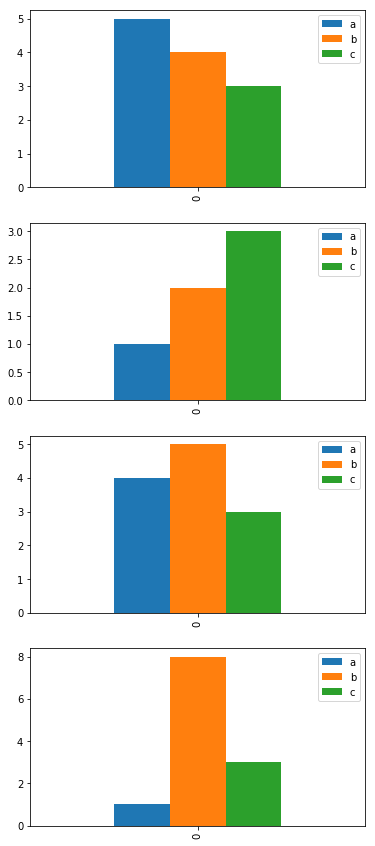

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,15))
df1 = pd.DataFrame({'a': [5], 'b': [4], 'c': [3]})
df2 = pd.DataFrame({'a': [1], 'b': [2], 'c': [3]})
df3 = pd.DataFrame({'a': [4], 'b': [5], 'c': [3]})
df4 = pd.DataFrame({'a': [1], 'b': [8], 'c': [3]})
df1.plot(kind='bar', ax=axes[0])
df2.plot(kind='bar', ax=axes[1])
df3.plot(kind='bar', ax=axes[2])
df4.plot(kind='bar', ax=axes[3])

## Unequalized Moods


### Baselines

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 40.07%
Most-Common-Case Classifier Dev Accuracy: 39.36%
Most-Common-Case Classifier Test Accuracy: 39.81%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 39.67%
Naive Bayes Classifier Test Accuracy: 39.93%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 45.41%
SVM Classifier Test Accuracy: 44.88%


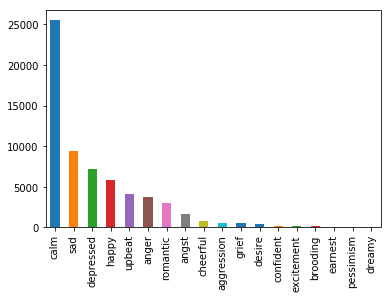

In [46]:
get_and_plot_x_y_data(quadrants=False, pad_lyric_data=False)

### CNN without lyrics2vec

In [10]:
mood_classification(
    # Controls
    name='w2v0_unequalized-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=False,                # no padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-04 17:12:27,558 - INFO: Engaging Low Memory Mode
2018-12-04 17:12:27,560 - INFO: Step 1: Load Lyrics
2018-12-04 17:12:27,562 - INFO: building lyrics dataset
2018-12-04 17:12:27,564 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-04 17:12:29,214 - INFO: imported data shape: (779056, 9)
2018-12-04 17:12:29,215 - INFO: Data shape before filtering: (779056, 9)
2018-12-04 17:12:29,233 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-04 17:12:29,257 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-04 17:12:29,274 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-04 17:12:29,282 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-04 17:12:29,330 - INFO: Shape after mood categorization: (63803, 7)
2018-12-04 17:12:30,422 - INFO: Data shape after lyrics addition: (63803, 8)
2018-12-04 17:12:30,424 - INFO: Df head:
3     An

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



2018-12-04 17:15:27,991 - INFO: Checking for prexisting data...
2018-12-04 17:15:27,992 - INFO: Step 5 Elapsed Time: 0.01 minutes
2018-12-04 17:15:27,992 - INFO: Mood Classification Elapsed Time: 3.01 minutes
2018-12-04 17:15:27,993 - INFO: Step 6: Train the CNN
2018-12-04 17:15:27,993 - INFO: Writing to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods



INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/

2018-12-04 17:15:28,738 - INFO: num_batches_per_epoch = 399
2018-12-04 17:15:28,740 - INFO: ***********************************************
2018-12-04 17:15:28,740 - INFO: Epoch 0/10

2018-12-04 17:15:28,746 - INFO: -----------------------------------------------
2018-12-04 17:15:28,747 - INFO: Epoch 0/10, Batch 0/399 (start=0, end=128)
2018-12-04 17:15:29,426 - INFO: step 1, loss 12.4686, acc 0.03125
2018-12-04 17:15:29,433 - INFO: -----------------------------------------------
2018-12-04 17:15:29,433 - INFO: Epoch 0/10, Batch 1/399 (start=128, end=256)
2018-12-04 17:15:30,004 - INFO: step 2, loss 6.08383, acc 0.164062
2018-12-04 17:15:30,006 - INFO: -----------------------------------------------
2018-12-04 17:15:30,006 - INFO: Epoch 0/10, Batch 2/399 (start=256, end=384)
2018-12-04 17:15:30,578 - INFO: step 3, loss 7.17337, acc 0.179688
2018-12-04 17:15:30,579 - INFO: -----------------------------------------------
2018-12-04 17:15:30,580 - INFO: Epoch 0/10, Batch 3/399 (start=384,

2018-12-04 17:15:49,407 - INFO: step 36, loss 4.0104, acc 0.328125
2018-12-04 17:15:49,409 - INFO: -----------------------------------------------
2018-12-04 17:15:49,409 - INFO: Epoch 0/10, Batch 36/399 (start=4608, end=4736)
2018-12-04 17:15:49,976 - INFO: step 37, loss 4.79969, acc 0.242188
2018-12-04 17:15:49,978 - INFO: -----------------------------------------------
2018-12-04 17:15:49,978 - INFO: Epoch 0/10, Batch 37/399 (start=4736, end=4864)
2018-12-04 17:15:50,540 - INFO: step 38, loss 5.11201, acc 0.171875
2018-12-04 17:15:50,542 - INFO: -----------------------------------------------
2018-12-04 17:15:50,543 - INFO: Epoch 0/10, Batch 38/399 (start=4864, end=4992)
2018-12-04 17:15:51,113 - INFO: step 39, loss 5.49068, acc 0.132812
2018-12-04 17:15:51,115 - INFO: -----------------------------------------------
2018-12-04 17:15:51,116 - INFO: Epoch 0/10, Batch 39/399 (start=4992, end=5120)
2018-12-04 17:15:51,681 - INFO: step 40, loss 4.20227, acc 0.226562
2018-12-04 17:15:51,6

2018-12-04 17:16:09,983 - INFO: -----------------------------------------------
2018-12-04 17:16:09,984 - INFO: Epoch 0/10, Batch 72/399 (start=9216, end=9344)
2018-12-04 17:16:10,551 - INFO: step 73, loss 3.6906, acc 0.289062
2018-12-04 17:16:10,553 - INFO: -----------------------------------------------
2018-12-04 17:16:10,553 - INFO: Epoch 0/10, Batch 73/399 (start=9344, end=9472)
2018-12-04 17:16:11,132 - INFO: step 74, loss 4.64057, acc 0.257812
2018-12-04 17:16:11,133 - INFO: -----------------------------------------------
2018-12-04 17:16:11,134 - INFO: Epoch 0/10, Batch 74/399 (start=9472, end=9600)
2018-12-04 17:16:11,697 - INFO: step 75, loss 4.5407, acc 0.1875
2018-12-04 17:16:11,699 - INFO: -----------------------------------------------
2018-12-04 17:16:11,700 - INFO: Epoch 0/10, Batch 75/399 (start=9600, end=9728)
2018-12-04 17:16:12,270 - INFO: step 76, loss 4.34872, acc 0.234375
2018-12-04 17:16:12,272 - INFO: -----------------------------------------------
2018-12-04 1

2018-12-04 17:16:37,259 - INFO: -----------------------------------------------
2018-12-04 17:16:37,260 - INFO: Epoch 0/10, Batch 105/399 (start=13440, end=13568)
2018-12-04 17:16:37,830 - INFO: step 106, loss 4.31553, acc 0.289062
2018-12-04 17:16:37,832 - INFO: -----------------------------------------------
2018-12-04 17:16:37,833 - INFO: Epoch 0/10, Batch 106/399 (start=13568, end=13696)
2018-12-04 17:16:38,404 - INFO: step 107, loss 4.47231, acc 0.265625
2018-12-04 17:16:38,406 - INFO: -----------------------------------------------
2018-12-04 17:16:38,407 - INFO: Epoch 0/10, Batch 107/399 (start=13696, end=13824)
2018-12-04 17:16:38,975 - INFO: step 108, loss 4.19008, acc 0.289062
2018-12-04 17:16:38,977 - INFO: -----------------------------------------------
2018-12-04 17:16:38,977 - INFO: Epoch 0/10, Batch 108/399 (start=13824, end=13952)
2018-12-04 17:16:39,542 - INFO: step 109, loss 4.48131, acc 0.195312
2018-12-04 17:16:39,544 - INFO: ----------------------------------------

2018-12-04 17:16:57,814 - INFO: step 141, loss 3.39642, acc 0.3125
2018-12-04 17:16:57,816 - INFO: -----------------------------------------------
2018-12-04 17:16:57,817 - INFO: Epoch 0/10, Batch 141/399 (start=18048, end=18176)
2018-12-04 17:16:58,376 - INFO: step 142, loss 4.25791, acc 0.257812
2018-12-04 17:16:58,378 - INFO: -----------------------------------------------
2018-12-04 17:16:58,379 - INFO: Epoch 0/10, Batch 142/399 (start=18176, end=18304)
2018-12-04 17:16:58,943 - INFO: step 143, loss 3.98122, acc 0.234375
2018-12-04 17:16:58,944 - INFO: -----------------------------------------------
2018-12-04 17:16:58,945 - INFO: Epoch 0/10, Batch 143/399 (start=18304, end=18432)
2018-12-04 17:16:59,514 - INFO: step 144, loss 3.6072, acc 0.21875
2018-12-04 17:16:59,516 - INFO: -----------------------------------------------
2018-12-04 17:16:59,516 - INFO: Epoch 0/10, Batch 144/399 (start=18432, end=18560)
2018-12-04 17:17:00,083 - INFO: step 145, loss 4.05923, acc 0.25
2018-12-04 

2018-12-04 17:17:17,755 - INFO: Epoch 0/10, Batch 176/399 (start=22528, end=22656)
2018-12-04 17:17:18,331 - INFO: step 177, loss 3.43864, acc 0.304688
2018-12-04 17:17:18,333 - INFO: -----------------------------------------------
2018-12-04 17:17:18,333 - INFO: Epoch 0/10, Batch 177/399 (start=22656, end=22784)
2018-12-04 17:17:18,906 - INFO: step 178, loss 3.24364, acc 0.3125
2018-12-04 17:17:18,908 - INFO: -----------------------------------------------
2018-12-04 17:17:18,908 - INFO: Epoch 0/10, Batch 178/399 (start=22784, end=22912)
2018-12-04 17:17:19,476 - INFO: step 179, loss 3.71053, acc 0.296875
2018-12-04 17:17:19,477 - INFO: -----------------------------------------------
2018-12-04 17:17:19,478 - INFO: Epoch 0/10, Batch 179/399 (start=22912, end=23040)
2018-12-04 17:17:20,044 - INFO: step 180, loss 3.55296, acc 0.328125
2018-12-04 17:17:20,045 - INFO: -----------------------------------------------
2018-12-04 17:17:20,046 - INFO: Epoch 0/10, Batch 180/399 (start=23040, en

2018-12-04 17:17:44,944 - INFO: -----------------------------------------------
2018-12-04 17:17:44,945 - INFO: Epoch 0/10, Batch 209/399 (start=26752, end=26880)
2018-12-04 17:17:45,513 - INFO: step 210, loss 3.52013, acc 0.210938
2018-12-04 17:17:45,515 - INFO: -----------------------------------------------
2018-12-04 17:17:45,516 - INFO: Epoch 0/10, Batch 210/399 (start=26880, end=27008)
2018-12-04 17:17:46,077 - INFO: step 211, loss 3.0711, acc 0.328125
2018-12-04 17:17:46,079 - INFO: -----------------------------------------------
2018-12-04 17:17:46,079 - INFO: Epoch 0/10, Batch 211/399 (start=27008, end=27136)
2018-12-04 17:17:46,645 - INFO: step 212, loss 3.11269, acc 0.328125
2018-12-04 17:17:46,646 - INFO: -----------------------------------------------
2018-12-04 17:17:46,647 - INFO: Epoch 0/10, Batch 212/399 (start=27136, end=27264)
2018-12-04 17:17:47,221 - INFO: step 213, loss 3.19312, acc 0.34375
2018-12-04 17:17:47,222 - INFO: ------------------------------------------

2018-12-04 17:18:05,426 - INFO: step 245, loss 3.15366, acc 0.320312
2018-12-04 17:18:05,428 - INFO: -----------------------------------------------
2018-12-04 17:18:05,428 - INFO: Epoch 0/10, Batch 245/399 (start=31360, end=31488)
2018-12-04 17:18:05,999 - INFO: step 246, loss 3.164, acc 0.34375
2018-12-04 17:18:06,001 - INFO: -----------------------------------------------
2018-12-04 17:18:06,001 - INFO: Epoch 0/10, Batch 246/399 (start=31488, end=31616)
2018-12-04 17:18:06,566 - INFO: step 247, loss 3.1478, acc 0.421875
2018-12-04 17:18:06,567 - INFO: -----------------------------------------------
2018-12-04 17:18:06,568 - INFO: Epoch 0/10, Batch 247/399 (start=31616, end=31744)
2018-12-04 17:18:07,132 - INFO: step 248, loss 3.75264, acc 0.34375
2018-12-04 17:18:07,133 - INFO: -----------------------------------------------
2018-12-04 17:18:07,134 - INFO: Epoch 0/10, Batch 248/399 (start=31744, end=31872)
2018-12-04 17:18:07,699 - INFO: step 249, loss 3.60112, acc 0.34375
2018-12-0

2018-12-04 17:18:25,409 - INFO: Epoch 0/10, Batch 280/399 (start=35840, end=35968)
2018-12-04 17:18:25,988 - INFO: step 281, loss 3.31694, acc 0.265625
2018-12-04 17:18:25,990 - INFO: -----------------------------------------------
2018-12-04 17:18:25,990 - INFO: Epoch 0/10, Batch 281/399 (start=35968, end=36096)
2018-12-04 17:18:26,588 - INFO: step 282, loss 3.50934, acc 0.289062
2018-12-04 17:18:26,589 - INFO: -----------------------------------------------
2018-12-04 17:18:26,590 - INFO: Epoch 0/10, Batch 282/399 (start=36096, end=36224)
2018-12-04 17:18:27,181 - INFO: step 283, loss 3.11724, acc 0.328125
2018-12-04 17:18:27,182 - INFO: -----------------------------------------------
2018-12-04 17:18:27,183 - INFO: Epoch 0/10, Batch 283/399 (start=36224, end=36352)
2018-12-04 17:18:27,797 - INFO: step 284, loss 2.96076, acc 0.351562
2018-12-04 17:18:27,799 - INFO: -----------------------------------------------
2018-12-04 17:18:27,800 - INFO: Epoch 0/10, Batch 284/399 (start=36352, 

2018-12-04 17:18:53,480 - INFO: -----------------------------------------------
2018-12-04 17:18:53,480 - INFO: Epoch 0/10, Batch 313/399 (start=40064, end=40192)
2018-12-04 17:18:54,047 - INFO: step 314, loss 2.57572, acc 0.460938
2018-12-04 17:18:54,049 - INFO: -----------------------------------------------
2018-12-04 17:18:54,049 - INFO: Epoch 0/10, Batch 314/399 (start=40192, end=40320)
2018-12-04 17:18:54,617 - INFO: step 315, loss 2.75817, acc 0.4375
2018-12-04 17:18:54,618 - INFO: -----------------------------------------------
2018-12-04 17:18:54,619 - INFO: Epoch 0/10, Batch 315/399 (start=40320, end=40448)
2018-12-04 17:18:55,181 - INFO: step 316, loss 3.52407, acc 0.328125
2018-12-04 17:18:55,183 - INFO: -----------------------------------------------
2018-12-04 17:18:55,183 - INFO: Epoch 0/10, Batch 316/399 (start=40448, end=40576)
2018-12-04 17:18:55,744 - INFO: step 317, loss 3.29373, acc 0.242188
2018-12-04 17:18:55,745 - INFO: ------------------------------------------

2018-12-04 17:19:13,973 - INFO: step 349, loss 3.03561, acc 0.351562
2018-12-04 17:19:13,975 - INFO: -----------------------------------------------
2018-12-04 17:19:13,975 - INFO: Epoch 0/10, Batch 349/399 (start=44672, end=44800)
2018-12-04 17:19:14,545 - INFO: step 350, loss 2.97597, acc 0.34375
2018-12-04 17:19:14,547 - INFO: -----------------------------------------------
2018-12-04 17:19:14,547 - INFO: Epoch 0/10, Batch 350/399 (start=44800, end=44928)
2018-12-04 17:19:15,114 - INFO: step 351, loss 2.90069, acc 0.3125
2018-12-04 17:19:15,116 - INFO: -----------------------------------------------
2018-12-04 17:19:15,117 - INFO: Epoch 0/10, Batch 351/399 (start=44928, end=45056)
2018-12-04 17:19:15,682 - INFO: step 352, loss 3.2196, acc 0.289062
2018-12-04 17:19:15,684 - INFO: -----------------------------------------------
2018-12-04 17:19:15,684 - INFO: Epoch 0/10, Batch 352/399 (start=45056, end=45184)
2018-12-04 17:19:16,252 - INFO: step 353, loss 3.1544, acc 0.296875
2018-12-

2018-12-04 17:19:34,025 - INFO: Epoch 0/10, Batch 384/399 (start=49152, end=49280)
2018-12-04 17:19:34,589 - INFO: step 385, loss 2.8187, acc 0.328125
2018-12-04 17:19:34,591 - INFO: -----------------------------------------------
2018-12-04 17:19:34,592 - INFO: Epoch 0/10, Batch 385/399 (start=49280, end=49408)
2018-12-04 17:19:35,162 - INFO: step 386, loss 2.80832, acc 0.351562
2018-12-04 17:19:35,164 - INFO: -----------------------------------------------
2018-12-04 17:19:35,165 - INFO: Epoch 0/10, Batch 386/399 (start=49408, end=49536)
2018-12-04 17:19:35,738 - INFO: step 387, loss 2.68283, acc 0.335938
2018-12-04 17:19:35,740 - INFO: -----------------------------------------------
2018-12-04 17:19:35,740 - INFO: Epoch 0/10, Batch 387/399 (start=49536, end=49664)
2018-12-04 17:19:36,310 - INFO: step 388, loss 2.48696, acc 0.429688
2018-12-04 17:19:36,312 - INFO: -----------------------------------------------
2018-12-04 17:19:36,313 - INFO: Epoch 0/10, Batch 388/399 (start=49664, e

2018-12-04 17:20:01,252 - INFO: step 417, loss 2.27048, acc 0.429688
2018-12-04 17:20:01,254 - INFO: -----------------------------------------------
2018-12-04 17:20:01,255 - INFO: Epoch 1/10, Batch 18/399 (start=2304, end=2432)
2018-12-04 17:20:01,824 - INFO: step 418, loss 2.44453, acc 0.398438
2018-12-04 17:20:01,825 - INFO: -----------------------------------------------
2018-12-04 17:20:01,826 - INFO: Epoch 1/10, Batch 19/399 (start=2432, end=2560)
2018-12-04 17:20:02,391 - INFO: step 419, loss 2.05465, acc 0.484375
2018-12-04 17:20:02,393 - INFO: -----------------------------------------------
2018-12-04 17:20:02,394 - INFO: Epoch 1/10, Batch 20/399 (start=2560, end=2688)
2018-12-04 17:20:02,960 - INFO: step 420, loss 2.59093, acc 0.320312
2018-12-04 17:20:02,962 - INFO: -----------------------------------------------
2018-12-04 17:20:02,963 - INFO: Epoch 1/10, Batch 21/399 (start=2688, end=2816)
2018-12-04 17:20:03,531 - INFO: step 421, loss 2.2567, acc 0.390625
2018-12-04 17:20

2018-12-04 17:20:21,844 - INFO: step 453, loss 2.03989, acc 0.429688
2018-12-04 17:20:21,846 - INFO: -----------------------------------------------
2018-12-04 17:20:21,846 - INFO: Epoch 1/10, Batch 54/399 (start=6912, end=7040)
2018-12-04 17:20:22,418 - INFO: step 454, loss 2.57464, acc 0.3125
2018-12-04 17:20:22,420 - INFO: -----------------------------------------------
2018-12-04 17:20:22,421 - INFO: Epoch 1/10, Batch 55/399 (start=7040, end=7168)
2018-12-04 17:20:22,989 - INFO: step 455, loss 2.10614, acc 0.414062
2018-12-04 17:20:22,991 - INFO: -----------------------------------------------
2018-12-04 17:20:22,991 - INFO: Epoch 1/10, Batch 56/399 (start=7168, end=7296)
2018-12-04 17:20:23,561 - INFO: step 456, loss 2.1357, acc 0.429688
2018-12-04 17:20:23,563 - INFO: -----------------------------------------------
2018-12-04 17:20:23,563 - INFO: Epoch 1/10, Batch 57/399 (start=7296, end=7424)
2018-12-04 17:20:24,121 - INFO: step 457, loss 1.84145, acc 0.5
2018-12-04 17:20:24,123

2018-12-04 17:20:42,442 - INFO: step 489, loss 2.20433, acc 0.390625
2018-12-04 17:20:42,444 - INFO: -----------------------------------------------
2018-12-04 17:20:42,444 - INFO: Epoch 1/10, Batch 90/399 (start=11520, end=11648)
2018-12-04 17:20:43,010 - INFO: step 490, loss 2.27595, acc 0.375
2018-12-04 17:20:43,012 - INFO: -----------------------------------------------
2018-12-04 17:20:43,013 - INFO: Epoch 1/10, Batch 91/399 (start=11648, end=11776)
2018-12-04 17:20:43,578 - INFO: step 491, loss 2.31109, acc 0.398438
2018-12-04 17:20:43,580 - INFO: -----------------------------------------------
2018-12-04 17:20:43,580 - INFO: Epoch 1/10, Batch 92/399 (start=11776, end=11904)
2018-12-04 17:20:44,151 - INFO: step 492, loss 2.03466, acc 0.4375
2018-12-04 17:20:44,153 - INFO: -----------------------------------------------
2018-12-04 17:20:44,153 - INFO: Epoch 1/10, Batch 93/399 (start=11904, end=12032)
2018-12-04 17:20:44,723 - INFO: step 493, loss 2.00252, acc 0.492188
2018-12-04 1

2018-12-04 17:21:09,142 - INFO: Epoch 1/10, Batch 122/399 (start=15616, end=15744)
2018-12-04 17:21:09,708 - INFO: step 522, loss 1.99728, acc 0.46875
2018-12-04 17:21:09,710 - INFO: -----------------------------------------------
2018-12-04 17:21:09,710 - INFO: Epoch 1/10, Batch 123/399 (start=15744, end=15872)
2018-12-04 17:21:10,270 - INFO: step 523, loss 2.11732, acc 0.414062
2018-12-04 17:21:10,272 - INFO: -----------------------------------------------
2018-12-04 17:21:10,272 - INFO: Epoch 1/10, Batch 124/399 (start=15872, end=16000)
2018-12-04 17:21:10,841 - INFO: step 524, loss 2.00369, acc 0.429688
2018-12-04 17:21:10,843 - INFO: -----------------------------------------------
2018-12-04 17:21:10,843 - INFO: Epoch 1/10, Batch 125/399 (start=16000, end=16128)
2018-12-04 17:21:11,415 - INFO: step 525, loss 1.78847, acc 0.5
2018-12-04 17:21:11,417 - INFO: -----------------------------------------------
2018-12-04 17:21:11,417 - INFO: Epoch 1/10, Batch 126/399 (start=16128, end=16

2018-12-04 17:21:29,660 - INFO: -----------------------------------------------
2018-12-04 17:21:29,661 - INFO: Epoch 1/10, Batch 158/399 (start=20224, end=20352)
2018-12-04 17:21:30,232 - INFO: step 558, loss 1.96824, acc 0.554688
2018-12-04 17:21:30,234 - INFO: -----------------------------------------------
2018-12-04 17:21:30,235 - INFO: Epoch 1/10, Batch 159/399 (start=20352, end=20480)
2018-12-04 17:21:30,796 - INFO: step 559, loss 1.95742, acc 0.523438
2018-12-04 17:21:30,798 - INFO: -----------------------------------------------
2018-12-04 17:21:30,799 - INFO: Epoch 1/10, Batch 160/399 (start=20480, end=20608)
2018-12-04 17:21:31,368 - INFO: step 560, loss 2.37164, acc 0.429688
2018-12-04 17:21:31,369 - INFO: -----------------------------------------------
2018-12-04 17:21:31,370 - INFO: Epoch 1/10, Batch 161/399 (start=20608, end=20736)
2018-12-04 17:21:31,940 - INFO: step 561, loss 2.1291, acc 0.476562
2018-12-04 17:21:31,942 - INFO: -----------------------------------------

2018-12-04 17:21:50,179 - INFO: step 593, loss 2.17618, acc 0.460938
2018-12-04 17:21:50,181 - INFO: -----------------------------------------------
2018-12-04 17:21:50,182 - INFO: Epoch 1/10, Batch 194/399 (start=24832, end=24960)
2018-12-04 17:21:50,754 - INFO: step 594, loss 2.01543, acc 0.453125
2018-12-04 17:21:50,755 - INFO: -----------------------------------------------
2018-12-04 17:21:50,756 - INFO: Epoch 1/10, Batch 195/399 (start=24960, end=25088)
2018-12-04 17:21:51,320 - INFO: step 595, loss 2.03124, acc 0.414062
2018-12-04 17:21:51,322 - INFO: -----------------------------------------------
2018-12-04 17:21:51,323 - INFO: Epoch 1/10, Batch 196/399 (start=25088, end=25216)
2018-12-04 17:21:51,892 - INFO: step 596, loss 2.24014, acc 0.398438
2018-12-04 17:21:51,894 - INFO: -----------------------------------------------
2018-12-04 17:21:51,895 - INFO: Epoch 1/10, Batch 197/399 (start=25216, end=25344)
2018-12-04 17:21:52,463 - INFO: step 597, loss 1.84995, acc 0.4375
2018-

2018-12-04 17:22:16,953 - INFO: Epoch 1/10, Batch 226/399 (start=28928, end=29056)
2018-12-04 17:22:17,526 - INFO: step 626, loss 1.99191, acc 0.421875
2018-12-04 17:22:17,527 - INFO: -----------------------------------------------
2018-12-04 17:22:17,528 - INFO: Epoch 1/10, Batch 227/399 (start=29056, end=29184)
2018-12-04 17:22:18,098 - INFO: step 627, loss 2.13369, acc 0.421875
2018-12-04 17:22:18,100 - INFO: -----------------------------------------------
2018-12-04 17:22:18,100 - INFO: Epoch 1/10, Batch 228/399 (start=29184, end=29312)
2018-12-04 17:22:18,663 - INFO: step 628, loss 2.11005, acc 0.375
2018-12-04 17:22:18,665 - INFO: -----------------------------------------------
2018-12-04 17:22:18,666 - INFO: Epoch 1/10, Batch 229/399 (start=29312, end=29440)
2018-12-04 17:22:19,233 - INFO: step 629, loss 2.16703, acc 0.390625
2018-12-04 17:22:19,235 - INFO: -----------------------------------------------
2018-12-04 17:22:19,235 - INFO: Epoch 1/10, Batch 230/399 (start=29440, end

2018-12-04 17:22:37,424 - INFO: -----------------------------------------------
2018-12-04 17:22:37,424 - INFO: Epoch 1/10, Batch 262/399 (start=33536, end=33664)
2018-12-04 17:22:37,994 - INFO: step 662, loss 2.15423, acc 0.40625
2018-12-04 17:22:37,995 - INFO: -----------------------------------------------
2018-12-04 17:22:37,996 - INFO: Epoch 1/10, Batch 263/399 (start=33664, end=33792)
2018-12-04 17:22:38,563 - INFO: step 663, loss 1.99056, acc 0.453125
2018-12-04 17:22:38,565 - INFO: -----------------------------------------------
2018-12-04 17:22:38,566 - INFO: Epoch 1/10, Batch 264/399 (start=33792, end=33920)
2018-12-04 17:22:39,128 - INFO: step 664, loss 2.15903, acc 0.367188
2018-12-04 17:22:39,129 - INFO: -----------------------------------------------
2018-12-04 17:22:39,130 - INFO: Epoch 1/10, Batch 265/399 (start=33920, end=34048)
2018-12-04 17:22:39,699 - INFO: step 665, loss 2.00145, acc 0.445312
2018-12-04 17:22:39,701 - INFO: -----------------------------------------

2018-12-04 17:22:58,468 - INFO: step 697, loss 1.83808, acc 0.476562
2018-12-04 17:22:58,470 - INFO: -----------------------------------------------
2018-12-04 17:22:58,470 - INFO: Epoch 1/10, Batch 298/399 (start=38144, end=38272)
2018-12-04 17:22:59,048 - INFO: step 698, loss 2.0206, acc 0.5
2018-12-04 17:22:59,050 - INFO: -----------------------------------------------
2018-12-04 17:22:59,050 - INFO: Epoch 1/10, Batch 299/399 (start=38272, end=38400)
2018-12-04 17:22:59,617 - INFO: step 699, loss 1.88781, acc 0.507812
2018-12-04 17:22:59,618 - INFO: -----------------------------------------------
2018-12-04 17:22:59,619 - INFO: Epoch 1/10, Batch 300/399 (start=38400, end=38528)
2018-12-04 17:23:00,191 - INFO: step 700, loss 2.22657, acc 0.453125
2018-12-04 17:23:00,192 - INFO: 
Evaluation:
2018-12-04 17:23:00,193 - INFO: Validation Step
2018-12-04 17:23:08,682 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-

2018-12-04 17:23:25,316 - INFO: Epoch 1/10, Batch 330/399 (start=42240, end=42368)
2018-12-04 17:23:25,890 - INFO: step 730, loss 1.96129, acc 0.507812
2018-12-04 17:23:25,891 - INFO: -----------------------------------------------
2018-12-04 17:23:25,892 - INFO: Epoch 1/10, Batch 331/399 (start=42368, end=42496)
2018-12-04 17:23:26,463 - INFO: step 731, loss 2.5621, acc 0.382812
2018-12-04 17:23:26,464 - INFO: -----------------------------------------------
2018-12-04 17:23:26,465 - INFO: Epoch 1/10, Batch 332/399 (start=42496, end=42624)
2018-12-04 17:23:27,043 - INFO: step 732, loss 1.94029, acc 0.4375
2018-12-04 17:23:27,045 - INFO: -----------------------------------------------
2018-12-04 17:23:27,045 - INFO: Epoch 1/10, Batch 333/399 (start=42624, end=42752)
2018-12-04 17:23:27,615 - INFO: step 733, loss 2.08864, acc 0.445312
2018-12-04 17:23:27,617 - INFO: -----------------------------------------------
2018-12-04 17:23:27,617 - INFO: Epoch 1/10, Batch 334/399 (start=42752, end

2018-12-04 17:23:45,872 - INFO: -----------------------------------------------
2018-12-04 17:23:45,872 - INFO: Epoch 1/10, Batch 366/399 (start=46848, end=46976)
2018-12-04 17:23:46,445 - INFO: step 766, loss 1.91715, acc 0.453125
2018-12-04 17:23:46,447 - INFO: -----------------------------------------------
2018-12-04 17:23:46,448 - INFO: Epoch 1/10, Batch 367/399 (start=46976, end=47104)
2018-12-04 17:23:47,016 - INFO: step 767, loss 2.07047, acc 0.398438
2018-12-04 17:23:47,018 - INFO: -----------------------------------------------
2018-12-04 17:23:47,019 - INFO: Epoch 1/10, Batch 368/399 (start=47104, end=47232)
2018-12-04 17:23:47,582 - INFO: step 768, loss 1.8678, acc 0.414062
2018-12-04 17:23:47,584 - INFO: -----------------------------------------------
2018-12-04 17:23:47,584 - INFO: Epoch 1/10, Batch 369/399 (start=47232, end=47360)
2018-12-04 17:23:48,152 - INFO: step 769, loss 1.96613, acc 0.429688
2018-12-04 17:23:48,154 - INFO: -----------------------------------------

2018-12-04 17:24:05,629 - INFO: 
Evaluation:
2018-12-04 17:24:05,630 - INFO: Validation Step
2018-12-04 17:24:13,887 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods/800_confusion.csv
2018-12-04 17:24:13,888 - INFO: step 800, loss 1.80284, acc 0.489498
2018-12-04 17:24:13,889 - INFO: 
2018-12-04 17:24:14,411 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods/checkpoints/model-800

2018-12-04 17:24:14,412 - INFO: -----------------------------------------------
2018-12-04 17:24:14,413 - INFO: Epoch 2/10, Batch 2/399 (start=256, end=384)
2018-12-04 17:24:14,979 - INFO: step 801, loss 1.69264, acc 0.460938
2018-12-04 17:24:14,981 - INFO: -----------------------------------------------
2018-12-

2018-12-04 17:24:33,052 - INFO: -----------------------------------------------
2018-12-04 17:24:33,053 - INFO: Epoch 2/10, Batch 35/399 (start=4480, end=4608)
2018-12-04 17:24:33,614 - INFO: step 834, loss 1.26861, acc 0.585938
2018-12-04 17:24:33,616 - INFO: -----------------------------------------------
2018-12-04 17:24:33,616 - INFO: Epoch 2/10, Batch 36/399 (start=4608, end=4736)
2018-12-04 17:24:34,177 - INFO: step 835, loss 1.60379, acc 0.554688
2018-12-04 17:24:34,179 - INFO: -----------------------------------------------
2018-12-04 17:24:34,179 - INFO: Epoch 2/10, Batch 37/399 (start=4736, end=4864)
2018-12-04 17:24:34,741 - INFO: step 836, loss 1.68756, acc 0.5625
2018-12-04 17:24:34,743 - INFO: -----------------------------------------------
2018-12-04 17:24:34,743 - INFO: Epoch 2/10, Batch 38/399 (start=4864, end=4992)
2018-12-04 17:24:35,302 - INFO: step 837, loss 1.66436, acc 0.53125
2018-12-04 17:24:35,304 - INFO: -----------------------------------------------
2018-12

2018-12-04 17:24:53,395 - INFO: -----------------------------------------------
2018-12-04 17:24:53,396 - INFO: Epoch 2/10, Batch 71/399 (start=9088, end=9216)
2018-12-04 17:24:53,964 - INFO: step 870, loss 1.57206, acc 0.523438
2018-12-04 17:24:53,966 - INFO: -----------------------------------------------
2018-12-04 17:24:53,966 - INFO: Epoch 2/10, Batch 72/399 (start=9216, end=9344)
2018-12-04 17:24:54,537 - INFO: step 871, loss 1.56073, acc 0.484375
2018-12-04 17:24:54,538 - INFO: -----------------------------------------------
2018-12-04 17:24:54,539 - INFO: Epoch 2/10, Batch 73/399 (start=9344, end=9472)
2018-12-04 17:24:55,104 - INFO: step 872, loss 1.62578, acc 0.492188
2018-12-04 17:24:55,105 - INFO: -----------------------------------------------
2018-12-04 17:24:55,106 - INFO: Epoch 2/10, Batch 74/399 (start=9472, end=9600)
2018-12-04 17:24:55,666 - INFO: step 873, loss 1.46654, acc 0.585938
2018-12-04 17:24:55,667 - INFO: -----------------------------------------------
2018

2018-12-04 17:25:20,557 - INFO: step 902, loss 1.72782, acc 0.53125
2018-12-04 17:25:20,559 - INFO: -----------------------------------------------
2018-12-04 17:25:20,559 - INFO: Epoch 2/10, Batch 104/399 (start=13312, end=13440)
2018-12-04 17:25:21,119 - INFO: step 903, loss 1.55638, acc 0.578125
2018-12-04 17:25:21,120 - INFO: -----------------------------------------------
2018-12-04 17:25:21,121 - INFO: Epoch 2/10, Batch 105/399 (start=13440, end=13568)
2018-12-04 17:25:21,683 - INFO: step 904, loss 1.61879, acc 0.554688
2018-12-04 17:25:21,684 - INFO: -----------------------------------------------
2018-12-04 17:25:21,685 - INFO: Epoch 2/10, Batch 106/399 (start=13568, end=13696)
2018-12-04 17:25:22,251 - INFO: step 905, loss 1.59844, acc 0.5
2018-12-04 17:25:22,252 - INFO: -----------------------------------------------
2018-12-04 17:25:22,253 - INFO: Epoch 2/10, Batch 107/399 (start=13696, end=13824)
2018-12-04 17:25:22,818 - INFO: step 906, loss 1.71789, acc 0.460938
2018-12-0

2018-12-04 17:25:40,377 - INFO: Epoch 2/10, Batch 139/399 (start=17792, end=17920)
2018-12-04 17:25:40,942 - INFO: step 938, loss 1.42035, acc 0.539062
2018-12-04 17:25:40,944 - INFO: -----------------------------------------------
2018-12-04 17:25:40,944 - INFO: Epoch 2/10, Batch 140/399 (start=17920, end=18048)
2018-12-04 17:25:41,506 - INFO: step 939, loss 1.71765, acc 0.492188
2018-12-04 17:25:41,507 - INFO: -----------------------------------------------
2018-12-04 17:25:41,508 - INFO: Epoch 2/10, Batch 141/399 (start=18048, end=18176)
2018-12-04 17:25:42,066 - INFO: step 940, loss 1.79549, acc 0.53125
2018-12-04 17:25:42,068 - INFO: -----------------------------------------------
2018-12-04 17:25:42,069 - INFO: Epoch 2/10, Batch 142/399 (start=18176, end=18304)
2018-12-04 17:25:42,630 - INFO: step 941, loss 1.318, acc 0.585938
2018-12-04 17:25:42,632 - INFO: -----------------------------------------------
2018-12-04 17:25:42,632 - INFO: Epoch 2/10, Batch 143/399 (start=18304, end

2018-12-04 17:26:00,762 - INFO: -----------------------------------------------
2018-12-04 17:26:00,763 - INFO: Epoch 2/10, Batch 175/399 (start=22400, end=22528)
2018-12-04 17:26:01,329 - INFO: step 974, loss 1.51022, acc 0.578125
2018-12-04 17:26:01,330 - INFO: -----------------------------------------------
2018-12-04 17:26:01,331 - INFO: Epoch 2/10, Batch 176/399 (start=22528, end=22656)
2018-12-04 17:26:01,902 - INFO: step 975, loss 1.80956, acc 0.460938
2018-12-04 17:26:01,903 - INFO: -----------------------------------------------
2018-12-04 17:26:01,903 - INFO: Epoch 2/10, Batch 177/399 (start=22656, end=22784)
2018-12-04 17:26:02,463 - INFO: step 976, loss 1.64925, acc 0.484375
2018-12-04 17:26:02,464 - INFO: -----------------------------------------------
2018-12-04 17:26:02,465 - INFO: Epoch 2/10, Batch 178/399 (start=22784, end=22912)
2018-12-04 17:26:03,030 - INFO: step 977, loss 1.59811, acc 0.539062
2018-12-04 17:26:03,032 - INFO: ----------------------------------------

2018-12-04 17:26:28,088 - INFO: step 1006, loss 1.44001, acc 0.59375
2018-12-04 17:26:28,090 - INFO: -----------------------------------------------
2018-12-04 17:26:28,091 - INFO: Epoch 2/10, Batch 208/399 (start=26624, end=26752)
2018-12-04 17:26:28,657 - INFO: step 1007, loss 1.37916, acc 0.523438
2018-12-04 17:26:28,659 - INFO: -----------------------------------------------
2018-12-04 17:26:28,660 - INFO: Epoch 2/10, Batch 209/399 (start=26752, end=26880)
2018-12-04 17:26:29,215 - INFO: step 1008, loss 1.57579, acc 0.523438
2018-12-04 17:26:29,217 - INFO: -----------------------------------------------
2018-12-04 17:26:29,217 - INFO: Epoch 2/10, Batch 210/399 (start=26880, end=27008)
2018-12-04 17:26:29,782 - INFO: step 1009, loss 1.6905, acc 0.507812
2018-12-04 17:26:29,784 - INFO: -----------------------------------------------
2018-12-04 17:26:29,784 - INFO: Epoch 2/10, Batch 211/399 (start=27008, end=27136)
2018-12-04 17:26:30,350 - INFO: step 1010, loss 1.41128, acc 0.5625
20

2018-12-04 17:26:47,880 - INFO: -----------------------------------------------
2018-12-04 17:26:47,881 - INFO: Epoch 2/10, Batch 243/399 (start=31104, end=31232)
2018-12-04 17:26:48,447 - INFO: step 1042, loss 1.73645, acc 0.523438
2018-12-04 17:26:48,448 - INFO: -----------------------------------------------
2018-12-04 17:26:48,449 - INFO: Epoch 2/10, Batch 244/399 (start=31232, end=31360)
2018-12-04 17:26:49,013 - INFO: step 1043, loss 1.62425, acc 0.53125
2018-12-04 17:26:49,014 - INFO: -----------------------------------------------
2018-12-04 17:26:49,015 - INFO: Epoch 2/10, Batch 245/399 (start=31360, end=31488)
2018-12-04 17:26:49,580 - INFO: step 1044, loss 1.80395, acc 0.445312
2018-12-04 17:26:49,582 - INFO: -----------------------------------------------
2018-12-04 17:26:49,582 - INFO: Epoch 2/10, Batch 246/399 (start=31488, end=31616)
2018-12-04 17:26:50,150 - INFO: step 1045, loss 1.70394, acc 0.507812
2018-12-04 17:26:50,151 - INFO: -------------------------------------

2018-12-04 17:27:07,783 - INFO: Epoch 2/10, Batch 278/399 (start=35584, end=35712)
2018-12-04 17:27:08,354 - INFO: step 1077, loss 1.73332, acc 0.476562
2018-12-04 17:27:08,355 - INFO: -----------------------------------------------
2018-12-04 17:27:08,356 - INFO: Epoch 2/10, Batch 279/399 (start=35712, end=35840)
2018-12-04 17:27:08,920 - INFO: step 1078, loss 1.51322, acc 0.546875
2018-12-04 17:27:08,922 - INFO: -----------------------------------------------
2018-12-04 17:27:08,922 - INFO: Epoch 2/10, Batch 280/399 (start=35840, end=35968)
2018-12-04 17:27:09,491 - INFO: step 1079, loss 1.69913, acc 0.507812
2018-12-04 17:27:09,493 - INFO: -----------------------------------------------
2018-12-04 17:27:09,494 - INFO: Epoch 2/10, Batch 281/399 (start=35968, end=36096)
2018-12-04 17:27:10,068 - INFO: step 1080, loss 1.63814, acc 0.476562
2018-12-04 17:27:10,070 - INFO: -----------------------------------------------
2018-12-04 17:27:10,070 - INFO: Epoch 2/10, Batch 282/399 (start=360

2018-12-04 17:27:35,042 - INFO: step 1109, loss 1.72293, acc 0.492188
2018-12-04 17:27:35,044 - INFO: -----------------------------------------------
2018-12-04 17:27:35,045 - INFO: Epoch 2/10, Batch 311/399 (start=39808, end=39936)
2018-12-04 17:27:35,612 - INFO: step 1110, loss 1.58604, acc 0.492188
2018-12-04 17:27:35,614 - INFO: -----------------------------------------------
2018-12-04 17:27:35,614 - INFO: Epoch 2/10, Batch 312/399 (start=39936, end=40064)
2018-12-04 17:27:36,178 - INFO: step 1111, loss 1.16586, acc 0.59375
2018-12-04 17:27:36,179 - INFO: -----------------------------------------------
2018-12-04 17:27:36,180 - INFO: Epoch 2/10, Batch 313/399 (start=40064, end=40192)
2018-12-04 17:27:36,742 - INFO: step 1112, loss 1.79962, acc 0.515625
2018-12-04 17:27:36,744 - INFO: -----------------------------------------------
2018-12-04 17:27:36,744 - INFO: Epoch 2/10, Batch 314/399 (start=40192, end=40320)
2018-12-04 17:27:37,306 - INFO: step 1113, loss 1.47962, acc 0.523438

2018-12-04 17:27:54,857 - INFO: -----------------------------------------------
2018-12-04 17:27:54,858 - INFO: Epoch 2/10, Batch 346/399 (start=44288, end=44416)
2018-12-04 17:27:55,423 - INFO: step 1145, loss 1.7331, acc 0.476562
2018-12-04 17:27:55,425 - INFO: -----------------------------------------------
2018-12-04 17:27:55,426 - INFO: Epoch 2/10, Batch 347/399 (start=44416, end=44544)
2018-12-04 17:27:55,986 - INFO: step 1146, loss 1.35153, acc 0.578125
2018-12-04 17:27:55,987 - INFO: -----------------------------------------------
2018-12-04 17:27:55,988 - INFO: Epoch 2/10, Batch 348/399 (start=44544, end=44672)
2018-12-04 17:27:56,555 - INFO: step 1147, loss 1.81911, acc 0.382812
2018-12-04 17:27:56,557 - INFO: -----------------------------------------------
2018-12-04 17:27:56,557 - INFO: Epoch 2/10, Batch 349/399 (start=44672, end=44800)
2018-12-04 17:27:57,135 - INFO: step 1148, loss 1.6954, acc 0.476562
2018-12-04 17:27:57,137 - INFO: --------------------------------------

2018-12-04 17:28:15,851 - INFO: Epoch 2/10, Batch 381/399 (start=48768, end=48896)
2018-12-04 17:28:16,438 - INFO: step 1180, loss 1.62526, acc 0.484375
2018-12-04 17:28:16,440 - INFO: -----------------------------------------------
2018-12-04 17:28:16,442 - INFO: Epoch 2/10, Batch 382/399 (start=48896, end=49024)
2018-12-04 17:28:16,996 - INFO: step 1181, loss 1.35856, acc 0.59375
2018-12-04 17:28:16,998 - INFO: -----------------------------------------------
2018-12-04 17:28:16,998 - INFO: Epoch 2/10, Batch 383/399 (start=49024, end=49152)
2018-12-04 17:28:17,555 - INFO: step 1182, loss 1.6746, acc 0.46875
2018-12-04 17:28:17,556 - INFO: -----------------------------------------------
2018-12-04 17:28:17,557 - INFO: Epoch 2/10, Batch 384/399 (start=49152, end=49280)
2018-12-04 17:28:18,108 - INFO: step 1183, loss 1.51102, acc 0.546875
2018-12-04 17:28:18,110 - INFO: -----------------------------------------------
2018-12-04 17:28:18,110 - INFO: Epoch 2/10, Batch 385/399 (start=49280,

2018-12-04 17:28:42,991 - INFO: step 1212, loss 1.12895, acc 0.625
2018-12-04 17:28:42,992 - INFO: -----------------------------------------------
2018-12-04 17:28:42,993 - INFO: Epoch 3/10, Batch 15/399 (start=1920, end=2048)
2018-12-04 17:28:43,535 - INFO: step 1213, loss 1.20096, acc 0.65625
2018-12-04 17:28:43,537 - INFO: -----------------------------------------------
2018-12-04 17:28:43,537 - INFO: Epoch 3/10, Batch 16/399 (start=2048, end=2176)
2018-12-04 17:28:44,097 - INFO: step 1214, loss 1.16817, acc 0.695312
2018-12-04 17:28:44,099 - INFO: -----------------------------------------------
2018-12-04 17:28:44,099 - INFO: Epoch 3/10, Batch 17/399 (start=2176, end=2304)
2018-12-04 17:28:44,654 - INFO: step 1215, loss 1.22904, acc 0.585938
2018-12-04 17:28:44,656 - INFO: -----------------------------------------------
2018-12-04 17:28:44,657 - INFO: Epoch 3/10, Batch 18/399 (start=2304, end=2432)
2018-12-04 17:28:45,217 - INFO: step 1216, loss 1.47468, acc 0.507812
2018-12-04 17:

2018-12-04 17:29:03,284 - INFO: step 1248, loss 1.45638, acc 0.554688
2018-12-04 17:29:03,285 - INFO: -----------------------------------------------
2018-12-04 17:29:03,286 - INFO: Epoch 3/10, Batch 51/399 (start=6528, end=6656)
2018-12-04 17:29:03,844 - INFO: step 1249, loss 1.16472, acc 0.671875
2018-12-04 17:29:03,846 - INFO: -----------------------------------------------
2018-12-04 17:29:03,847 - INFO: Epoch 3/10, Batch 52/399 (start=6656, end=6784)
2018-12-04 17:29:04,411 - INFO: step 1250, loss 1.1078, acc 0.65625
2018-12-04 17:29:04,413 - INFO: -----------------------------------------------
2018-12-04 17:29:04,414 - INFO: Epoch 3/10, Batch 53/399 (start=6784, end=6912)
2018-12-04 17:29:04,976 - INFO: step 1251, loss 1.21371, acc 0.664062
2018-12-04 17:29:04,978 - INFO: -----------------------------------------------
2018-12-04 17:29:04,979 - INFO: Epoch 3/10, Batch 54/399 (start=6912, end=7040)
2018-12-04 17:29:05,540 - INFO: step 1252, loss 1.35856, acc 0.546875
2018-12-04 1

2018-12-04 17:29:22,957 - INFO: Epoch 3/10, Batch 86/399 (start=11008, end=11136)
2018-12-04 17:29:23,516 - INFO: step 1284, loss 1.19623, acc 0.609375
2018-12-04 17:29:23,518 - INFO: -----------------------------------------------
2018-12-04 17:29:23,519 - INFO: Epoch 3/10, Batch 87/399 (start=11136, end=11264)
2018-12-04 17:29:24,076 - INFO: step 1285, loss 1.45954, acc 0.53125
2018-12-04 17:29:24,078 - INFO: -----------------------------------------------
2018-12-04 17:29:24,078 - INFO: Epoch 3/10, Batch 88/399 (start=11264, end=11392)
2018-12-04 17:29:24,632 - INFO: step 1286, loss 1.25602, acc 0.625
2018-12-04 17:29:24,634 - INFO: -----------------------------------------------
2018-12-04 17:29:24,634 - INFO: Epoch 3/10, Batch 89/399 (start=11392, end=11520)
2018-12-04 17:29:25,200 - INFO: step 1287, loss 1.33309, acc 0.609375
2018-12-04 17:29:25,201 - INFO: -----------------------------------------------
2018-12-04 17:29:25,202 - INFO: Epoch 3/10, Batch 90/399 (start=11520, end=1

2018-12-04 17:29:50,046 - INFO: step 1316, loss 1.31427, acc 0.585938
2018-12-04 17:29:50,047 - INFO: -----------------------------------------------
2018-12-04 17:29:50,048 - INFO: Epoch 3/10, Batch 119/399 (start=15232, end=15360)
2018-12-04 17:29:50,602 - INFO: step 1317, loss 1.2531, acc 0.601562
2018-12-04 17:29:50,604 - INFO: -----------------------------------------------
2018-12-04 17:29:50,604 - INFO: Epoch 3/10, Batch 120/399 (start=15360, end=15488)
2018-12-04 17:29:51,176 - INFO: step 1318, loss 1.2399, acc 0.65625
2018-12-04 17:29:51,177 - INFO: -----------------------------------------------
2018-12-04 17:29:51,177 - INFO: Epoch 3/10, Batch 121/399 (start=15488, end=15616)
2018-12-04 17:29:51,739 - INFO: step 1319, loss 1.26995, acc 0.609375
2018-12-04 17:29:51,741 - INFO: -----------------------------------------------
2018-12-04 17:29:51,741 - INFO: Epoch 3/10, Batch 122/399 (start=15616, end=15744)
2018-12-04 17:29:52,295 - INFO: step 1320, loss 1.24541, acc 0.632812
2

2018-12-04 17:30:09,746 - INFO: -----------------------------------------------
2018-12-04 17:30:09,746 - INFO: Epoch 3/10, Batch 154/399 (start=19712, end=19840)
2018-12-04 17:30:10,298 - INFO: step 1352, loss 1.53465, acc 0.578125
2018-12-04 17:30:10,299 - INFO: -----------------------------------------------
2018-12-04 17:30:10,300 - INFO: Epoch 3/10, Batch 155/399 (start=19840, end=19968)
2018-12-04 17:30:10,866 - INFO: step 1353, loss 1.3305, acc 0.617188
2018-12-04 17:30:10,867 - INFO: -----------------------------------------------
2018-12-04 17:30:10,868 - INFO: Epoch 3/10, Batch 156/399 (start=19968, end=20096)
2018-12-04 17:30:11,418 - INFO: step 1354, loss 1.19444, acc 0.585938
2018-12-04 17:30:11,420 - INFO: -----------------------------------------------
2018-12-04 17:30:11,420 - INFO: Epoch 3/10, Batch 157/399 (start=20096, end=20224)
2018-12-04 17:30:11,980 - INFO: step 1355, loss 1.35099, acc 0.554688
2018-12-04 17:30:11,982 - INFO: -------------------------------------

2018-12-04 17:30:29,420 - INFO: Epoch 3/10, Batch 189/399 (start=24192, end=24320)
2018-12-04 17:30:29,984 - INFO: step 1387, loss 1.36459, acc 0.554688
2018-12-04 17:30:29,985 - INFO: -----------------------------------------------
2018-12-04 17:30:29,986 - INFO: Epoch 3/10, Batch 190/399 (start=24320, end=24448)
2018-12-04 17:30:30,535 - INFO: step 1388, loss 1.13279, acc 0.65625
2018-12-04 17:30:30,536 - INFO: -----------------------------------------------
2018-12-04 17:30:30,537 - INFO: Epoch 3/10, Batch 191/399 (start=24448, end=24576)
2018-12-04 17:30:31,096 - INFO: step 1389, loss 1.41765, acc 0.5625
2018-12-04 17:30:31,098 - INFO: -----------------------------------------------
2018-12-04 17:30:31,098 - INFO: Epoch 3/10, Batch 192/399 (start=24576, end=24704)
2018-12-04 17:30:31,665 - INFO: step 1390, loss 1.28121, acc 0.507812
2018-12-04 17:30:31,667 - INFO: -----------------------------------------------
2018-12-04 17:30:31,667 - INFO: Epoch 3/10, Batch 193/399 (start=24704,

2018-12-04 17:30:56,456 - INFO: step 1419, loss 1.31768, acc 0.601562
2018-12-04 17:30:56,458 - INFO: -----------------------------------------------
2018-12-04 17:30:56,458 - INFO: Epoch 3/10, Batch 222/399 (start=28416, end=28544)
2018-12-04 17:30:57,011 - INFO: step 1420, loss 1.29112, acc 0.601562
2018-12-04 17:30:57,012 - INFO: -----------------------------------------------
2018-12-04 17:30:57,013 - INFO: Epoch 3/10, Batch 223/399 (start=28544, end=28672)
2018-12-04 17:30:57,574 - INFO: step 1421, loss 1.34618, acc 0.578125
2018-12-04 17:30:57,576 - INFO: -----------------------------------------------
2018-12-04 17:30:57,576 - INFO: Epoch 3/10, Batch 224/399 (start=28672, end=28800)
2018-12-04 17:30:58,131 - INFO: step 1422, loss 1.4281, acc 0.507812
2018-12-04 17:30:58,132 - INFO: -----------------------------------------------
2018-12-04 17:30:58,133 - INFO: Epoch 3/10, Batch 225/399 (start=28800, end=28928)
2018-12-04 17:30:58,692 - INFO: step 1423, loss 1.2823, acc 0.5625
20

2018-12-04 17:31:16,066 - INFO: -----------------------------------------------
2018-12-04 17:31:16,066 - INFO: Epoch 3/10, Batch 257/399 (start=32896, end=33024)
2018-12-04 17:31:16,638 - INFO: step 1455, loss 1.06173, acc 0.6875
2018-12-04 17:31:16,640 - INFO: -----------------------------------------------
2018-12-04 17:31:16,640 - INFO: Epoch 3/10, Batch 258/399 (start=33024, end=33152)
2018-12-04 17:31:17,206 - INFO: step 1456, loss 1.38762, acc 0.609375
2018-12-04 17:31:17,208 - INFO: -----------------------------------------------
2018-12-04 17:31:17,209 - INFO: Epoch 3/10, Batch 259/399 (start=33152, end=33280)
2018-12-04 17:31:17,769 - INFO: step 1457, loss 1.34801, acc 0.546875
2018-12-04 17:31:17,770 - INFO: -----------------------------------------------
2018-12-04 17:31:17,771 - INFO: Epoch 3/10, Batch 260/399 (start=33280, end=33408)
2018-12-04 17:31:18,327 - INFO: step 1458, loss 1.48672, acc 0.554688
2018-12-04 17:31:18,328 - INFO: --------------------------------------

2018-12-04 17:31:35,733 - INFO: Epoch 3/10, Batch 292/399 (start=37376, end=37504)
2018-12-04 17:31:36,290 - INFO: step 1490, loss 1.3299, acc 0.585938
2018-12-04 17:31:36,291 - INFO: -----------------------------------------------
2018-12-04 17:31:36,292 - INFO: Epoch 3/10, Batch 293/399 (start=37504, end=37632)
2018-12-04 17:31:36,844 - INFO: step 1491, loss 1.19018, acc 0.601562
2018-12-04 17:31:36,845 - INFO: -----------------------------------------------
2018-12-04 17:31:36,846 - INFO: Epoch 3/10, Batch 294/399 (start=37632, end=37760)
2018-12-04 17:31:37,412 - INFO: step 1492, loss 1.21, acc 0.601562
2018-12-04 17:31:37,413 - INFO: -----------------------------------------------
2018-12-04 17:31:37,414 - INFO: Epoch 3/10, Batch 295/399 (start=37760, end=37888)
2018-12-04 17:31:37,968 - INFO: step 1493, loss 0.952649, acc 0.726562
2018-12-04 17:31:37,969 - INFO: -----------------------------------------------
2018-12-04 17:31:37,970 - INFO: Epoch 3/10, Batch 296/399 (start=37888,

2018-12-04 17:32:02,741 - INFO: step 1522, loss 1.1757, acc 0.703125
2018-12-04 17:32:02,743 - INFO: -----------------------------------------------
2018-12-04 17:32:02,743 - INFO: Epoch 3/10, Batch 325/399 (start=41600, end=41728)
2018-12-04 17:32:03,304 - INFO: step 1523, loss 1.41356, acc 0.601562
2018-12-04 17:32:03,305 - INFO: -----------------------------------------------
2018-12-04 17:32:03,306 - INFO: Epoch 3/10, Batch 326/399 (start=41728, end=41856)
2018-12-04 17:32:03,873 - INFO: step 1524, loss 1.10175, acc 0.671875
2018-12-04 17:32:03,874 - INFO: -----------------------------------------------
2018-12-04 17:32:03,875 - INFO: Epoch 3/10, Batch 327/399 (start=41856, end=41984)
2018-12-04 17:32:04,429 - INFO: step 1525, loss 1.34774, acc 0.554688
2018-12-04 17:32:04,430 - INFO: -----------------------------------------------
2018-12-04 17:32:04,431 - INFO: Epoch 3/10, Batch 328/399 (start=41984, end=42112)
2018-12-04 17:32:04,985 - INFO: step 1526, loss 1.18319, acc 0.648438

2018-12-04 17:32:22,394 - INFO: -----------------------------------------------
2018-12-04 17:32:22,395 - INFO: Epoch 3/10, Batch 360/399 (start=46080, end=46208)
2018-12-04 17:32:22,951 - INFO: step 1558, loss 1.43013, acc 0.539062
2018-12-04 17:32:22,952 - INFO: -----------------------------------------------
2018-12-04 17:32:22,953 - INFO: Epoch 3/10, Batch 361/399 (start=46208, end=46336)
2018-12-04 17:32:23,508 - INFO: step 1559, loss 1.14064, acc 0.632812
2018-12-04 17:32:23,510 - INFO: -----------------------------------------------
2018-12-04 17:32:23,510 - INFO: Epoch 3/10, Batch 362/399 (start=46336, end=46464)
2018-12-04 17:32:24,064 - INFO: step 1560, loss 1.19401, acc 0.617188
2018-12-04 17:32:24,066 - INFO: -----------------------------------------------
2018-12-04 17:32:24,066 - INFO: Epoch 3/10, Batch 363/399 (start=46464, end=46592)
2018-12-04 17:32:24,623 - INFO: step 1561, loss 1.42515, acc 0.570312
2018-12-04 17:32:24,625 - INFO: ------------------------------------

2018-12-04 17:32:42,099 - INFO: Epoch 3/10, Batch 395/399 (start=50560, end=50688)
2018-12-04 17:32:42,654 - INFO: step 1593, loss 1.39251, acc 0.5625
2018-12-04 17:32:42,655 - INFO: -----------------------------------------------
2018-12-04 17:32:42,656 - INFO: Epoch 3/10, Batch 396/399 (start=50688, end=50816)
2018-12-04 17:32:43,217 - INFO: step 1594, loss 1.23848, acc 0.609375
2018-12-04 17:32:43,218 - INFO: -----------------------------------------------
2018-12-04 17:32:43,219 - INFO: Epoch 3/10, Batch 397/399 (start=50816, end=50944)
2018-12-04 17:32:43,774 - INFO: step 1595, loss 1.47014, acc 0.570312
2018-12-04 17:32:43,776 - INFO: -----------------------------------------------
2018-12-04 17:32:43,776 - INFO: Epoch 3/10, Batch 398/399 (start=50944, end=51042)
2018-12-04 17:32:44,196 - INFO: step 1596, loss 1.17052, acc 0.653061
2018-12-04 17:32:44,197 - INFO: ***********************************************
2018-12-04 17:32:44,198 - INFO: Epoch 4/10

2018-12-04 17:32:44,209 - 

2018-12-04 17:33:08,897 - INFO: step 1625, loss 1.02214, acc 0.648438
2018-12-04 17:33:08,898 - INFO: -----------------------------------------------
2018-12-04 17:33:08,899 - INFO: Epoch 4/10, Batch 29/399 (start=3712, end=3840)
2018-12-04 17:33:09,440 - INFO: step 1626, loss 1.05936, acc 0.71875
2018-12-04 17:33:09,441 - INFO: -----------------------------------------------
2018-12-04 17:33:09,442 - INFO: Epoch 4/10, Batch 30/399 (start=3840, end=3968)
2018-12-04 17:33:10,002 - INFO: step 1627, loss 0.82536, acc 0.78125
2018-12-04 17:33:10,003 - INFO: -----------------------------------------------
2018-12-04 17:33:10,004 - INFO: Epoch 4/10, Batch 31/399 (start=3968, end=4096)
2018-12-04 17:33:10,557 - INFO: step 1628, loss 1.03365, acc 0.6875
2018-12-04 17:33:10,558 - INFO: -----------------------------------------------
2018-12-04 17:33:10,559 - INFO: Epoch 4/10, Batch 32/399 (start=4096, end=4224)
2018-12-04 17:33:11,113 - INFO: step 1629, loss 1.05405, acc 0.664062
2018-12-04 17:

2018-12-04 17:33:28,473 - INFO: Epoch 4/10, Batch 64/399 (start=8192, end=8320)
2018-12-04 17:33:29,032 - INFO: step 1661, loss 1.11505, acc 0.695312
2018-12-04 17:33:29,033 - INFO: -----------------------------------------------
2018-12-04 17:33:29,034 - INFO: Epoch 4/10, Batch 65/399 (start=8320, end=8448)
2018-12-04 17:33:29,587 - INFO: step 1662, loss 1.12583, acc 0.648438
2018-12-04 17:33:29,589 - INFO: -----------------------------------------------
2018-12-04 17:33:29,590 - INFO: Epoch 4/10, Batch 66/399 (start=8448, end=8576)
2018-12-04 17:33:30,151 - INFO: step 1663, loss 0.994594, acc 0.65625
2018-12-04 17:33:30,153 - INFO: -----------------------------------------------
2018-12-04 17:33:30,154 - INFO: Epoch 4/10, Batch 67/399 (start=8576, end=8704)
2018-12-04 17:33:30,708 - INFO: step 1664, loss 1.2202, acc 0.601562
2018-12-04 17:33:30,709 - INFO: -----------------------------------------------
2018-12-04 17:33:30,710 - INFO: Epoch 4/10, Batch 68/399 (start=8704, end=8832)
2

2018-12-04 17:33:48,605 - INFO: -----------------------------------------------
2018-12-04 17:33:48,606 - INFO: Epoch 4/10, Batch 100/399 (start=12800, end=12928)
2018-12-04 17:33:49,156 - INFO: step 1697, loss 0.855416, acc 0.703125
2018-12-04 17:33:49,157 - INFO: -----------------------------------------------
2018-12-04 17:33:49,158 - INFO: Epoch 4/10, Batch 101/399 (start=12928, end=13056)
2018-12-04 17:33:49,726 - INFO: step 1698, loss 0.98235, acc 0.664062
2018-12-04 17:33:49,728 - INFO: -----------------------------------------------
2018-12-04 17:33:49,728 - INFO: Epoch 4/10, Batch 102/399 (start=13056, end=13184)
2018-12-04 17:33:50,278 - INFO: step 1699, loss 0.848122, acc 0.757812
2018-12-04 17:33:50,280 - INFO: -----------------------------------------------
2018-12-04 17:33:50,280 - INFO: Epoch 4/10, Batch 103/399 (start=13184, end=13312)
2018-12-04 17:33:50,842 - INFO: step 1700, loss 1.22631, acc 0.632812
2018-12-04 17:33:50,844 - INFO: 
Evaluation:
2018-12-04 17:33:50,8

2018-12-04 17:34:15,005 - INFO: Epoch 4/10, Batch 132/399 (start=16896, end=17024)
2018-12-04 17:34:15,555 - INFO: step 1729, loss 1.10864, acc 0.664062
2018-12-04 17:34:15,557 - INFO: -----------------------------------------------
2018-12-04 17:34:15,557 - INFO: Epoch 4/10, Batch 133/399 (start=17024, end=17152)
2018-12-04 17:34:16,119 - INFO: step 1730, loss 1.02626, acc 0.703125
2018-12-04 17:34:16,121 - INFO: -----------------------------------------------
2018-12-04 17:34:16,121 - INFO: Epoch 4/10, Batch 134/399 (start=17152, end=17280)
2018-12-04 17:34:16,672 - INFO: step 1731, loss 1.10474, acc 0.664062
2018-12-04 17:34:16,673 - INFO: -----------------------------------------------
2018-12-04 17:34:16,674 - INFO: Epoch 4/10, Batch 135/399 (start=17280, end=17408)
2018-12-04 17:34:17,229 - INFO: step 1732, loss 0.960498, acc 0.703125
2018-12-04 17:34:17,230 - INFO: -----------------------------------------------
2018-12-04 17:34:17,231 - INFO: Epoch 4/10, Batch 136/399 (start=17

2018-12-04 17:34:35,134 - INFO: step 1764, loss 1.29354, acc 0.5625
2018-12-04 17:34:35,135 - INFO: -----------------------------------------------
2018-12-04 17:34:35,136 - INFO: Epoch 4/10, Batch 168/399 (start=21504, end=21632)
2018-12-04 17:34:35,693 - INFO: step 1765, loss 1.21559, acc 0.632812
2018-12-04 17:34:35,695 - INFO: -----------------------------------------------
2018-12-04 17:34:35,695 - INFO: Epoch 4/10, Batch 169/399 (start=21632, end=21760)
2018-12-04 17:34:36,253 - INFO: step 1766, loss 1.10732, acc 0.664062
2018-12-04 17:34:36,254 - INFO: -----------------------------------------------
2018-12-04 17:34:36,255 - INFO: Epoch 4/10, Batch 170/399 (start=21760, end=21888)
2018-12-04 17:34:36,811 - INFO: step 1767, loss 1.04009, acc 0.710938
2018-12-04 17:34:36,813 - INFO: -----------------------------------------------
2018-12-04 17:34:36,813 - INFO: Epoch 4/10, Batch 171/399 (start=21888, end=22016)
2018-12-04 17:34:37,368 - INFO: step 1768, loss 1.14123, acc 0.664062


2018-12-04 17:34:54,730 - INFO: -----------------------------------------------
2018-12-04 17:34:54,731 - INFO: Epoch 4/10, Batch 203/399 (start=25984, end=26112)
2018-12-04 17:34:55,279 - INFO: step 1800, loss 1.22466, acc 0.632812
2018-12-04 17:34:55,281 - INFO: 
Evaluation:
2018-12-04 17:34:55,281 - INFO: Validation Step
2018-12-04 17:35:03,689 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods/1800_confusion.csv
2018-12-04 17:35:03,690 - INFO: step 1800, loss 1.6425, acc 0.537618
2018-12-04 17:35:03,691 - INFO: 
2018-12-04 17:35:03,872 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods/checkpoints/model-1800

2018-12-04 17:35:03,873 - INFO: -----------------------------------------------

2018-12-04 17:35:21,237 - INFO: Epoch 4/10, Batch 235/399 (start=30080, end=30208)
2018-12-04 17:35:21,792 - INFO: step 1832, loss 1.16653, acc 0.648438
2018-12-04 17:35:21,793 - INFO: -----------------------------------------------
2018-12-04 17:35:21,794 - INFO: Epoch 4/10, Batch 236/399 (start=30208, end=30336)
2018-12-04 17:35:22,355 - INFO: step 1833, loss 1.27033, acc 0.632812
2018-12-04 17:35:22,356 - INFO: -----------------------------------------------
2018-12-04 17:35:22,357 - INFO: Epoch 4/10, Batch 237/399 (start=30336, end=30464)
2018-12-04 17:35:22,903 - INFO: step 1834, loss 1.14844, acc 0.648438
2018-12-04 17:35:22,905 - INFO: -----------------------------------------------
2018-12-04 17:35:22,906 - INFO: Epoch 4/10, Batch 238/399 (start=30464, end=30592)
2018-12-04 17:35:23,468 - INFO: step 1835, loss 1.2152, acc 0.59375
2018-12-04 17:35:23,470 - INFO: -----------------------------------------------
2018-12-04 17:35:23,470 - INFO: Epoch 4/10, Batch 239/399 (start=30592

2018-12-04 17:35:41,346 - INFO: step 1867, loss 1.29073, acc 0.554688
2018-12-04 17:35:41,347 - INFO: -----------------------------------------------
2018-12-04 17:35:41,348 - INFO: Epoch 4/10, Batch 271/399 (start=34688, end=34816)
2018-12-04 17:35:41,905 - INFO: step 1868, loss 1.03501, acc 0.679688
2018-12-04 17:35:41,906 - INFO: -----------------------------------------------
2018-12-04 17:35:41,907 - INFO: Epoch 4/10, Batch 272/399 (start=34816, end=34944)
2018-12-04 17:35:42,466 - INFO: step 1869, loss 1.24755, acc 0.65625
2018-12-04 17:35:42,468 - INFO: -----------------------------------------------
2018-12-04 17:35:42,468 - INFO: Epoch 4/10, Batch 273/399 (start=34944, end=35072)
2018-12-04 17:35:43,022 - INFO: step 1870, loss 1.27158, acc 0.601562
2018-12-04 17:35:43,024 - INFO: -----------------------------------------------
2018-12-04 17:35:43,024 - INFO: Epoch 4/10, Batch 274/399 (start=35072, end=35200)
2018-12-04 17:35:43,582 - INFO: step 1871, loss 1.2976, acc 0.609375


2018-12-04 17:36:08,412 - INFO: -----------------------------------------------
2018-12-04 17:36:08,413 - INFO: Epoch 4/10, Batch 304/399 (start=38912, end=39040)
2018-12-04 17:36:08,989 - INFO: step 1901, loss 0.987428, acc 0.671875
2018-12-04 17:36:08,991 - INFO: -----------------------------------------------
2018-12-04 17:36:08,992 - INFO: Epoch 4/10, Batch 305/399 (start=39040, end=39168)
2018-12-04 17:36:09,550 - INFO: step 1902, loss 1.11516, acc 0.609375
2018-12-04 17:36:09,552 - INFO: -----------------------------------------------
2018-12-04 17:36:09,553 - INFO: Epoch 4/10, Batch 306/399 (start=39168, end=39296)
2018-12-04 17:36:10,116 - INFO: step 1903, loss 1.06499, acc 0.695312
2018-12-04 17:36:10,118 - INFO: -----------------------------------------------
2018-12-04 17:36:10,118 - INFO: Epoch 4/10, Batch 307/399 (start=39296, end=39424)
2018-12-04 17:36:10,673 - INFO: step 1904, loss 1.13972, acc 0.65625
2018-12-04 17:36:10,674 - INFO: ------------------------------------

2018-12-04 17:36:28,111 - INFO: Epoch 4/10, Batch 339/399 (start=43392, end=43520)
2018-12-04 17:36:28,672 - INFO: step 1936, loss 1.14936, acc 0.578125
2018-12-04 17:36:28,673 - INFO: -----------------------------------------------
2018-12-04 17:36:28,674 - INFO: Epoch 4/10, Batch 340/399 (start=43520, end=43648)
2018-12-04 17:36:29,234 - INFO: step 1937, loss 1.00496, acc 0.710938
2018-12-04 17:36:29,236 - INFO: -----------------------------------------------
2018-12-04 17:36:29,237 - INFO: Epoch 4/10, Batch 341/399 (start=43648, end=43776)
2018-12-04 17:36:29,795 - INFO: step 1938, loss 1.17479, acc 0.632812
2018-12-04 17:36:29,796 - INFO: -----------------------------------------------
2018-12-04 17:36:29,797 - INFO: Epoch 4/10, Batch 342/399 (start=43776, end=43904)
2018-12-04 17:36:30,349 - INFO: step 1939, loss 1.14078, acc 0.632812
2018-12-04 17:36:30,350 - INFO: -----------------------------------------------
2018-12-04 17:36:30,351 - INFO: Epoch 4/10, Batch 343/399 (start=439

2018-12-04 17:36:48,279 - INFO: step 1971, loss 1.27045, acc 0.640625
2018-12-04 17:36:48,280 - INFO: -----------------------------------------------
2018-12-04 17:36:48,281 - INFO: Epoch 4/10, Batch 375/399 (start=48000, end=48128)
2018-12-04 17:36:48,849 - INFO: step 1972, loss 1.13581, acc 0.6875
2018-12-04 17:36:48,850 - INFO: -----------------------------------------------
2018-12-04 17:36:48,851 - INFO: Epoch 4/10, Batch 376/399 (start=48128, end=48256)
2018-12-04 17:36:49,406 - INFO: step 1973, loss 1.17165, acc 0.671875
2018-12-04 17:36:49,407 - INFO: -----------------------------------------------
2018-12-04 17:36:49,408 - INFO: Epoch 4/10, Batch 377/399 (start=48256, end=48384)
2018-12-04 17:36:49,973 - INFO: step 1974, loss 1.04159, acc 0.664062
2018-12-04 17:36:49,974 - INFO: -----------------------------------------------
2018-12-04 17:36:49,975 - INFO: Epoch 4/10, Batch 378/399 (start=48384, end=48512)
2018-12-04 17:36:50,528 - INFO: step 1975, loss 0.947223, acc 0.695312

2018-12-04 17:37:14,746 - INFO: step 2003, loss 0.74628, acc 0.78125
2018-12-04 17:37:14,747 - INFO: -----------------------------------------------
2018-12-04 17:37:14,748 - INFO: Epoch 5/10, Batch 8/399 (start=1024, end=1152)
2018-12-04 17:37:15,300 - INFO: step 2004, loss 0.813352, acc 0.75
2018-12-04 17:37:15,302 - INFO: -----------------------------------------------
2018-12-04 17:37:15,302 - INFO: Epoch 5/10, Batch 9/399 (start=1152, end=1280)
2018-12-04 17:37:15,852 - INFO: step 2005, loss 0.873209, acc 0.75
2018-12-04 17:37:15,853 - INFO: -----------------------------------------------
2018-12-04 17:37:15,854 - INFO: Epoch 5/10, Batch 10/399 (start=1280, end=1408)
2018-12-04 17:37:16,408 - INFO: step 2006, loss 0.693466, acc 0.78125
2018-12-04 17:37:16,410 - INFO: -----------------------------------------------
2018-12-04 17:37:16,411 - INFO: Epoch 5/10, Batch 11/399 (start=1408, end=1536)
2018-12-04 17:37:16,958 - INFO: step 2007, loss 0.823165, acc 0.78125
2018-12-04 17:37:16

2018-12-04 17:37:34,350 - INFO: Epoch 5/10, Batch 43/399 (start=5504, end=5632)
2018-12-04 17:37:34,905 - INFO: step 2039, loss 0.802219, acc 0.75
2018-12-04 17:37:34,907 - INFO: -----------------------------------------------
2018-12-04 17:37:34,907 - INFO: Epoch 5/10, Batch 44/399 (start=5632, end=5760)
2018-12-04 17:37:35,469 - INFO: step 2040, loss 0.804185, acc 0.796875
2018-12-04 17:37:35,470 - INFO: -----------------------------------------------
2018-12-04 17:37:35,471 - INFO: Epoch 5/10, Batch 45/399 (start=5760, end=5888)
2018-12-04 17:37:36,023 - INFO: step 2041, loss 0.758602, acc 0.757812
2018-12-04 17:37:36,025 - INFO: -----------------------------------------------
2018-12-04 17:37:36,025 - INFO: Epoch 5/10, Batch 46/399 (start=5888, end=6016)
2018-12-04 17:37:36,580 - INFO: step 2042, loss 0.804767, acc 0.773438
2018-12-04 17:37:36,582 - INFO: -----------------------------------------------
2018-12-04 17:37:36,582 - INFO: Epoch 5/10, Batch 47/399 (start=6016, end=6144)


2018-12-04 17:37:54,480 - INFO: -----------------------------------------------
2018-12-04 17:37:54,481 - INFO: Epoch 5/10, Batch 79/399 (start=10112, end=10240)
2018-12-04 17:37:55,048 - INFO: step 2075, loss 1.03324, acc 0.695312
2018-12-04 17:37:55,049 - INFO: -----------------------------------------------
2018-12-04 17:37:55,050 - INFO: Epoch 5/10, Batch 80/399 (start=10240, end=10368)
2018-12-04 17:37:55,601 - INFO: step 2076, loss 0.805007, acc 0.765625
2018-12-04 17:37:55,602 - INFO: -----------------------------------------------
2018-12-04 17:37:55,603 - INFO: Epoch 5/10, Batch 81/399 (start=10368, end=10496)
2018-12-04 17:37:56,171 - INFO: step 2077, loss 0.908947, acc 0.695312
2018-12-04 17:37:56,172 - INFO: -----------------------------------------------
2018-12-04 17:37:56,173 - INFO: Epoch 5/10, Batch 82/399 (start=10496, end=10624)
2018-12-04 17:37:56,720 - INFO: step 2078, loss 0.834868, acc 0.734375
2018-12-04 17:37:56,722 - INFO: -------------------------------------

2018-12-04 17:38:20,955 - INFO: Epoch 5/10, Batch 111/399 (start=14208, end=14336)
2018-12-04 17:38:21,510 - INFO: step 2107, loss 0.7715, acc 0.757812
2018-12-04 17:38:21,512 - INFO: -----------------------------------------------
2018-12-04 17:38:21,512 - INFO: Epoch 5/10, Batch 112/399 (start=14336, end=14464)
2018-12-04 17:38:22,075 - INFO: step 2108, loss 0.953733, acc 0.710938
2018-12-04 17:38:22,077 - INFO: -----------------------------------------------
2018-12-04 17:38:22,078 - INFO: Epoch 5/10, Batch 113/399 (start=14464, end=14592)
2018-12-04 17:38:22,637 - INFO: step 2109, loss 0.828185, acc 0.773438
2018-12-04 17:38:22,638 - INFO: -----------------------------------------------
2018-12-04 17:38:22,638 - INFO: Epoch 5/10, Batch 114/399 (start=14592, end=14720)
2018-12-04 17:38:23,187 - INFO: step 2110, loss 0.893057, acc 0.75
2018-12-04 17:38:23,189 - INFO: -----------------------------------------------
2018-12-04 17:38:23,189 - INFO: Epoch 5/10, Batch 115/399 (start=14720

2018-12-04 17:38:41,096 - INFO: step 2142, loss 1.0894, acc 0.6875
2018-12-04 17:38:41,098 - INFO: -----------------------------------------------
2018-12-04 17:38:41,099 - INFO: Epoch 5/10, Batch 147/399 (start=18816, end=18944)
2018-12-04 17:38:41,661 - INFO: step 2143, loss 0.946596, acc 0.703125
2018-12-04 17:38:41,663 - INFO: -----------------------------------------------
2018-12-04 17:38:41,663 - INFO: Epoch 5/10, Batch 148/399 (start=18944, end=19072)
2018-12-04 17:38:42,216 - INFO: step 2144, loss 0.936112, acc 0.671875
2018-12-04 17:38:42,217 - INFO: -----------------------------------------------
2018-12-04 17:38:42,218 - INFO: Epoch 5/10, Batch 149/399 (start=19072, end=19200)
2018-12-04 17:38:42,780 - INFO: step 2145, loss 0.852302, acc 0.75
2018-12-04 17:38:42,782 - INFO: -----------------------------------------------
2018-12-04 17:38:42,783 - INFO: Epoch 5/10, Batch 150/399 (start=19200, end=19328)
2018-12-04 17:38:43,340 - INFO: step 2146, loss 0.928366, acc 0.742188
2

2018-12-04 17:39:00,696 - INFO: -----------------------------------------------
2018-12-04 17:39:00,697 - INFO: Epoch 5/10, Batch 182/399 (start=23296, end=23424)
2018-12-04 17:39:01,255 - INFO: step 2178, loss 0.836261, acc 0.695312
2018-12-04 17:39:01,257 - INFO: -----------------------------------------------
2018-12-04 17:39:01,257 - INFO: Epoch 5/10, Batch 183/399 (start=23424, end=23552)
2018-12-04 17:39:01,809 - INFO: step 2179, loss 0.762625, acc 0.765625
2018-12-04 17:39:01,810 - INFO: -----------------------------------------------
2018-12-04 17:39:01,811 - INFO: Epoch 5/10, Batch 184/399 (start=23552, end=23680)
2018-12-04 17:39:02,374 - INFO: step 2180, loss 1.10696, acc 0.648438
2018-12-04 17:39:02,375 - INFO: -----------------------------------------------
2018-12-04 17:39:02,376 - INFO: Epoch 5/10, Batch 185/399 (start=23680, end=23808)
2018-12-04 17:39:02,924 - INFO: step 2181, loss 0.864738, acc 0.742188
2018-12-04 17:39:02,925 - INFO: ---------------------------------

2018-12-04 17:39:27,105 - INFO: Epoch 5/10, Batch 214/399 (start=27392, end=27520)
2018-12-04 17:39:27,665 - INFO: step 2210, loss 0.840446, acc 0.734375
2018-12-04 17:39:27,667 - INFO: -----------------------------------------------
2018-12-04 17:39:27,667 - INFO: Epoch 5/10, Batch 215/399 (start=27520, end=27648)
2018-12-04 17:39:28,215 - INFO: step 2211, loss 0.783504, acc 0.773438
2018-12-04 17:39:28,217 - INFO: -----------------------------------------------
2018-12-04 17:39:28,217 - INFO: Epoch 5/10, Batch 216/399 (start=27648, end=27776)
2018-12-04 17:39:28,782 - INFO: step 2212, loss 0.890713, acc 0.734375
2018-12-04 17:39:28,783 - INFO: -----------------------------------------------
2018-12-04 17:39:28,784 - INFO: Epoch 5/10, Batch 217/399 (start=27776, end=27904)
2018-12-04 17:39:29,337 - INFO: step 2213, loss 0.903791, acc 0.757812
2018-12-04 17:39:29,338 - INFO: -----------------------------------------------
2018-12-04 17:39:29,339 - INFO: Epoch 5/10, Batch 218/399 (start

2018-12-04 17:39:47,141 - INFO: step 2245, loss 0.865553, acc 0.710938
2018-12-04 17:39:47,143 - INFO: -----------------------------------------------
2018-12-04 17:39:47,143 - INFO: Epoch 5/10, Batch 250/399 (start=32000, end=32128)
2018-12-04 17:39:47,703 - INFO: step 2246, loss 0.979499, acc 0.703125
2018-12-04 17:39:47,705 - INFO: -----------------------------------------------
2018-12-04 17:39:47,705 - INFO: Epoch 5/10, Batch 251/399 (start=32128, end=32256)
2018-12-04 17:39:48,265 - INFO: step 2247, loss 1.01135, acc 0.671875
2018-12-04 17:39:48,266 - INFO: -----------------------------------------------
2018-12-04 17:39:48,267 - INFO: Epoch 5/10, Batch 252/399 (start=32256, end=32384)
2018-12-04 17:39:48,825 - INFO: step 2248, loss 0.985583, acc 0.695312
2018-12-04 17:39:48,827 - INFO: -----------------------------------------------
2018-12-04 17:39:48,827 - INFO: Epoch 5/10, Batch 253/399 (start=32384, end=32512)
2018-12-04 17:39:49,384 - INFO: step 2249, loss 1.03419, acc 0.68

2018-12-04 17:40:06,662 - INFO: -----------------------------------------------
2018-12-04 17:40:06,662 - INFO: Epoch 5/10, Batch 285/399 (start=36480, end=36608)
2018-12-04 17:40:07,223 - INFO: step 2281, loss 0.982634, acc 0.734375
2018-12-04 17:40:07,225 - INFO: -----------------------------------------------
2018-12-04 17:40:07,225 - INFO: Epoch 5/10, Batch 286/399 (start=36608, end=36736)
2018-12-04 17:40:07,776 - INFO: step 2282, loss 0.868372, acc 0.726562
2018-12-04 17:40:07,778 - INFO: -----------------------------------------------
2018-12-04 17:40:07,778 - INFO: Epoch 5/10, Batch 287/399 (start=36736, end=36864)
2018-12-04 17:40:08,338 - INFO: step 2283, loss 0.842661, acc 0.765625
2018-12-04 17:40:08,340 - INFO: -----------------------------------------------
2018-12-04 17:40:08,340 - INFO: Epoch 5/10, Batch 288/399 (start=36864, end=36992)
2018-12-04 17:40:08,890 - INFO: step 2284, loss 0.978999, acc 0.648438
2018-12-04 17:40:08,892 - INFO: --------------------------------

2018-12-04 17:40:33,482 - INFO: Epoch 5/10, Batch 317/399 (start=40576, end=40704)
2018-12-04 17:40:34,039 - INFO: step 2313, loss 0.954732, acc 0.726562
2018-12-04 17:40:34,041 - INFO: -----------------------------------------------
2018-12-04 17:40:34,041 - INFO: Epoch 5/10, Batch 318/399 (start=40704, end=40832)
2018-12-04 17:40:34,594 - INFO: step 2314, loss 0.950165, acc 0.695312
2018-12-04 17:40:34,595 - INFO: -----------------------------------------------
2018-12-04 17:40:34,596 - INFO: Epoch 5/10, Batch 319/399 (start=40832, end=40960)
2018-12-04 17:40:35,151 - INFO: step 2315, loss 0.929675, acc 0.695312
2018-12-04 17:40:35,152 - INFO: -----------------------------------------------
2018-12-04 17:40:35,153 - INFO: Epoch 5/10, Batch 320/399 (start=40960, end=41088)
2018-12-04 17:40:35,713 - INFO: step 2316, loss 0.764648, acc 0.734375
2018-12-04 17:40:35,715 - INFO: -----------------------------------------------
2018-12-04 17:40:35,715 - INFO: Epoch 5/10, Batch 321/399 (start

2018-12-04 17:40:53,598 - INFO: step 2348, loss 1.10267, acc 0.65625
2018-12-04 17:40:53,600 - INFO: -----------------------------------------------
2018-12-04 17:40:53,600 - INFO: Epoch 5/10, Batch 353/399 (start=45184, end=45312)
2018-12-04 17:40:54,169 - INFO: step 2349, loss 0.906409, acc 0.703125
2018-12-04 17:40:54,171 - INFO: -----------------------------------------------
2018-12-04 17:40:54,171 - INFO: Epoch 5/10, Batch 354/399 (start=45312, end=45440)
2018-12-04 17:40:54,722 - INFO: step 2350, loss 1.04019, acc 0.710938
2018-12-04 17:40:54,724 - INFO: -----------------------------------------------
2018-12-04 17:40:54,725 - INFO: Epoch 5/10, Batch 355/399 (start=45440, end=45568)
2018-12-04 17:40:55,283 - INFO: step 2351, loss 0.915106, acc 0.757812
2018-12-04 17:40:55,284 - INFO: -----------------------------------------------
2018-12-04 17:40:55,285 - INFO: Epoch 5/10, Batch 356/399 (start=45568, end=45696)
2018-12-04 17:40:55,828 - INFO: step 2352, loss 0.819329, acc 0.781

2018-12-04 17:41:13,147 - INFO: -----------------------------------------------
2018-12-04 17:41:13,148 - INFO: Epoch 5/10, Batch 388/399 (start=49664, end=49792)
2018-12-04 17:41:13,706 - INFO: step 2384, loss 0.823992, acc 0.734375
2018-12-04 17:41:13,708 - INFO: -----------------------------------------------
2018-12-04 17:41:13,708 - INFO: Epoch 5/10, Batch 389/399 (start=49792, end=49920)
2018-12-04 17:41:14,264 - INFO: step 2385, loss 0.887301, acc 0.742188
2018-12-04 17:41:14,266 - INFO: -----------------------------------------------
2018-12-04 17:41:14,266 - INFO: Epoch 5/10, Batch 390/399 (start=49920, end=50048)
2018-12-04 17:41:14,822 - INFO: step 2386, loss 0.897958, acc 0.695312
2018-12-04 17:41:14,824 - INFO: -----------------------------------------------
2018-12-04 17:41:14,824 - INFO: Epoch 5/10, Batch 391/399 (start=50048, end=50176)
2018-12-04 17:41:15,383 - INFO: step 2387, loss 0.985198, acc 0.6875
2018-12-04 17:41:15,384 - INFO: ----------------------------------

2018-12-04 17:41:39,493 - INFO: -----------------------------------------------
2018-12-04 17:41:39,494 - INFO: Epoch 6/10, Batch 21/399 (start=2688, end=2816)
2018-12-04 17:41:40,058 - INFO: step 2416, loss 0.618451, acc 0.835938
2018-12-04 17:41:40,060 - INFO: -----------------------------------------------
2018-12-04 17:41:40,061 - INFO: Epoch 6/10, Batch 22/399 (start=2816, end=2944)
2018-12-04 17:41:40,616 - INFO: step 2417, loss 0.520408, acc 0.875
2018-12-04 17:41:40,617 - INFO: -----------------------------------------------
2018-12-04 17:41:40,618 - INFO: Epoch 6/10, Batch 23/399 (start=2944, end=3072)
2018-12-04 17:41:41,168 - INFO: step 2418, loss 0.618403, acc 0.828125
2018-12-04 17:41:41,170 - INFO: -----------------------------------------------
2018-12-04 17:41:41,171 - INFO: Epoch 6/10, Batch 24/399 (start=3072, end=3200)
2018-12-04 17:41:41,725 - INFO: step 2419, loss 0.657618, acc 0.875
2018-12-04 17:41:41,726 - INFO: -----------------------------------------------
20

2018-12-04 17:41:59,519 - INFO: step 2451, loss 0.585066, acc 0.859375
2018-12-04 17:41:59,521 - INFO: -----------------------------------------------
2018-12-04 17:41:59,521 - INFO: Epoch 6/10, Batch 57/399 (start=7296, end=7424)
2018-12-04 17:42:00,075 - INFO: step 2452, loss 0.624185, acc 0.84375
2018-12-04 17:42:00,077 - INFO: -----------------------------------------------
2018-12-04 17:42:00,077 - INFO: Epoch 6/10, Batch 58/399 (start=7424, end=7552)
2018-12-04 17:42:00,633 - INFO: step 2453, loss 0.584055, acc 0.835938
2018-12-04 17:42:00,635 - INFO: -----------------------------------------------
2018-12-04 17:42:00,635 - INFO: Epoch 6/10, Batch 59/399 (start=7552, end=7680)
2018-12-04 17:42:01,194 - INFO: step 2454, loss 0.687961, acc 0.765625
2018-12-04 17:42:01,196 - INFO: -----------------------------------------------
2018-12-04 17:42:01,197 - INFO: Epoch 6/10, Batch 60/399 (start=7680, end=7808)
2018-12-04 17:42:01,746 - INFO: step 2455, loss 0.71063, acc 0.820312
2018-12

2018-12-04 17:42:18,955 - INFO: Epoch 6/10, Batch 92/399 (start=11776, end=11904)
2018-12-04 17:42:19,517 - INFO: step 2487, loss 0.810322, acc 0.796875
2018-12-04 17:42:19,519 - INFO: -----------------------------------------------
2018-12-04 17:42:19,519 - INFO: Epoch 6/10, Batch 93/399 (start=11904, end=12032)
2018-12-04 17:42:20,063 - INFO: step 2488, loss 0.719502, acc 0.796875
2018-12-04 17:42:20,064 - INFO: -----------------------------------------------
2018-12-04 17:42:20,064 - INFO: Epoch 6/10, Batch 94/399 (start=12032, end=12160)
2018-12-04 17:42:20,627 - INFO: step 2489, loss 0.685144, acc 0.835938
2018-12-04 17:42:20,629 - INFO: -----------------------------------------------
2018-12-04 17:42:20,629 - INFO: Epoch 6/10, Batch 95/399 (start=12160, end=12288)
2018-12-04 17:42:21,176 - INFO: step 2490, loss 0.658954, acc 0.820312
2018-12-04 17:42:21,178 - INFO: -----------------------------------------------
2018-12-04 17:42:21,178 - INFO: Epoch 6/10, Batch 96/399 (start=1228

2018-12-04 17:42:45,909 - INFO: step 2519, loss 0.625453, acc 0.828125
2018-12-04 17:42:45,911 - INFO: -----------------------------------------------
2018-12-04 17:42:45,911 - INFO: Epoch 6/10, Batch 125/399 (start=16000, end=16128)
2018-12-04 17:42:46,459 - INFO: step 2520, loss 0.76809, acc 0.773438
2018-12-04 17:42:46,461 - INFO: -----------------------------------------------
2018-12-04 17:42:46,462 - INFO: Epoch 6/10, Batch 126/399 (start=16128, end=16256)
2018-12-04 17:42:47,020 - INFO: step 2521, loss 0.607916, acc 0.8125
2018-12-04 17:42:47,022 - INFO: -----------------------------------------------
2018-12-04 17:42:47,023 - INFO: Epoch 6/10, Batch 127/399 (start=16256, end=16384)
2018-12-04 17:42:47,578 - INFO: step 2522, loss 0.708413, acc 0.8125
2018-12-04 17:42:47,580 - INFO: -----------------------------------------------
2018-12-04 17:42:47,580 - INFO: Epoch 6/10, Batch 128/399 (start=16384, end=16512)
2018-12-04 17:42:48,134 - INFO: step 2523, loss 0.56601, acc 0.882812

2018-12-04 17:43:05,457 - INFO: -----------------------------------------------
2018-12-04 17:43:05,458 - INFO: Epoch 6/10, Batch 160/399 (start=20480, end=20608)
2018-12-04 17:43:06,016 - INFO: step 2555, loss 0.649251, acc 0.828125
2018-12-04 17:43:06,018 - INFO: -----------------------------------------------
2018-12-04 17:43:06,018 - INFO: Epoch 6/10, Batch 161/399 (start=20608, end=20736)
2018-12-04 17:43:06,582 - INFO: step 2556, loss 0.705983, acc 0.796875
2018-12-04 17:43:06,584 - INFO: -----------------------------------------------
2018-12-04 17:43:06,584 - INFO: Epoch 6/10, Batch 162/399 (start=20736, end=20864)
2018-12-04 17:43:07,137 - INFO: step 2557, loss 0.916117, acc 0.726562
2018-12-04 17:43:07,139 - INFO: -----------------------------------------------
2018-12-04 17:43:07,139 - INFO: Epoch 6/10, Batch 163/399 (start=20864, end=20992)
2018-12-04 17:43:07,698 - INFO: step 2558, loss 0.701124, acc 0.820312
2018-12-04 17:43:07,699 - INFO: --------------------------------

2018-12-04 17:43:25,036 - INFO: Epoch 6/10, Batch 195/399 (start=24960, end=25088)
2018-12-04 17:43:25,603 - INFO: step 2590, loss 0.702148, acc 0.8125
2018-12-04 17:43:25,604 - INFO: -----------------------------------------------
2018-12-04 17:43:25,605 - INFO: Epoch 6/10, Batch 196/399 (start=25088, end=25216)
2018-12-04 17:43:26,157 - INFO: step 2591, loss 0.630065, acc 0.835938
2018-12-04 17:43:26,158 - INFO: -----------------------------------------------
2018-12-04 17:43:26,159 - INFO: Epoch 6/10, Batch 197/399 (start=25216, end=25344)
2018-12-04 17:43:26,716 - INFO: step 2592, loss 0.586872, acc 0.835938
2018-12-04 17:43:26,717 - INFO: -----------------------------------------------
2018-12-04 17:43:26,718 - INFO: Epoch 6/10, Batch 198/399 (start=25344, end=25472)
2018-12-04 17:43:27,264 - INFO: step 2593, loss 0.786605, acc 0.765625
2018-12-04 17:43:27,266 - INFO: -----------------------------------------------
2018-12-04 17:43:27,266 - INFO: Epoch 6/10, Batch 199/399 (start=2

2018-12-04 17:43:52,068 - INFO: step 2622, loss 0.72226, acc 0.765625
2018-12-04 17:43:52,069 - INFO: -----------------------------------------------
2018-12-04 17:43:52,070 - INFO: Epoch 6/10, Batch 228/399 (start=29184, end=29312)
2018-12-04 17:43:52,623 - INFO: step 2623, loss 0.593274, acc 0.851562
2018-12-04 17:43:52,625 - INFO: -----------------------------------------------
2018-12-04 17:43:52,626 - INFO: Epoch 6/10, Batch 229/399 (start=29312, end=29440)
2018-12-04 17:43:53,186 - INFO: step 2624, loss 0.622193, acc 0.820312
2018-12-04 17:43:53,187 - INFO: -----------------------------------------------
2018-12-04 17:43:53,188 - INFO: Epoch 6/10, Batch 230/399 (start=29440, end=29568)
2018-12-04 17:43:53,736 - INFO: step 2625, loss 0.791327, acc 0.757812
2018-12-04 17:43:53,738 - INFO: -----------------------------------------------
2018-12-04 17:43:53,738 - INFO: Epoch 6/10, Batch 231/399 (start=29568, end=29696)
2018-12-04 17:43:54,297 - INFO: step 2626, loss 0.615077, acc 0.8

2018-12-04 17:44:11,660 - INFO: -----------------------------------------------
2018-12-04 17:44:11,661 - INFO: Epoch 6/10, Batch 263/399 (start=33664, end=33792)
2018-12-04 17:44:12,219 - INFO: step 2658, loss 0.597775, acc 0.804688
2018-12-04 17:44:12,221 - INFO: -----------------------------------------------
2018-12-04 17:44:12,221 - INFO: Epoch 6/10, Batch 264/399 (start=33792, end=33920)
2018-12-04 17:44:12,774 - INFO: step 2659, loss 0.681704, acc 0.820312
2018-12-04 17:44:12,776 - INFO: -----------------------------------------------
2018-12-04 17:44:12,776 - INFO: Epoch 6/10, Batch 265/399 (start=33920, end=34048)
2018-12-04 17:44:13,332 - INFO: step 2660, loss 0.834119, acc 0.757812
2018-12-04 17:44:13,334 - INFO: -----------------------------------------------
2018-12-04 17:44:13,334 - INFO: Epoch 6/10, Batch 266/399 (start=34048, end=34176)
2018-12-04 17:44:13,894 - INFO: step 2661, loss 0.865956, acc 0.765625
2018-12-04 17:44:13,895 - INFO: --------------------------------

2018-12-04 17:44:31,289 - INFO: Epoch 6/10, Batch 298/399 (start=38144, end=38272)
2018-12-04 17:44:31,850 - INFO: step 2693, loss 0.788928, acc 0.71875
2018-12-04 17:44:31,852 - INFO: -----------------------------------------------
2018-12-04 17:44:31,853 - INFO: Epoch 6/10, Batch 299/399 (start=38272, end=38400)
2018-12-04 17:44:32,405 - INFO: step 2694, loss 0.869447, acc 0.726562
2018-12-04 17:44:32,407 - INFO: -----------------------------------------------
2018-12-04 17:44:32,408 - INFO: Epoch 6/10, Batch 300/399 (start=38400, end=38528)
2018-12-04 17:44:32,977 - INFO: step 2695, loss 0.73368, acc 0.78125
2018-12-04 17:44:32,979 - INFO: -----------------------------------------------
2018-12-04 17:44:32,979 - INFO: Epoch 6/10, Batch 301/399 (start=38528, end=38656)
2018-12-04 17:44:33,530 - INFO: step 2696, loss 0.585033, acc 0.851562
2018-12-04 17:44:33,531 - INFO: -----------------------------------------------
2018-12-04 17:44:33,532 - INFO: Epoch 6/10, Batch 302/399 (start=38

2018-12-04 17:44:58,353 - INFO: step 2725, loss 0.841773, acc 0.71875
2018-12-04 17:44:58,355 - INFO: -----------------------------------------------
2018-12-04 17:44:58,356 - INFO: Epoch 6/10, Batch 331/399 (start=42368, end=42496)
2018-12-04 17:44:58,913 - INFO: step 2726, loss 0.665542, acc 0.8125
2018-12-04 17:44:58,914 - INFO: -----------------------------------------------
2018-12-04 17:44:58,915 - INFO: Epoch 6/10, Batch 332/399 (start=42496, end=42624)
2018-12-04 17:44:59,474 - INFO: step 2727, loss 0.606496, acc 0.828125
2018-12-04 17:44:59,475 - INFO: -----------------------------------------------
2018-12-04 17:44:59,476 - INFO: Epoch 6/10, Batch 333/399 (start=42624, end=42752)
2018-12-04 17:45:00,029 - INFO: step 2728, loss 0.626636, acc 0.796875
2018-12-04 17:45:00,031 - INFO: -----------------------------------------------
2018-12-04 17:45:00,031 - INFO: Epoch 6/10, Batch 334/399 (start=42752, end=42880)
2018-12-04 17:45:00,606 - INFO: step 2729, loss 0.676313, acc 0.828

2018-12-04 17:45:17,842 - INFO: -----------------------------------------------
2018-12-04 17:45:17,842 - INFO: Epoch 6/10, Batch 366/399 (start=46848, end=46976)
2018-12-04 17:45:18,396 - INFO: step 2761, loss 0.635496, acc 0.835938
2018-12-04 17:45:18,398 - INFO: -----------------------------------------------
2018-12-04 17:45:18,399 - INFO: Epoch 6/10, Batch 367/399 (start=46976, end=47104)
2018-12-04 17:45:18,955 - INFO: step 2762, loss 0.777926, acc 0.773438
2018-12-04 17:45:18,956 - INFO: -----------------------------------------------
2018-12-04 17:45:18,957 - INFO: Epoch 6/10, Batch 368/399 (start=47104, end=47232)
2018-12-04 17:45:19,515 - INFO: step 2763, loss 0.770618, acc 0.804688
2018-12-04 17:45:19,517 - INFO: -----------------------------------------------
2018-12-04 17:45:19,518 - INFO: Epoch 6/10, Batch 369/399 (start=47232, end=47360)
2018-12-04 17:45:20,078 - INFO: step 2764, loss 0.749328, acc 0.8125
2018-12-04 17:45:20,080 - INFO: ----------------------------------

2018-12-04 17:45:37,218 - INFO: step 2795, loss 0.369353, acc 0.914062
2018-12-04 17:45:37,219 - INFO: -----------------------------------------------
2018-12-04 17:45:37,220 - INFO: Epoch 7/10, Batch 2/399 (start=256, end=384)
2018-12-04 17:45:37,784 - INFO: step 2796, loss 0.475101, acc 0.859375
2018-12-04 17:45:37,785 - INFO: -----------------------------------------------
2018-12-04 17:45:37,786 - INFO: Epoch 7/10, Batch 3/399 (start=384, end=512)
2018-12-04 17:45:38,334 - INFO: step 2797, loss 0.48989, acc 0.898438
2018-12-04 17:45:38,336 - INFO: -----------------------------------------------
2018-12-04 17:45:38,336 - INFO: Epoch 7/10, Batch 4/399 (start=512, end=640)
2018-12-04 17:45:38,894 - INFO: step 2798, loss 0.512924, acc 0.90625
2018-12-04 17:45:38,895 - INFO: -----------------------------------------------
2018-12-04 17:45:38,896 - INFO: Epoch 7/10, Batch 5/399 (start=640, end=768)
2018-12-04 17:45:39,451 - INFO: step 2799, loss 0.582926, acc 0.851562
2018-12-04 17:45:39

2018-12-04 17:46:04,042 - INFO: step 2828, loss 0.545296, acc 0.835938
2018-12-04 17:46:04,043 - INFO: -----------------------------------------------
2018-12-04 17:46:04,044 - INFO: Epoch 7/10, Batch 35/399 (start=4480, end=4608)
2018-12-04 17:46:04,597 - INFO: step 2829, loss 0.376191, acc 0.929688
2018-12-04 17:46:04,599 - INFO: -----------------------------------------------
2018-12-04 17:46:04,599 - INFO: Epoch 7/10, Batch 36/399 (start=4608, end=4736)
2018-12-04 17:46:05,161 - INFO: step 2830, loss 0.368001, acc 0.9375
2018-12-04 17:46:05,162 - INFO: -----------------------------------------------
2018-12-04 17:46:05,163 - INFO: Epoch 7/10, Batch 37/399 (start=4736, end=4864)
2018-12-04 17:46:05,717 - INFO: step 2831, loss 0.436371, acc 0.90625
2018-12-04 17:46:05,719 - INFO: -----------------------------------------------
2018-12-04 17:46:05,719 - INFO: Epoch 7/10, Batch 38/399 (start=4864, end=4992)
2018-12-04 17:46:06,272 - INFO: step 2832, loss 0.402243, acc 0.914062
2018-12-

2018-12-04 17:46:23,568 - INFO: Epoch 7/10, Batch 70/399 (start=8960, end=9088)
2018-12-04 17:46:24,116 - INFO: step 2864, loss 0.367204, acc 0.9375
2018-12-04 17:46:24,117 - INFO: -----------------------------------------------
2018-12-04 17:46:24,117 - INFO: Epoch 7/10, Batch 71/399 (start=9088, end=9216)
2018-12-04 17:46:24,674 - INFO: step 2865, loss 0.457133, acc 0.914062
2018-12-04 17:46:24,676 - INFO: -----------------------------------------------
2018-12-04 17:46:24,676 - INFO: Epoch 7/10, Batch 72/399 (start=9216, end=9344)
2018-12-04 17:46:25,227 - INFO: step 2866, loss 0.61134, acc 0.851562
2018-12-04 17:46:25,229 - INFO: -----------------------------------------------
2018-12-04 17:46:25,230 - INFO: Epoch 7/10, Batch 73/399 (start=9344, end=9472)
2018-12-04 17:46:25,781 - INFO: step 2867, loss 0.515882, acc 0.867188
2018-12-04 17:46:25,783 - INFO: -----------------------------------------------
2018-12-04 17:46:25,783 - INFO: Epoch 7/10, Batch 74/399 (start=9472, end=9600)

2018-12-04 17:46:43,606 - INFO: step 2899, loss 0.442908, acc 0.890625
2018-12-04 17:46:43,608 - INFO: -----------------------------------------------
2018-12-04 17:46:43,608 - INFO: Epoch 7/10, Batch 106/399 (start=13568, end=13696)
2018-12-04 17:46:44,168 - INFO: step 2900, loss 0.470116, acc 0.914062
2018-12-04 17:46:44,169 - INFO: 
Evaluation:
2018-12-04 17:46:44,170 - INFO: Validation Step
2018-12-04 17:46:52,653 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods/2900_confusion.csv
2018-12-04 17:46:52,654 - INFO: step 2900, loss 1.66677, acc 0.574138
2018-12-04 17:46:52,655 - INFO: 
2018-12-04 17:46:52,881 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods/checkpoints/model-2900

2018-1

2018-12-04 17:47:10,159 - INFO: -----------------------------------------------
2018-12-04 17:47:10,160 - INFO: Epoch 7/10, Batch 138/399 (start=17664, end=17792)
2018-12-04 17:47:10,714 - INFO: step 2932, loss 0.390716, acc 0.945312
2018-12-04 17:47:10,715 - INFO: -----------------------------------------------
2018-12-04 17:47:10,716 - INFO: Epoch 7/10, Batch 139/399 (start=17792, end=17920)
2018-12-04 17:47:11,271 - INFO: step 2933, loss 0.529876, acc 0.851562
2018-12-04 17:47:11,273 - INFO: -----------------------------------------------
2018-12-04 17:47:11,273 - INFO: Epoch 7/10, Batch 140/399 (start=17920, end=18048)
2018-12-04 17:47:11,830 - INFO: step 2934, loss 0.454454, acc 0.867188
2018-12-04 17:47:11,831 - INFO: -----------------------------------------------
2018-12-04 17:47:11,832 - INFO: Epoch 7/10, Batch 141/399 (start=18048, end=18176)
2018-12-04 17:47:12,386 - INFO: step 2935, loss 0.427047, acc 0.921875
2018-12-04 17:47:12,387 - INFO: --------------------------------

2018-12-04 17:47:30,055 - INFO: Epoch 7/10, Batch 173/399 (start=22144, end=22272)
2018-12-04 17:47:30,613 - INFO: step 2967, loss 0.557547, acc 0.90625
2018-12-04 17:47:30,614 - INFO: -----------------------------------------------
2018-12-04 17:47:30,615 - INFO: Epoch 7/10, Batch 174/399 (start=22272, end=22400)
2018-12-04 17:47:31,174 - INFO: step 2968, loss 0.543595, acc 0.835938
2018-12-04 17:47:31,176 - INFO: -----------------------------------------------
2018-12-04 17:47:31,176 - INFO: Epoch 7/10, Batch 175/399 (start=22400, end=22528)
2018-12-04 17:47:31,732 - INFO: step 2969, loss 0.510416, acc 0.882812
2018-12-04 17:47:31,734 - INFO: -----------------------------------------------
2018-12-04 17:47:31,734 - INFO: Epoch 7/10, Batch 176/399 (start=22528, end=22656)
2018-12-04 17:47:32,288 - INFO: step 2970, loss 0.470967, acc 0.890625
2018-12-04 17:47:32,290 - INFO: -----------------------------------------------
2018-12-04 17:47:32,290 - INFO: Epoch 7/10, Batch 177/399 (start=

2018-12-04 17:47:57,583 - INFO: step 3000, loss 1.64263, acc 0.580094
2018-12-04 17:47:57,584 - INFO: 
2018-12-04 17:47:57,830 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods/checkpoints/model-3000

2018-12-04 17:47:57,832 - INFO: -----------------------------------------------
2018-12-04 17:47:57,833 - INFO: Epoch 7/10, Batch 207/399 (start=26496, end=26624)
2018-12-04 17:47:58,396 - INFO: step 3001, loss 0.375721, acc 0.9375
2018-12-04 17:47:58,397 - INFO: -----------------------------------------------
2018-12-04 17:47:58,398 - INFO: Epoch 7/10, Batch 208/399 (start=26624, end=26752)
2018-12-04 17:47:58,956 - INFO: step 3002, loss 0.506224, acc 0.875
2018-12-04 17:47:58,958 - INFO: -----------------------------------------------
2018-12-04 17:47:58,959 - INFO: Epoch 7/10, Batch 209/399 (start=26752, end=26880)
2018-12-04 17:47:59,51

2018-12-04 17:48:17,373 - INFO: step 3034, loss 0.465571, acc 0.875
2018-12-04 17:48:17,375 - INFO: -----------------------------------------------
2018-12-04 17:48:17,375 - INFO: Epoch 7/10, Batch 241/399 (start=30848, end=30976)
2018-12-04 17:48:17,934 - INFO: step 3035, loss 0.546491, acc 0.859375
2018-12-04 17:48:17,935 - INFO: -----------------------------------------------
2018-12-04 17:48:17,936 - INFO: Epoch 7/10, Batch 242/399 (start=30976, end=31104)
2018-12-04 17:48:18,495 - INFO: step 3036, loss 0.439763, acc 0.875
2018-12-04 17:48:18,497 - INFO: -----------------------------------------------
2018-12-04 17:48:18,497 - INFO: Epoch 7/10, Batch 243/399 (start=31104, end=31232)
2018-12-04 17:48:19,052 - INFO: step 3037, loss 0.455957, acc 0.882812
2018-12-04 17:48:19,054 - INFO: -----------------------------------------------
2018-12-04 17:48:19,055 - INFO: Epoch 7/10, Batch 244/399 (start=31232, end=31360)
2018-12-04 17:48:19,615 - INFO: step 3038, loss 0.55643, acc 0.882812


2018-12-04 17:48:37,021 - INFO: -----------------------------------------------
2018-12-04 17:48:37,022 - INFO: Epoch 7/10, Batch 276/399 (start=35328, end=35456)
2018-12-04 17:48:37,588 - INFO: step 3070, loss 0.623575, acc 0.890625
2018-12-04 17:48:37,589 - INFO: -----------------------------------------------
2018-12-04 17:48:37,590 - INFO: Epoch 7/10, Batch 277/399 (start=35456, end=35584)
2018-12-04 17:48:38,147 - INFO: step 3071, loss 0.397955, acc 0.921875
2018-12-04 17:48:38,149 - INFO: -----------------------------------------------
2018-12-04 17:48:38,149 - INFO: Epoch 7/10, Batch 278/399 (start=35584, end=35712)
2018-12-04 17:48:38,705 - INFO: step 3072, loss 0.402485, acc 0.921875
2018-12-04 17:48:38,707 - INFO: -----------------------------------------------
2018-12-04 17:48:38,707 - INFO: Epoch 7/10, Batch 279/399 (start=35712, end=35840)
2018-12-04 17:48:39,267 - INFO: step 3073, loss 0.489083, acc 0.882812
2018-12-04 17:48:39,268 - INFO: --------------------------------

2018-12-04 17:49:03,685 - INFO: Epoch 7/10, Batch 308/399 (start=39424, end=39552)
2018-12-04 17:49:04,247 - INFO: step 3102, loss 0.564085, acc 0.835938
2018-12-04 17:49:04,249 - INFO: -----------------------------------------------
2018-12-04 17:49:04,249 - INFO: Epoch 7/10, Batch 309/399 (start=39552, end=39680)
2018-12-04 17:49:04,839 - INFO: step 3103, loss 0.434651, acc 0.90625
2018-12-04 17:49:04,841 - INFO: -----------------------------------------------
2018-12-04 17:49:04,841 - INFO: Epoch 7/10, Batch 310/399 (start=39680, end=39808)
2018-12-04 17:49:05,454 - INFO: step 3104, loss 0.460155, acc 0.882812
2018-12-04 17:49:05,456 - INFO: -----------------------------------------------
2018-12-04 17:49:05,457 - INFO: Epoch 7/10, Batch 311/399 (start=39808, end=39936)
2018-12-04 17:49:06,058 - INFO: step 3105, loss 0.484567, acc 0.828125
2018-12-04 17:49:06,060 - INFO: -----------------------------------------------
2018-12-04 17:49:06,060 - INFO: Epoch 7/10, Batch 312/399 (start=

2018-12-04 17:49:24,630 - INFO: step 3137, loss 0.600274, acc 0.84375
2018-12-04 17:49:24,632 - INFO: -----------------------------------------------
2018-12-04 17:49:24,633 - INFO: Epoch 7/10, Batch 344/399 (start=44032, end=44160)
2018-12-04 17:49:25,196 - INFO: step 3138, loss 0.591208, acc 0.84375
2018-12-04 17:49:25,198 - INFO: -----------------------------------------------
2018-12-04 17:49:25,198 - INFO: Epoch 7/10, Batch 345/399 (start=44160, end=44288)
2018-12-04 17:49:25,755 - INFO: step 3139, loss 0.582665, acc 0.84375
2018-12-04 17:49:25,756 - INFO: -----------------------------------------------
2018-12-04 17:49:25,757 - INFO: Epoch 7/10, Batch 346/399 (start=44288, end=44416)
2018-12-04 17:49:26,321 - INFO: step 3140, loss 0.410994, acc 0.914062
2018-12-04 17:49:26,323 - INFO: -----------------------------------------------
2018-12-04 17:49:26,323 - INFO: Epoch 7/10, Batch 347/399 (start=44416, end=44544)
2018-12-04 17:49:26,890 - INFO: step 3141, loss 0.55253, acc 0.8828

2018-12-04 17:49:44,346 - INFO: -----------------------------------------------
2018-12-04 17:49:44,346 - INFO: Epoch 7/10, Batch 379/399 (start=48512, end=48640)
2018-12-04 17:49:44,944 - INFO: step 3173, loss 0.446494, acc 0.929688
2018-12-04 17:49:44,945 - INFO: -----------------------------------------------
2018-12-04 17:49:44,946 - INFO: Epoch 7/10, Batch 380/399 (start=48640, end=48768)
2018-12-04 17:49:45,501 - INFO: step 3174, loss 0.610261, acc 0.804688
2018-12-04 17:49:45,502 - INFO: -----------------------------------------------
2018-12-04 17:49:45,503 - INFO: Epoch 7/10, Batch 381/399 (start=48768, end=48896)
2018-12-04 17:49:46,096 - INFO: step 3175, loss 0.597743, acc 0.867188
2018-12-04 17:49:46,097 - INFO: -----------------------------------------------
2018-12-04 17:49:46,098 - INFO: Epoch 7/10, Batch 382/399 (start=48896, end=49024)
2018-12-04 17:49:46,681 - INFO: step 3176, loss 0.489066, acc 0.875
2018-12-04 17:49:46,682 - INFO: -----------------------------------

2018-12-04 17:50:11,441 - INFO: -----------------------------------------------
2018-12-04 17:50:11,441 - INFO: Epoch 8/10, Batch 12/399 (start=1536, end=1664)
2018-12-04 17:50:12,024 - INFO: step 3205, loss 0.405802, acc 0.90625
2018-12-04 17:50:12,026 - INFO: -----------------------------------------------
2018-12-04 17:50:12,026 - INFO: Epoch 8/10, Batch 13/399 (start=1664, end=1792)
2018-12-04 17:50:12,580 - INFO: step 3206, loss 0.364346, acc 0.921875
2018-12-04 17:50:12,582 - INFO: -----------------------------------------------
2018-12-04 17:50:12,582 - INFO: Epoch 8/10, Batch 14/399 (start=1792, end=1920)
2018-12-04 17:50:13,140 - INFO: step 3207, loss 0.313367, acc 0.9375
2018-12-04 17:50:13,142 - INFO: -----------------------------------------------
2018-12-04 17:50:13,142 - INFO: Epoch 8/10, Batch 15/399 (start=1920, end=2048)
2018-12-04 17:50:13,691 - INFO: step 3208, loss 0.465593, acc 0.882812
2018-12-04 17:50:13,692 - INFO: -----------------------------------------------

2018-12-04 17:50:31,834 - INFO: step 3240, loss 0.38558, acc 0.890625
2018-12-04 17:50:31,836 - INFO: -----------------------------------------------
2018-12-04 17:50:31,836 - INFO: Epoch 8/10, Batch 48/399 (start=6144, end=6272)
2018-12-04 17:50:32,397 - INFO: step 3241, loss 0.363199, acc 0.929688
2018-12-04 17:50:32,399 - INFO: -----------------------------------------------
2018-12-04 17:50:32,399 - INFO: Epoch 8/10, Batch 49/399 (start=6272, end=6400)
2018-12-04 17:50:32,960 - INFO: step 3242, loss 0.353637, acc 0.929688
2018-12-04 17:50:32,962 - INFO: -----------------------------------------------
2018-12-04 17:50:32,963 - INFO: Epoch 8/10, Batch 50/399 (start=6400, end=6528)
2018-12-04 17:50:33,538 - INFO: step 3243, loss 0.26304, acc 0.960938
2018-12-04 17:50:33,540 - INFO: -----------------------------------------------
2018-12-04 17:50:33,540 - INFO: Epoch 8/10, Batch 51/399 (start=6528, end=6656)
2018-12-04 17:50:34,097 - INFO: step 3244, loss 0.346103, acc 0.914062
2018-12

2018-12-04 17:50:51,826 - INFO: Epoch 8/10, Batch 83/399 (start=10624, end=10752)
2018-12-04 17:50:52,381 - INFO: step 3276, loss 0.296946, acc 0.953125
2018-12-04 17:50:52,383 - INFO: -----------------------------------------------
2018-12-04 17:50:52,383 - INFO: Epoch 8/10, Batch 84/399 (start=10752, end=10880)
2018-12-04 17:50:52,954 - INFO: step 3277, loss 0.323446, acc 0.9375
2018-12-04 17:50:52,956 - INFO: -----------------------------------------------
2018-12-04 17:50:52,956 - INFO: Epoch 8/10, Batch 85/399 (start=10880, end=11008)
2018-12-04 17:50:53,515 - INFO: step 3278, loss 0.298829, acc 0.953125
2018-12-04 17:50:53,516 - INFO: -----------------------------------------------
2018-12-04 17:50:53,517 - INFO: Epoch 8/10, Batch 86/399 (start=11008, end=11136)
2018-12-04 17:50:54,080 - INFO: step 3279, loss 0.411365, acc 0.914062
2018-12-04 17:50:54,082 - INFO: -----------------------------------------------
2018-12-04 17:50:54,083 - INFO: Epoch 8/10, Batch 87/399 (start=11136,

2018-12-04 17:51:19,544 - INFO: step 3308, loss 0.272575, acc 0.9375
2018-12-04 17:51:19,545 - INFO: -----------------------------------------------
2018-12-04 17:51:19,546 - INFO: Epoch 8/10, Batch 116/399 (start=14848, end=14976)
2018-12-04 17:51:20,103 - INFO: step 3309, loss 0.308852, acc 0.945312
2018-12-04 17:51:20,104 - INFO: -----------------------------------------------
2018-12-04 17:51:20,104 - INFO: Epoch 8/10, Batch 117/399 (start=14976, end=15104)
2018-12-04 17:51:20,663 - INFO: step 3310, loss 0.347716, acc 0.914062
2018-12-04 17:51:20,664 - INFO: -----------------------------------------------
2018-12-04 17:51:20,665 - INFO: Epoch 8/10, Batch 118/399 (start=15104, end=15232)
2018-12-04 17:51:21,245 - INFO: step 3311, loss 0.393295, acc 0.929688
2018-12-04 17:51:21,247 - INFO: -----------------------------------------------
2018-12-04 17:51:21,248 - INFO: Epoch 8/10, Batch 119/399 (start=15232, end=15360)
2018-12-04 17:51:21,815 - INFO: step 3312, loss 0.290547, acc 0.92

2018-12-04 17:51:39,431 - INFO: -----------------------------------------------
2018-12-04 17:51:39,432 - INFO: Epoch 8/10, Batch 151/399 (start=19328, end=19456)
2018-12-04 17:51:40,009 - INFO: step 3344, loss 0.396341, acc 0.914062
2018-12-04 17:51:40,011 - INFO: -----------------------------------------------
2018-12-04 17:51:40,011 - INFO: Epoch 8/10, Batch 152/399 (start=19456, end=19584)
2018-12-04 17:51:40,571 - INFO: step 3345, loss 0.364967, acc 0.9375
2018-12-04 17:51:40,573 - INFO: -----------------------------------------------
2018-12-04 17:51:40,573 - INFO: Epoch 8/10, Batch 153/399 (start=19584, end=19712)
2018-12-04 17:51:41,134 - INFO: step 3346, loss 0.38269, acc 0.90625
2018-12-04 17:51:41,136 - INFO: -----------------------------------------------
2018-12-04 17:51:41,136 - INFO: Epoch 8/10, Batch 154/399 (start=19712, end=19840)
2018-12-04 17:51:41,689 - INFO: step 3347, loss 0.303592, acc 0.960938
2018-12-04 17:51:41,691 - INFO: ------------------------------------

2018-12-04 17:51:59,304 - INFO: Epoch 8/10, Batch 186/399 (start=23808, end=23936)
2018-12-04 17:51:59,894 - INFO: step 3379, loss 0.438994, acc 0.898438
2018-12-04 17:51:59,895 - INFO: -----------------------------------------------
2018-12-04 17:51:59,897 - INFO: Epoch 8/10, Batch 187/399 (start=23936, end=24064)
2018-12-04 17:52:00,448 - INFO: step 3380, loss 0.355462, acc 0.921875
2018-12-04 17:52:00,450 - INFO: -----------------------------------------------
2018-12-04 17:52:00,450 - INFO: Epoch 8/10, Batch 188/399 (start=24064, end=24192)
2018-12-04 17:52:01,038 - INFO: step 3381, loss 0.398761, acc 0.914062
2018-12-04 17:52:01,039 - INFO: -----------------------------------------------
2018-12-04 17:52:01,040 - INFO: Epoch 8/10, Batch 189/399 (start=24192, end=24320)
2018-12-04 17:52:01,594 - INFO: step 3382, loss 0.372463, acc 0.929688
2018-12-04 17:52:01,596 - INFO: -----------------------------------------------
2018-12-04 17:52:01,597 - INFO: Epoch 8/10, Batch 190/399 (start

2018-12-04 17:52:26,935 - INFO: step 3411, loss 0.310653, acc 0.945312
2018-12-04 17:52:26,937 - INFO: -----------------------------------------------
2018-12-04 17:52:26,937 - INFO: Epoch 8/10, Batch 219/399 (start=28032, end=28160)
2018-12-04 17:52:27,503 - INFO: step 3412, loss 0.513754, acc 0.867188
2018-12-04 17:52:27,504 - INFO: -----------------------------------------------
2018-12-04 17:52:27,505 - INFO: Epoch 8/10, Batch 220/399 (start=28160, end=28288)
2018-12-04 17:52:28,060 - INFO: step 3413, loss 0.386557, acc 0.90625
2018-12-04 17:52:28,061 - INFO: -----------------------------------------------
2018-12-04 17:52:28,062 - INFO: Epoch 8/10, Batch 221/399 (start=28288, end=28416)
2018-12-04 17:52:28,635 - INFO: step 3414, loss 0.371902, acc 0.945312
2018-12-04 17:52:28,636 - INFO: -----------------------------------------------
2018-12-04 17:52:28,637 - INFO: Epoch 8/10, Batch 222/399 (start=28416, end=28544)
2018-12-04 17:52:29,218 - INFO: step 3415, loss 0.346875, acc 0.9

2018-12-04 17:52:47,116 - INFO: -----------------------------------------------
2018-12-04 17:52:47,116 - INFO: Epoch 8/10, Batch 254/399 (start=32512, end=32640)
2018-12-04 17:52:47,693 - INFO: step 3447, loss 0.37194, acc 0.929688
2018-12-04 17:52:47,695 - INFO: -----------------------------------------------
2018-12-04 17:52:47,696 - INFO: Epoch 8/10, Batch 255/399 (start=32640, end=32768)
2018-12-04 17:52:48,298 - INFO: step 3448, loss 0.397877, acc 0.9375
2018-12-04 17:52:48,300 - INFO: -----------------------------------------------
2018-12-04 17:52:48,301 - INFO: Epoch 8/10, Batch 256/399 (start=32768, end=32896)
2018-12-04 17:52:48,910 - INFO: step 3449, loss 0.271619, acc 0.953125
2018-12-04 17:52:48,911 - INFO: -----------------------------------------------
2018-12-04 17:52:48,912 - INFO: Epoch 8/10, Batch 257/399 (start=32896, end=33024)
2018-12-04 17:52:49,505 - INFO: step 3450, loss 0.442506, acc 0.914062
2018-12-04 17:52:49,506 - INFO: -----------------------------------

2018-12-04 17:53:07,305 - INFO: Epoch 8/10, Batch 289/399 (start=36992, end=37120)
2018-12-04 17:53:07,895 - INFO: step 3482, loss 0.300755, acc 0.953125
2018-12-04 17:53:07,897 - INFO: -----------------------------------------------
2018-12-04 17:53:07,898 - INFO: Epoch 8/10, Batch 290/399 (start=37120, end=37248)
2018-12-04 17:53:08,468 - INFO: step 3483, loss 0.349852, acc 0.960938
2018-12-04 17:53:08,470 - INFO: -----------------------------------------------
2018-12-04 17:53:08,470 - INFO: Epoch 8/10, Batch 291/399 (start=37248, end=37376)
2018-12-04 17:53:09,078 - INFO: step 3484, loss 0.361408, acc 0.929688
2018-12-04 17:53:09,080 - INFO: -----------------------------------------------
2018-12-04 17:53:09,080 - INFO: Epoch 8/10, Batch 292/399 (start=37376, end=37504)
2018-12-04 17:53:09,640 - INFO: step 3485, loss 0.491857, acc 0.890625
2018-12-04 17:53:09,642 - INFO: -----------------------------------------------
2018-12-04 17:53:09,642 - INFO: Epoch 8/10, Batch 293/399 (start

2018-12-04 17:53:35,012 - INFO: step 3514, loss 0.29988, acc 0.9375
2018-12-04 17:53:35,014 - INFO: -----------------------------------------------
2018-12-04 17:53:35,014 - INFO: Epoch 8/10, Batch 322/399 (start=41216, end=41344)
2018-12-04 17:53:35,600 - INFO: step 3515, loss 0.341417, acc 0.953125
2018-12-04 17:53:35,601 - INFO: -----------------------------------------------
2018-12-04 17:53:35,602 - INFO: Epoch 8/10, Batch 323/399 (start=41344, end=41472)
2018-12-04 17:53:36,164 - INFO: step 3516, loss 0.352867, acc 0.914062
2018-12-04 17:53:36,165 - INFO: -----------------------------------------------
2018-12-04 17:53:36,166 - INFO: Epoch 8/10, Batch 324/399 (start=41472, end=41600)
2018-12-04 17:53:36,778 - INFO: step 3517, loss 0.423761, acc 0.882812
2018-12-04 17:53:36,780 - INFO: -----------------------------------------------
2018-12-04 17:53:36,781 - INFO: Epoch 8/10, Batch 325/399 (start=41600, end=41728)
2018-12-04 17:53:37,373 - INFO: step 3518, loss 0.389278, acc 0.906

2018-12-04 17:53:54,997 - INFO: -----------------------------------------------
2018-12-04 17:53:54,998 - INFO: Epoch 8/10, Batch 357/399 (start=45696, end=45824)
2018-12-04 17:53:55,566 - INFO: step 3550, loss 0.502962, acc 0.851562
2018-12-04 17:53:55,568 - INFO: -----------------------------------------------
2018-12-04 17:53:55,568 - INFO: Epoch 8/10, Batch 358/399 (start=45824, end=45952)
2018-12-04 17:53:56,140 - INFO: step 3551, loss 0.392662, acc 0.90625
2018-12-04 17:53:56,141 - INFO: -----------------------------------------------
2018-12-04 17:53:56,142 - INFO: Epoch 8/10, Batch 359/399 (start=45952, end=46080)
2018-12-04 17:53:56,704 - INFO: step 3552, loss 0.356499, acc 0.9375
2018-12-04 17:53:56,706 - INFO: -----------------------------------------------
2018-12-04 17:53:56,706 - INFO: Epoch 8/10, Batch 360/399 (start=46080, end=46208)
2018-12-04 17:53:57,263 - INFO: step 3553, loss 0.461706, acc 0.898438
2018-12-04 17:53:57,264 - INFO: -----------------------------------

2018-12-04 17:54:15,148 - INFO: Epoch 8/10, Batch 392/399 (start=50176, end=50304)
2018-12-04 17:54:15,707 - INFO: step 3585, loss 0.357573, acc 0.9375
2018-12-04 17:54:15,709 - INFO: -----------------------------------------------
2018-12-04 17:54:15,709 - INFO: Epoch 8/10, Batch 393/399 (start=50304, end=50432)
2018-12-04 17:54:16,271 - INFO: step 3586, loss 0.349921, acc 0.921875
2018-12-04 17:54:16,272 - INFO: -----------------------------------------------
2018-12-04 17:54:16,273 - INFO: Epoch 8/10, Batch 394/399 (start=50432, end=50560)
2018-12-04 17:54:16,841 - INFO: step 3587, loss 0.34746, acc 0.9375
2018-12-04 17:54:16,842 - INFO: -----------------------------------------------
2018-12-04 17:54:16,843 - INFO: Epoch 8/10, Batch 395/399 (start=50560, end=50688)
2018-12-04 17:54:17,399 - INFO: step 3588, loss 0.429594, acc 0.921875
2018-12-04 17:54:17,400 - INFO: -----------------------------------------------
2018-12-04 17:54:17,401 - INFO: Epoch 8/10, Batch 396/399 (start=5068

2018-12-04 17:54:43,133 - INFO: step 3617, loss 0.229625, acc 0.960938
2018-12-04 17:54:43,135 - INFO: -----------------------------------------------
2018-12-04 17:54:43,136 - INFO: Epoch 9/10, Batch 26/399 (start=3328, end=3456)
2018-12-04 17:54:43,697 - INFO: step 3618, loss 0.360319, acc 0.914062
2018-12-04 17:54:43,699 - INFO: -----------------------------------------------
2018-12-04 17:54:43,699 - INFO: Epoch 9/10, Batch 27/399 (start=3456, end=3584)
2018-12-04 17:54:44,315 - INFO: step 3619, loss 0.324909, acc 0.9375
2018-12-04 17:54:44,317 - INFO: -----------------------------------------------
2018-12-04 17:54:44,318 - INFO: Epoch 9/10, Batch 28/399 (start=3584, end=3712)
2018-12-04 17:54:44,911 - INFO: step 3620, loss 0.243535, acc 0.992188
2018-12-04 17:54:44,913 - INFO: -----------------------------------------------
2018-12-04 17:54:44,914 - INFO: Epoch 9/10, Batch 29/399 (start=3712, end=3840)
2018-12-04 17:54:45,514 - INFO: step 3621, loss 0.275462, acc 0.953125
2018-12

2018-12-04 17:55:03,532 - INFO: Epoch 9/10, Batch 61/399 (start=7808, end=7936)
2018-12-04 17:55:04,111 - INFO: step 3653, loss 0.273898, acc 0.96875
2018-12-04 17:55:04,113 - INFO: -----------------------------------------------
2018-12-04 17:55:04,113 - INFO: Epoch 9/10, Batch 62/399 (start=7936, end=8064)
2018-12-04 17:55:04,684 - INFO: step 3654, loss 0.248551, acc 0.976562
2018-12-04 17:55:04,686 - INFO: -----------------------------------------------
2018-12-04 17:55:04,686 - INFO: Epoch 9/10, Batch 63/399 (start=8064, end=8192)
2018-12-04 17:55:05,242 - INFO: step 3655, loss 0.235363, acc 0.96875
2018-12-04 17:55:05,244 - INFO: -----------------------------------------------
2018-12-04 17:55:05,245 - INFO: Epoch 9/10, Batch 64/399 (start=8192, end=8320)
2018-12-04 17:55:05,816 - INFO: step 3656, loss 0.290632, acc 0.953125
2018-12-04 17:55:05,818 - INFO: -----------------------------------------------
2018-12-04 17:55:05,818 - INFO: Epoch 9/10, Batch 65/399 (start=8320, end=8448

2018-12-04 17:55:24,292 - INFO: -----------------------------------------------
2018-12-04 17:55:24,293 - INFO: Epoch 9/10, Batch 97/399 (start=12416, end=12544)
2018-12-04 17:55:24,862 - INFO: step 3689, loss 0.264352, acc 0.9375
2018-12-04 17:55:24,864 - INFO: -----------------------------------------------
2018-12-04 17:55:24,864 - INFO: Epoch 9/10, Batch 98/399 (start=12544, end=12672)
2018-12-04 17:55:25,426 - INFO: step 3690, loss 0.289984, acc 0.976562
2018-12-04 17:55:25,427 - INFO: -----------------------------------------------
2018-12-04 17:55:25,428 - INFO: Epoch 9/10, Batch 99/399 (start=12672, end=12800)
2018-12-04 17:55:26,000 - INFO: step 3691, loss 0.302694, acc 0.9375
2018-12-04 17:55:26,001 - INFO: -----------------------------------------------
2018-12-04 17:55:26,002 - INFO: Epoch 9/10, Batch 100/399 (start=12800, end=12928)
2018-12-04 17:55:26,561 - INFO: step 3692, loss 0.330653, acc 0.929688
2018-12-04 17:55:26,562 - INFO: ---------------------------------------

2018-12-04 17:55:51,227 - INFO: Epoch 9/10, Batch 129/399 (start=16512, end=16640)
2018-12-04 17:55:51,787 - INFO: step 3721, loss 0.426027, acc 0.90625
2018-12-04 17:55:51,789 - INFO: -----------------------------------------------
2018-12-04 17:55:51,789 - INFO: Epoch 9/10, Batch 130/399 (start=16640, end=16768)
2018-12-04 17:55:52,350 - INFO: step 3722, loss 0.375017, acc 0.945312
2018-12-04 17:55:52,352 - INFO: -----------------------------------------------
2018-12-04 17:55:52,352 - INFO: Epoch 9/10, Batch 131/399 (start=16768, end=16896)
2018-12-04 17:55:52,909 - INFO: step 3723, loss 0.423066, acc 0.9375
2018-12-04 17:55:52,911 - INFO: -----------------------------------------------
2018-12-04 17:55:52,912 - INFO: Epoch 9/10, Batch 132/399 (start=16896, end=17024)
2018-12-04 17:55:53,470 - INFO: step 3724, loss 0.332016, acc 0.921875
2018-12-04 17:55:53,472 - INFO: -----------------------------------------------
2018-12-04 17:55:53,472 - INFO: Epoch 9/10, Batch 133/399 (start=17

2018-12-04 17:56:12,123 - INFO: step 3756, loss 0.27394, acc 0.9375
2018-12-04 17:56:12,125 - INFO: -----------------------------------------------
2018-12-04 17:56:12,125 - INFO: Epoch 9/10, Batch 165/399 (start=21120, end=21248)
2018-12-04 17:56:12,683 - INFO: step 3757, loss 0.352554, acc 0.953125
2018-12-04 17:56:12,684 - INFO: -----------------------------------------------
2018-12-04 17:56:12,685 - INFO: Epoch 9/10, Batch 166/399 (start=21248, end=21376)
2018-12-04 17:56:13,254 - INFO: step 3758, loss 0.323549, acc 0.953125
2018-12-04 17:56:13,255 - INFO: -----------------------------------------------
2018-12-04 17:56:13,256 - INFO: Epoch 9/10, Batch 167/399 (start=21376, end=21504)
2018-12-04 17:56:13,822 - INFO: step 3759, loss 0.28345, acc 0.96875
2018-12-04 17:56:13,824 - INFO: -----------------------------------------------
2018-12-04 17:56:13,824 - INFO: Epoch 9/10, Batch 168/399 (start=21504, end=21632)
2018-12-04 17:56:14,384 - INFO: step 3760, loss 0.221495, acc 0.98437

2018-12-04 17:56:31,894 - INFO: -----------------------------------------------
2018-12-04 17:56:31,895 - INFO: Epoch 9/10, Batch 200/399 (start=25600, end=25728)
2018-12-04 17:56:32,453 - INFO: step 3792, loss 0.272315, acc 0.960938
2018-12-04 17:56:32,455 - INFO: -----------------------------------------------
2018-12-04 17:56:32,455 - INFO: Epoch 9/10, Batch 201/399 (start=25728, end=25856)
2018-12-04 17:56:33,018 - INFO: step 3793, loss 0.279427, acc 0.960938
2018-12-04 17:56:33,020 - INFO: -----------------------------------------------
2018-12-04 17:56:33,021 - INFO: Epoch 9/10, Batch 202/399 (start=25856, end=25984)
2018-12-04 17:56:33,580 - INFO: step 3794, loss 0.332086, acc 0.929688
2018-12-04 17:56:33,581 - INFO: -----------------------------------------------
2018-12-04 17:56:33,582 - INFO: Epoch 9/10, Batch 203/399 (start=25984, end=26112)
2018-12-04 17:56:34,136 - INFO: step 3795, loss 0.262474, acc 0.96875
2018-12-04 17:56:34,138 - INFO: ---------------------------------

2018-12-04 17:56:59,038 - INFO: Epoch 9/10, Batch 232/399 (start=29696, end=29824)
2018-12-04 17:56:59,603 - INFO: step 3824, loss 0.315681, acc 0.921875
2018-12-04 17:56:59,605 - INFO: -----------------------------------------------
2018-12-04 17:56:59,606 - INFO: Epoch 9/10, Batch 233/399 (start=29824, end=29952)
2018-12-04 17:57:00,169 - INFO: step 3825, loss 0.298007, acc 0.9375
2018-12-04 17:57:00,170 - INFO: -----------------------------------------------
2018-12-04 17:57:00,171 - INFO: Epoch 9/10, Batch 234/399 (start=29952, end=30080)
2018-12-04 17:57:00,732 - INFO: step 3826, loss 0.314662, acc 0.929688
2018-12-04 17:57:00,734 - INFO: -----------------------------------------------
2018-12-04 17:57:00,734 - INFO: Epoch 9/10, Batch 235/399 (start=30080, end=30208)
2018-12-04 17:57:01,303 - INFO: step 3827, loss 0.441845, acc 0.921875
2018-12-04 17:57:01,305 - INFO: -----------------------------------------------
2018-12-04 17:57:01,305 - INFO: Epoch 9/10, Batch 236/399 (start=3

2018-12-04 17:57:19,308 - INFO: step 3859, loss 0.29001, acc 0.929688
2018-12-04 17:57:19,310 - INFO: -----------------------------------------------
2018-12-04 17:57:19,310 - INFO: Epoch 9/10, Batch 268/399 (start=34304, end=34432)
2018-12-04 17:57:19,867 - INFO: step 3860, loss 0.287838, acc 0.953125
2018-12-04 17:57:19,869 - INFO: -----------------------------------------------
2018-12-04 17:57:19,870 - INFO: Epoch 9/10, Batch 269/399 (start=34432, end=34560)
2018-12-04 17:57:20,434 - INFO: step 3861, loss 0.258763, acc 0.953125
2018-12-04 17:57:20,436 - INFO: -----------------------------------------------
2018-12-04 17:57:20,437 - INFO: Epoch 9/10, Batch 270/399 (start=34560, end=34688)
2018-12-04 17:57:20,997 - INFO: step 3862, loss 0.29831, acc 0.9375
2018-12-04 17:57:20,998 - INFO: -----------------------------------------------
2018-12-04 17:57:20,999 - INFO: Epoch 9/10, Batch 271/399 (start=34688, end=34816)
2018-12-04 17:57:21,563 - INFO: step 3863, loss 0.436893, acc 0.9218

2018-12-04 17:57:39,016 - INFO: -----------------------------------------------
2018-12-04 17:57:39,016 - INFO: Epoch 9/10, Batch 303/399 (start=38784, end=38912)
2018-12-04 17:57:39,575 - INFO: step 3895, loss 0.279483, acc 0.945312
2018-12-04 17:57:39,577 - INFO: -----------------------------------------------
2018-12-04 17:57:39,577 - INFO: Epoch 9/10, Batch 304/399 (start=38912, end=39040)
2018-12-04 17:57:40,141 - INFO: step 3896, loss 0.376558, acc 0.898438
2018-12-04 17:57:40,143 - INFO: -----------------------------------------------
2018-12-04 17:57:40,143 - INFO: Epoch 9/10, Batch 305/399 (start=39040, end=39168)
2018-12-04 17:57:40,703 - INFO: step 3897, loss 0.291408, acc 0.9375
2018-12-04 17:57:40,705 - INFO: -----------------------------------------------
2018-12-04 17:57:40,705 - INFO: Epoch 9/10, Batch 306/399 (start=39168, end=39296)
2018-12-04 17:57:41,270 - INFO: step 3898, loss 0.37129, acc 0.914062
2018-12-04 17:57:41,271 - INFO: -----------------------------------

2018-12-04 17:58:05,662 - INFO: Epoch 9/10, Batch 335/399 (start=42880, end=43008)
2018-12-04 17:58:06,224 - INFO: step 3927, loss 0.341844, acc 0.9375
2018-12-04 17:58:06,226 - INFO: -----------------------------------------------
2018-12-04 17:58:06,227 - INFO: Epoch 9/10, Batch 336/399 (start=43008, end=43136)
2018-12-04 17:58:06,791 - INFO: step 3928, loss 0.392901, acc 0.90625
2018-12-04 17:58:06,792 - INFO: -----------------------------------------------
2018-12-04 17:58:06,793 - INFO: Epoch 9/10, Batch 337/399 (start=43136, end=43264)
2018-12-04 17:58:07,346 - INFO: step 3929, loss 0.321359, acc 0.929688
2018-12-04 17:58:07,348 - INFO: -----------------------------------------------
2018-12-04 17:58:07,348 - INFO: Epoch 9/10, Batch 338/399 (start=43264, end=43392)
2018-12-04 17:58:07,904 - INFO: step 3930, loss 0.351696, acc 0.9375
2018-12-04 17:58:07,905 - INFO: -----------------------------------------------
2018-12-04 17:58:07,906 - INFO: Epoch 9/10, Batch 339/399 (start=4339

2018-12-04 17:58:25,938 - INFO: step 3962, loss 0.343763, acc 0.945312
2018-12-04 17:58:25,939 - INFO: -----------------------------------------------
2018-12-04 17:58:25,940 - INFO: Epoch 9/10, Batch 371/399 (start=47488, end=47616)
2018-12-04 17:58:26,494 - INFO: step 3963, loss 0.472348, acc 0.914062
2018-12-04 17:58:26,495 - INFO: -----------------------------------------------
2018-12-04 17:58:26,496 - INFO: Epoch 9/10, Batch 372/399 (start=47616, end=47744)
2018-12-04 17:58:27,054 - INFO: step 3964, loss 0.338624, acc 0.9375
2018-12-04 17:58:27,055 - INFO: -----------------------------------------------
2018-12-04 17:58:27,056 - INFO: Epoch 9/10, Batch 373/399 (start=47744, end=47872)
2018-12-04 17:58:27,609 - INFO: step 3965, loss 0.424767, acc 0.929688
2018-12-04 17:58:27,611 - INFO: -----------------------------------------------
2018-12-04 17:58:27,611 - INFO: Epoch 9/10, Batch 374/399 (start=47872, end=48000)
2018-12-04 17:58:28,164 - INFO: step 3966, loss 0.33799, acc 0.937

### CNN with lyrics2vec

In [13]:
mood_classification(
    # Controls
    name='w2v1_unequalized-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=False,         # DO NOT let CNN train the word2vec embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=False,                # no padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-04 19:33:24,420 - INFO: Engaging Low Memory Mode
2018-12-04 19:33:24,421 - INFO: Step 1: Load Lyrics
2018-12-04 19:33:24,422 - INFO: building lyrics dataset
2018-12-04 19:33:24,422 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-04 19:33:26,033 - INFO: imported data shape: (779056, 9)
2018-12-04 19:33:26,034 - INFO: Data shape before filtering: (779056, 9)
2018-12-04 19:33:26,054 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-04 19:33:26,081 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-04 19:33:26,097 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-04 19:33:26,106 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-04 19:33:26,148 - INFO: Shape after mood categorization: (63803, 7)
2018-12-04 19:33:27,223 - INFO: Data shape after lyrics addition: (63803, 8)
2018-12-04 19:33:27,225 - INFO: Df head:
3     An

2018-12-04 19:37:07,106 - DEBUG: Time Elapsed: 0.7946553746859233 minutes
2018-12-04 19:37:13,926 - DEBUG: Average loss at step 16000: 5.339071884393692
2018-12-04 19:37:13,928 - DEBUG: Time Elapsed: 0.9083537101745606 minutes
2018-12-04 19:37:20,701 - DEBUG: Average loss at step 18000: 5.2537297398746015
2018-12-04 19:37:20,702 - DEBUG: Time Elapsed: 1.0212655623753866 minutes
2018-12-04 19:37:27,510 - DEBUG: Average loss at step 20000: 5.185267836987972
2018-12-04 19:37:27,512 - DEBUG: Time Elapsed: 1.134755806128184 minutes
2018-12-04 19:37:27,520 - DEBUG: Nearest to never: whu, vampire, bom, know, na-na-na, do-do, qua, n't,
2018-12-04 19:37:27,524 - DEBUG: Nearest to try: n't, whu, adelaide, br, qua, na-na-na, alright-alright, know,
2018-12-04 19:37:27,526 - DEBUG: Nearest to well: br, corazon, caramel, louie, 're, know, cheyenne, whu,
2018-12-04 19:37:27,529 - DEBUG: Nearest to n't: know, qua, whu, vampire, na-na-na, bom, telecommunication, br,
2018-12-04 19:37:27,531 - DEBUG: Nea

2018-12-04 19:39:09,217 - DEBUG: Nearest to got: whu, 've, 80s, lela, vampire, pol, bom, na-na-na,
2018-12-04 19:39:09,220 - DEBUG: Nearest to 'cause: lela, whu, molly, know, moloch, br, blackfoot, qua,
2018-12-04 19:39:09,222 - DEBUG: Nearest to la: pol, na-na-na, pah, 80s, bom, qua, vampire, telecommunication,
2018-12-04 19:39:09,224 - DEBUG: Nearest to wo: ca, know, whu, molly, 80s, pah, ee-yeah, n't,
2018-12-04 19:39:09,226 - DEBUG: Nearest to verse: chorus, molly, qua, whu, caramel, na-na-na, ted, pol,
2018-12-04 19:39:09,228 - DEBUG: Nearest to long: pah, na-na-na, qua, 80s, molly, lela, do-do, vampire,
2018-12-04 19:39:09,231 - DEBUG: Nearest to alone: pah, 80s, molly, do-do, corazon, whu, pol, dop,
2018-12-04 19:39:09,233 - DEBUG: Nearest to 2: 80s, 1, br, pah, vampire, pol, molly, lela,
2018-12-04 19:39:09,235 - DEBUG: Nearest to love: pah, qua, ted, pol, louie, molly, br, vampire,
2018-12-04 19:39:09,236 - DEBUG: Nearest to 's: whu, vampire, molly, pah, br, 80s, na-na-na, lel

2018-12-04 19:41:04,437 - DEBUG: Average loss at step 84000: 4.981008211612702
2018-12-04 19:41:04,439 - DEBUG: Time Elapsed: 4.750212625662486 minutes
2018-12-04 19:41:11,219 - DEBUG: Average loss at step 86000: 4.999782464087009
2018-12-04 19:41:11,220 - DEBUG: Time Elapsed: 4.863230057557424 minutes
2018-12-04 19:41:18,021 - DEBUG: Average loss at step 88000: 4.908326726973057
2018-12-04 19:41:18,023 - DEBUG: Time Elapsed: 4.9766067941983545 minutes
2018-12-04 19:41:24,784 - DEBUG: Average loss at step 90000: 4.966566125690937
2018-12-04 19:41:24,786 - DEBUG: Time Elapsed: 5.0893177191416425 minutes
2018-12-04 19:41:24,795 - DEBUG: Nearest to never: dha, ever, meow, â, qua, molly, hela, caramel,
2018-12-04 19:41:24,798 - DEBUG: Nearest to try: â, n't, meow, dha, toororot-toot-toororo, br, whu, antibodies,
2018-12-04 19:41:24,801 - DEBUG: Nearest to well: hela, dha, â, meow, pah, br, toororot-toot-toororo, pol,
2018-12-04 19:41:24,804 - DEBUG: Nearest to n't: â, dha, qua, pah, hela, 

INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-maxpool-4/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/sparsity is illegal; using conv-maxpool-4/b_0/grad/sparsity instead.
INFO:tensorflow:Summary 

2018-12-04 19:42:07,142 - INFO: num_batches_per_epoch = 399
2018-12-04 19:42:07,143 - INFO: ***********************************************
2018-12-04 19:42:07,144 - INFO: Epoch 0/10

2018-12-04 19:42:07,150 - INFO: -----------------------------------------------
2018-12-04 19:42:07,151 - INFO: Epoch 0/10, Batch 0/399 (start=0, end=128)
2018-12-04 19:42:07,597 - INFO: step 1, loss 3.42722, acc 0.0390625
2018-12-04 19:42:07,603 - INFO: -----------------------------------------------
2018-12-04 19:42:07,604 - INFO: Epoch 0/10, Batch 1/399 (start=128, end=256)
2018-12-04 19:42:07,986 - INFO: step 2, loss 2.69741, acc 0.1875
2018-12-04 19:42:07,987 - INFO: -----------------------------------------------
2018-12-04 19:42:07,988 - INFO: Epoch 0/10, Batch 2/399 (start=256, end=384)
2018-12-04 19:42:08,372 - INFO: step 3, loss 2.37606, acc 0.3125
2018-12-04 19:42:08,373 - INFO: -----------------------------------------------
2018-12-04 19:42:08,374 - INFO: Epoch 0/10, Batch 3/399 (start=384, e

2018-12-04 19:42:20,990 - INFO: step 36, loss 1.9669, acc 0.4375
2018-12-04 19:42:20,991 - INFO: -----------------------------------------------
2018-12-04 19:42:20,991 - INFO: Epoch 0/10, Batch 36/399 (start=4608, end=4736)
2018-12-04 19:42:21,376 - INFO: step 37, loss 2.09553, acc 0.34375
2018-12-04 19:42:21,378 - INFO: -----------------------------------------------
2018-12-04 19:42:21,378 - INFO: Epoch 0/10, Batch 37/399 (start=4736, end=4864)
2018-12-04 19:42:21,758 - INFO: step 38, loss 2.09197, acc 0.351562
2018-12-04 19:42:21,760 - INFO: -----------------------------------------------
2018-12-04 19:42:21,760 - INFO: Epoch 0/10, Batch 38/399 (start=4864, end=4992)
2018-12-04 19:42:22,134 - INFO: step 39, loss 2.14023, acc 0.453125
2018-12-04 19:42:22,135 - INFO: -----------------------------------------------
2018-12-04 19:42:22,135 - INFO: Epoch 0/10, Batch 39/399 (start=4992, end=5120)
2018-12-04 19:42:22,513 - INFO: step 40, loss 2.26345, acc 0.335938
2018-12-04 19:42:22,514 

2018-12-04 19:42:34,755 - INFO: -----------------------------------------------
2018-12-04 19:42:34,756 - INFO: Epoch 0/10, Batch 72/399 (start=9216, end=9344)
2018-12-04 19:42:35,134 - INFO: step 73, loss 2.0694, acc 0.40625
2018-12-04 19:42:35,135 - INFO: -----------------------------------------------
2018-12-04 19:42:35,136 - INFO: Epoch 0/10, Batch 73/399 (start=9344, end=9472)
2018-12-04 19:42:35,510 - INFO: step 74, loss 2.17223, acc 0.375
2018-12-04 19:42:35,512 - INFO: -----------------------------------------------
2018-12-04 19:42:35,512 - INFO: Epoch 0/10, Batch 74/399 (start=9472, end=9600)
2018-12-04 19:42:35,899 - INFO: step 75, loss 2.33526, acc 0.351562
2018-12-04 19:42:35,900 - INFO: -----------------------------------------------
2018-12-04 19:42:35,901 - INFO: Epoch 0/10, Batch 75/399 (start=9600, end=9728)
2018-12-04 19:42:36,287 - INFO: step 76, loss 2.44476, acc 0.28125
2018-12-04 19:42:36,288 - INFO: -----------------------------------------------
2018-12-04 19:

2018-12-04 19:42:55,905 - INFO: -----------------------------------------------
2018-12-04 19:42:55,905 - INFO: Epoch 0/10, Batch 105/399 (start=13440, end=13568)
2018-12-04 19:42:56,287 - INFO: step 106, loss 1.96875, acc 0.453125
2018-12-04 19:42:56,288 - INFO: -----------------------------------------------
2018-12-04 19:42:56,288 - INFO: Epoch 0/10, Batch 106/399 (start=13568, end=13696)
2018-12-04 19:42:56,669 - INFO: step 107, loss 2.18727, acc 0.320312
2018-12-04 19:42:56,670 - INFO: -----------------------------------------------
2018-12-04 19:42:56,670 - INFO: Epoch 0/10, Batch 107/399 (start=13696, end=13824)
2018-12-04 19:42:57,044 - INFO: step 108, loss 2.17588, acc 0.359375
2018-12-04 19:42:57,045 - INFO: -----------------------------------------------
2018-12-04 19:42:57,046 - INFO: Epoch 0/10, Batch 108/399 (start=13824, end=13952)
2018-12-04 19:42:57,428 - INFO: step 109, loss 1.93397, acc 0.5
2018-12-04 19:42:57,429 - INFO: ---------------------------------------------

2018-12-04 19:43:09,659 - INFO: step 141, loss 1.82518, acc 0.5
2018-12-04 19:43:09,661 - INFO: -----------------------------------------------
2018-12-04 19:43:09,661 - INFO: Epoch 0/10, Batch 141/399 (start=18048, end=18176)
2018-12-04 19:43:10,040 - INFO: step 142, loss 2.11703, acc 0.375
2018-12-04 19:43:10,042 - INFO: -----------------------------------------------
2018-12-04 19:43:10,042 - INFO: Epoch 0/10, Batch 142/399 (start=18176, end=18304)
2018-12-04 19:43:10,417 - INFO: step 143, loss 2.04915, acc 0.390625
2018-12-04 19:43:10,418 - INFO: -----------------------------------------------
2018-12-04 19:43:10,418 - INFO: Epoch 0/10, Batch 143/399 (start=18304, end=18432)
2018-12-04 19:43:10,797 - INFO: step 144, loss 1.84967, acc 0.476562
2018-12-04 19:43:10,799 - INFO: -----------------------------------------------
2018-12-04 19:43:10,799 - INFO: Epoch 0/10, Batch 144/399 (start=18432, end=18560)
2018-12-04 19:43:11,176 - INFO: step 145, loss 1.99318, acc 0.5
2018-12-04 19:43

2018-12-04 19:43:23,001 - INFO: Epoch 0/10, Batch 176/399 (start=22528, end=22656)
2018-12-04 19:43:23,380 - INFO: step 177, loss 1.97197, acc 0.429688
2018-12-04 19:43:23,381 - INFO: -----------------------------------------------
2018-12-04 19:43:23,382 - INFO: Epoch 0/10, Batch 177/399 (start=22656, end=22784)
2018-12-04 19:43:23,759 - INFO: step 178, loss 2.04697, acc 0.40625
2018-12-04 19:43:23,760 - INFO: -----------------------------------------------
2018-12-04 19:43:23,760 - INFO: Epoch 0/10, Batch 178/399 (start=22784, end=22912)
2018-12-04 19:43:24,141 - INFO: step 179, loss 1.98927, acc 0.351562
2018-12-04 19:43:24,142 - INFO: -----------------------------------------------
2018-12-04 19:43:24,143 - INFO: Epoch 0/10, Batch 179/399 (start=22912, end=23040)
2018-12-04 19:43:24,524 - INFO: step 180, loss 2.0749, acc 0.375
2018-12-04 19:43:24,525 - INFO: -----------------------------------------------
2018-12-04 19:43:24,526 - INFO: Epoch 0/10, Batch 180/399 (start=23040, end=2

2018-12-04 19:43:44,012 - INFO: -----------------------------------------------
2018-12-04 19:43:44,013 - INFO: Epoch 0/10, Batch 209/399 (start=26752, end=26880)
2018-12-04 19:43:44,391 - INFO: step 210, loss 1.8572, acc 0.476562
2018-12-04 19:43:44,393 - INFO: -----------------------------------------------
2018-12-04 19:43:44,393 - INFO: Epoch 0/10, Batch 210/399 (start=26880, end=27008)
2018-12-04 19:43:44,779 - INFO: step 211, loss 1.83726, acc 0.476562
2018-12-04 19:43:44,780 - INFO: -----------------------------------------------
2018-12-04 19:43:44,781 - INFO: Epoch 0/10, Batch 211/399 (start=27008, end=27136)
2018-12-04 19:43:45,154 - INFO: step 212, loss 1.97196, acc 0.4375
2018-12-04 19:43:45,155 - INFO: -----------------------------------------------
2018-12-04 19:43:45,156 - INFO: Epoch 0/10, Batch 212/399 (start=27136, end=27264)
2018-12-04 19:43:45,538 - INFO: step 213, loss 2.09193, acc 0.421875
2018-12-04 19:43:45,539 - INFO: -------------------------------------------

2018-12-04 19:43:57,702 - INFO: step 245, loss 1.97619, acc 0.398438
2018-12-04 19:43:57,703 - INFO: -----------------------------------------------
2018-12-04 19:43:57,704 - INFO: Epoch 0/10, Batch 245/399 (start=31360, end=31488)
2018-12-04 19:43:58,080 - INFO: step 246, loss 2.02149, acc 0.375
2018-12-04 19:43:58,081 - INFO: -----------------------------------------------
2018-12-04 19:43:58,081 - INFO: Epoch 0/10, Batch 246/399 (start=31488, end=31616)
2018-12-04 19:43:58,455 - INFO: step 247, loss 2.09117, acc 0.382812
2018-12-04 19:43:58,456 - INFO: -----------------------------------------------
2018-12-04 19:43:58,456 - INFO: Epoch 0/10, Batch 247/399 (start=31616, end=31744)
2018-12-04 19:43:58,836 - INFO: step 248, loss 2.01036, acc 0.367188
2018-12-04 19:43:58,837 - INFO: -----------------------------------------------
2018-12-04 19:43:58,837 - INFO: Epoch 0/10, Batch 248/399 (start=31744, end=31872)
2018-12-04 19:43:59,216 - INFO: step 249, loss 1.93517, acc 0.414062
2018-1

2018-12-04 19:44:11,024 - INFO: Epoch 0/10, Batch 280/399 (start=35840, end=35968)
2018-12-04 19:44:11,405 - INFO: step 281, loss 1.84134, acc 0.40625
2018-12-04 19:44:11,406 - INFO: -----------------------------------------------
2018-12-04 19:44:11,406 - INFO: Epoch 0/10, Batch 281/399 (start=35968, end=36096)
2018-12-04 19:44:11,778 - INFO: step 282, loss 1.79807, acc 0.460938
2018-12-04 19:44:11,779 - INFO: -----------------------------------------------
2018-12-04 19:44:11,780 - INFO: Epoch 0/10, Batch 282/399 (start=36096, end=36224)
2018-12-04 19:44:12,157 - INFO: step 283, loss 2.03634, acc 0.328125
2018-12-04 19:44:12,158 - INFO: -----------------------------------------------
2018-12-04 19:44:12,160 - INFO: Epoch 0/10, Batch 283/399 (start=36224, end=36352)
2018-12-04 19:44:12,533 - INFO: step 284, loss 1.81978, acc 0.460938
2018-12-04 19:44:12,535 - INFO: -----------------------------------------------
2018-12-04 19:44:12,535 - INFO: Epoch 0/10, Batch 284/399 (start=36352, e

2018-12-04 19:44:32,093 - INFO: -----------------------------------------------
2018-12-04 19:44:32,093 - INFO: Epoch 0/10, Batch 313/399 (start=40064, end=40192)
2018-12-04 19:44:32,479 - INFO: step 314, loss 1.91139, acc 0.421875
2018-12-04 19:44:32,480 - INFO: -----------------------------------------------
2018-12-04 19:44:32,481 - INFO: Epoch 0/10, Batch 314/399 (start=40192, end=40320)
2018-12-04 19:44:32,857 - INFO: step 315, loss 2.05997, acc 0.34375
2018-12-04 19:44:32,858 - INFO: -----------------------------------------------
2018-12-04 19:44:32,859 - INFO: Epoch 0/10, Batch 315/399 (start=40320, end=40448)
2018-12-04 19:44:33,231 - INFO: step 316, loss 1.86802, acc 0.46875
2018-12-04 19:44:33,232 - INFO: -----------------------------------------------
2018-12-04 19:44:33,232 - INFO: Epoch 0/10, Batch 316/399 (start=40448, end=40576)
2018-12-04 19:44:33,616 - INFO: step 317, loss 1.89443, acc 0.421875
2018-12-04 19:44:33,618 - INFO: ------------------------------------------

2018-12-04 19:44:45,779 - INFO: step 349, loss 1.96893, acc 0.335938
2018-12-04 19:44:45,780 - INFO: -----------------------------------------------
2018-12-04 19:44:45,781 - INFO: Epoch 0/10, Batch 349/399 (start=44672, end=44800)
2018-12-04 19:44:46,161 - INFO: step 350, loss 1.85875, acc 0.445312
2018-12-04 19:44:46,162 - INFO: -----------------------------------------------
2018-12-04 19:44:46,163 - INFO: Epoch 0/10, Batch 350/399 (start=44800, end=44928)
2018-12-04 19:44:46,530 - INFO: step 351, loss 1.89442, acc 0.382812
2018-12-04 19:44:46,531 - INFO: -----------------------------------------------
2018-12-04 19:44:46,532 - INFO: Epoch 0/10, Batch 351/399 (start=44928, end=45056)
2018-12-04 19:44:46,913 - INFO: step 352, loss 1.88399, acc 0.382812
2018-12-04 19:44:46,914 - INFO: -----------------------------------------------
2018-12-04 19:44:46,914 - INFO: Epoch 0/10, Batch 352/399 (start=45056, end=45184)
2018-12-04 19:44:47,293 - INFO: step 353, loss 1.79598, acc 0.476562
201

2018-12-04 19:44:59,006 - INFO: Epoch 0/10, Batch 384/399 (start=49152, end=49280)
2018-12-04 19:44:59,383 - INFO: step 385, loss 1.85197, acc 0.453125
2018-12-04 19:44:59,384 - INFO: -----------------------------------------------
2018-12-04 19:44:59,385 - INFO: Epoch 0/10, Batch 385/399 (start=49280, end=49408)
2018-12-04 19:44:59,757 - INFO: step 386, loss 1.95897, acc 0.375
2018-12-04 19:44:59,758 - INFO: -----------------------------------------------
2018-12-04 19:44:59,758 - INFO: Epoch 0/10, Batch 386/399 (start=49408, end=49536)
2018-12-04 19:45:00,152 - INFO: step 387, loss 2.00165, acc 0.421875
2018-12-04 19:45:00,154 - INFO: -----------------------------------------------
2018-12-04 19:45:00,154 - INFO: Epoch 0/10, Batch 387/399 (start=49536, end=49664)
2018-12-04 19:45:00,529 - INFO: step 388, loss 1.8884, acc 0.421875
2018-12-04 19:45:00,530 - INFO: -----------------------------------------------
2018-12-04 19:45:00,531 - INFO: Epoch 0/10, Batch 388/399 (start=49664, end=

2018-12-04 19:45:19,784 - INFO: step 417, loss 1.78377, acc 0.4375
2018-12-04 19:45:19,785 - INFO: -----------------------------------------------
2018-12-04 19:45:19,786 - INFO: Epoch 1/10, Batch 18/399 (start=2304, end=2432)
2018-12-04 19:45:20,163 - INFO: step 418, loss 1.8398, acc 0.453125
2018-12-04 19:45:20,164 - INFO: -----------------------------------------------
2018-12-04 19:45:20,165 - INFO: Epoch 1/10, Batch 19/399 (start=2432, end=2560)
2018-12-04 19:45:20,545 - INFO: step 419, loss 1.8579, acc 0.4375
2018-12-04 19:45:20,546 - INFO: -----------------------------------------------
2018-12-04 19:45:20,547 - INFO: Epoch 1/10, Batch 20/399 (start=2560, end=2688)
2018-12-04 19:45:20,924 - INFO: step 420, loss 1.91174, acc 0.375
2018-12-04 19:45:20,925 - INFO: -----------------------------------------------
2018-12-04 19:45:20,925 - INFO: Epoch 1/10, Batch 21/399 (start=2688, end=2816)
2018-12-04 19:45:21,293 - INFO: step 421, loss 1.71414, acc 0.460938
2018-12-04 19:45:21,294 

2018-12-04 19:45:33,459 - INFO: step 453, loss 1.77371, acc 0.375
2018-12-04 19:45:33,460 - INFO: -----------------------------------------------
2018-12-04 19:45:33,460 - INFO: Epoch 1/10, Batch 54/399 (start=6912, end=7040)
2018-12-04 19:45:33,839 - INFO: step 454, loss 1.80785, acc 0.382812
2018-12-04 19:45:33,840 - INFO: -----------------------------------------------
2018-12-04 19:45:33,841 - INFO: Epoch 1/10, Batch 55/399 (start=7040, end=7168)
2018-12-04 19:45:34,225 - INFO: step 455, loss 1.71123, acc 0.476562
2018-12-04 19:45:34,227 - INFO: -----------------------------------------------
2018-12-04 19:45:34,227 - INFO: Epoch 1/10, Batch 56/399 (start=7168, end=7296)
2018-12-04 19:45:34,598 - INFO: step 456, loss 1.66858, acc 0.507812
2018-12-04 19:45:34,599 - INFO: -----------------------------------------------
2018-12-04 19:45:34,600 - INFO: Epoch 1/10, Batch 57/399 (start=7296, end=7424)
2018-12-04 19:45:34,983 - INFO: step 457, loss 1.59343, acc 0.492188
2018-12-04 19:45:3

2018-12-04 19:45:47,110 - INFO: step 489, loss 1.85126, acc 0.40625
2018-12-04 19:45:47,111 - INFO: -----------------------------------------------
2018-12-04 19:45:47,112 - INFO: Epoch 1/10, Batch 90/399 (start=11520, end=11648)
2018-12-04 19:45:47,490 - INFO: step 490, loss 1.76844, acc 0.414062
2018-12-04 19:45:47,491 - INFO: -----------------------------------------------
2018-12-04 19:45:47,492 - INFO: Epoch 1/10, Batch 91/399 (start=11648, end=11776)
2018-12-04 19:45:47,865 - INFO: step 491, loss 1.64223, acc 0.476562
2018-12-04 19:45:47,866 - INFO: -----------------------------------------------
2018-12-04 19:45:47,866 - INFO: Epoch 1/10, Batch 92/399 (start=11776, end=11904)
2018-12-04 19:45:48,246 - INFO: step 492, loss 1.7134, acc 0.46875
2018-12-04 19:45:48,248 - INFO: -----------------------------------------------
2018-12-04 19:45:48,248 - INFO: Epoch 1/10, Batch 93/399 (start=11904, end=12032)
2018-12-04 19:45:48,635 - INFO: step 493, loss 1.71129, acc 0.476562
2018-12-04

2018-12-04 19:46:07,733 - INFO: Epoch 1/10, Batch 122/399 (start=15616, end=15744)
2018-12-04 19:46:08,102 - INFO: step 522, loss 1.61867, acc 0.507812
2018-12-04 19:46:08,103 - INFO: -----------------------------------------------
2018-12-04 19:46:08,104 - INFO: Epoch 1/10, Batch 123/399 (start=15744, end=15872)
2018-12-04 19:46:08,482 - INFO: step 523, loss 1.99351, acc 0.328125
2018-12-04 19:46:08,483 - INFO: -----------------------------------------------
2018-12-04 19:46:08,483 - INFO: Epoch 1/10, Batch 124/399 (start=15872, end=16000)
2018-12-04 19:46:08,857 - INFO: step 524, loss 1.65199, acc 0.476562
2018-12-04 19:46:08,858 - INFO: -----------------------------------------------
2018-12-04 19:46:08,859 - INFO: Epoch 1/10, Batch 125/399 (start=16000, end=16128)
2018-12-04 19:46:09,258 - INFO: step 525, loss 1.76073, acc 0.375
2018-12-04 19:46:09,260 - INFO: -----------------------------------------------
2018-12-04 19:46:09,260 - INFO: Epoch 1/10, Batch 126/399 (start=16128, end

2018-12-04 19:46:21,447 - INFO: -----------------------------------------------
2018-12-04 19:46:21,448 - INFO: Epoch 1/10, Batch 158/399 (start=20224, end=20352)
2018-12-04 19:46:21,825 - INFO: step 558, loss 1.79553, acc 0.398438
2018-12-04 19:46:21,826 - INFO: -----------------------------------------------
2018-12-04 19:46:21,826 - INFO: Epoch 1/10, Batch 159/399 (start=20352, end=20480)
2018-12-04 19:46:22,210 - INFO: step 559, loss 1.83393, acc 0.429688
2018-12-04 19:46:22,212 - INFO: -----------------------------------------------
2018-12-04 19:46:22,212 - INFO: Epoch 1/10, Batch 160/399 (start=20480, end=20608)
2018-12-04 19:46:22,587 - INFO: step 560, loss 1.66895, acc 0.4375
2018-12-04 19:46:22,588 - INFO: -----------------------------------------------
2018-12-04 19:46:22,588 - INFO: Epoch 1/10, Batch 161/399 (start=20608, end=20736)
2018-12-04 19:46:22,968 - INFO: step 561, loss 1.84958, acc 0.429688
2018-12-04 19:46:22,969 - INFO: ------------------------------------------

2018-12-04 19:46:35,100 - INFO: step 593, loss 1.78964, acc 0.453125
2018-12-04 19:46:35,101 - INFO: -----------------------------------------------
2018-12-04 19:46:35,101 - INFO: Epoch 1/10, Batch 194/399 (start=24832, end=24960)
2018-12-04 19:46:35,488 - INFO: step 594, loss 1.7671, acc 0.445312
2018-12-04 19:46:35,490 - INFO: -----------------------------------------------
2018-12-04 19:46:35,490 - INFO: Epoch 1/10, Batch 195/399 (start=24960, end=25088)
2018-12-04 19:46:35,871 - INFO: step 595, loss 1.74788, acc 0.445312
2018-12-04 19:46:35,872 - INFO: -----------------------------------------------
2018-12-04 19:46:35,872 - INFO: Epoch 1/10, Batch 196/399 (start=25088, end=25216)
2018-12-04 19:46:36,258 - INFO: step 596, loss 1.86021, acc 0.429688
2018-12-04 19:46:36,260 - INFO: -----------------------------------------------
2018-12-04 19:46:36,260 - INFO: Epoch 1/10, Batch 197/399 (start=25216, end=25344)
2018-12-04 19:46:36,637 - INFO: step 597, loss 1.50597, acc 0.523438
2018

2018-12-04 19:46:55,655 - INFO: Epoch 1/10, Batch 226/399 (start=28928, end=29056)
2018-12-04 19:46:56,030 - INFO: step 626, loss 1.83136, acc 0.453125
2018-12-04 19:46:56,031 - INFO: -----------------------------------------------
2018-12-04 19:46:56,031 - INFO: Epoch 1/10, Batch 227/399 (start=29056, end=29184)
2018-12-04 19:46:56,402 - INFO: step 627, loss 1.94, acc 0.382812
2018-12-04 19:46:56,404 - INFO: -----------------------------------------------
2018-12-04 19:46:56,404 - INFO: Epoch 1/10, Batch 228/399 (start=29184, end=29312)
2018-12-04 19:46:56,783 - INFO: step 628, loss 1.84563, acc 0.359375
2018-12-04 19:46:56,784 - INFO: -----------------------------------------------
2018-12-04 19:46:56,785 - INFO: Epoch 1/10, Batch 229/399 (start=29312, end=29440)
2018-12-04 19:46:57,162 - INFO: step 629, loss 1.66153, acc 0.492188
2018-12-04 19:46:57,163 - INFO: -----------------------------------------------
2018-12-04 19:46:57,164 - INFO: Epoch 1/10, Batch 230/399 (start=29440, end

2018-12-04 19:47:09,331 - INFO: -----------------------------------------------
2018-12-04 19:47:09,332 - INFO: Epoch 1/10, Batch 262/399 (start=33536, end=33664)
2018-12-04 19:47:09,710 - INFO: step 662, loss 1.58655, acc 0.5
2018-12-04 19:47:09,712 - INFO: -----------------------------------------------
2018-12-04 19:47:09,712 - INFO: Epoch 1/10, Batch 263/399 (start=33664, end=33792)
2018-12-04 19:47:10,097 - INFO: step 663, loss 1.82217, acc 0.398438
2018-12-04 19:47:10,099 - INFO: -----------------------------------------------
2018-12-04 19:47:10,099 - INFO: Epoch 1/10, Batch 264/399 (start=33792, end=33920)
2018-12-04 19:47:10,477 - INFO: step 664, loss 1.67184, acc 0.445312
2018-12-04 19:47:10,479 - INFO: -----------------------------------------------
2018-12-04 19:47:10,479 - INFO: Epoch 1/10, Batch 265/399 (start=33920, end=34048)
2018-12-04 19:47:10,862 - INFO: step 665, loss 1.67768, acc 0.523438
2018-12-04 19:47:10,863 - INFO: ---------------------------------------------

2018-12-04 19:47:23,059 - INFO: step 697, loss 1.93707, acc 0.398438
2018-12-04 19:47:23,061 - INFO: -----------------------------------------------
2018-12-04 19:47:23,062 - INFO: Epoch 1/10, Batch 298/399 (start=38144, end=38272)
2018-12-04 19:47:23,432 - INFO: step 698, loss 1.92802, acc 0.40625
2018-12-04 19:47:23,434 - INFO: -----------------------------------------------
2018-12-04 19:47:23,434 - INFO: Epoch 1/10, Batch 299/399 (start=38272, end=38400)
2018-12-04 19:47:23,810 - INFO: step 699, loss 1.64118, acc 0.539062
2018-12-04 19:47:23,811 - INFO: -----------------------------------------------
2018-12-04 19:47:23,812 - INFO: Epoch 1/10, Batch 300/399 (start=38400, end=38528)
2018-12-04 19:47:24,183 - INFO: step 700, loss 1.78337, acc 0.460938
2018-12-04 19:47:24,185 - INFO: 
Evaluation:
2018-12-04 19:47:24,185 - INFO: Validation Step
2018-12-04 19:47:32,542 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_

2018-12-04 19:47:43,684 - INFO: Epoch 1/10, Batch 330/399 (start=42240, end=42368)
2018-12-04 19:47:44,061 - INFO: step 730, loss 1.67864, acc 0.453125
2018-12-04 19:47:44,062 - INFO: -----------------------------------------------
2018-12-04 19:47:44,063 - INFO: Epoch 1/10, Batch 331/399 (start=42368, end=42496)
2018-12-04 19:47:44,438 - INFO: step 731, loss 1.67154, acc 0.46875
2018-12-04 19:47:44,439 - INFO: -----------------------------------------------
2018-12-04 19:47:44,439 - INFO: Epoch 1/10, Batch 332/399 (start=42496, end=42624)
2018-12-04 19:47:44,827 - INFO: step 732, loss 1.67321, acc 0.515625
2018-12-04 19:47:44,829 - INFO: -----------------------------------------------
2018-12-04 19:47:44,829 - INFO: Epoch 1/10, Batch 333/399 (start=42624, end=42752)
2018-12-04 19:47:45,211 - INFO: step 733, loss 1.64884, acc 0.507812
2018-12-04 19:47:45,213 - INFO: -----------------------------------------------
2018-12-04 19:47:45,213 - INFO: Epoch 1/10, Batch 334/399 (start=42752, e

2018-12-04 19:47:57,396 - INFO: -----------------------------------------------
2018-12-04 19:47:57,396 - INFO: Epoch 1/10, Batch 366/399 (start=46848, end=46976)
2018-12-04 19:47:57,772 - INFO: step 766, loss 1.84861, acc 0.460938
2018-12-04 19:47:57,773 - INFO: -----------------------------------------------
2018-12-04 19:47:57,774 - INFO: Epoch 1/10, Batch 367/399 (start=46976, end=47104)
2018-12-04 19:47:58,155 - INFO: step 767, loss 1.67677, acc 0.484375
2018-12-04 19:47:58,156 - INFO: -----------------------------------------------
2018-12-04 19:47:58,156 - INFO: Epoch 1/10, Batch 368/399 (start=47104, end=47232)
2018-12-04 19:47:58,532 - INFO: step 768, loss 1.77712, acc 0.429688
2018-12-04 19:47:58,533 - INFO: -----------------------------------------------
2018-12-04 19:47:58,534 - INFO: Epoch 1/10, Batch 369/399 (start=47232, end=47360)
2018-12-04 19:47:58,909 - INFO: step 769, loss 1.86322, acc 0.421875
2018-12-04 19:47:58,910 - INFO: ----------------------------------------

2018-12-04 19:48:10,680 - INFO: 
Evaluation:
2018-12-04 19:48:10,681 - INFO: Validation Step
2018-12-04 19:48:19,037 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-moods/800_confusion.csv
2018-12-04 19:48:19,038 - INFO: step 800, loss 1.79263, acc 0.439812
2018-12-04 19:48:19,038 - INFO: 
2018-12-04 19:48:19,161 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-moods/checkpoints/model-800

2018-12-04 19:48:19,162 - INFO: -----------------------------------------------
2018-12-04 19:48:19,163 - INFO: Epoch 2/10, Batch 2/399 (start=256, end=384)
2018-12-04 19:48:19,556 - INFO: step 801, loss 1.68897, acc 0.460938
2018-12-04 19:48:19,557 - INFO: -----------------------------------------------
2018-12-04 19:

2018-12-04 19:48:31,688 - INFO: -----------------------------------------------
2018-12-04 19:48:31,689 - INFO: Epoch 2/10, Batch 35/399 (start=4480, end=4608)
2018-12-04 19:48:32,070 - INFO: step 834, loss 1.74475, acc 0.445312
2018-12-04 19:48:32,071 - INFO: -----------------------------------------------
2018-12-04 19:48:32,071 - INFO: Epoch 2/10, Batch 36/399 (start=4608, end=4736)
2018-12-04 19:48:32,439 - INFO: step 835, loss 1.76525, acc 0.515625
2018-12-04 19:48:32,440 - INFO: -----------------------------------------------
2018-12-04 19:48:32,440 - INFO: Epoch 2/10, Batch 37/399 (start=4736, end=4864)
2018-12-04 19:48:32,823 - INFO: step 836, loss 1.63788, acc 0.546875
2018-12-04 19:48:32,825 - INFO: -----------------------------------------------
2018-12-04 19:48:32,825 - INFO: Epoch 2/10, Batch 38/399 (start=4864, end=4992)
2018-12-04 19:48:33,209 - INFO: step 837, loss 1.76359, acc 0.4375
2018-12-04 19:48:33,211 - INFO: -----------------------------------------------
2018-1

2018-12-04 19:48:45,353 - INFO: -----------------------------------------------
2018-12-04 19:48:45,353 - INFO: Epoch 2/10, Batch 71/399 (start=9088, end=9216)
2018-12-04 19:48:45,729 - INFO: step 870, loss 1.54533, acc 0.5625
2018-12-04 19:48:45,730 - INFO: -----------------------------------------------
2018-12-04 19:48:45,731 - INFO: Epoch 2/10, Batch 72/399 (start=9216, end=9344)
2018-12-04 19:48:46,111 - INFO: step 871, loss 1.58339, acc 0.476562
2018-12-04 19:48:46,112 - INFO: -----------------------------------------------
2018-12-04 19:48:46,112 - INFO: Epoch 2/10, Batch 73/399 (start=9344, end=9472)
2018-12-04 19:48:46,498 - INFO: step 872, loss 1.7331, acc 0.390625
2018-12-04 19:48:46,500 - INFO: -----------------------------------------------
2018-12-04 19:48:46,500 - INFO: Epoch 2/10, Batch 74/399 (start=9472, end=9600)
2018-12-04 19:48:46,877 - INFO: step 873, loss 1.68329, acc 0.476562
2018-12-04 19:48:46,878 - INFO: -----------------------------------------------
2018-12

2018-12-04 19:49:06,383 - INFO: -----------------------------------------------
2018-12-04 19:49:06,383 - INFO: Epoch 2/10, Batch 104/399 (start=13312, end=13440)
2018-12-04 19:49:06,767 - INFO: step 903, loss 1.78779, acc 0.46875
2018-12-04 19:49:06,768 - INFO: -----------------------------------------------
2018-12-04 19:49:06,769 - INFO: Epoch 2/10, Batch 105/399 (start=13440, end=13568)
2018-12-04 19:49:07,152 - INFO: step 904, loss 1.73831, acc 0.523438
2018-12-04 19:49:07,153 - INFO: -----------------------------------------------
2018-12-04 19:49:07,154 - INFO: Epoch 2/10, Batch 106/399 (start=13568, end=13696)
2018-12-04 19:49:07,530 - INFO: step 905, loss 1.77097, acc 0.40625
2018-12-04 19:49:07,531 - INFO: -----------------------------------------------
2018-12-04 19:49:07,532 - INFO: Epoch 2/10, Batch 107/399 (start=13696, end=13824)
2018-12-04 19:49:07,915 - INFO: step 906, loss 1.83065, acc 0.453125
2018-12-04 19:49:07,917 - INFO: ------------------------------------------

2018-12-04 19:49:20,143 - INFO: step 938, loss 1.66738, acc 0.507812
2018-12-04 19:49:20,144 - INFO: -----------------------------------------------
2018-12-04 19:49:20,145 - INFO: Epoch 2/10, Batch 140/399 (start=17920, end=18048)
2018-12-04 19:49:20,524 - INFO: step 939, loss 1.80975, acc 0.398438
2018-12-04 19:49:20,526 - INFO: -----------------------------------------------
2018-12-04 19:49:20,526 - INFO: Epoch 2/10, Batch 141/399 (start=18048, end=18176)
2018-12-04 19:49:20,905 - INFO: step 940, loss 1.73844, acc 0.484375
2018-12-04 19:49:20,906 - INFO: -----------------------------------------------
2018-12-04 19:49:20,906 - INFO: Epoch 2/10, Batch 142/399 (start=18176, end=18304)
2018-12-04 19:49:21,286 - INFO: step 941, loss 1.59176, acc 0.523438
2018-12-04 19:49:21,287 - INFO: -----------------------------------------------
2018-12-04 19:49:21,288 - INFO: Epoch 2/10, Batch 143/399 (start=18304, end=18432)
2018-12-04 19:49:21,659 - INFO: step 942, loss 1.65429, acc 0.53125
2018

2018-12-04 19:49:33,454 - INFO: Epoch 2/10, Batch 175/399 (start=22400, end=22528)
2018-12-04 19:49:33,828 - INFO: step 974, loss 1.58968, acc 0.515625
2018-12-04 19:49:33,829 - INFO: -----------------------------------------------
2018-12-04 19:49:33,829 - INFO: Epoch 2/10, Batch 176/399 (start=22528, end=22656)
2018-12-04 19:49:34,209 - INFO: step 975, loss 1.53476, acc 0.523438
2018-12-04 19:49:34,211 - INFO: -----------------------------------------------
2018-12-04 19:49:34,211 - INFO: Epoch 2/10, Batch 177/399 (start=22656, end=22784)
2018-12-04 19:49:34,592 - INFO: step 976, loss 1.86797, acc 0.460938
2018-12-04 19:49:34,594 - INFO: -----------------------------------------------
2018-12-04 19:49:34,594 - INFO: Epoch 2/10, Batch 178/399 (start=22784, end=22912)
2018-12-04 19:49:34,973 - INFO: step 977, loss 1.63742, acc 0.492188
2018-12-04 19:49:34,974 - INFO: -----------------------------------------------
2018-12-04 19:49:34,975 - INFO: Epoch 2/10, Batch 179/399 (start=22912, 

2018-12-04 19:49:54,987 - INFO: -----------------------------------------------
2018-12-04 19:49:54,988 - INFO: Epoch 2/10, Batch 208/399 (start=26624, end=26752)
2018-12-04 19:49:55,360 - INFO: step 1007, loss 1.63944, acc 0.484375
2018-12-04 19:49:55,361 - INFO: -----------------------------------------------
2018-12-04 19:49:55,362 - INFO: Epoch 2/10, Batch 209/399 (start=26752, end=26880)
2018-12-04 19:49:55,743 - INFO: step 1008, loss 1.76199, acc 0.53125
2018-12-04 19:49:55,745 - INFO: -----------------------------------------------
2018-12-04 19:49:55,745 - INFO: Epoch 2/10, Batch 210/399 (start=26880, end=27008)
2018-12-04 19:49:56,124 - INFO: step 1009, loss 1.64906, acc 0.507812
2018-12-04 19:49:56,127 - INFO: -----------------------------------------------
2018-12-04 19:49:56,128 - INFO: Epoch 2/10, Batch 211/399 (start=27008, end=27136)
2018-12-04 19:49:56,503 - INFO: step 1010, loss 1.62644, acc 0.515625
2018-12-04 19:49:56,505 - INFO: -------------------------------------

2018-12-04 19:50:08,294 - INFO: Epoch 2/10, Batch 243/399 (start=31104, end=31232)
2018-12-04 19:50:08,668 - INFO: step 1042, loss 1.48907, acc 0.546875
2018-12-04 19:50:08,670 - INFO: -----------------------------------------------
2018-12-04 19:50:08,670 - INFO: Epoch 2/10, Batch 244/399 (start=31232, end=31360)
2018-12-04 19:50:09,067 - INFO: step 1043, loss 1.62821, acc 0.53125
2018-12-04 19:50:09,068 - INFO: -----------------------------------------------
2018-12-04 19:50:09,068 - INFO: Epoch 2/10, Batch 245/399 (start=31360, end=31488)
2018-12-04 19:50:09,452 - INFO: step 1044, loss 1.6393, acc 0.460938
2018-12-04 19:50:09,453 - INFO: -----------------------------------------------
2018-12-04 19:50:09,454 - INFO: Epoch 2/10, Batch 246/399 (start=31488, end=31616)
2018-12-04 19:50:09,826 - INFO: step 1045, loss 1.60019, acc 0.5625
2018-12-04 19:50:09,827 - INFO: -----------------------------------------------
2018-12-04 19:50:09,827 - INFO: Epoch 2/10, Batch 247/399 (start=31616, 

2018-12-04 19:50:22,014 - INFO: step 1077, loss 1.70006, acc 0.523438
2018-12-04 19:50:22,015 - INFO: -----------------------------------------------
2018-12-04 19:50:22,016 - INFO: Epoch 2/10, Batch 279/399 (start=35712, end=35840)
2018-12-04 19:50:22,403 - INFO: step 1078, loss 1.63951, acc 0.523438
2018-12-04 19:50:22,404 - INFO: -----------------------------------------------
2018-12-04 19:50:22,404 - INFO: Epoch 2/10, Batch 280/399 (start=35840, end=35968)
2018-12-04 19:50:22,787 - INFO: step 1079, loss 1.63127, acc 0.515625
2018-12-04 19:50:22,789 - INFO: -----------------------------------------------
2018-12-04 19:50:22,789 - INFO: Epoch 2/10, Batch 281/399 (start=35968, end=36096)
2018-12-04 19:50:23,164 - INFO: step 1080, loss 1.61792, acc 0.476562
2018-12-04 19:50:23,166 - INFO: -----------------------------------------------
2018-12-04 19:50:23,166 - INFO: Epoch 2/10, Batch 282/399 (start=36096, end=36224)
2018-12-04 19:50:23,551 - INFO: step 1081, loss 1.596, acc 0.492188


2018-12-04 19:50:42,514 - INFO: Epoch 2/10, Batch 311/399 (start=39808, end=39936)
2018-12-04 19:50:42,893 - INFO: step 1110, loss 1.69053, acc 0.523438
2018-12-04 19:50:42,895 - INFO: -----------------------------------------------
2018-12-04 19:50:42,895 - INFO: Epoch 2/10, Batch 312/399 (start=39936, end=40064)
2018-12-04 19:50:43,273 - INFO: step 1111, loss 1.55343, acc 0.523438
2018-12-04 19:50:43,274 - INFO: -----------------------------------------------
2018-12-04 19:50:43,274 - INFO: Epoch 2/10, Batch 313/399 (start=40064, end=40192)
2018-12-04 19:50:43,650 - INFO: step 1112, loss 1.73844, acc 0.492188
2018-12-04 19:50:43,651 - INFO: -----------------------------------------------
2018-12-04 19:50:43,652 - INFO: Epoch 2/10, Batch 314/399 (start=40192, end=40320)
2018-12-04 19:50:44,032 - INFO: step 1113, loss 1.75836, acc 0.4375
2018-12-04 19:50:44,034 - INFO: -----------------------------------------------
2018-12-04 19:50:44,034 - INFO: Epoch 2/10, Batch 315/399 (start=40320

2018-12-04 19:50:56,203 - INFO: step 1145, loss 1.67846, acc 0.507812
2018-12-04 19:50:56,204 - INFO: -----------------------------------------------
2018-12-04 19:50:56,205 - INFO: Epoch 2/10, Batch 347/399 (start=44416, end=44544)
2018-12-04 19:50:56,594 - INFO: step 1146, loss 1.71187, acc 0.507812
2018-12-04 19:50:56,595 - INFO: -----------------------------------------------
2018-12-04 19:50:56,596 - INFO: Epoch 2/10, Batch 348/399 (start=44544, end=44672)
2018-12-04 19:50:56,973 - INFO: step 1147, loss 1.73129, acc 0.453125
2018-12-04 19:50:56,974 - INFO: -----------------------------------------------
2018-12-04 19:50:56,974 - INFO: Epoch 2/10, Batch 349/399 (start=44672, end=44800)
2018-12-04 19:50:57,357 - INFO: step 1148, loss 1.62375, acc 0.515625
2018-12-04 19:50:57,358 - INFO: -----------------------------------------------
2018-12-04 19:50:57,359 - INFO: Epoch 2/10, Batch 350/399 (start=44800, end=44928)
2018-12-04 19:50:57,741 - INFO: step 1149, loss 1.48095, acc 0.5
201

2018-12-04 19:51:09,560 - INFO: -----------------------------------------------
2018-12-04 19:51:09,561 - INFO: Epoch 2/10, Batch 382/399 (start=48896, end=49024)
2018-12-04 19:51:09,938 - INFO: step 1181, loss 1.51535, acc 0.515625
2018-12-04 19:51:09,940 - INFO: -----------------------------------------------
2018-12-04 19:51:09,940 - INFO: Epoch 2/10, Batch 383/399 (start=49024, end=49152)
2018-12-04 19:51:10,312 - INFO: step 1182, loss 1.75732, acc 0.398438
2018-12-04 19:51:10,313 - INFO: -----------------------------------------------
2018-12-04 19:51:10,314 - INFO: Epoch 2/10, Batch 384/399 (start=49152, end=49280)
2018-12-04 19:51:10,686 - INFO: step 1183, loss 1.62181, acc 0.515625
2018-12-04 19:51:10,687 - INFO: -----------------------------------------------
2018-12-04 19:51:10,688 - INFO: Epoch 2/10, Batch 385/399 (start=49280, end=49408)
2018-12-04 19:51:11,065 - INFO: step 1184, loss 1.57467, acc 0.570312
2018-12-04 19:51:11,066 - INFO: ------------------------------------

2018-12-04 19:51:30,134 - INFO: Epoch 3/10, Batch 15/399 (start=1920, end=2048)
2018-12-04 19:51:30,503 - INFO: step 1213, loss 1.62071, acc 0.523438
2018-12-04 19:51:30,505 - INFO: -----------------------------------------------
2018-12-04 19:51:30,505 - INFO: Epoch 3/10, Batch 16/399 (start=2048, end=2176)
2018-12-04 19:51:30,887 - INFO: step 1214, loss 1.59338, acc 0.5625
2018-12-04 19:51:30,888 - INFO: -----------------------------------------------
2018-12-04 19:51:30,889 - INFO: Epoch 3/10, Batch 17/399 (start=2176, end=2304)
2018-12-04 19:51:31,270 - INFO: step 1215, loss 1.5165, acc 0.578125
2018-12-04 19:51:31,272 - INFO: -----------------------------------------------
2018-12-04 19:51:31,272 - INFO: Epoch 3/10, Batch 18/399 (start=2304, end=2432)
2018-12-04 19:51:31,646 - INFO: step 1216, loss 1.55596, acc 0.585938
2018-12-04 19:51:31,648 - INFO: -----------------------------------------------
2018-12-04 19:51:31,648 - INFO: Epoch 3/10, Batch 19/399 (start=2432, end=2560)
201

2018-12-04 19:51:43,826 - INFO: Epoch 3/10, Batch 51/399 (start=6528, end=6656)
2018-12-04 19:51:44,210 - INFO: step 1249, loss 1.56027, acc 0.53125
2018-12-04 19:51:44,211 - INFO: -----------------------------------------------
2018-12-04 19:51:44,211 - INFO: Epoch 3/10, Batch 52/399 (start=6656, end=6784)
2018-12-04 19:51:44,599 - INFO: step 1250, loss 1.50741, acc 0.507812
2018-12-04 19:51:44,600 - INFO: -----------------------------------------------
2018-12-04 19:51:44,601 - INFO: Epoch 3/10, Batch 53/399 (start=6784, end=6912)
2018-12-04 19:51:44,976 - INFO: step 1251, loss 1.47517, acc 0.554688
2018-12-04 19:51:44,978 - INFO: -----------------------------------------------
2018-12-04 19:51:44,978 - INFO: Epoch 3/10, Batch 54/399 (start=6912, end=7040)
2018-12-04 19:51:45,356 - INFO: step 1252, loss 1.431, acc 0.617188
2018-12-04 19:51:45,358 - INFO: -----------------------------------------------
2018-12-04 19:51:45,358 - INFO: Epoch 3/10, Batch 55/399 (start=7040, end=7168)
201

2018-12-04 19:51:57,579 - INFO: -----------------------------------------------
2018-12-04 19:51:57,580 - INFO: Epoch 3/10, Batch 87/399 (start=11136, end=11264)
2018-12-04 19:51:57,956 - INFO: step 1285, loss 1.42349, acc 0.609375
2018-12-04 19:51:57,957 - INFO: -----------------------------------------------
2018-12-04 19:51:57,958 - INFO: Epoch 3/10, Batch 88/399 (start=11264, end=11392)
2018-12-04 19:51:58,336 - INFO: step 1286, loss 1.41095, acc 0.640625
2018-12-04 19:51:58,337 - INFO: -----------------------------------------------
2018-12-04 19:51:58,338 - INFO: Epoch 3/10, Batch 89/399 (start=11392, end=11520)
2018-12-04 19:51:58,726 - INFO: step 1287, loss 1.28995, acc 0.640625
2018-12-04 19:51:58,727 - INFO: -----------------------------------------------
2018-12-04 19:51:58,727 - INFO: Epoch 3/10, Batch 90/399 (start=11520, end=11648)
2018-12-04 19:51:59,113 - INFO: step 1288, loss 1.77509, acc 0.46875
2018-12-04 19:51:59,114 - INFO: -----------------------------------------

2018-12-04 19:52:18,638 - INFO: step 1317, loss 1.69108, acc 0.507812
2018-12-04 19:52:18,639 - INFO: -----------------------------------------------
2018-12-04 19:52:18,640 - INFO: Epoch 3/10, Batch 120/399 (start=15360, end=15488)
2018-12-04 19:52:19,021 - INFO: step 1318, loss 1.4764, acc 0.59375
2018-12-04 19:52:19,022 - INFO: -----------------------------------------------
2018-12-04 19:52:19,023 - INFO: Epoch 3/10, Batch 121/399 (start=15488, end=15616)
2018-12-04 19:52:19,410 - INFO: step 1319, loss 1.46227, acc 0.601562
2018-12-04 19:52:19,411 - INFO: -----------------------------------------------
2018-12-04 19:52:19,412 - INFO: Epoch 3/10, Batch 122/399 (start=15616, end=15744)
2018-12-04 19:52:19,790 - INFO: step 1320, loss 1.51749, acc 0.585938
2018-12-04 19:52:19,791 - INFO: -----------------------------------------------
2018-12-04 19:52:19,791 - INFO: Epoch 3/10, Batch 123/399 (start=15744, end=15872)
2018-12-04 19:52:20,177 - INFO: step 1321, loss 1.59186, acc 0.515625


2018-12-04 19:52:31,995 - INFO: -----------------------------------------------
2018-12-04 19:52:31,996 - INFO: Epoch 3/10, Batch 155/399 (start=19840, end=19968)
2018-12-04 19:52:32,380 - INFO: step 1353, loss 1.45427, acc 0.585938
2018-12-04 19:52:32,381 - INFO: -----------------------------------------------
2018-12-04 19:52:32,382 - INFO: Epoch 3/10, Batch 156/399 (start=19968, end=20096)
2018-12-04 19:52:32,765 - INFO: step 1354, loss 1.33969, acc 0.664062
2018-12-04 19:52:32,766 - INFO: -----------------------------------------------
2018-12-04 19:52:32,767 - INFO: Epoch 3/10, Batch 157/399 (start=20096, end=20224)
2018-12-04 19:52:33,142 - INFO: step 1355, loss 1.61807, acc 0.53125
2018-12-04 19:52:33,143 - INFO: -----------------------------------------------
2018-12-04 19:52:33,143 - INFO: Epoch 3/10, Batch 158/399 (start=20224, end=20352)
2018-12-04 19:52:33,527 - INFO: step 1356, loss 1.49879, acc 0.554688
2018-12-04 19:52:33,529 - INFO: -------------------------------------

2018-12-04 19:52:45,355 - INFO: Epoch 3/10, Batch 190/399 (start=24320, end=24448)
2018-12-04 19:52:45,736 - INFO: step 1388, loss 1.56028, acc 0.617188
2018-12-04 19:52:45,737 - INFO: -----------------------------------------------
2018-12-04 19:52:45,738 - INFO: Epoch 3/10, Batch 191/399 (start=24448, end=24576)
2018-12-04 19:52:46,113 - INFO: step 1389, loss 1.59901, acc 0.546875
2018-12-04 19:52:46,114 - INFO: -----------------------------------------------
2018-12-04 19:52:46,115 - INFO: Epoch 3/10, Batch 192/399 (start=24576, end=24704)
2018-12-04 19:52:46,494 - INFO: step 1390, loss 1.36119, acc 0.664062
2018-12-04 19:52:46,495 - INFO: -----------------------------------------------
2018-12-04 19:52:46,495 - INFO: Epoch 3/10, Batch 193/399 (start=24704, end=24832)
2018-12-04 19:52:46,868 - INFO: step 1391, loss 1.71485, acc 0.515625
2018-12-04 19:52:46,869 - INFO: -----------------------------------------------
2018-12-04 19:52:46,869 - INFO: Epoch 3/10, Batch 194/399 (start=248

2018-12-04 19:53:06,469 - INFO: step 1420, loss 1.46138, acc 0.570312
2018-12-04 19:53:06,471 - INFO: -----------------------------------------------
2018-12-04 19:53:06,471 - INFO: Epoch 3/10, Batch 223/399 (start=28544, end=28672)
2018-12-04 19:53:06,846 - INFO: step 1421, loss 1.47429, acc 0.578125
2018-12-04 19:53:06,848 - INFO: -----------------------------------------------
2018-12-04 19:53:06,848 - INFO: Epoch 3/10, Batch 224/399 (start=28672, end=28800)
2018-12-04 19:53:07,225 - INFO: step 1422, loss 1.4993, acc 0.59375
2018-12-04 19:53:07,226 - INFO: -----------------------------------------------
2018-12-04 19:53:07,226 - INFO: Epoch 3/10, Batch 225/399 (start=28800, end=28928)
2018-12-04 19:53:07,607 - INFO: step 1423, loss 1.48688, acc 0.570312
2018-12-04 19:53:07,608 - INFO: -----------------------------------------------
2018-12-04 19:53:07,609 - INFO: Epoch 3/10, Batch 226/399 (start=28928, end=29056)
2018-12-04 19:53:07,981 - INFO: step 1424, loss 1.44607, acc 0.59375
2

2018-12-04 19:53:19,784 - INFO: -----------------------------------------------
2018-12-04 19:53:19,784 - INFO: Epoch 3/10, Batch 258/399 (start=33024, end=33152)
2018-12-04 19:53:20,173 - INFO: step 1456, loss 1.51727, acc 0.585938
2018-12-04 19:53:20,174 - INFO: -----------------------------------------------
2018-12-04 19:53:20,174 - INFO: Epoch 3/10, Batch 259/399 (start=33152, end=33280)
2018-12-04 19:53:20,555 - INFO: step 1457, loss 1.49801, acc 0.601562
2018-12-04 19:53:20,557 - INFO: -----------------------------------------------
2018-12-04 19:53:20,557 - INFO: Epoch 3/10, Batch 260/399 (start=33280, end=33408)
2018-12-04 19:53:20,929 - INFO: step 1458, loss 1.49629, acc 0.625
2018-12-04 19:53:20,931 - INFO: -----------------------------------------------
2018-12-04 19:53:20,931 - INFO: Epoch 3/10, Batch 261/399 (start=33408, end=33536)
2018-12-04 19:53:21,305 - INFO: step 1459, loss 1.42601, acc 0.570312
2018-12-04 19:53:21,306 - INFO: ---------------------------------------

2018-12-04 19:53:33,163 - INFO: Epoch 3/10, Batch 293/399 (start=37504, end=37632)
2018-12-04 19:53:33,542 - INFO: step 1491, loss 1.66625, acc 0.570312
2018-12-04 19:53:33,543 - INFO: -----------------------------------------------
2018-12-04 19:53:33,544 - INFO: Epoch 3/10, Batch 294/399 (start=37632, end=37760)
2018-12-04 19:53:33,923 - INFO: step 1492, loss 1.646, acc 0.546875
2018-12-04 19:53:33,924 - INFO: -----------------------------------------------
2018-12-04 19:53:33,924 - INFO: Epoch 3/10, Batch 295/399 (start=37760, end=37888)
2018-12-04 19:53:34,300 - INFO: step 1493, loss 1.51713, acc 0.601562
2018-12-04 19:53:34,302 - INFO: -----------------------------------------------
2018-12-04 19:53:34,302 - INFO: Epoch 3/10, Batch 296/399 (start=37888, end=38016)
2018-12-04 19:53:34,685 - INFO: step 1494, loss 1.49634, acc 0.578125
2018-12-04 19:53:34,686 - INFO: -----------------------------------------------
2018-12-04 19:53:34,687 - INFO: Epoch 3/10, Batch 297/399 (start=38016

2018-12-04 19:53:54,411 - INFO: step 1523, loss 1.44906, acc 0.625
2018-12-04 19:53:54,412 - INFO: -----------------------------------------------
2018-12-04 19:53:54,413 - INFO: Epoch 3/10, Batch 326/399 (start=41728, end=41856)
2018-12-04 19:53:54,786 - INFO: step 1524, loss 1.51113, acc 0.585938
2018-12-04 19:53:54,788 - INFO: -----------------------------------------------
2018-12-04 19:53:54,788 - INFO: Epoch 3/10, Batch 327/399 (start=41856, end=41984)
2018-12-04 19:53:55,171 - INFO: step 1525, loss 1.58308, acc 0.53125
2018-12-04 19:53:55,173 - INFO: -----------------------------------------------
2018-12-04 19:53:55,173 - INFO: Epoch 3/10, Batch 328/399 (start=41984, end=42112)
2018-12-04 19:53:55,557 - INFO: step 1526, loss 1.42484, acc 0.570312
2018-12-04 19:53:55,558 - INFO: -----------------------------------------------
2018-12-04 19:53:55,559 - INFO: Epoch 3/10, Batch 329/399 (start=42112, end=42240)
2018-12-04 19:53:55,935 - INFO: step 1527, loss 1.39866, acc 0.585938
20

2018-12-04 19:54:07,763 - INFO: -----------------------------------------------
2018-12-04 19:54:07,763 - INFO: Epoch 3/10, Batch 361/399 (start=46208, end=46336)
2018-12-04 19:54:08,134 - INFO: step 1559, loss 1.49262, acc 0.585938
2018-12-04 19:54:08,136 - INFO: -----------------------------------------------
2018-12-04 19:54:08,136 - INFO: Epoch 3/10, Batch 362/399 (start=46336, end=46464)
2018-12-04 19:54:08,521 - INFO: step 1560, loss 1.45214, acc 0.609375
2018-12-04 19:54:08,522 - INFO: -----------------------------------------------
2018-12-04 19:54:08,523 - INFO: Epoch 3/10, Batch 363/399 (start=46464, end=46592)
2018-12-04 19:54:08,911 - INFO: step 1561, loss 1.49765, acc 0.59375
2018-12-04 19:54:08,912 - INFO: -----------------------------------------------
2018-12-04 19:54:08,913 - INFO: Epoch 3/10, Batch 364/399 (start=46592, end=46720)
2018-12-04 19:54:09,302 - INFO: step 1562, loss 1.38837, acc 0.609375
2018-12-04 19:54:09,303 - INFO: -------------------------------------

2018-12-04 19:54:21,091 - INFO: Epoch 3/10, Batch 396/399 (start=50688, end=50816)
2018-12-04 19:54:21,466 - INFO: step 1594, loss 1.52612, acc 0.59375
2018-12-04 19:54:21,468 - INFO: -----------------------------------------------
2018-12-04 19:54:21,469 - INFO: Epoch 3/10, Batch 397/399 (start=50816, end=50944)
2018-12-04 19:54:21,848 - INFO: step 1595, loss 1.56363, acc 0.539062
2018-12-04 19:54:21,850 - INFO: -----------------------------------------------
2018-12-04 19:54:21,850 - INFO: Epoch 3/10, Batch 398/399 (start=50944, end=51042)
2018-12-04 19:54:22,138 - INFO: step 1596, loss 1.37969, acc 0.602041
2018-12-04 19:54:22,139 - INFO: ***********************************************
2018-12-04 19:54:22,140 - INFO: Epoch 4/10

2018-12-04 19:54:22,146 - INFO: -----------------------------------------------
2018-12-04 19:54:22,147 - INFO: Epoch 4/10, Batch 0/399 (start=0, end=128)
2018-12-04 19:54:22,521 - INFO: step 1597, loss 1.40595, acc 0.5625
2018-12-04 19:54:22,523 - INFO: ---

2018-12-04 19:54:42,043 - INFO: step 1626, loss 1.47284, acc 0.601562
2018-12-04 19:54:42,045 - INFO: -----------------------------------------------
2018-12-04 19:54:42,045 - INFO: Epoch 4/10, Batch 30/399 (start=3840, end=3968)
2018-12-04 19:54:42,424 - INFO: step 1627, loss 1.34182, acc 0.679688
2018-12-04 19:54:42,425 - INFO: -----------------------------------------------
2018-12-04 19:54:42,426 - INFO: Epoch 4/10, Batch 31/399 (start=3968, end=4096)
2018-12-04 19:54:42,796 - INFO: step 1628, loss 1.4299, acc 0.640625
2018-12-04 19:54:42,797 - INFO: -----------------------------------------------
2018-12-04 19:54:42,797 - INFO: Epoch 4/10, Batch 32/399 (start=4096, end=4224)
2018-12-04 19:54:43,179 - INFO: step 1629, loss 1.50692, acc 0.539062
2018-12-04 19:54:43,180 - INFO: -----------------------------------------------
2018-12-04 19:54:43,181 - INFO: Epoch 4/10, Batch 33/399 (start=4224, end=4352)
2018-12-04 19:54:43,565 - INFO: step 1630, loss 1.48476, acc 0.523438
2018-12-04 

2018-12-04 19:54:55,781 - INFO: step 1662, loss 1.25695, acc 0.65625
2018-12-04 19:54:55,782 - INFO: -----------------------------------------------
2018-12-04 19:54:55,783 - INFO: Epoch 4/10, Batch 66/399 (start=8448, end=8576)
2018-12-04 19:54:56,153 - INFO: step 1663, loss 1.3181, acc 0.71875
2018-12-04 19:54:56,155 - INFO: -----------------------------------------------
2018-12-04 19:54:56,155 - INFO: Epoch 4/10, Batch 67/399 (start=8576, end=8704)
2018-12-04 19:54:56,536 - INFO: step 1664, loss 1.30607, acc 0.695312
2018-12-04 19:54:56,537 - INFO: -----------------------------------------------
2018-12-04 19:54:56,538 - INFO: Epoch 4/10, Batch 68/399 (start=8704, end=8832)
2018-12-04 19:54:56,918 - INFO: step 1665, loss 1.44397, acc 0.601562
2018-12-04 19:54:56,919 - INFO: -----------------------------------------------
2018-12-04 19:54:56,920 - INFO: Epoch 4/10, Batch 69/399 (start=8832, end=8960)
2018-12-04 19:54:57,294 - INFO: step 1666, loss 1.41123, acc 0.648438
2018-12-04 19

2018-12-04 19:55:09,130 - INFO: Epoch 4/10, Batch 101/399 (start=12928, end=13056)
2018-12-04 19:55:09,505 - INFO: step 1698, loss 1.51897, acc 0.546875
2018-12-04 19:55:09,506 - INFO: -----------------------------------------------
2018-12-04 19:55:09,507 - INFO: Epoch 4/10, Batch 102/399 (start=13056, end=13184)
2018-12-04 19:55:09,891 - INFO: step 1699, loss 1.28629, acc 0.710938
2018-12-04 19:55:09,892 - INFO: -----------------------------------------------
2018-12-04 19:55:09,893 - INFO: Epoch 4/10, Batch 103/399 (start=13184, end=13312)
2018-12-04 19:55:10,276 - INFO: step 1700, loss 1.47733, acc 0.6875
2018-12-04 19:55:10,278 - INFO: 
Evaluation:
2018-12-04 19:55:10,278 - INFO: Validation Step
2018-12-04 19:55:18,757 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-moods/1700_confusion.csv
2018-12-04 19:55:18,758 - INFO: step 1700, loss 1

2018-12-04 19:55:30,305 - INFO: step 1730, loss 1.55065, acc 0.710938
2018-12-04 19:55:30,306 - INFO: -----------------------------------------------
2018-12-04 19:55:30,307 - INFO: Epoch 4/10, Batch 134/399 (start=17152, end=17280)
2018-12-04 19:55:30,684 - INFO: step 1731, loss 1.32463, acc 0.695312
2018-12-04 19:55:30,685 - INFO: -----------------------------------------------
2018-12-04 19:55:30,686 - INFO: Epoch 4/10, Batch 135/399 (start=17280, end=17408)
2018-12-04 19:55:31,059 - INFO: step 1732, loss 1.52373, acc 0.585938
2018-12-04 19:55:31,060 - INFO: -----------------------------------------------
2018-12-04 19:55:31,061 - INFO: Epoch 4/10, Batch 136/399 (start=17408, end=17536)
2018-12-04 19:55:31,443 - INFO: step 1733, loss 1.63756, acc 0.554688
2018-12-04 19:55:31,444 - INFO: -----------------------------------------------
2018-12-04 19:55:31,445 - INFO: Epoch 4/10, Batch 137/399 (start=17536, end=17664)
2018-12-04 19:55:31,825 - INFO: step 1734, loss 1.38633, acc 0.63281

2018-12-04 19:55:43,646 - INFO: -----------------------------------------------
2018-12-04 19:55:43,647 - INFO: Epoch 4/10, Batch 169/399 (start=21632, end=21760)
2018-12-04 19:55:44,019 - INFO: step 1766, loss 1.24258, acc 0.710938
2018-12-04 19:55:44,020 - INFO: -----------------------------------------------
2018-12-04 19:55:44,021 - INFO: Epoch 4/10, Batch 170/399 (start=21760, end=21888)
2018-12-04 19:55:44,398 - INFO: step 1767, loss 1.70709, acc 0.5625
2018-12-04 19:55:44,399 - INFO: -----------------------------------------------
2018-12-04 19:55:44,400 - INFO: Epoch 4/10, Batch 171/399 (start=21888, end=22016)
2018-12-04 19:55:44,774 - INFO: step 1768, loss 1.19537, acc 0.703125
2018-12-04 19:55:44,776 - INFO: -----------------------------------------------
2018-12-04 19:55:44,776 - INFO: Epoch 4/10, Batch 172/399 (start=22016, end=22144)
2018-12-04 19:55:45,156 - INFO: step 1769, loss 1.35176, acc 0.632812
2018-12-04 19:55:45,157 - INFO: --------------------------------------

2018-12-04 19:56:05,368 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-moods/1800_confusion.csv
2018-12-04 19:56:05,369 - INFO: step 1800, loss 1.73109, acc 0.505016
2018-12-04 19:56:05,369 - INFO: 
2018-12-04 19:56:05,534 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-moods/checkpoints/model-1800

2018-12-04 19:56:05,536 - INFO: -----------------------------------------------
2018-12-04 19:56:05,536 - INFO: Epoch 4/10, Batch 204/399 (start=26112, end=26240)
2018-12-04 19:56:05,926 - INFO: step 1801, loss 1.32991, acc 0.625
2018-12-04 19:56:05,927 - INFO: -----------------------------------------------
2018-12-04 19:56:05,928 - INFO: Epoch 4/10, Batch 205/399 (start=26240, end=26368)
2018-12-04 19:56:

2018-12-04 19:56:18,080 - INFO: -----------------------------------------------
2018-12-04 19:56:18,080 - INFO: Epoch 4/10, Batch 237/399 (start=30336, end=30464)
2018-12-04 19:56:18,454 - INFO: step 1834, loss 1.34815, acc 0.6875
2018-12-04 19:56:18,457 - INFO: -----------------------------------------------
2018-12-04 19:56:18,458 - INFO: Epoch 4/10, Batch 238/399 (start=30464, end=30592)
2018-12-04 19:56:18,830 - INFO: step 1835, loss 1.3259, acc 0.742188
2018-12-04 19:56:18,831 - INFO: -----------------------------------------------
2018-12-04 19:56:18,832 - INFO: Epoch 4/10, Batch 239/399 (start=30592, end=30720)
2018-12-04 19:56:19,210 - INFO: step 1836, loss 1.33952, acc 0.648438
2018-12-04 19:56:19,211 - INFO: -----------------------------------------------
2018-12-04 19:56:19,211 - INFO: Epoch 4/10, Batch 240/399 (start=30720, end=30848)
2018-12-04 19:56:19,591 - INFO: step 1837, loss 1.31936, acc 0.648438
2018-12-04 19:56:19,593 - INFO: ---------------------------------------

2018-12-04 19:56:31,422 - INFO: Epoch 4/10, Batch 272/399 (start=34816, end=34944)
2018-12-04 19:56:31,799 - INFO: step 1869, loss 1.17313, acc 0.789062
2018-12-04 19:56:31,800 - INFO: -----------------------------------------------
2018-12-04 19:56:31,801 - INFO: Epoch 4/10, Batch 273/399 (start=34944, end=35072)
2018-12-04 19:56:32,174 - INFO: step 1870, loss 1.50803, acc 0.585938
2018-12-04 19:56:32,175 - INFO: -----------------------------------------------
2018-12-04 19:56:32,176 - INFO: Epoch 4/10, Batch 274/399 (start=35072, end=35200)
2018-12-04 19:56:32,563 - INFO: step 1871, loss 1.45308, acc 0.578125
2018-12-04 19:56:32,564 - INFO: -----------------------------------------------
2018-12-04 19:56:32,565 - INFO: Epoch 4/10, Batch 275/399 (start=35200, end=35328)
2018-12-04 19:56:32,946 - INFO: step 1872, loss 1.59249, acc 0.5625
2018-12-04 19:56:32,948 - INFO: -----------------------------------------------
2018-12-04 19:56:32,948 - INFO: Epoch 4/10, Batch 276/399 (start=35328

2018-12-04 19:56:52,476 - INFO: step 1901, loss 1.45359, acc 0.609375
2018-12-04 19:56:52,477 - INFO: -----------------------------------------------
2018-12-04 19:56:52,478 - INFO: Epoch 4/10, Batch 305/399 (start=39040, end=39168)
2018-12-04 19:56:52,855 - INFO: step 1902, loss 1.48206, acc 0.53125
2018-12-04 19:56:52,857 - INFO: -----------------------------------------------
2018-12-04 19:56:52,857 - INFO: Epoch 4/10, Batch 306/399 (start=39168, end=39296)
2018-12-04 19:56:53,235 - INFO: step 1903, loss 1.486, acc 0.5625
2018-12-04 19:56:53,237 - INFO: -----------------------------------------------
2018-12-04 19:56:53,237 - INFO: Epoch 4/10, Batch 307/399 (start=39296, end=39424)
2018-12-04 19:56:53,624 - INFO: step 1904, loss 1.22236, acc 0.664062
2018-12-04 19:56:53,626 - INFO: -----------------------------------------------
2018-12-04 19:56:53,626 - INFO: Epoch 4/10, Batch 308/399 (start=39424, end=39552)
2018-12-04 19:56:53,996 - INFO: step 1905, loss 1.52671, acc 0.578125
201

2018-12-04 19:57:05,828 - INFO: -----------------------------------------------
2018-12-04 19:57:05,829 - INFO: Epoch 4/10, Batch 340/399 (start=43520, end=43648)
2018-12-04 19:57:06,202 - INFO: step 1937, loss 1.45875, acc 0.671875
2018-12-04 19:57:06,204 - INFO: -----------------------------------------------
2018-12-04 19:57:06,204 - INFO: Epoch 4/10, Batch 341/399 (start=43648, end=43776)
2018-12-04 19:57:06,580 - INFO: step 1938, loss 1.30702, acc 0.6875
2018-12-04 19:57:06,581 - INFO: -----------------------------------------------
2018-12-04 19:57:06,582 - INFO: Epoch 4/10, Batch 342/399 (start=43776, end=43904)
2018-12-04 19:57:06,958 - INFO: step 1939, loss 1.57548, acc 0.59375
2018-12-04 19:57:06,960 - INFO: -----------------------------------------------
2018-12-04 19:57:06,960 - INFO: Epoch 4/10, Batch 343/399 (start=43904, end=44032)
2018-12-04 19:57:07,337 - INFO: step 1940, loss 1.56354, acc 0.578125
2018-12-04 19:57:07,338 - INFO: ---------------------------------------

2018-12-04 19:57:19,151 - INFO: Epoch 4/10, Batch 375/399 (start=48000, end=48128)
2018-12-04 19:57:19,534 - INFO: step 1972, loss 1.48989, acc 0.585938
2018-12-04 19:57:19,535 - INFO: -----------------------------------------------
2018-12-04 19:57:19,536 - INFO: Epoch 4/10, Batch 376/399 (start=48128, end=48256)
2018-12-04 19:57:19,918 - INFO: step 1973, loss 1.27872, acc 0.625
2018-12-04 19:57:19,920 - INFO: -----------------------------------------------
2018-12-04 19:57:19,920 - INFO: Epoch 4/10, Batch 377/399 (start=48256, end=48384)
2018-12-04 19:57:20,295 - INFO: step 1974, loss 1.38423, acc 0.585938
2018-12-04 19:57:20,296 - INFO: -----------------------------------------------
2018-12-04 19:57:20,297 - INFO: Epoch 4/10, Batch 378/399 (start=48384, end=48512)
2018-12-04 19:57:20,676 - INFO: step 1975, loss 1.28721, acc 0.648438
2018-12-04 19:57:20,677 - INFO: -----------------------------------------------
2018-12-04 19:57:20,678 - INFO: Epoch 4/10, Batch 379/399 (start=48512,

2018-12-04 19:57:40,173 - INFO: step 2004, loss 1.22044, acc 0.765625
2018-12-04 19:57:40,175 - INFO: -----------------------------------------------
2018-12-04 19:57:40,175 - INFO: Epoch 5/10, Batch 9/399 (start=1152, end=1280)
2018-12-04 19:57:40,549 - INFO: step 2005, loss 1.23747, acc 0.734375
2018-12-04 19:57:40,550 - INFO: -----------------------------------------------
2018-12-04 19:57:40,551 - INFO: Epoch 5/10, Batch 10/399 (start=1280, end=1408)
2018-12-04 19:57:40,924 - INFO: step 2006, loss 1.26707, acc 0.75
2018-12-04 19:57:40,925 - INFO: -----------------------------------------------
2018-12-04 19:57:40,925 - INFO: Epoch 5/10, Batch 11/399 (start=1408, end=1536)
2018-12-04 19:57:41,306 - INFO: step 2007, loss 1.26983, acc 0.664062
2018-12-04 19:57:41,307 - INFO: -----------------------------------------------
2018-12-04 19:57:41,308 - INFO: Epoch 5/10, Batch 12/399 (start=1536, end=1664)
2018-12-04 19:57:41,682 - INFO: step 2008, loss 1.2758, acc 0.648438
2018-12-04 19:57

2018-12-04 19:57:53,812 - INFO: step 2040, loss 1.24547, acc 0.726562
2018-12-04 19:57:53,813 - INFO: -----------------------------------------------
2018-12-04 19:57:53,814 - INFO: Epoch 5/10, Batch 45/399 (start=5760, end=5888)
2018-12-04 19:57:54,188 - INFO: step 2041, loss 1.11945, acc 0.75
2018-12-04 19:57:54,189 - INFO: -----------------------------------------------
2018-12-04 19:57:54,189 - INFO: Epoch 5/10, Batch 46/399 (start=5888, end=6016)
2018-12-04 19:57:54,571 - INFO: step 2042, loss 1.24025, acc 0.726562
2018-12-04 19:57:54,573 - INFO: -----------------------------------------------
2018-12-04 19:57:54,573 - INFO: Epoch 5/10, Batch 47/399 (start=6016, end=6144)
2018-12-04 19:57:54,951 - INFO: step 2043, loss 1.18765, acc 0.71875
2018-12-04 19:57:54,952 - INFO: -----------------------------------------------
2018-12-04 19:57:54,953 - INFO: Epoch 5/10, Batch 48/399 (start=6144, end=6272)
2018-12-04 19:57:55,324 - INFO: step 2044, loss 1.34173, acc 0.664062
2018-12-04 19:5

2018-12-04 19:58:07,525 - INFO: step 2076, loss 1.2503, acc 0.671875
2018-12-04 19:58:07,526 - INFO: -----------------------------------------------
2018-12-04 19:58:07,527 - INFO: Epoch 5/10, Batch 81/399 (start=10368, end=10496)
2018-12-04 19:58:07,908 - INFO: step 2077, loss 1.46627, acc 0.65625
2018-12-04 19:58:07,909 - INFO: -----------------------------------------------
2018-12-04 19:58:07,910 - INFO: Epoch 5/10, Batch 82/399 (start=10496, end=10624)
2018-12-04 19:58:08,289 - INFO: step 2078, loss 1.52347, acc 0.554688
2018-12-04 19:58:08,291 - INFO: -----------------------------------------------
2018-12-04 19:58:08,291 - INFO: Epoch 5/10, Batch 83/399 (start=10624, end=10752)
2018-12-04 19:58:08,669 - INFO: step 2079, loss 1.29614, acc 0.703125
2018-12-04 19:58:08,670 - INFO: -----------------------------------------------
2018-12-04 19:58:08,670 - INFO: Epoch 5/10, Batch 84/399 (start=10752, end=10880)
2018-12-04 19:58:09,063 - INFO: step 2080, loss 1.24512, acc 0.773438
2018

2018-12-04 19:58:28,270 - INFO: Epoch 5/10, Batch 113/399 (start=14464, end=14592)
2018-12-04 19:58:28,653 - INFO: step 2109, loss 1.27909, acc 0.703125
2018-12-04 19:58:28,654 - INFO: -----------------------------------------------
2018-12-04 19:58:28,655 - INFO: Epoch 5/10, Batch 114/399 (start=14592, end=14720)
2018-12-04 19:58:29,029 - INFO: step 2110, loss 1.2915, acc 0.695312
2018-12-04 19:58:29,030 - INFO: -----------------------------------------------
2018-12-04 19:58:29,031 - INFO: Epoch 5/10, Batch 115/399 (start=14720, end=14848)
2018-12-04 19:58:29,418 - INFO: step 2111, loss 1.30089, acc 0.710938
2018-12-04 19:58:29,419 - INFO: -----------------------------------------------
2018-12-04 19:58:29,419 - INFO: Epoch 5/10, Batch 116/399 (start=14848, end=14976)
2018-12-04 19:58:29,802 - INFO: step 2112, loss 1.25358, acc 0.6875
2018-12-04 19:58:29,803 - INFO: -----------------------------------------------
2018-12-04 19:58:29,804 - INFO: Epoch 5/10, Batch 117/399 (start=14976,

2018-12-04 19:58:41,962 - INFO: step 2144, loss 1.41018, acc 0.671875
2018-12-04 19:58:41,963 - INFO: -----------------------------------------------
2018-12-04 19:58:41,964 - INFO: Epoch 5/10, Batch 149/399 (start=19072, end=19200)
2018-12-04 19:58:42,338 - INFO: step 2145, loss 1.32204, acc 0.742188
2018-12-04 19:58:42,339 - INFO: -----------------------------------------------
2018-12-04 19:58:42,339 - INFO: Epoch 5/10, Batch 150/399 (start=19200, end=19328)
2018-12-04 19:58:42,717 - INFO: step 2146, loss 1.27906, acc 0.757812
2018-12-04 19:58:42,719 - INFO: -----------------------------------------------
2018-12-04 19:58:42,719 - INFO: Epoch 5/10, Batch 151/399 (start=19328, end=19456)
2018-12-04 19:58:43,098 - INFO: step 2147, loss 1.34304, acc 0.6875
2018-12-04 19:58:43,099 - INFO: -----------------------------------------------
2018-12-04 19:58:43,099 - INFO: Epoch 5/10, Batch 152/399 (start=19456, end=19584)
2018-12-04 19:58:43,477 - INFO: step 2148, loss 1.34651, acc 0.625
201

2018-12-04 19:58:55,221 - INFO: -----------------------------------------------
2018-12-04 19:58:55,222 - INFO: Epoch 5/10, Batch 184/399 (start=23552, end=23680)
2018-12-04 19:58:55,593 - INFO: step 2180, loss 1.31712, acc 0.640625
2018-12-04 19:58:55,594 - INFO: -----------------------------------------------
2018-12-04 19:58:55,595 - INFO: Epoch 5/10, Batch 185/399 (start=23680, end=23808)
2018-12-04 19:58:55,974 - INFO: step 2181, loss 1.52547, acc 0.570312
2018-12-04 19:58:55,976 - INFO: -----------------------------------------------
2018-12-04 19:58:55,976 - INFO: Epoch 5/10, Batch 186/399 (start=23808, end=23936)
2018-12-04 19:58:56,358 - INFO: step 2182, loss 1.24686, acc 0.71875
2018-12-04 19:58:56,359 - INFO: -----------------------------------------------
2018-12-04 19:58:56,360 - INFO: Epoch 5/10, Batch 187/399 (start=23936, end=24064)
2018-12-04 19:58:56,735 - INFO: step 2183, loss 1.31125, acc 0.695312
2018-12-04 19:58:56,737 - INFO: -------------------------------------

2018-12-04 19:59:15,966 - INFO: Epoch 5/10, Batch 216/399 (start=27648, end=27776)
2018-12-04 19:59:16,346 - INFO: step 2212, loss 1.29377, acc 0.6875
2018-12-04 19:59:16,348 - INFO: -----------------------------------------------
2018-12-04 19:59:16,348 - INFO: Epoch 5/10, Batch 217/399 (start=27776, end=27904)
2018-12-04 19:59:16,728 - INFO: step 2213, loss 1.49603, acc 0.671875
2018-12-04 19:59:16,730 - INFO: -----------------------------------------------
2018-12-04 19:59:16,730 - INFO: Epoch 5/10, Batch 218/399 (start=27904, end=28032)
2018-12-04 19:59:17,103 - INFO: step 2214, loss 1.19801, acc 0.78125
2018-12-04 19:59:17,105 - INFO: -----------------------------------------------
2018-12-04 19:59:17,105 - INFO: Epoch 5/10, Batch 219/399 (start=28032, end=28160)
2018-12-04 19:59:17,487 - INFO: step 2215, loss 1.35154, acc 0.625
2018-12-04 19:59:17,488 - INFO: -----------------------------------------------
2018-12-04 19:59:17,489 - INFO: Epoch 5/10, Batch 220/399 (start=28160, en

2018-12-04 19:59:29,615 - INFO: step 2247, loss 1.14521, acc 0.75
2018-12-04 19:59:29,616 - INFO: -----------------------------------------------
2018-12-04 19:59:29,616 - INFO: Epoch 5/10, Batch 252/399 (start=32256, end=32384)
2018-12-04 19:59:30,006 - INFO: step 2248, loss 1.39053, acc 0.679688
2018-12-04 19:59:30,007 - INFO: -----------------------------------------------
2018-12-04 19:59:30,008 - INFO: Epoch 5/10, Batch 253/399 (start=32384, end=32512)
2018-12-04 19:59:30,380 - INFO: step 2249, loss 1.41458, acc 0.65625
2018-12-04 19:59:30,382 - INFO: -----------------------------------------------
2018-12-04 19:59:30,382 - INFO: Epoch 5/10, Batch 254/399 (start=32512, end=32640)
2018-12-04 19:59:30,767 - INFO: step 2250, loss 1.47198, acc 0.640625
2018-12-04 19:59:30,768 - INFO: -----------------------------------------------
2018-12-04 19:59:30,769 - INFO: Epoch 5/10, Batch 255/399 (start=32640, end=32768)
2018-12-04 19:59:31,143 - INFO: step 2251, loss 1.52383, acc 0.601562
201

2018-12-04 19:59:42,958 - INFO: -----------------------------------------------
2018-12-04 19:59:42,959 - INFO: Epoch 5/10, Batch 287/399 (start=36736, end=36864)
2018-12-04 19:59:43,335 - INFO: step 2283, loss 1.41695, acc 0.640625
2018-12-04 19:59:43,336 - INFO: -----------------------------------------------
2018-12-04 19:59:43,337 - INFO: Epoch 5/10, Batch 288/399 (start=36864, end=36992)
2018-12-04 19:59:43,726 - INFO: step 2284, loss 1.18077, acc 0.703125
2018-12-04 19:59:43,728 - INFO: -----------------------------------------------
2018-12-04 19:59:43,728 - INFO: Epoch 5/10, Batch 289/399 (start=36992, end=37120)
2018-12-04 19:59:44,105 - INFO: step 2285, loss 1.19829, acc 0.695312
2018-12-04 19:59:44,107 - INFO: -----------------------------------------------
2018-12-04 19:59:44,107 - INFO: Epoch 5/10, Batch 290/399 (start=37120, end=37248)
2018-12-04 19:59:44,482 - INFO: step 2286, loss 1.41796, acc 0.59375
2018-12-04 19:59:44,483 - INFO: -------------------------------------

2018-12-04 20:00:03,759 - INFO: Epoch 5/10, Batch 319/399 (start=40832, end=40960)
2018-12-04 20:00:04,130 - INFO: step 2315, loss 1.25229, acc 0.703125
2018-12-04 20:00:04,131 - INFO: -----------------------------------------------
2018-12-04 20:00:04,132 - INFO: Epoch 5/10, Batch 320/399 (start=40960, end=41088)
2018-12-04 20:00:04,515 - INFO: step 2316, loss 1.27051, acc 0.695312
2018-12-04 20:00:04,516 - INFO: -----------------------------------------------
2018-12-04 20:00:04,516 - INFO: Epoch 5/10, Batch 321/399 (start=41088, end=41216)
2018-12-04 20:00:04,897 - INFO: step 2317, loss 1.34784, acc 0.6875
2018-12-04 20:00:04,899 - INFO: -----------------------------------------------
2018-12-04 20:00:04,899 - INFO: Epoch 5/10, Batch 322/399 (start=41216, end=41344)
2018-12-04 20:00:05,270 - INFO: step 2318, loss 1.45856, acc 0.632812
2018-12-04 20:00:05,272 - INFO: -----------------------------------------------
2018-12-04 20:00:05,272 - INFO: Epoch 5/10, Batch 323/399 (start=41344

2018-12-04 20:00:17,438 - INFO: step 2350, loss 1.30742, acc 0.632812
2018-12-04 20:00:17,440 - INFO: -----------------------------------------------
2018-12-04 20:00:17,440 - INFO: Epoch 5/10, Batch 355/399 (start=45440, end=45568)
2018-12-04 20:00:17,815 - INFO: step 2351, loss 1.40764, acc 0.648438
2018-12-04 20:00:17,816 - INFO: -----------------------------------------------
2018-12-04 20:00:17,817 - INFO: Epoch 5/10, Batch 356/399 (start=45568, end=45696)
2018-12-04 20:00:18,198 - INFO: step 2352, loss 1.33688, acc 0.679688
2018-12-04 20:00:18,199 - INFO: -----------------------------------------------
2018-12-04 20:00:18,200 - INFO: Epoch 5/10, Batch 357/399 (start=45696, end=45824)
2018-12-04 20:00:18,577 - INFO: step 2353, loss 1.22738, acc 0.710938
2018-12-04 20:00:18,578 - INFO: -----------------------------------------------
2018-12-04 20:00:18,579 - INFO: Epoch 5/10, Batch 358/399 (start=45824, end=45952)
2018-12-04 20:00:18,959 - INFO: step 2354, loss 1.23638, acc 0.72656

2018-12-04 20:00:30,767 - INFO: -----------------------------------------------
2018-12-04 20:00:30,767 - INFO: Epoch 5/10, Batch 390/399 (start=49920, end=50048)
2018-12-04 20:00:31,148 - INFO: step 2386, loss 1.4248, acc 0.710938
2018-12-04 20:00:31,149 - INFO: -----------------------------------------------
2018-12-04 20:00:31,150 - INFO: Epoch 5/10, Batch 391/399 (start=50048, end=50176)
2018-12-04 20:00:31,526 - INFO: step 2387, loss 1.3381, acc 0.710938
2018-12-04 20:00:31,527 - INFO: -----------------------------------------------
2018-12-04 20:00:31,527 - INFO: Epoch 5/10, Batch 392/399 (start=50176, end=50304)
2018-12-04 20:00:31,908 - INFO: step 2388, loss 1.44038, acc 0.6875
2018-12-04 20:00:31,910 - INFO: -----------------------------------------------
2018-12-04 20:00:31,910 - INFO: Epoch 5/10, Batch 393/399 (start=50304, end=50432)
2018-12-04 20:00:32,296 - INFO: step 2389, loss 1.17964, acc 0.726562
2018-12-04 20:00:32,297 - INFO: ----------------------------------------

2018-12-04 20:00:51,973 - INFO: Epoch 6/10, Batch 23/399 (start=2944, end=3072)
2018-12-04 20:00:52,356 - INFO: step 2418, loss 1.21194, acc 0.75
2018-12-04 20:00:52,358 - INFO: -----------------------------------------------
2018-12-04 20:00:52,358 - INFO: Epoch 6/10, Batch 24/399 (start=3072, end=3200)
2018-12-04 20:00:52,742 - INFO: step 2419, loss 1.1277, acc 0.78125
2018-12-04 20:00:52,744 - INFO: -----------------------------------------------
2018-12-04 20:00:52,744 - INFO: Epoch 6/10, Batch 25/399 (start=3200, end=3328)
2018-12-04 20:00:53,115 - INFO: step 2420, loss 1.24705, acc 0.75
2018-12-04 20:00:53,116 - INFO: -----------------------------------------------
2018-12-04 20:00:53,116 - INFO: Epoch 6/10, Batch 26/399 (start=3328, end=3456)
2018-12-04 20:00:53,491 - INFO: step 2421, loss 1.11415, acc 0.78125
2018-12-04 20:00:53,492 - INFO: -----------------------------------------------
2018-12-04 20:00:53,492 - INFO: Epoch 6/10, Batch 27/399 (start=3456, end=3584)
2018-12-04 

2018-12-04 20:01:05,732 - INFO: Epoch 6/10, Batch 59/399 (start=7552, end=7680)
2018-12-04 20:01:06,113 - INFO: step 2454, loss 1.21869, acc 0.773438
2018-12-04 20:01:06,114 - INFO: -----------------------------------------------
2018-12-04 20:01:06,115 - INFO: Epoch 6/10, Batch 60/399 (start=7680, end=7808)
2018-12-04 20:01:06,495 - INFO: step 2455, loss 1.23331, acc 0.71875
2018-12-04 20:01:06,497 - INFO: -----------------------------------------------
2018-12-04 20:01:06,497 - INFO: Epoch 6/10, Batch 61/399 (start=7808, end=7936)
2018-12-04 20:01:06,888 - INFO: step 2456, loss 1.21947, acc 0.757812
2018-12-04 20:01:06,890 - INFO: -----------------------------------------------
2018-12-04 20:01:06,890 - INFO: Epoch 6/10, Batch 62/399 (start=7936, end=8064)
2018-12-04 20:01:07,277 - INFO: step 2457, loss 1.1975, acc 0.765625
2018-12-04 20:01:07,278 - INFO: -----------------------------------------------
2018-12-04 20:01:07,279 - INFO: Epoch 6/10, Batch 63/399 (start=8064, end=8192)
20

2018-12-04 20:01:19,444 - INFO: -----------------------------------------------
2018-12-04 20:01:19,445 - INFO: Epoch 6/10, Batch 95/399 (start=12160, end=12288)
2018-12-04 20:01:19,820 - INFO: step 2490, loss 1.28511, acc 0.710938
2018-12-04 20:01:19,821 - INFO: -----------------------------------------------
2018-12-04 20:01:19,822 - INFO: Epoch 6/10, Batch 96/399 (start=12288, end=12416)
2018-12-04 20:01:20,198 - INFO: step 2491, loss 1.18988, acc 0.695312
2018-12-04 20:01:20,199 - INFO: -----------------------------------------------
2018-12-04 20:01:20,200 - INFO: Epoch 6/10, Batch 97/399 (start=12416, end=12544)
2018-12-04 20:01:20,585 - INFO: step 2492, loss 1.33501, acc 0.742188
2018-12-04 20:01:20,586 - INFO: -----------------------------------------------
2018-12-04 20:01:20,587 - INFO: Epoch 6/10, Batch 98/399 (start=12544, end=12672)
2018-12-04 20:01:20,958 - INFO: step 2493, loss 1.18677, acc 0.796875
2018-12-04 20:01:20,959 - INFO: ----------------------------------------

2018-12-04 20:01:40,694 - INFO: step 2522, loss 1.14638, acc 0.734375
2018-12-04 20:01:40,696 - INFO: -----------------------------------------------
2018-12-04 20:01:40,696 - INFO: Epoch 6/10, Batch 128/399 (start=16384, end=16512)
2018-12-04 20:01:41,075 - INFO: step 2523, loss 1.24615, acc 0.703125
2018-12-04 20:01:41,076 - INFO: -----------------------------------------------
2018-12-04 20:01:41,077 - INFO: Epoch 6/10, Batch 129/399 (start=16512, end=16640)
2018-12-04 20:01:41,448 - INFO: step 2524, loss 1.17925, acc 0.742188
2018-12-04 20:01:41,449 - INFO: -----------------------------------------------
2018-12-04 20:01:41,449 - INFO: Epoch 6/10, Batch 130/399 (start=16640, end=16768)
2018-12-04 20:01:41,828 - INFO: step 2525, loss 1.30121, acc 0.695312
2018-12-04 20:01:41,830 - INFO: -----------------------------------------------
2018-12-04 20:01:41,830 - INFO: Epoch 6/10, Batch 131/399 (start=16768, end=16896)
2018-12-04 20:01:42,216 - INFO: step 2526, loss 1.22404, acc 0.71875

2018-12-04 20:01:53,992 - INFO: -----------------------------------------------
2018-12-04 20:01:53,993 - INFO: Epoch 6/10, Batch 163/399 (start=20864, end=20992)
2018-12-04 20:01:54,367 - INFO: step 2558, loss 1.25241, acc 0.726562
2018-12-04 20:01:54,368 - INFO: -----------------------------------------------
2018-12-04 20:01:54,368 - INFO: Epoch 6/10, Batch 164/399 (start=20992, end=21120)
2018-12-04 20:01:54,743 - INFO: step 2559, loss 1.21336, acc 0.765625
2018-12-04 20:01:54,745 - INFO: -----------------------------------------------
2018-12-04 20:01:54,745 - INFO: Epoch 6/10, Batch 165/399 (start=21120, end=21248)
2018-12-04 20:01:55,128 - INFO: step 2560, loss 1.31212, acc 0.757812
2018-12-04 20:01:55,130 - INFO: -----------------------------------------------
2018-12-04 20:01:55,130 - INFO: Epoch 6/10, Batch 166/399 (start=21248, end=21376)
2018-12-04 20:01:55,509 - INFO: step 2561, loss 1.45724, acc 0.6875
2018-12-04 20:01:55,510 - INFO: --------------------------------------

2018-12-04 20:02:07,325 - INFO: Epoch 6/10, Batch 198/399 (start=25344, end=25472)
2018-12-04 20:02:07,697 - INFO: step 2593, loss 1.2774, acc 0.757812
2018-12-04 20:02:07,698 - INFO: -----------------------------------------------
2018-12-04 20:02:07,698 - INFO: Epoch 6/10, Batch 199/399 (start=25472, end=25600)
2018-12-04 20:02:08,081 - INFO: step 2594, loss 1.11124, acc 0.78125
2018-12-04 20:02:08,082 - INFO: -----------------------------------------------
2018-12-04 20:02:08,082 - INFO: Epoch 6/10, Batch 200/399 (start=25600, end=25728)
2018-12-04 20:02:08,459 - INFO: step 2595, loss 1.26117, acc 0.726562
2018-12-04 20:02:08,461 - INFO: -----------------------------------------------
2018-12-04 20:02:08,462 - INFO: Epoch 6/10, Batch 201/399 (start=25728, end=25856)
2018-12-04 20:02:08,835 - INFO: step 2596, loss 1.24014, acc 0.734375
2018-12-04 20:02:08,836 - INFO: -----------------------------------------------
2018-12-04 20:02:08,837 - INFO: Epoch 6/10, Batch 202/399 (start=25856

2018-12-04 20:02:28,614 - INFO: step 2625, loss 1.17758, acc 0.734375
2018-12-04 20:02:28,615 - INFO: -----------------------------------------------
2018-12-04 20:02:28,615 - INFO: Epoch 6/10, Batch 231/399 (start=29568, end=29696)
2018-12-04 20:02:29,003 - INFO: step 2626, loss 1.0738, acc 0.789062
2018-12-04 20:02:29,004 - INFO: -----------------------------------------------
2018-12-04 20:02:29,005 - INFO: Epoch 6/10, Batch 232/399 (start=29696, end=29824)
2018-12-04 20:02:29,378 - INFO: step 2627, loss 1.1891, acc 0.75
2018-12-04 20:02:29,380 - INFO: -----------------------------------------------
2018-12-04 20:02:29,380 - INFO: Epoch 6/10, Batch 233/399 (start=29824, end=29952)
2018-12-04 20:02:29,765 - INFO: step 2628, loss 1.27186, acc 0.703125
2018-12-04 20:02:29,766 - INFO: -----------------------------------------------
2018-12-04 20:02:29,766 - INFO: Epoch 6/10, Batch 234/399 (start=29952, end=30080)
2018-12-04 20:02:30,148 - INFO: step 2629, loss 1.25775, acc 0.679688
2018

2018-12-04 20:02:41,988 - INFO: -----------------------------------------------
2018-12-04 20:02:41,988 - INFO: Epoch 6/10, Batch 266/399 (start=34048, end=34176)
2018-12-04 20:02:42,366 - INFO: step 2661, loss 1.28441, acc 0.734375
2018-12-04 20:02:42,367 - INFO: -----------------------------------------------
2018-12-04 20:02:42,368 - INFO: Epoch 6/10, Batch 267/399 (start=34176, end=34304)
2018-12-04 20:02:42,740 - INFO: step 2662, loss 1.21854, acc 0.734375
2018-12-04 20:02:42,742 - INFO: -----------------------------------------------
2018-12-04 20:02:42,742 - INFO: Epoch 6/10, Batch 268/399 (start=34304, end=34432)
2018-12-04 20:02:43,126 - INFO: step 2663, loss 1.21795, acc 0.742188
2018-12-04 20:02:43,127 - INFO: -----------------------------------------------
2018-12-04 20:02:43,128 - INFO: Epoch 6/10, Batch 269/399 (start=34432, end=34560)
2018-12-04 20:02:43,504 - INFO: step 2664, loss 1.27243, acc 0.734375
2018-12-04 20:02:43,505 - INFO: ------------------------------------

2018-12-04 20:02:55,351 - INFO: Epoch 6/10, Batch 301/399 (start=38528, end=38656)
2018-12-04 20:02:55,728 - INFO: step 2696, loss 1.21044, acc 0.695312
2018-12-04 20:02:55,729 - INFO: -----------------------------------------------
2018-12-04 20:02:55,729 - INFO: Epoch 6/10, Batch 302/399 (start=38656, end=38784)
2018-12-04 20:02:56,112 - INFO: step 2697, loss 1.30888, acc 0.6875
2018-12-04 20:02:56,113 - INFO: -----------------------------------------------
2018-12-04 20:02:56,114 - INFO: Epoch 6/10, Batch 303/399 (start=38784, end=38912)
2018-12-04 20:02:56,486 - INFO: step 2698, loss 1.24347, acc 0.742188
2018-12-04 20:02:56,488 - INFO: -----------------------------------------------
2018-12-04 20:02:56,488 - INFO: Epoch 6/10, Batch 304/399 (start=38912, end=39040)
2018-12-04 20:02:56,868 - INFO: step 2699, loss 1.33738, acc 0.71875
2018-12-04 20:02:56,869 - INFO: -----------------------------------------------
2018-12-04 20:02:56,870 - INFO: Epoch 6/10, Batch 305/399 (start=39040,

2018-12-04 20:03:16,617 - INFO: step 2728, loss 1.37018, acc 0.710938
2018-12-04 20:03:16,618 - INFO: -----------------------------------------------
2018-12-04 20:03:16,619 - INFO: Epoch 6/10, Batch 334/399 (start=42752, end=42880)
2018-12-04 20:03:16,995 - INFO: step 2729, loss 1.20191, acc 0.757812
2018-12-04 20:03:16,997 - INFO: -----------------------------------------------
2018-12-04 20:03:16,997 - INFO: Epoch 6/10, Batch 335/399 (start=42880, end=43008)
2018-12-04 20:03:17,374 - INFO: step 2730, loss 1.33049, acc 0.726562
2018-12-04 20:03:17,376 - INFO: -----------------------------------------------
2018-12-04 20:03:17,376 - INFO: Epoch 6/10, Batch 336/399 (start=43008, end=43136)
2018-12-04 20:03:17,750 - INFO: step 2731, loss 1.24637, acc 0.679688
2018-12-04 20:03:17,751 - INFO: -----------------------------------------------
2018-12-04 20:03:17,751 - INFO: Epoch 6/10, Batch 337/399 (start=43136, end=43264)
2018-12-04 20:03:18,138 - INFO: step 2732, loss 1.09637, acc 0.74218

2018-12-04 20:03:29,955 - INFO: -----------------------------------------------
2018-12-04 20:03:29,955 - INFO: Epoch 6/10, Batch 369/399 (start=47232, end=47360)
2018-12-04 20:03:30,343 - INFO: step 2764, loss 1.27597, acc 0.695312
2018-12-04 20:03:30,344 - INFO: -----------------------------------------------
2018-12-04 20:03:30,345 - INFO: Epoch 6/10, Batch 370/399 (start=47360, end=47488)
2018-12-04 20:03:30,721 - INFO: step 2765, loss 1.19397, acc 0.695312
2018-12-04 20:03:30,722 - INFO: -----------------------------------------------
2018-12-04 20:03:30,722 - INFO: Epoch 6/10, Batch 371/399 (start=47488, end=47616)
2018-12-04 20:03:31,106 - INFO: step 2766, loss 1.284, acc 0.6875
2018-12-04 20:03:31,107 - INFO: -----------------------------------------------
2018-12-04 20:03:31,107 - INFO: Epoch 6/10, Batch 372/399 (start=47616, end=47744)
2018-12-04 20:03:31,488 - INFO: step 2767, loss 1.40543, acc 0.6875
2018-12-04 20:03:31,490 - INFO: ------------------------------------------

2018-12-04 20:03:43,204 - INFO: -----------------------------------------------
2018-12-04 20:03:43,205 - INFO: Epoch 7/10, Batch 5/399 (start=640, end=768)
2018-12-04 20:03:43,588 - INFO: step 2799, loss 1.00442, acc 0.859375
2018-12-04 20:03:43,589 - INFO: -----------------------------------------------
2018-12-04 20:03:43,589 - INFO: Epoch 7/10, Batch 6/399 (start=768, end=896)
2018-12-04 20:03:43,958 - INFO: step 2800, loss 1.02708, acc 0.84375
2018-12-04 20:03:43,960 - INFO: 
Evaluation:
2018-12-04 20:03:43,960 - INFO: Validation Step
2018-12-04 20:03:52,333 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-moods/2800_confusion.csv
2018-12-04 20:03:52,334 - INFO: step 2800, loss 1.72676, acc 0.535893
2018-12-04 20:03:52,335 - INFO: 
2018-12-04 20:03:52,541 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-cl

2018-12-04 20:04:04,333 - INFO: -----------------------------------------------
2018-12-04 20:04:04,334 - INFO: Epoch 7/10, Batch 38/399 (start=4864, end=4992)
2018-12-04 20:04:04,718 - INFO: step 2832, loss 1.40606, acc 0.71875
2018-12-04 20:04:04,719 - INFO: -----------------------------------------------
2018-12-04 20:04:04,719 - INFO: Epoch 7/10, Batch 39/399 (start=4992, end=5120)
2018-12-04 20:04:05,097 - INFO: step 2833, loss 1.0796, acc 0.804688
2018-12-04 20:04:05,099 - INFO: -----------------------------------------------
2018-12-04 20:04:05,099 - INFO: Epoch 7/10, Batch 40/399 (start=5120, end=5248)
2018-12-04 20:04:05,470 - INFO: step 2834, loss 1.00838, acc 0.851562
2018-12-04 20:04:05,471 - INFO: -----------------------------------------------
2018-12-04 20:04:05,472 - INFO: Epoch 7/10, Batch 41/399 (start=5248, end=5376)
2018-12-04 20:04:05,840 - INFO: step 2835, loss 1.23592, acc 0.765625
2018-12-04 20:04:05,842 - INFO: -----------------------------------------------
20

2018-12-04 20:04:18,077 - INFO: step 2867, loss 1.00796, acc 0.84375
2018-12-04 20:04:18,079 - INFO: -----------------------------------------------
2018-12-04 20:04:18,079 - INFO: Epoch 7/10, Batch 74/399 (start=9472, end=9600)
2018-12-04 20:04:18,463 - INFO: step 2868, loss 0.985846, acc 0.773438
2018-12-04 20:04:18,464 - INFO: -----------------------------------------------
2018-12-04 20:04:18,465 - INFO: Epoch 7/10, Batch 75/399 (start=9600, end=9728)
2018-12-04 20:04:18,838 - INFO: step 2869, loss 1.08088, acc 0.78125
2018-12-04 20:04:18,839 - INFO: -----------------------------------------------
2018-12-04 20:04:18,839 - INFO: Epoch 7/10, Batch 76/399 (start=9728, end=9856)
2018-12-04 20:04:19,220 - INFO: step 2870, loss 1.18181, acc 0.742188
2018-12-04 20:04:19,221 - INFO: -----------------------------------------------
2018-12-04 20:04:19,222 - INFO: Epoch 7/10, Batch 77/399 (start=9856, end=9984)
2018-12-04 20:04:19,608 - INFO: step 2871, loss 1.11873, acc 0.773438
2018-12-04 

2018-12-04 20:04:39,295 - INFO: -----------------------------------------------
2018-12-04 20:04:39,295 - INFO: Epoch 7/10, Batch 107/399 (start=13696, end=13824)
2018-12-04 20:04:39,694 - INFO: step 2901, loss 1.00053, acc 0.796875
2018-12-04 20:04:39,696 - INFO: -----------------------------------------------
2018-12-04 20:04:39,696 - INFO: Epoch 7/10, Batch 108/399 (start=13824, end=13952)
2018-12-04 20:04:40,079 - INFO: step 2902, loss 1.32067, acc 0.765625
2018-12-04 20:04:40,080 - INFO: -----------------------------------------------
2018-12-04 20:04:40,081 - INFO: Epoch 7/10, Batch 109/399 (start=13952, end=14080)
2018-12-04 20:04:40,460 - INFO: step 2903, loss 1.26574, acc 0.78125
2018-12-04 20:04:40,461 - INFO: -----------------------------------------------
2018-12-04 20:04:40,462 - INFO: Epoch 7/10, Batch 110/399 (start=14080, end=14208)
2018-12-04 20:04:40,843 - INFO: step 2904, loss 1.36233, acc 0.734375
2018-12-04 20:04:40,844 - INFO: -------------------------------------

2018-12-04 20:04:52,648 - INFO: Epoch 7/10, Batch 142/399 (start=18176, end=18304)
2018-12-04 20:04:53,033 - INFO: step 2936, loss 1.29625, acc 0.679688
2018-12-04 20:04:53,034 - INFO: -----------------------------------------------
2018-12-04 20:04:53,035 - INFO: Epoch 7/10, Batch 143/399 (start=18304, end=18432)
2018-12-04 20:04:53,416 - INFO: step 2937, loss 1.0484, acc 0.828125
2018-12-04 20:04:53,418 - INFO: -----------------------------------------------
2018-12-04 20:04:53,418 - INFO: Epoch 7/10, Batch 144/399 (start=18432, end=18560)
2018-12-04 20:04:53,790 - INFO: step 2938, loss 1.1397, acc 0.773438
2018-12-04 20:04:53,791 - INFO: -----------------------------------------------
2018-12-04 20:04:53,792 - INFO: Epoch 7/10, Batch 145/399 (start=18560, end=18688)
2018-12-04 20:04:54,178 - INFO: step 2939, loss 1.16749, acc 0.8125
2018-12-04 20:04:54,179 - INFO: -----------------------------------------------
2018-12-04 20:04:54,180 - INFO: Epoch 7/10, Batch 146/399 (start=18688, 

2018-12-04 20:05:06,394 - INFO: step 2971, loss 1.25586, acc 0.734375
2018-12-04 20:05:06,396 - INFO: -----------------------------------------------
2018-12-04 20:05:06,396 - INFO: Epoch 7/10, Batch 178/399 (start=22784, end=22912)
2018-12-04 20:05:06,771 - INFO: step 2972, loss 1.11463, acc 0.796875
2018-12-04 20:05:06,772 - INFO: -----------------------------------------------
2018-12-04 20:05:06,772 - INFO: Epoch 7/10, Batch 179/399 (start=22912, end=23040)
2018-12-04 20:05:07,148 - INFO: step 2973, loss 1.03085, acc 0.828125
2018-12-04 20:05:07,149 - INFO: -----------------------------------------------
2018-12-04 20:05:07,150 - INFO: Epoch 7/10, Batch 180/399 (start=23040, end=23168)
2018-12-04 20:05:07,528 - INFO: step 2974, loss 1.09296, acc 0.789062
2018-12-04 20:05:07,530 - INFO: -----------------------------------------------
2018-12-04 20:05:07,530 - INFO: Epoch 7/10, Batch 181/399 (start=23168, end=23296)
2018-12-04 20:05:07,915 - INFO: step 2975, loss 1.24924, acc 0.76562

2018-12-04 20:05:27,148 - INFO: Epoch 7/10, Batch 210/399 (start=26880, end=27008)
2018-12-04 20:05:27,527 - INFO: step 3004, loss 1.10267, acc 0.78125
2018-12-04 20:05:27,529 - INFO: -----------------------------------------------
2018-12-04 20:05:27,529 - INFO: Epoch 7/10, Batch 211/399 (start=27008, end=27136)
2018-12-04 20:05:27,910 - INFO: step 3005, loss 1.13329, acc 0.78125
2018-12-04 20:05:27,912 - INFO: -----------------------------------------------
2018-12-04 20:05:27,912 - INFO: Epoch 7/10, Batch 212/399 (start=27136, end=27264)
2018-12-04 20:05:28,293 - INFO: step 3006, loss 1.07848, acc 0.78125
2018-12-04 20:05:28,294 - INFO: -----------------------------------------------
2018-12-04 20:05:28,294 - INFO: Epoch 7/10, Batch 213/399 (start=27264, end=27392)
2018-12-04 20:05:28,668 - INFO: step 3007, loss 1.1257, acc 0.789062
2018-12-04 20:05:28,669 - INFO: -----------------------------------------------
2018-12-04 20:05:28,669 - INFO: Epoch 7/10, Batch 214/399 (start=27392, 

2018-12-04 20:05:40,897 - INFO: step 3039, loss 0.985343, acc 0.78125
2018-12-04 20:05:40,899 - INFO: -----------------------------------------------
2018-12-04 20:05:40,899 - INFO: Epoch 7/10, Batch 246/399 (start=31488, end=31616)
2018-12-04 20:05:41,283 - INFO: step 3040, loss 0.91571, acc 0.867188
2018-12-04 20:05:41,285 - INFO: -----------------------------------------------
2018-12-04 20:05:41,285 - INFO: Epoch 7/10, Batch 247/399 (start=31616, end=31744)
2018-12-04 20:05:41,661 - INFO: step 3041, loss 1.13715, acc 0.75
2018-12-04 20:05:41,662 - INFO: -----------------------------------------------
2018-12-04 20:05:41,663 - INFO: Epoch 7/10, Batch 248/399 (start=31744, end=31872)
2018-12-04 20:05:42,040 - INFO: step 3042, loss 1.14833, acc 0.789062
2018-12-04 20:05:42,041 - INFO: -----------------------------------------------
2018-12-04 20:05:42,042 - INFO: Epoch 7/10, Batch 249/399 (start=31872, end=32000)
2018-12-04 20:05:42,415 - INFO: step 3043, loss 1.0587, acc 0.78125
2018

2018-12-04 20:05:54,234 - INFO: -----------------------------------------------
2018-12-04 20:05:54,234 - INFO: Epoch 7/10, Batch 281/399 (start=35968, end=36096)
2018-12-04 20:05:54,617 - INFO: step 3075, loss 1.17303, acc 0.703125
2018-12-04 20:05:54,619 - INFO: -----------------------------------------------
2018-12-04 20:05:54,619 - INFO: Epoch 7/10, Batch 282/399 (start=36096, end=36224)
2018-12-04 20:05:54,993 - INFO: step 3076, loss 1.10318, acc 0.757812
2018-12-04 20:05:54,994 - INFO: -----------------------------------------------
2018-12-04 20:05:54,995 - INFO: Epoch 7/10, Batch 283/399 (start=36224, end=36352)
2018-12-04 20:05:55,375 - INFO: step 3077, loss 1.36214, acc 0.71875
2018-12-04 20:05:55,377 - INFO: -----------------------------------------------
2018-12-04 20:05:55,377 - INFO: Epoch 7/10, Batch 284/399 (start=36352, end=36480)
2018-12-04 20:05:55,763 - INFO: step 3078, loss 1.20712, acc 0.773438
2018-12-04 20:05:55,765 - INFO: -------------------------------------

2018-12-04 20:06:15,211 - INFO: Epoch 7/10, Batch 313/399 (start=40064, end=40192)
2018-12-04 20:06:15,583 - INFO: step 3107, loss 1.1178, acc 0.828125
2018-12-04 20:06:15,584 - INFO: -----------------------------------------------
2018-12-04 20:06:15,584 - INFO: Epoch 7/10, Batch 314/399 (start=40192, end=40320)
2018-12-04 20:06:15,965 - INFO: step 3108, loss 1.27973, acc 0.710938
2018-12-04 20:06:15,966 - INFO: -----------------------------------------------
2018-12-04 20:06:15,967 - INFO: Epoch 7/10, Batch 315/399 (start=40320, end=40448)
2018-12-04 20:06:16,347 - INFO: step 3109, loss 1.15137, acc 0.726562
2018-12-04 20:06:16,349 - INFO: -----------------------------------------------
2018-12-04 20:06:16,349 - INFO: Epoch 7/10, Batch 316/399 (start=40448, end=40576)
2018-12-04 20:06:16,721 - INFO: step 3110, loss 1.36426, acc 0.703125
2018-12-04 20:06:16,722 - INFO: -----------------------------------------------
2018-12-04 20:06:16,723 - INFO: Epoch 7/10, Batch 317/399 (start=4057

2018-12-04 20:06:28,917 - INFO: step 3142, loss 1.14872, acc 0.804688
2018-12-04 20:06:28,918 - INFO: -----------------------------------------------
2018-12-04 20:06:28,919 - INFO: Epoch 7/10, Batch 349/399 (start=44672, end=44800)
2018-12-04 20:06:29,288 - INFO: step 3143, loss 1.27783, acc 0.742188
2018-12-04 20:06:29,289 - INFO: -----------------------------------------------
2018-12-04 20:06:29,290 - INFO: Epoch 7/10, Batch 350/399 (start=44800, end=44928)
2018-12-04 20:06:29,667 - INFO: step 3144, loss 1.27664, acc 0.757812
2018-12-04 20:06:29,668 - INFO: -----------------------------------------------
2018-12-04 20:06:29,668 - INFO: Epoch 7/10, Batch 351/399 (start=44928, end=45056)
2018-12-04 20:06:30,041 - INFO: step 3145, loss 1.08696, acc 0.757812
2018-12-04 20:06:30,042 - INFO: -----------------------------------------------
2018-12-04 20:06:30,043 - INFO: Epoch 7/10, Batch 352/399 (start=45056, end=45184)
2018-12-04 20:06:30,428 - INFO: step 3146, loss 1.17918, acc 0.76562

2018-12-04 20:06:42,264 - INFO: -----------------------------------------------
2018-12-04 20:06:42,264 - INFO: Epoch 7/10, Batch 384/399 (start=49152, end=49280)
2018-12-04 20:06:42,648 - INFO: step 3178, loss 1.07546, acc 0.789062
2018-12-04 20:06:42,650 - INFO: -----------------------------------------------
2018-12-04 20:06:42,650 - INFO: Epoch 7/10, Batch 385/399 (start=49280, end=49408)
2018-12-04 20:06:43,019 - INFO: step 3179, loss 1.21295, acc 0.75
2018-12-04 20:06:43,021 - INFO: -----------------------------------------------
2018-12-04 20:06:43,021 - INFO: Epoch 7/10, Batch 386/399 (start=49408, end=49536)
2018-12-04 20:06:43,407 - INFO: step 3180, loss 1.09962, acc 0.828125
2018-12-04 20:06:43,408 - INFO: -----------------------------------------------
2018-12-04 20:06:43,408 - INFO: Epoch 7/10, Batch 387/399 (start=49536, end=49664)
2018-12-04 20:06:43,785 - INFO: step 3181, loss 1.27125, acc 0.671875
2018-12-04 20:06:43,786 - INFO: ----------------------------------------

2018-12-04 20:07:03,096 - INFO: Epoch 8/10, Batch 17/399 (start=2176, end=2304)
2018-12-04 20:07:03,475 - INFO: step 3210, loss 0.990936, acc 0.867188
2018-12-04 20:07:03,476 - INFO: -----------------------------------------------
2018-12-04 20:07:03,476 - INFO: Epoch 8/10, Batch 18/399 (start=2304, end=2432)
2018-12-04 20:07:03,858 - INFO: step 3211, loss 0.982908, acc 0.8125
2018-12-04 20:07:03,859 - INFO: -----------------------------------------------
2018-12-04 20:07:03,860 - INFO: Epoch 8/10, Batch 19/399 (start=2432, end=2560)
2018-12-04 20:07:04,236 - INFO: step 3212, loss 1.16689, acc 0.8125
2018-12-04 20:07:04,238 - INFO: -----------------------------------------------
2018-12-04 20:07:04,238 - INFO: Epoch 8/10, Batch 20/399 (start=2560, end=2688)
2018-12-04 20:07:04,612 - INFO: step 3213, loss 1.02686, acc 0.859375
2018-12-04 20:07:04,614 - INFO: -----------------------------------------------
2018-12-04 20:07:04,614 - INFO: Epoch 8/10, Batch 21/399 (start=2688, end=2816)
20

2018-12-04 20:07:16,799 - INFO: -----------------------------------------------
2018-12-04 20:07:16,799 - INFO: Epoch 8/10, Batch 53/399 (start=6784, end=6912)
2018-12-04 20:07:17,188 - INFO: step 3246, loss 1.13716, acc 0.78125
2018-12-04 20:07:17,189 - INFO: -----------------------------------------------
2018-12-04 20:07:17,189 - INFO: Epoch 8/10, Batch 54/399 (start=6912, end=7040)
2018-12-04 20:07:17,577 - INFO: step 3247, loss 0.939449, acc 0.851562
2018-12-04 20:07:17,578 - INFO: -----------------------------------------------
2018-12-04 20:07:17,579 - INFO: Epoch 8/10, Batch 55/399 (start=7040, end=7168)
2018-12-04 20:07:17,955 - INFO: step 3248, loss 0.904385, acc 0.84375
2018-12-04 20:07:17,956 - INFO: -----------------------------------------------
2018-12-04 20:07:17,956 - INFO: Epoch 8/10, Batch 56/399 (start=7168, end=7296)
2018-12-04 20:07:18,347 - INFO: step 3249, loss 1.17843, acc 0.765625
2018-12-04 20:07:18,348 - INFO: -----------------------------------------------


2018-12-04 20:07:30,539 - INFO: step 3281, loss 1.07687, acc 0.773438
2018-12-04 20:07:30,541 - INFO: -----------------------------------------------
2018-12-04 20:07:30,541 - INFO: Epoch 8/10, Batch 89/399 (start=11392, end=11520)
2018-12-04 20:07:30,927 - INFO: step 3282, loss 1.19849, acc 0.773438
2018-12-04 20:07:30,928 - INFO: -----------------------------------------------
2018-12-04 20:07:30,929 - INFO: Epoch 8/10, Batch 90/399 (start=11520, end=11648)
2018-12-04 20:07:31,305 - INFO: step 3283, loss 0.984782, acc 0.867188
2018-12-04 20:07:31,307 - INFO: -----------------------------------------------
2018-12-04 20:07:31,307 - INFO: Epoch 8/10, Batch 91/399 (start=11648, end=11776)
2018-12-04 20:07:31,687 - INFO: step 3284, loss 1.08965, acc 0.804688
2018-12-04 20:07:31,688 - INFO: -----------------------------------------------
2018-12-04 20:07:31,688 - INFO: Epoch 8/10, Batch 92/399 (start=11776, end=11904)
2018-12-04 20:07:32,069 - INFO: step 3285, loss 0.953136, acc 0.851562


2018-12-04 20:07:51,386 - INFO: Epoch 8/10, Batch 121/399 (start=15488, end=15616)
2018-12-04 20:07:51,755 - INFO: step 3314, loss 1.10581, acc 0.8125
2018-12-04 20:07:51,756 - INFO: -----------------------------------------------
2018-12-04 20:07:51,756 - INFO: Epoch 8/10, Batch 122/399 (start=15616, end=15744)
2018-12-04 20:07:52,130 - INFO: step 3315, loss 1.09387, acc 0.789062
2018-12-04 20:07:52,132 - INFO: -----------------------------------------------
2018-12-04 20:07:52,132 - INFO: Epoch 8/10, Batch 123/399 (start=15744, end=15872)
2018-12-04 20:07:52,510 - INFO: step 3316, loss 1.06835, acc 0.796875
2018-12-04 20:07:52,511 - INFO: -----------------------------------------------
2018-12-04 20:07:52,512 - INFO: Epoch 8/10, Batch 124/399 (start=15872, end=16000)
2018-12-04 20:07:52,886 - INFO: step 3317, loss 1.11434, acc 0.734375
2018-12-04 20:07:52,887 - INFO: -----------------------------------------------
2018-12-04 20:07:52,888 - INFO: Epoch 8/10, Batch 125/399 (start=16000

2018-12-04 20:08:05,062 - INFO: step 3349, loss 1.05917, acc 0.828125
2018-12-04 20:08:05,063 - INFO: -----------------------------------------------
2018-12-04 20:08:05,064 - INFO: Epoch 8/10, Batch 157/399 (start=20096, end=20224)
2018-12-04 20:08:05,444 - INFO: step 3350, loss 1.01853, acc 0.820312
2018-12-04 20:08:05,446 - INFO: -----------------------------------------------
2018-12-04 20:08:05,446 - INFO: Epoch 8/10, Batch 158/399 (start=20224, end=20352)
2018-12-04 20:08:05,831 - INFO: step 3351, loss 1.02738, acc 0.796875
2018-12-04 20:08:05,833 - INFO: -----------------------------------------------
2018-12-04 20:08:05,833 - INFO: Epoch 8/10, Batch 159/399 (start=20352, end=20480)
2018-12-04 20:08:06,208 - INFO: step 3352, loss 0.99112, acc 0.8125
2018-12-04 20:08:06,209 - INFO: -----------------------------------------------
2018-12-04 20:08:06,210 - INFO: Epoch 8/10, Batch 160/399 (start=20480, end=20608)
2018-12-04 20:08:06,590 - INFO: step 3353, loss 1.0771, acc 0.796875
2

2018-12-04 20:08:18,413 - INFO: -----------------------------------------------
2018-12-04 20:08:18,414 - INFO: Epoch 8/10, Batch 192/399 (start=24576, end=24704)
2018-12-04 20:08:18,797 - INFO: step 3385, loss 1.03814, acc 0.8125
2018-12-04 20:08:18,798 - INFO: -----------------------------------------------
2018-12-04 20:08:18,798 - INFO: Epoch 8/10, Batch 193/399 (start=24704, end=24832)
2018-12-04 20:08:19,173 - INFO: step 3386, loss 1.29315, acc 0.75
2018-12-04 20:08:19,174 - INFO: -----------------------------------------------
2018-12-04 20:08:19,175 - INFO: Epoch 8/10, Batch 194/399 (start=24832, end=24960)
2018-12-04 20:08:19,557 - INFO: step 3387, loss 1.1257, acc 0.796875
2018-12-04 20:08:19,558 - INFO: -----------------------------------------------
2018-12-04 20:08:19,558 - INFO: Epoch 8/10, Batch 195/399 (start=24960, end=25088)
2018-12-04 20:08:19,945 - INFO: step 3388, loss 1.26464, acc 0.75
2018-12-04 20:08:19,947 - INFO: -----------------------------------------------

2018-12-04 20:08:39,763 - INFO: step 3417, loss 1.17669, acc 0.804688
2018-12-04 20:08:39,764 - INFO: -----------------------------------------------
2018-12-04 20:08:39,764 - INFO: Epoch 8/10, Batch 225/399 (start=28800, end=28928)
2018-12-04 20:08:40,147 - INFO: step 3418, loss 1.10872, acc 0.8125
2018-12-04 20:08:40,149 - INFO: -----------------------------------------------
2018-12-04 20:08:40,149 - INFO: Epoch 8/10, Batch 226/399 (start=28928, end=29056)
2018-12-04 20:08:40,532 - INFO: step 3419, loss 1.26414, acc 0.757812
2018-12-04 20:08:40,533 - INFO: -----------------------------------------------
2018-12-04 20:08:40,534 - INFO: Epoch 8/10, Batch 227/399 (start=29056, end=29184)
2018-12-04 20:08:40,907 - INFO: step 3420, loss 1.06143, acc 0.804688
2018-12-04 20:08:40,909 - INFO: -----------------------------------------------
2018-12-04 20:08:40,909 - INFO: Epoch 8/10, Batch 228/399 (start=29184, end=29312)
2018-12-04 20:08:41,292 - INFO: step 3421, loss 1.03073, acc 0.84375
2

2018-12-04 20:08:53,109 - INFO: -----------------------------------------------
2018-12-04 20:08:53,109 - INFO: Epoch 8/10, Batch 260/399 (start=33280, end=33408)
2018-12-04 20:08:53,494 - INFO: step 3453, loss 1.08126, acc 0.796875
2018-12-04 20:08:53,495 - INFO: -----------------------------------------------
2018-12-04 20:08:53,496 - INFO: Epoch 8/10, Batch 261/399 (start=33408, end=33536)
2018-12-04 20:08:53,876 - INFO: step 3454, loss 0.977282, acc 0.859375
2018-12-04 20:08:53,877 - INFO: -----------------------------------------------
2018-12-04 20:08:53,878 - INFO: Epoch 8/10, Batch 262/399 (start=33536, end=33664)
2018-12-04 20:08:54,248 - INFO: step 3455, loss 1.0604, acc 0.851562
2018-12-04 20:08:54,249 - INFO: -----------------------------------------------
2018-12-04 20:08:54,249 - INFO: Epoch 8/10, Batch 263/399 (start=33664, end=33792)
2018-12-04 20:08:54,632 - INFO: step 3456, loss 1.09039, acc 0.8125
2018-12-04 20:08:54,633 - INFO: --------------------------------------

2018-12-04 20:09:06,421 - INFO: Epoch 8/10, Batch 295/399 (start=37760, end=37888)
2018-12-04 20:09:06,798 - INFO: step 3488, loss 0.915275, acc 0.867188
2018-12-04 20:09:06,799 - INFO: -----------------------------------------------
2018-12-04 20:09:06,800 - INFO: Epoch 8/10, Batch 296/399 (start=37888, end=38016)
2018-12-04 20:09:07,176 - INFO: step 3489, loss 1.07607, acc 0.789062
2018-12-04 20:09:07,177 - INFO: -----------------------------------------------
2018-12-04 20:09:07,178 - INFO: Epoch 8/10, Batch 297/399 (start=38016, end=38144)
2018-12-04 20:09:07,551 - INFO: step 3490, loss 1.21397, acc 0.75
2018-12-04 20:09:07,552 - INFO: -----------------------------------------------
2018-12-04 20:09:07,553 - INFO: Epoch 8/10, Batch 298/399 (start=38144, end=38272)
2018-12-04 20:09:07,935 - INFO: step 3491, loss 1.05021, acc 0.804688
2018-12-04 20:09:07,936 - INFO: -----------------------------------------------
2018-12-04 20:09:07,937 - INFO: Epoch 8/10, Batch 299/399 (start=38272,

2018-12-04 20:09:27,508 - INFO: step 3520, loss 1.06379, acc 0.804688
2018-12-04 20:09:27,509 - INFO: -----------------------------------------------
2018-12-04 20:09:27,510 - INFO: Epoch 8/10, Batch 328/399 (start=41984, end=42112)
2018-12-04 20:09:27,883 - INFO: step 3521, loss 1.03273, acc 0.773438
2018-12-04 20:09:27,884 - INFO: -----------------------------------------------
2018-12-04 20:09:27,884 - INFO: Epoch 8/10, Batch 329/399 (start=42112, end=42240)
2018-12-04 20:09:28,266 - INFO: step 3522, loss 1.01451, acc 0.835938
2018-12-04 20:09:28,267 - INFO: -----------------------------------------------
2018-12-04 20:09:28,268 - INFO: Epoch 8/10, Batch 330/399 (start=42240, end=42368)
2018-12-04 20:09:28,646 - INFO: step 3523, loss 1.30587, acc 0.726562
2018-12-04 20:09:28,647 - INFO: -----------------------------------------------
2018-12-04 20:09:28,648 - INFO: Epoch 8/10, Batch 331/399 (start=42368, end=42496)
2018-12-04 20:09:29,020 - INFO: step 3524, loss 1.06501, acc 0.78906

2018-12-04 20:09:40,804 - INFO: -----------------------------------------------
2018-12-04 20:09:40,805 - INFO: Epoch 8/10, Batch 363/399 (start=46464, end=46592)
2018-12-04 20:09:41,179 - INFO: step 3556, loss 0.970738, acc 0.804688
2018-12-04 20:09:41,181 - INFO: -----------------------------------------------
2018-12-04 20:09:41,181 - INFO: Epoch 8/10, Batch 364/399 (start=46592, end=46720)
2018-12-04 20:09:41,557 - INFO: step 3557, loss 1.06247, acc 0.828125
2018-12-04 20:09:41,558 - INFO: -----------------------------------------------
2018-12-04 20:09:41,558 - INFO: Epoch 8/10, Batch 365/399 (start=46720, end=46848)
2018-12-04 20:09:41,943 - INFO: step 3558, loss 1.22862, acc 0.796875
2018-12-04 20:09:41,944 - INFO: -----------------------------------------------
2018-12-04 20:09:41,945 - INFO: Epoch 8/10, Batch 366/399 (start=46848, end=46976)
2018-12-04 20:09:42,320 - INFO: step 3559, loss 1.14126, acc 0.796875
2018-12-04 20:09:42,321 - INFO: -----------------------------------

2018-12-04 20:09:54,180 - INFO: Epoch 8/10, Batch 398/399 (start=50944, end=51042)
2018-12-04 20:09:54,467 - INFO: step 3591, loss 1.25876, acc 0.765306
2018-12-04 20:09:54,468 - INFO: ***********************************************
2018-12-04 20:09:54,469 - INFO: Epoch 9/10

2018-12-04 20:09:54,478 - INFO: -----------------------------------------------
2018-12-04 20:09:54,479 - INFO: Epoch 9/10, Batch 0/399 (start=0, end=128)
2018-12-04 20:09:54,856 - INFO: step 3592, loss 0.865992, acc 0.90625
2018-12-04 20:09:54,857 - INFO: -----------------------------------------------
2018-12-04 20:09:54,858 - INFO: Epoch 9/10, Batch 1/399 (start=128, end=256)
2018-12-04 20:09:55,240 - INFO: step 3593, loss 1.14075, acc 0.820312
2018-12-04 20:09:55,242 - INFO: -----------------------------------------------
2018-12-04 20:09:55,242 - INFO: Epoch 9/10, Batch 2/399 (start=256, end=384)
2018-12-04 20:09:55,615 - INFO: step 3594, loss 0.985498, acc 0.882812
2018-12-04 20:09:55,616 - INFO: -----------

2018-12-04 20:10:15,300 - INFO: step 3623, loss 1.09949, acc 0.804688
2018-12-04 20:10:15,301 - INFO: -----------------------------------------------
2018-12-04 20:10:15,302 - INFO: Epoch 9/10, Batch 32/399 (start=4096, end=4224)
2018-12-04 20:10:15,681 - INFO: step 3624, loss 0.938699, acc 0.84375
2018-12-04 20:10:15,682 - INFO: -----------------------------------------------
2018-12-04 20:10:15,683 - INFO: Epoch 9/10, Batch 33/399 (start=4224, end=4352)
2018-12-04 20:10:16,055 - INFO: step 3625, loss 1.20314, acc 0.8125
2018-12-04 20:10:16,057 - INFO: -----------------------------------------------
2018-12-04 20:10:16,057 - INFO: Epoch 9/10, Batch 34/399 (start=4352, end=4480)
2018-12-04 20:10:16,440 - INFO: step 3626, loss 1.00936, acc 0.851562
2018-12-04 20:10:16,442 - INFO: -----------------------------------------------
2018-12-04 20:10:16,442 - INFO: Epoch 9/10, Batch 35/399 (start=4480, end=4608)
2018-12-04 20:10:16,830 - INFO: step 3627, loss 0.922488, acc 0.851562
2018-12-04 

2018-12-04 20:10:28,701 - INFO: Epoch 9/10, Batch 67/399 (start=8576, end=8704)
2018-12-04 20:10:29,079 - INFO: step 3659, loss 1.0403, acc 0.828125
2018-12-04 20:10:29,081 - INFO: -----------------------------------------------
2018-12-04 20:10:29,081 - INFO: Epoch 9/10, Batch 68/399 (start=8704, end=8832)
2018-12-04 20:10:29,464 - INFO: step 3660, loss 1.02456, acc 0.851562
2018-12-04 20:10:29,466 - INFO: -----------------------------------------------
2018-12-04 20:10:29,466 - INFO: Epoch 9/10, Batch 69/399 (start=8832, end=8960)
2018-12-04 20:10:29,851 - INFO: step 3661, loss 1.11225, acc 0.851562
2018-12-04 20:10:29,852 - INFO: -----------------------------------------------
2018-12-04 20:10:29,852 - INFO: Epoch 9/10, Batch 70/399 (start=8960, end=9088)
2018-12-04 20:10:30,225 - INFO: step 3662, loss 1.0969, acc 0.859375
2018-12-04 20:10:30,226 - INFO: -----------------------------------------------
2018-12-04 20:10:30,226 - INFO: Epoch 9/10, Batch 71/399 (start=9088, end=9216)
20

2018-12-04 20:10:42,459 - INFO: -----------------------------------------------
2018-12-04 20:10:42,460 - INFO: Epoch 9/10, Batch 103/399 (start=13184, end=13312)
2018-12-04 20:10:42,842 - INFO: step 3695, loss 1.12853, acc 0.765625
2018-12-04 20:10:42,843 - INFO: -----------------------------------------------
2018-12-04 20:10:42,844 - INFO: Epoch 9/10, Batch 104/399 (start=13312, end=13440)
2018-12-04 20:10:43,225 - INFO: step 3696, loss 1.10838, acc 0.789062
2018-12-04 20:10:43,226 - INFO: -----------------------------------------------
2018-12-04 20:10:43,227 - INFO: Epoch 9/10, Batch 105/399 (start=13440, end=13568)
2018-12-04 20:10:43,600 - INFO: step 3697, loss 1.04515, acc 0.8125
2018-12-04 20:10:43,601 - INFO: -----------------------------------------------
2018-12-04 20:10:43,601 - INFO: Epoch 9/10, Batch 106/399 (start=13568, end=13696)
2018-12-04 20:10:43,982 - INFO: step 3698, loss 1.06516, acc 0.835938
2018-12-04 20:10:43,983 - INFO: --------------------------------------

2018-12-04 20:11:03,317 - INFO: Epoch 9/10, Batch 135/399 (start=17280, end=17408)
2018-12-04 20:11:03,699 - INFO: step 3727, loss 1.22701, acc 0.75
2018-12-04 20:11:03,700 - INFO: -----------------------------------------------
2018-12-04 20:11:03,700 - INFO: Epoch 9/10, Batch 136/399 (start=17408, end=17536)
2018-12-04 20:11:04,077 - INFO: step 3728, loss 0.93356, acc 0.84375
2018-12-04 20:11:04,079 - INFO: -----------------------------------------------
2018-12-04 20:11:04,079 - INFO: Epoch 9/10, Batch 137/399 (start=17536, end=17664)
2018-12-04 20:11:04,466 - INFO: step 3729, loss 1.0911, acc 0.820312
2018-12-04 20:11:04,467 - INFO: -----------------------------------------------
2018-12-04 20:11:04,468 - INFO: Epoch 9/10, Batch 138/399 (start=17664, end=17792)
2018-12-04 20:11:04,854 - INFO: step 3730, loss 1.01935, acc 0.84375
2018-12-04 20:11:04,855 - INFO: -----------------------------------------------
2018-12-04 20:11:04,855 - INFO: Epoch 9/10, Batch 139/399 (start=17792, end

2018-12-04 20:11:17,066 - INFO: step 3762, loss 1.15069, acc 0.796875
2018-12-04 20:11:17,067 - INFO: -----------------------------------------------
2018-12-04 20:11:17,068 - INFO: Epoch 9/10, Batch 171/399 (start=21888, end=22016)
2018-12-04 20:11:17,448 - INFO: step 3763, loss 1.0329, acc 0.8125
2018-12-04 20:11:17,449 - INFO: -----------------------------------------------
2018-12-04 20:11:17,450 - INFO: Epoch 9/10, Batch 172/399 (start=22016, end=22144)
2018-12-04 20:11:17,824 - INFO: step 3764, loss 1.07263, acc 0.765625
2018-12-04 20:11:17,825 - INFO: -----------------------------------------------
2018-12-04 20:11:17,826 - INFO: Epoch 9/10, Batch 173/399 (start=22144, end=22272)
2018-12-04 20:11:18,199 - INFO: step 3765, loss 0.976174, acc 0.820312
2018-12-04 20:11:18,200 - INFO: -----------------------------------------------
2018-12-04 20:11:18,201 - INFO: Epoch 9/10, Batch 174/399 (start=22272, end=22400)
2018-12-04 20:11:18,575 - INFO: step 3766, loss 0.912496, acc 0.804688

2018-12-04 20:11:30,392 - INFO: -----------------------------------------------
2018-12-04 20:11:30,392 - INFO: Epoch 9/10, Batch 206/399 (start=26368, end=26496)
2018-12-04 20:11:30,775 - INFO: step 3798, loss 1.01296, acc 0.820312
2018-12-04 20:11:30,777 - INFO: -----------------------------------------------
2018-12-04 20:11:30,777 - INFO: Epoch 9/10, Batch 207/399 (start=26496, end=26624)
2018-12-04 20:11:31,155 - INFO: step 3799, loss 1.18589, acc 0.796875
2018-12-04 20:11:31,156 - INFO: -----------------------------------------------
2018-12-04 20:11:31,156 - INFO: Epoch 9/10, Batch 208/399 (start=26624, end=26752)
2018-12-04 20:11:31,523 - INFO: step 3800, loss 1.15334, acc 0.8125
2018-12-04 20:11:31,524 - INFO: 
Evaluation:
2018-12-04 20:11:31,525 - INFO: Validation Step
2018-12-04 20:11:39,959 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequa

2018-12-04 20:11:51,275 - INFO: Epoch 9/10, Batch 238/399 (start=30464, end=30592)
2018-12-04 20:11:51,660 - INFO: step 3830, loss 1.16731, acc 0.8125
2018-12-04 20:11:51,661 - INFO: -----------------------------------------------
2018-12-04 20:11:51,662 - INFO: Epoch 9/10, Batch 239/399 (start=30592, end=30720)
2018-12-04 20:11:52,039 - INFO: step 3831, loss 0.937517, acc 0.859375
2018-12-04 20:11:52,040 - INFO: -----------------------------------------------
2018-12-04 20:11:52,041 - INFO: Epoch 9/10, Batch 240/399 (start=30720, end=30848)
2018-12-04 20:11:52,421 - INFO: step 3832, loss 1.01474, acc 0.820312
2018-12-04 20:11:52,422 - INFO: -----------------------------------------------
2018-12-04 20:11:52,422 - INFO: Epoch 9/10, Batch 241/399 (start=30848, end=30976)
2018-12-04 20:11:52,804 - INFO: step 3833, loss 1.09899, acc 0.796875
2018-12-04 20:11:52,805 - INFO: -----------------------------------------------
2018-12-04 20:11:52,806 - INFO: Epoch 9/10, Batch 242/399 (start=3097

2018-12-04 20:12:04,987 - INFO: step 3865, loss 1.19523, acc 0.75
2018-12-04 20:12:04,988 - INFO: -----------------------------------------------
2018-12-04 20:12:04,989 - INFO: Epoch 9/10, Batch 274/399 (start=35072, end=35200)
2018-12-04 20:12:05,366 - INFO: step 3866, loss 1.15217, acc 0.8125
2018-12-04 20:12:05,367 - INFO: -----------------------------------------------
2018-12-04 20:12:05,368 - INFO: Epoch 9/10, Batch 275/399 (start=35200, end=35328)
2018-12-04 20:12:05,752 - INFO: step 3867, loss 1.11912, acc 0.8125
2018-12-04 20:12:05,754 - INFO: -----------------------------------------------
2018-12-04 20:12:05,754 - INFO: Epoch 9/10, Batch 276/399 (start=35328, end=35456)
2018-12-04 20:12:06,134 - INFO: step 3868, loss 0.959638, acc 0.867188
2018-12-04 20:12:06,135 - INFO: -----------------------------------------------
2018-12-04 20:12:06,136 - INFO: Epoch 9/10, Batch 277/399 (start=35456, end=35584)
2018-12-04 20:12:06,518 - INFO: step 3869, loss 1.16487, acc 0.804688
2018-

2018-12-04 20:12:18,334 - INFO: 
Evaluation:
2018-12-04 20:12:18,334 - INFO: Validation Step
2018-12-04 20:12:26,683 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-moods/3900_confusion.csv
2018-12-04 20:12:26,684 - INFO: step 3900, loss 1.73244, acc 0.554702
2018-12-04 20:12:26,685 - INFO: 
2018-12-04 20:12:27,404 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-moods/checkpoints/model-3900

2018-12-04 20:12:27,406 - INFO: -----------------------------------------------
2018-12-04 20:12:27,407 - INFO: Epoch 9/10, Batch 309/399 (start=39552, end=39680)
2018-12-04 20:12:27,802 - INFO: step 3901, loss 1.08355, acc 0.804688
2018-12-04 20:12:27,803 - INFO: -----------------------------------------------
2018

2018-12-04 20:12:39,599 - INFO: Epoch 9/10, Batch 341/399 (start=43648, end=43776)
2018-12-04 20:12:39,976 - INFO: step 3933, loss 0.987683, acc 0.84375
2018-12-04 20:12:39,977 - INFO: -----------------------------------------------
2018-12-04 20:12:39,977 - INFO: Epoch 9/10, Batch 342/399 (start=43776, end=43904)
2018-12-04 20:12:40,349 - INFO: step 3934, loss 1.10817, acc 0.8125
2018-12-04 20:12:40,350 - INFO: -----------------------------------------------
2018-12-04 20:12:40,351 - INFO: Epoch 9/10, Batch 343/399 (start=43904, end=44032)
2018-12-04 20:12:40,726 - INFO: step 3935, loss 1.08328, acc 0.789062
2018-12-04 20:12:40,727 - INFO: -----------------------------------------------
2018-12-04 20:12:40,728 - INFO: Epoch 9/10, Batch 344/399 (start=44032, end=44160)
2018-12-04 20:12:41,110 - INFO: step 3936, loss 1.08242, acc 0.773438
2018-12-04 20:12:41,112 - INFO: -----------------------------------------------
2018-12-04 20:12:41,112 - INFO: Epoch 9/10, Batch 345/399 (start=44160

2018-12-04 20:12:53,263 - INFO: step 3968, loss 0.989111, acc 0.835938
2018-12-04 20:12:53,265 - INFO: -----------------------------------------------
2018-12-04 20:12:53,265 - INFO: Epoch 9/10, Batch 377/399 (start=48256, end=48384)
2018-12-04 20:12:53,651 - INFO: step 3969, loss 0.957467, acc 0.867188
2018-12-04 20:12:53,652 - INFO: -----------------------------------------------
2018-12-04 20:12:53,652 - INFO: Epoch 9/10, Batch 378/399 (start=48384, end=48512)
2018-12-04 20:12:54,035 - INFO: step 3970, loss 1.15468, acc 0.796875
2018-12-04 20:12:54,036 - INFO: -----------------------------------------------
2018-12-04 20:12:54,037 - INFO: Epoch 9/10, Batch 379/399 (start=48512, end=48640)
2018-12-04 20:12:54,406 - INFO: step 3971, loss 0.952088, acc 0.851562
2018-12-04 20:12:54,407 - INFO: -----------------------------------------------
2018-12-04 20:12:54,408 - INFO: Epoch 9/10, Batch 380/399 (start=48640, end=48768)
2018-12-04 20:12:54,781 - INFO: step 3972, loss 1.13805, acc 0.78

## Unequalized Moods Quadrants

### Baselines

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 42.87%
Most-Common-Case Classifier Dev Accuracy: 42.78%
Most-Common-Case Classifier Test Accuracy: 43.61%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 45.95%
Naive Bayes Classifier Test Accuracy: 46.78%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 51.29%
SVM Classifier Test Accuracy: 50.95%


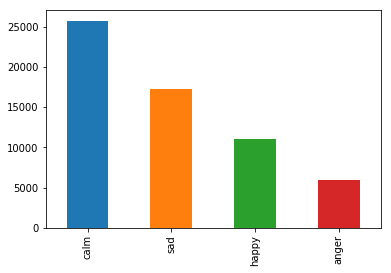

In [47]:
get_and_plot_x_y_data(quadrants=True, pad_lyric_data=False)

### CNN without lyrics2vec

In [12]:
mood_classification(
    # Controls
    name='w2v0_unequalized-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=False,                # no padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-04 18:50:14,763 - INFO: Engaging Low Memory Mode
2018-12-04 18:50:14,765 - INFO: Step 1: Load Lyrics
2018-12-04 18:50:14,765 - INFO: building lyrics dataset
2018-12-04 18:50:14,766 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-04 18:50:16,381 - INFO: imported data shape: (779056, 9)
2018-12-04 18:50:16,382 - INFO: Data shape before filtering: (779056, 9)
2018-12-04 18:50:16,402 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-04 18:50:16,429 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-04 18:50:16,445 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-04 18:50:16,453 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-04 18:50:17,404 - INFO: Shape after mood categorization: (59911, 7)
2018-12-04 18:50:18,410 - INFO: Data shape after lyrics addition: (59911, 8)
2018-12-04 18:50:18,412 - INFO: Df head:
3     An

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/

2018-12-04 18:53:08,673 - INFO: num_batches_per_epoch = 375
2018-12-04 18:53:08,674 - INFO: ***********************************************
2018-12-04 18:53:08,675 - INFO: Epoch 0/10

2018-12-04 18:53:08,680 - INFO: -----------------------------------------------
2018-12-04 18:53:08,681 - INFO: Epoch 0/10, Batch 0/375 (start=0, end=128)
2018-12-04 18:53:09,310 - INFO: step 1, loss 7.92023, acc 0.179688
2018-12-04 18:53:09,316 - INFO: -----------------------------------------------
2018-12-04 18:53:09,317 - INFO: Epoch 0/10, Batch 1/375 (start=128, end=256)
2018-12-04 18:53:09,878 - INFO: step 2, loss 4.36509, acc 0.226562
2018-12-04 18:53:09,879 - INFO: -----------------------------------------------
2018-12-04 18:53:09,880 - INFO: Epoch 0/10, Batch 2/375 (start=256, end=384)
2018-12-04 18:53:10,434 - INFO: step 3, loss 3.42932, acc 0.375
2018-12-04 18:53:10,435 - INFO: -----------------------------------------------
2018-12-04 18:53:10,436 - INFO: Epoch 0/10, Batch 3/375 (start=384, e

2018-12-04 18:53:28,581 - INFO: Epoch 0/10, Batch 35/375 (start=4480, end=4608)
2018-12-04 18:53:29,142 - INFO: step 36, loss 3.24826, acc 0.289062
2018-12-04 18:53:29,144 - INFO: -----------------------------------------------
2018-12-04 18:53:29,144 - INFO: Epoch 0/10, Batch 36/375 (start=4608, end=4736)
2018-12-04 18:53:29,698 - INFO: step 37, loss 3.38552, acc 0.3125
2018-12-04 18:53:29,699 - INFO: -----------------------------------------------
2018-12-04 18:53:29,700 - INFO: Epoch 0/10, Batch 37/375 (start=4736, end=4864)
2018-12-04 18:53:30,270 - INFO: step 38, loss 3.54052, acc 0.304688
2018-12-04 18:53:30,271 - INFO: -----------------------------------------------
2018-12-04 18:53:30,272 - INFO: Epoch 0/10, Batch 38/375 (start=4864, end=4992)
2018-12-04 18:53:30,829 - INFO: step 39, loss 3.57762, acc 0.34375
2018-12-04 18:53:30,831 - INFO: -----------------------------------------------
2018-12-04 18:53:30,832 - INFO: Epoch 0/10, Batch 39/375 (start=4992, end=5120)
2018-12-04 

2018-12-04 18:53:49,515 - INFO: step 72, loss 2.95292, acc 0.398438
2018-12-04 18:53:49,517 - INFO: -----------------------------------------------
2018-12-04 18:53:49,518 - INFO: Epoch 0/10, Batch 72/375 (start=9216, end=9344)
2018-12-04 18:53:50,078 - INFO: step 73, loss 3.17866, acc 0.351562
2018-12-04 18:53:50,079 - INFO: -----------------------------------------------
2018-12-04 18:53:50,080 - INFO: Epoch 0/10, Batch 73/375 (start=9344, end=9472)
2018-12-04 18:53:50,649 - INFO: step 74, loss 2.65839, acc 0.40625
2018-12-04 18:53:50,650 - INFO: -----------------------------------------------
2018-12-04 18:53:50,651 - INFO: Epoch 0/10, Batch 74/375 (start=9472, end=9600)
2018-12-04 18:53:51,204 - INFO: step 75, loss 2.72724, acc 0.40625
2018-12-04 18:53:51,206 - INFO: -----------------------------------------------
2018-12-04 18:53:51,206 - INFO: Epoch 0/10, Batch 75/375 (start=9600, end=9728)
2018-12-04 18:53:51,775 - INFO: step 76, loss 3.05796, acc 0.328125
2018-12-04 18:53:51,77

2018-12-04 18:54:15,507 - INFO: Epoch 0/10, Batch 104/375 (start=13312, end=13440)
2018-12-04 18:54:16,074 - INFO: step 105, loss 2.51385, acc 0.390625
2018-12-04 18:54:16,075 - INFO: -----------------------------------------------
2018-12-04 18:54:16,076 - INFO: Epoch 0/10, Batch 105/375 (start=13440, end=13568)
2018-12-04 18:54:16,631 - INFO: step 106, loss 2.92295, acc 0.359375
2018-12-04 18:54:16,632 - INFO: -----------------------------------------------
2018-12-04 18:54:16,633 - INFO: Epoch 0/10, Batch 106/375 (start=13568, end=13696)
2018-12-04 18:54:17,193 - INFO: step 107, loss 3.02677, acc 0.328125
2018-12-04 18:54:17,195 - INFO: -----------------------------------------------
2018-12-04 18:54:17,195 - INFO: Epoch 0/10, Batch 107/375 (start=13696, end=13824)
2018-12-04 18:54:17,748 - INFO: step 108, loss 2.6938, acc 0.40625
2018-12-04 18:54:17,750 - INFO: -----------------------------------------------
2018-12-04 18:54:17,750 - INFO: Epoch 0/10, Batch 108/375 (start=13824, en

2018-12-04 18:54:35,780 - INFO: -----------------------------------------------
2018-12-04 18:54:35,780 - INFO: Epoch 0/10, Batch 140/375 (start=17920, end=18048)
2018-12-04 18:54:36,346 - INFO: step 141, loss 2.44378, acc 0.492188
2018-12-04 18:54:36,348 - INFO: -----------------------------------------------
2018-12-04 18:54:36,348 - INFO: Epoch 0/10, Batch 141/375 (start=18048, end=18176)
2018-12-04 18:54:36,900 - INFO: step 142, loss 2.376, acc 0.46875
2018-12-04 18:54:36,902 - INFO: -----------------------------------------------
2018-12-04 18:54:36,903 - INFO: Epoch 0/10, Batch 142/375 (start=18176, end=18304)
2018-12-04 18:54:37,468 - INFO: step 143, loss 2.91045, acc 0.351562
2018-12-04 18:54:37,469 - INFO: -----------------------------------------------
2018-12-04 18:54:37,470 - INFO: Epoch 0/10, Batch 143/375 (start=18304, end=18432)
2018-12-04 18:54:38,019 - INFO: step 144, loss 2.82582, acc 0.359375
2018-12-04 18:54:38,020 - INFO: -------------------------------------------

2018-12-04 18:54:56,087 - INFO: step 176, loss 2.43999, acc 0.421875
2018-12-04 18:54:56,089 - INFO: -----------------------------------------------
2018-12-04 18:54:56,089 - INFO: Epoch 0/10, Batch 176/375 (start=22528, end=22656)
2018-12-04 18:54:56,656 - INFO: step 177, loss 2.48454, acc 0.390625
2018-12-04 18:54:56,658 - INFO: -----------------------------------------------
2018-12-04 18:54:56,658 - INFO: Epoch 0/10, Batch 177/375 (start=22656, end=22784)
2018-12-04 18:54:57,221 - INFO: step 178, loss 2.52068, acc 0.359375
2018-12-04 18:54:57,223 - INFO: -----------------------------------------------
2018-12-04 18:54:57,223 - INFO: Epoch 0/10, Batch 178/375 (start=22784, end=22912)
2018-12-04 18:54:57,791 - INFO: step 179, loss 2.38676, acc 0.390625
2018-12-04 18:54:57,792 - INFO: -----------------------------------------------
2018-12-04 18:54:57,793 - INFO: Epoch 0/10, Batch 179/375 (start=22912, end=23040)
2018-12-04 18:54:58,354 - INFO: step 180, loss 2.12932, acc 0.453125
201

2018-12-04 18:55:22,297 - INFO: Epoch 0/10, Batch 208/375 (start=26624, end=26752)
2018-12-04 18:55:22,863 - INFO: step 209, loss 1.99742, acc 0.5
2018-12-04 18:55:22,865 - INFO: -----------------------------------------------
2018-12-04 18:55:22,866 - INFO: Epoch 0/10, Batch 209/375 (start=26752, end=26880)
2018-12-04 18:55:23,430 - INFO: step 210, loss 2.46368, acc 0.4375
2018-12-04 18:55:23,431 - INFO: -----------------------------------------------
2018-12-04 18:55:23,432 - INFO: Epoch 0/10, Batch 210/375 (start=26880, end=27008)
2018-12-04 18:55:23,991 - INFO: step 211, loss 2.73468, acc 0.390625
2018-12-04 18:55:23,992 - INFO: -----------------------------------------------
2018-12-04 18:55:23,993 - INFO: Epoch 0/10, Batch 211/375 (start=27008, end=27136)
2018-12-04 18:55:24,549 - INFO: step 212, loss 1.99789, acc 0.460938
2018-12-04 18:55:24,550 - INFO: -----------------------------------------------
2018-12-04 18:55:24,551 - INFO: Epoch 0/10, Batch 212/375 (start=27136, end=272

2018-12-04 18:55:42,642 - INFO: -----------------------------------------------
2018-12-04 18:55:42,642 - INFO: Epoch 0/10, Batch 244/375 (start=31232, end=31360)
2018-12-04 18:55:43,202 - INFO: step 245, loss 2.45497, acc 0.398438
2018-12-04 18:55:43,204 - INFO: -----------------------------------------------
2018-12-04 18:55:43,204 - INFO: Epoch 0/10, Batch 245/375 (start=31360, end=31488)
2018-12-04 18:55:43,768 - INFO: step 246, loss 2.31021, acc 0.398438
2018-12-04 18:55:43,770 - INFO: -----------------------------------------------
2018-12-04 18:55:43,770 - INFO: Epoch 0/10, Batch 246/375 (start=31488, end=31616)
2018-12-04 18:55:44,330 - INFO: step 247, loss 2.39806, acc 0.398438
2018-12-04 18:55:44,331 - INFO: -----------------------------------------------
2018-12-04 18:55:44,332 - INFO: Epoch 0/10, Batch 247/375 (start=31616, end=31744)
2018-12-04 18:55:44,899 - INFO: step 248, loss 2.23333, acc 0.390625
2018-12-04 18:55:44,901 - INFO: ----------------------------------------

2018-12-04 18:56:03,067 - INFO: step 280, loss 2.3246, acc 0.398438
2018-12-04 18:56:03,069 - INFO: -----------------------------------------------
2018-12-04 18:56:03,069 - INFO: Epoch 0/10, Batch 280/375 (start=35840, end=35968)
2018-12-04 18:56:03,621 - INFO: step 281, loss 1.85042, acc 0.492188
2018-12-04 18:56:03,622 - INFO: -----------------------------------------------
2018-12-04 18:56:03,623 - INFO: Epoch 0/10, Batch 281/375 (start=35968, end=36096)
2018-12-04 18:56:04,191 - INFO: step 282, loss 2.38077, acc 0.335938
2018-12-04 18:56:04,192 - INFO: -----------------------------------------------
2018-12-04 18:56:04,193 - INFO: Epoch 0/10, Batch 282/375 (start=36096, end=36224)
2018-12-04 18:56:04,749 - INFO: step 283, loss 2.00936, acc 0.414062
2018-12-04 18:56:04,751 - INFO: -----------------------------------------------
2018-12-04 18:56:04,751 - INFO: Epoch 0/10, Batch 283/375 (start=36224, end=36352)
2018-12-04 18:56:05,315 - INFO: step 284, loss 2.12112, acc 0.351562
2018

2018-12-04 18:56:29,178 - INFO: Epoch 0/10, Batch 312/375 (start=39936, end=40064)
2018-12-04 18:56:29,737 - INFO: step 313, loss 2.1471, acc 0.375
2018-12-04 18:56:29,738 - INFO: -----------------------------------------------
2018-12-04 18:56:29,739 - INFO: Epoch 0/10, Batch 313/375 (start=40064, end=40192)
2018-12-04 18:56:30,300 - INFO: step 314, loss 1.97163, acc 0.445312
2018-12-04 18:56:30,301 - INFO: -----------------------------------------------
2018-12-04 18:56:30,302 - INFO: Epoch 0/10, Batch 314/375 (start=40192, end=40320)
2018-12-04 18:56:30,855 - INFO: step 315, loss 2.1887, acc 0.382812
2018-12-04 18:56:30,856 - INFO: -----------------------------------------------
2018-12-04 18:56:30,857 - INFO: Epoch 0/10, Batch 315/375 (start=40320, end=40448)
2018-12-04 18:56:31,415 - INFO: step 316, loss 2.03531, acc 0.328125
2018-12-04 18:56:31,416 - INFO: -----------------------------------------------
2018-12-04 18:56:31,417 - INFO: Epoch 0/10, Batch 316/375 (start=40448, end=4

2018-12-04 18:56:49,460 - INFO: -----------------------------------------------
2018-12-04 18:56:49,461 - INFO: Epoch 0/10, Batch 348/375 (start=44544, end=44672)
2018-12-04 18:56:50,021 - INFO: step 349, loss 1.83197, acc 0.40625
2018-12-04 18:56:50,023 - INFO: -----------------------------------------------
2018-12-04 18:56:50,023 - INFO: Epoch 0/10, Batch 349/375 (start=44672, end=44800)
2018-12-04 18:56:50,587 - INFO: step 350, loss 1.55035, acc 0.515625
2018-12-04 18:56:50,588 - INFO: -----------------------------------------------
2018-12-04 18:56:50,589 - INFO: Epoch 0/10, Batch 350/375 (start=44800, end=44928)
2018-12-04 18:56:51,151 - INFO: step 351, loss 1.55039, acc 0.453125
2018-12-04 18:56:51,153 - INFO: -----------------------------------------------
2018-12-04 18:56:51,153 - INFO: Epoch 0/10, Batch 351/375 (start=44928, end=45056)
2018-12-04 18:56:51,702 - INFO: step 352, loss 2.06849, acc 0.367188
2018-12-04 18:56:51,703 - INFO: -----------------------------------------

2018-12-04 18:57:08,858 - INFO: Epoch 1/10, Batch 8/375 (start=1024, end=1152)
2018-12-04 18:57:09,423 - INFO: step 384, loss 1.38568, acc 0.5625
2018-12-04 18:57:09,424 - INFO: -----------------------------------------------
2018-12-04 18:57:09,425 - INFO: Epoch 1/10, Batch 9/375 (start=1152, end=1280)
2018-12-04 18:57:09,992 - INFO: step 385, loss 1.47871, acc 0.5
2018-12-04 18:57:09,993 - INFO: -----------------------------------------------
2018-12-04 18:57:09,994 - INFO: Epoch 1/10, Batch 10/375 (start=1280, end=1408)
2018-12-04 18:57:10,556 - INFO: step 386, loss 1.27612, acc 0.585938
2018-12-04 18:57:10,558 - INFO: -----------------------------------------------
2018-12-04 18:57:10,559 - INFO: Epoch 1/10, Batch 11/375 (start=1408, end=1536)
2018-12-04 18:57:11,124 - INFO: step 387, loss 1.38092, acc 0.53125
2018-12-04 18:57:11,126 - INFO: -----------------------------------------------
2018-12-04 18:57:11,127 - INFO: Epoch 1/10, Batch 12/375 (start=1536, end=1664)
2018-12-04 18:

2018-12-04 18:57:35,558 - INFO: Epoch 1/10, Batch 41/375 (start=5248, end=5376)
2018-12-04 18:57:36,109 - INFO: step 417, loss 1.19409, acc 0.5625
2018-12-04 18:57:36,110 - INFO: -----------------------------------------------
2018-12-04 18:57:36,111 - INFO: Epoch 1/10, Batch 42/375 (start=5376, end=5504)
2018-12-04 18:57:36,681 - INFO: step 418, loss 1.67509, acc 0.484375
2018-12-04 18:57:36,683 - INFO: -----------------------------------------------
2018-12-04 18:57:36,683 - INFO: Epoch 1/10, Batch 43/375 (start=5504, end=5632)
2018-12-04 18:57:37,235 - INFO: step 419, loss 1.36493, acc 0.570312
2018-12-04 18:57:37,236 - INFO: -----------------------------------------------
2018-12-04 18:57:37,237 - INFO: Epoch 1/10, Batch 44/375 (start=5632, end=5760)
2018-12-04 18:57:37,792 - INFO: step 420, loss 1.66607, acc 0.453125
2018-12-04 18:57:37,793 - INFO: -----------------------------------------------
2018-12-04 18:57:37,794 - INFO: Epoch 1/10, Batch 45/375 (start=5760, end=5888)
2018-1

2018-12-04 18:57:55,809 - INFO: Epoch 1/10, Batch 77/375 (start=9856, end=9984)
2018-12-04 18:57:56,373 - INFO: step 453, loss 1.21621, acc 0.539062
2018-12-04 18:57:56,375 - INFO: -----------------------------------------------
2018-12-04 18:57:56,376 - INFO: Epoch 1/10, Batch 78/375 (start=9984, end=10112)
2018-12-04 18:57:56,937 - INFO: step 454, loss 1.30208, acc 0.476562
2018-12-04 18:57:56,939 - INFO: -----------------------------------------------
2018-12-04 18:57:56,939 - INFO: Epoch 1/10, Batch 79/375 (start=10112, end=10240)
2018-12-04 18:57:57,501 - INFO: step 455, loss 1.54065, acc 0.476562
2018-12-04 18:57:57,503 - INFO: -----------------------------------------------
2018-12-04 18:57:57,503 - INFO: Epoch 1/10, Batch 80/375 (start=10240, end=10368)
2018-12-04 18:57:58,065 - INFO: step 456, loss 1.2969, acc 0.539062
2018-12-04 18:57:58,067 - INFO: -----------------------------------------------
2018-12-04 18:57:58,067 - INFO: Epoch 1/10, Batch 81/375 (start=10368, end=10496

2018-12-04 18:58:16,124 - INFO: -----------------------------------------------
2018-12-04 18:58:16,124 - INFO: Epoch 1/10, Batch 113/375 (start=14464, end=14592)
2018-12-04 18:58:16,681 - INFO: step 489, loss 1.43192, acc 0.46875
2018-12-04 18:58:16,683 - INFO: -----------------------------------------------
2018-12-04 18:58:16,683 - INFO: Epoch 1/10, Batch 114/375 (start=14592, end=14720)
2018-12-04 18:58:17,250 - INFO: step 490, loss 1.16239, acc 0.539062
2018-12-04 18:58:17,252 - INFO: -----------------------------------------------
2018-12-04 18:58:17,253 - INFO: Epoch 1/10, Batch 115/375 (start=14720, end=14848)
2018-12-04 18:58:17,810 - INFO: step 491, loss 1.17936, acc 0.554688
2018-12-04 18:58:17,811 - INFO: -----------------------------------------------
2018-12-04 18:58:17,812 - INFO: Epoch 1/10, Batch 116/375 (start=14848, end=14976)
2018-12-04 18:58:18,372 - INFO: step 492, loss 1.31183, acc 0.5625
2018-12-04 18:58:18,373 - INFO: -------------------------------------------

2018-12-04 18:58:42,797 - INFO: step 521, loss 1.6305, acc 0.4375
2018-12-04 18:58:42,798 - INFO: -----------------------------------------------
2018-12-04 18:58:42,799 - INFO: Epoch 1/10, Batch 146/375 (start=18688, end=18816)
2018-12-04 18:58:43,343 - INFO: step 522, loss 1.6621, acc 0.484375
2018-12-04 18:58:43,344 - INFO: -----------------------------------------------
2018-12-04 18:58:43,345 - INFO: Epoch 1/10, Batch 147/375 (start=18816, end=18944)
2018-12-04 18:58:43,907 - INFO: step 523, loss 1.52823, acc 0.460938
2018-12-04 18:58:43,909 - INFO: -----------------------------------------------
2018-12-04 18:58:43,910 - INFO: Epoch 1/10, Batch 148/375 (start=18944, end=19072)
2018-12-04 18:58:44,471 - INFO: step 524, loss 1.2667, acc 0.578125
2018-12-04 18:58:44,473 - INFO: -----------------------------------------------
2018-12-04 18:58:44,474 - INFO: Epoch 1/10, Batch 149/375 (start=19072, end=19200)
2018-12-04 18:58:45,042 - INFO: step 525, loss 1.22639, acc 0.554688
2018-12-

2018-12-04 18:59:02,764 - INFO: Epoch 1/10, Batch 181/375 (start=23168, end=23296)
2018-12-04 18:59:03,336 - INFO: step 557, loss 1.44909, acc 0.546875
2018-12-04 18:59:03,338 - INFO: -----------------------------------------------
2018-12-04 18:59:03,339 - INFO: Epoch 1/10, Batch 182/375 (start=23296, end=23424)
2018-12-04 18:59:03,895 - INFO: step 558, loss 1.15706, acc 0.601562
2018-12-04 18:59:03,897 - INFO: -----------------------------------------------
2018-12-04 18:59:03,897 - INFO: Epoch 1/10, Batch 183/375 (start=23424, end=23552)
2018-12-04 18:59:04,468 - INFO: step 559, loss 1.45401, acc 0.46875
2018-12-04 18:59:04,470 - INFO: -----------------------------------------------
2018-12-04 18:59:04,471 - INFO: Epoch 1/10, Batch 184/375 (start=23552, end=23680)
2018-12-04 18:59:05,027 - INFO: step 560, loss 1.41768, acc 0.515625
2018-12-04 18:59:05,028 - INFO: -----------------------------------------------
2018-12-04 18:59:05,029 - INFO: Epoch 1/10, Batch 185/375 (start=23680, e

2018-12-04 18:59:23,076 - INFO: -----------------------------------------------
2018-12-04 18:59:23,077 - INFO: Epoch 1/10, Batch 217/375 (start=27776, end=27904)
2018-12-04 18:59:23,649 - INFO: step 593, loss 1.35792, acc 0.53125
2018-12-04 18:59:23,651 - INFO: -----------------------------------------------
2018-12-04 18:59:23,651 - INFO: Epoch 1/10, Batch 218/375 (start=27904, end=28032)
2018-12-04 18:59:24,206 - INFO: step 594, loss 1.27853, acc 0.546875
2018-12-04 18:59:24,208 - INFO: -----------------------------------------------
2018-12-04 18:59:24,208 - INFO: Epoch 1/10, Batch 219/375 (start=28032, end=28160)
2018-12-04 18:59:24,773 - INFO: step 595, loss 1.31128, acc 0.546875
2018-12-04 18:59:24,774 - INFO: -----------------------------------------------
2018-12-04 18:59:24,775 - INFO: Epoch 1/10, Batch 220/375 (start=28160, end=28288)
2018-12-04 18:59:25,332 - INFO: step 596, loss 1.10293, acc 0.648438
2018-12-04 18:59:25,334 - INFO: -----------------------------------------

2018-12-04 18:59:49,008 - INFO: Epoch 1/10, Batch 249/375 (start=31872, end=32000)
2018-12-04 18:59:49,563 - INFO: step 625, loss 1.11965, acc 0.5625
2018-12-04 18:59:49,564 - INFO: -----------------------------------------------
2018-12-04 18:59:49,565 - INFO: Epoch 1/10, Batch 250/375 (start=32000, end=32128)
2018-12-04 18:59:50,133 - INFO: step 626, loss 1.51188, acc 0.492188
2018-12-04 18:59:50,134 - INFO: -----------------------------------------------
2018-12-04 18:59:50,135 - INFO: Epoch 1/10, Batch 251/375 (start=32128, end=32256)
2018-12-04 18:59:50,690 - INFO: step 627, loss 1.32026, acc 0.507812
2018-12-04 18:59:50,692 - INFO: -----------------------------------------------
2018-12-04 18:59:50,692 - INFO: Epoch 1/10, Batch 252/375 (start=32256, end=32384)
2018-12-04 18:59:51,249 - INFO: step 628, loss 1.22104, acc 0.59375
2018-12-04 18:59:51,251 - INFO: -----------------------------------------------
2018-12-04 18:59:51,251 - INFO: Epoch 1/10, Batch 253/375 (start=32384, end

2018-12-04 19:00:09,346 - INFO: -----------------------------------------------
2018-12-04 19:00:09,346 - INFO: Epoch 1/10, Batch 285/375 (start=36480, end=36608)
2018-12-04 19:00:09,899 - INFO: step 661, loss 1.25912, acc 0.515625
2018-12-04 19:00:09,901 - INFO: -----------------------------------------------
2018-12-04 19:00:09,902 - INFO: Epoch 1/10, Batch 286/375 (start=36608, end=36736)
2018-12-04 19:00:10,466 - INFO: step 662, loss 1.19044, acc 0.515625
2018-12-04 19:00:10,468 - INFO: -----------------------------------------------
2018-12-04 19:00:10,468 - INFO: Epoch 1/10, Batch 287/375 (start=36736, end=36864)
2018-12-04 19:00:11,032 - INFO: step 663, loss 1.13539, acc 0.515625
2018-12-04 19:00:11,034 - INFO: -----------------------------------------------
2018-12-04 19:00:11,034 - INFO: Epoch 1/10, Batch 288/375 (start=36864, end=36992)
2018-12-04 19:00:11,593 - INFO: step 664, loss 1.13772, acc 0.609375
2018-12-04 19:00:11,595 - INFO: ----------------------------------------

2018-12-04 19:00:29,640 - INFO: step 696, loss 1.26438, acc 0.53125
2018-12-04 19:00:29,641 - INFO: -----------------------------------------------
2018-12-04 19:00:29,642 - INFO: Epoch 1/10, Batch 321/375 (start=41088, end=41216)
2018-12-04 19:00:30,204 - INFO: step 697, loss 1.31838, acc 0.476562
2018-12-04 19:00:30,206 - INFO: -----------------------------------------------
2018-12-04 19:00:30,206 - INFO: Epoch 1/10, Batch 322/375 (start=41216, end=41344)
2018-12-04 19:00:30,774 - INFO: step 698, loss 1.00838, acc 0.59375
2018-12-04 19:00:30,776 - INFO: -----------------------------------------------
2018-12-04 19:00:30,777 - INFO: Epoch 1/10, Batch 323/375 (start=41344, end=41472)
2018-12-04 19:00:31,334 - INFO: step 699, loss 1.01132, acc 0.570312
2018-12-04 19:00:31,336 - INFO: -----------------------------------------------
2018-12-04 19:00:31,336 - INFO: Epoch 1/10, Batch 324/375 (start=41472, end=41600)
2018-12-04 19:00:31,893 - INFO: step 700, loss 1.27585, acc 0.484375
2018-

2018-12-04 19:00:55,702 - INFO: Epoch 1/10, Batch 353/375 (start=45184, end=45312)
2018-12-04 19:00:56,267 - INFO: step 729, loss 1.32432, acc 0.546875
2018-12-04 19:00:56,268 - INFO: -----------------------------------------------
2018-12-04 19:00:56,269 - INFO: Epoch 1/10, Batch 354/375 (start=45312, end=45440)
2018-12-04 19:00:56,824 - INFO: step 730, loss 1.05768, acc 0.640625
2018-12-04 19:00:56,826 - INFO: -----------------------------------------------
2018-12-04 19:00:56,827 - INFO: Epoch 1/10, Batch 355/375 (start=45440, end=45568)
2018-12-04 19:00:57,387 - INFO: step 731, loss 1.37846, acc 0.507812
2018-12-04 19:00:57,388 - INFO: -----------------------------------------------
2018-12-04 19:00:57,389 - INFO: Epoch 1/10, Batch 356/375 (start=45568, end=45696)
2018-12-04 19:00:57,939 - INFO: step 732, loss 1.16404, acc 0.484375
2018-12-04 19:00:57,941 - INFO: -----------------------------------------------
2018-12-04 19:00:57,941 - INFO: Epoch 1/10, Batch 357/375 (start=45696, 

2018-12-04 19:01:15,623 - INFO: step 764, loss 0.916622, acc 0.664062
2018-12-04 19:01:15,624 - INFO: -----------------------------------------------
2018-12-04 19:01:15,625 - INFO: Epoch 2/10, Batch 14/375 (start=1792, end=1920)
2018-12-04 19:01:16,179 - INFO: step 765, loss 0.947765, acc 0.59375
2018-12-04 19:01:16,180 - INFO: -----------------------------------------------
2018-12-04 19:01:16,181 - INFO: Epoch 2/10, Batch 15/375 (start=1920, end=2048)
2018-12-04 19:01:16,751 - INFO: step 766, loss 0.772839, acc 0.6875
2018-12-04 19:01:16,753 - INFO: -----------------------------------------------
2018-12-04 19:01:16,753 - INFO: Epoch 2/10, Batch 16/375 (start=2048, end=2176)
2018-12-04 19:01:17,302 - INFO: step 767, loss 0.926186, acc 0.601562
2018-12-04 19:01:17,304 - INFO: -----------------------------------------------
2018-12-04 19:01:17,304 - INFO: Epoch 2/10, Batch 17/375 (start=2176, end=2304)
2018-12-04 19:01:17,866 - INFO: step 768, loss 1.16084, acc 0.65625
2018-12-04 19:0

2018-12-04 19:01:35,881 - INFO: step 800, loss 0.970698, acc 0.671875
2018-12-04 19:01:35,883 - INFO: 
Evaluation:
2018-12-04 19:01:35,883 - INFO: Validation Step
2018-12-04 19:01:44,237 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-mood-quadrants/800_confusion.csv
2018-12-04 19:01:44,238 - INFO: step 800, loss 1.11708, acc 0.547989
2018-12-04 19:01:44,239 - INFO: 
2018-12-04 19:01:44,380 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-mood-quadrants/checkpoints/model-800

2018-12-04 19:01:44,382 - INFO: -----------------------------------------------
2018-12-04 19:01:44,382 - INFO: Epoch 2/10, Batch 50/375 (start=6400, end=6528)
2018-12-04 19:01:44,948 - INFO: step 801, loss 0.903325, acc 0.664

2018-12-04 19:02:02,936 - INFO: step 833, loss 0.993167, acc 0.578125
2018-12-04 19:02:02,937 - INFO: -----------------------------------------------
2018-12-04 19:02:02,938 - INFO: Epoch 2/10, Batch 83/375 (start=10624, end=10752)
2018-12-04 19:02:03,498 - INFO: step 834, loss 1.09614, acc 0.53125
2018-12-04 19:02:03,501 - INFO: -----------------------------------------------
2018-12-04 19:02:03,502 - INFO: Epoch 2/10, Batch 84/375 (start=10752, end=10880)
2018-12-04 19:02:04,055 - INFO: step 835, loss 0.90544, acc 0.671875
2018-12-04 19:02:04,056 - INFO: -----------------------------------------------
2018-12-04 19:02:04,057 - INFO: Epoch 2/10, Batch 85/375 (start=10880, end=11008)
2018-12-04 19:02:04,624 - INFO: step 836, loss 0.724399, acc 0.734375
2018-12-04 19:02:04,626 - INFO: -----------------------------------------------
2018-12-04 19:02:04,626 - INFO: Epoch 2/10, Batch 86/375 (start=11008, end=11136)
2018-12-04 19:02:05,186 - INFO: step 837, loss 1.0399, acc 0.617188
2018-12

2018-12-04 19:02:22,613 - INFO: Epoch 2/10, Batch 118/375 (start=15104, end=15232)
2018-12-04 19:02:23,172 - INFO: step 869, loss 1.2151, acc 0.523438
2018-12-04 19:02:23,174 - INFO: -----------------------------------------------
2018-12-04 19:02:23,174 - INFO: Epoch 2/10, Batch 119/375 (start=15232, end=15360)
2018-12-04 19:02:23,734 - INFO: step 870, loss 0.955848, acc 0.65625
2018-12-04 19:02:23,736 - INFO: -----------------------------------------------
2018-12-04 19:02:23,737 - INFO: Epoch 2/10, Batch 120/375 (start=15360, end=15488)
2018-12-04 19:02:24,299 - INFO: step 871, loss 1.17353, acc 0.507812
2018-12-04 19:02:24,300 - INFO: -----------------------------------------------
2018-12-04 19:02:24,301 - INFO: Epoch 2/10, Batch 121/375 (start=15488, end=15616)
2018-12-04 19:02:24,867 - INFO: step 872, loss 1.04673, acc 0.609375
2018-12-04 19:02:24,869 - INFO: -----------------------------------------------
2018-12-04 19:02:24,869 - INFO: Epoch 2/10, Batch 122/375 (start=15616, e

2018-12-04 19:02:49,262 - INFO: step 901, loss 1.07681, acc 0.601562
2018-12-04 19:02:49,263 - INFO: -----------------------------------------------
2018-12-04 19:02:49,264 - INFO: Epoch 2/10, Batch 151/375 (start=19328, end=19456)
2018-12-04 19:02:49,819 - INFO: step 902, loss 0.851748, acc 0.71875
2018-12-04 19:02:49,820 - INFO: -----------------------------------------------
2018-12-04 19:02:49,821 - INFO: Epoch 2/10, Batch 152/375 (start=19456, end=19584)
2018-12-04 19:02:50,377 - INFO: step 903, loss 0.935458, acc 0.664062
2018-12-04 19:02:50,378 - INFO: -----------------------------------------------
2018-12-04 19:02:50,379 - INFO: Epoch 2/10, Batch 153/375 (start=19584, end=19712)
2018-12-04 19:02:50,929 - INFO: step 904, loss 0.955746, acc 0.632812
2018-12-04 19:02:50,930 - INFO: -----------------------------------------------
2018-12-04 19:02:50,931 - INFO: Epoch 2/10, Batch 154/375 (start=19712, end=19840)
2018-12-04 19:02:51,495 - INFO: step 905, loss 1.16011, acc 0.601562
2

2018-12-04 19:03:08,917 - INFO: Epoch 2/10, Batch 186/375 (start=23808, end=23936)
2018-12-04 19:03:09,481 - INFO: step 937, loss 0.952047, acc 0.625
2018-12-04 19:03:09,483 - INFO: -----------------------------------------------
2018-12-04 19:03:09,483 - INFO: Epoch 2/10, Batch 187/375 (start=23936, end=24064)
2018-12-04 19:03:10,048 - INFO: step 938, loss 0.881147, acc 0.632812
2018-12-04 19:03:10,050 - INFO: -----------------------------------------------
2018-12-04 19:03:10,051 - INFO: Epoch 2/10, Batch 188/375 (start=24064, end=24192)
2018-12-04 19:03:10,610 - INFO: step 939, loss 1.06107, acc 0.585938
2018-12-04 19:03:10,611 - INFO: -----------------------------------------------
2018-12-04 19:03:10,612 - INFO: Epoch 2/10, Batch 189/375 (start=24192, end=24320)
2018-12-04 19:03:11,174 - INFO: step 940, loss 1.04766, acc 0.640625
2018-12-04 19:03:11,175 - INFO: -----------------------------------------------
2018-12-04 19:03:11,176 - INFO: Epoch 2/10, Batch 190/375 (start=24320, e

2018-12-04 19:03:29,192 - INFO: step 972, loss 0.923299, acc 0.640625
2018-12-04 19:03:29,194 - INFO: -----------------------------------------------
2018-12-04 19:03:29,194 - INFO: Epoch 2/10, Batch 222/375 (start=28416, end=28544)
2018-12-04 19:03:29,752 - INFO: step 973, loss 0.950012, acc 0.625
2018-12-04 19:03:29,754 - INFO: -----------------------------------------------
2018-12-04 19:03:29,754 - INFO: Epoch 2/10, Batch 223/375 (start=28544, end=28672)
2018-12-04 19:03:30,318 - INFO: step 974, loss 0.859204, acc 0.664062
2018-12-04 19:03:30,320 - INFO: -----------------------------------------------
2018-12-04 19:03:30,321 - INFO: Epoch 2/10, Batch 224/375 (start=28672, end=28800)
2018-12-04 19:03:30,877 - INFO: step 975, loss 0.953967, acc 0.640625
2018-12-04 19:03:30,879 - INFO: -----------------------------------------------
2018-12-04 19:03:30,880 - INFO: Epoch 2/10, Batch 225/375 (start=28800, end=28928)
2018-12-04 19:03:31,448 - INFO: step 976, loss 1.13413, acc 0.539062
20

2018-12-04 19:03:55,108 - INFO: -----------------------------------------------
2018-12-04 19:03:55,108 - INFO: Epoch 2/10, Batch 254/375 (start=32512, end=32640)
2018-12-04 19:03:55,665 - INFO: step 1005, loss 0.744783, acc 0.695312
2018-12-04 19:03:55,666 - INFO: -----------------------------------------------
2018-12-04 19:03:55,667 - INFO: Epoch 2/10, Batch 255/375 (start=32640, end=32768)
2018-12-04 19:03:56,225 - INFO: step 1006, loss 0.792544, acc 0.695312
2018-12-04 19:03:56,227 - INFO: -----------------------------------------------
2018-12-04 19:03:56,227 - INFO: Epoch 2/10, Batch 256/375 (start=32768, end=32896)
2018-12-04 19:03:56,783 - INFO: step 1007, loss 0.920071, acc 0.617188
2018-12-04 19:03:56,785 - INFO: -----------------------------------------------
2018-12-04 19:03:56,785 - INFO: Epoch 2/10, Batch 257/375 (start=32896, end=33024)
2018-12-04 19:03:57,340 - INFO: step 1008, loss 0.948874, acc 0.640625
2018-12-04 19:03:57,342 - INFO: --------------------------------

2018-12-04 19:04:14,767 - INFO: Epoch 2/10, Batch 289/375 (start=36992, end=37120)
2018-12-04 19:04:15,316 - INFO: step 1040, loss 1.10271, acc 0.578125
2018-12-04 19:04:15,318 - INFO: -----------------------------------------------
2018-12-04 19:04:15,318 - INFO: Epoch 2/10, Batch 290/375 (start=37120, end=37248)
2018-12-04 19:04:15,887 - INFO: step 1041, loss 1.0368, acc 0.578125
2018-12-04 19:04:15,888 - INFO: -----------------------------------------------
2018-12-04 19:04:15,889 - INFO: Epoch 2/10, Batch 291/375 (start=37248, end=37376)
2018-12-04 19:04:16,440 - INFO: step 1042, loss 0.973262, acc 0.648438
2018-12-04 19:04:16,442 - INFO: -----------------------------------------------
2018-12-04 19:04:16,442 - INFO: Epoch 2/10, Batch 292/375 (start=37376, end=37504)
2018-12-04 19:04:17,009 - INFO: step 1043, loss 0.935786, acc 0.617188
2018-12-04 19:04:17,011 - INFO: -----------------------------------------------
2018-12-04 19:04:17,012 - INFO: Epoch 2/10, Batch 293/375 (start=37

2018-12-04 19:04:34,986 - INFO: step 1075, loss 0.947682, acc 0.640625
2018-12-04 19:04:34,988 - INFO: -----------------------------------------------
2018-12-04 19:04:34,988 - INFO: Epoch 2/10, Batch 325/375 (start=41600, end=41728)
2018-12-04 19:04:35,546 - INFO: step 1076, loss 1.06075, acc 0.578125
2018-12-04 19:04:35,548 - INFO: -----------------------------------------------
2018-12-04 19:04:35,548 - INFO: Epoch 2/10, Batch 326/375 (start=41728, end=41856)
2018-12-04 19:04:36,117 - INFO: step 1077, loss 0.95109, acc 0.585938
2018-12-04 19:04:36,119 - INFO: -----------------------------------------------
2018-12-04 19:04:36,120 - INFO: Epoch 2/10, Batch 327/375 (start=41856, end=41984)
2018-12-04 19:04:36,679 - INFO: step 1078, loss 0.961877, acc 0.609375
2018-12-04 19:04:36,681 - INFO: -----------------------------------------------
2018-12-04 19:04:36,681 - INFO: Epoch 2/10, Batch 328/375 (start=41984, end=42112)
2018-12-04 19:04:37,246 - INFO: step 1079, loss 0.98756, acc 0.578

2018-12-04 19:05:01,130 - INFO: -----------------------------------------------
2018-12-04 19:05:01,130 - INFO: Epoch 2/10, Batch 357/375 (start=45696, end=45824)
2018-12-04 19:05:01,694 - INFO: step 1108, loss 1.1378, acc 0.554688
2018-12-04 19:05:01,696 - INFO: -----------------------------------------------
2018-12-04 19:05:01,696 - INFO: Epoch 2/10, Batch 358/375 (start=45824, end=45952)
2018-12-04 19:05:02,248 - INFO: step 1109, loss 0.80901, acc 0.664062
2018-12-04 19:05:02,250 - INFO: -----------------------------------------------
2018-12-04 19:05:02,250 - INFO: Epoch 2/10, Batch 359/375 (start=45952, end=46080)
2018-12-04 19:05:02,817 - INFO: step 1110, loss 1.10383, acc 0.585938
2018-12-04 19:05:02,818 - INFO: -----------------------------------------------
2018-12-04 19:05:02,819 - INFO: Epoch 2/10, Batch 360/375 (start=46080, end=46208)
2018-12-04 19:05:03,371 - INFO: step 1111, loss 1.0146, acc 0.609375
2018-12-04 19:05:03,373 - INFO: --------------------------------------

2018-12-04 19:05:20,474 - INFO: -----------------------------------------------
2018-12-04 19:05:20,475 - INFO: Epoch 3/10, Batch 17/375 (start=2176, end=2304)
2018-12-04 19:05:21,041 - INFO: step 1143, loss 0.528879, acc 0.820312
2018-12-04 19:05:21,042 - INFO: -----------------------------------------------
2018-12-04 19:05:21,043 - INFO: Epoch 3/10, Batch 18/375 (start=2304, end=2432)
2018-12-04 19:05:21,605 - INFO: step 1144, loss 0.660256, acc 0.734375
2018-12-04 19:05:21,607 - INFO: -----------------------------------------------
2018-12-04 19:05:21,607 - INFO: Epoch 3/10, Batch 19/375 (start=2432, end=2560)
2018-12-04 19:05:22,167 - INFO: step 1145, loss 0.599845, acc 0.78125
2018-12-04 19:05:22,168 - INFO: -----------------------------------------------
2018-12-04 19:05:22,169 - INFO: Epoch 3/10, Batch 20/375 (start=2560, end=2688)
2018-12-04 19:05:22,738 - INFO: step 1146, loss 0.765219, acc 0.695312
2018-12-04 19:05:22,739 - INFO: ---------------------------------------------

2018-12-04 19:05:40,750 - INFO: step 1178, loss 0.832341, acc 0.6875
2018-12-04 19:05:40,751 - INFO: -----------------------------------------------
2018-12-04 19:05:40,752 - INFO: Epoch 3/10, Batch 53/375 (start=6784, end=6912)
2018-12-04 19:05:41,311 - INFO: step 1179, loss 0.893339, acc 0.65625
2018-12-04 19:05:41,312 - INFO: -----------------------------------------------
2018-12-04 19:05:41,313 - INFO: Epoch 3/10, Batch 54/375 (start=6912, end=7040)
2018-12-04 19:05:41,870 - INFO: step 1180, loss 0.6346, acc 0.71875
2018-12-04 19:05:41,872 - INFO: -----------------------------------------------
2018-12-04 19:05:41,873 - INFO: Epoch 3/10, Batch 55/375 (start=7040, end=7168)
2018-12-04 19:05:42,433 - INFO: step 1181, loss 0.678637, acc 0.75
2018-12-04 19:05:42,434 - INFO: -----------------------------------------------
2018-12-04 19:05:42,435 - INFO: Epoch 3/10, Batch 56/375 (start=7168, end=7296)
2018-12-04 19:05:42,985 - INFO: step 1182, loss 0.748634, acc 0.671875
2018-12-04 19:0

2018-12-04 19:06:06,680 - INFO: Epoch 3/10, Batch 85/375 (start=10880, end=11008)
2018-12-04 19:06:07,232 - INFO: step 1211, loss 0.885154, acc 0.609375
2018-12-04 19:06:07,234 - INFO: -----------------------------------------------
2018-12-04 19:06:07,234 - INFO: Epoch 3/10, Batch 86/375 (start=11008, end=11136)
2018-12-04 19:06:07,790 - INFO: step 1212, loss 0.763175, acc 0.703125
2018-12-04 19:06:07,792 - INFO: -----------------------------------------------
2018-12-04 19:06:07,792 - INFO: Epoch 3/10, Batch 87/375 (start=11136, end=11264)
2018-12-04 19:06:08,340 - INFO: step 1213, loss 0.764158, acc 0.726562
2018-12-04 19:06:08,342 - INFO: -----------------------------------------------
2018-12-04 19:06:08,342 - INFO: Epoch 3/10, Batch 88/375 (start=11264, end=11392)
2018-12-04 19:06:08,923 - INFO: step 1214, loss 0.874454, acc 0.679688
2018-12-04 19:06:08,924 - INFO: -----------------------------------------------
2018-12-04 19:06:08,925 - INFO: Epoch 3/10, Batch 89/375 (start=1139

2018-12-04 19:06:26,871 - INFO: step 1246, loss 0.815967, acc 0.71875
2018-12-04 19:06:26,873 - INFO: -----------------------------------------------
2018-12-04 19:06:26,873 - INFO: Epoch 3/10, Batch 121/375 (start=15488, end=15616)
2018-12-04 19:06:27,418 - INFO: step 1247, loss 0.747835, acc 0.734375
2018-12-04 19:06:27,419 - INFO: -----------------------------------------------
2018-12-04 19:06:27,420 - INFO: Epoch 3/10, Batch 122/375 (start=15616, end=15744)
2018-12-04 19:06:27,973 - INFO: step 1248, loss 0.920144, acc 0.632812
2018-12-04 19:06:27,974 - INFO: -----------------------------------------------
2018-12-04 19:06:27,975 - INFO: Epoch 3/10, Batch 123/375 (start=15744, end=15872)
2018-12-04 19:06:28,528 - INFO: step 1249, loss 0.833382, acc 0.671875
2018-12-04 19:06:28,529 - INFO: -----------------------------------------------
2018-12-04 19:06:28,530 - INFO: Epoch 3/10, Batch 124/375 (start=15872, end=16000)
2018-12-04 19:06:29,087 - INFO: step 1250, loss 0.751691, acc 0.6

2018-12-04 19:06:46,465 - INFO: -----------------------------------------------
2018-12-04 19:06:46,465 - INFO: Epoch 3/10, Batch 156/375 (start=19968, end=20096)
2018-12-04 19:06:47,027 - INFO: step 1282, loss 0.736903, acc 0.703125
2018-12-04 19:06:47,029 - INFO: -----------------------------------------------
2018-12-04 19:06:47,029 - INFO: Epoch 3/10, Batch 157/375 (start=20096, end=20224)
2018-12-04 19:06:47,590 - INFO: step 1283, loss 1.01237, acc 0.601562
2018-12-04 19:06:47,591 - INFO: -----------------------------------------------
2018-12-04 19:06:47,592 - INFO: Epoch 3/10, Batch 158/375 (start=20224, end=20352)
2018-12-04 19:06:48,154 - INFO: step 1284, loss 0.735149, acc 0.742188
2018-12-04 19:06:48,156 - INFO: -----------------------------------------------
2018-12-04 19:06:48,156 - INFO: Epoch 3/10, Batch 159/375 (start=20352, end=20480)
2018-12-04 19:06:48,713 - INFO: step 1285, loss 0.852569, acc 0.648438
2018-12-04 19:06:48,715 - INFO: ---------------------------------

2018-12-04 19:07:12,604 - INFO: Epoch 3/10, Batch 188/375 (start=24064, end=24192)
2018-12-04 19:07:13,154 - INFO: step 1314, loss 0.645074, acc 0.773438
2018-12-04 19:07:13,156 - INFO: -----------------------------------------------
2018-12-04 19:07:13,156 - INFO: Epoch 3/10, Batch 189/375 (start=24192, end=24320)
2018-12-04 19:07:13,724 - INFO: step 1315, loss 0.781028, acc 0.734375
2018-12-04 19:07:13,726 - INFO: -----------------------------------------------
2018-12-04 19:07:13,727 - INFO: Epoch 3/10, Batch 190/375 (start=24320, end=24448)
2018-12-04 19:07:14,279 - INFO: step 1316, loss 0.84023, acc 0.695312
2018-12-04 19:07:14,281 - INFO: -----------------------------------------------
2018-12-04 19:07:14,282 - INFO: Epoch 3/10, Batch 191/375 (start=24448, end=24576)
2018-12-04 19:07:14,842 - INFO: step 1317, loss 0.941844, acc 0.65625
2018-12-04 19:07:14,843 - INFO: -----------------------------------------------
2018-12-04 19:07:14,844 - INFO: Epoch 3/10, Batch 192/375 (start=2

2018-12-04 19:07:32,822 - INFO: step 1349, loss 0.792852, acc 0.695312
2018-12-04 19:07:32,823 - INFO: -----------------------------------------------
2018-12-04 19:07:32,824 - INFO: Epoch 3/10, Batch 224/375 (start=28672, end=28800)
2018-12-04 19:07:33,383 - INFO: step 1350, loss 0.734007, acc 0.703125
2018-12-04 19:07:33,384 - INFO: -----------------------------------------------
2018-12-04 19:07:33,385 - INFO: Epoch 3/10, Batch 225/375 (start=28800, end=28928)
2018-12-04 19:07:33,948 - INFO: step 1351, loss 0.795448, acc 0.710938
2018-12-04 19:07:33,950 - INFO: -----------------------------------------------
2018-12-04 19:07:33,951 - INFO: Epoch 3/10, Batch 226/375 (start=28928, end=29056)
2018-12-04 19:07:34,508 - INFO: step 1352, loss 0.705379, acc 0.71875
2018-12-04 19:07:34,510 - INFO: -----------------------------------------------
2018-12-04 19:07:34,511 - INFO: Epoch 3/10, Batch 227/375 (start=29056, end=29184)
2018-12-04 19:07:35,077 - INFO: step 1353, loss 0.692044, acc 0.7

2018-12-04 19:07:52,536 - INFO: -----------------------------------------------
2018-12-04 19:07:52,536 - INFO: Epoch 3/10, Batch 259/375 (start=33152, end=33280)
2018-12-04 19:07:53,099 - INFO: step 1385, loss 0.639283, acc 0.734375
2018-12-04 19:07:53,101 - INFO: -----------------------------------------------
2018-12-04 19:07:53,102 - INFO: Epoch 3/10, Batch 260/375 (start=33280, end=33408)
2018-12-04 19:07:53,663 - INFO: step 1386, loss 0.759869, acc 0.71875
2018-12-04 19:07:53,665 - INFO: -----------------------------------------------
2018-12-04 19:07:53,665 - INFO: Epoch 3/10, Batch 261/375 (start=33408, end=33536)
2018-12-04 19:07:54,225 - INFO: step 1387, loss 0.779459, acc 0.6875
2018-12-04 19:07:54,226 - INFO: -----------------------------------------------
2018-12-04 19:07:54,227 - INFO: Epoch 3/10, Batch 262/375 (start=33536, end=33664)
2018-12-04 19:07:54,785 - INFO: step 1388, loss 0.673836, acc 0.75
2018-12-04 19:07:54,787 - INFO: ---------------------------------------

2018-12-04 19:08:18,619 - INFO: Epoch 3/10, Batch 291/375 (start=37248, end=37376)
2018-12-04 19:08:19,174 - INFO: step 1417, loss 0.771204, acc 0.734375
2018-12-04 19:08:19,175 - INFO: -----------------------------------------------
2018-12-04 19:08:19,176 - INFO: Epoch 3/10, Batch 292/375 (start=37376, end=37504)
2018-12-04 19:08:19,736 - INFO: step 1418, loss 0.833873, acc 0.671875
2018-12-04 19:08:19,738 - INFO: -----------------------------------------------
2018-12-04 19:08:19,738 - INFO: Epoch 3/10, Batch 293/375 (start=37504, end=37632)
2018-12-04 19:08:20,300 - INFO: step 1419, loss 0.916738, acc 0.65625
2018-12-04 19:08:20,301 - INFO: -----------------------------------------------
2018-12-04 19:08:20,302 - INFO: Epoch 3/10, Batch 294/375 (start=37632, end=37760)
2018-12-04 19:08:20,863 - INFO: step 1420, loss 0.830323, acc 0.640625
2018-12-04 19:08:20,864 - INFO: -----------------------------------------------
2018-12-04 19:08:20,865 - INFO: Epoch 3/10, Batch 295/375 (start=

2018-12-04 19:08:38,833 - INFO: step 1452, loss 0.965923, acc 0.601562
2018-12-04 19:08:38,834 - INFO: -----------------------------------------------
2018-12-04 19:08:38,835 - INFO: Epoch 3/10, Batch 327/375 (start=41856, end=41984)
2018-12-04 19:08:39,402 - INFO: step 1453, loss 0.888054, acc 0.65625
2018-12-04 19:08:39,403 - INFO: -----------------------------------------------
2018-12-04 19:08:39,404 - INFO: Epoch 3/10, Batch 328/375 (start=41984, end=42112)
2018-12-04 19:08:39,965 - INFO: step 1454, loss 0.639868, acc 0.765625
2018-12-04 19:08:39,966 - INFO: -----------------------------------------------
2018-12-04 19:08:39,967 - INFO: Epoch 3/10, Batch 329/375 (start=42112, end=42240)
2018-12-04 19:08:40,528 - INFO: step 1455, loss 0.798348, acc 0.679688
2018-12-04 19:08:40,530 - INFO: -----------------------------------------------
2018-12-04 19:08:40,531 - INFO: Epoch 3/10, Batch 330/375 (start=42240, end=42368)
2018-12-04 19:08:41,085 - INFO: step 1456, loss 0.722637, acc 0.7

2018-12-04 19:08:58,497 - INFO: -----------------------------------------------
2018-12-04 19:08:58,498 - INFO: Epoch 3/10, Batch 362/375 (start=46336, end=46464)
2018-12-04 19:08:59,055 - INFO: step 1488, loss 0.702804, acc 0.710938
2018-12-04 19:08:59,057 - INFO: -----------------------------------------------
2018-12-04 19:08:59,058 - INFO: Epoch 3/10, Batch 363/375 (start=46464, end=46592)
2018-12-04 19:08:59,619 - INFO: step 1489, loss 0.764535, acc 0.734375
2018-12-04 19:08:59,620 - INFO: -----------------------------------------------
2018-12-04 19:08:59,621 - INFO: Epoch 3/10, Batch 364/375 (start=46592, end=46720)
2018-12-04 19:09:00,190 - INFO: step 1490, loss 0.799067, acc 0.703125
2018-12-04 19:09:00,191 - INFO: -----------------------------------------------
2018-12-04 19:09:00,191 - INFO: Epoch 3/10, Batch 365/375 (start=46720, end=46848)
2018-12-04 19:09:00,764 - INFO: step 1491, loss 0.877486, acc 0.648438
2018-12-04 19:09:00,766 - INFO: --------------------------------

2018-12-04 19:09:24,302 - INFO: -----------------------------------------------
2018-12-04 19:09:24,302 - INFO: Epoch 4/10, Batch 19/375 (start=2432, end=2560)
2018-12-04 19:09:24,871 - INFO: step 1520, loss 0.610367, acc 0.773438
2018-12-04 19:09:24,873 - INFO: -----------------------------------------------
2018-12-04 19:09:24,873 - INFO: Epoch 4/10, Batch 20/375 (start=2560, end=2688)
2018-12-04 19:09:25,424 - INFO: step 1521, loss 0.730921, acc 0.695312
2018-12-04 19:09:25,426 - INFO: -----------------------------------------------
2018-12-04 19:09:25,427 - INFO: Epoch 4/10, Batch 21/375 (start=2688, end=2816)
2018-12-04 19:09:25,995 - INFO: step 1522, loss 0.607463, acc 0.773438
2018-12-04 19:09:25,997 - INFO: -----------------------------------------------
2018-12-04 19:09:25,997 - INFO: Epoch 4/10, Batch 22/375 (start=2816, end=2944)
2018-12-04 19:09:26,555 - INFO: step 1523, loss 0.658864, acc 0.75
2018-12-04 19:09:26,557 - INFO: -----------------------------------------------


2018-12-04 19:09:44,568 - INFO: step 1555, loss 0.638209, acc 0.742188
2018-12-04 19:09:44,570 - INFO: -----------------------------------------------
2018-12-04 19:09:44,570 - INFO: Epoch 4/10, Batch 55/375 (start=7040, end=7168)
2018-12-04 19:09:45,136 - INFO: step 1556, loss 0.660107, acc 0.75
2018-12-04 19:09:45,138 - INFO: -----------------------------------------------
2018-12-04 19:09:45,138 - INFO: Epoch 4/10, Batch 56/375 (start=7168, end=7296)
2018-12-04 19:09:45,697 - INFO: step 1557, loss 0.71783, acc 0.742188
2018-12-04 19:09:45,699 - INFO: -----------------------------------------------
2018-12-04 19:09:45,699 - INFO: Epoch 4/10, Batch 57/375 (start=7296, end=7424)
2018-12-04 19:09:46,260 - INFO: step 1558, loss 0.548543, acc 0.8125
2018-12-04 19:09:46,262 - INFO: -----------------------------------------------
2018-12-04 19:09:46,263 - INFO: Epoch 4/10, Batch 58/375 (start=7424, end=7552)
2018-12-04 19:09:46,822 - INFO: step 1559, loss 0.764921, acc 0.695312
2018-12-04 1

2018-12-04 19:10:04,272 - INFO: Epoch 4/10, Batch 90/375 (start=11520, end=11648)
2018-12-04 19:10:04,829 - INFO: step 1591, loss 0.697843, acc 0.734375
2018-12-04 19:10:04,830 - INFO: -----------------------------------------------
2018-12-04 19:10:04,831 - INFO: Epoch 4/10, Batch 91/375 (start=11648, end=11776)
2018-12-04 19:10:05,390 - INFO: step 1592, loss 0.580163, acc 0.773438
2018-12-04 19:10:05,392 - INFO: -----------------------------------------------
2018-12-04 19:10:05,392 - INFO: Epoch 4/10, Batch 92/375 (start=11776, end=11904)
2018-12-04 19:10:05,951 - INFO: step 1593, loss 0.806311, acc 0.664062
2018-12-04 19:10:05,953 - INFO: -----------------------------------------------
2018-12-04 19:10:05,953 - INFO: Epoch 4/10, Batch 93/375 (start=11904, end=12032)
2018-12-04 19:10:06,515 - INFO: step 1594, loss 0.643939, acc 0.796875
2018-12-04 19:10:06,516 - INFO: -----------------------------------------------
2018-12-04 19:10:06,517 - INFO: Epoch 4/10, Batch 94/375 (start=1203

2018-12-04 19:10:30,919 - INFO: step 1623, loss 0.707633, acc 0.75
2018-12-04 19:10:30,920 - INFO: -----------------------------------------------
2018-12-04 19:10:30,921 - INFO: Epoch 4/10, Batch 123/375 (start=15744, end=15872)
2018-12-04 19:10:31,474 - INFO: step 1624, loss 0.696957, acc 0.734375
2018-12-04 19:10:31,475 - INFO: -----------------------------------------------
2018-12-04 19:10:31,476 - INFO: Epoch 4/10, Batch 124/375 (start=15872, end=16000)
2018-12-04 19:10:32,036 - INFO: step 1625, loss 0.617243, acc 0.765625
2018-12-04 19:10:32,038 - INFO: -----------------------------------------------
2018-12-04 19:10:32,038 - INFO: Epoch 4/10, Batch 125/375 (start=16000, end=16128)
2018-12-04 19:10:32,600 - INFO: step 1626, loss 0.562302, acc 0.765625
2018-12-04 19:10:32,601 - INFO: -----------------------------------------------
2018-12-04 19:10:32,602 - INFO: Epoch 4/10, Batch 126/375 (start=16128, end=16256)
2018-12-04 19:10:33,167 - INFO: step 1627, loss 0.687231, acc 0.7343

2018-12-04 19:10:50,613 - INFO: -----------------------------------------------
2018-12-04 19:10:50,613 - INFO: Epoch 4/10, Batch 158/375 (start=20224, end=20352)
2018-12-04 19:10:51,171 - INFO: step 1659, loss 0.670693, acc 0.703125
2018-12-04 19:10:51,173 - INFO: -----------------------------------------------
2018-12-04 19:10:51,173 - INFO: Epoch 4/10, Batch 159/375 (start=20352, end=20480)
2018-12-04 19:10:51,729 - INFO: step 1660, loss 0.704887, acc 0.6875
2018-12-04 19:10:51,731 - INFO: -----------------------------------------------
2018-12-04 19:10:51,731 - INFO: Epoch 4/10, Batch 160/375 (start=20480, end=20608)
2018-12-04 19:10:52,290 - INFO: step 1661, loss 0.725548, acc 0.6875
2018-12-04 19:10:52,292 - INFO: -----------------------------------------------
2018-12-04 19:10:52,292 - INFO: Epoch 4/10, Batch 161/375 (start=20608, end=20736)
2018-12-04 19:10:52,852 - INFO: step 1662, loss 0.600308, acc 0.765625
2018-12-04 19:10:52,853 - INFO: ------------------------------------

2018-12-04 19:11:10,382 - INFO: Epoch 4/10, Batch 193/375 (start=24704, end=24832)
2018-12-04 19:11:10,942 - INFO: step 1694, loss 0.691734, acc 0.71875
2018-12-04 19:11:10,943 - INFO: -----------------------------------------------
2018-12-04 19:11:10,944 - INFO: Epoch 4/10, Batch 194/375 (start=24832, end=24960)
2018-12-04 19:11:11,506 - INFO: step 1695, loss 0.584962, acc 0.757812
2018-12-04 19:11:11,508 - INFO: -----------------------------------------------
2018-12-04 19:11:11,508 - INFO: Epoch 4/10, Batch 195/375 (start=24960, end=25088)
2018-12-04 19:11:12,068 - INFO: step 1696, loss 0.60892, acc 0.804688
2018-12-04 19:11:12,070 - INFO: -----------------------------------------------
2018-12-04 19:11:12,070 - INFO: Epoch 4/10, Batch 196/375 (start=25088, end=25216)
2018-12-04 19:11:12,634 - INFO: step 1697, loss 0.612661, acc 0.734375
2018-12-04 19:11:12,635 - INFO: -----------------------------------------------
2018-12-04 19:11:12,636 - INFO: Epoch 4/10, Batch 197/375 (start=2

2018-12-04 19:11:37,168 - INFO: step 1726, loss 0.571983, acc 0.78125
2018-12-04 19:11:37,170 - INFO: -----------------------------------------------
2018-12-04 19:11:37,170 - INFO: Epoch 4/10, Batch 226/375 (start=28928, end=29056)
2018-12-04 19:11:37,719 - INFO: step 1727, loss 0.672331, acc 0.742188
2018-12-04 19:11:37,720 - INFO: -----------------------------------------------
2018-12-04 19:11:37,721 - INFO: Epoch 4/10, Batch 227/375 (start=29056, end=29184)
2018-12-04 19:11:38,283 - INFO: step 1728, loss 0.636226, acc 0.75
2018-12-04 19:11:38,285 - INFO: -----------------------------------------------
2018-12-04 19:11:38,285 - INFO: Epoch 4/10, Batch 228/375 (start=29184, end=29312)
2018-12-04 19:11:38,839 - INFO: step 1729, loss 0.640975, acc 0.78125
2018-12-04 19:11:38,840 - INFO: -----------------------------------------------
2018-12-04 19:11:38,841 - INFO: Epoch 4/10, Batch 229/375 (start=29312, end=29440)
2018-12-04 19:11:39,399 - INFO: step 1730, loss 0.705058, acc 0.703125

2018-12-04 19:11:56,792 - INFO: -----------------------------------------------
2018-12-04 19:11:56,793 - INFO: Epoch 4/10, Batch 261/375 (start=33408, end=33536)
2018-12-04 19:11:57,352 - INFO: step 1762, loss 0.94188, acc 0.625
2018-12-04 19:11:57,354 - INFO: -----------------------------------------------
2018-12-04 19:11:57,354 - INFO: Epoch 4/10, Batch 262/375 (start=33536, end=33664)
2018-12-04 19:11:57,910 - INFO: step 1763, loss 0.770629, acc 0.710938
2018-12-04 19:11:57,912 - INFO: -----------------------------------------------
2018-12-04 19:11:57,913 - INFO: Epoch 4/10, Batch 263/375 (start=33664, end=33792)
2018-12-04 19:11:58,477 - INFO: step 1764, loss 0.704689, acc 0.695312
2018-12-04 19:11:58,479 - INFO: -----------------------------------------------
2018-12-04 19:11:58,480 - INFO: Epoch 4/10, Batch 264/375 (start=33792, end=33920)
2018-12-04 19:11:59,044 - INFO: step 1765, loss 0.870199, acc 0.664062
2018-12-04 19:11:59,045 - INFO: ------------------------------------

2018-12-04 19:12:16,487 - INFO: Epoch 4/10, Batch 296/375 (start=37888, end=38016)
2018-12-04 19:12:17,050 - INFO: step 1797, loss 0.60295, acc 0.796875
2018-12-04 19:12:17,051 - INFO: -----------------------------------------------
2018-12-04 19:12:17,052 - INFO: Epoch 4/10, Batch 297/375 (start=38016, end=38144)
2018-12-04 19:12:17,619 - INFO: step 1798, loss 0.591271, acc 0.75
2018-12-04 19:12:17,621 - INFO: -----------------------------------------------
2018-12-04 19:12:17,621 - INFO: Epoch 4/10, Batch 298/375 (start=38144, end=38272)
2018-12-04 19:12:18,181 - INFO: step 1799, loss 0.648999, acc 0.75
2018-12-04 19:12:18,183 - INFO: -----------------------------------------------
2018-12-04 19:12:18,183 - INFO: Epoch 4/10, Batch 299/375 (start=38272, end=38400)
2018-12-04 19:12:18,740 - INFO: step 1800, loss 0.526311, acc 0.796875
2018-12-04 19:12:18,742 - INFO: 
Evaluation:
2018-12-04 19:12:18,742 - INFO: Validation Step
2018-12-04 19:12:26,679 - INFO: confusion matrix saved to /h

2018-12-04 19:12:43,234 - INFO: step 1829, loss 0.728662, acc 0.71875
2018-12-04 19:12:43,236 - INFO: -----------------------------------------------
2018-12-04 19:12:43,236 - INFO: Epoch 4/10, Batch 329/375 (start=42112, end=42240)
2018-12-04 19:12:43,788 - INFO: step 1830, loss 0.844957, acc 0.671875
2018-12-04 19:12:43,790 - INFO: -----------------------------------------------
2018-12-04 19:12:43,790 - INFO: Epoch 4/10, Batch 330/375 (start=42240, end=42368)
2018-12-04 19:12:44,349 - INFO: step 1831, loss 0.697945, acc 0.75
2018-12-04 19:12:44,351 - INFO: -----------------------------------------------
2018-12-04 19:12:44,351 - INFO: Epoch 4/10, Batch 331/375 (start=42368, end=42496)
2018-12-04 19:12:44,912 - INFO: step 1832, loss 0.742886, acc 0.695312
2018-12-04 19:12:44,914 - INFO: -----------------------------------------------
2018-12-04 19:12:44,914 - INFO: Epoch 4/10, Batch 332/375 (start=42496, end=42624)
2018-12-04 19:12:45,475 - INFO: step 1833, loss 0.727945, acc 0.69531

2018-12-04 19:13:02,934 - INFO: -----------------------------------------------
2018-12-04 19:13:02,934 - INFO: Epoch 4/10, Batch 364/375 (start=46592, end=46720)
2018-12-04 19:13:03,494 - INFO: step 1865, loss 0.768328, acc 0.679688
2018-12-04 19:13:03,496 - INFO: -----------------------------------------------
2018-12-04 19:13:03,496 - INFO: Epoch 4/10, Batch 365/375 (start=46720, end=46848)
2018-12-04 19:13:04,056 - INFO: step 1866, loss 0.71379, acc 0.726562
2018-12-04 19:13:04,058 - INFO: -----------------------------------------------
2018-12-04 19:13:04,058 - INFO: Epoch 4/10, Batch 366/375 (start=46848, end=46976)
2018-12-04 19:13:04,615 - INFO: step 1867, loss 0.699575, acc 0.734375
2018-12-04 19:13:04,616 - INFO: -----------------------------------------------
2018-12-04 19:13:04,617 - INFO: Epoch 4/10, Batch 367/375 (start=46976, end=47104)
2018-12-04 19:13:05,178 - INFO: step 1868, loss 0.696464, acc 0.765625
2018-12-04 19:13:05,180 - INFO: ---------------------------------

2018-12-04 19:13:22,266 - INFO: -----------------------------------------------
2018-12-04 19:13:22,266 - INFO: Epoch 5/10, Batch 24/375 (start=3072, end=3200)
2018-12-04 19:13:22,829 - INFO: step 1900, loss 0.469905, acc 0.8125
2018-12-04 19:13:22,831 - INFO: 
Evaluation:
2018-12-04 19:13:22,832 - INFO: Validation Step
2018-12-04 19:13:30,730 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-mood-quadrants/1900_confusion.csv
2018-12-04 19:13:30,731 - INFO: step 1900, loss 0.985722, acc 0.625939
2018-12-04 19:13:30,732 - INFO: 
2018-12-04 19:13:30,913 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-mood-quadrants/checkpoints/model-1900

2018-12-04 19:13:30,914 - INFO: -------------------------------

2018-12-04 19:13:48,826 - INFO: step 1932, loss 0.531309, acc 0.796875
2018-12-04 19:13:48,828 - INFO: -----------------------------------------------
2018-12-04 19:13:48,829 - INFO: Epoch 5/10, Batch 57/375 (start=7296, end=7424)
2018-12-04 19:13:49,390 - INFO: step 1933, loss 0.543325, acc 0.8125
2018-12-04 19:13:49,392 - INFO: -----------------------------------------------
2018-12-04 19:13:49,392 - INFO: Epoch 5/10, Batch 58/375 (start=7424, end=7552)
2018-12-04 19:13:49,947 - INFO: step 1934, loss 0.551163, acc 0.773438
2018-12-04 19:13:49,949 - INFO: -----------------------------------------------
2018-12-04 19:13:49,950 - INFO: Epoch 5/10, Batch 59/375 (start=7552, end=7680)
2018-12-04 19:13:50,510 - INFO: step 1935, loss 0.54365, acc 0.78125
2018-12-04 19:13:50,512 - INFO: -----------------------------------------------
2018-12-04 19:13:50,512 - INFO: Epoch 5/10, Batch 60/375 (start=7680, end=7808)
2018-12-04 19:13:51,059 - INFO: step 1936, loss 0.484162, acc 0.8125
2018-12-04 

2018-12-04 19:14:08,460 - INFO: Epoch 5/10, Batch 92/375 (start=11776, end=11904)
2018-12-04 19:14:09,017 - INFO: step 1968, loss 0.462933, acc 0.859375
2018-12-04 19:14:09,018 - INFO: -----------------------------------------------
2018-12-04 19:14:09,019 - INFO: Epoch 5/10, Batch 93/375 (start=11904, end=12032)
2018-12-04 19:14:09,584 - INFO: step 1969, loss 0.373616, acc 0.890625
2018-12-04 19:14:09,586 - INFO: -----------------------------------------------
2018-12-04 19:14:09,587 - INFO: Epoch 5/10, Batch 94/375 (start=12032, end=12160)
2018-12-04 19:14:10,148 - INFO: step 1970, loss 0.50044, acc 0.851562
2018-12-04 19:14:10,150 - INFO: -----------------------------------------------
2018-12-04 19:14:10,151 - INFO: Epoch 5/10, Batch 95/375 (start=12160, end=12288)
2018-12-04 19:14:10,712 - INFO: step 1971, loss 0.525099, acc 0.8125
2018-12-04 19:14:10,713 - INFO: -----------------------------------------------
2018-12-04 19:14:10,714 - INFO: Epoch 5/10, Batch 96/375 (start=12288, 

2018-12-04 19:14:34,954 - INFO: -----------------------------------------------
2018-12-04 19:14:34,955 - INFO: Epoch 5/10, Batch 125/375 (start=16000, end=16128)
2018-12-04 19:14:35,525 - INFO: step 2001, loss 0.720085, acc 0.71875
2018-12-04 19:14:35,527 - INFO: -----------------------------------------------
2018-12-04 19:14:35,527 - INFO: Epoch 5/10, Batch 126/375 (start=16128, end=16256)
2018-12-04 19:14:36,088 - INFO: step 2002, loss 0.473178, acc 0.835938
2018-12-04 19:14:36,090 - INFO: -----------------------------------------------
2018-12-04 19:14:36,090 - INFO: Epoch 5/10, Batch 127/375 (start=16256, end=16384)
2018-12-04 19:14:36,647 - INFO: step 2003, loss 0.620921, acc 0.796875
2018-12-04 19:14:36,649 - INFO: -----------------------------------------------
2018-12-04 19:14:36,649 - INFO: Epoch 5/10, Batch 128/375 (start=16384, end=16512)
2018-12-04 19:14:37,207 - INFO: step 2004, loss 0.508349, acc 0.78125
2018-12-04 19:14:37,209 - INFO: ----------------------------------

2018-12-04 19:14:54,602 - INFO: Epoch 5/10, Batch 160/375 (start=20480, end=20608)
2018-12-04 19:14:55,153 - INFO: step 2036, loss 0.566098, acc 0.796875
2018-12-04 19:14:55,155 - INFO: -----------------------------------------------
2018-12-04 19:14:55,155 - INFO: Epoch 5/10, Batch 161/375 (start=20608, end=20736)
2018-12-04 19:14:55,716 - INFO: step 2037, loss 0.515521, acc 0.835938
2018-12-04 19:14:55,718 - INFO: -----------------------------------------------
2018-12-04 19:14:55,718 - INFO: Epoch 5/10, Batch 162/375 (start=20736, end=20864)
2018-12-04 19:14:56,272 - INFO: step 2038, loss 0.537635, acc 0.773438
2018-12-04 19:14:56,273 - INFO: -----------------------------------------------
2018-12-04 19:14:56,274 - INFO: Epoch 5/10, Batch 163/375 (start=20864, end=20992)
2018-12-04 19:14:56,843 - INFO: step 2039, loss 0.628196, acc 0.71875
2018-12-04 19:14:56,845 - INFO: -----------------------------------------------
2018-12-04 19:14:56,845 - INFO: Epoch 5/10, Batch 164/375 (start=

2018-12-04 19:15:14,833 - INFO: step 2071, loss 0.6077, acc 0.78125
2018-12-04 19:15:14,834 - INFO: -----------------------------------------------
2018-12-04 19:15:14,835 - INFO: Epoch 5/10, Batch 196/375 (start=25088, end=25216)
2018-12-04 19:15:15,386 - INFO: step 2072, loss 0.562867, acc 0.820312
2018-12-04 19:15:15,388 - INFO: -----------------------------------------------
2018-12-04 19:15:15,389 - INFO: Epoch 5/10, Batch 197/375 (start=25216, end=25344)
2018-12-04 19:15:15,950 - INFO: step 2073, loss 0.567067, acc 0.773438
2018-12-04 19:15:15,951 - INFO: -----------------------------------------------
2018-12-04 19:15:15,951 - INFO: Epoch 5/10, Batch 198/375 (start=25344, end=25472)
2018-12-04 19:15:16,504 - INFO: step 2074, loss 0.746527, acc 0.695312
2018-12-04 19:15:16,506 - INFO: -----------------------------------------------
2018-12-04 19:15:16,506 - INFO: Epoch 5/10, Batch 199/375 (start=25472, end=25600)
2018-12-04 19:15:17,070 - INFO: step 2075, loss 0.541002, acc 0.812

2018-12-04 19:15:41,354 - INFO: -----------------------------------------------
2018-12-04 19:15:41,355 - INFO: Epoch 5/10, Batch 228/375 (start=29184, end=29312)
2018-12-04 19:15:41,912 - INFO: step 2104, loss 0.671255, acc 0.742188
2018-12-04 19:15:41,914 - INFO: -----------------------------------------------
2018-12-04 19:15:41,914 - INFO: Epoch 5/10, Batch 229/375 (start=29312, end=29440)
2018-12-04 19:15:42,477 - INFO: step 2105, loss 0.634184, acc 0.757812
2018-12-04 19:15:42,478 - INFO: -----------------------------------------------
2018-12-04 19:15:42,479 - INFO: Epoch 5/10, Batch 230/375 (start=29440, end=29568)
2018-12-04 19:15:43,032 - INFO: step 2106, loss 0.654222, acc 0.726562
2018-12-04 19:15:43,034 - INFO: -----------------------------------------------
2018-12-04 19:15:43,034 - INFO: Epoch 5/10, Batch 231/375 (start=29568, end=29696)
2018-12-04 19:15:43,596 - INFO: step 2107, loss 0.567912, acc 0.789062
2018-12-04 19:15:43,598 - INFO: --------------------------------

2018-12-04 19:16:01,024 - INFO: Epoch 5/10, Batch 263/375 (start=33664, end=33792)
2018-12-04 19:16:01,582 - INFO: step 2139, loss 0.607967, acc 0.773438
2018-12-04 19:16:01,583 - INFO: -----------------------------------------------
2018-12-04 19:16:01,584 - INFO: Epoch 5/10, Batch 264/375 (start=33792, end=33920)
2018-12-04 19:16:02,139 - INFO: step 2140, loss 0.585988, acc 0.804688
2018-12-04 19:16:02,140 - INFO: -----------------------------------------------
2018-12-04 19:16:02,141 - INFO: Epoch 5/10, Batch 265/375 (start=33920, end=34048)
2018-12-04 19:16:02,701 - INFO: step 2141, loss 0.534813, acc 0.828125
2018-12-04 19:16:02,703 - INFO: -----------------------------------------------
2018-12-04 19:16:02,703 - INFO: Epoch 5/10, Batch 266/375 (start=34048, end=34176)
2018-12-04 19:16:03,259 - INFO: step 2142, loss 0.491336, acc 0.820312
2018-12-04 19:16:03,261 - INFO: -----------------------------------------------
2018-12-04 19:16:03,261 - INFO: Epoch 5/10, Batch 267/375 (start

2018-12-04 19:16:21,231 - INFO: step 2174, loss 0.711904, acc 0.734375
2018-12-04 19:16:21,232 - INFO: -----------------------------------------------
2018-12-04 19:16:21,233 - INFO: Epoch 5/10, Batch 299/375 (start=38272, end=38400)
2018-12-04 19:16:21,788 - INFO: step 2175, loss 0.670586, acc 0.742188
2018-12-04 19:16:21,790 - INFO: -----------------------------------------------
2018-12-04 19:16:21,790 - INFO: Epoch 5/10, Batch 300/375 (start=38400, end=38528)
2018-12-04 19:16:22,344 - INFO: step 2176, loss 0.513258, acc 0.804688
2018-12-04 19:16:22,345 - INFO: -----------------------------------------------
2018-12-04 19:16:22,346 - INFO: Epoch 5/10, Batch 301/375 (start=38528, end=38656)
2018-12-04 19:16:22,898 - INFO: step 2177, loss 0.472797, acc 0.820312
2018-12-04 19:16:22,899 - INFO: -----------------------------------------------
2018-12-04 19:16:22,900 - INFO: Epoch 5/10, Batch 302/375 (start=38656, end=38784)
2018-12-04 19:16:23,454 - INFO: step 2178, loss 0.536791, acc 0.

2018-12-04 19:16:47,207 - INFO: -----------------------------------------------
2018-12-04 19:16:47,207 - INFO: Epoch 5/10, Batch 331/375 (start=42368, end=42496)
2018-12-04 19:16:47,768 - INFO: step 2207, loss 0.62877, acc 0.734375
2018-12-04 19:16:47,769 - INFO: -----------------------------------------------
2018-12-04 19:16:47,770 - INFO: Epoch 5/10, Batch 332/375 (start=42496, end=42624)
2018-12-04 19:16:48,328 - INFO: step 2208, loss 0.650427, acc 0.765625
2018-12-04 19:16:48,330 - INFO: -----------------------------------------------
2018-12-04 19:16:48,330 - INFO: Epoch 5/10, Batch 333/375 (start=42624, end=42752)
2018-12-04 19:16:48,879 - INFO: step 2209, loss 0.746824, acc 0.726562
2018-12-04 19:16:48,880 - INFO: -----------------------------------------------
2018-12-04 19:16:48,881 - INFO: Epoch 5/10, Batch 334/375 (start=42752, end=42880)
2018-12-04 19:16:49,436 - INFO: step 2210, loss 0.573424, acc 0.804688
2018-12-04 19:16:49,437 - INFO: ---------------------------------

2018-12-04 19:17:06,787 - INFO: Epoch 5/10, Batch 366/375 (start=46848, end=46976)
2018-12-04 19:17:07,335 - INFO: step 2242, loss 0.522816, acc 0.804688
2018-12-04 19:17:07,337 - INFO: -----------------------------------------------
2018-12-04 19:17:07,338 - INFO: Epoch 5/10, Batch 367/375 (start=46976, end=47104)
2018-12-04 19:17:07,903 - INFO: step 2243, loss 0.549979, acc 0.765625
2018-12-04 19:17:07,905 - INFO: -----------------------------------------------
2018-12-04 19:17:07,906 - INFO: Epoch 5/10, Batch 368/375 (start=47104, end=47232)
2018-12-04 19:17:08,456 - INFO: step 2244, loss 0.638137, acc 0.75
2018-12-04 19:17:08,457 - INFO: -----------------------------------------------
2018-12-04 19:17:08,458 - INFO: Epoch 5/10, Batch 369/375 (start=47232, end=47360)
2018-12-04 19:17:09,017 - INFO: step 2245, loss 0.770136, acc 0.703125
2018-12-04 19:17:09,019 - INFO: -----------------------------------------------
2018-12-04 19:17:09,019 - INFO: Epoch 5/10, Batch 370/375 (start=473

2018-12-04 19:17:26,617 - INFO: step 2277, loss 0.51543, acc 0.859375
2018-12-04 19:17:26,619 - INFO: -----------------------------------------------
2018-12-04 19:17:26,619 - INFO: Epoch 6/10, Batch 27/375 (start=3456, end=3584)
2018-12-04 19:17:27,183 - INFO: step 2278, loss 0.487335, acc 0.828125
2018-12-04 19:17:27,184 - INFO: -----------------------------------------------
2018-12-04 19:17:27,185 - INFO: Epoch 6/10, Batch 28/375 (start=3584, end=3712)
2018-12-04 19:17:27,740 - INFO: step 2279, loss 0.390483, acc 0.867188
2018-12-04 19:17:27,741 - INFO: -----------------------------------------------
2018-12-04 19:17:27,742 - INFO: Epoch 6/10, Batch 29/375 (start=3712, end=3840)
2018-12-04 19:17:28,309 - INFO: step 2280, loss 0.468998, acc 0.835938
2018-12-04 19:17:28,310 - INFO: -----------------------------------------------
2018-12-04 19:17:28,311 - INFO: Epoch 6/10, Batch 30/375 (start=3840, end=3968)
2018-12-04 19:17:28,866 - INFO: step 2281, loss 0.501548, acc 0.835938
2018-1

2018-12-04 19:17:52,844 - INFO: Epoch 6/10, Batch 59/375 (start=7552, end=7680)
2018-12-04 19:17:53,407 - INFO: step 2310, loss 0.449336, acc 0.820312
2018-12-04 19:17:53,409 - INFO: -----------------------------------------------
2018-12-04 19:17:53,410 - INFO: Epoch 6/10, Batch 60/375 (start=7680, end=7808)
2018-12-04 19:17:53,969 - INFO: step 2311, loss 0.374864, acc 0.882812
2018-12-04 19:17:53,970 - INFO: -----------------------------------------------
2018-12-04 19:17:53,971 - INFO: Epoch 6/10, Batch 61/375 (start=7808, end=7936)
2018-12-04 19:17:54,531 - INFO: step 2312, loss 0.393827, acc 0.851562
2018-12-04 19:17:54,533 - INFO: -----------------------------------------------
2018-12-04 19:17:54,533 - INFO: Epoch 6/10, Batch 62/375 (start=7936, end=8064)
2018-12-04 19:17:55,091 - INFO: step 2313, loss 0.480698, acc 0.804688
2018-12-04 19:17:55,093 - INFO: -----------------------------------------------
2018-12-04 19:17:55,093 - INFO: Epoch 6/10, Batch 63/375 (start=8064, end=81

2018-12-04 19:18:13,082 - INFO: -----------------------------------------------
2018-12-04 19:18:13,082 - INFO: Epoch 6/10, Batch 95/375 (start=12160, end=12288)
2018-12-04 19:18:13,651 - INFO: step 2346, loss 0.473441, acc 0.828125
2018-12-04 19:18:13,653 - INFO: -----------------------------------------------
2018-12-04 19:18:13,653 - INFO: Epoch 6/10, Batch 96/375 (start=12288, end=12416)
2018-12-04 19:18:14,215 - INFO: step 2347, loss 0.374874, acc 0.882812
2018-12-04 19:18:14,217 - INFO: -----------------------------------------------
2018-12-04 19:18:14,218 - INFO: Epoch 6/10, Batch 97/375 (start=12416, end=12544)
2018-12-04 19:18:14,766 - INFO: step 2348, loss 0.463674, acc 0.851562
2018-12-04 19:18:14,768 - INFO: -----------------------------------------------
2018-12-04 19:18:14,768 - INFO: Epoch 6/10, Batch 98/375 (start=12544, end=12672)
2018-12-04 19:18:15,320 - INFO: step 2349, loss 0.359881, acc 0.859375
2018-12-04 19:18:15,321 - INFO: ------------------------------------

2018-12-04 19:18:32,776 - INFO: Epoch 6/10, Batch 130/375 (start=16640, end=16768)
2018-12-04 19:18:33,342 - INFO: step 2381, loss 0.508356, acc 0.8125
2018-12-04 19:18:33,344 - INFO: -----------------------------------------------
2018-12-04 19:18:33,345 - INFO: Epoch 6/10, Batch 131/375 (start=16768, end=16896)
2018-12-04 19:18:33,894 - INFO: step 2382, loss 0.408447, acc 0.84375
2018-12-04 19:18:33,896 - INFO: -----------------------------------------------
2018-12-04 19:18:33,897 - INFO: Epoch 6/10, Batch 132/375 (start=16896, end=17024)
2018-12-04 19:18:34,470 - INFO: step 2383, loss 0.369029, acc 0.890625
2018-12-04 19:18:34,471 - INFO: -----------------------------------------------
2018-12-04 19:18:34,472 - INFO: Epoch 6/10, Batch 133/375 (start=17024, end=17152)
2018-12-04 19:18:35,025 - INFO: step 2384, loss 0.592403, acc 0.757812
2018-12-04 19:18:35,026 - INFO: -----------------------------------------------
2018-12-04 19:18:35,027 - INFO: Epoch 6/10, Batch 134/375 (start=17

2018-12-04 19:18:59,529 - INFO: step 2413, loss 0.531509, acc 0.789062
2018-12-04 19:18:59,531 - INFO: -----------------------------------------------
2018-12-04 19:18:59,532 - INFO: Epoch 6/10, Batch 163/375 (start=20864, end=20992)
2018-12-04 19:19:00,095 - INFO: step 2414, loss 0.468257, acc 0.835938
2018-12-04 19:19:00,096 - INFO: -----------------------------------------------
2018-12-04 19:19:00,097 - INFO: Epoch 6/10, Batch 164/375 (start=20992, end=21120)
2018-12-04 19:19:00,663 - INFO: step 2415, loss 0.419225, acc 0.820312
2018-12-04 19:19:00,664 - INFO: -----------------------------------------------
2018-12-04 19:19:00,665 - INFO: Epoch 6/10, Batch 165/375 (start=21120, end=21248)
2018-12-04 19:19:01,227 - INFO: step 2416, loss 0.443085, acc 0.804688
2018-12-04 19:19:01,229 - INFO: -----------------------------------------------
2018-12-04 19:19:01,230 - INFO: Epoch 6/10, Batch 166/375 (start=21248, end=21376)
2018-12-04 19:19:01,787 - INFO: step 2417, loss 0.572772, acc 0.

2018-12-04 19:19:19,194 - INFO: -----------------------------------------------
2018-12-04 19:19:19,195 - INFO: Epoch 6/10, Batch 198/375 (start=25344, end=25472)
2018-12-04 19:19:19,760 - INFO: step 2449, loss 0.466074, acc 0.820312
2018-12-04 19:19:19,761 - INFO: -----------------------------------------------
2018-12-04 19:19:19,762 - INFO: Epoch 6/10, Batch 199/375 (start=25472, end=25600)
2018-12-04 19:19:20,325 - INFO: step 2450, loss 0.55251, acc 0.828125
2018-12-04 19:19:20,327 - INFO: -----------------------------------------------
2018-12-04 19:19:20,327 - INFO: Epoch 6/10, Batch 200/375 (start=25600, end=25728)
2018-12-04 19:19:20,889 - INFO: step 2451, loss 0.578277, acc 0.789062
2018-12-04 19:19:20,890 - INFO: -----------------------------------------------
2018-12-04 19:19:20,891 - INFO: Epoch 6/10, Batch 201/375 (start=25728, end=25856)
2018-12-04 19:19:21,451 - INFO: step 2452, loss 0.58289, acc 0.789062
2018-12-04 19:19:21,453 - INFO: ----------------------------------

2018-12-04 19:19:38,840 - INFO: Epoch 6/10, Batch 233/375 (start=29824, end=29952)
2018-12-04 19:19:39,399 - INFO: step 2484, loss 0.488441, acc 0.820312
2018-12-04 19:19:39,401 - INFO: -----------------------------------------------
2018-12-04 19:19:39,402 - INFO: Epoch 6/10, Batch 234/375 (start=29952, end=30080)
2018-12-04 19:19:39,957 - INFO: step 2485, loss 0.425145, acc 0.851562
2018-12-04 19:19:39,959 - INFO: -----------------------------------------------
2018-12-04 19:19:39,959 - INFO: Epoch 6/10, Batch 235/375 (start=30080, end=30208)
2018-12-04 19:19:40,519 - INFO: step 2486, loss 0.394198, acc 0.882812
2018-12-04 19:19:40,521 - INFO: -----------------------------------------------
2018-12-04 19:19:40,521 - INFO: Epoch 6/10, Batch 236/375 (start=30208, end=30336)
2018-12-04 19:19:41,072 - INFO: step 2487, loss 0.458195, acc 0.804688
2018-12-04 19:19:41,073 - INFO: -----------------------------------------------
2018-12-04 19:19:41,074 - INFO: Epoch 6/10, Batch 237/375 (start

2018-12-04 19:20:05,640 - INFO: step 2516, loss 0.549003, acc 0.804688
2018-12-04 19:20:05,641 - INFO: -----------------------------------------------
2018-12-04 19:20:05,642 - INFO: Epoch 6/10, Batch 266/375 (start=34048, end=34176)
2018-12-04 19:20:06,194 - INFO: step 2517, loss 0.4209, acc 0.835938
2018-12-04 19:20:06,196 - INFO: -----------------------------------------------
2018-12-04 19:20:06,196 - INFO: Epoch 6/10, Batch 267/375 (start=34176, end=34304)
2018-12-04 19:20:06,749 - INFO: step 2518, loss 0.390498, acc 0.867188
2018-12-04 19:20:06,750 - INFO: -----------------------------------------------
2018-12-04 19:20:06,751 - INFO: Epoch 6/10, Batch 268/375 (start=34304, end=34432)
2018-12-04 19:20:07,314 - INFO: step 2519, loss 0.524329, acc 0.84375
2018-12-04 19:20:07,316 - INFO: -----------------------------------------------
2018-12-04 19:20:07,316 - INFO: Epoch 6/10, Batch 269/375 (start=34432, end=34560)
2018-12-04 19:20:07,877 - INFO: step 2520, loss 0.741629, acc 0.718

2018-12-04 19:20:25,286 - INFO: -----------------------------------------------
2018-12-04 19:20:25,286 - INFO: Epoch 6/10, Batch 301/375 (start=38528, end=38656)
2018-12-04 19:20:25,835 - INFO: step 2552, loss 0.470736, acc 0.820312
2018-12-04 19:20:25,837 - INFO: -----------------------------------------------
2018-12-04 19:20:25,838 - INFO: Epoch 6/10, Batch 302/375 (start=38656, end=38784)
2018-12-04 19:20:26,407 - INFO: step 2553, loss 0.548165, acc 0.78125
2018-12-04 19:20:26,409 - INFO: -----------------------------------------------
2018-12-04 19:20:26,409 - INFO: Epoch 6/10, Batch 303/375 (start=38784, end=38912)
2018-12-04 19:20:26,958 - INFO: step 2554, loss 0.385188, acc 0.875
2018-12-04 19:20:26,960 - INFO: -----------------------------------------------
2018-12-04 19:20:26,960 - INFO: Epoch 6/10, Batch 304/375 (start=38912, end=39040)
2018-12-04 19:20:27,519 - INFO: step 2555, loss 0.538753, acc 0.8125
2018-12-04 19:20:27,521 - INFO: --------------------------------------

2018-12-04 19:20:44,879 - INFO: Epoch 6/10, Batch 336/375 (start=43008, end=43136)
2018-12-04 19:20:45,442 - INFO: step 2587, loss 0.537156, acc 0.8125
2018-12-04 19:20:45,444 - INFO: -----------------------------------------------
2018-12-04 19:20:45,444 - INFO: Epoch 6/10, Batch 337/375 (start=43136, end=43264)
2018-12-04 19:20:45,995 - INFO: step 2588, loss 0.642251, acc 0.75
2018-12-04 19:20:45,996 - INFO: -----------------------------------------------
2018-12-04 19:20:45,996 - INFO: Epoch 6/10, Batch 338/375 (start=43264, end=43392)
2018-12-04 19:20:46,557 - INFO: step 2589, loss 0.580135, acc 0.804688
2018-12-04 19:20:46,558 - INFO: -----------------------------------------------
2018-12-04 19:20:46,558 - INFO: Epoch 6/10, Batch 339/375 (start=43392, end=43520)
2018-12-04 19:20:47,118 - INFO: step 2590, loss 0.499345, acc 0.835938
2018-12-04 19:20:47,119 - INFO: -----------------------------------------------
2018-12-04 19:20:47,120 - INFO: Epoch 6/10, Batch 340/375 (start=43520

2018-12-04 19:21:11,544 - INFO: step 2619, loss 0.373571, acc 0.90625
2018-12-04 19:21:11,545 - INFO: -----------------------------------------------
2018-12-04 19:21:11,546 - INFO: Epoch 6/10, Batch 369/375 (start=47232, end=47360)
2018-12-04 19:21:12,105 - INFO: step 2620, loss 0.569987, acc 0.78125
2018-12-04 19:21:12,107 - INFO: -----------------------------------------------
2018-12-04 19:21:12,108 - INFO: Epoch 6/10, Batch 370/375 (start=47360, end=47488)
2018-12-04 19:21:12,662 - INFO: step 2621, loss 0.545861, acc 0.820312
2018-12-04 19:21:12,664 - INFO: -----------------------------------------------
2018-12-04 19:21:12,664 - INFO: Epoch 6/10, Batch 371/375 (start=47488, end=47616)
2018-12-04 19:21:13,230 - INFO: step 2622, loss 0.400245, acc 0.867188
2018-12-04 19:21:13,232 - INFO: -----------------------------------------------
2018-12-04 19:21:13,232 - INFO: Epoch 6/10, Batch 372/375 (start=47616, end=47744)
2018-12-04 19:21:13,786 - INFO: step 2623, loss 0.575353, acc 0.75

2018-12-04 19:21:30,856 - INFO: -----------------------------------------------
2018-12-04 19:21:30,856 - INFO: Epoch 7/10, Batch 29/375 (start=3712, end=3840)
2018-12-04 19:21:31,412 - INFO: step 2655, loss 0.299565, acc 0.898438
2018-12-04 19:21:31,414 - INFO: -----------------------------------------------
2018-12-04 19:21:31,415 - INFO: Epoch 7/10, Batch 30/375 (start=3840, end=3968)
2018-12-04 19:21:31,966 - INFO: step 2656, loss 0.410342, acc 0.882812
2018-12-04 19:21:31,968 - INFO: -----------------------------------------------
2018-12-04 19:21:31,969 - INFO: Epoch 7/10, Batch 31/375 (start=3968, end=4096)
2018-12-04 19:21:32,536 - INFO: step 2657, loss 0.372619, acc 0.859375
2018-12-04 19:21:32,538 - INFO: -----------------------------------------------
2018-12-04 19:21:32,538 - INFO: Epoch 7/10, Batch 32/375 (start=4096, end=4224)
2018-12-04 19:21:33,090 - INFO: step 2658, loss 0.363085, acc 0.859375
2018-12-04 19:21:33,092 - INFO: --------------------------------------------

2018-12-04 19:21:50,998 - INFO: step 2690, loss 0.310004, acc 0.929688
2018-12-04 19:21:51,000 - INFO: -----------------------------------------------
2018-12-04 19:21:51,000 - INFO: Epoch 7/10, Batch 65/375 (start=8320, end=8448)
2018-12-04 19:21:51,567 - INFO: step 2691, loss 0.291599, acc 0.921875
2018-12-04 19:21:51,569 - INFO: -----------------------------------------------
2018-12-04 19:21:51,569 - INFO: Epoch 7/10, Batch 66/375 (start=8448, end=8576)
2018-12-04 19:21:52,124 - INFO: step 2692, loss 0.302631, acc 0.921875
2018-12-04 19:21:52,126 - INFO: -----------------------------------------------
2018-12-04 19:21:52,127 - INFO: Epoch 7/10, Batch 67/375 (start=8576, end=8704)
2018-12-04 19:21:52,683 - INFO: step 2693, loss 0.300015, acc 0.914062
2018-12-04 19:21:52,685 - INFO: -----------------------------------------------
2018-12-04 19:21:52,685 - INFO: Epoch 7/10, Batch 68/375 (start=8704, end=8832)
2018-12-04 19:21:53,238 - INFO: step 2694, loss 0.373992, acc 0.851562
2018-

2018-12-04 19:22:17,045 - INFO: Epoch 7/10, Batch 97/375 (start=12416, end=12544)
2018-12-04 19:22:17,599 - INFO: step 2723, loss 0.340616, acc 0.890625
2018-12-04 19:22:17,601 - INFO: -----------------------------------------------
2018-12-04 19:22:17,601 - INFO: Epoch 7/10, Batch 98/375 (start=12544, end=12672)
2018-12-04 19:22:18,167 - INFO: step 2724, loss 0.390289, acc 0.875
2018-12-04 19:22:18,169 - INFO: -----------------------------------------------
2018-12-04 19:22:18,169 - INFO: Epoch 7/10, Batch 99/375 (start=12672, end=12800)
2018-12-04 19:22:18,720 - INFO: step 2725, loss 0.314946, acc 0.90625
2018-12-04 19:22:18,722 - INFO: -----------------------------------------------
2018-12-04 19:22:18,722 - INFO: Epoch 7/10, Batch 100/375 (start=12800, end=12928)
2018-12-04 19:22:19,276 - INFO: step 2726, loss 0.372741, acc 0.84375
2018-12-04 19:22:19,277 - INFO: -----------------------------------------------
2018-12-04 19:22:19,278 - INFO: Epoch 7/10, Batch 101/375 (start=12928, 

2018-12-04 19:22:37,219 - INFO: step 2758, loss 0.342471, acc 0.890625
2018-12-04 19:22:37,220 - INFO: -----------------------------------------------
2018-12-04 19:22:37,221 - INFO: Epoch 7/10, Batch 133/375 (start=17024, end=17152)
2018-12-04 19:22:37,780 - INFO: step 2759, loss 0.238853, acc 0.921875
2018-12-04 19:22:37,782 - INFO: -----------------------------------------------
2018-12-04 19:22:37,783 - INFO: Epoch 7/10, Batch 134/375 (start=17152, end=17280)
2018-12-04 19:22:38,335 - INFO: step 2760, loss 0.324366, acc 0.890625
2018-12-04 19:22:38,337 - INFO: -----------------------------------------------
2018-12-04 19:22:38,338 - INFO: Epoch 7/10, Batch 135/375 (start=17280, end=17408)
2018-12-04 19:22:38,894 - INFO: step 2761, loss 0.335417, acc 0.875
2018-12-04 19:22:38,896 - INFO: -----------------------------------------------
2018-12-04 19:22:38,897 - INFO: Epoch 7/10, Batch 136/375 (start=17408, end=17536)
2018-12-04 19:22:39,461 - INFO: step 2762, loss 0.316424, acc 0.867

2018-12-04 19:22:56,865 - INFO: -----------------------------------------------
2018-12-04 19:22:56,865 - INFO: Epoch 7/10, Batch 168/375 (start=21504, end=21632)
2018-12-04 19:22:57,429 - INFO: step 2794, loss 0.325208, acc 0.914062
2018-12-04 19:22:57,431 - INFO: -----------------------------------------------
2018-12-04 19:22:57,432 - INFO: Epoch 7/10, Batch 169/375 (start=21632, end=21760)
2018-12-04 19:22:57,997 - INFO: step 2795, loss 0.343513, acc 0.859375
2018-12-04 19:22:57,998 - INFO: -----------------------------------------------
2018-12-04 19:22:57,999 - INFO: Epoch 7/10, Batch 170/375 (start=21760, end=21888)
2018-12-04 19:22:58,552 - INFO: step 2796, loss 0.314337, acc 0.90625
2018-12-04 19:22:58,554 - INFO: -----------------------------------------------
2018-12-04 19:22:58,554 - INFO: Epoch 7/10, Batch 171/375 (start=21888, end=22016)
2018-12-04 19:22:59,127 - INFO: step 2797, loss 0.316761, acc 0.914062
2018-12-04 19:22:59,128 - INFO: ---------------------------------

2018-12-04 19:23:23,062 - INFO: Epoch 7/10, Batch 200/375 (start=25600, end=25728)
2018-12-04 19:23:23,618 - INFO: step 2826, loss 0.356248, acc 0.898438
2018-12-04 19:23:23,620 - INFO: -----------------------------------------------
2018-12-04 19:23:23,620 - INFO: Epoch 7/10, Batch 201/375 (start=25728, end=25856)
2018-12-04 19:23:24,178 - INFO: step 2827, loss 0.262663, acc 0.929688
2018-12-04 19:23:24,179 - INFO: -----------------------------------------------
2018-12-04 19:23:24,180 - INFO: Epoch 7/10, Batch 202/375 (start=25856, end=25984)
2018-12-04 19:23:24,735 - INFO: step 2828, loss 0.370138, acc 0.882812
2018-12-04 19:23:24,736 - INFO: -----------------------------------------------
2018-12-04 19:23:24,737 - INFO: Epoch 7/10, Batch 203/375 (start=25984, end=26112)
2018-12-04 19:23:25,297 - INFO: step 2829, loss 0.362574, acc 0.867188
2018-12-04 19:23:25,299 - INFO: -----------------------------------------------
2018-12-04 19:23:25,299 - INFO: Epoch 7/10, Batch 204/375 (start

2018-12-04 19:23:43,284 - INFO: step 2861, loss 0.369702, acc 0.828125
2018-12-04 19:23:43,285 - INFO: -----------------------------------------------
2018-12-04 19:23:43,286 - INFO: Epoch 7/10, Batch 236/375 (start=30208, end=30336)
2018-12-04 19:23:43,841 - INFO: step 2862, loss 0.34561, acc 0.882812
2018-12-04 19:23:43,843 - INFO: -----------------------------------------------
2018-12-04 19:23:43,843 - INFO: Epoch 7/10, Batch 237/375 (start=30336, end=30464)
2018-12-04 19:23:44,400 - INFO: step 2863, loss 0.422556, acc 0.875
2018-12-04 19:23:44,402 - INFO: -----------------------------------------------
2018-12-04 19:23:44,402 - INFO: Epoch 7/10, Batch 238/375 (start=30464, end=30592)
2018-12-04 19:23:44,969 - INFO: step 2864, loss 0.420966, acc 0.835938
2018-12-04 19:23:44,970 - INFO: -----------------------------------------------
2018-12-04 19:23:44,971 - INFO: Epoch 7/10, Batch 239/375 (start=30592, end=30720)
2018-12-04 19:23:45,536 - INFO: step 2865, loss 0.295797, acc 0.9375

2018-12-04 19:24:03,004 - INFO: -----------------------------------------------
2018-12-04 19:24:03,004 - INFO: Epoch 7/10, Batch 271/375 (start=34688, end=34816)
2018-12-04 19:24:03,558 - INFO: step 2897, loss 0.399226, acc 0.859375
2018-12-04 19:24:03,560 - INFO: -----------------------------------------------
2018-12-04 19:24:03,561 - INFO: Epoch 7/10, Batch 272/375 (start=34816, end=34944)
2018-12-04 19:24:04,126 - INFO: step 2898, loss 0.311089, acc 0.875
2018-12-04 19:24:04,127 - INFO: -----------------------------------------------
2018-12-04 19:24:04,128 - INFO: Epoch 7/10, Batch 273/375 (start=34944, end=35072)
2018-12-04 19:24:04,678 - INFO: step 2899, loss 0.482484, acc 0.851562
2018-12-04 19:24:04,679 - INFO: -----------------------------------------------
2018-12-04 19:24:04,680 - INFO: Epoch 7/10, Batch 274/375 (start=35072, end=35200)
2018-12-04 19:24:05,250 - INFO: step 2900, loss 0.363624, acc 0.851562
2018-12-04 19:24:05,252 - INFO: 
Evaluation:
2018-12-04 19:24:05,25

2018-12-04 19:24:29,091 - INFO: Epoch 7/10, Batch 303/375 (start=38784, end=38912)
2018-12-04 19:24:29,656 - INFO: step 2929, loss 0.431389, acc 0.84375
2018-12-04 19:24:29,657 - INFO: -----------------------------------------------
2018-12-04 19:24:29,658 - INFO: Epoch 7/10, Batch 304/375 (start=38912, end=39040)
2018-12-04 19:24:30,225 - INFO: step 2930, loss 0.309971, acc 0.882812
2018-12-04 19:24:30,226 - INFO: -----------------------------------------------
2018-12-04 19:24:30,227 - INFO: Epoch 7/10, Batch 305/375 (start=39040, end=39168)
2018-12-04 19:24:30,786 - INFO: step 2931, loss 0.289656, acc 0.921875
2018-12-04 19:24:30,787 - INFO: -----------------------------------------------
2018-12-04 19:24:30,788 - INFO: Epoch 7/10, Batch 306/375 (start=39168, end=39296)
2018-12-04 19:24:31,344 - INFO: step 2932, loss 0.412934, acc 0.867188
2018-12-04 19:24:31,346 - INFO: -----------------------------------------------
2018-12-04 19:24:31,346 - INFO: Epoch 7/10, Batch 307/375 (start=

2018-12-04 19:24:49,318 - INFO: step 2964, loss 0.414577, acc 0.859375
2018-12-04 19:24:49,319 - INFO: -----------------------------------------------
2018-12-04 19:24:49,320 - INFO: Epoch 7/10, Batch 339/375 (start=43392, end=43520)
2018-12-04 19:24:49,880 - INFO: step 2965, loss 0.391144, acc 0.84375
2018-12-04 19:24:49,882 - INFO: -----------------------------------------------
2018-12-04 19:24:49,883 - INFO: Epoch 7/10, Batch 340/375 (start=43520, end=43648)
2018-12-04 19:24:50,442 - INFO: step 2966, loss 0.30777, acc 0.898438
2018-12-04 19:24:50,443 - INFO: -----------------------------------------------
2018-12-04 19:24:50,444 - INFO: Epoch 7/10, Batch 341/375 (start=43648, end=43776)
2018-12-04 19:24:51,003 - INFO: step 2967, loss 0.331658, acc 0.859375
2018-12-04 19:24:51,005 - INFO: -----------------------------------------------
2018-12-04 19:24:51,006 - INFO: Epoch 7/10, Batch 342/375 (start=43776, end=43904)
2018-12-04 19:24:51,557 - INFO: step 2968, loss 0.331548, acc 0.85

2018-12-04 19:25:08,982 - INFO: -----------------------------------------------
2018-12-04 19:25:08,982 - INFO: Epoch 7/10, Batch 374/375 (start=47872, end=47928)
2018-12-04 19:25:09,225 - INFO: step 3000, loss 0.479289, acc 0.857143
2018-12-04 19:25:09,226 - INFO: 
Evaluation:
2018-12-04 19:25:09,227 - INFO: Validation Step
2018-12-04 19:25:17,165 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-mood-quadrants/3000_confusion.csv
2018-12-04 19:25:17,166 - INFO: step 3000, loss 1.03558, acc 0.617092
2018-12-04 19:25:17,167 - INFO: 
2018-12-04 19:25:17,415 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-mood-quadrants/checkpoints/model-3000

2018-12-04 19:25:17,416 - INFO: ***************************

2018-12-04 19:25:34,831 - INFO: Epoch 8/10, Batch 31/375 (start=3968, end=4096)
2018-12-04 19:25:35,405 - INFO: step 3032, loss 0.245306, acc 0.914062
2018-12-04 19:25:35,407 - INFO: -----------------------------------------------
2018-12-04 19:25:35,408 - INFO: Epoch 8/10, Batch 32/375 (start=4096, end=4224)
2018-12-04 19:25:35,966 - INFO: step 3033, loss 0.217833, acc 0.929688
2018-12-04 19:25:35,968 - INFO: -----------------------------------------------
2018-12-04 19:25:35,968 - INFO: Epoch 8/10, Batch 33/375 (start=4224, end=4352)
2018-12-04 19:25:36,529 - INFO: step 3034, loss 0.224247, acc 0.9375
2018-12-04 19:25:36,530 - INFO: -----------------------------------------------
2018-12-04 19:25:36,531 - INFO: Epoch 8/10, Batch 34/375 (start=4352, end=4480)
2018-12-04 19:25:37,082 - INFO: step 3035, loss 0.261577, acc 0.921875
2018-12-04 19:25:37,084 - INFO: -----------------------------------------------
2018-12-04 19:25:37,085 - INFO: Epoch 8/10, Batch 35/375 (start=4480, end=4608

2018-12-04 19:25:55,101 - INFO: -----------------------------------------------
2018-12-04 19:25:55,102 - INFO: Epoch 8/10, Batch 67/375 (start=8576, end=8704)
2018-12-04 19:25:55,662 - INFO: step 3068, loss 0.42698, acc 0.851562
2018-12-04 19:25:55,664 - INFO: -----------------------------------------------
2018-12-04 19:25:55,665 - INFO: Epoch 8/10, Batch 68/375 (start=8704, end=8832)
2018-12-04 19:25:56,225 - INFO: step 3069, loss 0.259339, acc 0.914062
2018-12-04 19:25:56,226 - INFO: -----------------------------------------------
2018-12-04 19:25:56,227 - INFO: Epoch 8/10, Batch 69/375 (start=8832, end=8960)
2018-12-04 19:25:56,785 - INFO: step 3070, loss 0.29416, acc 0.914062
2018-12-04 19:25:56,787 - INFO: -----------------------------------------------
2018-12-04 19:25:56,787 - INFO: Epoch 8/10, Batch 70/375 (start=8960, end=9088)
2018-12-04 19:25:57,348 - INFO: step 3071, loss 0.227974, acc 0.914062
2018-12-04 19:25:57,350 - INFO: ----------------------------------------------

2018-12-04 19:26:21,865 - INFO: -----------------------------------------------
2018-12-04 19:26:21,866 - INFO: Epoch 8/10, Batch 100/375 (start=12800, end=12928)
2018-12-04 19:26:22,439 - INFO: step 3101, loss 0.339987, acc 0.882812
2018-12-04 19:26:22,441 - INFO: -----------------------------------------------
2018-12-04 19:26:22,441 - INFO: Epoch 8/10, Batch 101/375 (start=12928, end=13056)
2018-12-04 19:26:22,991 - INFO: step 3102, loss 0.289029, acc 0.921875
2018-12-04 19:26:22,993 - INFO: -----------------------------------------------
2018-12-04 19:26:22,994 - INFO: Epoch 8/10, Batch 102/375 (start=13056, end=13184)
2018-12-04 19:26:23,562 - INFO: step 3103, loss 0.250803, acc 0.9375
2018-12-04 19:26:23,563 - INFO: -----------------------------------------------
2018-12-04 19:26:23,564 - INFO: Epoch 8/10, Batch 103/375 (start=13184, end=13312)
2018-12-04 19:26:24,119 - INFO: step 3104, loss 0.307378, acc 0.9375
2018-12-04 19:26:24,120 - INFO: ------------------------------------

2018-12-04 19:26:41,522 - INFO: Epoch 8/10, Batch 135/375 (start=17280, end=17408)
2018-12-04 19:26:42,070 - INFO: step 3136, loss 0.210122, acc 0.9375
2018-12-04 19:26:42,071 - INFO: -----------------------------------------------
2018-12-04 19:26:42,072 - INFO: Epoch 8/10, Batch 136/375 (start=17408, end=17536)
2018-12-04 19:26:42,628 - INFO: step 3137, loss 0.280873, acc 0.90625
2018-12-04 19:26:42,630 - INFO: -----------------------------------------------
2018-12-04 19:26:42,632 - INFO: Epoch 8/10, Batch 137/375 (start=17536, end=17664)
2018-12-04 19:26:43,183 - INFO: step 3138, loss 0.270953, acc 0.921875
2018-12-04 19:26:43,185 - INFO: -----------------------------------------------
2018-12-04 19:26:43,186 - INFO: Epoch 8/10, Batch 138/375 (start=17664, end=17792)
2018-12-04 19:26:43,748 - INFO: step 3139, loss 0.244444, acc 0.914062
2018-12-04 19:26:43,749 - INFO: -----------------------------------------------
2018-12-04 19:26:43,750 - INFO: Epoch 8/10, Batch 139/375 (start=17

2018-12-04 19:27:01,760 - INFO: step 3171, loss 0.317074, acc 0.882812
2018-12-04 19:27:01,762 - INFO: -----------------------------------------------
2018-12-04 19:27:01,762 - INFO: Epoch 8/10, Batch 171/375 (start=21888, end=22016)
2018-12-04 19:27:02,326 - INFO: step 3172, loss 0.204191, acc 0.929688
2018-12-04 19:27:02,328 - INFO: -----------------------------------------------
2018-12-04 19:27:02,328 - INFO: Epoch 8/10, Batch 172/375 (start=22016, end=22144)
2018-12-04 19:27:02,888 - INFO: step 3173, loss 0.319039, acc 0.90625
2018-12-04 19:27:02,890 - INFO: -----------------------------------------------
2018-12-04 19:27:02,890 - INFO: Epoch 8/10, Batch 173/375 (start=22144, end=22272)
2018-12-04 19:27:03,455 - INFO: step 3174, loss 0.280233, acc 0.90625
2018-12-04 19:27:03,456 - INFO: -----------------------------------------------
2018-12-04 19:27:03,457 - INFO: Epoch 8/10, Batch 174/375 (start=22272, end=22400)
2018-12-04 19:27:04,019 - INFO: step 3175, loss 0.250485, acc 0.94

2018-12-04 19:27:27,861 - INFO: -----------------------------------------------
2018-12-04 19:27:27,862 - INFO: Epoch 8/10, Batch 203/375 (start=25984, end=26112)
2018-12-04 19:27:28,429 - INFO: step 3204, loss 0.272214, acc 0.890625
2018-12-04 19:27:28,430 - INFO: -----------------------------------------------
2018-12-04 19:27:28,431 - INFO: Epoch 8/10, Batch 204/375 (start=26112, end=26240)
2018-12-04 19:27:28,981 - INFO: step 3205, loss 0.277076, acc 0.921875
2018-12-04 19:27:28,982 - INFO: -----------------------------------------------
2018-12-04 19:27:28,983 - INFO: Epoch 8/10, Batch 205/375 (start=26240, end=26368)
2018-12-04 19:27:29,538 - INFO: step 3206, loss 0.312283, acc 0.882812
2018-12-04 19:27:29,539 - INFO: -----------------------------------------------
2018-12-04 19:27:29,540 - INFO: Epoch 8/10, Batch 206/375 (start=26368, end=26496)
2018-12-04 19:27:30,096 - INFO: step 3207, loss 0.337977, acc 0.90625
2018-12-04 19:27:30,097 - INFO: ---------------------------------

2018-12-04 19:27:47,417 - INFO: Epoch 8/10, Batch 238/375 (start=30464, end=30592)
2018-12-04 19:27:47,969 - INFO: step 3239, loss 0.252654, acc 0.921875
2018-12-04 19:27:47,971 - INFO: -----------------------------------------------
2018-12-04 19:27:47,971 - INFO: Epoch 8/10, Batch 239/375 (start=30592, end=30720)
2018-12-04 19:27:48,530 - INFO: step 3240, loss 0.29798, acc 0.90625
2018-12-04 19:27:48,531 - INFO: -----------------------------------------------
2018-12-04 19:27:48,532 - INFO: Epoch 8/10, Batch 240/375 (start=30720, end=30848)
2018-12-04 19:27:49,092 - INFO: step 3241, loss 0.261523, acc 0.914062
2018-12-04 19:27:49,094 - INFO: -----------------------------------------------
2018-12-04 19:27:49,094 - INFO: Epoch 8/10, Batch 241/375 (start=30848, end=30976)
2018-12-04 19:27:49,652 - INFO: step 3242, loss 0.344943, acc 0.882812
2018-12-04 19:27:49,653 - INFO: -----------------------------------------------
2018-12-04 19:27:49,653 - INFO: Epoch 8/10, Batch 242/375 (start=3

2018-12-04 19:28:07,568 - INFO: step 3274, loss 0.262796, acc 0.921875
2018-12-04 19:28:07,570 - INFO: -----------------------------------------------
2018-12-04 19:28:07,571 - INFO: Epoch 8/10, Batch 274/375 (start=35072, end=35200)
2018-12-04 19:28:08,134 - INFO: step 3275, loss 0.375246, acc 0.851562
2018-12-04 19:28:08,136 - INFO: -----------------------------------------------
2018-12-04 19:28:08,136 - INFO: Epoch 8/10, Batch 275/375 (start=35200, end=35328)
2018-12-04 19:28:08,690 - INFO: step 3276, loss 0.295393, acc 0.898438
2018-12-04 19:28:08,691 - INFO: -----------------------------------------------
2018-12-04 19:28:08,692 - INFO: Epoch 8/10, Batch 276/375 (start=35328, end=35456)
2018-12-04 19:28:09,263 - INFO: step 3277, loss 0.330649, acc 0.898438
2018-12-04 19:28:09,264 - INFO: -----------------------------------------------
2018-12-04 19:28:09,264 - INFO: Epoch 8/10, Batch 277/375 (start=35456, end=35584)
2018-12-04 19:28:09,812 - INFO: step 3278, loss 0.283839, acc 0.

2018-12-04 19:28:33,825 - INFO: -----------------------------------------------
2018-12-04 19:28:33,826 - INFO: Epoch 8/10, Batch 306/375 (start=39168, end=39296)
2018-12-04 19:28:34,389 - INFO: step 3307, loss 0.342063, acc 0.890625
2018-12-04 19:28:34,390 - INFO: -----------------------------------------------
2018-12-04 19:28:34,391 - INFO: Epoch 8/10, Batch 307/375 (start=39296, end=39424)
2018-12-04 19:28:34,952 - INFO: step 3308, loss 0.322561, acc 0.90625
2018-12-04 19:28:34,954 - INFO: -----------------------------------------------
2018-12-04 19:28:34,955 - INFO: Epoch 8/10, Batch 308/375 (start=39424, end=39552)
2018-12-04 19:28:35,513 - INFO: step 3309, loss 0.346796, acc 0.875
2018-12-04 19:28:35,515 - INFO: -----------------------------------------------
2018-12-04 19:28:35,515 - INFO: Epoch 8/10, Batch 309/375 (start=39552, end=39680)
2018-12-04 19:28:36,068 - INFO: step 3310, loss 0.21394, acc 0.914062
2018-12-04 19:28:36,070 - INFO: -------------------------------------

2018-12-04 19:28:53,382 - INFO: Epoch 8/10, Batch 341/375 (start=43648, end=43776)
2018-12-04 19:28:53,933 - INFO: step 3342, loss 0.264508, acc 0.921875
2018-12-04 19:28:53,934 - INFO: -----------------------------------------------
2018-12-04 19:28:53,935 - INFO: Epoch 8/10, Batch 342/375 (start=43776, end=43904)
2018-12-04 19:28:54,492 - INFO: step 3343, loss 0.258543, acc 0.90625
2018-12-04 19:28:54,494 - INFO: -----------------------------------------------
2018-12-04 19:28:54,494 - INFO: Epoch 8/10, Batch 343/375 (start=43904, end=44032)
2018-12-04 19:28:55,068 - INFO: step 3344, loss 0.363761, acc 0.890625
2018-12-04 19:28:55,070 - INFO: -----------------------------------------------
2018-12-04 19:28:55,071 - INFO: Epoch 8/10, Batch 344/375 (start=44032, end=44160)
2018-12-04 19:28:55,629 - INFO: step 3345, loss 0.298829, acc 0.90625
2018-12-04 19:28:55,630 - INFO: -----------------------------------------------
2018-12-04 19:28:55,631 - INFO: Epoch 8/10, Batch 345/375 (start=4

2018-12-04 19:29:12,702 - INFO: -----------------------------------------------
2018-12-04 19:29:12,703 - INFO: Epoch 9/10, Batch 1/375 (start=128, end=256)
2018-12-04 19:29:13,264 - INFO: step 3377, loss 0.207173, acc 0.9375
2018-12-04 19:29:13,265 - INFO: -----------------------------------------------
2018-12-04 19:29:13,266 - INFO: Epoch 9/10, Batch 2/375 (start=256, end=384)
2018-12-04 19:29:13,830 - INFO: step 3378, loss 0.157038, acc 0.960938
2018-12-04 19:29:13,831 - INFO: -----------------------------------------------
2018-12-04 19:29:13,832 - INFO: Epoch 9/10, Batch 3/375 (start=384, end=512)
2018-12-04 19:29:14,391 - INFO: step 3379, loss 0.167278, acc 0.953125
2018-12-04 19:29:14,392 - INFO: -----------------------------------------------
2018-12-04 19:29:14,393 - INFO: Epoch 9/10, Batch 4/375 (start=512, end=640)
2018-12-04 19:29:14,944 - INFO: step 3380, loss 0.187279, acc 0.914062
2018-12-04 19:29:14,946 - INFO: -----------------------------------------------
2018-12-04

2018-12-04 19:29:39,408 - INFO: step 3409, loss 0.184571, acc 0.945312
2018-12-04 19:29:39,409 - INFO: -----------------------------------------------
2018-12-04 19:29:39,410 - INFO: Epoch 9/10, Batch 34/375 (start=4352, end=4480)
2018-12-04 19:29:39,963 - INFO: step 3410, loss 0.238512, acc 0.9375
2018-12-04 19:29:39,965 - INFO: -----------------------------------------------
2018-12-04 19:29:39,965 - INFO: Epoch 9/10, Batch 35/375 (start=4480, end=4608)
2018-12-04 19:29:40,525 - INFO: step 3411, loss 0.193629, acc 0.9375
2018-12-04 19:29:40,527 - INFO: -----------------------------------------------
2018-12-04 19:29:40,527 - INFO: Epoch 9/10, Batch 36/375 (start=4608, end=4736)
2018-12-04 19:29:41,090 - INFO: step 3412, loss 0.18643, acc 0.953125
2018-12-04 19:29:41,092 - INFO: -----------------------------------------------
2018-12-04 19:29:41,092 - INFO: Epoch 9/10, Batch 37/375 (start=4736, end=4864)
2018-12-04 19:29:41,663 - INFO: step 3413, loss 0.237198, acc 0.921875
2018-12-04

2018-12-04 19:29:59,106 - INFO: Epoch 9/10, Batch 69/375 (start=8832, end=8960)
2018-12-04 19:29:59,668 - INFO: step 3445, loss 0.191288, acc 0.929688
2018-12-04 19:29:59,670 - INFO: -----------------------------------------------
2018-12-04 19:29:59,670 - INFO: Epoch 9/10, Batch 70/375 (start=8960, end=9088)
2018-12-04 19:30:00,236 - INFO: step 3446, loss 0.222214, acc 0.945312
2018-12-04 19:30:00,238 - INFO: -----------------------------------------------
2018-12-04 19:30:00,238 - INFO: Epoch 9/10, Batch 71/375 (start=9088, end=9216)
2018-12-04 19:30:00,796 - INFO: step 3447, loss 0.200657, acc 0.945312
2018-12-04 19:30:00,797 - INFO: -----------------------------------------------
2018-12-04 19:30:00,797 - INFO: Epoch 9/10, Batch 72/375 (start=9216, end=9344)
2018-12-04 19:30:01,360 - INFO: step 3448, loss 0.221912, acc 0.9375
2018-12-04 19:30:01,361 - INFO: -----------------------------------------------
2018-12-04 19:30:01,362 - INFO: Epoch 9/10, Batch 73/375 (start=9344, end=9472

2018-12-04 19:30:19,447 - INFO: step 3480, loss 0.224906, acc 0.921875
2018-12-04 19:30:19,449 - INFO: -----------------------------------------------
2018-12-04 19:30:19,449 - INFO: Epoch 9/10, Batch 105/375 (start=13440, end=13568)
2018-12-04 19:30:20,011 - INFO: step 3481, loss 0.251442, acc 0.953125
2018-12-04 19:30:20,012 - INFO: -----------------------------------------------
2018-12-04 19:30:20,013 - INFO: Epoch 9/10, Batch 106/375 (start=13568, end=13696)
2018-12-04 19:30:20,574 - INFO: step 3482, loss 0.172842, acc 0.945312
2018-12-04 19:30:20,576 - INFO: -----------------------------------------------
2018-12-04 19:30:20,577 - INFO: Epoch 9/10, Batch 107/375 (start=13696, end=13824)
2018-12-04 19:30:21,129 - INFO: step 3483, loss 0.195827, acc 0.929688
2018-12-04 19:30:21,130 - INFO: -----------------------------------------------
2018-12-04 19:30:21,131 - INFO: Epoch 9/10, Batch 108/375 (start=13824, end=13952)
2018-12-04 19:30:21,690 - INFO: step 3484, loss 0.175752, acc 0.

2018-12-04 19:30:46,079 - INFO: -----------------------------------------------
2018-12-04 19:30:46,080 - INFO: Epoch 9/10, Batch 137/375 (start=17536, end=17664)
2018-12-04 19:30:46,648 - INFO: step 3513, loss 0.238178, acc 0.921875
2018-12-04 19:30:46,650 - INFO: -----------------------------------------------
2018-12-04 19:30:46,650 - INFO: Epoch 9/10, Batch 138/375 (start=17664, end=17792)
2018-12-04 19:30:47,213 - INFO: step 3514, loss 0.146267, acc 0.953125
2018-12-04 19:30:47,215 - INFO: -----------------------------------------------
2018-12-04 19:30:47,215 - INFO: Epoch 9/10, Batch 139/375 (start=17792, end=17920)
2018-12-04 19:30:47,774 - INFO: step 3515, loss 0.22371, acc 0.929688
2018-12-04 19:30:47,776 - INFO: -----------------------------------------------
2018-12-04 19:30:47,776 - INFO: Epoch 9/10, Batch 140/375 (start=17920, end=18048)
2018-12-04 19:30:48,327 - INFO: step 3516, loss 0.23274, acc 0.921875
2018-12-04 19:30:48,328 - INFO: ----------------------------------

2018-12-04 19:31:05,780 - INFO: Epoch 9/10, Batch 172/375 (start=22016, end=22144)
2018-12-04 19:31:06,348 - INFO: step 3548, loss 0.182563, acc 0.945312
2018-12-04 19:31:06,349 - INFO: -----------------------------------------------
2018-12-04 19:31:06,350 - INFO: Epoch 9/10, Batch 173/375 (start=22144, end=22272)
2018-12-04 19:31:06,913 - INFO: step 3549, loss 0.189601, acc 0.945312
2018-12-04 19:31:06,914 - INFO: -----------------------------------------------
2018-12-04 19:31:06,915 - INFO: Epoch 9/10, Batch 174/375 (start=22272, end=22400)
2018-12-04 19:31:07,477 - INFO: step 3550, loss 0.285785, acc 0.914062
2018-12-04 19:31:07,479 - INFO: -----------------------------------------------
2018-12-04 19:31:07,479 - INFO: Epoch 9/10, Batch 175/375 (start=22400, end=22528)
2018-12-04 19:31:08,042 - INFO: step 3551, loss 0.239091, acc 0.9375
2018-12-04 19:31:08,043 - INFO: -----------------------------------------------
2018-12-04 19:31:08,044 - INFO: Epoch 9/10, Batch 176/375 (start=2

2018-12-04 19:31:26,010 - INFO: step 3583, loss 0.146401, acc 0.96875
2018-12-04 19:31:26,011 - INFO: -----------------------------------------------
2018-12-04 19:31:26,012 - INFO: Epoch 9/10, Batch 208/375 (start=26624, end=26752)
2018-12-04 19:31:26,577 - INFO: step 3584, loss 0.177997, acc 0.929688
2018-12-04 19:31:26,578 - INFO: -----------------------------------------------
2018-12-04 19:31:26,579 - INFO: Epoch 9/10, Batch 209/375 (start=26752, end=26880)
2018-12-04 19:31:27,127 - INFO: step 3585, loss 0.185711, acc 0.945312
2018-12-04 19:31:27,129 - INFO: -----------------------------------------------
2018-12-04 19:31:27,130 - INFO: Epoch 9/10, Batch 210/375 (start=26880, end=27008)
2018-12-04 19:31:27,700 - INFO: step 3586, loss 0.180228, acc 0.945312
2018-12-04 19:31:27,701 - INFO: -----------------------------------------------
2018-12-04 19:31:27,702 - INFO: Epoch 9/10, Batch 211/375 (start=27008, end=27136)
2018-12-04 19:31:28,250 - INFO: step 3587, loss 0.251882, acc 0.9

2018-12-04 19:31:52,277 - INFO: -----------------------------------------------
2018-12-04 19:31:52,277 - INFO: Epoch 9/10, Batch 240/375 (start=30720, end=30848)
2018-12-04 19:31:52,833 - INFO: step 3616, loss 0.25243, acc 0.9375
2018-12-04 19:31:52,835 - INFO: -----------------------------------------------
2018-12-04 19:31:52,835 - INFO: Epoch 9/10, Batch 241/375 (start=30848, end=30976)
2018-12-04 19:31:53,397 - INFO: step 3617, loss 0.315613, acc 0.90625
2018-12-04 19:31:53,399 - INFO: -----------------------------------------------
2018-12-04 19:31:53,399 - INFO: Epoch 9/10, Batch 242/375 (start=30976, end=31104)
2018-12-04 19:31:53,965 - INFO: step 3618, loss 0.379544, acc 0.90625
2018-12-04 19:31:53,966 - INFO: -----------------------------------------------
2018-12-04 19:31:53,967 - INFO: Epoch 9/10, Batch 243/375 (start=31104, end=31232)
2018-12-04 19:31:54,523 - INFO: step 3619, loss 0.347316, acc 0.898438
2018-12-04 19:31:54,524 - INFO: -------------------------------------

2018-12-04 19:32:11,912 - INFO: Epoch 9/10, Batch 275/375 (start=35200, end=35328)
2018-12-04 19:32:12,473 - INFO: step 3651, loss 0.246723, acc 0.921875
2018-12-04 19:32:12,474 - INFO: -----------------------------------------------
2018-12-04 19:32:12,475 - INFO: Epoch 9/10, Batch 276/375 (start=35328, end=35456)
2018-12-04 19:32:13,032 - INFO: step 3652, loss 0.320064, acc 0.921875
2018-12-04 19:32:13,034 - INFO: -----------------------------------------------
2018-12-04 19:32:13,035 - INFO: Epoch 9/10, Batch 277/375 (start=35456, end=35584)
2018-12-04 19:32:13,591 - INFO: step 3653, loss 0.173342, acc 0.960938
2018-12-04 19:32:13,593 - INFO: -----------------------------------------------
2018-12-04 19:32:13,593 - INFO: Epoch 9/10, Batch 278/375 (start=35584, end=35712)
2018-12-04 19:32:14,141 - INFO: step 3654, loss 0.357641, acc 0.851562
2018-12-04 19:32:14,143 - INFO: -----------------------------------------------
2018-12-04 19:32:14,143 - INFO: Epoch 9/10, Batch 279/375 (start

2018-12-04 19:32:32,074 - INFO: step 3686, loss 0.291751, acc 0.898438
2018-12-04 19:32:32,076 - INFO: -----------------------------------------------
2018-12-04 19:32:32,076 - INFO: Epoch 9/10, Batch 311/375 (start=39808, end=39936)
2018-12-04 19:32:32,632 - INFO: step 3687, loss 0.246724, acc 0.898438
2018-12-04 19:32:32,633 - INFO: -----------------------------------------------
2018-12-04 19:32:32,634 - INFO: Epoch 9/10, Batch 312/375 (start=39936, end=40064)
2018-12-04 19:32:33,180 - INFO: step 3688, loss 0.163406, acc 0.984375
2018-12-04 19:32:33,182 - INFO: -----------------------------------------------
2018-12-04 19:32:33,182 - INFO: Epoch 9/10, Batch 313/375 (start=40064, end=40192)
2018-12-04 19:32:33,737 - INFO: step 3689, loss 0.186462, acc 0.945312
2018-12-04 19:32:33,739 - INFO: -----------------------------------------------
2018-12-04 19:32:33,739 - INFO: Epoch 9/10, Batch 314/375 (start=40192, end=40320)
2018-12-04 19:32:34,286 - INFO: step 3690, loss 0.195315, acc 0.

2018-12-04 19:32:58,395 - INFO: -----------------------------------------------
2018-12-04 19:32:58,396 - INFO: Epoch 9/10, Batch 343/375 (start=43904, end=44032)
2018-12-04 19:32:58,960 - INFO: step 3719, loss 0.191596, acc 0.960938
2018-12-04 19:32:58,962 - INFO: -----------------------------------------------
2018-12-04 19:32:58,962 - INFO: Epoch 9/10, Batch 344/375 (start=44032, end=44160)
2018-12-04 19:32:59,524 - INFO: step 3720, loss 0.280533, acc 0.921875
2018-12-04 19:32:59,525 - INFO: -----------------------------------------------
2018-12-04 19:32:59,526 - INFO: Epoch 9/10, Batch 345/375 (start=44160, end=44288)
2018-12-04 19:33:00,089 - INFO: step 3721, loss 0.186709, acc 0.9375
2018-12-04 19:33:00,090 - INFO: -----------------------------------------------
2018-12-04 19:33:00,091 - INFO: Epoch 9/10, Batch 346/375 (start=44288, end=44416)
2018-12-04 19:33:00,655 - INFO: step 3722, loss 0.231413, acc 0.90625
2018-12-04 19:33:00,656 - INFO: -----------------------------------

### CNN with lyrics2vec

In [6]:
mood_classification(
    # Controls
    name='w2v1_unequalized-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=False,         # DO NOT let CNN train the word2vec embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=False,                # no padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-05 03:36:35,421 - INFO: Engaging Low Memory Mode
2018-12-05 03:36:35,423 - INFO: Step 1: Load Lyrics
2018-12-05 03:36:35,424 - INFO: building lyrics dataset
2018-12-05 03:36:35,426 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-05 03:36:37,142 - INFO: imported data shape: (779056, 9)
2018-12-05 03:36:37,143 - INFO: Data shape before filtering: (779056, 9)
2018-12-05 03:36:37,163 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-05 03:36:37,188 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-05 03:36:37,204 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-05 03:36:37,212 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-05 03:36:38,016 - INFO: Shape after mood categorization: (59911, 7)
2018-12-05 03:36:39,027 - INFO: Data shape after lyrics addition: (59911, 8)
2018-12-05 03:36:39,029 - INFO: Df head:
3     An

2018-12-05 03:40:04,075 - DEBUG: Time Elapsed: 0.7832296212514241 minutes
2018-12-05 03:40:10,692 - DEBUG: Average loss at step 16000: 5.35798397386074
2018-12-05 03:40:10,694 - DEBUG: Time Elapsed: 0.8935428341229756 minutes
2018-12-05 03:40:17,366 - DEBUG: Average loss at step 18000: 5.1659680685698985
2018-12-05 03:40:17,368 - DEBUG: Time Elapsed: 1.0047794898351035 minutes
2018-12-05 03:40:24,050 - DEBUG: Average loss at step 20000: 5.12836135417223
2018-12-05 03:40:24,052 - DEBUG: Time Elapsed: 1.1161829948425293 minutes
2018-12-05 03:40:24,063 - DEBUG: Nearest to 'll: love, na-na-na, whu, dop, buggin, katrina, alright-alright, toys,
2018-12-05 03:40:24,066 - DEBUG: Nearest to tell: katrina, toys, br, 's, whu, strut, na-na-na, buggin,
2018-12-05 03:40:24,070 - DEBUG: Nearest to feel: chica, na-na-na, dop, anoraks, whu, louie, buggin, katrina,
2018-12-05 03:40:24,073 - DEBUG: Nearest to la: buggin, whu, na-na-na, surfing, toys, butter, anoraks, wadada,
2018-12-05 03:40:24,075 - DEB

2018-12-05 03:42:04,443 - DEBUG: Nearest to away: ab-ab-ab-two, loompa, shaka, whu, chica, hi-high, toys, pol,
2018-12-05 03:42:04,446 - DEBUG: Nearest to 're: loompa, 'm, toys, ab-ab-ab-two, pol, shaka, na-na-na, whu,
2018-12-05 03:42:04,448 - DEBUG: Nearest to us: na-na-na, ab-ab-ab-two, loompa, toys, katrina, whu, lela, pol,
2018-12-05 03:42:04,451 - DEBUG: Nearest to know: loompa, ab-ab-ab-two, whu, shaka, buggin, na-na-na, n't, pol,
2018-12-05 03:42:04,453 - DEBUG: Nearest to nothing: ab-ab-ab-two, loompa, shaka, ted, dop, UNK, katrina, whu,
2018-12-05 03:42:04,456 - DEBUG: Nearest to things: know, loompa, ab-ab-ab-two, shaka, whu, pol, na-na-na, n't,
2018-12-05 03:42:04,458 - DEBUG: Nearest to look: che, whu, loompa, ab-ab-ab-two, 's, UNK, see, lela,
2018-12-05 03:42:04,461 - DEBUG: Nearest to night: ab-ab-ab-two, dop, loompa, buggin, whu, pol, surfing, lela,
2018-12-05 03:42:04,463 - DEBUG: Nearest to world: ab-ab-ab-two, loompa, chica, whu, shaka, UNK, katrina, na-na-na,
2018-1

2018-12-05 03:43:45,496 - DEBUG: Nearest to things: loompa, zimbo, dha, â, ab-ab-ab-two, shirin, know, whu,
2018-12-05 03:43:45,498 - DEBUG: Nearest to look: see, whu, loompa, zimbo, â, shirin, ab-ab-ab-two, come-a,
2018-12-05 03:43:45,500 - DEBUG: Nearest to night: zimbo, ab-ab-ab-two, â, dha, day, shirin, loompa, shaka,
2018-12-05 03:43:45,502 - DEBUG: Nearest to world: zimbo, ab-ab-ab-two, â, supersonic, loompa, dha, shirin, chica,
2018-12-05 03:43:45,504 - DEBUG: Nearest to tonight: zimbo, ab-ab-ab-two, see, pol, loompa, dha, â, come-a,
2018-12-05 03:43:45,506 - DEBUG: Nearest to home: loompa, back, zimbo, â, dha, ab-ab-ab-two, supersonic, pol,
2018-12-05 03:43:45,508 - DEBUG: Nearest to much: zimbo, dha, loompa, â, supersonic, say, chica, whu,
2018-12-05 03:43:52,230 - DEBUG: Average loss at step 82000: 4.902340214133263
2018-12-05 03:43:52,232 - DEBUG: Time Elapsed: 4.585848418871562 minutes
2018-12-05 03:43:58,985 - DEBUG: Average loss at step 84000: 4.9652980945110325
2018-12-0

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



2018-12-05 03:45:00,504 - INFO: Checking for prexisting data...
2018-12-05 03:45:00,505 - INFO: Step 5 Elapsed Time: 0.00 minutes
2018-12-05 03:45:00,506 - INFO: Mood Classification Elapsed Time: 8.42 minutes
2018-12-05 03:45:00,507 - INFO: Step 6: Train the CNN
2018-12-05 03:45:00,507 - INFO: Writing to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-mood-quadrants



INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-maxpool-4/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/sparsity is illegal; using conv-maxpool-4/b_0/grad/sparsity instead.
INFO:tensorflow:Summary 

2018-12-05 03:45:01,281 - INFO: num_batches_per_epoch = 375
2018-12-05 03:45:01,282 - INFO: ***********************************************
2018-12-05 03:45:01,283 - INFO: Epoch 0/10

2018-12-05 03:45:01,291 - INFO: -----------------------------------------------
2018-12-05 03:45:01,292 - INFO: Epoch 0/10, Batch 0/375 (start=0, end=128)
2018-12-05 03:45:01,737 - INFO: step 1, loss 1.54097, acc 0.203125
2018-12-05 03:45:01,744 - INFO: -----------------------------------------------
2018-12-05 03:45:01,745 - INFO: Epoch 0/10, Batch 1/375 (start=128, end=256)
2018-12-05 03:45:02,127 - INFO: step 2, loss 1.35973, acc 0.367188
2018-12-05 03:45:02,128 - INFO: -----------------------------------------------
2018-12-05 03:45:02,129 - INFO: Epoch 0/10, Batch 2/375 (start=256, end=384)
2018-12-05 03:45:02,508 - INFO: step 3, loss 1.3172, acc 0.4375
2018-12-05 03:45:02,510 - INFO: -----------------------------------------------
2018-12-05 03:45:02,510 - INFO: Epoch 0/10, Batch 3/375 (start=384, e

2018-12-05 03:45:15,281 - INFO: step 36, loss 1.256, acc 0.515625
2018-12-05 03:45:15,282 - INFO: -----------------------------------------------
2018-12-05 03:45:15,283 - INFO: Epoch 0/10, Batch 36/375 (start=4608, end=4736)
2018-12-05 03:45:15,662 - INFO: step 37, loss 1.37986, acc 0.367188
2018-12-05 03:45:15,664 - INFO: -----------------------------------------------
2018-12-05 03:45:15,664 - INFO: Epoch 0/10, Batch 37/375 (start=4736, end=4864)
2018-12-05 03:45:16,055 - INFO: step 38, loss 1.29677, acc 0.414062
2018-12-05 03:45:16,056 - INFO: -----------------------------------------------
2018-12-05 03:45:16,057 - INFO: Epoch 0/10, Batch 38/375 (start=4864, end=4992)
2018-12-05 03:45:16,444 - INFO: step 39, loss 1.45482, acc 0.351562
2018-12-05 03:45:16,445 - INFO: -----------------------------------------------
2018-12-05 03:45:16,446 - INFO: Epoch 0/10, Batch 39/375 (start=4992, end=5120)
2018-12-05 03:45:16,825 - INFO: step 40, loss 1.34404, acc 0.4375
2018-12-05 03:45:16,826 

2018-12-05 03:45:29,202 - INFO: -----------------------------------------------
2018-12-05 03:45:29,203 - INFO: Epoch 0/10, Batch 72/375 (start=9216, end=9344)
2018-12-05 03:45:29,589 - INFO: step 73, loss 1.31084, acc 0.390625
2018-12-05 03:45:29,591 - INFO: -----------------------------------------------
2018-12-05 03:45:29,591 - INFO: Epoch 0/10, Batch 73/375 (start=9344, end=9472)
2018-12-05 03:45:29,974 - INFO: step 74, loss 1.349, acc 0.4375
2018-12-05 03:45:29,975 - INFO: -----------------------------------------------
2018-12-05 03:45:29,975 - INFO: Epoch 0/10, Batch 74/375 (start=9472, end=9600)
2018-12-05 03:45:30,363 - INFO: step 75, loss 1.33648, acc 0.382812
2018-12-05 03:45:30,365 - INFO: -----------------------------------------------
2018-12-05 03:45:30,365 - INFO: Epoch 0/10, Batch 75/375 (start=9600, end=9728)
2018-12-05 03:45:30,746 - INFO: step 76, loss 1.24671, acc 0.476562
2018-12-05 03:45:30,748 - INFO: -----------------------------------------------
2018-12-05 0

2018-12-05 03:45:49,827 - INFO: step 105, loss 1.33548, acc 0.367188
2018-12-05 03:45:49,829 - INFO: -----------------------------------------------
2018-12-05 03:45:49,829 - INFO: Epoch 0/10, Batch 105/375 (start=13440, end=13568)
2018-12-05 03:45:50,215 - INFO: step 106, loss 1.27624, acc 0.507812
2018-12-05 03:45:50,216 - INFO: -----------------------------------------------
2018-12-05 03:45:50,217 - INFO: Epoch 0/10, Batch 106/375 (start=13568, end=13696)
2018-12-05 03:45:50,595 - INFO: step 107, loss 1.38018, acc 0.40625
2018-12-05 03:45:50,596 - INFO: -----------------------------------------------
2018-12-05 03:45:50,597 - INFO: Epoch 0/10, Batch 107/375 (start=13696, end=13824)
2018-12-05 03:45:50,981 - INFO: step 108, loss 1.27003, acc 0.476562
2018-12-05 03:45:50,982 - INFO: -----------------------------------------------
2018-12-05 03:45:50,983 - INFO: Epoch 0/10, Batch 108/375 (start=13824, end=13952)
2018-12-05 03:45:51,368 - INFO: step 109, loss 1.26419, acc 0.476562
2018

2018-12-05 03:46:03,333 - INFO: Epoch 0/10, Batch 140/375 (start=17920, end=18048)
2018-12-05 03:46:03,711 - INFO: step 141, loss 1.219, acc 0.445312
2018-12-05 03:46:03,712 - INFO: -----------------------------------------------
2018-12-05 03:46:03,712 - INFO: Epoch 0/10, Batch 141/375 (start=18048, end=18176)
2018-12-05 03:46:04,098 - INFO: step 142, loss 1.27473, acc 0.359375
2018-12-05 03:46:04,099 - INFO: -----------------------------------------------
2018-12-05 03:46:04,100 - INFO: Epoch 0/10, Batch 142/375 (start=18176, end=18304)
2018-12-05 03:46:04,486 - INFO: step 143, loss 1.32892, acc 0.414062
2018-12-05 03:46:04,488 - INFO: -----------------------------------------------
2018-12-05 03:46:04,488 - INFO: Epoch 0/10, Batch 143/375 (start=18304, end=18432)
2018-12-05 03:46:04,869 - INFO: step 144, loss 1.23502, acc 0.421875
2018-12-05 03:46:04,871 - INFO: -----------------------------------------------
2018-12-05 03:46:04,871 - INFO: Epoch 0/10, Batch 144/375 (start=18432, en

2018-12-05 03:46:17,251 - INFO: -----------------------------------------------
2018-12-05 03:46:17,251 - INFO: Epoch 0/10, Batch 176/375 (start=22528, end=22656)
2018-12-05 03:46:17,639 - INFO: step 177, loss 1.18173, acc 0.476562
2018-12-05 03:46:17,640 - INFO: -----------------------------------------------
2018-12-05 03:46:17,641 - INFO: Epoch 0/10, Batch 177/375 (start=22656, end=22784)
2018-12-05 03:46:18,024 - INFO: step 178, loss 1.26209, acc 0.398438
2018-12-05 03:46:18,025 - INFO: -----------------------------------------------
2018-12-05 03:46:18,026 - INFO: Epoch 0/10, Batch 178/375 (start=22784, end=22912)
2018-12-05 03:46:18,417 - INFO: step 179, loss 1.25466, acc 0.445312
2018-12-05 03:46:18,418 - INFO: -----------------------------------------------
2018-12-05 03:46:18,419 - INFO: Epoch 0/10, Batch 179/375 (start=22912, end=23040)
2018-12-05 03:46:18,807 - INFO: step 180, loss 1.32771, acc 0.367188
2018-12-05 03:46:18,808 - INFO: ----------------------------------------

2018-12-05 03:46:38,002 - INFO: step 209, loss 1.28222, acc 0.367188
2018-12-05 03:46:38,003 - INFO: -----------------------------------------------
2018-12-05 03:46:38,003 - INFO: Epoch 0/10, Batch 209/375 (start=26752, end=26880)
2018-12-05 03:46:38,384 - INFO: step 210, loss 1.1622, acc 0.484375
2018-12-05 03:46:38,385 - INFO: -----------------------------------------------
2018-12-05 03:46:38,386 - INFO: Epoch 0/10, Batch 210/375 (start=26880, end=27008)
2018-12-05 03:46:38,776 - INFO: step 211, loss 1.20933, acc 0.453125
2018-12-05 03:46:38,777 - INFO: -----------------------------------------------
2018-12-05 03:46:38,778 - INFO: Epoch 0/10, Batch 211/375 (start=27008, end=27136)
2018-12-05 03:46:39,158 - INFO: step 212, loss 1.26197, acc 0.484375
2018-12-05 03:46:39,159 - INFO: -----------------------------------------------
2018-12-05 03:46:39,160 - INFO: Epoch 0/10, Batch 212/375 (start=27136, end=27264)
2018-12-05 03:46:39,539 - INFO: step 213, loss 1.26594, acc 0.390625
2018

2018-12-05 03:46:51,499 - INFO: Epoch 0/10, Batch 244/375 (start=31232, end=31360)
2018-12-05 03:46:51,879 - INFO: step 245, loss 1.20605, acc 0.484375
2018-12-05 03:46:51,881 - INFO: -----------------------------------------------
2018-12-05 03:46:51,881 - INFO: Epoch 0/10, Batch 245/375 (start=31360, end=31488)
2018-12-05 03:46:52,269 - INFO: step 246, loss 1.2358, acc 0.46875
2018-12-05 03:46:52,270 - INFO: -----------------------------------------------
2018-12-05 03:46:52,271 - INFO: Epoch 0/10, Batch 246/375 (start=31488, end=31616)
2018-12-05 03:46:52,658 - INFO: step 247, loss 1.20859, acc 0.523438
2018-12-05 03:46:52,659 - INFO: -----------------------------------------------
2018-12-05 03:46:52,659 - INFO: Epoch 0/10, Batch 247/375 (start=31616, end=31744)
2018-12-05 03:46:53,042 - INFO: step 248, loss 1.23488, acc 0.546875
2018-12-05 03:46:53,044 - INFO: -----------------------------------------------
2018-12-05 03:46:53,044 - INFO: Epoch 0/10, Batch 248/375 (start=31744, en

2018-12-05 03:47:05,403 - INFO: -----------------------------------------------
2018-12-05 03:47:05,404 - INFO: Epoch 0/10, Batch 280/375 (start=35840, end=35968)
2018-12-05 03:47:05,792 - INFO: step 281, loss 1.30456, acc 0.335938
2018-12-05 03:47:05,793 - INFO: -----------------------------------------------
2018-12-05 03:47:05,793 - INFO: Epoch 0/10, Batch 281/375 (start=35968, end=36096)
2018-12-05 03:47:06,173 - INFO: step 282, loss 1.24301, acc 0.4375
2018-12-05 03:47:06,175 - INFO: -----------------------------------------------
2018-12-05 03:47:06,175 - INFO: Epoch 0/10, Batch 282/375 (start=36096, end=36224)
2018-12-05 03:47:06,558 - INFO: step 283, loss 1.24561, acc 0.507812
2018-12-05 03:47:06,559 - INFO: -----------------------------------------------
2018-12-05 03:47:06,559 - INFO: Epoch 0/10, Batch 283/375 (start=36224, end=36352)
2018-12-05 03:47:06,945 - INFO: step 284, loss 1.2245, acc 0.429688
2018-12-05 03:47:06,947 - INFO: -------------------------------------------

2018-12-05 03:47:26,199 - INFO: step 313, loss 1.22587, acc 0.460938
2018-12-05 03:47:26,200 - INFO: -----------------------------------------------
2018-12-05 03:47:26,201 - INFO: Epoch 0/10, Batch 313/375 (start=40064, end=40192)
2018-12-05 03:47:26,580 - INFO: step 314, loss 1.18626, acc 0.476562
2018-12-05 03:47:26,581 - INFO: -----------------------------------------------
2018-12-05 03:47:26,582 - INFO: Epoch 0/10, Batch 314/375 (start=40192, end=40320)
2018-12-05 03:47:26,970 - INFO: step 315, loss 1.18675, acc 0.5
2018-12-05 03:47:26,972 - INFO: -----------------------------------------------
2018-12-05 03:47:26,972 - INFO: Epoch 0/10, Batch 315/375 (start=40320, end=40448)
2018-12-05 03:47:27,360 - INFO: step 316, loss 1.21472, acc 0.4375
2018-12-05 03:47:27,362 - INFO: -----------------------------------------------
2018-12-05 03:47:27,362 - INFO: Epoch 0/10, Batch 316/375 (start=40448, end=40576)
2018-12-05 03:47:27,740 - INFO: step 317, loss 1.25527, acc 0.382812
2018-12-05

2018-12-05 03:47:39,705 - INFO: Epoch 0/10, Batch 348/375 (start=44544, end=44672)
2018-12-05 03:47:40,092 - INFO: step 349, loss 1.15123, acc 0.484375
2018-12-05 03:47:40,094 - INFO: -----------------------------------------------
2018-12-05 03:47:40,094 - INFO: Epoch 0/10, Batch 349/375 (start=44672, end=44800)
2018-12-05 03:47:40,478 - INFO: step 350, loss 1.04861, acc 0.53125
2018-12-05 03:47:40,479 - INFO: -----------------------------------------------
2018-12-05 03:47:40,479 - INFO: Epoch 0/10, Batch 350/375 (start=44800, end=44928)
2018-12-05 03:47:40,859 - INFO: step 351, loss 1.22562, acc 0.484375
2018-12-05 03:47:40,860 - INFO: -----------------------------------------------
2018-12-05 03:47:40,861 - INFO: Epoch 0/10, Batch 351/375 (start=44928, end=45056)
2018-12-05 03:47:41,245 - INFO: step 352, loss 1.17266, acc 0.507812
2018-12-05 03:47:41,246 - INFO: -----------------------------------------------
2018-12-05 03:47:41,247 - INFO: Epoch 0/10, Batch 352/375 (start=45056, e

2018-12-05 03:47:53,374 - INFO: step 384, loss 1.06996, acc 0.59375
2018-12-05 03:47:53,375 - INFO: -----------------------------------------------
2018-12-05 03:47:53,376 - INFO: Epoch 1/10, Batch 9/375 (start=1152, end=1280)
2018-12-05 03:47:53,764 - INFO: step 385, loss 1.12212, acc 0.578125
2018-12-05 03:47:53,766 - INFO: -----------------------------------------------
2018-12-05 03:47:53,766 - INFO: Epoch 1/10, Batch 10/375 (start=1280, end=1408)
2018-12-05 03:47:54,143 - INFO: step 386, loss 1.17805, acc 0.460938
2018-12-05 03:47:54,144 - INFO: -----------------------------------------------
2018-12-05 03:47:54,145 - INFO: Epoch 1/10, Batch 11/375 (start=1408, end=1536)
2018-12-05 03:47:54,533 - INFO: step 387, loss 1.13119, acc 0.539062
2018-12-05 03:47:54,534 - INFO: -----------------------------------------------
2018-12-05 03:47:54,535 - INFO: Epoch 1/10, Batch 12/375 (start=1536, end=1664)
2018-12-05 03:47:54,923 - INFO: step 388, loss 1.03083, acc 0.601562
2018-12-05 03:47:

2018-12-05 03:48:14,169 - INFO: step 417, loss 1.18846, acc 0.484375
2018-12-05 03:48:14,171 - INFO: -----------------------------------------------
2018-12-05 03:48:14,171 - INFO: Epoch 1/10, Batch 42/375 (start=5376, end=5504)
2018-12-05 03:48:14,548 - INFO: step 418, loss 1.15798, acc 0.5
2018-12-05 03:48:14,549 - INFO: -----------------------------------------------
2018-12-05 03:48:14,550 - INFO: Epoch 1/10, Batch 43/375 (start=5504, end=5632)
2018-12-05 03:48:14,938 - INFO: step 419, loss 1.11603, acc 0.460938
2018-12-05 03:48:14,940 - INFO: -----------------------------------------------
2018-12-05 03:48:14,940 - INFO: Epoch 1/10, Batch 44/375 (start=5632, end=5760)
2018-12-05 03:48:15,330 - INFO: step 420, loss 1.1056, acc 0.523438
2018-12-05 03:48:15,332 - INFO: -----------------------------------------------
2018-12-05 03:48:15,332 - INFO: Epoch 1/10, Batch 45/375 (start=5760, end=5888)
2018-12-05 03:48:15,713 - INFO: step 421, loss 1.07119, acc 0.515625
2018-12-05 03:48:15,7

2018-12-05 03:48:28,056 - INFO: step 453, loss 1.15124, acc 0.546875
2018-12-05 03:48:28,057 - INFO: -----------------------------------------------
2018-12-05 03:48:28,057 - INFO: Epoch 1/10, Batch 78/375 (start=9984, end=10112)
2018-12-05 03:48:28,442 - INFO: step 454, loss 1.02011, acc 0.601562
2018-12-05 03:48:28,444 - INFO: -----------------------------------------------
2018-12-05 03:48:28,444 - INFO: Epoch 1/10, Batch 79/375 (start=10112, end=10240)
2018-12-05 03:48:28,827 - INFO: step 455, loss 1.11487, acc 0.523438
2018-12-05 03:48:28,828 - INFO: -----------------------------------------------
2018-12-05 03:48:28,829 - INFO: Epoch 1/10, Batch 80/375 (start=10240, end=10368)
2018-12-05 03:48:29,210 - INFO: step 456, loss 1.04804, acc 0.601562
2018-12-05 03:48:29,212 - INFO: -----------------------------------------------
2018-12-05 03:48:29,212 - INFO: Epoch 1/10, Batch 81/375 (start=10368, end=10496)
2018-12-05 03:48:29,599 - INFO: step 457, loss 1.09574, acc 0.554688
2018-12-

2018-12-05 03:48:41,541 - INFO: Epoch 1/10, Batch 113/375 (start=14464, end=14592)
2018-12-05 03:48:41,926 - INFO: step 489, loss 1.08957, acc 0.554688
2018-12-05 03:48:41,927 - INFO: -----------------------------------------------
2018-12-05 03:48:41,928 - INFO: Epoch 1/10, Batch 114/375 (start=14592, end=14720)
2018-12-05 03:48:42,307 - INFO: step 490, loss 1.05113, acc 0.546875
2018-12-05 03:48:42,308 - INFO: -----------------------------------------------
2018-12-05 03:48:42,309 - INFO: Epoch 1/10, Batch 115/375 (start=14720, end=14848)
2018-12-05 03:48:42,696 - INFO: step 491, loss 1.13625, acc 0.460938
2018-12-05 03:48:42,698 - INFO: -----------------------------------------------
2018-12-05 03:48:42,698 - INFO: Epoch 1/10, Batch 116/375 (start=14848, end=14976)
2018-12-05 03:48:43,087 - INFO: step 492, loss 0.987123, acc 0.648438
2018-12-05 03:48:43,089 - INFO: -----------------------------------------------
2018-12-05 03:48:43,089 - INFO: Epoch 1/10, Batch 117/375 (start=14976,

2018-12-05 03:49:02,484 - INFO: step 521, loss 1.03826, acc 0.554688
2018-12-05 03:49:02,486 - INFO: -----------------------------------------------
2018-12-05 03:49:02,486 - INFO: Epoch 1/10, Batch 146/375 (start=18688, end=18816)
2018-12-05 03:49:02,862 - INFO: step 522, loss 1.11591, acc 0.515625
2018-12-05 03:49:02,863 - INFO: -----------------------------------------------
2018-12-05 03:49:02,864 - INFO: Epoch 1/10, Batch 147/375 (start=18816, end=18944)
2018-12-05 03:49:03,248 - INFO: step 523, loss 1.02512, acc 0.609375
2018-12-05 03:49:03,249 - INFO: -----------------------------------------------
2018-12-05 03:49:03,249 - INFO: Epoch 1/10, Batch 148/375 (start=18944, end=19072)
2018-12-05 03:49:03,637 - INFO: step 524, loss 0.979907, acc 0.617188
2018-12-05 03:49:03,638 - INFO: -----------------------------------------------
2018-12-05 03:49:03,638 - INFO: Epoch 1/10, Batch 149/375 (start=19072, end=19200)
2018-12-05 03:49:04,016 - INFO: step 525, loss 1.05014, acc 0.59375
201

2018-12-05 03:49:15,972 - INFO: Epoch 1/10, Batch 181/375 (start=23168, end=23296)
2018-12-05 03:49:16,358 - INFO: step 557, loss 0.955236, acc 0.640625
2018-12-05 03:49:16,359 - INFO: -----------------------------------------------
2018-12-05 03:49:16,360 - INFO: Epoch 1/10, Batch 182/375 (start=23296, end=23424)
2018-12-05 03:49:16,744 - INFO: step 558, loss 1.0091, acc 0.617188
2018-12-05 03:49:16,745 - INFO: -----------------------------------------------
2018-12-05 03:49:16,745 - INFO: Epoch 1/10, Batch 183/375 (start=23424, end=23552)
2018-12-05 03:49:17,119 - INFO: step 559, loss 1.08774, acc 0.546875
2018-12-05 03:49:17,120 - INFO: -----------------------------------------------
2018-12-05 03:49:17,121 - INFO: Epoch 1/10, Batch 184/375 (start=23552, end=23680)
2018-12-05 03:49:17,509 - INFO: step 560, loss 1.12965, acc 0.5625
2018-12-05 03:49:17,511 - INFO: -----------------------------------------------
2018-12-05 03:49:17,511 - INFO: Epoch 1/10, Batch 185/375 (start=23680, en

2018-12-05 03:49:29,853 - INFO: -----------------------------------------------
2018-12-05 03:49:29,854 - INFO: Epoch 1/10, Batch 217/375 (start=27776, end=27904)
2018-12-05 03:49:30,228 - INFO: step 593, loss 1.04589, acc 0.59375
2018-12-05 03:49:30,229 - INFO: -----------------------------------------------
2018-12-05 03:49:30,230 - INFO: Epoch 1/10, Batch 218/375 (start=27904, end=28032)
2018-12-05 03:49:30,608 - INFO: step 594, loss 1.01479, acc 0.632812
2018-12-05 03:49:30,610 - INFO: -----------------------------------------------
2018-12-05 03:49:30,610 - INFO: Epoch 1/10, Batch 219/375 (start=28032, end=28160)
2018-12-05 03:49:30,993 - INFO: step 595, loss 1.14619, acc 0.484375
2018-12-05 03:49:30,994 - INFO: -----------------------------------------------
2018-12-05 03:49:30,995 - INFO: Epoch 1/10, Batch 220/375 (start=28160, end=28288)
2018-12-05 03:49:31,383 - INFO: step 596, loss 0.989274, acc 0.640625
2018-12-05 03:49:31,385 - INFO: ----------------------------------------

2018-12-05 03:49:50,539 - INFO: step 625, loss 1.0582, acc 0.625
2018-12-05 03:49:50,540 - INFO: -----------------------------------------------
2018-12-05 03:49:50,541 - INFO: Epoch 1/10, Batch 250/375 (start=32000, end=32128)
2018-12-05 03:49:50,920 - INFO: step 626, loss 1.06172, acc 0.585938
2018-12-05 03:49:50,921 - INFO: -----------------------------------------------
2018-12-05 03:49:50,921 - INFO: Epoch 1/10, Batch 251/375 (start=32128, end=32256)
2018-12-05 03:49:51,303 - INFO: step 627, loss 1.03142, acc 0.59375
2018-12-05 03:49:51,304 - INFO: -----------------------------------------------
2018-12-05 03:49:51,305 - INFO: Epoch 1/10, Batch 252/375 (start=32256, end=32384)
2018-12-05 03:49:51,691 - INFO: step 628, loss 1.02106, acc 0.578125
2018-12-05 03:49:51,692 - INFO: -----------------------------------------------
2018-12-05 03:49:51,693 - INFO: Epoch 1/10, Batch 253/375 (start=32384, end=32512)
2018-12-05 03:49:52,076 - INFO: step 629, loss 0.94699, acc 0.65625
2018-12-0

2018-12-05 03:50:04,051 - INFO: Epoch 1/10, Batch 285/375 (start=36480, end=36608)
2018-12-05 03:50:04,435 - INFO: step 661, loss 1.00644, acc 0.617188
2018-12-05 03:50:04,436 - INFO: -----------------------------------------------
2018-12-05 03:50:04,436 - INFO: Epoch 1/10, Batch 286/375 (start=36608, end=36736)
2018-12-05 03:50:04,823 - INFO: step 662, loss 1.04856, acc 0.578125
2018-12-05 03:50:04,824 - INFO: -----------------------------------------------
2018-12-05 03:50:04,824 - INFO: Epoch 1/10, Batch 287/375 (start=36736, end=36864)
2018-12-05 03:50:05,201 - INFO: step 663, loss 1.1671, acc 0.476562
2018-12-05 03:50:05,202 - INFO: -----------------------------------------------
2018-12-05 03:50:05,203 - INFO: Epoch 1/10, Batch 288/375 (start=36864, end=36992)
2018-12-05 03:50:05,591 - INFO: step 664, loss 1.10555, acc 0.5625
2018-12-05 03:50:05,593 - INFO: -----------------------------------------------
2018-12-05 03:50:05,593 - INFO: Epoch 1/10, Batch 289/375 (start=36992, end

2018-12-05 03:50:17,982 - INFO: step 696, loss 1.10301, acc 0.46875
2018-12-05 03:50:17,983 - INFO: -----------------------------------------------
2018-12-05 03:50:17,984 - INFO: Epoch 1/10, Batch 321/375 (start=41088, end=41216)
2018-12-05 03:50:18,363 - INFO: step 697, loss 1.11024, acc 0.539062
2018-12-05 03:50:18,365 - INFO: -----------------------------------------------
2018-12-05 03:50:18,365 - INFO: Epoch 1/10, Batch 322/375 (start=41216, end=41344)
2018-12-05 03:50:18,752 - INFO: step 698, loss 1.00809, acc 0.609375
2018-12-05 03:50:18,753 - INFO: -----------------------------------------------
2018-12-05 03:50:18,753 - INFO: Epoch 1/10, Batch 323/375 (start=41344, end=41472)
2018-12-05 03:50:19,138 - INFO: step 699, loss 1.12536, acc 0.53125
2018-12-05 03:50:19,139 - INFO: -----------------------------------------------
2018-12-05 03:50:19,140 - INFO: Epoch 1/10, Batch 324/375 (start=41472, end=41600)
2018-12-05 03:50:19,517 - INFO: step 700, loss 0.986136, acc 0.617188
2018

2018-12-05 03:50:38,278 - INFO: Epoch 1/10, Batch 353/375 (start=45184, end=45312)
2018-12-05 03:50:38,661 - INFO: step 729, loss 1.07846, acc 0.515625
2018-12-05 03:50:38,662 - INFO: -----------------------------------------------
2018-12-05 03:50:38,663 - INFO: Epoch 1/10, Batch 354/375 (start=45312, end=45440)
2018-12-05 03:50:39,046 - INFO: step 730, loss 1.03518, acc 0.585938
2018-12-05 03:50:39,047 - INFO: -----------------------------------------------
2018-12-05 03:50:39,047 - INFO: Epoch 1/10, Batch 355/375 (start=45440, end=45568)
2018-12-05 03:50:39,437 - INFO: step 731, loss 1.11032, acc 0.523438
2018-12-05 03:50:39,438 - INFO: -----------------------------------------------
2018-12-05 03:50:39,439 - INFO: Epoch 1/10, Batch 356/375 (start=45568, end=45696)
2018-12-05 03:50:39,825 - INFO: step 732, loss 1.11764, acc 0.59375
2018-12-05 03:50:39,827 - INFO: -----------------------------------------------
2018-12-05 03:50:39,827 - INFO: Epoch 1/10, Batch 357/375 (start=45696, e

2018-12-05 03:50:51,959 - INFO: step 764, loss 0.876964, acc 0.65625
2018-12-05 03:50:51,960 - INFO: -----------------------------------------------
2018-12-05 03:50:51,961 - INFO: Epoch 2/10, Batch 14/375 (start=1792, end=1920)
2018-12-05 03:50:52,338 - INFO: step 765, loss 0.921578, acc 0.664062
2018-12-05 03:50:52,340 - INFO: -----------------------------------------------
2018-12-05 03:50:52,340 - INFO: Epoch 2/10, Batch 15/375 (start=1920, end=2048)
2018-12-05 03:50:52,727 - INFO: step 766, loss 0.992794, acc 0.617188
2018-12-05 03:50:52,728 - INFO: -----------------------------------------------
2018-12-05 03:50:52,728 - INFO: Epoch 2/10, Batch 16/375 (start=2048, end=2176)
2018-12-05 03:50:53,112 - INFO: step 767, loss 0.921116, acc 0.65625
2018-12-05 03:50:53,113 - INFO: -----------------------------------------------
2018-12-05 03:50:53,114 - INFO: Epoch 2/10, Batch 17/375 (start=2176, end=2304)
2018-12-05 03:50:53,489 - INFO: step 768, loss 0.941979, acc 0.648438
2018-12-05 0

2018-12-05 03:51:05,827 - INFO: step 800, loss 0.997605, acc 0.632812
2018-12-05 03:51:05,829 - INFO: 
Evaluation:
2018-12-05 03:51:05,829 - INFO: Validation Step
2018-12-05 03:51:13,559 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-mood-quadrants/800_confusion.csv
2018-12-05 03:51:13,560 - INFO: step 800, loss 1.1252, acc 0.520114
2018-12-05 03:51:13,560 - INFO: 
2018-12-05 03:51:13,687 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-mood-quadrants/checkpoints/model-800

2018-12-05 03:51:13,688 - INFO: -----------------------------------------------
2018-12-05 03:51:13,689 - INFO: Epoch 2/10, Batch 50/375 (start=6400, end=6528)
2018-12-05 03:51:14,086 - INFO: step 801, loss 0.977206, acc 0.617188
201

2018-12-05 03:51:26,016 - INFO: Epoch 2/10, Batch 82/375 (start=10496, end=10624)
2018-12-05 03:51:26,401 - INFO: step 833, loss 0.949047, acc 0.679688
2018-12-05 03:51:26,403 - INFO: -----------------------------------------------
2018-12-05 03:51:26,403 - INFO: Epoch 2/10, Batch 83/375 (start=10624, end=10752)
2018-12-05 03:51:26,791 - INFO: step 834, loss 0.999497, acc 0.601562
2018-12-05 03:51:26,793 - INFO: -----------------------------------------------
2018-12-05 03:51:26,793 - INFO: Epoch 2/10, Batch 84/375 (start=10752, end=10880)
2018-12-05 03:51:27,170 - INFO: step 835, loss 0.949665, acc 0.59375
2018-12-05 03:51:27,171 - INFO: -----------------------------------------------
2018-12-05 03:51:27,172 - INFO: Epoch 2/10, Batch 85/375 (start=10880, end=11008)
2018-12-05 03:51:27,554 - INFO: step 836, loss 0.995883, acc 0.601562
2018-12-05 03:51:27,555 - INFO: -----------------------------------------------
2018-12-05 03:51:27,555 - INFO: Epoch 2/10, Batch 86/375 (start=11008, en

2018-12-05 03:51:39,896 - INFO: step 868, loss 0.971281, acc 0.578125
2018-12-05 03:51:39,897 - INFO: -----------------------------------------------
2018-12-05 03:51:39,898 - INFO: Epoch 2/10, Batch 118/375 (start=15104, end=15232)
2018-12-05 03:51:40,275 - INFO: step 869, loss 0.924325, acc 0.640625
2018-12-05 03:51:40,276 - INFO: -----------------------------------------------
2018-12-05 03:51:40,276 - INFO: Epoch 2/10, Batch 119/375 (start=15232, end=15360)
2018-12-05 03:51:40,663 - INFO: step 870, loss 0.945151, acc 0.609375
2018-12-05 03:51:40,664 - INFO: -----------------------------------------------
2018-12-05 03:51:40,664 - INFO: Epoch 2/10, Batch 120/375 (start=15360, end=15488)
2018-12-05 03:51:41,046 - INFO: step 871, loss 0.932817, acc 0.710938
2018-12-05 03:51:41,047 - INFO: -----------------------------------------------
2018-12-05 03:51:41,048 - INFO: Epoch 2/10, Batch 121/375 (start=15488, end=15616)
2018-12-05 03:51:41,431 - INFO: step 872, loss 0.903022, acc 0.67187

2018-12-05 03:52:00,338 - INFO: -----------------------------------------------
2018-12-05 03:52:00,339 - INFO: Epoch 2/10, Batch 150/375 (start=19200, end=19328)
2018-12-05 03:52:00,729 - INFO: step 901, loss 1.09956, acc 0.554688
2018-12-05 03:52:00,730 - INFO: -----------------------------------------------
2018-12-05 03:52:00,730 - INFO: Epoch 2/10, Batch 151/375 (start=19328, end=19456)
2018-12-05 03:52:01,110 - INFO: step 902, loss 0.944151, acc 0.679688
2018-12-05 03:52:01,111 - INFO: -----------------------------------------------
2018-12-05 03:52:01,111 - INFO: Epoch 2/10, Batch 152/375 (start=19456, end=19584)
2018-12-05 03:52:01,493 - INFO: step 903, loss 1.00096, acc 0.640625
2018-12-05 03:52:01,494 - INFO: -----------------------------------------------
2018-12-05 03:52:01,495 - INFO: Epoch 2/10, Batch 153/375 (start=19584, end=19712)
2018-12-05 03:52:01,873 - INFO: step 904, loss 0.922341, acc 0.695312
2018-12-05 03:52:01,874 - INFO: --------------------------------------

2018-12-05 03:52:13,860 - INFO: Epoch 2/10, Batch 185/375 (start=23680, end=23808)
2018-12-05 03:52:14,250 - INFO: step 936, loss 0.899988, acc 0.71875
2018-12-05 03:52:14,251 - INFO: -----------------------------------------------
2018-12-05 03:52:14,251 - INFO: Epoch 2/10, Batch 186/375 (start=23808, end=23936)
2018-12-05 03:52:14,637 - INFO: step 937, loss 1.02361, acc 0.570312
2018-12-05 03:52:14,638 - INFO: -----------------------------------------------
2018-12-05 03:52:14,639 - INFO: Epoch 2/10, Batch 187/375 (start=23936, end=24064)
2018-12-05 03:52:15,019 - INFO: step 938, loss 0.958045, acc 0.601562
2018-12-05 03:52:15,021 - INFO: -----------------------------------------------
2018-12-05 03:52:15,021 - INFO: Epoch 2/10, Batch 188/375 (start=24064, end=24192)
2018-12-05 03:52:15,412 - INFO: step 939, loss 0.925312, acc 0.601562
2018-12-05 03:52:15,414 - INFO: -----------------------------------------------
2018-12-05 03:52:15,414 - INFO: Epoch 2/10, Batch 189/375 (start=24192

2018-12-05 03:52:27,737 - INFO: step 971, loss 0.898287, acc 0.679688
2018-12-05 03:52:27,738 - INFO: -----------------------------------------------
2018-12-05 03:52:27,739 - INFO: Epoch 2/10, Batch 221/375 (start=28288, end=28416)
2018-12-05 03:52:28,118 - INFO: step 972, loss 0.963897, acc 0.640625
2018-12-05 03:52:28,119 - INFO: -----------------------------------------------
2018-12-05 03:52:28,120 - INFO: Epoch 2/10, Batch 222/375 (start=28416, end=28544)
2018-12-05 03:52:28,498 - INFO: step 973, loss 1.00248, acc 0.664062
2018-12-05 03:52:28,499 - INFO: -----------------------------------------------
2018-12-05 03:52:28,500 - INFO: Epoch 2/10, Batch 223/375 (start=28544, end=28672)
2018-12-05 03:52:28,884 - INFO: step 974, loss 0.958519, acc 0.6875
2018-12-05 03:52:28,886 - INFO: -----------------------------------------------
2018-12-05 03:52:28,886 - INFO: Epoch 2/10, Batch 224/375 (start=28672, end=28800)
2018-12-05 03:52:29,272 - INFO: step 975, loss 0.911241, acc 0.742188
2

2018-12-05 03:52:48,153 - INFO: -----------------------------------------------
2018-12-05 03:52:48,153 - INFO: Epoch 2/10, Batch 253/375 (start=32384, end=32512)
2018-12-05 03:52:48,534 - INFO: step 1004, loss 0.854048, acc 0.742188
2018-12-05 03:52:48,535 - INFO: -----------------------------------------------
2018-12-05 03:52:48,536 - INFO: Epoch 2/10, Batch 254/375 (start=32512, end=32640)
2018-12-05 03:52:48,911 - INFO: step 1005, loss 0.972929, acc 0.609375
2018-12-05 03:52:48,912 - INFO: -----------------------------------------------
2018-12-05 03:52:48,913 - INFO: Epoch 2/10, Batch 255/375 (start=32640, end=32768)
2018-12-05 03:52:49,295 - INFO: step 1006, loss 0.972883, acc 0.632812
2018-12-05 03:52:49,297 - INFO: -----------------------------------------------
2018-12-05 03:52:49,297 - INFO: Epoch 2/10, Batch 256/375 (start=32768, end=32896)
2018-12-05 03:52:49,683 - INFO: step 1007, loss 0.969938, acc 0.632812
2018-12-05 03:52:49,684 - INFO: --------------------------------

2018-12-05 03:53:01,614 - INFO: Epoch 2/10, Batch 288/375 (start=36864, end=36992)
2018-12-05 03:53:01,992 - INFO: step 1039, loss 0.932856, acc 0.664062
2018-12-05 03:53:01,994 - INFO: -----------------------------------------------
2018-12-05 03:53:01,994 - INFO: Epoch 2/10, Batch 289/375 (start=36992, end=37120)
2018-12-05 03:53:02,374 - INFO: step 1040, loss 0.963856, acc 0.664062
2018-12-05 03:53:02,375 - INFO: -----------------------------------------------
2018-12-05 03:53:02,376 - INFO: Epoch 2/10, Batch 290/375 (start=37120, end=37248)
2018-12-05 03:53:02,759 - INFO: step 1041, loss 1.07532, acc 0.617188
2018-12-05 03:53:02,761 - INFO: -----------------------------------------------
2018-12-05 03:53:02,761 - INFO: Epoch 2/10, Batch 291/375 (start=37248, end=37376)
2018-12-05 03:53:03,144 - INFO: step 1042, loss 0.850083, acc 0.703125
2018-12-05 03:53:03,145 - INFO: -----------------------------------------------
2018-12-05 03:53:03,146 - INFO: Epoch 2/10, Batch 292/375 (start=

2018-12-05 03:53:15,482 - INFO: step 1074, loss 0.948924, acc 0.625
2018-12-05 03:53:15,484 - INFO: -----------------------------------------------
2018-12-05 03:53:15,485 - INFO: Epoch 2/10, Batch 324/375 (start=41472, end=41600)
2018-12-05 03:53:15,877 - INFO: step 1075, loss 0.932132, acc 0.65625
2018-12-05 03:53:15,879 - INFO: -----------------------------------------------
2018-12-05 03:53:15,879 - INFO: Epoch 2/10, Batch 325/375 (start=41600, end=41728)
2018-12-05 03:53:16,261 - INFO: step 1076, loss 0.922819, acc 0.695312
2018-12-05 03:53:16,262 - INFO: -----------------------------------------------
2018-12-05 03:53:16,263 - INFO: Epoch 2/10, Batch 326/375 (start=41728, end=41856)
2018-12-05 03:53:16,640 - INFO: step 1077, loss 0.925181, acc 0.65625
2018-12-05 03:53:16,641 - INFO: -----------------------------------------------
2018-12-05 03:53:16,642 - INFO: Epoch 2/10, Batch 327/375 (start=41856, end=41984)
2018-12-05 03:53:17,021 - INFO: step 1078, loss 0.984539, acc 0.64843

2018-12-05 03:53:35,942 - INFO: -----------------------------------------------
2018-12-05 03:53:35,943 - INFO: Epoch 2/10, Batch 356/375 (start=45568, end=45696)
2018-12-05 03:53:36,323 - INFO: step 1107, loss 0.96184, acc 0.640625
2018-12-05 03:53:36,324 - INFO: -----------------------------------------------
2018-12-05 03:53:36,325 - INFO: Epoch 2/10, Batch 357/375 (start=45696, end=45824)
2018-12-05 03:53:36,704 - INFO: step 1108, loss 0.858926, acc 0.6875
2018-12-05 03:53:36,706 - INFO: -----------------------------------------------
2018-12-05 03:53:36,706 - INFO: Epoch 2/10, Batch 358/375 (start=45824, end=45952)
2018-12-05 03:53:37,086 - INFO: step 1109, loss 0.905137, acc 0.648438
2018-12-05 03:53:37,087 - INFO: -----------------------------------------------
2018-12-05 03:53:37,088 - INFO: Epoch 2/10, Batch 359/375 (start=45952, end=46080)
2018-12-05 03:53:37,469 - INFO: step 1110, loss 0.962534, acc 0.632812
2018-12-05 03:53:37,470 - INFO: -----------------------------------

2018-12-05 03:53:49,189 - INFO: -----------------------------------------------
2018-12-05 03:53:49,189 - INFO: Epoch 3/10, Batch 16/375 (start=2048, end=2176)
2018-12-05 03:53:49,575 - INFO: step 1142, loss 0.796132, acc 0.726562
2018-12-05 03:53:49,577 - INFO: -----------------------------------------------
2018-12-05 03:53:49,577 - INFO: Epoch 3/10, Batch 17/375 (start=2176, end=2304)
2018-12-05 03:53:49,957 - INFO: step 1143, loss 0.795662, acc 0.726562
2018-12-05 03:53:49,958 - INFO: -----------------------------------------------
2018-12-05 03:53:49,959 - INFO: Epoch 3/10, Batch 18/375 (start=2304, end=2432)
2018-12-05 03:53:50,340 - INFO: step 1144, loss 0.805447, acc 0.710938
2018-12-05 03:53:50,342 - INFO: -----------------------------------------------
2018-12-05 03:53:50,343 - INFO: Epoch 3/10, Batch 19/375 (start=2432, end=2560)
2018-12-05 03:53:50,726 - INFO: step 1145, loss 0.889021, acc 0.6875
2018-12-05 03:53:50,727 - INFO: ----------------------------------------------

2018-12-05 03:54:03,018 - INFO: step 1177, loss 0.821049, acc 0.765625
2018-12-05 03:54:03,019 - INFO: -----------------------------------------------
2018-12-05 03:54:03,020 - INFO: Epoch 3/10, Batch 52/375 (start=6656, end=6784)
2018-12-05 03:54:03,395 - INFO: step 1178, loss 0.746753, acc 0.804688
2018-12-05 03:54:03,396 - INFO: -----------------------------------------------
2018-12-05 03:54:03,397 - INFO: Epoch 3/10, Batch 53/375 (start=6784, end=6912)
2018-12-05 03:54:03,780 - INFO: step 1179, loss 0.797766, acc 0.742188
2018-12-05 03:54:03,781 - INFO: -----------------------------------------------
2018-12-05 03:54:03,782 - INFO: Epoch 3/10, Batch 54/375 (start=6912, end=7040)
2018-12-05 03:54:04,165 - INFO: step 1180, loss 0.792218, acc 0.726562
2018-12-05 03:54:04,167 - INFO: -----------------------------------------------
2018-12-05 03:54:04,167 - INFO: Epoch 3/10, Batch 55/375 (start=7040, end=7168)
2018-12-05 03:54:04,546 - INFO: step 1181, loss 0.728643, acc 0.796875
2018-

2018-12-05 03:54:23,300 - INFO: Epoch 3/10, Batch 84/375 (start=10752, end=10880)
2018-12-05 03:54:23,675 - INFO: step 1210, loss 0.848774, acc 0.726562
2018-12-05 03:54:23,676 - INFO: -----------------------------------------------
2018-12-05 03:54:23,676 - INFO: Epoch 3/10, Batch 85/375 (start=10880, end=11008)
2018-12-05 03:54:24,065 - INFO: step 1211, loss 0.846336, acc 0.742188
2018-12-05 03:54:24,066 - INFO: -----------------------------------------------
2018-12-05 03:54:24,067 - INFO: Epoch 3/10, Batch 86/375 (start=11008, end=11136)
2018-12-05 03:54:24,452 - INFO: step 1212, loss 0.970687, acc 0.65625
2018-12-05 03:54:24,454 - INFO: -----------------------------------------------
2018-12-05 03:54:24,454 - INFO: Epoch 3/10, Batch 87/375 (start=11136, end=11264)
2018-12-05 03:54:24,832 - INFO: step 1213, loss 0.793364, acc 0.757812
2018-12-05 03:54:24,833 - INFO: -----------------------------------------------
2018-12-05 03:54:24,834 - INFO: Epoch 3/10, Batch 88/375 (start=11264

2018-12-05 03:54:37,109 - INFO: step 1245, loss 0.697107, acc 0.796875
2018-12-05 03:54:37,110 - INFO: -----------------------------------------------
2018-12-05 03:54:37,111 - INFO: Epoch 3/10, Batch 120/375 (start=15360, end=15488)
2018-12-05 03:54:37,497 - INFO: step 1246, loss 0.769736, acc 0.734375
2018-12-05 03:54:37,498 - INFO: -----------------------------------------------
2018-12-05 03:54:37,498 - INFO: Epoch 3/10, Batch 121/375 (start=15488, end=15616)
2018-12-05 03:54:37,880 - INFO: step 1247, loss 0.858959, acc 0.71875
2018-12-05 03:54:37,881 - INFO: -----------------------------------------------
2018-12-05 03:54:37,882 - INFO: Epoch 3/10, Batch 122/375 (start=15616, end=15744)
2018-12-05 03:54:38,261 - INFO: step 1248, loss 0.79697, acc 0.773438
2018-12-05 03:54:38,262 - INFO: -----------------------------------------------
2018-12-05 03:54:38,262 - INFO: Epoch 3/10, Batch 123/375 (start=15744, end=15872)
2018-12-05 03:54:38,646 - INFO: step 1249, loss 0.777461, acc 0.78

2018-12-05 03:54:50,568 - INFO: -----------------------------------------------
2018-12-05 03:54:50,569 - INFO: Epoch 3/10, Batch 155/375 (start=19840, end=19968)
2018-12-05 03:54:50,956 - INFO: step 1281, loss 0.738384, acc 0.757812
2018-12-05 03:54:50,957 - INFO: -----------------------------------------------
2018-12-05 03:54:50,958 - INFO: Epoch 3/10, Batch 156/375 (start=19968, end=20096)
2018-12-05 03:54:51,339 - INFO: step 1282, loss 0.802807, acc 0.75
2018-12-05 03:54:51,340 - INFO: -----------------------------------------------
2018-12-05 03:54:51,341 - INFO: Epoch 3/10, Batch 157/375 (start=20096, end=20224)
2018-12-05 03:54:51,733 - INFO: step 1283, loss 0.788291, acc 0.75
2018-12-05 03:54:51,735 - INFO: -----------------------------------------------
2018-12-05 03:54:51,735 - INFO: Epoch 3/10, Batch 158/375 (start=20224, end=20352)
2018-12-05 03:54:52,117 - INFO: step 1284, loss 0.846461, acc 0.6875
2018-12-05 03:54:52,118 - INFO: ------------------------------------------

2018-12-05 03:55:10,783 - INFO: Epoch 3/10, Batch 187/375 (start=23936, end=24064)
2018-12-05 03:55:11,167 - INFO: step 1313, loss 0.863577, acc 0.71875
2018-12-05 03:55:11,168 - INFO: -----------------------------------------------
2018-12-05 03:55:11,169 - INFO: Epoch 3/10, Batch 188/375 (start=24064, end=24192)
2018-12-05 03:55:11,550 - INFO: step 1314, loss 0.747501, acc 0.78125
2018-12-05 03:55:11,551 - INFO: -----------------------------------------------
2018-12-05 03:55:11,552 - INFO: Epoch 3/10, Batch 189/375 (start=24192, end=24320)
2018-12-05 03:55:11,924 - INFO: step 1315, loss 0.789346, acc 0.78125
2018-12-05 03:55:11,926 - INFO: -----------------------------------------------
2018-12-05 03:55:11,926 - INFO: Epoch 3/10, Batch 190/375 (start=24320, end=24448)
2018-12-05 03:55:12,310 - INFO: step 1316, loss 0.821723, acc 0.773438
2018-12-05 03:55:12,311 - INFO: -----------------------------------------------
2018-12-05 03:55:12,312 - INFO: Epoch 3/10, Batch 191/375 (start=24

2018-12-05 03:55:24,633 - INFO: step 1348, loss 0.814991, acc 0.734375
2018-12-05 03:55:24,635 - INFO: -----------------------------------------------
2018-12-05 03:55:24,635 - INFO: Epoch 3/10, Batch 223/375 (start=28544, end=28672)
2018-12-05 03:55:25,008 - INFO: step 1349, loss 0.760614, acc 0.742188
2018-12-05 03:55:25,010 - INFO: -----------------------------------------------
2018-12-05 03:55:25,010 - INFO: Epoch 3/10, Batch 224/375 (start=28672, end=28800)
2018-12-05 03:55:25,398 - INFO: step 1350, loss 0.801265, acc 0.703125
2018-12-05 03:55:25,399 - INFO: -----------------------------------------------
2018-12-05 03:55:25,400 - INFO: Epoch 3/10, Batch 225/375 (start=28800, end=28928)
2018-12-05 03:55:25,787 - INFO: step 1351, loss 0.846135, acc 0.695312
2018-12-05 03:55:25,788 - INFO: -----------------------------------------------
2018-12-05 03:55:25,788 - INFO: Epoch 3/10, Batch 226/375 (start=28928, end=29056)
2018-12-05 03:55:26,172 - INFO: step 1352, loss 0.852732, acc 0.

2018-12-05 03:55:38,085 - INFO: -----------------------------------------------
2018-12-05 03:55:38,085 - INFO: Epoch 3/10, Batch 258/375 (start=33024, end=33152)
2018-12-05 03:55:38,462 - INFO: step 1384, loss 0.78643, acc 0.742188
2018-12-05 03:55:38,463 - INFO: -----------------------------------------------
2018-12-05 03:55:38,464 - INFO: Epoch 3/10, Batch 259/375 (start=33152, end=33280)
2018-12-05 03:55:38,846 - INFO: step 1385, loss 0.806411, acc 0.671875
2018-12-05 03:55:38,848 - INFO: -----------------------------------------------
2018-12-05 03:55:38,848 - INFO: Epoch 3/10, Batch 260/375 (start=33280, end=33408)
2018-12-05 03:55:39,232 - INFO: step 1386, loss 0.846081, acc 0.710938
2018-12-05 03:55:39,233 - INFO: -----------------------------------------------
2018-12-05 03:55:39,234 - INFO: Epoch 3/10, Batch 261/375 (start=33408, end=33536)
2018-12-05 03:55:39,609 - INFO: step 1387, loss 0.825342, acc 0.679688
2018-12-05 03:55:39,610 - INFO: ---------------------------------

2018-12-05 03:55:58,658 - INFO: Epoch 3/10, Batch 290/375 (start=37120, end=37248)
2018-12-05 03:55:59,046 - INFO: step 1416, loss 0.789253, acc 0.765625
2018-12-05 03:55:59,047 - INFO: -----------------------------------------------
2018-12-05 03:55:59,048 - INFO: Epoch 3/10, Batch 291/375 (start=37248, end=37376)
2018-12-05 03:55:59,436 - INFO: step 1417, loss 0.768482, acc 0.78125
2018-12-05 03:55:59,437 - INFO: -----------------------------------------------
2018-12-05 03:55:59,438 - INFO: Epoch 3/10, Batch 292/375 (start=37376, end=37504)
2018-12-05 03:55:59,823 - INFO: step 1418, loss 0.817456, acc 0.734375
2018-12-05 03:55:59,825 - INFO: -----------------------------------------------
2018-12-05 03:55:59,825 - INFO: Epoch 3/10, Batch 293/375 (start=37504, end=37632)
2018-12-05 03:56:00,221 - INFO: step 1419, loss 0.800434, acc 0.75
2018-12-05 03:56:00,222 - INFO: -----------------------------------------------
2018-12-05 03:56:00,223 - INFO: Epoch 3/10, Batch 294/375 (start=3763

2018-12-05 03:56:12,594 - INFO: step 1451, loss 0.76163, acc 0.773438
2018-12-05 03:56:12,595 - INFO: -----------------------------------------------
2018-12-05 03:56:12,596 - INFO: Epoch 3/10, Batch 326/375 (start=41728, end=41856)
2018-12-05 03:56:12,981 - INFO: step 1452, loss 0.884991, acc 0.679688
2018-12-05 03:56:12,982 - INFO: -----------------------------------------------
2018-12-05 03:56:12,982 - INFO: Epoch 3/10, Batch 327/375 (start=41856, end=41984)
2018-12-05 03:56:13,363 - INFO: step 1453, loss 0.820411, acc 0.773438
2018-12-05 03:56:13,364 - INFO: -----------------------------------------------
2018-12-05 03:56:13,365 - INFO: Epoch 3/10, Batch 328/375 (start=41984, end=42112)
2018-12-05 03:56:13,752 - INFO: step 1454, loss 0.92737, acc 0.703125
2018-12-05 03:56:13,754 - INFO: -----------------------------------------------
2018-12-05 03:56:13,754 - INFO: Epoch 3/10, Batch 329/375 (start=42112, end=42240)
2018-12-05 03:56:14,141 - INFO: step 1455, loss 0.898541, acc 0.68

2018-12-05 03:56:26,121 - INFO: -----------------------------------------------
2018-12-05 03:56:26,122 - INFO: Epoch 3/10, Batch 361/375 (start=46208, end=46336)
2018-12-05 03:56:26,497 - INFO: step 1487, loss 0.7733, acc 0.773438
2018-12-05 03:56:26,499 - INFO: -----------------------------------------------
2018-12-05 03:56:26,499 - INFO: Epoch 3/10, Batch 362/375 (start=46336, end=46464)
2018-12-05 03:56:26,886 - INFO: step 1488, loss 0.828326, acc 0.726562
2018-12-05 03:56:26,887 - INFO: -----------------------------------------------
2018-12-05 03:56:26,888 - INFO: Epoch 3/10, Batch 363/375 (start=46464, end=46592)
2018-12-05 03:56:27,271 - INFO: step 1489, loss 0.823979, acc 0.75
2018-12-05 03:56:27,273 - INFO: -----------------------------------------------
2018-12-05 03:56:27,273 - INFO: Epoch 3/10, Batch 364/375 (start=46592, end=46720)
2018-12-05 03:56:27,650 - INFO: step 1490, loss 0.868448, acc 0.75
2018-12-05 03:56:27,652 - INFO: ------------------------------------------

2018-12-05 03:56:46,187 - INFO: -----------------------------------------------
2018-12-05 03:56:46,188 - INFO: Epoch 4/10, Batch 18/375 (start=2304, end=2432)
2018-12-05 03:56:46,575 - INFO: step 1519, loss 0.725384, acc 0.796875
2018-12-05 03:56:46,576 - INFO: -----------------------------------------------
2018-12-05 03:56:46,576 - INFO: Epoch 4/10, Batch 19/375 (start=2432, end=2560)
2018-12-05 03:56:46,957 - INFO: step 1520, loss 0.642753, acc 0.851562
2018-12-05 03:56:46,958 - INFO: -----------------------------------------------
2018-12-05 03:56:46,959 - INFO: Epoch 4/10, Batch 20/375 (start=2560, end=2688)
2018-12-05 03:56:47,344 - INFO: step 1521, loss 0.719547, acc 0.75
2018-12-05 03:56:47,345 - INFO: -----------------------------------------------
2018-12-05 03:56:47,346 - INFO: Epoch 4/10, Batch 21/375 (start=2688, end=2816)
2018-12-05 03:56:47,729 - INFO: step 1522, loss 0.758256, acc 0.773438
2018-12-05 03:56:47,730 - INFO: -----------------------------------------------


2018-12-05 03:57:00,055 - INFO: step 1554, loss 0.656938, acc 0.867188
2018-12-05 03:57:00,056 - INFO: -----------------------------------------------
2018-12-05 03:57:00,056 - INFO: Epoch 4/10, Batch 54/375 (start=6912, end=7040)
2018-12-05 03:57:00,456 - INFO: step 1555, loss 0.68729, acc 0.8125
2018-12-05 03:57:00,457 - INFO: -----------------------------------------------
2018-12-05 03:57:00,458 - INFO: Epoch 4/10, Batch 55/375 (start=7040, end=7168)
2018-12-05 03:57:00,847 - INFO: step 1556, loss 0.631302, acc 0.835938
2018-12-05 03:57:00,848 - INFO: -----------------------------------------------
2018-12-05 03:57:00,849 - INFO: Epoch 4/10, Batch 56/375 (start=7168, end=7296)
2018-12-05 03:57:01,233 - INFO: step 1557, loss 0.667396, acc 0.765625
2018-12-05 03:57:01,234 - INFO: -----------------------------------------------
2018-12-05 03:57:01,235 - INFO: Epoch 4/10, Batch 57/375 (start=7296, end=7424)
2018-12-05 03:57:01,626 - INFO: step 1558, loss 0.724427, acc 0.789062
2018-12-

2018-12-05 03:57:13,579 - INFO: Epoch 4/10, Batch 89/375 (start=11392, end=11520)
2018-12-05 03:57:13,962 - INFO: step 1590, loss 0.649709, acc 0.875
2018-12-05 03:57:13,963 - INFO: -----------------------------------------------
2018-12-05 03:57:13,964 - INFO: Epoch 4/10, Batch 90/375 (start=11520, end=11648)
2018-12-05 03:57:14,341 - INFO: step 1591, loss 0.675581, acc 0.820312
2018-12-05 03:57:14,342 - INFO: -----------------------------------------------
2018-12-05 03:57:14,342 - INFO: Epoch 4/10, Batch 91/375 (start=11648, end=11776)
2018-12-05 03:57:14,721 - INFO: step 1592, loss 0.7221, acc 0.820312
2018-12-05 03:57:14,723 - INFO: -----------------------------------------------
2018-12-05 03:57:14,723 - INFO: Epoch 4/10, Batch 92/375 (start=11776, end=11904)
2018-12-05 03:57:15,103 - INFO: step 1593, loss 0.719039, acc 0.796875
2018-12-05 03:57:15,104 - INFO: -----------------------------------------------
2018-12-05 03:57:15,105 - INFO: Epoch 4/10, Batch 93/375 (start=11904, en

2018-12-05 03:57:34,405 - INFO: step 1622, loss 0.718794, acc 0.757812
2018-12-05 03:57:34,406 - INFO: -----------------------------------------------
2018-12-05 03:57:34,407 - INFO: Epoch 4/10, Batch 122/375 (start=15616, end=15744)
2018-12-05 03:57:34,784 - INFO: step 1623, loss 0.713166, acc 0.765625
2018-12-05 03:57:34,785 - INFO: -----------------------------------------------
2018-12-05 03:57:34,786 - INFO: Epoch 4/10, Batch 123/375 (start=15744, end=15872)
2018-12-05 03:57:35,164 - INFO: step 1624, loss 0.778094, acc 0.734375
2018-12-05 03:57:35,165 - INFO: -----------------------------------------------
2018-12-05 03:57:35,166 - INFO: Epoch 4/10, Batch 124/375 (start=15872, end=16000)
2018-12-05 03:57:35,551 - INFO: step 1625, loss 0.72188, acc 0.859375
2018-12-05 03:57:35,552 - INFO: -----------------------------------------------
2018-12-05 03:57:35,553 - INFO: Epoch 4/10, Batch 125/375 (start=16000, end=16128)
2018-12-05 03:57:35,941 - INFO: step 1626, loss 0.701319, acc 0.8

2018-12-05 03:57:47,898 - INFO: -----------------------------------------------
2018-12-05 03:57:47,899 - INFO: Epoch 4/10, Batch 157/375 (start=20096, end=20224)
2018-12-05 03:57:48,274 - INFO: step 1658, loss 0.771706, acc 0.796875
2018-12-05 03:57:48,275 - INFO: -----------------------------------------------
2018-12-05 03:57:48,276 - INFO: Epoch 4/10, Batch 158/375 (start=20224, end=20352)
2018-12-05 03:57:48,661 - INFO: step 1659, loss 0.637451, acc 0.921875
2018-12-05 03:57:48,663 - INFO: -----------------------------------------------
2018-12-05 03:57:48,663 - INFO: Epoch 4/10, Batch 159/375 (start=20352, end=20480)
2018-12-05 03:57:49,046 - INFO: step 1660, loss 0.603541, acc 0.882812
2018-12-05 03:57:49,048 - INFO: -----------------------------------------------
2018-12-05 03:57:49,048 - INFO: Epoch 4/10, Batch 160/375 (start=20480, end=20608)
2018-12-05 03:57:49,429 - INFO: step 1661, loss 0.750849, acc 0.757812
2018-12-05 03:57:49,430 - INFO: --------------------------------

2018-12-05 03:58:01,415 - INFO: Epoch 4/10, Batch 192/375 (start=24576, end=24704)
2018-12-05 03:58:01,797 - INFO: step 1693, loss 0.692126, acc 0.796875
2018-12-05 03:58:01,798 - INFO: -----------------------------------------------
2018-12-05 03:58:01,798 - INFO: Epoch 4/10, Batch 193/375 (start=24704, end=24832)
2018-12-05 03:58:02,190 - INFO: step 1694, loss 0.722436, acc 0.804688
2018-12-05 03:58:02,192 - INFO: -----------------------------------------------
2018-12-05 03:58:02,192 - INFO: Epoch 4/10, Batch 194/375 (start=24832, end=24960)
2018-12-05 03:58:02,571 - INFO: step 1695, loss 0.799249, acc 0.757812
2018-12-05 03:58:02,572 - INFO: -----------------------------------------------
2018-12-05 03:58:02,573 - INFO: Epoch 4/10, Batch 195/375 (start=24960, end=25088)
2018-12-05 03:58:02,960 - INFO: step 1696, loss 0.737005, acc 0.789062
2018-12-05 03:58:02,961 - INFO: -----------------------------------------------
2018-12-05 03:58:02,962 - INFO: Epoch 4/10, Batch 196/375 (start

2018-12-05 03:58:22,332 - INFO: step 1725, loss 0.763563, acc 0.789062
2018-12-05 03:58:22,334 - INFO: -----------------------------------------------
2018-12-05 03:58:22,334 - INFO: Epoch 4/10, Batch 225/375 (start=28800, end=28928)
2018-12-05 03:58:22,721 - INFO: step 1726, loss 0.775599, acc 0.765625
2018-12-05 03:58:22,723 - INFO: -----------------------------------------------
2018-12-05 03:58:22,723 - INFO: Epoch 4/10, Batch 226/375 (start=28928, end=29056)
2018-12-05 03:58:23,101 - INFO: step 1727, loss 0.712153, acc 0.8125
2018-12-05 03:58:23,102 - INFO: -----------------------------------------------
2018-12-05 03:58:23,102 - INFO: Epoch 4/10, Batch 227/375 (start=29056, end=29184)
2018-12-05 03:58:23,484 - INFO: step 1728, loss 0.70311, acc 0.875
2018-12-05 03:58:23,485 - INFO: -----------------------------------------------
2018-12-05 03:58:23,485 - INFO: Epoch 4/10, Batch 228/375 (start=29184, end=29312)
2018-12-05 03:58:23,865 - INFO: step 1729, loss 0.746126, acc 0.804688

2018-12-05 03:58:35,854 - INFO: -----------------------------------------------
2018-12-05 03:58:35,854 - INFO: Epoch 4/10, Batch 260/375 (start=33280, end=33408)
2018-12-05 03:58:36,235 - INFO: step 1761, loss 0.677322, acc 0.820312
2018-12-05 03:58:36,236 - INFO: -----------------------------------------------
2018-12-05 03:58:36,237 - INFO: Epoch 4/10, Batch 261/375 (start=33408, end=33536)
2018-12-05 03:58:36,626 - INFO: step 1762, loss 0.699345, acc 0.820312
2018-12-05 03:58:36,627 - INFO: -----------------------------------------------
2018-12-05 03:58:36,628 - INFO: Epoch 4/10, Batch 262/375 (start=33536, end=33664)
2018-12-05 03:58:37,013 - INFO: step 1763, loss 0.717238, acc 0.820312
2018-12-05 03:58:37,014 - INFO: -----------------------------------------------
2018-12-05 03:58:37,014 - INFO: Epoch 4/10, Batch 263/375 (start=33664, end=33792)
2018-12-05 03:58:37,394 - INFO: step 1764, loss 0.70744, acc 0.78125
2018-12-05 03:58:37,395 - INFO: ----------------------------------

2018-12-05 03:58:49,352 - INFO: Epoch 4/10, Batch 295/375 (start=37760, end=37888)
2018-12-05 03:58:49,738 - INFO: step 1796, loss 0.734576, acc 0.757812
2018-12-05 03:58:49,739 - INFO: -----------------------------------------------
2018-12-05 03:58:49,740 - INFO: Epoch 4/10, Batch 296/375 (start=37888, end=38016)
2018-12-05 03:58:50,119 - INFO: step 1797, loss 0.774478, acc 0.789062
2018-12-05 03:58:50,120 - INFO: -----------------------------------------------
2018-12-05 03:58:50,120 - INFO: Epoch 4/10, Batch 297/375 (start=38016, end=38144)
2018-12-05 03:58:50,499 - INFO: step 1798, loss 0.80248, acc 0.726562
2018-12-05 03:58:50,500 - INFO: -----------------------------------------------
2018-12-05 03:58:50,501 - INFO: Epoch 4/10, Batch 298/375 (start=38144, end=38272)
2018-12-05 03:58:50,877 - INFO: step 1799, loss 0.723463, acc 0.804688
2018-12-05 03:58:50,878 - INFO: -----------------------------------------------
2018-12-05 03:58:50,879 - INFO: Epoch 4/10, Batch 299/375 (start=

2018-12-05 03:59:10,183 - INFO: step 1828, loss 0.637066, acc 0.84375
2018-12-05 03:59:10,184 - INFO: -----------------------------------------------
2018-12-05 03:59:10,185 - INFO: Epoch 4/10, Batch 328/375 (start=41984, end=42112)
2018-12-05 03:59:10,568 - INFO: step 1829, loss 0.630765, acc 0.835938
2018-12-05 03:59:10,569 - INFO: -----------------------------------------------
2018-12-05 03:59:10,570 - INFO: Epoch 4/10, Batch 329/375 (start=42112, end=42240)
2018-12-05 03:59:10,951 - INFO: step 1830, loss 0.765213, acc 0.796875
2018-12-05 03:59:10,952 - INFO: -----------------------------------------------
2018-12-05 03:59:10,952 - INFO: Epoch 4/10, Batch 330/375 (start=42240, end=42368)
2018-12-05 03:59:11,334 - INFO: step 1831, loss 0.80962, acc 0.773438
2018-12-05 03:59:11,336 - INFO: -----------------------------------------------
2018-12-05 03:59:11,336 - INFO: Epoch 4/10, Batch 331/375 (start=42368, end=42496)
2018-12-05 03:59:11,724 - INFO: step 1832, loss 0.806031, acc 0.78

2018-12-05 03:59:23,635 - INFO: -----------------------------------------------
2018-12-05 03:59:23,636 - INFO: Epoch 4/10, Batch 363/375 (start=46464, end=46592)
2018-12-05 03:59:24,024 - INFO: step 1864, loss 0.763998, acc 0.804688
2018-12-05 03:59:24,025 - INFO: -----------------------------------------------
2018-12-05 03:59:24,025 - INFO: Epoch 4/10, Batch 364/375 (start=46592, end=46720)
2018-12-05 03:59:24,402 - INFO: step 1865, loss 0.759114, acc 0.796875
2018-12-05 03:59:24,403 - INFO: -----------------------------------------------
2018-12-05 03:59:24,403 - INFO: Epoch 4/10, Batch 365/375 (start=46720, end=46848)
2018-12-05 03:59:24,789 - INFO: step 1866, loss 0.721644, acc 0.820312
2018-12-05 03:59:24,790 - INFO: -----------------------------------------------
2018-12-05 03:59:24,791 - INFO: Epoch 4/10, Batch 366/375 (start=46848, end=46976)
2018-12-05 03:59:25,183 - INFO: step 1867, loss 0.793844, acc 0.765625
2018-12-05 03:59:25,184 - INFO: --------------------------------

2018-12-05 03:59:36,881 - INFO: -----------------------------------------------
2018-12-05 03:59:36,882 - INFO: Epoch 5/10, Batch 23/375 (start=2944, end=3072)
2018-12-05 03:59:37,267 - INFO: step 1899, loss 0.626182, acc 0.882812
2018-12-05 03:59:37,268 - INFO: -----------------------------------------------
2018-12-05 03:59:37,269 - INFO: Epoch 5/10, Batch 24/375 (start=3072, end=3200)
2018-12-05 03:59:37,646 - INFO: step 1900, loss 0.616444, acc 0.875
2018-12-05 03:59:37,648 - INFO: 
Evaluation:
2018-12-05 03:59:37,648 - INFO: Validation Step
2018-12-05 03:59:45,826 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-mood-quadrants/1900_confusion.csv
2018-12-05 03:59:45,827 - INFO: step 1900, loss 1.03852, acc 0.613921
2018-12-05 03:59:45,828 - INFO: 
2018-12-05 03:59:46,368 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-projec

2018-12-05 03:59:58,296 - INFO: step 1931, loss 0.537561, acc 0.921875
2018-12-05 03:59:58,298 - INFO: -----------------------------------------------
2018-12-05 03:59:58,299 - INFO: Epoch 5/10, Batch 56/375 (start=7168, end=7296)
2018-12-05 03:59:58,679 - INFO: step 1932, loss 0.583434, acc 0.867188
2018-12-05 03:59:58,680 - INFO: -----------------------------------------------
2018-12-05 03:59:58,681 - INFO: Epoch 5/10, Batch 57/375 (start=7296, end=7424)
2018-12-05 03:59:59,063 - INFO: step 1933, loss 0.553263, acc 0.898438
2018-12-05 03:59:59,065 - INFO: -----------------------------------------------
2018-12-05 03:59:59,065 - INFO: Epoch 5/10, Batch 58/375 (start=7424, end=7552)
2018-12-05 03:59:59,444 - INFO: step 1934, loss 0.556583, acc 0.867188
2018-12-05 03:59:59,445 - INFO: -----------------------------------------------
2018-12-05 03:59:59,446 - INFO: Epoch 5/10, Batch 59/375 (start=7552, end=7680)
2018-12-05 03:59:59,829 - INFO: step 1935, loss 0.570645, acc 0.90625
2018-1

2018-12-05 04:00:11,866 - INFO: Epoch 5/10, Batch 91/375 (start=11648, end=11776)
2018-12-05 04:00:12,253 - INFO: step 1967, loss 0.551143, acc 0.898438
2018-12-05 04:00:12,254 - INFO: -----------------------------------------------
2018-12-05 04:00:12,254 - INFO: Epoch 5/10, Batch 92/375 (start=11776, end=11904)
2018-12-05 04:00:12,631 - INFO: step 1968, loss 0.634582, acc 0.851562
2018-12-05 04:00:12,632 - INFO: -----------------------------------------------
2018-12-05 04:00:12,632 - INFO: Epoch 5/10, Batch 93/375 (start=11904, end=12032)
2018-12-05 04:00:13,022 - INFO: step 1969, loss 0.595081, acc 0.890625
2018-12-05 04:00:13,024 - INFO: -----------------------------------------------
2018-12-05 04:00:13,024 - INFO: Epoch 5/10, Batch 94/375 (start=12032, end=12160)
2018-12-05 04:00:13,411 - INFO: step 1970, loss 0.659301, acc 0.84375
2018-12-05 04:00:13,412 - INFO: -----------------------------------------------
2018-12-05 04:00:13,412 - INFO: Epoch 5/10, Batch 95/375 (start=12160

2018-12-05 04:00:32,860 - INFO: 
2018-12-05 04:00:33,029 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-mood-quadrants/checkpoints/model-2000

2018-12-05 04:00:33,031 - INFO: -----------------------------------------------
2018-12-05 04:00:33,031 - INFO: Epoch 5/10, Batch 125/375 (start=16000, end=16128)
2018-12-05 04:00:33,431 - INFO: step 2001, loss 0.591203, acc 0.921875
2018-12-05 04:00:33,432 - INFO: -----------------------------------------------
2018-12-05 04:00:33,433 - INFO: Epoch 5/10, Batch 126/375 (start=16128, end=16256)
2018-12-05 04:00:33,821 - INFO: step 2002, loss 0.649024, acc 0.859375
2018-12-05 04:00:33,823 - INFO: -----------------------------------------------
2018-12-05 04:00:33,823 - INFO: Epoch 5/10, Batch 127/375 (start=16256, end=16384)
2018-12-05 04:00:34,203 - INFO: step 2003, loss 0.673688, acc 0.84375
2018-12-05 

2018-12-05 04:00:46,154 - INFO: -----------------------------------------------
2018-12-05 04:00:46,154 - INFO: Epoch 5/10, Batch 159/375 (start=20352, end=20480)
2018-12-05 04:00:46,542 - INFO: step 2035, loss 0.63075, acc 0.890625
2018-12-05 04:00:46,543 - INFO: -----------------------------------------------
2018-12-05 04:00:46,543 - INFO: Epoch 5/10, Batch 160/375 (start=20480, end=20608)
2018-12-05 04:00:46,929 - INFO: step 2036, loss 0.619951, acc 0.882812
2018-12-05 04:00:46,930 - INFO: -----------------------------------------------
2018-12-05 04:00:46,931 - INFO: Epoch 5/10, Batch 161/375 (start=20608, end=20736)
2018-12-05 04:00:47,313 - INFO: step 2037, loss 0.652972, acc 0.867188
2018-12-05 04:00:47,314 - INFO: -----------------------------------------------
2018-12-05 04:00:47,314 - INFO: Epoch 5/10, Batch 162/375 (start=20736, end=20864)
2018-12-05 04:00:47,704 - INFO: step 2038, loss 0.639634, acc 0.867188
2018-12-05 04:00:47,705 - INFO: ---------------------------------

2018-12-05 04:00:59,651 - INFO: Epoch 5/10, Batch 194/375 (start=24832, end=24960)
2018-12-05 04:01:00,032 - INFO: step 2070, loss 0.573759, acc 0.890625
2018-12-05 04:01:00,034 - INFO: -----------------------------------------------
2018-12-05 04:01:00,034 - INFO: Epoch 5/10, Batch 195/375 (start=24960, end=25088)
2018-12-05 04:01:00,427 - INFO: step 2071, loss 0.605328, acc 0.898438
2018-12-05 04:01:00,428 - INFO: -----------------------------------------------
2018-12-05 04:01:00,429 - INFO: Epoch 5/10, Batch 196/375 (start=25088, end=25216)
2018-12-05 04:01:00,806 - INFO: step 2072, loss 0.634634, acc 0.867188
2018-12-05 04:01:00,807 - INFO: -----------------------------------------------
2018-12-05 04:01:00,808 - INFO: Epoch 5/10, Batch 197/375 (start=25216, end=25344)
2018-12-05 04:01:01,189 - INFO: step 2073, loss 0.6418, acc 0.890625
2018-12-05 04:01:01,190 - INFO: -----------------------------------------------
2018-12-05 04:01:01,191 - INFO: Epoch 5/10, Batch 198/375 (start=2

2018-12-05 04:01:20,396 - INFO: step 2102, loss 0.747994, acc 0.796875
2018-12-05 04:01:20,397 - INFO: -----------------------------------------------
2018-12-05 04:01:20,398 - INFO: Epoch 5/10, Batch 227/375 (start=29056, end=29184)
2018-12-05 04:01:20,783 - INFO: step 2103, loss 0.576728, acc 0.875
2018-12-05 04:01:20,784 - INFO: -----------------------------------------------
2018-12-05 04:01:20,785 - INFO: Epoch 5/10, Batch 228/375 (start=29184, end=29312)
2018-12-05 04:01:21,161 - INFO: step 2104, loss 0.626556, acc 0.851562
2018-12-05 04:01:21,163 - INFO: -----------------------------------------------
2018-12-05 04:01:21,163 - INFO: Epoch 5/10, Batch 229/375 (start=29312, end=29440)
2018-12-05 04:01:21,548 - INFO: step 2105, loss 0.648714, acc 0.859375
2018-12-05 04:01:21,549 - INFO: -----------------------------------------------
2018-12-05 04:01:21,550 - INFO: Epoch 5/10, Batch 230/375 (start=29440, end=29568)
2018-12-05 04:01:21,942 - INFO: step 2106, loss 0.613251, acc 0.867

2018-12-05 04:01:33,860 - INFO: -----------------------------------------------
2018-12-05 04:01:33,861 - INFO: Epoch 5/10, Batch 262/375 (start=33536, end=33664)
2018-12-05 04:01:34,242 - INFO: step 2138, loss 0.604293, acc 0.859375
2018-12-05 04:01:34,243 - INFO: -----------------------------------------------
2018-12-05 04:01:34,244 - INFO: Epoch 5/10, Batch 263/375 (start=33664, end=33792)
2018-12-05 04:01:34,632 - INFO: step 2139, loss 0.579953, acc 0.898438
2018-12-05 04:01:34,634 - INFO: -----------------------------------------------
2018-12-05 04:01:34,634 - INFO: Epoch 5/10, Batch 264/375 (start=33792, end=33920)
2018-12-05 04:01:35,020 - INFO: step 2140, loss 0.609471, acc 0.898438
2018-12-05 04:01:35,022 - INFO: -----------------------------------------------
2018-12-05 04:01:35,022 - INFO: Epoch 5/10, Batch 265/375 (start=33920, end=34048)
2018-12-05 04:01:35,399 - INFO: step 2141, loss 0.595906, acc 0.882812
2018-12-05 04:01:35,400 - INFO: --------------------------------

2018-12-05 04:01:47,375 - INFO: Epoch 5/10, Batch 297/375 (start=38016, end=38144)
2018-12-05 04:01:47,763 - INFO: step 2173, loss 0.583539, acc 0.890625
2018-12-05 04:01:47,764 - INFO: -----------------------------------------------
2018-12-05 04:01:47,764 - INFO: Epoch 5/10, Batch 298/375 (start=38144, end=38272)
2018-12-05 04:01:48,150 - INFO: step 2174, loss 0.618502, acc 0.851562
2018-12-05 04:01:48,151 - INFO: -----------------------------------------------
2018-12-05 04:01:48,152 - INFO: Epoch 5/10, Batch 299/375 (start=38272, end=38400)
2018-12-05 04:01:48,531 - INFO: step 2175, loss 0.742862, acc 0.828125
2018-12-05 04:01:48,532 - INFO: -----------------------------------------------
2018-12-05 04:01:48,532 - INFO: Epoch 5/10, Batch 300/375 (start=38400, end=38528)
2018-12-05 04:01:48,911 - INFO: step 2176, loss 0.638476, acc 0.867188
2018-12-05 04:01:48,912 - INFO: -----------------------------------------------
2018-12-05 04:01:48,913 - INFO: Epoch 5/10, Batch 301/375 (start

2018-12-05 04:02:08,106 - INFO: step 2205, loss 0.600784, acc 0.859375
2018-12-05 04:02:08,107 - INFO: -----------------------------------------------
2018-12-05 04:02:08,107 - INFO: Epoch 5/10, Batch 330/375 (start=42240, end=42368)
2018-12-05 04:02:08,487 - INFO: step 2206, loss 0.608719, acc 0.804688
2018-12-05 04:02:08,489 - INFO: -----------------------------------------------
2018-12-05 04:02:08,489 - INFO: Epoch 5/10, Batch 331/375 (start=42368, end=42496)
2018-12-05 04:02:08,875 - INFO: step 2207, loss 0.689166, acc 0.8125
2018-12-05 04:02:08,877 - INFO: -----------------------------------------------
2018-12-05 04:02:08,877 - INFO: Epoch 5/10, Batch 332/375 (start=42496, end=42624)
2018-12-05 04:02:09,272 - INFO: step 2208, loss 0.660555, acc 0.820312
2018-12-05 04:02:09,273 - INFO: -----------------------------------------------
2018-12-05 04:02:09,273 - INFO: Epoch 5/10, Batch 333/375 (start=42624, end=42752)
2018-12-05 04:02:09,667 - INFO: step 2209, loss 0.619292, acc 0.89

2018-12-05 04:02:21,614 - INFO: -----------------------------------------------
2018-12-05 04:02:21,615 - INFO: Epoch 5/10, Batch 365/375 (start=46720, end=46848)
2018-12-05 04:02:22,003 - INFO: step 2241, loss 0.599251, acc 0.859375
2018-12-05 04:02:22,004 - INFO: -----------------------------------------------
2018-12-05 04:02:22,004 - INFO: Epoch 5/10, Batch 366/375 (start=46848, end=46976)
2018-12-05 04:02:22,378 - INFO: step 2242, loss 0.689316, acc 0.8125
2018-12-05 04:02:22,379 - INFO: -----------------------------------------------
2018-12-05 04:02:22,379 - INFO: Epoch 5/10, Batch 367/375 (start=46976, end=47104)
2018-12-05 04:02:22,763 - INFO: step 2243, loss 0.647141, acc 0.859375
2018-12-05 04:02:22,764 - INFO: -----------------------------------------------
2018-12-05 04:02:22,765 - INFO: Epoch 5/10, Batch 368/375 (start=47104, end=47232)
2018-12-05 04:02:23,154 - INFO: step 2244, loss 0.621789, acc 0.875
2018-12-05 04:02:23,155 - INFO: -------------------------------------

2018-12-05 04:02:34,860 - INFO: Epoch 6/10, Batch 25/375 (start=3200, end=3328)
2018-12-05 04:02:35,248 - INFO: step 2276, loss 0.57142, acc 0.921875
2018-12-05 04:02:35,249 - INFO: -----------------------------------------------
2018-12-05 04:02:35,250 - INFO: Epoch 6/10, Batch 26/375 (start=3328, end=3456)
2018-12-05 04:02:35,626 - INFO: step 2277, loss 0.555535, acc 0.921875
2018-12-05 04:02:35,627 - INFO: -----------------------------------------------
2018-12-05 04:02:35,628 - INFO: Epoch 6/10, Batch 27/375 (start=3456, end=3584)
2018-12-05 04:02:36,011 - INFO: step 2278, loss 0.55821, acc 0.90625
2018-12-05 04:02:36,012 - INFO: -----------------------------------------------
2018-12-05 04:02:36,012 - INFO: Epoch 6/10, Batch 28/375 (start=3584, end=3712)
2018-12-05 04:02:36,390 - INFO: step 2279, loss 0.494614, acc 0.921875
2018-12-05 04:02:36,392 - INFO: -----------------------------------------------
2018-12-05 04:02:36,392 - INFO: Epoch 6/10, Batch 29/375 (start=3712, end=3840)

2018-12-05 04:02:55,524 - INFO: -----------------------------------------------
2018-12-05 04:02:55,524 - INFO: Epoch 6/10, Batch 58/375 (start=7424, end=7552)
2018-12-05 04:02:55,902 - INFO: step 2309, loss 0.573315, acc 0.890625
2018-12-05 04:02:55,904 - INFO: -----------------------------------------------
2018-12-05 04:02:55,904 - INFO: Epoch 6/10, Batch 59/375 (start=7552, end=7680)
2018-12-05 04:02:56,298 - INFO: step 2310, loss 0.571653, acc 0.929688
2018-12-05 04:02:56,299 - INFO: -----------------------------------------------
2018-12-05 04:02:56,299 - INFO: Epoch 6/10, Batch 60/375 (start=7680, end=7808)
2018-12-05 04:02:56,682 - INFO: step 2311, loss 0.56044, acc 0.890625
2018-12-05 04:02:56,683 - INFO: -----------------------------------------------
2018-12-05 04:02:56,683 - INFO: Epoch 6/10, Batch 61/375 (start=7808, end=7936)
2018-12-05 04:02:57,061 - INFO: step 2312, loss 0.520618, acc 0.945312
2018-12-05 04:02:57,063 - INFO: ---------------------------------------------

2018-12-05 04:03:09,368 - INFO: step 2344, loss 0.603768, acc 0.890625
2018-12-05 04:03:09,370 - INFO: -----------------------------------------------
2018-12-05 04:03:09,370 - INFO: Epoch 6/10, Batch 94/375 (start=12032, end=12160)
2018-12-05 04:03:09,761 - INFO: step 2345, loss 0.596187, acc 0.898438
2018-12-05 04:03:09,762 - INFO: -----------------------------------------------
2018-12-05 04:03:09,762 - INFO: Epoch 6/10, Batch 95/375 (start=12160, end=12288)
2018-12-05 04:03:10,150 - INFO: step 2346, loss 0.542641, acc 0.929688
2018-12-05 04:03:10,151 - INFO: -----------------------------------------------
2018-12-05 04:03:10,152 - INFO: Epoch 6/10, Batch 96/375 (start=12288, end=12416)
2018-12-05 04:03:10,529 - INFO: step 2347, loss 0.602591, acc 0.882812
2018-12-05 04:03:10,530 - INFO: -----------------------------------------------
2018-12-05 04:03:10,531 - INFO: Epoch 6/10, Batch 97/375 (start=12416, end=12544)
2018-12-05 04:03:10,918 - INFO: step 2348, loss 0.595379, acc 0.8671

2018-12-05 04:03:22,879 - INFO: -----------------------------------------------
2018-12-05 04:03:22,880 - INFO: Epoch 6/10, Batch 129/375 (start=16512, end=16640)
2018-12-05 04:03:23,262 - INFO: step 2380, loss 0.555918, acc 0.890625
2018-12-05 04:03:23,263 - INFO: -----------------------------------------------
2018-12-05 04:03:23,264 - INFO: Epoch 6/10, Batch 130/375 (start=16640, end=16768)
2018-12-05 04:03:23,641 - INFO: step 2381, loss 0.552159, acc 0.898438
2018-12-05 04:03:23,643 - INFO: -----------------------------------------------
2018-12-05 04:03:23,643 - INFO: Epoch 6/10, Batch 131/375 (start=16768, end=16896)
2018-12-05 04:03:24,037 - INFO: step 2382, loss 0.565475, acc 0.914062
2018-12-05 04:03:24,039 - INFO: -----------------------------------------------
2018-12-05 04:03:24,039 - INFO: Epoch 6/10, Batch 132/375 (start=16896, end=17024)
2018-12-05 04:03:24,427 - INFO: step 2383, loss 0.591459, acc 0.921875
2018-12-05 04:03:24,428 - INFO: --------------------------------

2018-12-05 04:03:43,208 - INFO: Epoch 6/10, Batch 161/375 (start=20608, end=20736)
2018-12-05 04:03:43,597 - INFO: step 2412, loss 0.534197, acc 0.953125
2018-12-05 04:03:43,599 - INFO: -----------------------------------------------
2018-12-05 04:03:43,599 - INFO: Epoch 6/10, Batch 162/375 (start=20736, end=20864)
2018-12-05 04:03:43,978 - INFO: step 2413, loss 0.590699, acc 0.9375
2018-12-05 04:03:43,979 - INFO: -----------------------------------------------
2018-12-05 04:03:43,980 - INFO: Epoch 6/10, Batch 163/375 (start=20864, end=20992)
2018-12-05 04:03:44,370 - INFO: step 2414, loss 0.559411, acc 0.882812
2018-12-05 04:03:44,371 - INFO: -----------------------------------------------
2018-12-05 04:03:44,372 - INFO: Epoch 6/10, Batch 164/375 (start=20992, end=21120)
2018-12-05 04:03:44,760 - INFO: step 2415, loss 0.574736, acc 0.890625
2018-12-05 04:03:44,761 - INFO: -----------------------------------------------
2018-12-05 04:03:44,761 - INFO: Epoch 6/10, Batch 165/375 (start=2

2018-12-05 04:03:57,109 - INFO: step 2447, loss 0.669149, acc 0.789062
2018-12-05 04:03:57,110 - INFO: -----------------------------------------------
2018-12-05 04:03:57,111 - INFO: Epoch 6/10, Batch 197/375 (start=25216, end=25344)
2018-12-05 04:03:57,487 - INFO: step 2448, loss 0.648806, acc 0.820312
2018-12-05 04:03:57,488 - INFO: -----------------------------------------------
2018-12-05 04:03:57,489 - INFO: Epoch 6/10, Batch 198/375 (start=25344, end=25472)
2018-12-05 04:03:57,877 - INFO: step 2449, loss 0.564287, acc 0.859375
2018-12-05 04:03:57,878 - INFO: -----------------------------------------------
2018-12-05 04:03:57,878 - INFO: Epoch 6/10, Batch 199/375 (start=25472, end=25600)
2018-12-05 04:03:58,265 - INFO: step 2450, loss 0.580001, acc 0.867188
2018-12-05 04:03:58,266 - INFO: -----------------------------------------------
2018-12-05 04:03:58,266 - INFO: Epoch 6/10, Batch 200/375 (start=25600, end=25728)
2018-12-05 04:03:58,644 - INFO: step 2451, loss 0.576541, acc 0.

2018-12-05 04:04:10,643 - INFO: -----------------------------------------------
2018-12-05 04:04:10,643 - INFO: Epoch 6/10, Batch 232/375 (start=29696, end=29824)
2018-12-05 04:04:11,031 - INFO: step 2483, loss 0.560982, acc 0.867188
2018-12-05 04:04:11,032 - INFO: -----------------------------------------------
2018-12-05 04:04:11,033 - INFO: Epoch 6/10, Batch 233/375 (start=29824, end=29952)
2018-12-05 04:04:11,418 - INFO: step 2484, loss 0.576323, acc 0.90625
2018-12-05 04:04:11,420 - INFO: -----------------------------------------------
2018-12-05 04:04:11,420 - INFO: Epoch 6/10, Batch 234/375 (start=29952, end=30080)
2018-12-05 04:04:11,799 - INFO: step 2485, loss 0.542738, acc 0.914062
2018-12-05 04:04:11,800 - INFO: -----------------------------------------------
2018-12-05 04:04:11,801 - INFO: Epoch 6/10, Batch 235/375 (start=30080, end=30208)
2018-12-05 04:04:12,190 - INFO: step 2486, loss 0.590168, acc 0.890625
2018-12-05 04:04:12,192 - INFO: ---------------------------------

2018-12-05 04:04:31,042 - INFO: Epoch 6/10, Batch 264/375 (start=33792, end=33920)
2018-12-05 04:04:31,427 - INFO: step 2515, loss 0.551927, acc 0.921875
2018-12-05 04:04:31,429 - INFO: -----------------------------------------------
2018-12-05 04:04:31,429 - INFO: Epoch 6/10, Batch 265/375 (start=33920, end=34048)
2018-12-05 04:04:31,815 - INFO: step 2516, loss 0.551542, acc 0.898438
2018-12-05 04:04:31,816 - INFO: -----------------------------------------------
2018-12-05 04:04:31,816 - INFO: Epoch 6/10, Batch 266/375 (start=34048, end=34176)
2018-12-05 04:04:32,193 - INFO: step 2517, loss 0.519831, acc 0.929688
2018-12-05 04:04:32,194 - INFO: -----------------------------------------------
2018-12-05 04:04:32,195 - INFO: Epoch 6/10, Batch 267/375 (start=34176, end=34304)
2018-12-05 04:04:32,580 - INFO: step 2518, loss 0.593685, acc 0.882812
2018-12-05 04:04:32,581 - INFO: -----------------------------------------------
2018-12-05 04:04:32,582 - INFO: Epoch 6/10, Batch 268/375 (start

2018-12-05 04:04:44,922 - INFO: step 2550, loss 0.618555, acc 0.867188
2018-12-05 04:04:44,923 - INFO: -----------------------------------------------
2018-12-05 04:04:44,924 - INFO: Epoch 6/10, Batch 300/375 (start=38400, end=38528)
2018-12-05 04:04:45,303 - INFO: step 2551, loss 0.63099, acc 0.882812
2018-12-05 04:04:45,304 - INFO: -----------------------------------------------
2018-12-05 04:04:45,304 - INFO: Epoch 6/10, Batch 301/375 (start=38528, end=38656)
2018-12-05 04:04:45,693 - INFO: step 2552, loss 0.583606, acc 0.914062
2018-12-05 04:04:45,694 - INFO: -----------------------------------------------
2018-12-05 04:04:45,694 - INFO: Epoch 6/10, Batch 302/375 (start=38656, end=38784)
2018-12-05 04:04:46,084 - INFO: step 2553, loss 0.527222, acc 0.898438
2018-12-05 04:04:46,085 - INFO: -----------------------------------------------
2018-12-05 04:04:46,086 - INFO: Epoch 6/10, Batch 303/375 (start=38784, end=38912)
2018-12-05 04:04:46,467 - INFO: step 2554, loss 0.538643, acc 0.9

2018-12-05 04:04:58,407 - INFO: -----------------------------------------------
2018-12-05 04:04:58,407 - INFO: Epoch 6/10, Batch 335/375 (start=42880, end=43008)
2018-12-05 04:04:58,789 - INFO: step 2586, loss 0.650211, acc 0.851562
2018-12-05 04:04:58,790 - INFO: -----------------------------------------------
2018-12-05 04:04:58,791 - INFO: Epoch 6/10, Batch 336/375 (start=43008, end=43136)
2018-12-05 04:04:59,178 - INFO: step 2587, loss 0.58847, acc 0.875
2018-12-05 04:04:59,180 - INFO: -----------------------------------------------
2018-12-05 04:04:59,180 - INFO: Epoch 6/10, Batch 337/375 (start=43136, end=43264)
2018-12-05 04:04:59,565 - INFO: step 2588, loss 0.545868, acc 0.898438
2018-12-05 04:04:59,566 - INFO: -----------------------------------------------
2018-12-05 04:04:59,567 - INFO: Epoch 6/10, Batch 338/375 (start=43264, end=43392)
2018-12-05 04:04:59,946 - INFO: step 2589, loss 0.63112, acc 0.875
2018-12-05 04:04:59,947 - INFO: ----------------------------------------

2018-12-05 04:05:18,967 - INFO: Epoch 6/10, Batch 367/375 (start=46976, end=47104)
2018-12-05 04:05:19,353 - INFO: step 2618, loss 0.642234, acc 0.875
2018-12-05 04:05:19,354 - INFO: -----------------------------------------------
2018-12-05 04:05:19,355 - INFO: Epoch 6/10, Batch 368/375 (start=47104, end=47232)
2018-12-05 04:05:19,737 - INFO: step 2619, loss 0.637167, acc 0.875
2018-12-05 04:05:19,738 - INFO: -----------------------------------------------
2018-12-05 04:05:19,739 - INFO: Epoch 6/10, Batch 369/375 (start=47232, end=47360)
2018-12-05 04:05:20,119 - INFO: step 2620, loss 0.604231, acc 0.859375
2018-12-05 04:05:20,121 - INFO: -----------------------------------------------
2018-12-05 04:05:20,121 - INFO: Epoch 6/10, Batch 370/375 (start=47360, end=47488)
2018-12-05 04:05:20,511 - INFO: step 2621, loss 0.570867, acc 0.90625
2018-12-05 04:05:20,513 - INFO: -----------------------------------------------
2018-12-05 04:05:20,513 - INFO: Epoch 6/10, Batch 371/375 (start=47488,

2018-12-05 04:05:32,644 - INFO: step 2653, loss 0.507394, acc 0.890625
2018-12-05 04:05:32,646 - INFO: -----------------------------------------------
2018-12-05 04:05:32,646 - INFO: Epoch 7/10, Batch 28/375 (start=3584, end=3712)
2018-12-05 04:05:33,032 - INFO: step 2654, loss 0.459551, acc 0.960938
2018-12-05 04:05:33,033 - INFO: -----------------------------------------------
2018-12-05 04:05:33,034 - INFO: Epoch 7/10, Batch 29/375 (start=3712, end=3840)
2018-12-05 04:05:33,410 - INFO: step 2655, loss 0.451354, acc 0.953125
2018-12-05 04:05:33,411 - INFO: -----------------------------------------------
2018-12-05 04:05:33,411 - INFO: Epoch 7/10, Batch 30/375 (start=3840, end=3968)
2018-12-05 04:05:33,796 - INFO: step 2656, loss 0.477113, acc 0.945312
2018-12-05 04:05:33,798 - INFO: -----------------------------------------------
2018-12-05 04:05:33,798 - INFO: Epoch 7/10, Batch 31/375 (start=3968, end=4096)
2018-12-05 04:05:34,184 - INFO: step 2657, loss 0.487705, acc 0.921875
2018-

2018-12-05 04:05:46,127 - INFO: Epoch 7/10, Batch 63/375 (start=8064, end=8192)
2018-12-05 04:05:46,506 - INFO: step 2689, loss 0.516701, acc 0.921875
2018-12-05 04:05:46,507 - INFO: -----------------------------------------------
2018-12-05 04:05:46,508 - INFO: Epoch 7/10, Batch 64/375 (start=8192, end=8320)
2018-12-05 04:05:46,887 - INFO: step 2690, loss 0.44934, acc 0.945312
2018-12-05 04:05:46,888 - INFO: -----------------------------------------------
2018-12-05 04:05:46,889 - INFO: Epoch 7/10, Batch 65/375 (start=8320, end=8448)
2018-12-05 04:05:47,271 - INFO: step 2691, loss 0.515076, acc 0.929688
2018-12-05 04:05:47,272 - INFO: -----------------------------------------------
2018-12-05 04:05:47,272 - INFO: Epoch 7/10, Batch 66/375 (start=8448, end=8576)
2018-12-05 04:05:47,665 - INFO: step 2692, loss 0.48588, acc 0.953125
2018-12-05 04:05:47,666 - INFO: -----------------------------------------------
2018-12-05 04:05:47,666 - INFO: Epoch 7/10, Batch 67/375 (start=8576, end=8704

2018-12-05 04:06:07,058 - INFO: -----------------------------------------------
2018-12-05 04:06:07,059 - INFO: Epoch 7/10, Batch 96/375 (start=12288, end=12416)
2018-12-05 04:06:07,445 - INFO: step 2722, loss 0.544083, acc 0.882812
2018-12-05 04:06:07,446 - INFO: -----------------------------------------------
2018-12-05 04:06:07,447 - INFO: Epoch 7/10, Batch 97/375 (start=12416, end=12544)
2018-12-05 04:06:07,828 - INFO: step 2723, loss 0.487473, acc 0.914062
2018-12-05 04:06:07,830 - INFO: -----------------------------------------------
2018-12-05 04:06:07,831 - INFO: Epoch 7/10, Batch 98/375 (start=12544, end=12672)
2018-12-05 04:06:08,211 - INFO: step 2724, loss 0.484371, acc 0.96875
2018-12-05 04:06:08,212 - INFO: -----------------------------------------------
2018-12-05 04:06:08,213 - INFO: Epoch 7/10, Batch 99/375 (start=12672, end=12800)
2018-12-05 04:06:08,589 - INFO: step 2725, loss 0.530394, acc 0.898438
2018-12-05 04:06:08,590 - INFO: -------------------------------------

2018-12-05 04:06:20,572 - INFO: Epoch 7/10, Batch 131/375 (start=16768, end=16896)
2018-12-05 04:06:20,955 - INFO: step 2757, loss 0.523184, acc 0.953125
2018-12-05 04:06:20,956 - INFO: -----------------------------------------------
2018-12-05 04:06:20,957 - INFO: Epoch 7/10, Batch 132/375 (start=16896, end=17024)
2018-12-05 04:06:21,350 - INFO: step 2758, loss 0.520271, acc 0.929688
2018-12-05 04:06:21,351 - INFO: -----------------------------------------------
2018-12-05 04:06:21,352 - INFO: Epoch 7/10, Batch 133/375 (start=17024, end=17152)
2018-12-05 04:06:21,728 - INFO: step 2759, loss 0.508178, acc 0.914062
2018-12-05 04:06:21,729 - INFO: -----------------------------------------------
2018-12-05 04:06:21,730 - INFO: Epoch 7/10, Batch 134/375 (start=17152, end=17280)
2018-12-05 04:06:22,115 - INFO: step 2760, loss 0.552832, acc 0.890625
2018-12-05 04:06:22,117 - INFO: -----------------------------------------------
2018-12-05 04:06:22,117 - INFO: Epoch 7/10, Batch 135/375 (start

2018-12-05 04:06:34,428 - INFO: step 2792, loss 0.469654, acc 0.96875
2018-12-05 04:06:34,429 - INFO: -----------------------------------------------
2018-12-05 04:06:34,429 - INFO: Epoch 7/10, Batch 167/375 (start=21376, end=21504)
2018-12-05 04:06:34,806 - INFO: step 2793, loss 0.537974, acc 0.945312
2018-12-05 04:06:34,807 - INFO: -----------------------------------------------
2018-12-05 04:06:34,807 - INFO: Epoch 7/10, Batch 168/375 (start=21504, end=21632)
2018-12-05 04:06:35,188 - INFO: step 2794, loss 0.517511, acc 0.929688
2018-12-05 04:06:35,189 - INFO: -----------------------------------------------
2018-12-05 04:06:35,190 - INFO: Epoch 7/10, Batch 169/375 (start=21632, end=21760)
2018-12-05 04:06:35,577 - INFO: step 2795, loss 0.559894, acc 0.90625
2018-12-05 04:06:35,578 - INFO: -----------------------------------------------
2018-12-05 04:06:35,579 - INFO: Epoch 7/10, Batch 170/375 (start=21760, end=21888)
2018-12-05 04:06:35,953 - INFO: step 2796, loss 0.472808, acc 0.92

2018-12-05 04:06:54,886 - INFO: -----------------------------------------------
2018-12-05 04:06:54,886 - INFO: Epoch 7/10, Batch 199/375 (start=25472, end=25600)
2018-12-05 04:06:55,264 - INFO: step 2825, loss 0.478608, acc 0.96875
2018-12-05 04:06:55,266 - INFO: -----------------------------------------------
2018-12-05 04:06:55,266 - INFO: Epoch 7/10, Batch 200/375 (start=25600, end=25728)
2018-12-05 04:06:55,652 - INFO: step 2826, loss 0.508611, acc 0.96875
2018-12-05 04:06:55,654 - INFO: -----------------------------------------------
2018-12-05 04:06:55,654 - INFO: Epoch 7/10, Batch 201/375 (start=25728, end=25856)
2018-12-05 04:06:56,041 - INFO: step 2827, loss 0.553834, acc 0.929688
2018-12-05 04:06:56,042 - INFO: -----------------------------------------------
2018-12-05 04:06:56,042 - INFO: Epoch 7/10, Batch 202/375 (start=25856, end=25984)
2018-12-05 04:06:56,417 - INFO: step 2828, loss 0.49471, acc 0.914062
2018-12-05 04:06:56,419 - INFO: -----------------------------------

2018-12-05 04:07:08,381 - INFO: Epoch 7/10, Batch 234/375 (start=29952, end=30080)
2018-12-05 04:07:08,767 - INFO: step 2860, loss 0.498611, acc 0.898438
2018-12-05 04:07:08,768 - INFO: -----------------------------------------------
2018-12-05 04:07:08,768 - INFO: Epoch 7/10, Batch 235/375 (start=30080, end=30208)
2018-12-05 04:07:09,151 - INFO: step 2861, loss 0.489283, acc 0.960938
2018-12-05 04:07:09,153 - INFO: -----------------------------------------------
2018-12-05 04:07:09,154 - INFO: Epoch 7/10, Batch 236/375 (start=30208, end=30336)
2018-12-05 04:07:09,531 - INFO: step 2862, loss 0.545222, acc 0.882812
2018-12-05 04:07:09,533 - INFO: -----------------------------------------------
2018-12-05 04:07:09,533 - INFO: Epoch 7/10, Batch 237/375 (start=30336, end=30464)
2018-12-05 04:07:09,916 - INFO: step 2863, loss 0.500005, acc 0.929688
2018-12-05 04:07:09,918 - INFO: -----------------------------------------------
2018-12-05 04:07:09,918 - INFO: Epoch 7/10, Batch 238/375 (start

2018-12-05 04:07:22,252 - INFO: step 2895, loss 0.50538, acc 0.90625
2018-12-05 04:07:22,254 - INFO: -----------------------------------------------
2018-12-05 04:07:22,254 - INFO: Epoch 7/10, Batch 270/375 (start=34560, end=34688)
2018-12-05 04:07:22,640 - INFO: step 2896, loss 0.46393, acc 0.976562
2018-12-05 04:07:22,641 - INFO: -----------------------------------------------
2018-12-05 04:07:22,642 - INFO: Epoch 7/10, Batch 271/375 (start=34688, end=34816)
2018-12-05 04:07:23,017 - INFO: step 2897, loss 0.542454, acc 0.929688
2018-12-05 04:07:23,019 - INFO: -----------------------------------------------
2018-12-05 04:07:23,019 - INFO: Epoch 7/10, Batch 272/375 (start=34816, end=34944)
2018-12-05 04:07:23,404 - INFO: step 2898, loss 0.482268, acc 0.960938
2018-12-05 04:07:23,405 - INFO: -----------------------------------------------
2018-12-05 04:07:23,406 - INFO: Epoch 7/10, Batch 273/375 (start=34944, end=35072)
2018-12-05 04:07:23,789 - INFO: step 2899, loss 0.523666, acc 0.914

2018-12-05 04:07:42,836 - INFO: -----------------------------------------------
2018-12-05 04:07:42,837 - INFO: Epoch 7/10, Batch 302/375 (start=38656, end=38784)
2018-12-05 04:07:43,216 - INFO: step 2928, loss 0.493867, acc 0.929688
2018-12-05 04:07:43,217 - INFO: -----------------------------------------------
2018-12-05 04:07:43,217 - INFO: Epoch 7/10, Batch 303/375 (start=38784, end=38912)
2018-12-05 04:07:43,602 - INFO: step 2929, loss 0.550736, acc 0.898438
2018-12-05 04:07:43,603 - INFO: -----------------------------------------------
2018-12-05 04:07:43,603 - INFO: Epoch 7/10, Batch 304/375 (start=38912, end=39040)
2018-12-05 04:07:43,987 - INFO: step 2930, loss 0.520317, acc 0.90625
2018-12-05 04:07:43,988 - INFO: -----------------------------------------------
2018-12-05 04:07:43,989 - INFO: Epoch 7/10, Batch 305/375 (start=39040, end=39168)
2018-12-05 04:07:44,366 - INFO: step 2931, loss 0.544808, acc 0.929688
2018-12-05 04:07:44,367 - INFO: ---------------------------------

2018-12-05 04:07:56,317 - INFO: Epoch 7/10, Batch 337/375 (start=43136, end=43264)
2018-12-05 04:07:56,696 - INFO: step 2963, loss 0.538958, acc 0.898438
2018-12-05 04:07:56,697 - INFO: -----------------------------------------------
2018-12-05 04:07:56,698 - INFO: Epoch 7/10, Batch 338/375 (start=43264, end=43392)
2018-12-05 04:07:57,084 - INFO: step 2964, loss 0.537028, acc 0.898438
2018-12-05 04:07:57,085 - INFO: -----------------------------------------------
2018-12-05 04:07:57,086 - INFO: Epoch 7/10, Batch 339/375 (start=43392, end=43520)
2018-12-05 04:07:57,474 - INFO: step 2965, loss 0.578048, acc 0.851562
2018-12-05 04:07:57,475 - INFO: -----------------------------------------------
2018-12-05 04:07:57,475 - INFO: Epoch 7/10, Batch 340/375 (start=43520, end=43648)
2018-12-05 04:07:57,854 - INFO: step 2966, loss 0.464218, acc 0.96875
2018-12-05 04:07:57,856 - INFO: -----------------------------------------------
2018-12-05 04:07:57,856 - INFO: Epoch 7/10, Batch 341/375 (start=

2018-12-05 04:08:10,240 - INFO: step 2998, loss 0.563637, acc 0.890625
2018-12-05 04:08:10,241 - INFO: -----------------------------------------------
2018-12-05 04:08:10,242 - INFO: Epoch 7/10, Batch 373/375 (start=47744, end=47872)
2018-12-05 04:08:10,626 - INFO: step 2999, loss 0.469192, acc 0.953125
2018-12-05 04:08:10,627 - INFO: -----------------------------------------------
2018-12-05 04:08:10,628 - INFO: Epoch 7/10, Batch 374/375 (start=47872, end=47928)
2018-12-05 04:08:10,787 - INFO: step 3000, loss 0.489271, acc 0.946429
2018-12-05 04:08:10,789 - INFO: 
Evaluation:
2018-12-05 04:08:10,789 - INFO: Validation Step
2018-12-05 04:08:18,693 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-mood-quadrants/3000_confusion.csv
2018-12-05 04:08:18,695 - INFO: step 3000, loss 1.04965, acc 0.624103
2018-12-05 04:08:18,695 - INFO: 
2018-12-05 04:0

2018-12-05 04:08:30,540 - INFO: -----------------------------------------------
2018-12-05 04:08:30,541 - INFO: Epoch 8/10, Batch 30/375 (start=3840, end=3968)
2018-12-05 04:08:30,930 - INFO: step 3031, loss 0.472014, acc 0.929688
2018-12-05 04:08:30,932 - INFO: -----------------------------------------------
2018-12-05 04:08:30,932 - INFO: Epoch 8/10, Batch 31/375 (start=3968, end=4096)
2018-12-05 04:08:31,310 - INFO: step 3032, loss 0.440453, acc 0.953125
2018-12-05 04:08:31,311 - INFO: -----------------------------------------------
2018-12-05 04:08:31,312 - INFO: Epoch 8/10, Batch 32/375 (start=4096, end=4224)
2018-12-05 04:08:31,706 - INFO: step 3033, loss 0.467609, acc 0.945312
2018-12-05 04:08:31,708 - INFO: -----------------------------------------------
2018-12-05 04:08:31,708 - INFO: Epoch 8/10, Batch 33/375 (start=4224, end=4352)
2018-12-05 04:08:32,093 - INFO: step 3034, loss 0.449005, acc 0.960938
2018-12-05 04:08:32,094 - INFO: --------------------------------------------

2018-12-05 04:08:44,414 - INFO: step 3066, loss 0.518505, acc 0.898438
2018-12-05 04:08:44,415 - INFO: -----------------------------------------------
2018-12-05 04:08:44,416 - INFO: Epoch 8/10, Batch 66/375 (start=8448, end=8576)
2018-12-05 04:08:44,792 - INFO: step 3067, loss 0.409125, acc 0.960938
2018-12-05 04:08:44,793 - INFO: -----------------------------------------------
2018-12-05 04:08:44,794 - INFO: Epoch 8/10, Batch 67/375 (start=8576, end=8704)
2018-12-05 04:08:45,177 - INFO: step 3068, loss 0.38994, acc 0.992188
2018-12-05 04:08:45,179 - INFO: -----------------------------------------------
2018-12-05 04:08:45,179 - INFO: Epoch 8/10, Batch 68/375 (start=8704, end=8832)
2018-12-05 04:08:45,568 - INFO: step 3069, loss 0.477103, acc 0.96875
2018-12-05 04:08:45,570 - INFO: -----------------------------------------------
2018-12-05 04:08:45,570 - INFO: Epoch 8/10, Batch 69/375 (start=8832, end=8960)
2018-12-05 04:08:45,946 - INFO: step 3070, loss 0.448715, acc 0.960938
2018-12

2018-12-05 04:09:05,400 - INFO: step 3100, loss 1.06564, acc 0.634952
2018-12-05 04:09:05,401 - INFO: 
2018-12-05 04:09:05,635 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_unequalized-mood-quadrants/checkpoints/model-3100

2018-12-05 04:09:05,637 - INFO: -----------------------------------------------
2018-12-05 04:09:05,638 - INFO: Epoch 8/10, Batch 100/375 (start=12800, end=12928)
2018-12-05 04:09:06,035 - INFO: step 3101, loss 0.528134, acc 0.90625
2018-12-05 04:09:06,037 - INFO: -----------------------------------------------
2018-12-05 04:09:06,037 - INFO: Epoch 8/10, Batch 101/375 (start=12928, end=13056)
2018-12-05 04:09:06,415 - INFO: step 3102, loss 0.402247, acc 0.953125
2018-12-05 04:09:06,416 - INFO: -----------------------------------------------
2018-12-05 04:09:06,417 - INFO: Epoch 8/10, Batch 102/375 (start=13056, end=13184)
2018-12-05 0

2018-12-05 04:09:18,739 - INFO: step 3134, loss 0.455295, acc 0.953125
2018-12-05 04:09:18,740 - INFO: -----------------------------------------------
2018-12-05 04:09:18,741 - INFO: Epoch 8/10, Batch 134/375 (start=17152, end=17280)
2018-12-05 04:09:19,129 - INFO: step 3135, loss 0.4871, acc 0.929688
2018-12-05 04:09:19,130 - INFO: -----------------------------------------------
2018-12-05 04:09:19,131 - INFO: Epoch 8/10, Batch 135/375 (start=17280, end=17408)
2018-12-05 04:09:19,506 - INFO: step 3136, loss 0.476866, acc 0.9375
2018-12-05 04:09:19,507 - INFO: -----------------------------------------------
2018-12-05 04:09:19,508 - INFO: Epoch 8/10, Batch 136/375 (start=17408, end=17536)
2018-12-05 04:09:19,896 - INFO: step 3137, loss 0.453924, acc 0.9375
2018-12-05 04:09:19,897 - INFO: -----------------------------------------------
2018-12-05 04:09:19,897 - INFO: Epoch 8/10, Batch 137/375 (start=17536, end=17664)
2018-12-05 04:09:20,279 - INFO: step 3138, loss 0.488368, acc 0.9375
2

2018-12-05 04:09:32,717 - INFO: -----------------------------------------------
2018-12-05 04:09:32,718 - INFO: Epoch 8/10, Batch 169/375 (start=21632, end=21760)
2018-12-05 04:09:33,121 - INFO: step 3170, loss 0.478734, acc 0.96875
2018-12-05 04:09:33,122 - INFO: -----------------------------------------------
2018-12-05 04:09:33,122 - INFO: Epoch 8/10, Batch 170/375 (start=21760, end=21888)
2018-12-05 04:09:33,507 - INFO: step 3171, loss 0.53856, acc 0.921875
2018-12-05 04:09:33,509 - INFO: -----------------------------------------------
2018-12-05 04:09:33,509 - INFO: Epoch 8/10, Batch 171/375 (start=21888, end=22016)
2018-12-05 04:09:33,898 - INFO: step 3172, loss 0.443006, acc 0.953125
2018-12-05 04:09:33,900 - INFO: -----------------------------------------------
2018-12-05 04:09:33,900 - INFO: Epoch 8/10, Batch 172/375 (start=22016, end=22144)
2018-12-05 04:09:34,290 - INFO: step 3173, loss 0.464017, acc 0.960938
2018-12-05 04:09:34,291 - INFO: ----------------------------------

2018-12-05 04:09:53,346 - INFO: Epoch 8/10, Batch 201/375 (start=25728, end=25856)
2018-12-05 04:09:53,741 - INFO: step 3202, loss 0.509356, acc 0.9375
2018-12-05 04:09:53,743 - INFO: -----------------------------------------------
2018-12-05 04:09:53,743 - INFO: Epoch 8/10, Batch 202/375 (start=25856, end=25984)
2018-12-05 04:09:54,133 - INFO: step 3203, loss 0.518828, acc 0.929688
2018-12-05 04:09:54,135 - INFO: -----------------------------------------------
2018-12-05 04:09:54,135 - INFO: Epoch 8/10, Batch 203/375 (start=25984, end=26112)
2018-12-05 04:09:54,526 - INFO: step 3204, loss 0.521988, acc 0.898438
2018-12-05 04:09:54,527 - INFO: -----------------------------------------------
2018-12-05 04:09:54,528 - INFO: Epoch 8/10, Batch 204/375 (start=26112, end=26240)
2018-12-05 04:09:54,915 - INFO: step 3205, loss 0.469086, acc 0.921875
2018-12-05 04:09:54,916 - INFO: -----------------------------------------------
2018-12-05 04:09:54,916 - INFO: Epoch 8/10, Batch 205/375 (start=2

2018-12-05 04:10:07,421 - INFO: step 3237, loss 0.485765, acc 0.921875
2018-12-05 04:10:07,422 - INFO: -----------------------------------------------
2018-12-05 04:10:07,422 - INFO: Epoch 8/10, Batch 237/375 (start=30336, end=30464)
2018-12-05 04:10:07,809 - INFO: step 3238, loss 0.515225, acc 0.914062
2018-12-05 04:10:07,810 - INFO: -----------------------------------------------
2018-12-05 04:10:07,811 - INFO: Epoch 8/10, Batch 238/375 (start=30464, end=30592)
2018-12-05 04:10:08,203 - INFO: step 3239, loss 0.53435, acc 0.90625
2018-12-05 04:10:08,204 - INFO: -----------------------------------------------
2018-12-05 04:10:08,204 - INFO: Epoch 8/10, Batch 239/375 (start=30592, end=30720)
2018-12-05 04:10:08,594 - INFO: step 3240, loss 0.490245, acc 0.929688
2018-12-05 04:10:08,595 - INFO: -----------------------------------------------
2018-12-05 04:10:08,596 - INFO: Epoch 8/10, Batch 240/375 (start=30720, end=30848)
2018-12-05 04:10:08,997 - INFO: step 3241, loss 0.47814, acc 0.929

2018-12-05 04:10:21,156 - INFO: -----------------------------------------------
2018-12-05 04:10:21,157 - INFO: Epoch 8/10, Batch 272/375 (start=34816, end=34944)
2018-12-05 04:10:21,545 - INFO: step 3273, loss 0.466195, acc 0.9375
2018-12-05 04:10:21,546 - INFO: -----------------------------------------------
2018-12-05 04:10:21,547 - INFO: Epoch 8/10, Batch 273/375 (start=34944, end=35072)
2018-12-05 04:10:21,931 - INFO: step 3274, loss 0.433471, acc 0.96875
2018-12-05 04:10:21,932 - INFO: -----------------------------------------------
2018-12-05 04:10:21,932 - INFO: Epoch 8/10, Batch 274/375 (start=35072, end=35200)
2018-12-05 04:10:22,320 - INFO: step 3275, loss 0.474064, acc 0.953125
2018-12-05 04:10:22,321 - INFO: -----------------------------------------------
2018-12-05 04:10:22,322 - INFO: Epoch 8/10, Batch 275/375 (start=35200, end=35328)
2018-12-05 04:10:22,711 - INFO: step 3276, loss 0.496959, acc 0.914062
2018-12-05 04:10:22,712 - INFO: -----------------------------------

2018-12-05 04:10:41,895 - INFO: Epoch 8/10, Batch 304/375 (start=38912, end=39040)
2018-12-05 04:10:42,288 - INFO: step 3305, loss 0.474391, acc 0.953125
2018-12-05 04:10:42,289 - INFO: -----------------------------------------------
2018-12-05 04:10:42,290 - INFO: Epoch 8/10, Batch 305/375 (start=39040, end=39168)
2018-12-05 04:10:42,680 - INFO: step 3306, loss 0.496987, acc 0.929688
2018-12-05 04:10:42,682 - INFO: -----------------------------------------------
2018-12-05 04:10:42,682 - INFO: Epoch 8/10, Batch 306/375 (start=39168, end=39296)
2018-12-05 04:10:43,068 - INFO: step 3307, loss 0.536751, acc 0.90625
2018-12-05 04:10:43,069 - INFO: -----------------------------------------------
2018-12-05 04:10:43,070 - INFO: Epoch 8/10, Batch 307/375 (start=39296, end=39424)
2018-12-05 04:10:43,459 - INFO: step 3308, loss 0.465631, acc 0.9375
2018-12-05 04:10:43,461 - INFO: -----------------------------------------------
2018-12-05 04:10:43,461 - INFO: Epoch 8/10, Batch 308/375 (start=39

2018-12-05 04:10:56,014 - INFO: step 3340, loss 0.46659, acc 0.921875
2018-12-05 04:10:56,015 - INFO: -----------------------------------------------
2018-12-05 04:10:56,016 - INFO: Epoch 8/10, Batch 340/375 (start=43520, end=43648)
2018-12-05 04:10:56,402 - INFO: step 3341, loss 0.45908, acc 0.914062
2018-12-05 04:10:56,403 - INFO: -----------------------------------------------
2018-12-05 04:10:56,403 - INFO: Epoch 8/10, Batch 341/375 (start=43648, end=43776)
2018-12-05 04:10:56,792 - INFO: step 3342, loss 0.564755, acc 0.875
2018-12-05 04:10:56,793 - INFO: -----------------------------------------------
2018-12-05 04:10:56,793 - INFO: Epoch 8/10, Batch 342/375 (start=43776, end=43904)
2018-12-05 04:10:57,179 - INFO: step 3343, loss 0.433525, acc 0.9375
2018-12-05 04:10:57,180 - INFO: -----------------------------------------------
2018-12-05 04:10:57,181 - INFO: Epoch 8/10, Batch 343/375 (start=43904, end=44032)
2018-12-05 04:10:57,573 - INFO: step 3344, loss 0.525373, acc 0.890625


2018-12-05 04:11:09,521 - INFO: ***********************************************
2018-12-05 04:11:09,521 - INFO: Epoch 9/10

2018-12-05 04:11:09,528 - INFO: -----------------------------------------------
2018-12-05 04:11:09,529 - INFO: Epoch 9/10, Batch 0/375 (start=0, end=128)
2018-12-05 04:11:09,920 - INFO: step 3376, loss 0.442399, acc 0.976562
2018-12-05 04:11:09,921 - INFO: -----------------------------------------------
2018-12-05 04:11:09,921 - INFO: Epoch 9/10, Batch 1/375 (start=128, end=256)
2018-12-05 04:11:10,313 - INFO: step 3377, loss 0.448325, acc 0.96875
2018-12-05 04:11:10,315 - INFO: -----------------------------------------------
2018-12-05 04:11:10,315 - INFO: Epoch 9/10, Batch 2/375 (start=256, end=384)
2018-12-05 04:11:10,704 - INFO: step 3378, loss 0.431755, acc 0.960938
2018-12-05 04:11:10,705 - INFO: -----------------------------------------------
2018-12-05 04:11:10,706 - INFO: Epoch 9/10, Batch 3/375 (start=384, end=512)
2018-12-05 04:11:11,096 - INFO: step 3

2018-12-05 04:11:30,585 - INFO: Epoch 9/10, Batch 32/375 (start=4096, end=4224)
2018-12-05 04:11:30,972 - INFO: step 3408, loss 0.402802, acc 0.976562
2018-12-05 04:11:30,974 - INFO: -----------------------------------------------
2018-12-05 04:11:30,974 - INFO: Epoch 9/10, Batch 33/375 (start=4224, end=4352)
2018-12-05 04:11:31,360 - INFO: step 3409, loss 0.39444, acc 0.992188
2018-12-05 04:11:31,361 - INFO: -----------------------------------------------
2018-12-05 04:11:31,362 - INFO: Epoch 9/10, Batch 34/375 (start=4352, end=4480)
2018-12-05 04:11:31,753 - INFO: step 3410, loss 0.473551, acc 0.9375
2018-12-05 04:11:31,754 - INFO: -----------------------------------------------
2018-12-05 04:11:31,754 - INFO: Epoch 9/10, Batch 35/375 (start=4480, end=4608)
2018-12-05 04:11:32,143 - INFO: step 3411, loss 0.450714, acc 0.953125
2018-12-05 04:11:32,144 - INFO: -----------------------------------------------
2018-12-05 04:11:32,145 - INFO: Epoch 9/10, Batch 36/375 (start=4608, end=4736)

2018-12-05 04:11:44,636 - INFO: -----------------------------------------------
2018-12-05 04:11:44,637 - INFO: Epoch 9/10, Batch 68/375 (start=8704, end=8832)
2018-12-05 04:11:45,020 - INFO: step 3444, loss 0.378192, acc 0.992188
2018-12-05 04:11:45,021 - INFO: -----------------------------------------------
2018-12-05 04:11:45,022 - INFO: Epoch 9/10, Batch 69/375 (start=8832, end=8960)
2018-12-05 04:11:45,417 - INFO: step 3445, loss 0.438851, acc 0.976562
2018-12-05 04:11:45,418 - INFO: -----------------------------------------------
2018-12-05 04:11:45,418 - INFO: Epoch 9/10, Batch 70/375 (start=8960, end=9088)
2018-12-05 04:11:45,812 - INFO: step 3446, loss 0.459267, acc 0.96875
2018-12-05 04:11:45,813 - INFO: -----------------------------------------------
2018-12-05 04:11:45,813 - INFO: Epoch 9/10, Batch 71/375 (start=9088, end=9216)
2018-12-05 04:11:46,203 - INFO: step 3447, loss 0.433073, acc 0.976562
2018-12-05 04:11:46,204 - INFO: ---------------------------------------------

2018-12-05 04:11:58,336 - INFO: Epoch 9/10, Batch 103/375 (start=13184, end=13312)
2018-12-05 04:11:58,720 - INFO: step 3479, loss 0.485055, acc 0.945312
2018-12-05 04:11:58,721 - INFO: -----------------------------------------------
2018-12-05 04:11:58,722 - INFO: Epoch 9/10, Batch 104/375 (start=13312, end=13440)
2018-12-05 04:11:59,110 - INFO: step 3480, loss 0.433069, acc 0.953125
2018-12-05 04:11:59,111 - INFO: -----------------------------------------------
2018-12-05 04:11:59,111 - INFO: Epoch 9/10, Batch 105/375 (start=13440, end=13568)
2018-12-05 04:11:59,497 - INFO: step 3481, loss 0.39324, acc 0.976562
2018-12-05 04:11:59,499 - INFO: -----------------------------------------------
2018-12-05 04:11:59,499 - INFO: Epoch 9/10, Batch 106/375 (start=13568, end=13696)
2018-12-05 04:11:59,889 - INFO: step 3482, loss 0.452141, acc 0.945312
2018-12-05 04:11:59,891 - INFO: -----------------------------------------------
2018-12-05 04:11:59,891 - INFO: Epoch 9/10, Batch 107/375 (start=

2018-12-05 04:12:19,493 - INFO: step 3511, loss 0.430539, acc 0.960938
2018-12-05 04:12:19,494 - INFO: -----------------------------------------------
2018-12-05 04:12:19,495 - INFO: Epoch 9/10, Batch 136/375 (start=17408, end=17536)
2018-12-05 04:12:19,888 - INFO: step 3512, loss 0.451892, acc 0.960938
2018-12-05 04:12:19,889 - INFO: -----------------------------------------------
2018-12-05 04:12:19,890 - INFO: Epoch 9/10, Batch 137/375 (start=17536, end=17664)
2018-12-05 04:12:20,276 - INFO: step 3513, loss 0.437483, acc 0.960938
2018-12-05 04:12:20,277 - INFO: -----------------------------------------------
2018-12-05 04:12:20,278 - INFO: Epoch 9/10, Batch 138/375 (start=17664, end=17792)
2018-12-05 04:12:20,666 - INFO: step 3514, loss 0.412182, acc 0.96875
2018-12-05 04:12:20,667 - INFO: -----------------------------------------------
2018-12-05 04:12:20,668 - INFO: Epoch 9/10, Batch 139/375 (start=17792, end=17920)
2018-12-05 04:12:21,059 - INFO: step 3515, loss 0.447811, acc 0.9

2018-12-05 04:12:33,208 - INFO: -----------------------------------------------
2018-12-05 04:12:33,209 - INFO: Epoch 9/10, Batch 171/375 (start=21888, end=22016)
2018-12-05 04:12:33,601 - INFO: step 3547, loss 0.429045, acc 0.945312
2018-12-05 04:12:33,602 - INFO: -----------------------------------------------
2018-12-05 04:12:33,603 - INFO: Epoch 9/10, Batch 172/375 (start=22016, end=22144)
2018-12-05 04:12:33,993 - INFO: step 3548, loss 0.446146, acc 0.953125
2018-12-05 04:12:33,994 - INFO: -----------------------------------------------
2018-12-05 04:12:33,995 - INFO: Epoch 9/10, Batch 173/375 (start=22144, end=22272)
2018-12-05 04:12:34,384 - INFO: step 3549, loss 0.509624, acc 0.921875
2018-12-05 04:12:34,385 - INFO: -----------------------------------------------
2018-12-05 04:12:34,386 - INFO: Epoch 9/10, Batch 174/375 (start=22272, end=22400)
2018-12-05 04:12:34,776 - INFO: step 3550, loss 0.354741, acc 1
2018-12-05 04:12:34,777 - INFO: ---------------------------------------

2018-12-05 04:12:46,942 - INFO: Epoch 9/10, Batch 206/375 (start=26368, end=26496)
2018-12-05 04:12:47,330 - INFO: step 3582, loss 0.422857, acc 0.984375
2018-12-05 04:12:47,331 - INFO: -----------------------------------------------
2018-12-05 04:12:47,332 - INFO: Epoch 9/10, Batch 207/375 (start=26496, end=26624)
2018-12-05 04:12:47,713 - INFO: step 3583, loss 0.396304, acc 0.984375
2018-12-05 04:12:47,714 - INFO: -----------------------------------------------
2018-12-05 04:12:47,715 - INFO: Epoch 9/10, Batch 208/375 (start=26624, end=26752)
2018-12-05 04:12:48,106 - INFO: step 3584, loss 0.437089, acc 0.9375
2018-12-05 04:12:48,107 - INFO: -----------------------------------------------
2018-12-05 04:12:48,108 - INFO: Epoch 9/10, Batch 209/375 (start=26752, end=26880)
2018-12-05 04:12:48,500 - INFO: step 3585, loss 0.410468, acc 0.953125
2018-12-05 04:12:48,501 - INFO: -----------------------------------------------
2018-12-05 04:12:48,502 - INFO: Epoch 9/10, Batch 210/375 (start=2

2018-12-05 04:13:07,938 - INFO: step 3614, loss 0.440755, acc 0.945312
2018-12-05 04:13:07,939 - INFO: -----------------------------------------------
2018-12-05 04:13:07,940 - INFO: Epoch 9/10, Batch 239/375 (start=30592, end=30720)
2018-12-05 04:13:08,331 - INFO: step 3615, loss 0.470152, acc 0.953125
2018-12-05 04:13:08,332 - INFO: -----------------------------------------------
2018-12-05 04:13:08,333 - INFO: Epoch 9/10, Batch 240/375 (start=30720, end=30848)
2018-12-05 04:13:08,722 - INFO: step 3616, loss 0.405544, acc 0.992188
2018-12-05 04:13:08,723 - INFO: -----------------------------------------------
2018-12-05 04:13:08,724 - INFO: Epoch 9/10, Batch 241/375 (start=30848, end=30976)
2018-12-05 04:13:09,114 - INFO: step 3617, loss 0.455311, acc 0.953125
2018-12-05 04:13:09,115 - INFO: -----------------------------------------------
2018-12-05 04:13:09,116 - INFO: Epoch 9/10, Batch 242/375 (start=30976, end=31104)
2018-12-05 04:13:09,506 - INFO: step 3618, loss 0.470201, acc 0.

2018-12-05 04:13:21,643 - INFO: -----------------------------------------------
2018-12-05 04:13:21,643 - INFO: Epoch 9/10, Batch 274/375 (start=35072, end=35200)
2018-12-05 04:13:22,046 - INFO: step 3650, loss 0.491812, acc 0.945312
2018-12-05 04:13:22,048 - INFO: -----------------------------------------------
2018-12-05 04:13:22,048 - INFO: Epoch 9/10, Batch 275/375 (start=35200, end=35328)
2018-12-05 04:13:22,445 - INFO: step 3651, loss 0.414621, acc 0.984375
2018-12-05 04:13:22,446 - INFO: -----------------------------------------------
2018-12-05 04:13:22,446 - INFO: Epoch 9/10, Batch 276/375 (start=35328, end=35456)
2018-12-05 04:13:22,845 - INFO: step 3652, loss 0.524666, acc 0.929688
2018-12-05 04:13:22,846 - INFO: -----------------------------------------------
2018-12-05 04:13:22,847 - INFO: Epoch 9/10, Batch 277/375 (start=35456, end=35584)
2018-12-05 04:13:23,237 - INFO: step 3653, loss 0.404242, acc 0.960938
2018-12-05 04:13:23,238 - INFO: --------------------------------

2018-12-05 04:13:35,341 - INFO: Epoch 9/10, Batch 309/375 (start=39552, end=39680)
2018-12-05 04:13:35,738 - INFO: step 3685, loss 0.450261, acc 0.992188
2018-12-05 04:13:35,739 - INFO: -----------------------------------------------
2018-12-05 04:13:35,740 - INFO: Epoch 9/10, Batch 310/375 (start=39680, end=39808)
2018-12-05 04:13:36,128 - INFO: step 3686, loss 0.438084, acc 0.976562
2018-12-05 04:13:36,129 - INFO: -----------------------------------------------
2018-12-05 04:13:36,130 - INFO: Epoch 9/10, Batch 311/375 (start=39808, end=39936)
2018-12-05 04:13:36,515 - INFO: step 3687, loss 0.456257, acc 0.929688
2018-12-05 04:13:36,516 - INFO: -----------------------------------------------
2018-12-05 04:13:36,516 - INFO: Epoch 9/10, Batch 312/375 (start=39936, end=40064)
2018-12-05 04:13:36,910 - INFO: step 3688, loss 0.447878, acc 0.921875
2018-12-05 04:13:36,911 - INFO: -----------------------------------------------
2018-12-05 04:13:36,911 - INFO: Epoch 9/10, Batch 313/375 (start

2018-12-05 04:13:56,388 - INFO: step 3717, loss 0.396756, acc 0.960938
2018-12-05 04:13:56,389 - INFO: -----------------------------------------------
2018-12-05 04:13:56,390 - INFO: Epoch 9/10, Batch 342/375 (start=43776, end=43904)
2018-12-05 04:13:56,780 - INFO: step 3718, loss 0.508808, acc 0.921875
2018-12-05 04:13:56,781 - INFO: -----------------------------------------------
2018-12-05 04:13:56,782 - INFO: Epoch 9/10, Batch 343/375 (start=43904, end=44032)
2018-12-05 04:13:57,172 - INFO: step 3719, loss 0.470138, acc 0.929688
2018-12-05 04:13:57,173 - INFO: -----------------------------------------------
2018-12-05 04:13:57,174 - INFO: Epoch 9/10, Batch 344/375 (start=44032, end=44160)
2018-12-05 04:13:57,564 - INFO: step 3720, loss 0.436061, acc 0.96875
2018-12-05 04:13:57,565 - INFO: -----------------------------------------------
2018-12-05 04:13:57,566 - INFO: Epoch 9/10, Batch 345/375 (start=44160, end=44288)
2018-12-05 04:13:57,956 - INFO: step 3721, loss 0.430565, acc 0.9

2018-12-05 04:14:17,067 - INFO: Step 6 Elapsed Time: 29.28 minutes
2018-12-05 04:14:17,067 - INFO: Mood Classification Elapsed Time: 37.69 minutes


## Equalized Moods

### Baselines

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 5.59%
Most-Common-Case Classifier Dev Accuracy: 5.69%
Most-Common-Case Classifier Test Accuracy: 5.75%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 74.74%
Naive Bayes Classifier Test Accuracy: 74.63%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 67.35%
SVM Classifier Test Accuracy: 67.28%


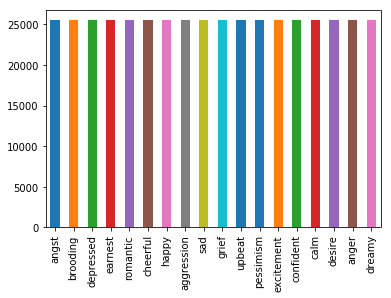

In [67]:
get_and_plot_x_y_data(quadrants=False, pad_lyric_data=True)

### CNN without lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v0_equalized-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-05 04:29:38,513 - INFO: Engaging Low Memory Mode
2018-12-05 04:29:38,515 - INFO: Step 1: Load Lyrics
2018-12-05 04:29:38,516 - INFO: building lyrics dataset
2018-12-05 04:29:38,517 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-05 04:29:40,169 - INFO: imported data shape: (779056, 9)
2018-12-05 04:29:40,170 - INFO: Data shape before filtering: (779056, 9)
2018-12-05 04:29:40,188 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-05 04:29:40,211 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-05 04:29:40,227 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-05 04:29:40,234 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-05 04:29:40,275 - INFO: Shape after mood categorization: (63803, 7)
2018-12-05 04:29:41,361 - INFO: Data shape after lyrics addition: (63803, 8)
2018-12-05 04:29:41,363 - INFO: Df head:
3     An


You are about to overwrite old model data. Is this okay? (Y/N): y


2018-12-05 06:47:23,203 - INFO: Great! Moving on.
2018-12-05 06:47:23,207 - INFO: Step 5 Elapsed Time: 113.08 minutes
2018-12-05 06:47:23,208 - INFO: Mood Classification Elapsed Time: 137.74 minutes
2018-12-05 06:47:23,209 - INFO: Step 6: Train the CNN
2018-12-05 06:47:23,210 - INFO: Writing to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-moods



INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/

2018-12-05 06:47:24,064 - INFO: num_batches_per_epoch = 2869
2018-12-05 06:47:24,065 - INFO: ***********************************************
2018-12-05 06:47:24,066 - INFO: Epoch 0/10

2018-12-05 06:47:24,144 - INFO: -----------------------------------------------
2018-12-05 06:47:24,145 - INFO: Epoch 0/10, Batch 0/2869 (start=0, end=128)
2018-12-05 06:47:24,782 - INFO: step 1, loss 14.8439, acc 0.046875
2018-12-05 06:47:24,792 - INFO: -----------------------------------------------
2018-12-05 06:47:24,793 - INFO: Epoch 0/10, Batch 1/2869 (start=128, end=256)
2018-12-05 06:47:25,377 - INFO: step 2, loss 9.24837, acc 0.0390625
2018-12-05 06:47:25,379 - INFO: -----------------------------------------------
2018-12-05 06:47:25,382 - INFO: Epoch 0/10, Batch 2/2869 (start=256, end=384)
2018-12-05 06:47:25,986 - INFO: step 3, loss 8.82597, acc 0.0546875
2018-12-05 06:47:25,988 - INFO: -----------------------------------------------
2018-12-05 06:47:25,988 - INFO: Epoch 0/10, Batch 3/2869 (st

2018-12-05 06:47:44,738 - INFO: Epoch 0/10, Batch 35/2869 (start=4480, end=4608)
2018-12-05 06:47:45,304 - INFO: step 36, loss 5.99005, acc 0.15625
2018-12-05 06:47:45,306 - INFO: -----------------------------------------------
2018-12-05 06:47:45,307 - INFO: Epoch 0/10, Batch 36/2869 (start=4608, end=4736)
2018-12-05 06:47:45,874 - INFO: step 37, loss 6.06452, acc 0.078125
2018-12-05 06:47:45,876 - INFO: -----------------------------------------------
2018-12-05 06:47:45,876 - INFO: Epoch 0/10, Batch 37/2869 (start=4736, end=4864)
2018-12-05 06:47:46,440 - INFO: step 38, loss 5.54057, acc 0.101562
2018-12-05 06:47:46,441 - INFO: -----------------------------------------------
2018-12-05 06:47:46,442 - INFO: Epoch 0/10, Batch 38/2869 (start=4864, end=4992)
2018-12-05 06:47:47,011 - INFO: step 39, loss 6.07409, acc 0.109375
2018-12-05 06:47:47,012 - INFO: -----------------------------------------------
2018-12-05 06:47:47,013 - INFO: Epoch 0/10, Batch 39/2869 (start=4992, end=5120)
2018

2018-12-05 06:48:05,170 - INFO: Epoch 0/10, Batch 71/2869 (start=9088, end=9216)
2018-12-05 06:48:05,738 - INFO: step 72, loss 5.33359, acc 0.15625
2018-12-05 06:48:05,740 - INFO: -----------------------------------------------
2018-12-05 06:48:05,740 - INFO: Epoch 0/10, Batch 72/2869 (start=9216, end=9344)
2018-12-05 06:48:06,302 - INFO: step 73, loss 4.80282, acc 0.203125
2018-12-05 06:48:06,304 - INFO: -----------------------------------------------
2018-12-05 06:48:06,304 - INFO: Epoch 0/10, Batch 73/2869 (start=9344, end=9472)
2018-12-05 06:48:06,868 - INFO: step 74, loss 5.43284, acc 0.125
2018-12-05 06:48:06,869 - INFO: -----------------------------------------------
2018-12-05 06:48:06,870 - INFO: Epoch 0/10, Batch 74/2869 (start=9472, end=9600)
2018-12-05 06:48:07,436 - INFO: step 75, loss 5.96628, acc 0.101562
2018-12-05 06:48:07,438 - INFO: -----------------------------------------------
2018-12-05 06:48:07,438 - INFO: Epoch 0/10, Batch 75/2869 (start=9600, end=9728)
2018-12

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_equalized-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=False,         # DO NOT let CNN train the word2vec embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-05 01:39:00,341 - INFO: Engaging Low Memory Mode
2018-12-05 01:39:00,343 - INFO: Step 1: Load Lyrics
2018-12-05 01:39:00,344 - INFO: building lyrics dataset
2018-12-05 01:39:00,345 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-05 01:39:02,084 - INFO: imported data shape: (779056, 9)
2018-12-05 01:39:02,085 - INFO: Data shape before filtering: (779056, 9)
2018-12-05 01:39:02,105 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-05 01:39:02,130 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-05 01:39:02,145 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-05 01:39:02,152 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-05 01:39:02,199 - INFO: Shape after mood categorization: (63803, 7)
2018-12-05 01:39:03,289 - INFO: Data shape after lyrics addition: (63803, 8)
2018-12-05 01:39:03,291 - INFO: Df head:
3     An

2018-12-05 02:03:08,301 - DEBUG: Time Elapsed: 0.6707250277201334 minutes
2018-12-05 02:03:14,972 - DEBUG: Average loss at step 14000: 5.2782726503014565
2018-12-05 02:03:14,974 - DEBUG: Time Elapsed: 0.781937571366628 minutes
2018-12-05 02:03:21,658 - DEBUG: Average loss at step 16000: 5.265418695449829
2018-12-05 02:03:21,660 - DEBUG: Time Elapsed: 0.8933744311332703 minutes
2018-12-05 02:03:28,280 - DEBUG: Average loss at step 18000: 5.223771548330784
2018-12-05 02:03:28,282 - DEBUG: Time Elapsed: 1.003735868136088 minutes
2018-12-05 02:03:34,898 - DEBUG: Average loss at step 20000: 5.157076440840959
2018-12-05 02:03:34,900 - DEBUG: Time Elapsed: 1.1140363375345865 minutes
2018-12-05 02:03:34,909 - DEBUG: Nearest to know: qua, lolli, alright-alright, na-na-na, n't, 's, telecommunication, love,
2018-12-05 02:03:34,913 - DEBUG: Nearest to way: qua, lolli, alright-alright, vampire, do-do, telecommunication, hurrah, sadder,
2018-12-05 02:03:34,916 - DEBUG: Nearest to us: do-do, alright-

2018-12-05 02:05:01,453 - DEBUG: Time Elapsed: 2.5565977613131206 minutes
2018-12-05 02:05:08,075 - DEBUG: Average loss at step 48000: 5.015202374219895
2018-12-05 02:05:08,077 - DEBUG: Time Elapsed: 2.666986080010732 minutes
2018-12-05 02:05:14,755 - DEBUG: Average loss at step 50000: 4.995415358901024
2018-12-05 02:05:14,756 - DEBUG: Time Elapsed: 2.7783160050710043 minutes
2018-12-05 02:05:14,766 - DEBUG: Nearest to know: qua, pol, lolli, molly, na-na-na, pah, alright-alright, yoy,
2018-12-05 02:05:14,769 - DEBUG: Nearest to way: molly, qua, telecommunication, alright-alright, pah, pol, lela, know,
2018-12-05 02:05:14,772 - DEBUG: Nearest to us: do-do, alright-alright, lela, pah, vampire, qua, lolli, telecommunication,
2018-12-05 02:05:14,775 - DEBUG: Nearest to '': molly, pol, qua, telecommunication, alright-alright, pah, peggy, butter,
2018-12-05 02:05:14,777 - DEBUG: Nearest to see: molly, pah, qua, pol, lolli, alright-alright, yoy, 80s,
2018-12-05 02:05:14,780 - DEBUG: Nearest t

2018-12-05 02:06:54,512 - DEBUG: Nearest to know: qua, alright-alright, pah, lolli, meow, lela, molly, pol,
2018-12-05 02:06:54,515 - DEBUG: Nearest to way: pol, meow, qua, molly, lela, alright-alright, na-na-na, pah,
2018-12-05 02:06:54,518 - DEBUG: Nearest to us: meow, alright-alright, do-do, vampire, qua, punka, pah, lela,
2018-12-05 02:06:54,521 - DEBUG: Nearest to '': said, say, tweedlee, qua, pol, molly, pah, ``,
2018-12-05 02:06:54,524 - DEBUG: Nearest to see: meow, qua, pol, pah, molly, alright-alright, telecommunication, yoy,
2018-12-05 02:06:54,526 - DEBUG: Nearest to take: pah, meow, pol, alright-alright, molly, yoy, diddly, qua,
2018-12-05 02:06:54,529 - DEBUG: Nearest to right: molly, qua, meow, alright-alright, lolli, pol, pah, telecommunication,
2018-12-05 02:06:54,532 - DEBUG: Nearest to yeah: oh, molly, meow, qua, alright-alright, na-na-na, pah, pol,
2018-12-05 02:06:54,534 - DEBUG: Nearest to ...: pol, pah, qua, yeah, molly, meow, lela, chorus,
2018-12-05 02:06:54,537

2018-12-05 02:08:28,614 - INFO: Elapsed Time: 0.43958019018173217 minutes
2018-12-05 02:08:52,584 - DEBUG: pickled <class 'pandas.core.frame.DataFrame'> to logs/tf/mood_classification/vectorized_lyrics.pickle
2018-12-05 02:08:52,587 - INFO: Step 3 Elapsed Time: 0.84 minutes
2018-12-05 02:08:52,588 - INFO: Mood Classification Elapsed Time: 29.87 minutes
2018-12-05 02:08:52,590 - INFO: Step 4: Split Data
2018-12-05 02:08:52,968 - INFO: df_train shape: (367228, 9), pct: 0.7999982572172989
2018-12-05 02:08:52,969 - INFO: df_dev shape: (45904, 9), pct: 0.10000087139135057
2018-12-05 02:08:52,970 - INFO: df_test shape: (45904, 9), pct: 0.10000087139135057
2018-12-05 02:09:01,467 - DEBUG: pickled <class 'list'> to logs/tf/mood_classification/x_y.pickle
2018-12-05 02:09:01,469 - INFO: Step 4 Elapsed Time: 0.15 minutes
2018-12-05 02:09:01,470 - INFO: Mood Classification Elapsed Time: 30.02 minutes
2018-12-05 02:09:01,472 - INFO: Step 5: Prepare to Train the CNN
2018-12-05 02:09:01,482 - INFO: c

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



2018-12-05 02:09:01,673 - INFO: Checking for prexisting data...
2018-12-05 02:09:01,674 - INFO: Step 5 Elapsed Time: 0.00 minutes
2018-12-05 02:09:01,675 - INFO: Mood Classification Elapsed Time: 30.02 minutes
2018-12-05 02:09:01,676 - INFO: Step 6: Train the CNN
2018-12-05 02:09:01,677 - INFO: Writing to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-moods



INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-maxpool-4/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/sparsity is illegal; using conv-maxpool-4/b_0/grad/sparsity instead.
INFO:tensorflow:Summary 

2018-12-05 02:09:02,642 - INFO: num_batches_per_epoch = 2869
2018-12-05 02:09:02,643 - INFO: ***********************************************
2018-12-05 02:09:02,644 - INFO: Epoch 0/10

2018-12-05 02:09:02,716 - INFO: -----------------------------------------------
2018-12-05 02:09:02,717 - INFO: Epoch 0/10, Batch 0/2869 (start=0, end=128)
2018-12-05 02:09:03,163 - INFO: step 1, loss 3.27708, acc 0.0390625
2018-12-05 02:09:03,169 - INFO: -----------------------------------------------
2018-12-05 02:09:03,170 - INFO: Epoch 0/10, Batch 1/2869 (start=128, end=256)
2018-12-05 02:09:03,567 - INFO: step 2, loss 3.18827, acc 0.0234375
2018-12-05 02:09:03,568 - INFO: -----------------------------------------------
2018-12-05 02:09:03,569 - INFO: Epoch 0/10, Batch 2/2869 (start=256, end=384)
2018-12-05 02:09:03,958 - INFO: step 3, loss 3.2278, acc 0.0625
2018-12-05 02:09:03,959 - INFO: -----------------------------------------------
2018-12-05 02:09:03,959 - INFO: Epoch 0/10, Batch 3/2869 (start

2018-12-05 02:09:16,354 - INFO: Epoch 0/10, Batch 35/2869 (start=4480, end=4608)
2018-12-05 02:09:16,740 - INFO: step 36, loss 2.99133, acc 0.140625
2018-12-05 02:09:16,741 - INFO: -----------------------------------------------
2018-12-05 02:09:16,742 - INFO: Epoch 0/10, Batch 36/2869 (start=4608, end=4736)
2018-12-05 02:09:17,130 - INFO: step 37, loss 3.06375, acc 0.109375
2018-12-05 02:09:17,131 - INFO: -----------------------------------------------
2018-12-05 02:09:17,131 - INFO: Epoch 0/10, Batch 37/2869 (start=4736, end=4864)
2018-12-05 02:09:17,508 - INFO: step 38, loss 3.06473, acc 0.0859375
2018-12-05 02:09:17,509 - INFO: -----------------------------------------------
2018-12-05 02:09:17,510 - INFO: Epoch 0/10, Batch 38/2869 (start=4864, end=4992)
2018-12-05 02:09:17,898 - INFO: step 39, loss 2.9597, acc 0.132812
2018-12-05 02:09:17,899 - INFO: -----------------------------------------------
2018-12-05 02:09:17,900 - INFO: Epoch 0/10, Batch 39/2869 (start=4992, end=5120)
201

2018-12-05 02:09:30,359 - INFO: Epoch 0/10, Batch 71/2869 (start=9088, end=9216)
2018-12-05 02:09:30,748 - INFO: step 72, loss 2.92815, acc 0.179688
2018-12-05 02:09:30,750 - INFO: -----------------------------------------------
2018-12-05 02:09:30,750 - INFO: Epoch 0/10, Batch 72/2869 (start=9216, end=9344)
2018-12-05 02:09:31,139 - INFO: step 73, loss 2.97761, acc 0.132812
2018-12-05 02:09:31,140 - INFO: -----------------------------------------------
2018-12-05 02:09:31,140 - INFO: Epoch 0/10, Batch 73/2869 (start=9344, end=9472)
2018-12-05 02:09:31,529 - INFO: step 74, loss 2.91608, acc 0.125
2018-12-05 02:09:31,530 - INFO: -----------------------------------------------
2018-12-05 02:09:31,531 - INFO: Epoch 0/10, Batch 74/2869 (start=9472, end=9600)
2018-12-05 02:09:31,911 - INFO: step 75, loss 2.90432, acc 0.171875
2018-12-05 02:09:31,912 - INFO: -----------------------------------------------
2018-12-05 02:09:31,913 - INFO: Epoch 0/10, Batch 75/2869 (start=9600, end=9728)
2018-1

## Equalized Mood Quadrants

### Baselines

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 25.13%
Most-Common-Case Classifier Dev Accuracy: 25.34%
Most-Common-Case Classifier Test Accuracy: 25.34%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 55.32%
Naive Bayes Classifier Test Accuracy: 55.19%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 54.28%
SVM Classifier Test Accuracy: 54.07%


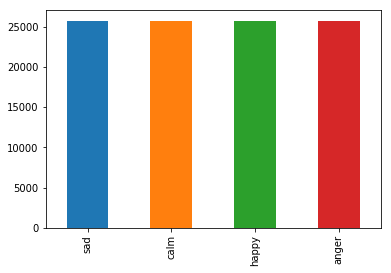

In [68]:
get_and_plot_x_y_data(quadrants=True, pad_lyric_data=True)

### CNN without lyrics2vec

In [6]:
mood_classification(
    # Controls
    name='w2v0_equalized-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-05 06:52:16,627 - INFO: Engaging Low Memory Mode
2018-12-05 06:52:16,629 - INFO: Step 1: Load Lyrics
2018-12-05 06:52:16,630 - INFO: building lyrics dataset
2018-12-05 06:52:16,632 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-05 06:52:18,371 - INFO: imported data shape: (779056, 9)
2018-12-05 06:52:18,372 - INFO: Data shape before filtering: (779056, 9)
2018-12-05 06:52:18,393 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-05 06:52:18,419 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-05 06:52:18,434 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-05 06:52:18,443 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-05 06:52:19,243 - INFO: Shape after mood categorization: (59911, 7)
2018-12-05 06:52:20,276 - INFO: Data shape after lyrics addition: (59911, 8)
2018-12-05 06:52:20,278 - INFO: Df head:
3     An

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



2018-12-05 06:57:29,069 - INFO: Checking for prexisting data...
2018-12-05 06:57:29,070 - INFO: Step 5 Elapsed Time: 0.00 minutes
2018-12-05 06:57:29,071 - INFO: Mood Classification Elapsed Time: 5.21 minutes
2018-12-05 06:57:29,071 - INFO: Step 6: Train the CNN
2018-12-05 06:57:29,072 - INFO: Writing to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants



INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/

2018-12-05 06:57:29,714 - INFO: num_batches_per_epoch = 644
2018-12-05 06:57:29,716 - INFO: ***********************************************
2018-12-05 06:57:29,716 - INFO: Epoch 0/10

2018-12-05 06:57:29,727 - INFO: -----------------------------------------------
2018-12-05 06:57:29,728 - INFO: Epoch 0/10, Batch 0/644 (start=0, end=128)
2018-12-05 06:57:30,399 - INFO: step 1, loss 6.45789, acc 0.242188
2018-12-05 06:57:30,406 - INFO: -----------------------------------------------
2018-12-05 06:57:30,407 - INFO: Epoch 0/10, Batch 1/644 (start=128, end=256)
2018-12-05 06:57:30,997 - INFO: step 2, loss 5.07781, acc 0.195312
2018-12-05 06:57:30,998 - INFO: -----------------------------------------------
2018-12-05 06:57:30,999 - INFO: Epoch 0/10, Batch 2/644 (start=256, end=384)
2018-12-05 06:57:31,587 - INFO: step 3, loss 3.74289, acc 0.289062
2018-12-05 06:57:31,588 - INFO: -----------------------------------------------
2018-12-05 06:57:31,589 - INFO: Epoch 0/10, Batch 3/644 (start=384

2018-12-05 06:57:51,221 - INFO: step 36, loss 3.29095, acc 0.296875
2018-12-05 06:57:51,223 - INFO: -----------------------------------------------
2018-12-05 06:57:51,223 - INFO: Epoch 0/10, Batch 36/644 (start=4608, end=4736)
2018-12-05 06:57:51,813 - INFO: step 37, loss 3.0643, acc 0.335938
2018-12-05 06:57:51,815 - INFO: -----------------------------------------------
2018-12-05 06:57:51,816 - INFO: Epoch 0/10, Batch 37/644 (start=4736, end=4864)
2018-12-05 06:57:52,407 - INFO: step 38, loss 3.40151, acc 0.273438
2018-12-05 06:57:52,408 - INFO: -----------------------------------------------
2018-12-05 06:57:52,409 - INFO: Epoch 0/10, Batch 38/644 (start=4864, end=4992)
2018-12-05 06:57:53,001 - INFO: step 39, loss 3.73767, acc 0.289062
2018-12-05 06:57:53,002 - INFO: -----------------------------------------------
2018-12-05 06:57:53,003 - INFO: Epoch 0/10, Batch 39/644 (start=4992, end=5120)
2018-12-05 06:57:53,597 - INFO: step 40, loss 3.45209, acc 0.265625
2018-12-05 06:57:53,5

2018-12-05 06:58:12,613 - INFO: step 72, loss 3.05102, acc 0.289062
2018-12-05 06:58:12,614 - INFO: -----------------------------------------------
2018-12-05 06:58:12,615 - INFO: Epoch 0/10, Batch 72/644 (start=9216, end=9344)
2018-12-05 06:58:13,208 - INFO: step 73, loss 2.89332, acc 0.335938
2018-12-05 06:58:13,210 - INFO: -----------------------------------------------
2018-12-05 06:58:13,210 - INFO: Epoch 0/10, Batch 73/644 (start=9344, end=9472)
2018-12-05 06:58:13,797 - INFO: step 74, loss 3.15071, acc 0.28125
2018-12-05 06:58:13,799 - INFO: -----------------------------------------------
2018-12-05 06:58:13,800 - INFO: Epoch 0/10, Batch 74/644 (start=9472, end=9600)
2018-12-05 06:58:14,392 - INFO: step 75, loss 3.32843, acc 0.289062
2018-12-05 06:58:14,394 - INFO: -----------------------------------------------
2018-12-05 06:58:14,395 - INFO: Epoch 0/10, Batch 75/644 (start=9600, end=9728)
2018-12-05 06:58:14,985 - INFO: step 76, loss 3.20221, acc 0.351562
2018-12-05 06:58:14,9

2018-12-05 06:58:46,011 - INFO: step 105, loss 3.40592, acc 0.273438
2018-12-05 06:58:46,013 - INFO: -----------------------------------------------
2018-12-05 06:58:46,014 - INFO: Epoch 0/10, Batch 105/644 (start=13440, end=13568)
2018-12-05 06:58:46,607 - INFO: step 106, loss 2.57632, acc 0.359375
2018-12-05 06:58:46,609 - INFO: -----------------------------------------------
2018-12-05 06:58:46,610 - INFO: Epoch 0/10, Batch 106/644 (start=13568, end=13696)
2018-12-05 06:58:47,194 - INFO: step 107, loss 2.6318, acc 0.375
2018-12-05 06:58:47,195 - INFO: -----------------------------------------------
2018-12-05 06:58:47,196 - INFO: Epoch 0/10, Batch 107/644 (start=13696, end=13824)
2018-12-05 06:58:47,787 - INFO: step 108, loss 2.81857, acc 0.351562
2018-12-05 06:58:47,789 - INFO: -----------------------------------------------
2018-12-05 06:58:47,789 - INFO: Epoch 0/10, Batch 108/644 (start=13824, end=13952)
2018-12-05 06:58:48,386 - INFO: step 109, loss 2.72844, acc 0.375
2018-12-05

2018-12-05 06:59:06,826 - INFO: Epoch 0/10, Batch 140/644 (start=17920, end=18048)
2018-12-05 06:59:07,419 - INFO: step 141, loss 2.64263, acc 0.296875
2018-12-05 06:59:07,420 - INFO: -----------------------------------------------
2018-12-05 06:59:07,421 - INFO: Epoch 0/10, Batch 141/644 (start=18048, end=18176)
2018-12-05 06:59:08,012 - INFO: step 142, loss 2.87367, acc 0.367188
2018-12-05 06:59:08,014 - INFO: -----------------------------------------------
2018-12-05 06:59:08,014 - INFO: Epoch 0/10, Batch 142/644 (start=18176, end=18304)
2018-12-05 06:59:08,606 - INFO: step 143, loss 2.91241, acc 0.304688
2018-12-05 06:59:08,608 - INFO: -----------------------------------------------
2018-12-05 06:59:08,609 - INFO: Epoch 0/10, Batch 143/644 (start=18304, end=18432)
2018-12-05 06:59:09,198 - INFO: step 144, loss 2.65787, acc 0.359375
2018-12-05 06:59:09,200 - INFO: -----------------------------------------------
2018-12-05 06:59:09,201 - INFO: Epoch 0/10, Batch 144/644 (start=18432, 

2018-12-05 06:59:28,197 - INFO: -----------------------------------------------
2018-12-05 06:59:28,197 - INFO: Epoch 0/10, Batch 176/644 (start=22528, end=22656)
2018-12-05 06:59:28,790 - INFO: step 177, loss 2.24757, acc 0.414062
2018-12-05 06:59:28,792 - INFO: -----------------------------------------------
2018-12-05 06:59:28,792 - INFO: Epoch 0/10, Batch 177/644 (start=22656, end=22784)
2018-12-05 06:59:29,384 - INFO: step 178, loss 2.29212, acc 0.375
2018-12-05 06:59:29,386 - INFO: -----------------------------------------------
2018-12-05 06:59:29,386 - INFO: Epoch 0/10, Batch 178/644 (start=22784, end=22912)
2018-12-05 06:59:29,972 - INFO: step 179, loss 2.34288, acc 0.367188
2018-12-05 06:59:29,974 - INFO: -----------------------------------------------
2018-12-05 06:59:29,975 - INFO: Epoch 0/10, Batch 179/644 (start=22912, end=23040)
2018-12-05 06:59:30,565 - INFO: step 180, loss 3.09973, acc 0.296875
2018-12-05 06:59:30,566 - INFO: -------------------------------------------

2018-12-05 07:00:01,563 - INFO: step 209, loss 2.59886, acc 0.390625
2018-12-05 07:00:01,565 - INFO: -----------------------------------------------
2018-12-05 07:00:01,566 - INFO: Epoch 0/10, Batch 209/644 (start=26752, end=26880)
2018-12-05 07:00:02,160 - INFO: step 210, loss 2.63701, acc 0.289062
2018-12-05 07:00:02,162 - INFO: -----------------------------------------------
2018-12-05 07:00:02,163 - INFO: Epoch 0/10, Batch 210/644 (start=26880, end=27008)
2018-12-05 07:00:02,756 - INFO: step 211, loss 2.26313, acc 0.4375
2018-12-05 07:00:02,757 - INFO: -----------------------------------------------
2018-12-05 07:00:02,758 - INFO: Epoch 0/10, Batch 211/644 (start=27008, end=27136)
2018-12-05 07:00:03,348 - INFO: step 212, loss 2.48279, acc 0.390625
2018-12-05 07:00:03,349 - INFO: -----------------------------------------------
2018-12-05 07:00:03,350 - INFO: Epoch 0/10, Batch 212/644 (start=27136, end=27264)
2018-12-05 07:00:03,935 - INFO: step 213, loss 2.33271, acc 0.4375
2018-12

2018-12-05 07:00:22,417 - INFO: Epoch 0/10, Batch 244/644 (start=31232, end=31360)
2018-12-05 07:00:23,004 - INFO: step 245, loss 2.29265, acc 0.367188
2018-12-05 07:00:23,006 - INFO: -----------------------------------------------
2018-12-05 07:00:23,007 - INFO: Epoch 0/10, Batch 245/644 (start=31360, end=31488)
2018-12-05 07:00:23,601 - INFO: step 246, loss 2.50807, acc 0.296875
2018-12-05 07:00:23,603 - INFO: -----------------------------------------------
2018-12-05 07:00:23,604 - INFO: Epoch 0/10, Batch 246/644 (start=31488, end=31616)
2018-12-05 07:00:24,195 - INFO: step 247, loss 2.07323, acc 0.429688
2018-12-05 07:00:24,197 - INFO: -----------------------------------------------
2018-12-05 07:00:24,198 - INFO: Epoch 0/10, Batch 247/644 (start=31616, end=31744)
2018-12-05 07:00:24,866 - INFO: step 248, loss 2.24203, acc 0.4375
2018-12-05 07:00:24,868 - INFO: -----------------------------------------------
2018-12-05 07:00:24,869 - INFO: Epoch 0/10, Batch 248/644 (start=31744, en

2018-12-05 07:00:44,976 - INFO: -----------------------------------------------
2018-12-05 07:00:44,977 - INFO: Epoch 0/10, Batch 280/644 (start=35840, end=35968)
2018-12-05 07:00:45,556 - INFO: step 281, loss 2.14664, acc 0.390625
2018-12-05 07:00:45,557 - INFO: -----------------------------------------------
2018-12-05 07:00:45,558 - INFO: Epoch 0/10, Batch 281/644 (start=35968, end=36096)
2018-12-05 07:00:46,161 - INFO: step 282, loss 2.60358, acc 0.367188
2018-12-05 07:00:46,163 - INFO: -----------------------------------------------
2018-12-05 07:00:46,163 - INFO: Epoch 0/10, Batch 282/644 (start=36096, end=36224)
2018-12-05 07:00:46,747 - INFO: step 283, loss 2.21214, acc 0.34375
2018-12-05 07:00:46,749 - INFO: -----------------------------------------------
2018-12-05 07:00:46,750 - INFO: Epoch 0/10, Batch 283/644 (start=36224, end=36352)
2018-12-05 07:00:47,347 - INFO: step 284, loss 2.41394, acc 0.359375
2018-12-05 07:00:47,349 - INFO: -----------------------------------------

2018-12-05 07:01:18,501 - INFO: step 313, loss 1.95783, acc 0.34375
2018-12-05 07:01:18,503 - INFO: -----------------------------------------------
2018-12-05 07:01:18,504 - INFO: Epoch 0/10, Batch 313/644 (start=40064, end=40192)
2018-12-05 07:01:19,101 - INFO: step 314, loss 1.91679, acc 0.460938
2018-12-05 07:01:19,103 - INFO: -----------------------------------------------
2018-12-05 07:01:19,104 - INFO: Epoch 0/10, Batch 314/644 (start=40192, end=40320)
2018-12-05 07:01:19,695 - INFO: step 315, loss 2.072, acc 0.375
2018-12-05 07:01:19,697 - INFO: -----------------------------------------------
2018-12-05 07:01:19,698 - INFO: Epoch 0/10, Batch 315/644 (start=40320, end=40448)
2018-12-05 07:01:20,290 - INFO: step 316, loss 2.07425, acc 0.375
2018-12-05 07:01:20,291 - INFO: -----------------------------------------------
2018-12-05 07:01:20,292 - INFO: Epoch 0/10, Batch 316/644 (start=40448, end=40576)
2018-12-05 07:01:20,885 - INFO: step 317, loss 2.00616, acc 0.398438
2018-12-05 0

2018-12-05 07:01:39,246 - INFO: Epoch 0/10, Batch 348/644 (start=44544, end=44672)
2018-12-05 07:01:39,832 - INFO: step 349, loss 1.81358, acc 0.398438
2018-12-05 07:01:39,833 - INFO: -----------------------------------------------
2018-12-05 07:01:39,834 - INFO: Epoch 0/10, Batch 349/644 (start=44672, end=44800)
2018-12-05 07:01:40,421 - INFO: step 350, loss 2.09123, acc 0.375
2018-12-05 07:01:40,423 - INFO: -----------------------------------------------
2018-12-05 07:01:40,424 - INFO: Epoch 0/10, Batch 350/644 (start=44800, end=44928)
2018-12-05 07:01:41,007 - INFO: step 351, loss 1.72902, acc 0.492188
2018-12-05 07:01:41,008 - INFO: -----------------------------------------------
2018-12-05 07:01:41,009 - INFO: Epoch 0/10, Batch 351/644 (start=44928, end=45056)
2018-12-05 07:01:41,603 - INFO: step 352, loss 1.79891, acc 0.492188
2018-12-05 07:01:41,604 - INFO: -----------------------------------------------
2018-12-05 07:01:41,605 - INFO: Epoch 0/10, Batch 352/644 (start=45056, end

2018-12-05 07:02:00,527 - INFO: -----------------------------------------------
2018-12-05 07:02:00,528 - INFO: Epoch 0/10, Batch 384/644 (start=49152, end=49280)
2018-12-05 07:02:01,125 - INFO: step 385, loss 1.95042, acc 0.421875
2018-12-05 07:02:01,127 - INFO: -----------------------------------------------
2018-12-05 07:02:01,127 - INFO: Epoch 0/10, Batch 385/644 (start=49280, end=49408)
2018-12-05 07:02:01,717 - INFO: step 386, loss 1.95956, acc 0.429688
2018-12-05 07:02:01,719 - INFO: -----------------------------------------------
2018-12-05 07:02:01,719 - INFO: Epoch 0/10, Batch 386/644 (start=49408, end=49536)
2018-12-05 07:02:02,308 - INFO: step 387, loss 1.99214, acc 0.4375
2018-12-05 07:02:02,310 - INFO: -----------------------------------------------
2018-12-05 07:02:02,310 - INFO: Epoch 0/10, Batch 387/644 (start=49536, end=49664)
2018-12-05 07:02:02,901 - INFO: step 388, loss 2.0042, acc 0.414062
2018-12-05 07:02:02,903 - INFO: -------------------------------------------

2018-12-05 07:02:34,062 - INFO: step 417, loss 1.98146, acc 0.351562
2018-12-05 07:02:34,064 - INFO: -----------------------------------------------
2018-12-05 07:02:34,065 - INFO: Epoch 0/10, Batch 417/644 (start=53376, end=53504)
2018-12-05 07:02:34,660 - INFO: step 418, loss 1.71529, acc 0.421875
2018-12-05 07:02:34,661 - INFO: -----------------------------------------------
2018-12-05 07:02:34,662 - INFO: Epoch 0/10, Batch 418/644 (start=53504, end=53632)
2018-12-05 07:02:35,256 - INFO: step 419, loss 1.81661, acc 0.414062
2018-12-05 07:02:35,257 - INFO: -----------------------------------------------
2018-12-05 07:02:35,258 - INFO: Epoch 0/10, Batch 419/644 (start=53632, end=53760)
2018-12-05 07:02:35,849 - INFO: step 420, loss 1.78902, acc 0.398438
2018-12-05 07:02:35,851 - INFO: -----------------------------------------------
2018-12-05 07:02:35,851 - INFO: Epoch 0/10, Batch 420/644 (start=53760, end=53888)
2018-12-05 07:02:36,448 - INFO: step 421, loss 1.76252, acc 0.445312
201

2018-12-05 07:02:54,779 - INFO: Epoch 0/10, Batch 452/644 (start=57856, end=57984)
2018-12-05 07:02:55,357 - INFO: step 453, loss 1.7486, acc 0.4375
2018-12-05 07:02:55,359 - INFO: -----------------------------------------------
2018-12-05 07:02:55,359 - INFO: Epoch 0/10, Batch 453/644 (start=57984, end=58112)
2018-12-05 07:02:55,951 - INFO: step 454, loss 1.6737, acc 0.40625
2018-12-05 07:02:55,952 - INFO: -----------------------------------------------
2018-12-05 07:02:55,953 - INFO: Epoch 0/10, Batch 454/644 (start=58112, end=58240)
2018-12-05 07:02:56,529 - INFO: step 455, loss 1.68474, acc 0.382812
2018-12-05 07:02:56,531 - INFO: -----------------------------------------------
2018-12-05 07:02:56,531 - INFO: Epoch 0/10, Batch 455/644 (start=58240, end=58368)
2018-12-05 07:02:57,122 - INFO: step 456, loss 1.82618, acc 0.40625
2018-12-05 07:02:57,124 - INFO: -----------------------------------------------
2018-12-05 07:02:57,125 - INFO: Epoch 0/10, Batch 456/644 (start=58368, end=58

2018-12-05 07:03:16,101 - INFO: -----------------------------------------------
2018-12-05 07:03:16,102 - INFO: Epoch 0/10, Batch 488/644 (start=62464, end=62592)
2018-12-05 07:03:16,695 - INFO: step 489, loss 1.70685, acc 0.429688
2018-12-05 07:03:16,696 - INFO: -----------------------------------------------
2018-12-05 07:03:16,697 - INFO: Epoch 0/10, Batch 489/644 (start=62592, end=62720)
2018-12-05 07:03:17,287 - INFO: step 490, loss 2.01129, acc 0.40625
2018-12-05 07:03:17,289 - INFO: -----------------------------------------------
2018-12-05 07:03:17,290 - INFO: Epoch 0/10, Batch 490/644 (start=62720, end=62848)
2018-12-05 07:03:17,877 - INFO: step 491, loss 1.72236, acc 0.460938
2018-12-05 07:03:17,879 - INFO: -----------------------------------------------
2018-12-05 07:03:17,880 - INFO: Epoch 0/10, Batch 491/644 (start=62848, end=62976)
2018-12-05 07:03:18,476 - INFO: step 492, loss 1.96589, acc 0.375
2018-12-05 07:03:18,477 - INFO: --------------------------------------------

2018-12-05 07:03:49,729 - INFO: step 521, loss 1.72582, acc 0.4375
2018-12-05 07:03:49,731 - INFO: -----------------------------------------------
2018-12-05 07:03:49,732 - INFO: Epoch 0/10, Batch 521/644 (start=66688, end=66816)
2018-12-05 07:03:50,323 - INFO: step 522, loss 1.58433, acc 0.445312
2018-12-05 07:03:50,324 - INFO: -----------------------------------------------
2018-12-05 07:03:50,325 - INFO: Epoch 0/10, Batch 522/644 (start=66816, end=66944)
2018-12-05 07:03:50,910 - INFO: step 523, loss 1.69791, acc 0.375
2018-12-05 07:03:50,912 - INFO: -----------------------------------------------
2018-12-05 07:03:50,913 - INFO: Epoch 0/10, Batch 523/644 (start=66944, end=67072)
2018-12-05 07:03:51,499 - INFO: step 524, loss 1.60378, acc 0.476562
2018-12-05 07:03:51,500 - INFO: -----------------------------------------------
2018-12-05 07:03:51,501 - INFO: Epoch 0/10, Batch 524/644 (start=67072, end=67200)
2018-12-05 07:03:52,085 - INFO: step 525, loss 1.73988, acc 0.414062
2018-12-

2018-12-05 07:04:10,443 - INFO: Epoch 0/10, Batch 556/644 (start=71168, end=71296)
2018-12-05 07:04:11,025 - INFO: step 557, loss 1.72141, acc 0.453125
2018-12-05 07:04:11,027 - INFO: -----------------------------------------------
2018-12-05 07:04:11,028 - INFO: Epoch 0/10, Batch 557/644 (start=71296, end=71424)
2018-12-05 07:04:11,626 - INFO: step 558, loss 1.77694, acc 0.382812
2018-12-05 07:04:11,627 - INFO: -----------------------------------------------
2018-12-05 07:04:11,628 - INFO: Epoch 0/10, Batch 558/644 (start=71424, end=71552)
2018-12-05 07:04:12,216 - INFO: step 559, loss 1.58691, acc 0.460938
2018-12-05 07:04:12,217 - INFO: -----------------------------------------------
2018-12-05 07:04:12,218 - INFO: Epoch 0/10, Batch 559/644 (start=71552, end=71680)
2018-12-05 07:04:12,813 - INFO: step 560, loss 1.51364, acc 0.476562
2018-12-05 07:04:12,815 - INFO: -----------------------------------------------
2018-12-05 07:04:12,816 - INFO: Epoch 0/10, Batch 560/644 (start=71680, 

2018-12-05 07:04:31,825 - INFO: -----------------------------------------------
2018-12-05 07:04:31,826 - INFO: Epoch 0/10, Batch 592/644 (start=75776, end=75904)
2018-12-05 07:04:32,423 - INFO: step 593, loss 1.65234, acc 0.382812
2018-12-05 07:04:32,425 - INFO: -----------------------------------------------
2018-12-05 07:04:32,426 - INFO: Epoch 0/10, Batch 593/644 (start=75904, end=76032)
2018-12-05 07:04:33,015 - INFO: step 594, loss 1.43329, acc 0.492188
2018-12-05 07:04:33,016 - INFO: -----------------------------------------------
2018-12-05 07:04:33,017 - INFO: Epoch 0/10, Batch 594/644 (start=76032, end=76160)
2018-12-05 07:04:33,612 - INFO: step 595, loss 1.84876, acc 0.375
2018-12-05 07:04:33,614 - INFO: -----------------------------------------------
2018-12-05 07:04:33,614 - INFO: Epoch 0/10, Batch 595/644 (start=76160, end=76288)
2018-12-05 07:04:34,204 - INFO: step 596, loss 1.7338, acc 0.367188
2018-12-05 07:04:34,205 - INFO: --------------------------------------------

2018-12-05 07:05:05,392 - INFO: step 625, loss 1.39428, acc 0.421875
2018-12-05 07:05:05,394 - INFO: -----------------------------------------------
2018-12-05 07:05:05,394 - INFO: Epoch 0/10, Batch 625/644 (start=80000, end=80128)
2018-12-05 07:05:05,979 - INFO: step 626, loss 1.50629, acc 0.507812
2018-12-05 07:05:05,980 - INFO: -----------------------------------------------
2018-12-05 07:05:05,981 - INFO: Epoch 0/10, Batch 626/644 (start=80128, end=80256)
2018-12-05 07:05:06,570 - INFO: step 627, loss 1.39902, acc 0.476562
2018-12-05 07:05:06,571 - INFO: -----------------------------------------------
2018-12-05 07:05:06,572 - INFO: Epoch 0/10, Batch 627/644 (start=80256, end=80384)
2018-12-05 07:05:07,168 - INFO: step 628, loss 1.53573, acc 0.460938
2018-12-05 07:05:07,170 - INFO: -----------------------------------------------
2018-12-05 07:05:07,171 - INFO: Epoch 0/10, Batch 628/644 (start=80384, end=80512)
2018-12-05 07:05:07,758 - INFO: step 629, loss 1.77272, acc 0.390625
201

2018-12-05 07:05:25,595 - INFO: -----------------------------------------------
2018-12-05 07:05:25,596 - INFO: Epoch 1/10, Batch 16/644 (start=2048, end=2176)
2018-12-05 07:05:26,189 - INFO: step 661, loss 1.18691, acc 0.59375
2018-12-05 07:05:26,190 - INFO: -----------------------------------------------
2018-12-05 07:05:26,191 - INFO: Epoch 1/10, Batch 17/644 (start=2176, end=2304)
2018-12-05 07:05:26,785 - INFO: step 662, loss 1.13024, acc 0.609375
2018-12-05 07:05:26,787 - INFO: -----------------------------------------------
2018-12-05 07:05:26,787 - INFO: Epoch 1/10, Batch 18/644 (start=2304, end=2432)
2018-12-05 07:05:27,380 - INFO: step 663, loss 1.1742, acc 0.53125
2018-12-05 07:05:27,381 - INFO: -----------------------------------------------
2018-12-05 07:05:27,382 - INFO: Epoch 1/10, Batch 19/644 (start=2432, end=2560)
2018-12-05 07:05:27,975 - INFO: step 664, loss 1.21806, acc 0.546875
2018-12-05 07:05:27,976 - INFO: -----------------------------------------------
2018-12

2018-12-05 07:05:46,906 - INFO: -----------------------------------------------
2018-12-05 07:05:46,907 - INFO: Epoch 1/10, Batch 52/644 (start=6656, end=6784)
2018-12-05 07:05:47,500 - INFO: step 697, loss 1.09472, acc 0.578125
2018-12-05 07:05:47,502 - INFO: -----------------------------------------------
2018-12-05 07:05:47,503 - INFO: Epoch 1/10, Batch 53/644 (start=6784, end=6912)
2018-12-05 07:05:48,085 - INFO: step 698, loss 1.18401, acc 0.539062
2018-12-05 07:05:48,087 - INFO: -----------------------------------------------
2018-12-05 07:05:48,087 - INFO: Epoch 1/10, Batch 54/644 (start=6912, end=7040)
2018-12-05 07:05:48,677 - INFO: step 699, loss 0.924265, acc 0.679688
2018-12-05 07:05:48,679 - INFO: -----------------------------------------------
2018-12-05 07:05:48,680 - INFO: Epoch 1/10, Batch 55/644 (start=7040, end=7168)
2018-12-05 07:05:49,260 - INFO: step 700, loss 1.18166, acc 0.59375
2018-12-05 07:05:49,262 - INFO: 
Evaluation:
2018-12-05 07:05:49,262 - INFO: Validat

2018-12-05 07:06:20,321 - INFO: -----------------------------------------------
2018-12-05 07:06:20,322 - INFO: Epoch 1/10, Batch 85/644 (start=10880, end=11008)
2018-12-05 07:06:20,911 - INFO: step 730, loss 0.962165, acc 0.609375
2018-12-05 07:06:20,913 - INFO: -----------------------------------------------
2018-12-05 07:06:20,914 - INFO: Epoch 1/10, Batch 86/644 (start=11008, end=11136)
2018-12-05 07:06:21,503 - INFO: step 731, loss 1.31932, acc 0.546875
2018-12-05 07:06:21,505 - INFO: -----------------------------------------------
2018-12-05 07:06:21,505 - INFO: Epoch 1/10, Batch 87/644 (start=11136, end=11264)
2018-12-05 07:06:22,092 - INFO: step 732, loss 1.08626, acc 0.578125
2018-12-05 07:06:22,094 - INFO: -----------------------------------------------
2018-12-05 07:06:22,094 - INFO: Epoch 1/10, Batch 88/644 (start=11264, end=11392)
2018-12-05 07:06:22,683 - INFO: step 733, loss 1.16091, acc 0.539062
2018-12-05 07:06:22,685 - INFO: -------------------------------------------

2018-12-05 07:06:41,616 - INFO: step 765, loss 1.05036, acc 0.578125
2018-12-05 07:06:41,618 - INFO: -----------------------------------------------
2018-12-05 07:06:41,619 - INFO: Epoch 1/10, Batch 121/644 (start=15488, end=15616)
2018-12-05 07:06:42,198 - INFO: step 766, loss 1.13338, acc 0.539062
2018-12-05 07:06:42,200 - INFO: -----------------------------------------------
2018-12-05 07:06:42,201 - INFO: Epoch 1/10, Batch 122/644 (start=15616, end=15744)
2018-12-05 07:06:42,789 - INFO: step 767, loss 1.23701, acc 0.546875
2018-12-05 07:06:42,791 - INFO: -----------------------------------------------
2018-12-05 07:06:42,792 - INFO: Epoch 1/10, Batch 123/644 (start=15744, end=15872)
2018-12-05 07:06:43,372 - INFO: step 768, loss 1.14174, acc 0.570312
2018-12-05 07:06:43,373 - INFO: -----------------------------------------------
2018-12-05 07:06:43,374 - INFO: Epoch 1/10, Batch 124/644 (start=15872, end=16000)
2018-12-05 07:06:43,959 - INFO: step 769, loss 1.169, acc 0.570312
2018-

2018-12-05 07:07:02,362 - INFO: Validation Step
2018-12-05 07:07:16,258 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/800_confusion.csv
2018-12-05 07:07:16,259 - INFO: step 800, loss 1.03454, acc 0.560848
2018-12-05 07:07:16,260 - INFO: 
2018-12-05 07:07:16,365 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/checkpoints/model-800

2018-12-05 07:07:16,366 - INFO: -----------------------------------------------
2018-12-05 07:07:16,367 - INFO: Epoch 1/10, Batch 156/644 (start=19968, end=20096)
2018-12-05 07:07:16,964 - INFO: step 801, loss 1.15967, acc 0.554688
2018-12-05 07:07:16,966 - INFO: -----------------------------------------------
2018-12-05 07:07:16,966 - INFO: E

2018-12-05 07:07:35,944 - INFO: step 833, loss 0.96672, acc 0.570312
2018-12-05 07:07:35,946 - INFO: -----------------------------------------------
2018-12-05 07:07:35,946 - INFO: Epoch 1/10, Batch 189/644 (start=24192, end=24320)
2018-12-05 07:07:36,528 - INFO: step 834, loss 1.32322, acc 0.5
2018-12-05 07:07:36,529 - INFO: -----------------------------------------------
2018-12-05 07:07:36,530 - INFO: Epoch 1/10, Batch 190/644 (start=24320, end=24448)
2018-12-05 07:07:37,114 - INFO: step 835, loss 1.02646, acc 0.5625
2018-12-05 07:07:37,116 - INFO: -----------------------------------------------
2018-12-05 07:07:37,116 - INFO: Epoch 1/10, Batch 191/644 (start=24448, end=24576)
2018-12-05 07:07:37,696 - INFO: step 836, loss 1.14803, acc 0.554688
2018-12-05 07:07:37,697 - INFO: -----------------------------------------------
2018-12-05 07:07:37,697 - INFO: Epoch 1/10, Batch 192/644 (start=24576, end=24704)
2018-12-05 07:07:38,293 - INFO: step 837, loss 1.03019, acc 0.601562
2018-12-05

2018-12-05 07:07:56,640 - INFO: Epoch 1/10, Batch 224/644 (start=28672, end=28800)
2018-12-05 07:07:57,235 - INFO: step 869, loss 1.12332, acc 0.507812
2018-12-05 07:07:57,236 - INFO: -----------------------------------------------
2018-12-05 07:07:57,237 - INFO: Epoch 1/10, Batch 225/644 (start=28800, end=28928)
2018-12-05 07:07:57,825 - INFO: step 870, loss 1.13657, acc 0.546875
2018-12-05 07:07:57,826 - INFO: -----------------------------------------------
2018-12-05 07:07:57,827 - INFO: Epoch 1/10, Batch 226/644 (start=28928, end=29056)
2018-12-05 07:07:58,420 - INFO: step 871, loss 1.22452, acc 0.523438
2018-12-05 07:07:58,422 - INFO: -----------------------------------------------
2018-12-05 07:07:58,422 - INFO: Epoch 1/10, Batch 227/644 (start=29056, end=29184)
2018-12-05 07:07:59,014 - INFO: step 872, loss 1.08781, acc 0.59375
2018-12-05 07:07:59,016 - INFO: -----------------------------------------------
2018-12-05 07:07:59,017 - INFO: Epoch 1/10, Batch 228/644 (start=29184, e

2018-12-05 07:08:30,373 - INFO: step 901, loss 1.02686, acc 0.554688
2018-12-05 07:08:30,375 - INFO: -----------------------------------------------
2018-12-05 07:08:30,375 - INFO: Epoch 1/10, Batch 257/644 (start=32896, end=33024)
2018-12-05 07:08:30,967 - INFO: step 902, loss 1.09845, acc 0.546875
2018-12-05 07:08:30,969 - INFO: -----------------------------------------------
2018-12-05 07:08:30,970 - INFO: Epoch 1/10, Batch 258/644 (start=33024, end=33152)
2018-12-05 07:08:31,563 - INFO: step 903, loss 1.49071, acc 0.476562
2018-12-05 07:08:31,565 - INFO: -----------------------------------------------
2018-12-05 07:08:31,566 - INFO: Epoch 1/10, Batch 259/644 (start=33152, end=33280)
2018-12-05 07:08:32,153 - INFO: step 904, loss 1.24211, acc 0.554688
2018-12-05 07:08:32,154 - INFO: -----------------------------------------------
2018-12-05 07:08:32,155 - INFO: Epoch 1/10, Batch 260/644 (start=33280, end=33408)
2018-12-05 07:08:32,741 - INFO: step 905, loss 1.13875, acc 0.539062
201

2018-12-05 07:08:51,080 - INFO: Epoch 1/10, Batch 292/644 (start=37376, end=37504)
2018-12-05 07:08:51,668 - INFO: step 937, loss 0.995085, acc 0.617188
2018-12-05 07:08:51,670 - INFO: -----------------------------------------------
2018-12-05 07:08:51,671 - INFO: Epoch 1/10, Batch 293/644 (start=37504, end=37632)
2018-12-05 07:08:52,257 - INFO: step 938, loss 1.09596, acc 0.570312
2018-12-05 07:08:52,259 - INFO: -----------------------------------------------
2018-12-05 07:08:52,259 - INFO: Epoch 1/10, Batch 294/644 (start=37632, end=37760)
2018-12-05 07:08:52,860 - INFO: step 939, loss 1.04472, acc 0.5625
2018-12-05 07:08:52,862 - INFO: -----------------------------------------------
2018-12-05 07:08:52,862 - INFO: Epoch 1/10, Batch 295/644 (start=37760, end=37888)
2018-12-05 07:08:53,445 - INFO: step 940, loss 1.09761, acc 0.554688
2018-12-05 07:08:53,446 - INFO: -----------------------------------------------
2018-12-05 07:08:53,446 - INFO: Epoch 1/10, Batch 296/644 (start=37888, e

2018-12-05 07:09:12,394 - INFO: -----------------------------------------------
2018-12-05 07:09:12,394 - INFO: Epoch 1/10, Batch 328/644 (start=41984, end=42112)
2018-12-05 07:09:12,981 - INFO: step 973, loss 1.1181, acc 0.578125
2018-12-05 07:09:12,983 - INFO: -----------------------------------------------
2018-12-05 07:09:12,983 - INFO: Epoch 1/10, Batch 329/644 (start=42112, end=42240)
2018-12-05 07:09:13,573 - INFO: step 974, loss 1.18302, acc 0.554688
2018-12-05 07:09:13,575 - INFO: -----------------------------------------------
2018-12-05 07:09:13,576 - INFO: Epoch 1/10, Batch 330/644 (start=42240, end=42368)
2018-12-05 07:09:14,170 - INFO: step 975, loss 0.89831, acc 0.632812
2018-12-05 07:09:14,172 - INFO: -----------------------------------------------
2018-12-05 07:09:14,173 - INFO: Epoch 1/10, Batch 331/644 (start=42368, end=42496)
2018-12-05 07:09:14,767 - INFO: step 976, loss 1.28805, acc 0.460938
2018-12-05 07:09:14,768 - INFO: -----------------------------------------

2018-12-05 07:09:46,006 - INFO: Epoch 1/10, Batch 360/644 (start=46080, end=46208)
2018-12-05 07:09:46,599 - INFO: step 1005, loss 1.24566, acc 0.507812
2018-12-05 07:09:46,601 - INFO: -----------------------------------------------
2018-12-05 07:09:46,602 - INFO: Epoch 1/10, Batch 361/644 (start=46208, end=46336)
2018-12-05 07:09:47,198 - INFO: step 1006, loss 1.13816, acc 0.539062
2018-12-05 07:09:47,200 - INFO: -----------------------------------------------
2018-12-05 07:09:47,200 - INFO: Epoch 1/10, Batch 362/644 (start=46336, end=46464)
2018-12-05 07:09:47,795 - INFO: step 1007, loss 0.880248, acc 0.632812
2018-12-05 07:09:47,797 - INFO: -----------------------------------------------
2018-12-05 07:09:47,797 - INFO: Epoch 1/10, Batch 363/644 (start=46464, end=46592)
2018-12-05 07:09:48,384 - INFO: step 1008, loss 1.05476, acc 0.539062
2018-12-05 07:09:48,386 - INFO: -----------------------------------------------
2018-12-05 07:09:48,386 - INFO: Epoch 1/10, Batch 364/644 (start=46

2018-12-05 07:10:08,662 - INFO: step 1040, loss 0.9969, acc 0.59375
2018-12-05 07:10:08,663 - INFO: -----------------------------------------------
2018-12-05 07:10:08,664 - INFO: Epoch 1/10, Batch 396/644 (start=50688, end=50816)
2018-12-05 07:10:09,283 - INFO: step 1041, loss 0.942232, acc 0.625
2018-12-05 07:10:09,285 - INFO: -----------------------------------------------
2018-12-05 07:10:09,285 - INFO: Epoch 1/10, Batch 397/644 (start=50816, end=50944)
2018-12-05 07:10:09,877 - INFO: step 1042, loss 1.06933, acc 0.601562
2018-12-05 07:10:09,878 - INFO: -----------------------------------------------
2018-12-05 07:10:09,879 - INFO: Epoch 1/10, Batch 398/644 (start=50944, end=51072)
2018-12-05 07:10:10,481 - INFO: step 1043, loss 1.24647, acc 0.539062
2018-12-05 07:10:10,483 - INFO: -----------------------------------------------
2018-12-05 07:10:10,483 - INFO: Epoch 1/10, Batch 399/644 (start=51072, end=51200)
2018-12-05 07:10:11,062 - INFO: step 1044, loss 1.17279, acc 0.53125
201

2018-12-05 07:10:29,392 - INFO: -----------------------------------------------
2018-12-05 07:10:29,393 - INFO: Epoch 1/10, Batch 431/644 (start=55168, end=55296)
2018-12-05 07:10:29,980 - INFO: step 1076, loss 1.29383, acc 0.523438
2018-12-05 07:10:29,982 - INFO: -----------------------------------------------
2018-12-05 07:10:29,983 - INFO: Epoch 1/10, Batch 432/644 (start=55296, end=55424)
2018-12-05 07:10:30,578 - INFO: step 1077, loss 1.13101, acc 0.585938
2018-12-05 07:10:30,579 - INFO: -----------------------------------------------
2018-12-05 07:10:30,580 - INFO: Epoch 1/10, Batch 433/644 (start=55424, end=55552)
2018-12-05 07:10:31,168 - INFO: step 1078, loss 1.30499, acc 0.523438
2018-12-05 07:10:31,169 - INFO: -----------------------------------------------
2018-12-05 07:10:31,170 - INFO: Epoch 1/10, Batch 434/644 (start=55552, end=55680)
2018-12-05 07:10:31,763 - INFO: step 1079, loss 1.25174, acc 0.5
2018-12-05 07:10:31,765 - INFO: -----------------------------------------

2018-12-05 07:11:02,165 - INFO: Epoch 1/10, Batch 463/644 (start=59264, end=59392)
2018-12-05 07:11:02,744 - INFO: step 1108, loss 1.14847, acc 0.523438
2018-12-05 07:11:02,746 - INFO: -----------------------------------------------
2018-12-05 07:11:02,746 - INFO: Epoch 1/10, Batch 464/644 (start=59392, end=59520)
2018-12-05 07:11:03,338 - INFO: step 1109, loss 1.15368, acc 0.539062
2018-12-05 07:11:03,340 - INFO: -----------------------------------------------
2018-12-05 07:11:03,340 - INFO: Epoch 1/10, Batch 465/644 (start=59520, end=59648)
2018-12-05 07:11:03,921 - INFO: step 1110, loss 1.05866, acc 0.546875
2018-12-05 07:11:03,923 - INFO: -----------------------------------------------
2018-12-05 07:11:03,923 - INFO: Epoch 1/10, Batch 466/644 (start=59648, end=59776)
2018-12-05 07:11:04,519 - INFO: step 1111, loss 1.11319, acc 0.53125
2018-12-05 07:11:04,520 - INFO: -----------------------------------------------
2018-12-05 07:11:04,521 - INFO: Epoch 1/10, Batch 467/644 (start=5977

2018-12-05 07:11:23,457 - INFO: step 1143, loss 1.21635, acc 0.515625
2018-12-05 07:11:23,459 - INFO: -----------------------------------------------
2018-12-05 07:11:23,460 - INFO: Epoch 1/10, Batch 499/644 (start=63872, end=64000)
2018-12-05 07:11:24,050 - INFO: step 1144, loss 1.05644, acc 0.546875
2018-12-05 07:11:24,052 - INFO: -----------------------------------------------
2018-12-05 07:11:24,052 - INFO: Epoch 1/10, Batch 500/644 (start=64000, end=64128)
2018-12-05 07:11:24,638 - INFO: step 1145, loss 1.02956, acc 0.546875
2018-12-05 07:11:24,640 - INFO: -----------------------------------------------
2018-12-05 07:11:24,640 - INFO: Epoch 1/10, Batch 501/644 (start=64128, end=64256)
2018-12-05 07:11:25,232 - INFO: step 1146, loss 1.1377, acc 0.5625
2018-12-05 07:11:25,234 - INFO: -----------------------------------------------
2018-12-05 07:11:25,235 - INFO: Epoch 1/10, Batch 502/644 (start=64256, end=64384)
2018-12-05 07:11:25,824 - INFO: step 1147, loss 1.05529, acc 0.570312
2

2018-12-05 07:11:44,179 - INFO: -----------------------------------------------
2018-12-05 07:11:44,180 - INFO: Epoch 1/10, Batch 534/644 (start=68352, end=68480)
2018-12-05 07:11:44,757 - INFO: step 1179, loss 1.12598, acc 0.484375
2018-12-05 07:11:44,759 - INFO: -----------------------------------------------
2018-12-05 07:11:44,760 - INFO: Epoch 1/10, Batch 535/644 (start=68480, end=68608)
2018-12-05 07:11:45,354 - INFO: step 1180, loss 1.02564, acc 0.578125
2018-12-05 07:11:45,355 - INFO: -----------------------------------------------
2018-12-05 07:11:45,356 - INFO: Epoch 1/10, Batch 536/644 (start=68608, end=68736)
2018-12-05 07:11:45,944 - INFO: step 1181, loss 0.95445, acc 0.601562
2018-12-05 07:11:45,945 - INFO: -----------------------------------------------
2018-12-05 07:11:45,946 - INFO: Epoch 1/10, Batch 537/644 (start=68736, end=68864)
2018-12-05 07:11:46,538 - INFO: step 1182, loss 1.21437, acc 0.546875
2018-12-05 07:11:46,540 - INFO: ------------------------------------

2018-12-05 07:12:17,294 - INFO: Epoch 1/10, Batch 566/644 (start=72448, end=72576)
2018-12-05 07:12:17,888 - INFO: step 1211, loss 1.05359, acc 0.585938
2018-12-05 07:12:17,890 - INFO: -----------------------------------------------
2018-12-05 07:12:17,890 - INFO: Epoch 1/10, Batch 567/644 (start=72576, end=72704)
2018-12-05 07:12:18,468 - INFO: step 1212, loss 1.05399, acc 0.585938
2018-12-05 07:12:18,470 - INFO: -----------------------------------------------
2018-12-05 07:12:18,471 - INFO: Epoch 1/10, Batch 568/644 (start=72704, end=72832)
2018-12-05 07:12:19,070 - INFO: step 1213, loss 1.05519, acc 0.578125
2018-12-05 07:12:19,072 - INFO: -----------------------------------------------
2018-12-05 07:12:19,072 - INFO: Epoch 1/10, Batch 569/644 (start=72832, end=72960)
2018-12-05 07:12:19,655 - INFO: step 1214, loss 0.944611, acc 0.601562
2018-12-05 07:12:19,656 - INFO: -----------------------------------------------
2018-12-05 07:12:19,657 - INFO: Epoch 1/10, Batch 570/644 (start=72

2018-12-05 07:12:38,614 - INFO: step 1246, loss 0.939189, acc 0.601562
2018-12-05 07:12:38,616 - INFO: -----------------------------------------------
2018-12-05 07:12:38,616 - INFO: Epoch 1/10, Batch 602/644 (start=77056, end=77184)
2018-12-05 07:12:39,202 - INFO: step 1247, loss 1.06241, acc 0.546875
2018-12-05 07:12:39,204 - INFO: -----------------------------------------------
2018-12-05 07:12:39,204 - INFO: Epoch 1/10, Batch 603/644 (start=77184, end=77312)
2018-12-05 07:12:39,797 - INFO: step 1248, loss 0.986547, acc 0.59375
2018-12-05 07:12:39,798 - INFO: -----------------------------------------------
2018-12-05 07:12:39,799 - INFO: Epoch 1/10, Batch 604/644 (start=77312, end=77440)
2018-12-05 07:12:40,392 - INFO: step 1249, loss 1.02454, acc 0.578125
2018-12-05 07:12:40,394 - INFO: -----------------------------------------------
2018-12-05 07:12:40,394 - INFO: Epoch 1/10, Batch 605/644 (start=77440, end=77568)
2018-12-05 07:12:40,986 - INFO: step 1250, loss 1.03053, acc 0.5937

2018-12-05 07:12:59,344 - INFO: -----------------------------------------------
2018-12-05 07:12:59,344 - INFO: Epoch 1/10, Batch 637/644 (start=81536, end=81664)
2018-12-05 07:12:59,942 - INFO: step 1282, loss 1.10365, acc 0.59375
2018-12-05 07:12:59,944 - INFO: -----------------------------------------------
2018-12-05 07:12:59,945 - INFO: Epoch 1/10, Batch 638/644 (start=81664, end=81792)
2018-12-05 07:13:00,549 - INFO: step 1283, loss 1.11147, acc 0.53125
2018-12-05 07:13:00,551 - INFO: -----------------------------------------------
2018-12-05 07:13:00,552 - INFO: Epoch 1/10, Batch 639/644 (start=81792, end=81920)
2018-12-05 07:13:01,149 - INFO: step 1284, loss 1.12415, acc 0.539062
2018-12-05 07:13:01,151 - INFO: -----------------------------------------------
2018-12-05 07:13:01,151 - INFO: Epoch 1/10, Batch 640/644 (start=81920, end=82048)
2018-12-05 07:13:01,730 - INFO: step 1285, loss 1.25198, acc 0.5
2018-12-05 07:13:01,732 - INFO: -------------------------------------------

2018-12-05 07:13:31,808 - INFO: Epoch 2/10, Batch 25/644 (start=3200, end=3328)
2018-12-05 07:13:32,408 - INFO: step 1314, loss 0.835315, acc 0.6875
2018-12-05 07:13:32,410 - INFO: -----------------------------------------------
2018-12-05 07:13:32,411 - INFO: Epoch 2/10, Batch 26/644 (start=3328, end=3456)
2018-12-05 07:13:32,994 - INFO: step 1315, loss 0.844756, acc 0.679688
2018-12-05 07:13:32,996 - INFO: -----------------------------------------------
2018-12-05 07:13:32,997 - INFO: Epoch 2/10, Batch 27/644 (start=3456, end=3584)
2018-12-05 07:13:33,591 - INFO: step 1316, loss 0.821903, acc 0.6875
2018-12-05 07:13:33,593 - INFO: -----------------------------------------------
2018-12-05 07:13:33,594 - INFO: Epoch 2/10, Batch 28/644 (start=3584, end=3712)
2018-12-05 07:13:34,177 - INFO: step 1317, loss 0.87915, acc 0.625
2018-12-05 07:13:34,179 - INFO: -----------------------------------------------
2018-12-05 07:13:34,179 - INFO: Epoch 2/10, Batch 29/644 (start=3712, end=3840)
2018

2018-12-05 07:13:53,168 - INFO: -----------------------------------------------
2018-12-05 07:13:53,168 - INFO: Epoch 2/10, Batch 61/644 (start=7808, end=7936)
2018-12-05 07:13:53,757 - INFO: step 1350, loss 0.806424, acc 0.710938
2018-12-05 07:13:53,759 - INFO: -----------------------------------------------
2018-12-05 07:13:53,760 - INFO: Epoch 2/10, Batch 62/644 (start=7936, end=8064)
2018-12-05 07:13:54,357 - INFO: step 1351, loss 0.935377, acc 0.617188
2018-12-05 07:13:54,359 - INFO: -----------------------------------------------
2018-12-05 07:13:54,360 - INFO: Epoch 2/10, Batch 63/644 (start=8064, end=8192)
2018-12-05 07:13:54,953 - INFO: step 1352, loss 0.902259, acc 0.648438
2018-12-05 07:13:54,954 - INFO: -----------------------------------------------
2018-12-05 07:13:54,955 - INFO: Epoch 2/10, Batch 64/644 (start=8192, end=8320)
2018-12-05 07:13:55,544 - INFO: step 1353, loss 0.818243, acc 0.632812
2018-12-05 07:13:55,546 - INFO: --------------------------------------------

2018-12-05 07:14:14,555 - INFO: step 1385, loss 0.707105, acc 0.734375
2018-12-05 07:14:14,557 - INFO: -----------------------------------------------
2018-12-05 07:14:14,558 - INFO: Epoch 2/10, Batch 97/644 (start=12416, end=12544)
2018-12-05 07:14:15,136 - INFO: step 1386, loss 0.812036, acc 0.695312
2018-12-05 07:14:15,138 - INFO: -----------------------------------------------
2018-12-05 07:14:15,138 - INFO: Epoch 2/10, Batch 98/644 (start=12544, end=12672)
2018-12-05 07:14:15,744 - INFO: step 1387, loss 0.867202, acc 0.648438
2018-12-05 07:14:15,745 - INFO: -----------------------------------------------
2018-12-05 07:14:15,746 - INFO: Epoch 2/10, Batch 99/644 (start=12672, end=12800)
2018-12-05 07:14:16,325 - INFO: step 1388, loss 0.754972, acc 0.679688
2018-12-05 07:14:16,327 - INFO: -----------------------------------------------
2018-12-05 07:14:16,328 - INFO: Epoch 2/10, Batch 100/644 (start=12800, end=12928)
2018-12-05 07:14:16,924 - INFO: step 1389, loss 0.774762, acc 0.718

2018-12-05 07:14:47,448 - INFO: -----------------------------------------------
2018-12-05 07:14:47,449 - INFO: Epoch 2/10, Batch 129/644 (start=16512, end=16640)
2018-12-05 07:14:48,042 - INFO: step 1418, loss 0.822192, acc 0.6875
2018-12-05 07:14:48,044 - INFO: -----------------------------------------------
2018-12-05 07:14:48,044 - INFO: Epoch 2/10, Batch 130/644 (start=16640, end=16768)
2018-12-05 07:14:48,639 - INFO: step 1419, loss 0.956851, acc 0.585938
2018-12-05 07:14:48,641 - INFO: -----------------------------------------------
2018-12-05 07:14:48,641 - INFO: Epoch 2/10, Batch 131/644 (start=16768, end=16896)
2018-12-05 07:14:49,232 - INFO: step 1420, loss 0.954421, acc 0.585938
2018-12-05 07:14:49,233 - INFO: -----------------------------------------------
2018-12-05 07:14:49,234 - INFO: Epoch 2/10, Batch 132/644 (start=16896, end=17024)
2018-12-05 07:14:49,823 - INFO: step 1421, loss 0.942508, acc 0.601562
2018-12-05 07:14:49,825 - INFO: ----------------------------------

2018-12-05 07:15:08,190 - INFO: Epoch 2/10, Batch 164/644 (start=20992, end=21120)
2018-12-05 07:15:08,784 - INFO: step 1453, loss 0.943725, acc 0.601562
2018-12-05 07:15:08,786 - INFO: -----------------------------------------------
2018-12-05 07:15:08,786 - INFO: Epoch 2/10, Batch 165/644 (start=21120, end=21248)
2018-12-05 07:15:09,371 - INFO: step 1454, loss 0.812305, acc 0.695312
2018-12-05 07:15:09,373 - INFO: -----------------------------------------------
2018-12-05 07:15:09,374 - INFO: Epoch 2/10, Batch 166/644 (start=21248, end=21376)
2018-12-05 07:15:09,971 - INFO: step 1455, loss 0.836535, acc 0.648438
2018-12-05 07:15:09,972 - INFO: -----------------------------------------------
2018-12-05 07:15:09,973 - INFO: Epoch 2/10, Batch 167/644 (start=21376, end=21504)
2018-12-05 07:15:10,554 - INFO: step 1456, loss 0.920208, acc 0.609375
2018-12-05 07:15:10,555 - INFO: -----------------------------------------------
2018-12-05 07:15:10,556 - INFO: Epoch 2/10, Batch 168/644 (start

2018-12-05 07:15:29,488 - INFO: step 1488, loss 0.637748, acc 0.78125
2018-12-05 07:15:29,489 - INFO: -----------------------------------------------
2018-12-05 07:15:29,490 - INFO: Epoch 2/10, Batch 200/644 (start=25600, end=25728)
2018-12-05 07:15:30,080 - INFO: step 1489, loss 0.929996, acc 0.617188
2018-12-05 07:15:30,082 - INFO: -----------------------------------------------
2018-12-05 07:15:30,083 - INFO: Epoch 2/10, Batch 201/644 (start=25728, end=25856)
2018-12-05 07:15:30,670 - INFO: step 1490, loss 0.944933, acc 0.625
2018-12-05 07:15:30,671 - INFO: -----------------------------------------------
2018-12-05 07:15:30,672 - INFO: Epoch 2/10, Batch 202/644 (start=25856, end=25984)
2018-12-05 07:15:31,262 - INFO: step 1491, loss 0.768882, acc 0.6875
2018-12-05 07:15:31,263 - INFO: -----------------------------------------------
2018-12-05 07:15:31,264 - INFO: Epoch 2/10, Batch 203/644 (start=25984, end=26112)
2018-12-05 07:15:31,852 - INFO: step 1492, loss 0.780424, acc 0.695312

2018-12-05 07:16:02,518 - INFO: -----------------------------------------------
2018-12-05 07:16:02,519 - INFO: Epoch 2/10, Batch 232/644 (start=29696, end=29824)
2018-12-05 07:16:03,105 - INFO: step 1521, loss 1.00395, acc 0.570312
2018-12-05 07:16:03,107 - INFO: -----------------------------------------------
2018-12-05 07:16:03,108 - INFO: Epoch 2/10, Batch 233/644 (start=29824, end=29952)
2018-12-05 07:16:03,699 - INFO: step 1522, loss 0.85574, acc 0.640625
2018-12-05 07:16:03,701 - INFO: -----------------------------------------------
2018-12-05 07:16:03,701 - INFO: Epoch 2/10, Batch 234/644 (start=29952, end=30080)
2018-12-05 07:16:04,289 - INFO: step 1523, loss 0.805524, acc 0.695312
2018-12-05 07:16:04,291 - INFO: -----------------------------------------------
2018-12-05 07:16:04,291 - INFO: Epoch 2/10, Batch 235/644 (start=30080, end=30208)
2018-12-05 07:16:04,879 - INFO: step 1524, loss 0.839657, acc 0.6875
2018-12-05 07:16:04,880 - INFO: ------------------------------------

2018-12-05 07:16:23,284 - INFO: Epoch 2/10, Batch 267/644 (start=34176, end=34304)
2018-12-05 07:16:23,864 - INFO: step 1556, loss 0.908169, acc 0.65625
2018-12-05 07:16:23,865 - INFO: -----------------------------------------------
2018-12-05 07:16:23,866 - INFO: Epoch 2/10, Batch 268/644 (start=34304, end=34432)
2018-12-05 07:16:24,461 - INFO: step 1557, loss 0.779924, acc 0.726562
2018-12-05 07:16:24,462 - INFO: -----------------------------------------------
2018-12-05 07:16:24,463 - INFO: Epoch 2/10, Batch 269/644 (start=34432, end=34560)
2018-12-05 07:16:25,043 - INFO: step 1558, loss 0.704575, acc 0.703125
2018-12-05 07:16:25,045 - INFO: -----------------------------------------------
2018-12-05 07:16:25,046 - INFO: Epoch 2/10, Batch 270/644 (start=34560, end=34688)
2018-12-05 07:16:25,647 - INFO: step 1559, loss 0.865574, acc 0.632812
2018-12-05 07:16:25,649 - INFO: -----------------------------------------------
2018-12-05 07:16:25,650 - INFO: Epoch 2/10, Batch 271/644 (start=

2018-12-05 07:16:44,566 - INFO: step 1591, loss 0.819991, acc 0.6875
2018-12-05 07:16:44,569 - INFO: -----------------------------------------------
2018-12-05 07:16:44,569 - INFO: Epoch 2/10, Batch 303/644 (start=38784, end=38912)
2018-12-05 07:16:45,159 - INFO: step 1592, loss 0.699797, acc 0.734375
2018-12-05 07:16:45,161 - INFO: -----------------------------------------------
2018-12-05 07:16:45,161 - INFO: Epoch 2/10, Batch 304/644 (start=38912, end=39040)
2018-12-05 07:16:45,752 - INFO: step 1593, loss 0.835888, acc 0.632812
2018-12-05 07:16:45,753 - INFO: -----------------------------------------------
2018-12-05 07:16:45,754 - INFO: Epoch 2/10, Batch 305/644 (start=39040, end=39168)
2018-12-05 07:16:46,350 - INFO: step 1594, loss 0.729852, acc 0.6875
2018-12-05 07:16:46,351 - INFO: -----------------------------------------------
2018-12-05 07:16:46,352 - INFO: Epoch 2/10, Batch 306/644 (start=39168, end=39296)
2018-12-05 07:16:46,949 - INFO: step 1595, loss 0.824814, acc 0.6328

2018-12-05 07:17:17,681 - INFO: -----------------------------------------------
2018-12-05 07:17:17,681 - INFO: Epoch 2/10, Batch 335/644 (start=42880, end=43008)
2018-12-05 07:17:18,274 - INFO: step 1624, loss 0.895566, acc 0.679688
2018-12-05 07:17:18,275 - INFO: -----------------------------------------------
2018-12-05 07:17:18,276 - INFO: Epoch 2/10, Batch 336/644 (start=43008, end=43136)
2018-12-05 07:17:18,866 - INFO: step 1625, loss 0.79854, acc 0.679688
2018-12-05 07:17:18,868 - INFO: -----------------------------------------------
2018-12-05 07:17:18,869 - INFO: Epoch 2/10, Batch 337/644 (start=43136, end=43264)
2018-12-05 07:17:19,466 - INFO: step 1626, loss 0.762643, acc 0.703125
2018-12-05 07:17:19,468 - INFO: -----------------------------------------------
2018-12-05 07:17:19,468 - INFO: Epoch 2/10, Batch 338/644 (start=43264, end=43392)
2018-12-05 07:17:20,056 - INFO: step 1627, loss 0.909704, acc 0.617188
2018-12-05 07:17:20,058 - INFO: ---------------------------------

2018-12-05 07:17:38,472 - INFO: Epoch 2/10, Batch 370/644 (start=47360, end=47488)
2018-12-05 07:17:39,072 - INFO: step 1659, loss 0.772761, acc 0.726562
2018-12-05 07:17:39,073 - INFO: -----------------------------------------------
2018-12-05 07:17:39,074 - INFO: Epoch 2/10, Batch 371/644 (start=47488, end=47616)
2018-12-05 07:17:39,656 - INFO: step 1660, loss 0.670807, acc 0.703125
2018-12-05 07:17:39,658 - INFO: -----------------------------------------------
2018-12-05 07:17:39,659 - INFO: Epoch 2/10, Batch 372/644 (start=47616, end=47744)
2018-12-05 07:17:40,257 - INFO: step 1661, loss 0.703454, acc 0.726562
2018-12-05 07:17:40,259 - INFO: -----------------------------------------------
2018-12-05 07:17:40,259 - INFO: Epoch 2/10, Batch 373/644 (start=47744, end=47872)
2018-12-05 07:17:40,845 - INFO: step 1662, loss 0.836514, acc 0.632812
2018-12-05 07:17:40,847 - INFO: -----------------------------------------------
2018-12-05 07:17:40,848 - INFO: Epoch 2/10, Batch 374/644 (start

2018-12-05 07:17:59,784 - INFO: step 1694, loss 0.952363, acc 0.625
2018-12-05 07:17:59,786 - INFO: -----------------------------------------------
2018-12-05 07:17:59,787 - INFO: Epoch 2/10, Batch 406/644 (start=51968, end=52096)
2018-12-05 07:18:00,389 - INFO: step 1695, loss 0.771062, acc 0.6875
2018-12-05 07:18:00,391 - INFO: -----------------------------------------------
2018-12-05 07:18:00,391 - INFO: Epoch 2/10, Batch 407/644 (start=52096, end=52224)
2018-12-05 07:18:00,982 - INFO: step 1696, loss 0.765974, acc 0.695312
2018-12-05 07:18:00,984 - INFO: -----------------------------------------------
2018-12-05 07:18:00,984 - INFO: Epoch 2/10, Batch 408/644 (start=52224, end=52352)
2018-12-05 07:18:01,575 - INFO: step 1697, loss 1.01119, acc 0.617188
2018-12-05 07:18:01,577 - INFO: -----------------------------------------------
2018-12-05 07:18:01,578 - INFO: Epoch 2/10, Batch 409/644 (start=52352, end=52480)
2018-12-05 07:18:02,164 - INFO: step 1698, loss 0.750895, acc 0.695312

2018-12-05 07:18:32,971 - INFO: -----------------------------------------------
2018-12-05 07:18:32,971 - INFO: Epoch 2/10, Batch 438/644 (start=56064, end=56192)
2018-12-05 07:18:33,557 - INFO: step 1727, loss 0.681771, acc 0.703125
2018-12-05 07:18:33,559 - INFO: -----------------------------------------------
2018-12-05 07:18:33,560 - INFO: Epoch 2/10, Batch 439/644 (start=56192, end=56320)
2018-12-05 07:18:34,149 - INFO: step 1728, loss 0.735428, acc 0.734375
2018-12-05 07:18:34,151 - INFO: -----------------------------------------------
2018-12-05 07:18:34,151 - INFO: Epoch 2/10, Batch 440/644 (start=56320, end=56448)
2018-12-05 07:18:34,744 - INFO: step 1729, loss 1.02453, acc 0.585938
2018-12-05 07:18:34,746 - INFO: -----------------------------------------------
2018-12-05 07:18:34,747 - INFO: Epoch 2/10, Batch 441/644 (start=56448, end=56576)
2018-12-05 07:18:35,339 - INFO: step 1730, loss 0.782011, acc 0.695312
2018-12-05 07:18:35,341 - INFO: ---------------------------------

2018-12-05 07:18:53,751 - INFO: Epoch 2/10, Batch 473/644 (start=60544, end=60672)
2018-12-05 07:18:54,330 - INFO: step 1762, loss 1.0207, acc 0.59375
2018-12-05 07:18:54,332 - INFO: -----------------------------------------------
2018-12-05 07:18:54,333 - INFO: Epoch 2/10, Batch 474/644 (start=60672, end=60800)
2018-12-05 07:18:54,925 - INFO: step 1763, loss 0.714216, acc 0.671875
2018-12-05 07:18:54,927 - INFO: -----------------------------------------------
2018-12-05 07:18:54,927 - INFO: Epoch 2/10, Batch 475/644 (start=60800, end=60928)
2018-12-05 07:18:55,507 - INFO: step 1764, loss 0.785347, acc 0.71875
2018-12-05 07:18:55,509 - INFO: -----------------------------------------------
2018-12-05 07:18:55,509 - INFO: Epoch 2/10, Batch 476/644 (start=60928, end=61056)
2018-12-05 07:18:56,109 - INFO: step 1765, loss 1.0394, acc 0.617188
2018-12-05 07:18:56,111 - INFO: -----------------------------------------------
2018-12-05 07:18:56,112 - INFO: Epoch 2/10, Batch 477/644 (start=61056

2018-12-05 07:19:15,037 - INFO: step 1797, loss 0.915241, acc 0.609375
2018-12-05 07:19:15,038 - INFO: -----------------------------------------------
2018-12-05 07:19:15,039 - INFO: Epoch 2/10, Batch 509/644 (start=65152, end=65280)
2018-12-05 07:19:15,624 - INFO: step 1798, loss 0.842351, acc 0.609375
2018-12-05 07:19:15,626 - INFO: -----------------------------------------------
2018-12-05 07:19:15,627 - INFO: Epoch 2/10, Batch 510/644 (start=65280, end=65408)
2018-12-05 07:19:16,223 - INFO: step 1799, loss 0.929488, acc 0.632812
2018-12-05 07:19:16,224 - INFO: -----------------------------------------------
2018-12-05 07:19:16,225 - INFO: Epoch 2/10, Batch 511/644 (start=65408, end=65536)
2018-12-05 07:19:16,813 - INFO: step 1800, loss 0.868509, acc 0.640625
2018-12-05 07:19:16,815 - INFO: 
Evaluation:
2018-12-05 07:19:16,815 - INFO: Validation Step
2018-12-05 07:19:30,593 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/run

2018-12-05 07:19:47,982 - INFO: -----------------------------------------------
2018-12-05 07:19:47,983 - INFO: Epoch 2/10, Batch 541/644 (start=69248, end=69376)
2018-12-05 07:19:48,576 - INFO: step 1830, loss 0.927343, acc 0.632812
2018-12-05 07:19:48,578 - INFO: -----------------------------------------------
2018-12-05 07:19:48,579 - INFO: Epoch 2/10, Batch 542/644 (start=69376, end=69504)
2018-12-05 07:19:49,164 - INFO: step 1831, loss 1.04529, acc 0.601562
2018-12-05 07:19:49,166 - INFO: -----------------------------------------------
2018-12-05 07:19:49,167 - INFO: Epoch 2/10, Batch 543/644 (start=69504, end=69632)
2018-12-05 07:19:49,751 - INFO: step 1832, loss 0.88436, acc 0.640625
2018-12-05 07:19:49,753 - INFO: -----------------------------------------------
2018-12-05 07:19:49,753 - INFO: Epoch 2/10, Batch 544/644 (start=69632, end=69760)
2018-12-05 07:19:50,349 - INFO: step 1833, loss 0.858314, acc 0.679688
2018-12-05 07:19:50,351 - INFO: ----------------------------------

2018-12-05 07:20:08,742 - INFO: Epoch 2/10, Batch 576/644 (start=73728, end=73856)
2018-12-05 07:20:09,366 - INFO: step 1865, loss 0.861673, acc 0.59375
2018-12-05 07:20:09,368 - INFO: -----------------------------------------------
2018-12-05 07:20:09,369 - INFO: Epoch 2/10, Batch 577/644 (start=73856, end=73984)
2018-12-05 07:20:09,960 - INFO: step 1866, loss 0.824058, acc 0.679688
2018-12-05 07:20:09,962 - INFO: -----------------------------------------------
2018-12-05 07:20:09,962 - INFO: Epoch 2/10, Batch 578/644 (start=73984, end=74112)
2018-12-05 07:20:10,559 - INFO: step 1867, loss 0.855481, acc 0.664062
2018-12-05 07:20:10,561 - INFO: -----------------------------------------------
2018-12-05 07:20:10,561 - INFO: Epoch 2/10, Batch 579/644 (start=74112, end=74240)
2018-12-05 07:20:11,144 - INFO: step 1868, loss 0.751704, acc 0.6875
2018-12-05 07:20:11,145 - INFO: -----------------------------------------------
2018-12-05 07:20:11,146 - INFO: Epoch 2/10, Batch 580/644 (start=74

2018-12-05 07:20:30,099 - INFO: step 1900, loss 0.789429, acc 0.648438
2018-12-05 07:20:30,100 - INFO: 
Evaluation:
2018-12-05 07:20:30,101 - INFO: Validation Step
2018-12-05 07:20:43,959 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/1900_confusion.csv
2018-12-05 07:20:43,960 - INFO: step 1900, loss 0.835656, acc 0.661742
2018-12-05 07:20:43,960 - INFO: 
2018-12-05 07:20:44,144 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/checkpoints/model-1900

2018-12-05 07:20:44,145 - INFO: -----------------------------------------------
2018-12-05 07:20:44,145 - INFO: Epoch 2/10, Batch 612/644 (start=78336, end=78464)
2018-12-05 07:20:44,742 - INFO: step 1901, loss 0.865537, acc 

2018-12-05 07:21:02,591 - INFO: ***********************************************
2018-12-05 07:21:02,591 - INFO: Epoch 3/10

2018-12-05 07:21:02,603 - INFO: -----------------------------------------------
2018-12-05 07:21:02,604 - INFO: Epoch 3/10, Batch 0/644 (start=0, end=128)
2018-12-05 07:21:03,197 - INFO: step 1933, loss 0.725949, acc 0.71875
2018-12-05 07:21:03,199 - INFO: -----------------------------------------------
2018-12-05 07:21:03,199 - INFO: Epoch 3/10, Batch 1/644 (start=128, end=256)
2018-12-05 07:21:03,785 - INFO: step 1934, loss 0.815571, acc 0.640625
2018-12-05 07:21:03,786 - INFO: -----------------------------------------------
2018-12-05 07:21:03,787 - INFO: Epoch 3/10, Batch 2/644 (start=256, end=384)
2018-12-05 07:21:04,380 - INFO: step 1935, loss 0.631985, acc 0.796875
2018-12-05 07:21:04,381 - INFO: -----------------------------------------------
2018-12-05 07:21:04,382 - INFO: Epoch 3/10, Batch 3/644 (start=384, end=512)
2018-12-05 07:21:04,972 - INFO: step 1

2018-12-05 07:21:23,361 - INFO: Epoch 3/10, Batch 35/644 (start=4480, end=4608)
2018-12-05 07:21:23,960 - INFO: step 1968, loss 0.66292, acc 0.734375
2018-12-05 07:21:23,962 - INFO: -----------------------------------------------
2018-12-05 07:21:23,962 - INFO: Epoch 3/10, Batch 36/644 (start=4608, end=4736)
2018-12-05 07:21:24,543 - INFO: step 1969, loss 0.677808, acc 0.742188
2018-12-05 07:21:24,545 - INFO: -----------------------------------------------
2018-12-05 07:21:24,545 - INFO: Epoch 3/10, Batch 37/644 (start=4736, end=4864)
2018-12-05 07:21:25,139 - INFO: step 1970, loss 0.719175, acc 0.726562
2018-12-05 07:21:25,141 - INFO: -----------------------------------------------
2018-12-05 07:21:25,142 - INFO: Epoch 3/10, Batch 38/644 (start=4864, end=4992)
2018-12-05 07:21:25,721 - INFO: step 1971, loss 0.676716, acc 0.742188
2018-12-05 07:21:25,722 - INFO: -----------------------------------------------
2018-12-05 07:21:25,723 - INFO: Epoch 3/10, Batch 39/644 (start=4992, end=512

2018-12-05 07:21:57,042 - INFO: -----------------------------------------------
2018-12-05 07:21:57,044 - INFO: Epoch 3/10, Batch 68/644 (start=8704, end=8832)
2018-12-05 07:21:57,724 - INFO: step 2001, loss 0.597842, acc 0.796875
2018-12-05 07:21:57,726 - INFO: -----------------------------------------------
2018-12-05 07:21:57,727 - INFO: Epoch 3/10, Batch 69/644 (start=8832, end=8960)
2018-12-05 07:21:58,390 - INFO: step 2002, loss 0.711546, acc 0.742188
2018-12-05 07:21:58,391 - INFO: -----------------------------------------------
2018-12-05 07:21:58,392 - INFO: Epoch 3/10, Batch 70/644 (start=8960, end=9088)
2018-12-05 07:21:59,045 - INFO: step 2003, loss 0.625708, acc 0.765625
2018-12-05 07:21:59,047 - INFO: -----------------------------------------------
2018-12-05 07:21:59,047 - INFO: Epoch 3/10, Batch 71/644 (start=9088, end=9216)
2018-12-05 07:21:59,716 - INFO: step 2004, loss 0.653463, acc 0.734375
2018-12-05 07:21:59,718 - INFO: --------------------------------------------

2018-12-05 07:22:19,673 - INFO: step 2036, loss 0.861034, acc 0.609375
2018-12-05 07:22:19,674 - INFO: -----------------------------------------------
2018-12-05 07:22:19,675 - INFO: Epoch 3/10, Batch 104/644 (start=13312, end=13440)
2018-12-05 07:22:20,257 - INFO: step 2037, loss 0.8161, acc 0.6875
2018-12-05 07:22:20,258 - INFO: -----------------------------------------------
2018-12-05 07:22:20,259 - INFO: Epoch 3/10, Batch 105/644 (start=13440, end=13568)
2018-12-05 07:22:20,857 - INFO: step 2038, loss 0.584746, acc 0.757812
2018-12-05 07:22:20,859 - INFO: -----------------------------------------------
2018-12-05 07:22:20,860 - INFO: Epoch 3/10, Batch 106/644 (start=13568, end=13696)
2018-12-05 07:22:21,448 - INFO: step 2039, loss 0.558748, acc 0.789062
2018-12-05 07:22:21,450 - INFO: -----------------------------------------------
2018-12-05 07:22:21,451 - INFO: Epoch 3/10, Batch 107/644 (start=13696, end=13824)
2018-12-05 07:22:22,038 - INFO: step 2040, loss 0.811183, acc 0.6796

2018-12-05 07:22:40,490 - INFO: -----------------------------------------------
2018-12-05 07:22:40,491 - INFO: Epoch 3/10, Batch 139/644 (start=17792, end=17920)
2018-12-05 07:22:41,084 - INFO: step 2072, loss 0.618373, acc 0.757812
2018-12-05 07:22:41,086 - INFO: -----------------------------------------------
2018-12-05 07:22:41,087 - INFO: Epoch 3/10, Batch 140/644 (start=17920, end=18048)
2018-12-05 07:22:41,682 - INFO: step 2073, loss 0.727193, acc 0.710938
2018-12-05 07:22:41,684 - INFO: -----------------------------------------------
2018-12-05 07:22:41,685 - INFO: Epoch 3/10, Batch 141/644 (start=18048, end=18176)
2018-12-05 07:22:42,278 - INFO: step 2074, loss 0.617587, acc 0.789062
2018-12-05 07:22:42,280 - INFO: -----------------------------------------------
2018-12-05 07:22:42,280 - INFO: Epoch 3/10, Batch 142/644 (start=18176, end=18304)
2018-12-05 07:22:42,872 - INFO: step 2075, loss 0.635286, acc 0.734375
2018-12-05 07:22:42,873 - INFO: --------------------------------

2018-12-05 07:23:13,523 - INFO: Epoch 3/10, Batch 171/644 (start=21888, end=22016)
2018-12-05 07:23:14,112 - INFO: step 2104, loss 0.591218, acc 0.78125
2018-12-05 07:23:14,113 - INFO: -----------------------------------------------
2018-12-05 07:23:14,114 - INFO: Epoch 3/10, Batch 172/644 (start=22016, end=22144)
2018-12-05 07:23:14,700 - INFO: step 2105, loss 0.678183, acc 0.710938
2018-12-05 07:23:14,702 - INFO: -----------------------------------------------
2018-12-05 07:23:14,702 - INFO: Epoch 3/10, Batch 173/644 (start=22144, end=22272)
2018-12-05 07:23:15,291 - INFO: step 2106, loss 0.749207, acc 0.65625
2018-12-05 07:23:15,292 - INFO: -----------------------------------------------
2018-12-05 07:23:15,293 - INFO: Epoch 3/10, Batch 174/644 (start=22272, end=22400)
2018-12-05 07:23:15,886 - INFO: step 2107, loss 0.608735, acc 0.8125
2018-12-05 07:23:15,888 - INFO: -----------------------------------------------
2018-12-05 07:23:15,888 - INFO: Epoch 3/10, Batch 175/644 (start=224

2018-12-05 07:23:34,804 - INFO: step 2139, loss 0.633037, acc 0.773438
2018-12-05 07:23:34,805 - INFO: -----------------------------------------------
2018-12-05 07:23:34,806 - INFO: Epoch 3/10, Batch 207/644 (start=26496, end=26624)
2018-12-05 07:23:35,392 - INFO: step 2140, loss 0.737566, acc 0.75
2018-12-05 07:23:35,393 - INFO: -----------------------------------------------
2018-12-05 07:23:35,394 - INFO: Epoch 3/10, Batch 208/644 (start=26624, end=26752)
2018-12-05 07:23:35,983 - INFO: step 2141, loss 0.76357, acc 0.664062
2018-12-05 07:23:35,985 - INFO: -----------------------------------------------
2018-12-05 07:23:35,986 - INFO: Epoch 3/10, Batch 209/644 (start=26752, end=26880)
2018-12-05 07:23:36,573 - INFO: step 2142, loss 0.849749, acc 0.65625
2018-12-05 07:23:36,575 - INFO: -----------------------------------------------
2018-12-05 07:23:36,575 - INFO: Epoch 3/10, Batch 210/644 (start=26880, end=27008)
2018-12-05 07:23:37,166 - INFO: step 2143, loss 0.66858, acc 0.75
2018

2018-12-05 07:23:55,559 - INFO: -----------------------------------------------
2018-12-05 07:23:55,559 - INFO: Epoch 3/10, Batch 242/644 (start=30976, end=31104)
2018-12-05 07:23:56,151 - INFO: step 2175, loss 0.691438, acc 0.710938
2018-12-05 07:23:56,153 - INFO: -----------------------------------------------
2018-12-05 07:23:56,154 - INFO: Epoch 3/10, Batch 243/644 (start=31104, end=31232)
2018-12-05 07:23:56,734 - INFO: step 2176, loss 0.707267, acc 0.703125
2018-12-05 07:23:56,735 - INFO: -----------------------------------------------
2018-12-05 07:23:56,736 - INFO: Epoch 3/10, Batch 244/644 (start=31232, end=31360)
2018-12-05 07:23:57,318 - INFO: step 2177, loss 0.824273, acc 0.6875
2018-12-05 07:23:57,320 - INFO: -----------------------------------------------
2018-12-05 07:23:57,321 - INFO: Epoch 3/10, Batch 245/644 (start=31360, end=31488)
2018-12-05 07:23:57,908 - INFO: step 2178, loss 0.658275, acc 0.773438
2018-12-05 07:23:57,910 - INFO: ----------------------------------

2018-12-05 07:24:28,739 - INFO: Epoch 3/10, Batch 274/644 (start=35072, end=35200)
2018-12-05 07:24:29,331 - INFO: step 2207, loss 0.817393, acc 0.65625
2018-12-05 07:24:29,333 - INFO: -----------------------------------------------
2018-12-05 07:24:29,334 - INFO: Epoch 3/10, Batch 275/644 (start=35200, end=35328)
2018-12-05 07:24:29,926 - INFO: step 2208, loss 0.68024, acc 0.710938
2018-12-05 07:24:29,927 - INFO: -----------------------------------------------
2018-12-05 07:24:29,928 - INFO: Epoch 3/10, Batch 276/644 (start=35328, end=35456)
2018-12-05 07:24:30,521 - INFO: step 2209, loss 0.675486, acc 0.726562
2018-12-05 07:24:30,523 - INFO: -----------------------------------------------
2018-12-05 07:24:30,523 - INFO: Epoch 3/10, Batch 277/644 (start=35456, end=35584)
2018-12-05 07:24:31,111 - INFO: step 2210, loss 0.751556, acc 0.703125
2018-12-05 07:24:31,113 - INFO: -----------------------------------------------
2018-12-05 07:24:31,113 - INFO: Epoch 3/10, Batch 278/644 (start=3

2018-12-05 07:24:50,059 - INFO: step 2242, loss 0.849023, acc 0.6875
2018-12-05 07:24:50,061 - INFO: -----------------------------------------------
2018-12-05 07:24:50,061 - INFO: Epoch 3/10, Batch 310/644 (start=39680, end=39808)
2018-12-05 07:24:50,638 - INFO: step 2243, loss 0.737645, acc 0.664062
2018-12-05 07:24:50,640 - INFO: -----------------------------------------------
2018-12-05 07:24:50,640 - INFO: Epoch 3/10, Batch 311/644 (start=39808, end=39936)
2018-12-05 07:24:51,230 - INFO: step 2244, loss 0.76082, acc 0.671875
2018-12-05 07:24:51,231 - INFO: -----------------------------------------------
2018-12-05 07:24:51,232 - INFO: Epoch 3/10, Batch 312/644 (start=39936, end=40064)
2018-12-05 07:24:51,811 - INFO: step 2245, loss 0.616121, acc 0.742188
2018-12-05 07:24:51,813 - INFO: -----------------------------------------------
2018-12-05 07:24:51,814 - INFO: Epoch 3/10, Batch 313/644 (start=40064, end=40192)
2018-12-05 07:24:52,402 - INFO: step 2246, loss 0.866936, acc 0.679

2018-12-05 07:25:10,809 - INFO: -----------------------------------------------
2018-12-05 07:25:10,809 - INFO: Epoch 3/10, Batch 345/644 (start=44160, end=44288)
2018-12-05 07:25:11,399 - INFO: step 2278, loss 0.840045, acc 0.679688
2018-12-05 07:25:11,401 - INFO: -----------------------------------------------
2018-12-05 07:25:11,402 - INFO: Epoch 3/10, Batch 346/644 (start=44288, end=44416)
2018-12-05 07:25:11,992 - INFO: step 2279, loss 0.734, acc 0.703125
2018-12-05 07:25:11,994 - INFO: -----------------------------------------------
2018-12-05 07:25:11,995 - INFO: Epoch 3/10, Batch 347/644 (start=44416, end=44544)
2018-12-05 07:25:12,595 - INFO: step 2280, loss 0.574757, acc 0.765625
2018-12-05 07:25:12,597 - INFO: -----------------------------------------------
2018-12-05 07:25:12,597 - INFO: Epoch 3/10, Batch 348/644 (start=44544, end=44672)
2018-12-05 07:25:13,190 - INFO: step 2281, loss 0.654014, acc 0.765625
2018-12-05 07:25:13,192 - INFO: -----------------------------------

2018-12-05 07:25:44,042 - INFO: Epoch 3/10, Batch 377/644 (start=48256, end=48384)
2018-12-05 07:25:44,632 - INFO: step 2310, loss 0.768807, acc 0.703125
2018-12-05 07:25:44,634 - INFO: -----------------------------------------------
2018-12-05 07:25:44,634 - INFO: Epoch 3/10, Batch 378/644 (start=48384, end=48512)
2018-12-05 07:25:45,224 - INFO: step 2311, loss 0.556411, acc 0.804688
2018-12-05 07:25:45,226 - INFO: -----------------------------------------------
2018-12-05 07:25:45,226 - INFO: Epoch 3/10, Batch 379/644 (start=48512, end=48640)
2018-12-05 07:25:45,814 - INFO: step 2312, loss 0.730267, acc 0.71875
2018-12-05 07:25:45,816 - INFO: -----------------------------------------------
2018-12-05 07:25:45,816 - INFO: Epoch 3/10, Batch 380/644 (start=48640, end=48768)
2018-12-05 07:25:46,405 - INFO: step 2313, loss 0.648215, acc 0.726562
2018-12-05 07:25:46,406 - INFO: -----------------------------------------------
2018-12-05 07:25:46,407 - INFO: Epoch 3/10, Batch 381/644 (start=

2018-12-05 07:26:05,409 - INFO: step 2345, loss 0.741237, acc 0.703125
2018-12-05 07:26:05,411 - INFO: -----------------------------------------------
2018-12-05 07:26:05,411 - INFO: Epoch 3/10, Batch 413/644 (start=52864, end=52992)
2018-12-05 07:26:06,015 - INFO: step 2346, loss 0.751645, acc 0.710938
2018-12-05 07:26:06,017 - INFO: -----------------------------------------------
2018-12-05 07:26:06,018 - INFO: Epoch 3/10, Batch 414/644 (start=52992, end=53120)
2018-12-05 07:26:06,606 - INFO: step 2347, loss 0.645844, acc 0.75
2018-12-05 07:26:06,607 - INFO: -----------------------------------------------
2018-12-05 07:26:06,608 - INFO: Epoch 3/10, Batch 415/644 (start=53120, end=53248)
2018-12-05 07:26:07,206 - INFO: step 2348, loss 0.661043, acc 0.75
2018-12-05 07:26:07,208 - INFO: -----------------------------------------------
2018-12-05 07:26:07,209 - INFO: Epoch 3/10, Batch 416/644 (start=53248, end=53376)
2018-12-05 07:26:07,792 - INFO: step 2349, loss 0.781178, acc 0.71875
20

2018-12-05 07:26:26,171 - INFO: -----------------------------------------------
2018-12-05 07:26:26,172 - INFO: Epoch 3/10, Batch 448/644 (start=57344, end=57472)
2018-12-05 07:26:26,765 - INFO: step 2381, loss 0.629386, acc 0.773438
2018-12-05 07:26:26,766 - INFO: -----------------------------------------------
2018-12-05 07:26:26,767 - INFO: Epoch 3/10, Batch 449/644 (start=57472, end=57600)
2018-12-05 07:26:27,359 - INFO: step 2382, loss 0.716088, acc 0.679688
2018-12-05 07:26:27,361 - INFO: -----------------------------------------------
2018-12-05 07:26:27,361 - INFO: Epoch 3/10, Batch 450/644 (start=57600, end=57728)
2018-12-05 07:26:27,951 - INFO: step 2383, loss 0.634978, acc 0.757812
2018-12-05 07:26:27,952 - INFO: -----------------------------------------------
2018-12-05 07:26:27,953 - INFO: Epoch 3/10, Batch 451/644 (start=57728, end=57856)
2018-12-05 07:26:28,539 - INFO: step 2384, loss 0.670196, acc 0.726562
2018-12-05 07:26:28,540 - INFO: --------------------------------

2018-12-05 07:26:59,133 - INFO: Epoch 3/10, Batch 480/644 (start=61440, end=61568)
2018-12-05 07:26:59,721 - INFO: step 2413, loss 0.556227, acc 0.796875
2018-12-05 07:26:59,722 - INFO: -----------------------------------------------
2018-12-05 07:26:59,723 - INFO: Epoch 3/10, Batch 481/644 (start=61568, end=61696)
2018-12-05 07:27:00,327 - INFO: step 2414, loss 0.582895, acc 0.75
2018-12-05 07:27:00,329 - INFO: -----------------------------------------------
2018-12-05 07:27:00,329 - INFO: Epoch 3/10, Batch 482/644 (start=61696, end=61824)
2018-12-05 07:27:00,923 - INFO: step 2415, loss 0.609335, acc 0.75
2018-12-05 07:27:00,925 - INFO: -----------------------------------------------
2018-12-05 07:27:00,926 - INFO: Epoch 3/10, Batch 483/644 (start=61824, end=61952)
2018-12-05 07:27:01,515 - INFO: step 2416, loss 0.665392, acc 0.765625
2018-12-05 07:27:01,517 - INFO: -----------------------------------------------
2018-12-05 07:27:01,517 - INFO: Epoch 3/10, Batch 484/644 (start=61952, 

2018-12-05 07:27:20,470 - INFO: step 2448, loss 0.604847, acc 0.773438
2018-12-05 07:27:20,472 - INFO: -----------------------------------------------
2018-12-05 07:27:20,472 - INFO: Epoch 3/10, Batch 516/644 (start=66048, end=66176)
2018-12-05 07:27:21,060 - INFO: step 2449, loss 0.662702, acc 0.742188
2018-12-05 07:27:21,062 - INFO: -----------------------------------------------
2018-12-05 07:27:21,062 - INFO: Epoch 3/10, Batch 517/644 (start=66176, end=66304)
2018-12-05 07:27:21,658 - INFO: step 2450, loss 0.636881, acc 0.773438
2018-12-05 07:27:21,659 - INFO: -----------------------------------------------
2018-12-05 07:27:21,660 - INFO: Epoch 3/10, Batch 518/644 (start=66304, end=66432)
2018-12-05 07:27:22,245 - INFO: step 2451, loss 0.592331, acc 0.765625
2018-12-05 07:27:22,246 - INFO: -----------------------------------------------
2018-12-05 07:27:22,247 - INFO: Epoch 3/10, Batch 519/644 (start=66432, end=66560)
2018-12-05 07:27:22,847 - INFO: step 2452, loss 0.686108, acc 0.

2018-12-05 07:27:41,212 - INFO: -----------------------------------------------
2018-12-05 07:27:41,213 - INFO: Epoch 3/10, Batch 551/644 (start=70528, end=70656)
2018-12-05 07:27:41,806 - INFO: step 2484, loss 0.849896, acc 0.664062
2018-12-05 07:27:41,808 - INFO: -----------------------------------------------
2018-12-05 07:27:41,809 - INFO: Epoch 3/10, Batch 552/644 (start=70656, end=70784)
2018-12-05 07:27:42,399 - INFO: step 2485, loss 0.72414, acc 0.726562
2018-12-05 07:27:42,400 - INFO: -----------------------------------------------
2018-12-05 07:27:42,402 - INFO: Epoch 3/10, Batch 553/644 (start=70784, end=70912)
2018-12-05 07:27:42,994 - INFO: step 2486, loss 0.701999, acc 0.742188
2018-12-05 07:27:42,996 - INFO: -----------------------------------------------
2018-12-05 07:27:42,997 - INFO: Epoch 3/10, Batch 554/644 (start=70912, end=71040)
2018-12-05 07:27:43,593 - INFO: step 2487, loss 0.598012, acc 0.734375
2018-12-05 07:27:43,596 - INFO: ---------------------------------

2018-12-05 07:28:14,285 - INFO: Epoch 3/10, Batch 583/644 (start=74624, end=74752)
2018-12-05 07:28:14,870 - INFO: step 2516, loss 0.73048, acc 0.695312
2018-12-05 07:28:14,871 - INFO: -----------------------------------------------
2018-12-05 07:28:14,872 - INFO: Epoch 3/10, Batch 584/644 (start=74752, end=74880)
2018-12-05 07:28:15,466 - INFO: step 2517, loss 0.775362, acc 0.6875
2018-12-05 07:28:15,468 - INFO: -----------------------------------------------
2018-12-05 07:28:15,468 - INFO: Epoch 3/10, Batch 585/644 (start=74880, end=75008)
2018-12-05 07:28:16,057 - INFO: step 2518, loss 0.877652, acc 0.648438
2018-12-05 07:28:16,059 - INFO: -----------------------------------------------
2018-12-05 07:28:16,059 - INFO: Epoch 3/10, Batch 586/644 (start=75008, end=75136)
2018-12-05 07:28:16,651 - INFO: step 2519, loss 0.63919, acc 0.757812
2018-12-05 07:28:16,653 - INFO: -----------------------------------------------
2018-12-05 07:28:16,654 - INFO: Epoch 3/10, Batch 587/644 (start=751

2018-12-05 07:28:35,779 - INFO: step 2551, loss 0.722159, acc 0.75
2018-12-05 07:28:35,780 - INFO: -----------------------------------------------
2018-12-05 07:28:35,780 - INFO: Epoch 3/10, Batch 619/644 (start=79232, end=79360)
2018-12-05 07:28:36,369 - INFO: step 2552, loss 0.765408, acc 0.757812
2018-12-05 07:28:36,371 - INFO: -----------------------------------------------
2018-12-05 07:28:36,372 - INFO: Epoch 3/10, Batch 620/644 (start=79360, end=79488)
2018-12-05 07:28:36,955 - INFO: step 2553, loss 0.697648, acc 0.679688
2018-12-05 07:28:36,956 - INFO: -----------------------------------------------
2018-12-05 07:28:36,957 - INFO: Epoch 3/10, Batch 621/644 (start=79488, end=79616)
2018-12-05 07:28:37,544 - INFO: step 2554, loss 0.606732, acc 0.742188
2018-12-05 07:28:37,546 - INFO: -----------------------------------------------
2018-12-05 07:28:37,546 - INFO: Epoch 3/10, Batch 622/644 (start=79616, end=79744)
2018-12-05 07:28:38,130 - INFO: step 2555, loss 0.666884, acc 0.7265

2018-12-05 07:28:55,841 - INFO: step 2586, loss 0.571029, acc 0.765625
2018-12-05 07:28:55,842 - INFO: -----------------------------------------------
2018-12-05 07:28:55,843 - INFO: Epoch 4/10, Batch 10/644 (start=1280, end=1408)
2018-12-05 07:28:56,437 - INFO: step 2587, loss 0.426239, acc 0.84375
2018-12-05 07:28:56,439 - INFO: -----------------------------------------------
2018-12-05 07:28:56,440 - INFO: Epoch 4/10, Batch 11/644 (start=1408, end=1536)
2018-12-05 07:28:57,027 - INFO: step 2588, loss 0.500165, acc 0.8125
2018-12-05 07:28:57,029 - INFO: -----------------------------------------------
2018-12-05 07:28:57,030 - INFO: Epoch 4/10, Batch 12/644 (start=1536, end=1664)
2018-12-05 07:28:57,620 - INFO: step 2589, loss 0.667707, acc 0.742188
2018-12-05 07:28:57,621 - INFO: -----------------------------------------------
2018-12-05 07:28:57,622 - INFO: Epoch 4/10, Batch 13/644 (start=1664, end=1792)
2018-12-05 07:28:58,206 - INFO: step 2590, loss 0.417737, acc 0.851562
2018-12-

2018-12-05 07:29:28,913 - INFO: Epoch 4/10, Batch 42/644 (start=5376, end=5504)
2018-12-05 07:29:29,505 - INFO: step 2619, loss 0.551452, acc 0.804688
2018-12-05 07:29:29,506 - INFO: -----------------------------------------------
2018-12-05 07:29:29,507 - INFO: Epoch 4/10, Batch 43/644 (start=5504, end=5632)
2018-12-05 07:29:30,093 - INFO: step 2620, loss 0.476102, acc 0.828125
2018-12-05 07:29:30,094 - INFO: -----------------------------------------------
2018-12-05 07:29:30,095 - INFO: Epoch 4/10, Batch 44/644 (start=5632, end=5760)
2018-12-05 07:29:30,687 - INFO: step 2621, loss 0.549199, acc 0.757812
2018-12-05 07:29:30,689 - INFO: -----------------------------------------------
2018-12-05 07:29:30,690 - INFO: Epoch 4/10, Batch 45/644 (start=5760, end=5888)
2018-12-05 07:29:31,278 - INFO: step 2622, loss 0.52148, acc 0.804688
2018-12-05 07:29:31,280 - INFO: -----------------------------------------------
2018-12-05 07:29:31,281 - INFO: Epoch 4/10, Batch 46/644 (start=5888, end=601

2018-12-05 07:29:50,225 - INFO: -----------------------------------------------
2018-12-05 07:29:50,226 - INFO: Epoch 4/10, Batch 78/644 (start=9984, end=10112)
2018-12-05 07:29:50,821 - INFO: step 2655, loss 0.474904, acc 0.828125
2018-12-05 07:29:50,822 - INFO: -----------------------------------------------
2018-12-05 07:29:50,823 - INFO: Epoch 4/10, Batch 79/644 (start=10112, end=10240)
2018-12-05 07:29:51,404 - INFO: step 2656, loss 0.519443, acc 0.8125
2018-12-05 07:29:51,405 - INFO: -----------------------------------------------
2018-12-05 07:29:51,406 - INFO: Epoch 4/10, Batch 80/644 (start=10240, end=10368)
2018-12-05 07:29:52,010 - INFO: step 2657, loss 0.482043, acc 0.84375
2018-12-05 07:29:52,011 - INFO: -----------------------------------------------
2018-12-05 07:29:52,012 - INFO: Epoch 4/10, Batch 81/644 (start=10368, end=10496)
2018-12-05 07:29:52,596 - INFO: step 2658, loss 0.52463, acc 0.804688
2018-12-05 07:29:52,598 - INFO: -----------------------------------------

2018-12-05 07:30:11,020 - INFO: Epoch 4/10, Batch 113/644 (start=14464, end=14592)
2018-12-05 07:30:11,603 - INFO: step 2690, loss 0.500004, acc 0.820312
2018-12-05 07:30:11,605 - INFO: -----------------------------------------------
2018-12-05 07:30:11,606 - INFO: Epoch 4/10, Batch 114/644 (start=14592, end=14720)
2018-12-05 07:30:12,199 - INFO: step 2691, loss 0.551399, acc 0.78125
2018-12-05 07:30:12,201 - INFO: -----------------------------------------------
2018-12-05 07:30:12,202 - INFO: Epoch 4/10, Batch 115/644 (start=14720, end=14848)
2018-12-05 07:30:12,788 - INFO: step 2692, loss 0.540131, acc 0.78125
2018-12-05 07:30:12,790 - INFO: -----------------------------------------------
2018-12-05 07:30:12,791 - INFO: Epoch 4/10, Batch 116/644 (start=14848, end=14976)
2018-12-05 07:30:13,384 - INFO: step 2693, loss 0.442821, acc 0.851562
2018-12-05 07:30:13,386 - INFO: -----------------------------------------------
2018-12-05 07:30:13,387 - INFO: Epoch 4/10, Batch 117/644 (start=1

2018-12-05 07:30:45,431 - INFO: step 2722, loss 0.609872, acc 0.78125
2018-12-05 07:30:45,432 - INFO: -----------------------------------------------
2018-12-05 07:30:45,433 - INFO: Epoch 4/10, Batch 146/644 (start=18688, end=18816)
2018-12-05 07:30:46,029 - INFO: step 2723, loss 0.459012, acc 0.820312
2018-12-05 07:30:46,031 - INFO: -----------------------------------------------
2018-12-05 07:30:46,031 - INFO: Epoch 4/10, Batch 147/644 (start=18816, end=18944)
2018-12-05 07:30:46,618 - INFO: step 2724, loss 0.543095, acc 0.820312
2018-12-05 07:30:46,620 - INFO: -----------------------------------------------
2018-12-05 07:30:46,621 - INFO: Epoch 4/10, Batch 148/644 (start=18944, end=19072)
2018-12-05 07:30:47,209 - INFO: step 2725, loss 0.547121, acc 0.789062
2018-12-05 07:30:47,210 - INFO: -----------------------------------------------
2018-12-05 07:30:47,211 - INFO: Epoch 4/10, Batch 149/644 (start=19072, end=19200)
2018-12-05 07:30:47,791 - INFO: step 2726, loss 0.403146, acc 0.8

2018-12-05 07:31:06,207 - INFO: -----------------------------------------------
2018-12-05 07:31:06,208 - INFO: Epoch 4/10, Batch 181/644 (start=23168, end=23296)
2018-12-05 07:31:06,798 - INFO: step 2758, loss 0.576398, acc 0.765625
2018-12-05 07:31:06,799 - INFO: -----------------------------------------------
2018-12-05 07:31:06,800 - INFO: Epoch 4/10, Batch 182/644 (start=23296, end=23424)
2018-12-05 07:31:07,385 - INFO: step 2759, loss 0.462107, acc 0.828125
2018-12-05 07:31:07,387 - INFO: -----------------------------------------------
2018-12-05 07:31:07,388 - INFO: Epoch 4/10, Batch 183/644 (start=23424, end=23552)
2018-12-05 07:31:07,976 - INFO: step 2760, loss 0.563599, acc 0.75
2018-12-05 07:31:07,978 - INFO: -----------------------------------------------
2018-12-05 07:31:07,979 - INFO: Epoch 4/10, Batch 184/644 (start=23552, end=23680)
2018-12-05 07:31:08,575 - INFO: step 2761, loss 0.558396, acc 0.75
2018-12-05 07:31:08,577 - INFO: ----------------------------------------

2018-12-05 07:31:26,942 - INFO: Epoch 4/10, Batch 216/644 (start=27648, end=27776)
2018-12-05 07:31:27,524 - INFO: step 2793, loss 0.457117, acc 0.84375
2018-12-05 07:31:27,526 - INFO: -----------------------------------------------
2018-12-05 07:31:27,526 - INFO: Epoch 4/10, Batch 217/644 (start=27776, end=27904)
2018-12-05 07:31:28,132 - INFO: step 2794, loss 0.455675, acc 0.835938
2018-12-05 07:31:28,133 - INFO: -----------------------------------------------
2018-12-05 07:31:28,134 - INFO: Epoch 4/10, Batch 218/644 (start=27904, end=28032)
2018-12-05 07:31:28,712 - INFO: step 2795, loss 0.510114, acc 0.78125
2018-12-05 07:31:28,714 - INFO: -----------------------------------------------
2018-12-05 07:31:28,715 - INFO: Epoch 4/10, Batch 219/644 (start=28032, end=28160)
2018-12-05 07:31:29,310 - INFO: step 2796, loss 0.604279, acc 0.773438
2018-12-05 07:31:29,312 - INFO: -----------------------------------------------
2018-12-05 07:31:29,313 - INFO: Epoch 4/10, Batch 220/644 (start=2

2018-12-05 07:32:00,432 - INFO: step 2825, loss 0.5639, acc 0.796875
2018-12-05 07:32:00,433 - INFO: -----------------------------------------------
2018-12-05 07:32:00,434 - INFO: Epoch 4/10, Batch 249/644 (start=31872, end=32000)
2018-12-05 07:32:01,023 - INFO: step 2826, loss 0.45956, acc 0.8125
2018-12-05 07:32:01,025 - INFO: -----------------------------------------------
2018-12-05 07:32:01,025 - INFO: Epoch 4/10, Batch 250/644 (start=32000, end=32128)
2018-12-05 07:32:01,620 - INFO: step 2827, loss 0.451279, acc 0.835938
2018-12-05 07:32:01,622 - INFO: -----------------------------------------------
2018-12-05 07:32:01,622 - INFO: Epoch 4/10, Batch 251/644 (start=32128, end=32256)
2018-12-05 07:32:02,205 - INFO: step 2828, loss 0.601363, acc 0.75
2018-12-05 07:32:02,206 - INFO: -----------------------------------------------
2018-12-05 07:32:02,207 - INFO: Epoch 4/10, Batch 252/644 (start=32256, end=32384)
2018-12-05 07:32:02,796 - INFO: step 2829, loss 0.511675, acc 0.804688
20

2018-12-05 07:32:21,205 - INFO: -----------------------------------------------
2018-12-05 07:32:21,206 - INFO: Epoch 4/10, Batch 284/644 (start=36352, end=36480)
2018-12-05 07:32:21,787 - INFO: step 2861, loss 0.521053, acc 0.796875
2018-12-05 07:32:21,789 - INFO: -----------------------------------------------
2018-12-05 07:32:21,790 - INFO: Epoch 4/10, Batch 285/644 (start=36480, end=36608)
2018-12-05 07:32:22,390 - INFO: step 2862, loss 0.382117, acc 0.867188
2018-12-05 07:32:22,391 - INFO: -----------------------------------------------
2018-12-05 07:32:22,392 - INFO: Epoch 4/10, Batch 286/644 (start=36608, end=36736)
2018-12-05 07:32:22,972 - INFO: step 2863, loss 0.520352, acc 0.78125
2018-12-05 07:32:22,974 - INFO: -----------------------------------------------
2018-12-05 07:32:22,974 - INFO: Epoch 4/10, Batch 287/644 (start=36736, end=36864)
2018-12-05 07:32:23,574 - INFO: step 2864, loss 0.450448, acc 0.835938
2018-12-05 07:32:23,575 - INFO: ---------------------------------

2018-12-05 07:32:41,931 - INFO: Epoch 4/10, Batch 319/644 (start=40832, end=40960)
2018-12-05 07:32:42,524 - INFO: step 2896, loss 0.437167, acc 0.859375
2018-12-05 07:32:42,525 - INFO: -----------------------------------------------
2018-12-05 07:32:42,526 - INFO: Epoch 4/10, Batch 320/644 (start=40960, end=41088)
2018-12-05 07:32:43,113 - INFO: step 2897, loss 0.468216, acc 0.8125
2018-12-05 07:32:43,115 - INFO: -----------------------------------------------
2018-12-05 07:32:43,116 - INFO: Epoch 4/10, Batch 321/644 (start=41088, end=41216)
2018-12-05 07:32:43,709 - INFO: step 2898, loss 0.61591, acc 0.75
2018-12-05 07:32:43,711 - INFO: -----------------------------------------------
2018-12-05 07:32:43,712 - INFO: Epoch 4/10, Batch 322/644 (start=41216, end=41344)
2018-12-05 07:32:44,303 - INFO: step 2899, loss 0.529086, acc 0.789062
2018-12-05 07:32:44,305 - INFO: -----------------------------------------------
2018-12-05 07:32:44,305 - INFO: Epoch 4/10, Batch 323/644 (start=41344,

2018-12-05 07:33:15,636 - INFO: step 2928, loss 0.477203, acc 0.8125
2018-12-05 07:33:15,638 - INFO: -----------------------------------------------
2018-12-05 07:33:15,639 - INFO: Epoch 4/10, Batch 352/644 (start=45056, end=45184)
2018-12-05 07:33:16,229 - INFO: step 2929, loss 0.479581, acc 0.820312
2018-12-05 07:33:16,231 - INFO: -----------------------------------------------
2018-12-05 07:33:16,231 - INFO: Epoch 4/10, Batch 353/644 (start=45184, end=45312)
2018-12-05 07:33:16,824 - INFO: step 2930, loss 0.623136, acc 0.765625
2018-12-05 07:33:16,826 - INFO: -----------------------------------------------
2018-12-05 07:33:16,827 - INFO: Epoch 4/10, Batch 354/644 (start=45312, end=45440)
2018-12-05 07:33:17,418 - INFO: step 2931, loss 0.488015, acc 0.789062
2018-12-05 07:33:17,420 - INFO: -----------------------------------------------
2018-12-05 07:33:17,420 - INFO: Epoch 4/10, Batch 355/644 (start=45440, end=45568)
2018-12-05 07:33:18,019 - INFO: step 2932, loss 0.481502, acc 0.81

2018-12-05 07:33:36,405 - INFO: -----------------------------------------------
2018-12-05 07:33:36,406 - INFO: Epoch 4/10, Batch 387/644 (start=49536, end=49664)
2018-12-05 07:33:36,987 - INFO: step 2964, loss 0.479139, acc 0.820312
2018-12-05 07:33:36,989 - INFO: -----------------------------------------------
2018-12-05 07:33:36,989 - INFO: Epoch 4/10, Batch 388/644 (start=49664, end=49792)
2018-12-05 07:33:37,576 - INFO: step 2965, loss 0.493384, acc 0.835938
2018-12-05 07:33:37,578 - INFO: -----------------------------------------------
2018-12-05 07:33:37,579 - INFO: Epoch 4/10, Batch 389/644 (start=49792, end=49920)
2018-12-05 07:33:38,178 - INFO: step 2966, loss 0.571499, acc 0.789062
2018-12-05 07:33:38,179 - INFO: -----------------------------------------------
2018-12-05 07:33:38,180 - INFO: Epoch 4/10, Batch 390/644 (start=49920, end=50048)
2018-12-05 07:33:38,759 - INFO: step 2967, loss 0.415702, acc 0.84375
2018-12-05 07:33:38,760 - INFO: ---------------------------------

2018-12-05 07:33:57,107 - INFO: Epoch 4/10, Batch 422/644 (start=54016, end=54144)
2018-12-05 07:33:57,699 - INFO: step 2999, loss 0.524276, acc 0.820312
2018-12-05 07:33:57,701 - INFO: -----------------------------------------------
2018-12-05 07:33:57,702 - INFO: Epoch 4/10, Batch 423/644 (start=54144, end=54272)
2018-12-05 07:33:58,291 - INFO: step 3000, loss 0.56394, acc 0.828125
2018-12-05 07:33:58,292 - INFO: 
Evaluation:
2018-12-05 07:33:58,293 - INFO: Validation Step
2018-12-05 07:34:12,043 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/3000_confusion.csv
2018-12-05 07:34:12,045 - INFO: step 3000, loss 0.801238, acc 0.68332
2018-12-05 07:34:12,045 - INFO: 
2018-12-05 07:34:12,280 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L

2018-12-05 07:34:30,681 - INFO: step 3031, loss 0.4745, acc 0.8125
2018-12-05 07:34:30,683 - INFO: -----------------------------------------------
2018-12-05 07:34:30,684 - INFO: Epoch 4/10, Batch 455/644 (start=58240, end=58368)
2018-12-05 07:34:31,275 - INFO: step 3032, loss 0.475092, acc 0.804688
2018-12-05 07:34:31,277 - INFO: -----------------------------------------------
2018-12-05 07:34:31,278 - INFO: Epoch 4/10, Batch 456/644 (start=58368, end=58496)
2018-12-05 07:34:31,871 - INFO: step 3033, loss 0.583525, acc 0.789062
2018-12-05 07:34:31,873 - INFO: -----------------------------------------------
2018-12-05 07:34:31,874 - INFO: Epoch 4/10, Batch 457/644 (start=58496, end=58624)
2018-12-05 07:34:32,468 - INFO: step 3034, loss 0.5746, acc 0.726562
2018-12-05 07:34:32,470 - INFO: -----------------------------------------------
2018-12-05 07:34:32,470 - INFO: Epoch 4/10, Batch 458/644 (start=58624, end=58752)
2018-12-05 07:34:33,067 - INFO: step 3035, loss 0.514704, acc 0.78125


2018-12-05 07:34:51,487 - INFO: -----------------------------------------------
2018-12-05 07:34:51,487 - INFO: Epoch 4/10, Batch 490/644 (start=62720, end=62848)
2018-12-05 07:34:52,074 - INFO: step 3067, loss 0.571842, acc 0.765625
2018-12-05 07:34:52,076 - INFO: -----------------------------------------------
2018-12-05 07:34:52,076 - INFO: Epoch 4/10, Batch 491/644 (start=62848, end=62976)
2018-12-05 07:34:52,677 - INFO: step 3068, loss 0.558571, acc 0.796875
2018-12-05 07:34:52,679 - INFO: -----------------------------------------------
2018-12-05 07:34:52,679 - INFO: Epoch 4/10, Batch 492/644 (start=62976, end=63104)
2018-12-05 07:34:53,263 - INFO: step 3069, loss 0.494508, acc 0.851562
2018-12-05 07:34:53,265 - INFO: -----------------------------------------------
2018-12-05 07:34:53,266 - INFO: Epoch 4/10, Batch 493/644 (start=63104, end=63232)
2018-12-05 07:34:53,864 - INFO: step 3070, loss 0.520238, acc 0.84375
2018-12-05 07:34:53,865 - INFO: ---------------------------------

2018-12-05 07:35:25,614 - INFO: step 3100, loss 0.680959, acc 0.731435
2018-12-05 07:35:25,614 - INFO: 
2018-12-05 07:35:25,862 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/checkpoints/model-3100

2018-12-05 07:35:25,864 - INFO: -----------------------------------------------
2018-12-05 07:35:25,864 - INFO: Epoch 4/10, Batch 524/644 (start=67072, end=67200)
2018-12-05 07:35:26,471 - INFO: step 3101, loss 0.427155, acc 0.851562
2018-12-05 07:35:26,473 - INFO: -----------------------------------------------
2018-12-05 07:35:26,474 - INFO: Epoch 4/10, Batch 525/644 (start=67200, end=67328)
2018-12-05 07:35:27,062 - INFO: step 3102, loss 0.560028, acc 0.78125
2018-12-05 07:35:27,064 - INFO: -----------------------------------------------
2018-12-05 07:35:27,065 - INFO: Epoch 4/10, Batch 526/644 (start=67328, end=67456)
2018-12-05

2018-12-05 07:35:45,992 - INFO: step 3134, loss 0.544448, acc 0.796875
2018-12-05 07:35:45,993 - INFO: -----------------------------------------------
2018-12-05 07:35:45,994 - INFO: Epoch 4/10, Batch 558/644 (start=71424, end=71552)
2018-12-05 07:35:46,588 - INFO: step 3135, loss 0.446452, acc 0.828125
2018-12-05 07:35:46,589 - INFO: -----------------------------------------------
2018-12-05 07:35:46,590 - INFO: Epoch 4/10, Batch 559/644 (start=71552, end=71680)
2018-12-05 07:35:47,180 - INFO: step 3136, loss 0.425565, acc 0.867188
2018-12-05 07:35:47,182 - INFO: -----------------------------------------------
2018-12-05 07:35:47,183 - INFO: Epoch 4/10, Batch 560/644 (start=71680, end=71808)
2018-12-05 07:35:47,770 - INFO: step 3137, loss 0.520569, acc 0.820312
2018-12-05 07:35:47,772 - INFO: -----------------------------------------------
2018-12-05 07:35:47,772 - INFO: Epoch 4/10, Batch 561/644 (start=71808, end=71936)
2018-12-05 07:35:48,365 - INFO: step 3138, loss 0.482894, acc 0.

2018-12-05 07:36:06,798 - INFO: -----------------------------------------------
2018-12-05 07:36:06,799 - INFO: Epoch 4/10, Batch 593/644 (start=75904, end=76032)
2018-12-05 07:36:07,390 - INFO: step 3170, loss 0.576108, acc 0.75
2018-12-05 07:36:07,391 - INFO: -----------------------------------------------
2018-12-05 07:36:07,392 - INFO: Epoch 4/10, Batch 594/644 (start=76032, end=76160)
2018-12-05 07:36:07,978 - INFO: step 3171, loss 0.431905, acc 0.828125
2018-12-05 07:36:07,979 - INFO: -----------------------------------------------
2018-12-05 07:36:07,980 - INFO: Epoch 4/10, Batch 595/644 (start=76160, end=76288)
2018-12-05 07:36:08,570 - INFO: step 3172, loss 0.453165, acc 0.828125
2018-12-05 07:36:08,573 - INFO: -----------------------------------------------
2018-12-05 07:36:08,573 - INFO: Epoch 4/10, Batch 596/644 (start=76288, end=76416)
2018-12-05 07:36:09,180 - INFO: step 3173, loss 0.541513, acc 0.789062
2018-12-05 07:36:09,181 - INFO: ------------------------------------

2018-12-05 07:36:39,716 - INFO: Epoch 4/10, Batch 625/644 (start=80000, end=80128)
2018-12-05 07:36:40,296 - INFO: step 3202, loss 0.524776, acc 0.757812
2018-12-05 07:36:40,297 - INFO: -----------------------------------------------
2018-12-05 07:36:40,298 - INFO: Epoch 4/10, Batch 626/644 (start=80128, end=80256)
2018-12-05 07:36:40,903 - INFO: step 3203, loss 0.493705, acc 0.78125
2018-12-05 07:36:40,905 - INFO: -----------------------------------------------
2018-12-05 07:36:40,905 - INFO: Epoch 4/10, Batch 627/644 (start=80256, end=80384)
2018-12-05 07:36:41,492 - INFO: step 3204, loss 0.506029, acc 0.8125
2018-12-05 07:36:41,494 - INFO: -----------------------------------------------
2018-12-05 07:36:41,495 - INFO: Epoch 4/10, Batch 628/644 (start=80384, end=80512)
2018-12-05 07:36:42,090 - INFO: step 3205, loss 0.484145, acc 0.835938
2018-12-05 07:36:42,092 - INFO: -----------------------------------------------
2018-12-05 07:36:42,092 - INFO: Epoch 4/10, Batch 629/644 (start=80

2018-12-05 07:36:59,891 - INFO: Epoch 5/10, Batch 16/644 (start=2048, end=2176)
2018-12-05 07:37:00,495 - INFO: step 3237, loss 0.349906, acc 0.875
2018-12-05 07:37:00,497 - INFO: -----------------------------------------------
2018-12-05 07:37:00,498 - INFO: Epoch 5/10, Batch 17/644 (start=2176, end=2304)
2018-12-05 07:37:01,092 - INFO: step 3238, loss 0.359837, acc 0.875
2018-12-05 07:37:01,093 - INFO: -----------------------------------------------
2018-12-05 07:37:01,094 - INFO: Epoch 5/10, Batch 18/644 (start=2304, end=2432)
2018-12-05 07:37:01,687 - INFO: step 3239, loss 0.309129, acc 0.898438
2018-12-05 07:37:01,689 - INFO: -----------------------------------------------
2018-12-05 07:37:01,690 - INFO: Epoch 5/10, Batch 19/644 (start=2432, end=2560)
2018-12-05 07:37:02,284 - INFO: step 3240, loss 0.293342, acc 0.90625
2018-12-05 07:37:02,286 - INFO: -----------------------------------------------
2018-12-05 07:37:02,287 - INFO: Epoch 5/10, Batch 20/644 (start=2560, end=2688)
201

2018-12-05 07:37:21,252 - INFO: -----------------------------------------------
2018-12-05 07:37:21,253 - INFO: Epoch 5/10, Batch 52/644 (start=6656, end=6784)
2018-12-05 07:37:21,853 - INFO: step 3273, loss 0.329547, acc 0.882812
2018-12-05 07:37:21,855 - INFO: -----------------------------------------------
2018-12-05 07:37:21,856 - INFO: Epoch 5/10, Batch 53/644 (start=6784, end=6912)
2018-12-05 07:37:22,442 - INFO: step 3274, loss 0.314185, acc 0.898438
2018-12-05 07:37:22,444 - INFO: -----------------------------------------------
2018-12-05 07:37:22,445 - INFO: Epoch 5/10, Batch 54/644 (start=6912, end=7040)
2018-12-05 07:37:23,043 - INFO: step 3275, loss 0.427266, acc 0.859375
2018-12-05 07:37:23,044 - INFO: -----------------------------------------------
2018-12-05 07:37:23,045 - INFO: Epoch 5/10, Batch 55/644 (start=7040, end=7168)
2018-12-05 07:37:23,622 - INFO: step 3276, loss 0.357123, acc 0.890625
2018-12-05 07:37:23,624 - INFO: --------------------------------------------

2018-12-05 07:37:54,938 - INFO: step 3305, loss 0.308484, acc 0.914062
2018-12-05 07:37:54,939 - INFO: -----------------------------------------------
2018-12-05 07:37:54,940 - INFO: Epoch 5/10, Batch 85/644 (start=10880, end=11008)
2018-12-05 07:37:55,535 - INFO: step 3306, loss 0.322997, acc 0.914062
2018-12-05 07:37:55,537 - INFO: -----------------------------------------------
2018-12-05 07:37:55,538 - INFO: Epoch 5/10, Batch 86/644 (start=11008, end=11136)
2018-12-05 07:37:56,116 - INFO: step 3307, loss 0.308981, acc 0.890625
2018-12-05 07:37:56,118 - INFO: -----------------------------------------------
2018-12-05 07:37:56,119 - INFO: Epoch 5/10, Batch 87/644 (start=11136, end=11264)
2018-12-05 07:37:56,724 - INFO: step 3308, loss 0.352746, acc 0.914062
2018-12-05 07:37:56,725 - INFO: -----------------------------------------------
2018-12-05 07:37:56,726 - INFO: Epoch 5/10, Batch 88/644 (start=11264, end=11392)
2018-12-05 07:37:57,302 - INFO: step 3309, loss 0.374293, acc 0.8906

2018-12-05 07:38:15,732 - INFO: -----------------------------------------------
2018-12-05 07:38:15,733 - INFO: Epoch 5/10, Batch 120/644 (start=15360, end=15488)
2018-12-05 07:38:16,321 - INFO: step 3341, loss 0.325175, acc 0.882812
2018-12-05 07:38:16,323 - INFO: -----------------------------------------------
2018-12-05 07:38:16,323 - INFO: Epoch 5/10, Batch 121/644 (start=15488, end=15616)
2018-12-05 07:38:16,914 - INFO: step 3342, loss 0.321923, acc 0.890625
2018-12-05 07:38:16,916 - INFO: -----------------------------------------------
2018-12-05 07:38:16,917 - INFO: Epoch 5/10, Batch 122/644 (start=15616, end=15744)
2018-12-05 07:38:17,504 - INFO: step 3343, loss 0.334979, acc 0.890625
2018-12-05 07:38:17,506 - INFO: -----------------------------------------------
2018-12-05 07:38:17,506 - INFO: Epoch 5/10, Batch 123/644 (start=15744, end=15872)
2018-12-05 07:38:18,094 - INFO: step 3344, loss 0.353528, acc 0.867188
2018-12-05 07:38:18,096 - INFO: --------------------------------

2018-12-05 07:38:36,483 - INFO: Epoch 5/10, Batch 155/644 (start=19840, end=19968)
2018-12-05 07:38:37,068 - INFO: step 3376, loss 0.363893, acc 0.875
2018-12-05 07:38:37,070 - INFO: -----------------------------------------------
2018-12-05 07:38:37,070 - INFO: Epoch 5/10, Batch 156/644 (start=19968, end=20096)
2018-12-05 07:38:37,668 - INFO: step 3377, loss 0.327911, acc 0.882812
2018-12-05 07:38:37,669 - INFO: -----------------------------------------------
2018-12-05 07:38:37,670 - INFO: Epoch 5/10, Batch 157/644 (start=20096, end=20224)
2018-12-05 07:38:38,247 - INFO: step 3378, loss 0.260795, acc 0.9375
2018-12-05 07:38:38,249 - INFO: -----------------------------------------------
2018-12-05 07:38:38,249 - INFO: Epoch 5/10, Batch 158/644 (start=20224, end=20352)
2018-12-05 07:38:38,853 - INFO: step 3379, loss 0.314527, acc 0.898438
2018-12-05 07:38:38,854 - INFO: -----------------------------------------------
2018-12-05 07:38:38,855 - INFO: Epoch 5/10, Batch 159/644 (start=2035

2018-12-05 07:39:10,188 - INFO: step 3408, loss 0.434927, acc 0.84375
2018-12-05 07:39:10,189 - INFO: -----------------------------------------------
2018-12-05 07:39:10,190 - INFO: Epoch 5/10, Batch 188/644 (start=24064, end=24192)
2018-12-05 07:39:10,779 - INFO: step 3409, loss 0.341686, acc 0.890625
2018-12-05 07:39:10,780 - INFO: -----------------------------------------------
2018-12-05 07:39:10,781 - INFO: Epoch 5/10, Batch 189/644 (start=24192, end=24320)
2018-12-05 07:39:11,372 - INFO: step 3410, loss 0.327143, acc 0.867188
2018-12-05 07:39:11,374 - INFO: -----------------------------------------------
2018-12-05 07:39:11,375 - INFO: Epoch 5/10, Batch 190/644 (start=24320, end=24448)
2018-12-05 07:39:11,963 - INFO: step 3411, loss 0.350759, acc 0.859375
2018-12-05 07:39:11,965 - INFO: -----------------------------------------------
2018-12-05 07:39:11,965 - INFO: Epoch 5/10, Batch 191/644 (start=24448, end=24576)
2018-12-05 07:39:12,556 - INFO: step 3412, loss 0.419569, acc 0.8

2018-12-05 07:39:30,885 - INFO: -----------------------------------------------
2018-12-05 07:39:30,886 - INFO: Epoch 5/10, Batch 223/644 (start=28544, end=28672)
2018-12-05 07:39:31,478 - INFO: step 3444, loss 0.258769, acc 0.9375
2018-12-05 07:39:31,480 - INFO: -----------------------------------------------
2018-12-05 07:39:31,481 - INFO: Epoch 5/10, Batch 224/644 (start=28672, end=28800)
2018-12-05 07:39:32,071 - INFO: step 3445, loss 0.318294, acc 0.867188
2018-12-05 07:39:32,073 - INFO: -----------------------------------------------
2018-12-05 07:39:32,074 - INFO: Epoch 5/10, Batch 225/644 (start=28800, end=28928)
2018-12-05 07:39:32,673 - INFO: step 3446, loss 0.283475, acc 0.921875
2018-12-05 07:39:32,675 - INFO: -----------------------------------------------
2018-12-05 07:39:32,675 - INFO: Epoch 5/10, Batch 226/644 (start=28928, end=29056)
2018-12-05 07:39:33,270 - INFO: step 3447, loss 0.416418, acc 0.867188
2018-12-05 07:39:33,272 - INFO: ----------------------------------

2018-12-05 07:39:51,617 - INFO: Epoch 5/10, Batch 258/644 (start=33024, end=33152)
2018-12-05 07:39:52,205 - INFO: step 3479, loss 0.38397, acc 0.882812
2018-12-05 07:39:52,207 - INFO: -----------------------------------------------
2018-12-05 07:39:52,208 - INFO: Epoch 5/10, Batch 259/644 (start=33152, end=33280)
2018-12-05 07:39:52,789 - INFO: step 3480, loss 0.332251, acc 0.875
2018-12-05 07:39:52,791 - INFO: -----------------------------------------------
2018-12-05 07:39:52,792 - INFO: Epoch 5/10, Batch 260/644 (start=33280, end=33408)
2018-12-05 07:39:53,394 - INFO: step 3481, loss 0.326631, acc 0.882812
2018-12-05 07:39:53,396 - INFO: -----------------------------------------------
2018-12-05 07:39:53,396 - INFO: Epoch 5/10, Batch 261/644 (start=33408, end=33536)
2018-12-05 07:39:53,982 - INFO: step 3482, loss 0.306653, acc 0.921875
2018-12-05 07:39:53,984 - INFO: -----------------------------------------------
2018-12-05 07:39:53,984 - INFO: Epoch 5/10, Batch 262/644 (start=335

2018-12-05 07:40:25,573 - INFO: step 3511, loss 0.446156, acc 0.851562
2018-12-05 07:40:25,574 - INFO: -----------------------------------------------
2018-12-05 07:40:25,575 - INFO: Epoch 5/10, Batch 291/644 (start=37248, end=37376)
2018-12-05 07:40:26,167 - INFO: step 3512, loss 0.520111, acc 0.773438
2018-12-05 07:40:26,169 - INFO: -----------------------------------------------
2018-12-05 07:40:26,170 - INFO: Epoch 5/10, Batch 292/644 (start=37376, end=37504)
2018-12-05 07:40:26,765 - INFO: step 3513, loss 0.343577, acc 0.882812
2018-12-05 07:40:26,767 - INFO: -----------------------------------------------
2018-12-05 07:40:26,768 - INFO: Epoch 5/10, Batch 293/644 (start=37504, end=37632)
2018-12-05 07:40:27,364 - INFO: step 3514, loss 0.329271, acc 0.882812
2018-12-05 07:40:27,365 - INFO: -----------------------------------------------
2018-12-05 07:40:27,366 - INFO: Epoch 5/10, Batch 294/644 (start=37632, end=37760)
2018-12-05 07:40:27,952 - INFO: step 3515, loss 0.273715, acc 0.

2018-12-05 07:40:46,610 - INFO: -----------------------------------------------
2018-12-05 07:40:46,611 - INFO: Epoch 5/10, Batch 326/644 (start=41728, end=41856)
2018-12-05 07:40:47,216 - INFO: step 3547, loss 0.391375, acc 0.859375
2018-12-05 07:40:47,218 - INFO: -----------------------------------------------
2018-12-05 07:40:47,219 - INFO: Epoch 5/10, Batch 327/644 (start=41856, end=41984)
2018-12-05 07:40:47,811 - INFO: step 3548, loss 0.343808, acc 0.898438
2018-12-05 07:40:47,813 - INFO: -----------------------------------------------
2018-12-05 07:40:47,813 - INFO: Epoch 5/10, Batch 328/644 (start=41984, end=42112)
2018-12-05 07:40:48,443 - INFO: step 3549, loss 0.238557, acc 0.96875
2018-12-05 07:40:48,445 - INFO: -----------------------------------------------
2018-12-05 07:40:48,446 - INFO: Epoch 5/10, Batch 329/644 (start=42112, end=42240)
2018-12-05 07:40:49,074 - INFO: step 3550, loss 0.394715, acc 0.851562
2018-12-05 07:40:49,075 - INFO: ---------------------------------

2018-12-05 07:41:07,889 - INFO: Epoch 5/10, Batch 361/644 (start=46208, end=46336)
2018-12-05 07:41:08,476 - INFO: step 3582, loss 0.272785, acc 0.90625
2018-12-05 07:41:08,478 - INFO: -----------------------------------------------
2018-12-05 07:41:08,479 - INFO: Epoch 5/10, Batch 362/644 (start=46336, end=46464)
2018-12-05 07:41:09,073 - INFO: step 3583, loss 0.323783, acc 0.867188
2018-12-05 07:41:09,074 - INFO: -----------------------------------------------
2018-12-05 07:41:09,075 - INFO: Epoch 5/10, Batch 363/644 (start=46464, end=46592)
2018-12-05 07:41:09,666 - INFO: step 3584, loss 0.397809, acc 0.84375
2018-12-05 07:41:09,668 - INFO: -----------------------------------------------
2018-12-05 07:41:09,669 - INFO: Epoch 5/10, Batch 364/644 (start=46592, end=46720)
2018-12-05 07:41:10,264 - INFO: step 3585, loss 0.408378, acc 0.859375
2018-12-05 07:41:10,266 - INFO: -----------------------------------------------
2018-12-05 07:41:10,266 - INFO: Epoch 5/10, Batch 365/644 (start=4

2018-12-05 07:41:41,697 - INFO: step 3614, loss 0.363881, acc 0.859375
2018-12-05 07:41:41,699 - INFO: -----------------------------------------------
2018-12-05 07:41:41,700 - INFO: Epoch 5/10, Batch 394/644 (start=50432, end=50560)
2018-12-05 07:41:42,290 - INFO: step 3615, loss 0.255189, acc 0.929688
2018-12-05 07:41:42,292 - INFO: -----------------------------------------------
2018-12-05 07:41:42,293 - INFO: Epoch 5/10, Batch 395/644 (start=50560, end=50688)
2018-12-05 07:41:42,889 - INFO: step 3616, loss 0.311084, acc 0.898438
2018-12-05 07:41:42,891 - INFO: -----------------------------------------------
2018-12-05 07:41:42,891 - INFO: Epoch 5/10, Batch 396/644 (start=50688, end=50816)
2018-12-05 07:41:43,482 - INFO: step 3617, loss 0.360164, acc 0.859375
2018-12-05 07:41:43,483 - INFO: -----------------------------------------------
2018-12-05 07:41:43,484 - INFO: Epoch 5/10, Batch 397/644 (start=50816, end=50944)
2018-12-05 07:41:44,076 - INFO: step 3618, loss 0.396416, acc 0.

2018-12-05 07:42:02,476 - INFO: -----------------------------------------------
2018-12-05 07:42:02,477 - INFO: Epoch 5/10, Batch 429/644 (start=54912, end=55040)
2018-12-05 07:42:03,064 - INFO: step 3650, loss 0.303637, acc 0.882812
2018-12-05 07:42:03,065 - INFO: -----------------------------------------------
2018-12-05 07:42:03,066 - INFO: Epoch 5/10, Batch 430/644 (start=55040, end=55168)
2018-12-05 07:42:03,663 - INFO: step 3651, loss 0.306184, acc 0.90625
2018-12-05 07:42:03,665 - INFO: -----------------------------------------------
2018-12-05 07:42:03,666 - INFO: Epoch 5/10, Batch 431/644 (start=55168, end=55296)
2018-12-05 07:42:04,260 - INFO: step 3652, loss 0.303332, acc 0.921875
2018-12-05 07:42:04,262 - INFO: -----------------------------------------------
2018-12-05 07:42:04,263 - INFO: Epoch 5/10, Batch 432/644 (start=55296, end=55424)
2018-12-05 07:42:04,860 - INFO: step 3653, loss 0.275164, acc 0.890625
2018-12-05 07:42:04,862 - INFO: ---------------------------------

2018-12-05 07:42:23,333 - INFO: Epoch 5/10, Batch 464/644 (start=59392, end=59520)
2018-12-05 07:42:23,918 - INFO: step 3685, loss 0.285376, acc 0.898438
2018-12-05 07:42:23,919 - INFO: -----------------------------------------------
2018-12-05 07:42:23,920 - INFO: Epoch 5/10, Batch 465/644 (start=59520, end=59648)
2018-12-05 07:42:24,514 - INFO: step 3686, loss 0.437964, acc 0.835938
2018-12-05 07:42:24,516 - INFO: -----------------------------------------------
2018-12-05 07:42:24,516 - INFO: Epoch 5/10, Batch 466/644 (start=59648, end=59776)
2018-12-05 07:42:25,110 - INFO: step 3687, loss 0.433678, acc 0.835938
2018-12-05 07:42:25,111 - INFO: -----------------------------------------------
2018-12-05 07:42:25,112 - INFO: Epoch 5/10, Batch 467/644 (start=59776, end=59904)
2018-12-05 07:42:25,702 - INFO: step 3688, loss 0.359315, acc 0.882812
2018-12-05 07:42:25,704 - INFO: -----------------------------------------------
2018-12-05 07:42:25,705 - INFO: Epoch 5/10, Batch 468/644 (start

2018-12-05 07:42:57,022 - INFO: step 3717, loss 0.356252, acc 0.851562
2018-12-05 07:42:57,023 - INFO: -----------------------------------------------
2018-12-05 07:42:57,024 - INFO: Epoch 5/10, Batch 497/644 (start=63616, end=63744)
2018-12-05 07:42:57,619 - INFO: step 3718, loss 0.371175, acc 0.898438
2018-12-05 07:42:57,621 - INFO: -----------------------------------------------
2018-12-05 07:42:57,622 - INFO: Epoch 5/10, Batch 498/644 (start=63744, end=63872)
2018-12-05 07:42:58,216 - INFO: step 3719, loss 0.349469, acc 0.859375
2018-12-05 07:42:58,217 - INFO: -----------------------------------------------
2018-12-05 07:42:58,218 - INFO: Epoch 5/10, Batch 499/644 (start=63872, end=64000)
2018-12-05 07:42:58,815 - INFO: step 3720, loss 0.434503, acc 0.851562
2018-12-05 07:42:58,817 - INFO: -----------------------------------------------
2018-12-05 07:42:58,818 - INFO: Epoch 5/10, Batch 500/644 (start=64000, end=64128)
2018-12-05 07:42:59,407 - INFO: step 3721, loss 0.255879, acc 0.

2018-12-05 07:43:17,847 - INFO: -----------------------------------------------
2018-12-05 07:43:17,848 - INFO: Epoch 5/10, Batch 532/644 (start=68096, end=68224)
2018-12-05 07:43:18,444 - INFO: step 3753, loss 0.357828, acc 0.890625
2018-12-05 07:43:18,446 - INFO: -----------------------------------------------
2018-12-05 07:43:18,447 - INFO: Epoch 5/10, Batch 533/644 (start=68224, end=68352)
2018-12-05 07:43:19,036 - INFO: step 3754, loss 0.309327, acc 0.882812
2018-12-05 07:43:19,037 - INFO: -----------------------------------------------
2018-12-05 07:43:19,038 - INFO: Epoch 5/10, Batch 534/644 (start=68352, end=68480)
2018-12-05 07:43:19,631 - INFO: step 3755, loss 0.411224, acc 0.859375
2018-12-05 07:43:19,633 - INFO: -----------------------------------------------
2018-12-05 07:43:19,633 - INFO: Epoch 5/10, Batch 535/644 (start=68480, end=68608)
2018-12-05 07:43:20,225 - INFO: step 3756, loss 0.413921, acc 0.851562
2018-12-05 07:43:20,226 - INFO: --------------------------------

2018-12-05 07:43:38,635 - INFO: Epoch 5/10, Batch 567/644 (start=72576, end=72704)
2018-12-05 07:43:39,223 - INFO: step 3788, loss 0.369181, acc 0.890625
2018-12-05 07:43:39,224 - INFO: -----------------------------------------------
2018-12-05 07:43:39,225 - INFO: Epoch 5/10, Batch 568/644 (start=72704, end=72832)
2018-12-05 07:43:39,824 - INFO: step 3789, loss 0.307533, acc 0.90625
2018-12-05 07:43:39,826 - INFO: -----------------------------------------------
2018-12-05 07:43:39,827 - INFO: Epoch 5/10, Batch 569/644 (start=72832, end=72960)
2018-12-05 07:43:40,421 - INFO: step 3790, loss 0.299903, acc 0.9375
2018-12-05 07:43:40,422 - INFO: -----------------------------------------------
2018-12-05 07:43:40,423 - INFO: Epoch 5/10, Batch 570/644 (start=72960, end=73088)
2018-12-05 07:43:41,012 - INFO: step 3791, loss 0.232407, acc 0.929688
2018-12-05 07:43:41,014 - INFO: -----------------------------------------------
2018-12-05 07:43:41,015 - INFO: Epoch 5/10, Batch 571/644 (start=73

2018-12-05 07:44:12,868 - INFO: step 3820, loss 0.322379, acc 0.890625
2018-12-05 07:44:12,869 - INFO: -----------------------------------------------
2018-12-05 07:44:12,870 - INFO: Epoch 5/10, Batch 600/644 (start=76800, end=76928)
2018-12-05 07:44:13,457 - INFO: step 3821, loss 0.429138, acc 0.835938
2018-12-05 07:44:13,458 - INFO: -----------------------------------------------
2018-12-05 07:44:13,459 - INFO: Epoch 5/10, Batch 601/644 (start=76928, end=77056)
2018-12-05 07:44:14,048 - INFO: step 3822, loss 0.221543, acc 0.929688
2018-12-05 07:44:14,050 - INFO: -----------------------------------------------
2018-12-05 07:44:14,050 - INFO: Epoch 5/10, Batch 602/644 (start=77056, end=77184)
2018-12-05 07:44:14,643 - INFO: step 3823, loss 0.517153, acc 0.796875
2018-12-05 07:44:14,645 - INFO: -----------------------------------------------
2018-12-05 07:44:14,646 - INFO: Epoch 5/10, Batch 603/644 (start=77184, end=77312)
2018-12-05 07:44:15,238 - INFO: step 3824, loss 0.355859, acc 0.

2018-12-05 07:44:33,661 - INFO: -----------------------------------------------
2018-12-05 07:44:33,662 - INFO: Epoch 5/10, Batch 635/644 (start=81280, end=81408)
2018-12-05 07:44:34,263 - INFO: step 3856, loss 0.395194, acc 0.882812
2018-12-05 07:44:34,264 - INFO: -----------------------------------------------
2018-12-05 07:44:34,265 - INFO: Epoch 5/10, Batch 636/644 (start=81408, end=81536)
2018-12-05 07:44:34,857 - INFO: step 3857, loss 0.441928, acc 0.835938
2018-12-05 07:44:34,859 - INFO: -----------------------------------------------
2018-12-05 07:44:34,860 - INFO: Epoch 5/10, Batch 637/644 (start=81536, end=81664)
2018-12-05 07:44:35,448 - INFO: step 3858, loss 0.377291, acc 0.882812
2018-12-05 07:44:35,450 - INFO: -----------------------------------------------
2018-12-05 07:44:35,450 - INFO: Epoch 5/10, Batch 638/644 (start=81664, end=81792)
2018-12-05 07:44:36,039 - INFO: step 3859, loss 0.304732, acc 0.921875
2018-12-05 07:44:36,041 - INFO: --------------------------------

2018-12-05 07:44:53,898 - INFO: Epoch 6/10, Batch 26/644 (start=3328, end=3456)
2018-12-05 07:44:54,494 - INFO: step 3891, loss 0.244994, acc 0.945312
2018-12-05 07:44:54,495 - INFO: -----------------------------------------------
2018-12-05 07:44:54,496 - INFO: Epoch 6/10, Batch 27/644 (start=3456, end=3584)
2018-12-05 07:44:55,093 - INFO: step 3892, loss 0.209773, acc 0.945312
2018-12-05 07:44:55,094 - INFO: -----------------------------------------------
2018-12-05 07:44:55,095 - INFO: Epoch 6/10, Batch 28/644 (start=3584, end=3712)
2018-12-05 07:44:55,688 - INFO: step 3893, loss 0.209989, acc 0.96875
2018-12-05 07:44:55,689 - INFO: -----------------------------------------------
2018-12-05 07:44:55,690 - INFO: Epoch 6/10, Batch 29/644 (start=3712, end=3840)
2018-12-05 07:44:56,285 - INFO: step 3894, loss 0.242053, acc 0.945312
2018-12-05 07:44:56,287 - INFO: -----------------------------------------------
2018-12-05 07:44:56,287 - INFO: Epoch 6/10, Batch 30/644 (start=3840, end=396

2018-12-05 07:45:27,508 - INFO: -----------------------------------------------
2018-12-05 07:45:27,509 - INFO: Epoch 6/10, Batch 59/644 (start=7552, end=7680)
2018-12-05 07:45:28,095 - INFO: step 3924, loss 0.185021, acc 0.929688
2018-12-05 07:45:28,096 - INFO: -----------------------------------------------
2018-12-05 07:45:28,097 - INFO: Epoch 6/10, Batch 60/644 (start=7680, end=7808)
2018-12-05 07:45:28,693 - INFO: step 3925, loss 0.178968, acc 0.960938
2018-12-05 07:45:28,694 - INFO: -----------------------------------------------
2018-12-05 07:45:28,695 - INFO: Epoch 6/10, Batch 61/644 (start=7808, end=7936)
2018-12-05 07:45:29,288 - INFO: step 3926, loss 0.226716, acc 0.929688
2018-12-05 07:45:29,290 - INFO: -----------------------------------------------
2018-12-05 07:45:29,291 - INFO: Epoch 6/10, Batch 62/644 (start=7936, end=8064)
2018-12-05 07:45:29,886 - INFO: step 3927, loss 0.274234, acc 0.921875
2018-12-05 07:45:29,888 - INFO: --------------------------------------------

2018-12-05 07:45:48,898 - INFO: step 3959, loss 0.300906, acc 0.898438
2018-12-05 07:45:48,900 - INFO: -----------------------------------------------
2018-12-05 07:45:48,901 - INFO: Epoch 6/10, Batch 95/644 (start=12160, end=12288)
2018-12-05 07:45:49,493 - INFO: step 3960, loss 0.239751, acc 0.9375
2018-12-05 07:45:49,495 - INFO: -----------------------------------------------
2018-12-05 07:45:49,495 - INFO: Epoch 6/10, Batch 96/644 (start=12288, end=12416)
2018-12-05 07:45:50,084 - INFO: step 3961, loss 0.160597, acc 0.953125
2018-12-05 07:45:50,086 - INFO: -----------------------------------------------
2018-12-05 07:45:50,087 - INFO: Epoch 6/10, Batch 97/644 (start=12416, end=12544)
2018-12-05 07:45:50,685 - INFO: step 3962, loss 0.191224, acc 0.976562
2018-12-05 07:45:50,687 - INFO: -----------------------------------------------
2018-12-05 07:45:50,688 - INFO: Epoch 6/10, Batch 98/644 (start=12544, end=12672)
2018-12-05 07:45:51,279 - INFO: step 3963, loss 0.204285, acc 0.960938

2018-12-05 07:46:10,435 - INFO: -----------------------------------------------
2018-12-05 07:46:10,436 - INFO: Epoch 6/10, Batch 130/644 (start=16640, end=16768)
2018-12-05 07:46:11,085 - INFO: step 3995, loss 0.173137, acc 0.945312
2018-12-05 07:46:11,087 - INFO: -----------------------------------------------
2018-12-05 07:46:11,087 - INFO: Epoch 6/10, Batch 131/644 (start=16768, end=16896)
2018-12-05 07:46:11,735 - INFO: step 3996, loss 0.164022, acc 0.960938
2018-12-05 07:46:11,736 - INFO: -----------------------------------------------
2018-12-05 07:46:11,737 - INFO: Epoch 6/10, Batch 132/644 (start=16896, end=17024)
2018-12-05 07:46:12,394 - INFO: step 3997, loss 0.250875, acc 0.914062
2018-12-05 07:46:12,396 - INFO: -----------------------------------------------
2018-12-05 07:46:12,396 - INFO: Epoch 6/10, Batch 133/644 (start=17024, end=17152)
2018-12-05 07:46:13,052 - INFO: step 3998, loss 0.212025, acc 0.921875
2018-12-05 07:46:13,054 - INFO: --------------------------------

2018-12-05 07:46:44,008 - INFO: Epoch 6/10, Batch 162/644 (start=20736, end=20864)
2018-12-05 07:46:44,600 - INFO: step 4027, loss 0.226063, acc 0.921875
2018-12-05 07:46:44,602 - INFO: -----------------------------------------------
2018-12-05 07:46:44,602 - INFO: Epoch 6/10, Batch 163/644 (start=20864, end=20992)
2018-12-05 07:46:45,192 - INFO: step 4028, loss 0.155033, acc 0.960938
2018-12-05 07:46:45,193 - INFO: -----------------------------------------------
2018-12-05 07:46:45,194 - INFO: Epoch 6/10, Batch 164/644 (start=20992, end=21120)
2018-12-05 07:46:45,789 - INFO: step 4029, loss 0.322074, acc 0.914062
2018-12-05 07:46:45,791 - INFO: -----------------------------------------------
2018-12-05 07:46:45,791 - INFO: Epoch 6/10, Batch 165/644 (start=21120, end=21248)
2018-12-05 07:46:46,385 - INFO: step 4030, loss 0.336696, acc 0.90625
2018-12-05 07:46:46,387 - INFO: -----------------------------------------------
2018-12-05 07:46:46,388 - INFO: Epoch 6/10, Batch 166/644 (start=

2018-12-05 07:47:05,284 - INFO: step 4062, loss 0.188742, acc 0.953125
2018-12-05 07:47:05,286 - INFO: -----------------------------------------------
2018-12-05 07:47:05,287 - INFO: Epoch 6/10, Batch 198/644 (start=25344, end=25472)
2018-12-05 07:47:05,878 - INFO: step 4063, loss 0.261374, acc 0.90625
2018-12-05 07:47:05,880 - INFO: -----------------------------------------------
2018-12-05 07:47:05,881 - INFO: Epoch 6/10, Batch 199/644 (start=25472, end=25600)
2018-12-05 07:47:06,473 - INFO: step 4064, loss 0.18476, acc 0.960938
2018-12-05 07:47:06,475 - INFO: -----------------------------------------------
2018-12-05 07:47:06,475 - INFO: Epoch 6/10, Batch 200/644 (start=25600, end=25728)
2018-12-05 07:47:07,064 - INFO: step 4065, loss 0.224636, acc 0.9375
2018-12-05 07:47:07,066 - INFO: -----------------------------------------------
2018-12-05 07:47:07,066 - INFO: Epoch 6/10, Batch 201/644 (start=25728, end=25856)
2018-12-05 07:47:07,656 - INFO: step 4066, loss 0.24175, acc 0.92968

2018-12-05 07:47:26,080 - INFO: -----------------------------------------------
2018-12-05 07:47:26,081 - INFO: Epoch 6/10, Batch 233/644 (start=29824, end=29952)
2018-12-05 07:47:26,671 - INFO: step 4098, loss 0.225991, acc 0.945312
2018-12-05 07:47:26,673 - INFO: -----------------------------------------------
2018-12-05 07:47:26,673 - INFO: Epoch 6/10, Batch 234/644 (start=29952, end=30080)
2018-12-05 07:47:27,263 - INFO: step 4099, loss 0.261964, acc 0.929688
2018-12-05 07:47:27,265 - INFO: -----------------------------------------------
2018-12-05 07:47:27,266 - INFO: Epoch 6/10, Batch 235/644 (start=30080, end=30208)
2018-12-05 07:47:27,866 - INFO: step 4100, loss 0.27938, acc 0.90625
2018-12-05 07:47:27,868 - INFO: 
Evaluation:
2018-12-05 07:47:27,869 - INFO: Validation Step
2018-12-05 07:47:41,668 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_

2018-12-05 07:47:59,194 - INFO: Epoch 6/10, Batch 265/644 (start=33920, end=34048)
2018-12-05 07:47:59,783 - INFO: step 4130, loss 0.225835, acc 0.945312
2018-12-05 07:47:59,784 - INFO: -----------------------------------------------
2018-12-05 07:47:59,785 - INFO: Epoch 6/10, Batch 266/644 (start=34048, end=34176)
2018-12-05 07:48:00,386 - INFO: step 4131, loss 0.23516, acc 0.921875
2018-12-05 07:48:00,388 - INFO: -----------------------------------------------
2018-12-05 07:48:00,389 - INFO: Epoch 6/10, Batch 267/644 (start=34176, end=34304)
2018-12-05 07:48:00,981 - INFO: step 4132, loss 0.248496, acc 0.929688
2018-12-05 07:48:00,982 - INFO: -----------------------------------------------
2018-12-05 07:48:00,983 - INFO: Epoch 6/10, Batch 268/644 (start=34304, end=34432)
2018-12-05 07:48:01,577 - INFO: step 4133, loss 0.223816, acc 0.9375
2018-12-05 07:48:01,578 - INFO: -----------------------------------------------
2018-12-05 07:48:01,579 - INFO: Epoch 6/10, Batch 269/644 (start=34

2018-12-05 07:48:20,532 - INFO: step 4165, loss 0.240019, acc 0.9375
2018-12-05 07:48:20,534 - INFO: -----------------------------------------------
2018-12-05 07:48:20,535 - INFO: Epoch 6/10, Batch 301/644 (start=38528, end=38656)
2018-12-05 07:48:21,117 - INFO: step 4166, loss 0.191538, acc 0.960938
2018-12-05 07:48:21,119 - INFO: -----------------------------------------------
2018-12-05 07:48:21,120 - INFO: Epoch 6/10, Batch 302/644 (start=38656, end=38784)
2018-12-05 07:48:21,717 - INFO: step 4167, loss 0.217008, acc 0.921875
2018-12-05 07:48:21,719 - INFO: -----------------------------------------------
2018-12-05 07:48:21,720 - INFO: Epoch 6/10, Batch 303/644 (start=38784, end=38912)
2018-12-05 07:48:22,322 - INFO: step 4168, loss 0.243402, acc 0.9375
2018-12-05 07:48:22,324 - INFO: -----------------------------------------------
2018-12-05 07:48:22,325 - INFO: Epoch 6/10, Batch 304/644 (start=38912, end=39040)
2018-12-05 07:48:22,926 - INFO: step 4169, loss 0.25205, acc 0.89843

2018-12-05 07:48:41,322 - INFO: 
Evaluation:
2018-12-05 07:48:41,322 - INFO: Validation Step
2018-12-05 07:48:55,441 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/4200_confusion.csv
2018-12-05 07:48:55,442 - INFO: step 4200, loss 0.648182, acc 0.763317
2018-12-05 07:48:55,442 - INFO: 
2018-12-05 07:48:55,751 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/checkpoints/model-4200

2018-12-05 07:48:55,753 - INFO: -----------------------------------------------
2018-12-05 07:48:55,754 - INFO: Epoch 6/10, Batch 336/644 (start=43008, end=43136)
2018-12-05 07:48:56,350 - INFO: step 4201, loss 0.246243, acc 0.914062
2018-12-05 07:48:56,352 - INFO: ------------------------------

2018-12-05 07:49:14,737 - INFO: Epoch 6/10, Batch 368/644 (start=47104, end=47232)
2018-12-05 07:49:15,318 - INFO: step 4233, loss 0.247222, acc 0.914062
2018-12-05 07:49:15,320 - INFO: -----------------------------------------------
2018-12-05 07:49:15,320 - INFO: Epoch 6/10, Batch 369/644 (start=47232, end=47360)
2018-12-05 07:49:15,916 - INFO: step 4234, loss 0.260665, acc 0.921875
2018-12-05 07:49:15,918 - INFO: -----------------------------------------------
2018-12-05 07:49:15,918 - INFO: Epoch 6/10, Batch 370/644 (start=47360, end=47488)
2018-12-05 07:49:16,500 - INFO: step 4235, loss 0.176107, acc 0.953125
2018-12-05 07:49:16,502 - INFO: -----------------------------------------------
2018-12-05 07:49:16,503 - INFO: Epoch 6/10, Batch 371/644 (start=47488, end=47616)
2018-12-05 07:49:17,105 - INFO: step 4236, loss 0.169687, acc 0.960938
2018-12-05 07:49:17,106 - INFO: -----------------------------------------------
2018-12-05 07:49:17,107 - INFO: Epoch 6/10, Batch 372/644 (start

2018-12-05 07:49:36,029 - INFO: step 4268, loss 0.238258, acc 0.921875
2018-12-05 07:49:36,030 - INFO: -----------------------------------------------
2018-12-05 07:49:36,031 - INFO: Epoch 6/10, Batch 404/644 (start=51712, end=51840)
2018-12-05 07:49:36,630 - INFO: step 4269, loss 0.219341, acc 0.953125
2018-12-05 07:49:36,632 - INFO: -----------------------------------------------
2018-12-05 07:49:36,632 - INFO: Epoch 6/10, Batch 405/644 (start=51840, end=51968)
2018-12-05 07:49:37,222 - INFO: step 4270, loss 0.23064, acc 0.90625
2018-12-05 07:49:37,224 - INFO: -----------------------------------------------
2018-12-05 07:49:37,224 - INFO: Epoch 6/10, Batch 406/644 (start=51968, end=52096)
2018-12-05 07:49:37,815 - INFO: step 4271, loss 0.33684, acc 0.882812
2018-12-05 07:49:37,817 - INFO: -----------------------------------------------
2018-12-05 07:49:37,817 - INFO: Epoch 6/10, Batch 407/644 (start=52096, end=52224)
2018-12-05 07:49:38,409 - INFO: step 4272, loss 0.238699, acc 0.953

2018-12-05 07:50:09,858 - INFO: -----------------------------------------------
2018-12-05 07:50:09,858 - INFO: Epoch 6/10, Batch 436/644 (start=55808, end=55936)
2018-12-05 07:50:10,455 - INFO: step 4301, loss 0.25157, acc 0.90625
2018-12-05 07:50:10,456 - INFO: -----------------------------------------------
2018-12-05 07:50:10,457 - INFO: Epoch 6/10, Batch 437/644 (start=55936, end=56064)
2018-12-05 07:50:11,049 - INFO: step 4302, loss 0.199812, acc 0.960938
2018-12-05 07:50:11,050 - INFO: -----------------------------------------------
2018-12-05 07:50:11,051 - INFO: Epoch 6/10, Batch 438/644 (start=56064, end=56192)
2018-12-05 07:50:11,640 - INFO: step 4303, loss 0.217224, acc 0.945312
2018-12-05 07:50:11,641 - INFO: -----------------------------------------------
2018-12-05 07:50:11,642 - INFO: Epoch 6/10, Batch 439/644 (start=56192, end=56320)
2018-12-05 07:50:12,236 - INFO: step 4304, loss 0.355132, acc 0.914062
2018-12-05 07:50:12,237 - INFO: ----------------------------------

2018-12-05 07:50:30,671 - INFO: Epoch 6/10, Batch 471/644 (start=60288, end=60416)
2018-12-05 07:50:31,264 - INFO: step 4336, loss 0.16255, acc 0.960938
2018-12-05 07:50:31,266 - INFO: -----------------------------------------------
2018-12-05 07:50:31,266 - INFO: Epoch 6/10, Batch 472/644 (start=60416, end=60544)
2018-12-05 07:50:31,855 - INFO: step 4337, loss 0.195423, acc 0.960938
2018-12-05 07:50:31,856 - INFO: -----------------------------------------------
2018-12-05 07:50:31,857 - INFO: Epoch 6/10, Batch 473/644 (start=60544, end=60672)
2018-12-05 07:50:32,445 - INFO: step 4338, loss 0.146729, acc 0.992188
2018-12-05 07:50:32,447 - INFO: -----------------------------------------------
2018-12-05 07:50:32,447 - INFO: Epoch 6/10, Batch 474/644 (start=60672, end=60800)
2018-12-05 07:50:33,037 - INFO: step 4339, loss 0.262687, acc 0.953125
2018-12-05 07:50:33,038 - INFO: -----------------------------------------------
2018-12-05 07:50:33,039 - INFO: Epoch 6/10, Batch 475/644 (start=

2018-12-05 07:50:51,972 - INFO: step 4371, loss 0.275515, acc 0.898438
2018-12-05 07:50:51,973 - INFO: -----------------------------------------------
2018-12-05 07:50:51,976 - INFO: Epoch 6/10, Batch 507/644 (start=64896, end=65024)
2018-12-05 07:50:52,560 - INFO: step 4372, loss 0.20308, acc 0.945312
2018-12-05 07:50:52,562 - INFO: -----------------------------------------------
2018-12-05 07:50:52,562 - INFO: Epoch 6/10, Batch 508/644 (start=65024, end=65152)
2018-12-05 07:50:53,156 - INFO: step 4373, loss 0.232112, acc 0.929688
2018-12-05 07:50:53,158 - INFO: -----------------------------------------------
2018-12-05 07:50:53,159 - INFO: Epoch 6/10, Batch 509/644 (start=65152, end=65280)
2018-12-05 07:50:53,747 - INFO: step 4374, loss 0.221661, acc 0.90625
2018-12-05 07:50:53,749 - INFO: -----------------------------------------------
2018-12-05 07:50:53,749 - INFO: Epoch 6/10, Batch 510/644 (start=65280, end=65408)
2018-12-05 07:50:54,339 - INFO: step 4375, loss 0.201468, acc 0.93

2018-12-05 07:51:25,073 - INFO: -----------------------------------------------
2018-12-05 07:51:25,073 - INFO: Epoch 6/10, Batch 539/644 (start=68992, end=69120)
2018-12-05 07:51:25,669 - INFO: step 4404, loss 0.267802, acc 0.945312
2018-12-05 07:51:25,671 - INFO: -----------------------------------------------
2018-12-05 07:51:25,671 - INFO: Epoch 6/10, Batch 540/644 (start=69120, end=69248)
2018-12-05 07:51:26,252 - INFO: step 4405, loss 0.298604, acc 0.921875
2018-12-05 07:51:26,254 - INFO: -----------------------------------------------
2018-12-05 07:51:26,254 - INFO: Epoch 6/10, Batch 541/644 (start=69248, end=69376)
2018-12-05 07:51:26,850 - INFO: step 4406, loss 0.314242, acc 0.898438
2018-12-05 07:51:26,852 - INFO: -----------------------------------------------
2018-12-05 07:51:26,853 - INFO: Epoch 6/10, Batch 542/644 (start=69376, end=69504)
2018-12-05 07:51:27,432 - INFO: step 4407, loss 0.248504, acc 0.914062
2018-12-05 07:51:27,434 - INFO: --------------------------------

2018-12-05 07:51:45,819 - INFO: Epoch 6/10, Batch 574/644 (start=73472, end=73600)
2018-12-05 07:51:46,412 - INFO: step 4439, loss 0.253401, acc 0.890625
2018-12-05 07:51:46,414 - INFO: -----------------------------------------------
2018-12-05 07:51:46,414 - INFO: Epoch 6/10, Batch 575/644 (start=73600, end=73728)
2018-12-05 07:51:47,005 - INFO: step 4440, loss 0.249988, acc 0.921875
2018-12-05 07:51:47,006 - INFO: -----------------------------------------------
2018-12-05 07:51:47,007 - INFO: Epoch 6/10, Batch 576/644 (start=73728, end=73856)
2018-12-05 07:51:47,600 - INFO: step 4441, loss 0.238056, acc 0.914062
2018-12-05 07:51:47,601 - INFO: -----------------------------------------------
2018-12-05 07:51:47,602 - INFO: Epoch 6/10, Batch 577/644 (start=73856, end=73984)
2018-12-05 07:51:48,191 - INFO: step 4442, loss 0.212764, acc 0.953125
2018-12-05 07:51:48,193 - INFO: -----------------------------------------------
2018-12-05 07:51:48,194 - INFO: Epoch 6/10, Batch 578/644 (start

2018-12-05 07:52:07,132 - INFO: step 4474, loss 0.21523, acc 0.921875
2018-12-05 07:52:07,134 - INFO: -----------------------------------------------
2018-12-05 07:52:07,134 - INFO: Epoch 6/10, Batch 610/644 (start=78080, end=78208)
2018-12-05 07:52:07,723 - INFO: step 4475, loss 0.20595, acc 0.945312
2018-12-05 07:52:07,724 - INFO: -----------------------------------------------
2018-12-05 07:52:07,725 - INFO: Epoch 6/10, Batch 611/644 (start=78208, end=78336)
2018-12-05 07:52:08,315 - INFO: step 4476, loss 0.208916, acc 0.9375
2018-12-05 07:52:08,317 - INFO: -----------------------------------------------
2018-12-05 07:52:08,318 - INFO: Epoch 6/10, Batch 612/644 (start=78336, end=78464)
2018-12-05 07:52:08,919 - INFO: step 4477, loss 0.23807, acc 0.929688
2018-12-05 07:52:08,920 - INFO: -----------------------------------------------
2018-12-05 07:52:08,921 - INFO: Epoch 6/10, Batch 613/644 (start=78464, end=78592)
2018-12-05 07:52:09,534 - INFO: step 4478, loss 0.238808, acc 0.92187

2018-12-05 07:52:40,644 - INFO: -----------------------------------------------
2018-12-05 07:52:40,645 - INFO: Epoch 6/10, Batch 642/644 (start=82176, end=82304)
2018-12-05 07:52:41,244 - INFO: step 4507, loss 0.230106, acc 0.890625
2018-12-05 07:52:41,246 - INFO: -----------------------------------------------
2018-12-05 07:52:41,246 - INFO: Epoch 6/10, Batch 643/644 (start=82304, end=82307)
2018-12-05 07:52:41,275 - INFO: step 4508, loss 0.425158, acc 0.666667
2018-12-05 07:52:41,276 - INFO: ***********************************************
2018-12-05 07:52:41,276 - INFO: Epoch 7/10

2018-12-05 07:52:41,287 - INFO: -----------------------------------------------
2018-12-05 07:52:41,288 - INFO: Epoch 7/10, Batch 0/644 (start=0, end=128)
2018-12-05 07:52:41,876 - INFO: step 4509, loss 0.147356, acc 0.96875
2018-12-05 07:52:41,877 - INFO: -----------------------------------------------
2018-12-05 07:52:41,877 - INFO: Epoch 7/10, Batch 1/644 (start=128, end=256)
2018-12-05 07:52:42,468 - 

2018-12-05 07:53:00,860 - INFO: Epoch 7/10, Batch 33/644 (start=4224, end=4352)
2018-12-05 07:53:01,444 - INFO: step 4542, loss 0.177165, acc 0.9375
2018-12-05 07:53:01,446 - INFO: -----------------------------------------------
2018-12-05 07:53:01,446 - INFO: Epoch 7/10, Batch 34/644 (start=4352, end=4480)
2018-12-05 07:53:02,043 - INFO: step 4543, loss 0.160665, acc 0.976562
2018-12-05 07:53:02,045 - INFO: -----------------------------------------------
2018-12-05 07:53:02,046 - INFO: Epoch 7/10, Batch 35/644 (start=4480, end=4608)
2018-12-05 07:53:02,627 - INFO: step 4544, loss 0.12638, acc 0.960938
2018-12-05 07:53:02,628 - INFO: -----------------------------------------------
2018-12-05 07:53:02,629 - INFO: Epoch 7/10, Batch 36/644 (start=4608, end=4736)
2018-12-05 07:53:03,222 - INFO: step 4545, loss 0.192675, acc 0.929688
2018-12-05 07:53:03,224 - INFO: -----------------------------------------------
2018-12-05 07:53:03,225 - INFO: Epoch 7/10, Batch 37/644 (start=4736, end=4864)

2018-12-05 07:53:22,189 - INFO: -----------------------------------------------
2018-12-05 07:53:22,190 - INFO: Epoch 7/10, Batch 69/644 (start=8832, end=8960)
2018-12-05 07:53:22,774 - INFO: step 4578, loss 0.181396, acc 0.953125
2018-12-05 07:53:22,775 - INFO: -----------------------------------------------
2018-12-05 07:53:22,776 - INFO: Epoch 7/10, Batch 70/644 (start=8960, end=9088)
2018-12-05 07:53:23,372 - INFO: step 4579, loss 0.187322, acc 0.953125
2018-12-05 07:53:23,373 - INFO: -----------------------------------------------
2018-12-05 07:53:23,374 - INFO: Epoch 7/10, Batch 71/644 (start=9088, end=9216)
2018-12-05 07:53:23,960 - INFO: step 4580, loss 0.154908, acc 0.976562
2018-12-05 07:53:23,962 - INFO: -----------------------------------------------
2018-12-05 07:53:23,962 - INFO: Epoch 7/10, Batch 72/644 (start=9216, end=9344)
2018-12-05 07:53:24,552 - INFO: step 4581, loss 0.226252, acc 0.9375
2018-12-05 07:53:24,553 - INFO: ----------------------------------------------

2018-12-05 07:53:55,605 - INFO: Epoch 7/10, Batch 101/644 (start=12928, end=13056)
2018-12-05 07:53:56,189 - INFO: step 4610, loss 0.170689, acc 0.96875
2018-12-05 07:53:56,191 - INFO: -----------------------------------------------
2018-12-05 07:53:56,192 - INFO: Epoch 7/10, Batch 102/644 (start=13056, end=13184)
2018-12-05 07:53:56,775 - INFO: step 4611, loss 0.186077, acc 0.945312
2018-12-05 07:53:56,776 - INFO: -----------------------------------------------
2018-12-05 07:53:56,777 - INFO: Epoch 7/10, Batch 103/644 (start=13184, end=13312)
2018-12-05 07:53:57,375 - INFO: step 4612, loss 0.138708, acc 0.96875
2018-12-05 07:53:57,377 - INFO: -----------------------------------------------
2018-12-05 07:53:57,378 - INFO: Epoch 7/10, Batch 104/644 (start=13312, end=13440)
2018-12-05 07:53:57,958 - INFO: step 4613, loss 0.149534, acc 0.976562
2018-12-05 07:53:57,959 - INFO: -----------------------------------------------
2018-12-05 07:53:57,960 - INFO: Epoch 7/10, Batch 105/644 (start=1

2018-12-05 07:54:16,939 - INFO: step 4645, loss 0.129049, acc 0.984375
2018-12-05 07:54:16,940 - INFO: -----------------------------------------------
2018-12-05 07:54:16,941 - INFO: Epoch 7/10, Batch 137/644 (start=17536, end=17664)
2018-12-05 07:54:17,528 - INFO: step 4646, loss 0.170593, acc 0.945312
2018-12-05 07:54:17,529 - INFO: -----------------------------------------------
2018-12-05 07:54:17,530 - INFO: Epoch 7/10, Batch 138/644 (start=17664, end=17792)
2018-12-05 07:54:18,117 - INFO: step 4647, loss 0.151372, acc 0.953125
2018-12-05 07:54:18,119 - INFO: -----------------------------------------------
2018-12-05 07:54:18,120 - INFO: Epoch 7/10, Batch 139/644 (start=17792, end=17920)
2018-12-05 07:54:18,711 - INFO: step 4648, loss 0.190667, acc 0.953125
2018-12-05 07:54:18,713 - INFO: -----------------------------------------------
2018-12-05 07:54:18,714 - INFO: Epoch 7/10, Batch 140/644 (start=17920, end=18048)
2018-12-05 07:54:19,303 - INFO: step 4649, loss 0.188542, acc 0.

2018-12-05 07:54:37,730 - INFO: -----------------------------------------------
2018-12-05 07:54:37,730 - INFO: Epoch 7/10, Batch 172/644 (start=22016, end=22144)
2018-12-05 07:54:38,325 - INFO: step 4681, loss 0.178313, acc 0.929688
2018-12-05 07:54:38,326 - INFO: -----------------------------------------------
2018-12-05 07:54:38,327 - INFO: Epoch 7/10, Batch 173/644 (start=22144, end=22272)
2018-12-05 07:54:38,912 - INFO: step 4682, loss 0.155729, acc 0.96875
2018-12-05 07:54:38,913 - INFO: -----------------------------------------------
2018-12-05 07:54:38,914 - INFO: Epoch 7/10, Batch 174/644 (start=22272, end=22400)
2018-12-05 07:54:39,503 - INFO: step 4683, loss 0.187987, acc 0.960938
2018-12-05 07:54:39,505 - INFO: -----------------------------------------------
2018-12-05 07:54:39,506 - INFO: Epoch 7/10, Batch 175/644 (start=22400, end=22528)
2018-12-05 07:54:40,090 - INFO: step 4684, loss 0.175684, acc 0.945312
2018-12-05 07:54:40,092 - INFO: ---------------------------------

2018-12-05 07:55:11,015 - INFO: Epoch 7/10, Batch 204/644 (start=26112, end=26240)
2018-12-05 07:55:11,612 - INFO: step 4713, loss 0.141704, acc 0.96875
2018-12-05 07:55:11,614 - INFO: -----------------------------------------------
2018-12-05 07:55:11,614 - INFO: Epoch 7/10, Batch 205/644 (start=26240, end=26368)
2018-12-05 07:55:12,196 - INFO: step 4714, loss 0.226499, acc 0.921875
2018-12-05 07:55:12,198 - INFO: -----------------------------------------------
2018-12-05 07:55:12,198 - INFO: Epoch 7/10, Batch 206/644 (start=26368, end=26496)
2018-12-05 07:55:12,789 - INFO: step 4715, loss 0.129254, acc 1
2018-12-05 07:55:12,791 - INFO: -----------------------------------------------
2018-12-05 07:55:12,792 - INFO: Epoch 7/10, Batch 207/644 (start=26496, end=26624)
2018-12-05 07:55:13,387 - INFO: step 4716, loss 0.187382, acc 0.945312
2018-12-05 07:55:13,388 - INFO: -----------------------------------------------
2018-12-05 07:55:13,389 - INFO: Epoch 7/10, Batch 208/644 (start=26624, 

2018-12-05 07:55:32,365 - INFO: step 4748, loss 0.196185, acc 0.945312
2018-12-05 07:55:32,366 - INFO: -----------------------------------------------
2018-12-05 07:55:32,367 - INFO: Epoch 7/10, Batch 240/644 (start=30720, end=30848)
2018-12-05 07:55:32,945 - INFO: step 4749, loss 0.163822, acc 0.945312
2018-12-05 07:55:32,947 - INFO: -----------------------------------------------
2018-12-05 07:55:32,947 - INFO: Epoch 7/10, Batch 241/644 (start=30848, end=30976)
2018-12-05 07:55:33,541 - INFO: step 4750, loss 0.15875, acc 0.945312
2018-12-05 07:55:33,543 - INFO: -----------------------------------------------
2018-12-05 07:55:33,544 - INFO: Epoch 7/10, Batch 242/644 (start=30976, end=31104)
2018-12-05 07:55:34,126 - INFO: step 4751, loss 0.123776, acc 0.960938
2018-12-05 07:55:34,128 - INFO: -----------------------------------------------
2018-12-05 07:55:34,129 - INFO: Epoch 7/10, Batch 243/644 (start=31104, end=31232)
2018-12-05 07:55:34,722 - INFO: step 4752, loss 0.168266, acc 0.9

2018-12-05 07:55:53,065 - INFO: -----------------------------------------------
2018-12-05 07:55:53,066 - INFO: Epoch 7/10, Batch 275/644 (start=35200, end=35328)
2018-12-05 07:55:53,659 - INFO: step 4784, loss 0.157701, acc 0.9375
2018-12-05 07:55:53,661 - INFO: -----------------------------------------------
2018-12-05 07:55:53,661 - INFO: Epoch 7/10, Batch 276/644 (start=35328, end=35456)
2018-12-05 07:55:54,251 - INFO: step 4785, loss 0.165445, acc 0.976562
2018-12-05 07:55:54,253 - INFO: -----------------------------------------------
2018-12-05 07:55:54,254 - INFO: Epoch 7/10, Batch 277/644 (start=35456, end=35584)
2018-12-05 07:55:54,846 - INFO: step 4786, loss 0.199928, acc 0.945312
2018-12-05 07:55:54,848 - INFO: -----------------------------------------------
2018-12-05 07:55:54,849 - INFO: Epoch 7/10, Batch 278/644 (start=35584, end=35712)
2018-12-05 07:55:55,443 - INFO: step 4787, loss 0.202872, acc 0.945312
2018-12-05 07:55:55,444 - INFO: ----------------------------------

2018-12-05 07:56:26,285 - INFO: Epoch 7/10, Batch 307/644 (start=39296, end=39424)
2018-12-05 07:56:26,876 - INFO: step 4816, loss 0.22503, acc 0.929688
2018-12-05 07:56:26,877 - INFO: -----------------------------------------------
2018-12-05 07:56:26,878 - INFO: Epoch 7/10, Batch 308/644 (start=39424, end=39552)
2018-12-05 07:56:27,469 - INFO: step 4817, loss 0.142621, acc 0.976562
2018-12-05 07:56:27,471 - INFO: -----------------------------------------------
2018-12-05 07:56:27,471 - INFO: Epoch 7/10, Batch 309/644 (start=39552, end=39680)
2018-12-05 07:56:28,053 - INFO: step 4818, loss 0.157524, acc 0.945312
2018-12-05 07:56:28,055 - INFO: -----------------------------------------------
2018-12-05 07:56:28,056 - INFO: Epoch 7/10, Batch 310/644 (start=39680, end=39808)
2018-12-05 07:56:28,646 - INFO: step 4819, loss 0.209493, acc 0.945312
2018-12-05 07:56:28,648 - INFO: -----------------------------------------------
2018-12-05 07:56:28,649 - INFO: Epoch 7/10, Batch 311/644 (start=

2018-12-05 07:56:47,561 - INFO: step 4851, loss 0.198633, acc 0.960938
2018-12-05 07:56:47,563 - INFO: -----------------------------------------------
2018-12-05 07:56:47,564 - INFO: Epoch 7/10, Batch 343/644 (start=43904, end=44032)
2018-12-05 07:56:48,162 - INFO: step 4852, loss 0.138367, acc 0.976562
2018-12-05 07:56:48,163 - INFO: -----------------------------------------------
2018-12-05 07:56:48,164 - INFO: Epoch 7/10, Batch 344/644 (start=44032, end=44160)
2018-12-05 07:56:48,746 - INFO: step 4853, loss 0.142357, acc 0.960938
2018-12-05 07:56:48,748 - INFO: -----------------------------------------------
2018-12-05 07:56:48,748 - INFO: Epoch 7/10, Batch 345/644 (start=44160, end=44288)
2018-12-05 07:56:49,347 - INFO: step 4854, loss 0.129173, acc 0.976562
2018-12-05 07:56:49,349 - INFO: -----------------------------------------------
2018-12-05 07:56:49,350 - INFO: Epoch 7/10, Batch 346/644 (start=44288, end=44416)
2018-12-05 07:56:49,928 - INFO: step 4855, loss 0.239402, acc 0.

2018-12-05 07:57:08,248 - INFO: -----------------------------------------------
2018-12-05 07:57:08,248 - INFO: Epoch 7/10, Batch 378/644 (start=48384, end=48512)
2018-12-05 07:57:08,839 - INFO: step 4887, loss 0.256685, acc 0.953125
2018-12-05 07:57:08,841 - INFO: -----------------------------------------------
2018-12-05 07:57:08,841 - INFO: Epoch 7/10, Batch 379/644 (start=48512, end=48640)
2018-12-05 07:57:09,433 - INFO: step 4888, loss 0.176826, acc 0.96875
2018-12-05 07:57:09,435 - INFO: -----------------------------------------------
2018-12-05 07:57:09,436 - INFO: Epoch 7/10, Batch 380/644 (start=48640, end=48768)
2018-12-05 07:57:10,020 - INFO: step 4889, loss 0.153274, acc 0.953125
2018-12-05 07:57:10,022 - INFO: -----------------------------------------------
2018-12-05 07:57:10,022 - INFO: Epoch 7/10, Batch 381/644 (start=48768, end=48896)
2018-12-05 07:57:10,611 - INFO: step 4890, loss 0.186053, acc 0.945312
2018-12-05 07:57:10,612 - INFO: ---------------------------------

2018-12-05 07:57:41,410 - INFO: Epoch 7/10, Batch 410/644 (start=52480, end=52608)
2018-12-05 07:57:42,004 - INFO: step 4919, loss 0.172347, acc 0.976562
2018-12-05 07:57:42,006 - INFO: -----------------------------------------------
2018-12-05 07:57:42,007 - INFO: Epoch 7/10, Batch 411/644 (start=52608, end=52736)
2018-12-05 07:57:42,594 - INFO: step 4920, loss 0.218085, acc 0.929688
2018-12-05 07:57:42,595 - INFO: -----------------------------------------------
2018-12-05 07:57:42,596 - INFO: Epoch 7/10, Batch 412/644 (start=52736, end=52864)
2018-12-05 07:57:43,190 - INFO: step 4921, loss 0.237472, acc 0.960938
2018-12-05 07:57:43,192 - INFO: -----------------------------------------------
2018-12-05 07:57:43,193 - INFO: Epoch 7/10, Batch 413/644 (start=52864, end=52992)
2018-12-05 07:57:43,782 - INFO: step 4922, loss 0.229818, acc 0.9375
2018-12-05 07:57:43,784 - INFO: -----------------------------------------------
2018-12-05 07:57:43,784 - INFO: Epoch 7/10, Batch 414/644 (start=5

2018-12-05 07:58:02,764 - INFO: step 4954, loss 0.13696, acc 0.960938
2018-12-05 07:58:02,765 - INFO: -----------------------------------------------
2018-12-05 07:58:02,766 - INFO: Epoch 7/10, Batch 446/644 (start=57088, end=57216)
2018-12-05 07:58:03,356 - INFO: step 4955, loss 0.231156, acc 0.945312
2018-12-05 07:58:03,357 - INFO: -----------------------------------------------
2018-12-05 07:58:03,358 - INFO: Epoch 7/10, Batch 447/644 (start=57216, end=57344)
2018-12-05 07:58:03,951 - INFO: step 4956, loss 0.1324, acc 0.96875
2018-12-05 07:58:03,953 - INFO: -----------------------------------------------
2018-12-05 07:58:03,953 - INFO: Epoch 7/10, Batch 448/644 (start=57344, end=57472)
2018-12-05 07:58:04,538 - INFO: step 4957, loss 0.105223, acc 0.984375
2018-12-05 07:58:04,540 - INFO: -----------------------------------------------
2018-12-05 07:58:04,540 - INFO: Epoch 7/10, Batch 449/644 (start=57472, end=57600)
2018-12-05 07:58:05,126 - INFO: step 4958, loss 0.159687, acc 0.9609

2018-12-05 07:58:23,493 - INFO: -----------------------------------------------
2018-12-05 07:58:23,494 - INFO: Epoch 7/10, Batch 481/644 (start=61568, end=61696)
2018-12-05 07:58:24,083 - INFO: step 4990, loss 0.224867, acc 0.9375
2018-12-05 07:58:24,084 - INFO: -----------------------------------------------
2018-12-05 07:58:24,085 - INFO: Epoch 7/10, Batch 482/644 (start=61696, end=61824)
2018-12-05 07:58:24,674 - INFO: step 4991, loss 0.150754, acc 0.945312
2018-12-05 07:58:24,676 - INFO: -----------------------------------------------
2018-12-05 07:58:24,677 - INFO: Epoch 7/10, Batch 483/644 (start=61824, end=61952)
2018-12-05 07:58:25,266 - INFO: step 4992, loss 0.169205, acc 0.960938
2018-12-05 07:58:25,268 - INFO: -----------------------------------------------
2018-12-05 07:58:25,268 - INFO: Epoch 7/10, Batch 484/644 (start=61952, end=62080)
2018-12-05 07:58:25,853 - INFO: step 4993, loss 0.21848, acc 0.945312
2018-12-05 07:58:25,855 - INFO: -----------------------------------

2018-12-05 07:58:56,956 - INFO: Epoch 7/10, Batch 513/644 (start=65664, end=65792)
2018-12-05 07:58:57,546 - INFO: step 5022, loss 0.222725, acc 0.976562
2018-12-05 07:58:57,547 - INFO: -----------------------------------------------
2018-12-05 07:58:57,548 - INFO: Epoch 7/10, Batch 514/644 (start=65792, end=65920)
2018-12-05 07:58:58,137 - INFO: step 5023, loss 0.13822, acc 0.984375
2018-12-05 07:58:58,138 - INFO: -----------------------------------------------
2018-12-05 07:58:58,139 - INFO: Epoch 7/10, Batch 515/644 (start=65920, end=66048)
2018-12-05 07:58:58,730 - INFO: step 5024, loss 0.173894, acc 0.945312
2018-12-05 07:58:58,731 - INFO: -----------------------------------------------
2018-12-05 07:58:58,732 - INFO: Epoch 7/10, Batch 516/644 (start=66048, end=66176)
2018-12-05 07:58:59,324 - INFO: step 5025, loss 0.148606, acc 0.984375
2018-12-05 07:58:59,325 - INFO: -----------------------------------------------
2018-12-05 07:58:59,326 - INFO: Epoch 7/10, Batch 517/644 (start=

2018-12-05 07:59:18,263 - INFO: step 5057, loss 0.180828, acc 0.953125
2018-12-05 07:59:18,264 - INFO: -----------------------------------------------
2018-12-05 07:59:18,264 - INFO: Epoch 7/10, Batch 549/644 (start=70272, end=70400)
2018-12-05 07:59:18,845 - INFO: step 5058, loss 0.180758, acc 0.945312
2018-12-05 07:59:18,846 - INFO: -----------------------------------------------
2018-12-05 07:59:18,847 - INFO: Epoch 7/10, Batch 550/644 (start=70400, end=70528)
2018-12-05 07:59:19,437 - INFO: step 5059, loss 0.18029, acc 0.9375
2018-12-05 07:59:19,438 - INFO: -----------------------------------------------
2018-12-05 07:59:19,439 - INFO: Epoch 7/10, Batch 551/644 (start=70528, end=70656)
2018-12-05 07:59:20,029 - INFO: step 5060, loss 0.124467, acc 0.96875
2018-12-05 07:59:20,030 - INFO: -----------------------------------------------
2018-12-05 07:59:20,031 - INFO: Epoch 7/10, Batch 552/644 (start=70656, end=70784)
2018-12-05 07:59:20,624 - INFO: step 5061, loss 0.182456, acc 0.9296

2018-12-05 07:59:39,045 - INFO: -----------------------------------------------
2018-12-05 07:59:39,045 - INFO: Epoch 7/10, Batch 584/644 (start=74752, end=74880)
2018-12-05 07:59:39,635 - INFO: step 5093, loss 0.194471, acc 0.929688
2018-12-05 07:59:39,636 - INFO: -----------------------------------------------
2018-12-05 07:59:39,637 - INFO: Epoch 7/10, Batch 585/644 (start=74880, end=75008)
2018-12-05 07:59:40,228 - INFO: step 5094, loss 0.170567, acc 0.960938
2018-12-05 07:59:40,229 - INFO: -----------------------------------------------
2018-12-05 07:59:40,230 - INFO: Epoch 7/10, Batch 586/644 (start=75008, end=75136)
2018-12-05 07:59:40,820 - INFO: step 5095, loss 0.109531, acc 0.976562
2018-12-05 07:59:40,821 - INFO: -----------------------------------------------
2018-12-05 07:59:40,822 - INFO: Epoch 7/10, Batch 587/644 (start=75136, end=75264)
2018-12-05 07:59:41,411 - INFO: step 5096, loss 0.209526, acc 0.953125
2018-12-05 07:59:41,412 - INFO: --------------------------------

2018-12-05 08:00:12,526 - INFO: Epoch 7/10, Batch 616/644 (start=78848, end=78976)
2018-12-05 08:00:13,106 - INFO: step 5125, loss 0.218289, acc 0.9375
2018-12-05 08:00:13,108 - INFO: -----------------------------------------------
2018-12-05 08:00:13,108 - INFO: Epoch 7/10, Batch 617/644 (start=78976, end=79104)
2018-12-05 08:00:13,710 - INFO: step 5126, loss 0.144546, acc 0.960938
2018-12-05 08:00:13,711 - INFO: -----------------------------------------------
2018-12-05 08:00:13,712 - INFO: Epoch 7/10, Batch 618/644 (start=79104, end=79232)
2018-12-05 08:00:14,291 - INFO: step 5127, loss 0.145382, acc 0.96875
2018-12-05 08:00:14,293 - INFO: -----------------------------------------------
2018-12-05 08:00:14,294 - INFO: Epoch 7/10, Batch 619/644 (start=79232, end=79360)
2018-12-05 08:00:14,886 - INFO: step 5128, loss 0.170669, acc 0.96875
2018-12-05 08:00:14,888 - INFO: -----------------------------------------------
2018-12-05 08:00:14,889 - INFO: Epoch 7/10, Batch 620/644 (start=793

2018-12-05 08:00:32,696 - INFO: Epoch 8/10, Batch 7/644 (start=896, end=1024)
2018-12-05 08:00:33,289 - INFO: step 5160, loss 0.110342, acc 0.976562
2018-12-05 08:00:33,290 - INFO: -----------------------------------------------
2018-12-05 08:00:33,291 - INFO: Epoch 8/10, Batch 8/644 (start=1024, end=1152)
2018-12-05 08:00:33,881 - INFO: step 5161, loss 0.11808, acc 0.984375
2018-12-05 08:00:33,883 - INFO: -----------------------------------------------
2018-12-05 08:00:33,884 - INFO: Epoch 8/10, Batch 9/644 (start=1152, end=1280)
2018-12-05 08:00:34,473 - INFO: step 5162, loss 0.11526, acc 0.984375
2018-12-05 08:00:34,475 - INFO: -----------------------------------------------
2018-12-05 08:00:34,476 - INFO: Epoch 8/10, Batch 10/644 (start=1280, end=1408)
2018-12-05 08:00:35,065 - INFO: step 5163, loss 0.109222, acc 0.976562
2018-12-05 08:00:35,066 - INFO: -----------------------------------------------
2018-12-05 08:00:35,067 - INFO: Epoch 8/10, Batch 11/644 (start=1408, end=1536)
20

2018-12-05 08:00:53,996 - INFO: -----------------------------------------------
2018-12-05 08:00:53,997 - INFO: Epoch 8/10, Batch 43/644 (start=5504, end=5632)
2018-12-05 08:00:54,598 - INFO: step 5196, loss 0.113043, acc 0.992188
2018-12-05 08:00:54,599 - INFO: -----------------------------------------------
2018-12-05 08:00:54,600 - INFO: Epoch 8/10, Batch 44/644 (start=5632, end=5760)
2018-12-05 08:00:55,179 - INFO: step 5197, loss 0.123261, acc 0.976562
2018-12-05 08:00:55,181 - INFO: -----------------------------------------------
2018-12-05 08:00:55,181 - INFO: Epoch 8/10, Batch 45/644 (start=5760, end=5888)
2018-12-05 08:00:55,782 - INFO: step 5198, loss 0.115093, acc 0.96875
2018-12-05 08:00:55,783 - INFO: -----------------------------------------------
2018-12-05 08:00:55,784 - INFO: Epoch 8/10, Batch 46/644 (start=5888, end=6016)
2018-12-05 08:00:56,363 - INFO: step 5199, loss 0.104555, acc 0.984375
2018-12-05 08:00:56,365 - INFO: ---------------------------------------------

2018-12-05 08:01:27,961 - INFO: step 5228, loss 0.0826015, acc 0.992188
2018-12-05 08:01:27,962 - INFO: -----------------------------------------------
2018-12-05 08:01:27,963 - INFO: Epoch 8/10, Batch 76/644 (start=9728, end=9856)
2018-12-05 08:01:28,544 - INFO: step 5229, loss 0.096555, acc 0.976562
2018-12-05 08:01:28,546 - INFO: -----------------------------------------------
2018-12-05 08:01:28,547 - INFO: Epoch 8/10, Batch 77/644 (start=9856, end=9984)
2018-12-05 08:01:29,138 - INFO: step 5230, loss 0.114943, acc 0.984375
2018-12-05 08:01:29,140 - INFO: -----------------------------------------------
2018-12-05 08:01:29,140 - INFO: Epoch 8/10, Batch 78/644 (start=9984, end=10112)
2018-12-05 08:01:29,727 - INFO: step 5231, loss 0.18477, acc 0.96875
2018-12-05 08:01:29,729 - INFO: -----------------------------------------------
2018-12-05 08:01:29,730 - INFO: Epoch 8/10, Batch 79/644 (start=10112, end=10240)
2018-12-05 08:01:30,320 - INFO: step 5232, loss 0.104866, acc 0.976562
201

2018-12-05 08:01:48,693 - INFO: -----------------------------------------------
2018-12-05 08:01:48,693 - INFO: Epoch 8/10, Batch 111/644 (start=14208, end=14336)
2018-12-05 08:01:49,272 - INFO: step 5264, loss 0.104819, acc 0.984375
2018-12-05 08:01:49,274 - INFO: -----------------------------------------------
2018-12-05 08:01:49,275 - INFO: Epoch 8/10, Batch 112/644 (start=14336, end=14464)
2018-12-05 08:01:49,874 - INFO: step 5265, loss 0.107939, acc 0.976562
2018-12-05 08:01:49,876 - INFO: -----------------------------------------------
2018-12-05 08:01:49,876 - INFO: Epoch 8/10, Batch 113/644 (start=14464, end=14592)
2018-12-05 08:01:50,460 - INFO: step 5266, loss 0.121801, acc 0.976562
2018-12-05 08:01:50,461 - INFO: -----------------------------------------------
2018-12-05 08:01:50,462 - INFO: Epoch 8/10, Batch 114/644 (start=14592, end=14720)
2018-12-05 08:01:51,055 - INFO: step 5267, loss 0.167789, acc 0.953125
2018-12-05 08:01:51,057 - INFO: --------------------------------

2018-12-05 08:02:09,440 - INFO: Epoch 8/10, Batch 146/644 (start=18688, end=18816)
2018-12-05 08:02:10,044 - INFO: step 5299, loss 0.184216, acc 0.953125
2018-12-05 08:02:10,046 - INFO: -----------------------------------------------
2018-12-05 08:02:10,047 - INFO: Epoch 8/10, Batch 147/644 (start=18816, end=18944)
2018-12-05 08:02:10,636 - INFO: step 5300, loss 0.232315, acc 0.960938
2018-12-05 08:02:10,638 - INFO: 
Evaluation:
2018-12-05 08:02:10,639 - INFO: Validation Step
2018-12-05 08:02:24,532 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/5300_confusion.csv
2018-12-05 08:02:24,533 - INFO: step 5300, loss 0.638937, acc 0.777605
2018-12-05 08:02:24,534 - INFO: 
2018-12-05 08:02:24,939 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8

2018-12-05 08:02:43,235 - INFO: step 5331, loss 0.0967565, acc 0.984375
2018-12-05 08:02:43,236 - INFO: -----------------------------------------------
2018-12-05 08:02:43,237 - INFO: Epoch 8/10, Batch 179/644 (start=22912, end=23040)
2018-12-05 08:02:43,831 - INFO: step 5332, loss 0.19045, acc 0.96875
2018-12-05 08:02:43,832 - INFO: -----------------------------------------------
2018-12-05 08:02:43,833 - INFO: Epoch 8/10, Batch 180/644 (start=23040, end=23168)
2018-12-05 08:02:44,418 - INFO: step 5333, loss 0.120967, acc 0.992188
2018-12-05 08:02:44,419 - INFO: -----------------------------------------------
2018-12-05 08:02:44,420 - INFO: Epoch 8/10, Batch 181/644 (start=23168, end=23296)
2018-12-05 08:02:45,011 - INFO: step 5334, loss 0.0958332, acc 0.976562
2018-12-05 08:02:45,013 - INFO: -----------------------------------------------
2018-12-05 08:02:45,014 - INFO: Epoch 8/10, Batch 182/644 (start=23296, end=23424)
2018-12-05 08:02:45,603 - INFO: step 5335, loss 0.125422, acc 0.

2018-12-05 08:03:03,990 - INFO: -----------------------------------------------
2018-12-05 08:03:03,990 - INFO: Epoch 8/10, Batch 214/644 (start=27392, end=27520)
2018-12-05 08:03:04,581 - INFO: step 5367, loss 0.130512, acc 0.96875
2018-12-05 08:03:04,582 - INFO: -----------------------------------------------
2018-12-05 08:03:04,583 - INFO: Epoch 8/10, Batch 215/644 (start=27520, end=27648)
2018-12-05 08:03:05,173 - INFO: step 5368, loss 0.0753578, acc 0.992188
2018-12-05 08:03:05,174 - INFO: -----------------------------------------------
2018-12-05 08:03:05,175 - INFO: Epoch 8/10, Batch 216/644 (start=27648, end=27776)
2018-12-05 08:03:05,761 - INFO: step 5369, loss 0.135064, acc 0.953125
2018-12-05 08:03:05,763 - INFO: -----------------------------------------------
2018-12-05 08:03:05,763 - INFO: Epoch 8/10, Batch 217/644 (start=27776, end=27904)
2018-12-05 08:03:06,351 - INFO: step 5370, loss 0.193252, acc 0.960938
2018-12-05 08:03:06,353 - INFO: --------------------------------

2018-12-05 08:03:38,157 - INFO: step 5400, loss 0.663181, acc 0.778285
2018-12-05 08:03:38,158 - INFO: 
2018-12-05 08:03:38,541 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/checkpoints/model-5400

2018-12-05 08:03:38,544 - INFO: -----------------------------------------------
2018-12-05 08:03:38,545 - INFO: Epoch 8/10, Batch 248/644 (start=31744, end=31872)
2018-12-05 08:03:39,138 - INFO: step 5401, loss 0.202672, acc 0.945312
2018-12-05 08:03:39,140 - INFO: -----------------------------------------------
2018-12-05 08:03:39,140 - INFO: Epoch 8/10, Batch 249/644 (start=31872, end=32000)
2018-12-05 08:03:39,725 - INFO: step 5402, loss 0.108383, acc 0.976562
2018-12-05 08:03:39,726 - INFO: -----------------------------------------------
2018-12-05 08:03:39,727 - INFO: Epoch 8/10, Batch 250/644 (start=32000, end=32128)
2018-12-0

2018-12-05 08:03:58,697 - INFO: step 5434, loss 0.112861, acc 0.96875
2018-12-05 08:03:58,698 - INFO: -----------------------------------------------
2018-12-05 08:03:58,699 - INFO: Epoch 8/10, Batch 282/644 (start=36096, end=36224)
2018-12-05 08:03:59,291 - INFO: step 5435, loss 0.136263, acc 0.960938
2018-12-05 08:03:59,293 - INFO: -----------------------------------------------
2018-12-05 08:03:59,293 - INFO: Epoch 8/10, Batch 283/644 (start=36224, end=36352)
2018-12-05 08:03:59,885 - INFO: step 5436, loss 0.11693, acc 0.960938
2018-12-05 08:03:59,886 - INFO: -----------------------------------------------
2018-12-05 08:03:59,887 - INFO: Epoch 8/10, Batch 284/644 (start=36352, end=36480)
2018-12-05 08:04:00,488 - INFO: step 5437, loss 0.121554, acc 0.96875
2018-12-05 08:04:00,489 - INFO: -----------------------------------------------
2018-12-05 08:04:00,490 - INFO: Epoch 8/10, Batch 285/644 (start=36480, end=36608)
2018-12-05 08:04:01,081 - INFO: step 5438, loss 0.0782014, acc 0.99

2018-12-05 08:04:19,410 - INFO: -----------------------------------------------
2018-12-05 08:04:19,411 - INFO: Epoch 8/10, Batch 317/644 (start=40576, end=40704)
2018-12-05 08:04:20,004 - INFO: step 5470, loss 0.124443, acc 0.96875
2018-12-05 08:04:20,005 - INFO: -----------------------------------------------
2018-12-05 08:04:20,006 - INFO: Epoch 8/10, Batch 318/644 (start=40704, end=40832)
2018-12-05 08:04:20,592 - INFO: step 5471, loss 0.0923219, acc 0.984375
2018-12-05 08:04:20,594 - INFO: -----------------------------------------------
2018-12-05 08:04:20,594 - INFO: Epoch 8/10, Batch 319/644 (start=40832, end=40960)
2018-12-05 08:04:21,185 - INFO: step 5472, loss 0.132291, acc 0.96875
2018-12-05 08:04:21,187 - INFO: -----------------------------------------------
2018-12-05 08:04:21,187 - INFO: Epoch 8/10, Batch 320/644 (start=40960, end=41088)
2018-12-05 08:04:21,775 - INFO: step 5473, loss 0.148525, acc 0.960938
2018-12-05 08:04:21,776 - INFO: ---------------------------------

2018-12-05 08:04:52,890 - INFO: Epoch 8/10, Batch 349/644 (start=44672, end=44800)
2018-12-05 08:04:53,482 - INFO: step 5502, loss 0.113963, acc 0.96875
2018-12-05 08:04:53,484 - INFO: -----------------------------------------------
2018-12-05 08:04:53,484 - INFO: Epoch 8/10, Batch 350/644 (start=44800, end=44928)
2018-12-05 08:04:54,072 - INFO: step 5503, loss 0.203167, acc 0.953125
2018-12-05 08:04:54,074 - INFO: -----------------------------------------------
2018-12-05 08:04:54,075 - INFO: Epoch 8/10, Batch 351/644 (start=44928, end=45056)
2018-12-05 08:04:54,670 - INFO: step 5504, loss 0.101693, acc 0.976562
2018-12-05 08:04:54,671 - INFO: -----------------------------------------------
2018-12-05 08:04:54,672 - INFO: Epoch 8/10, Batch 352/644 (start=45056, end=45184)
2018-12-05 08:04:55,262 - INFO: step 5505, loss 0.124501, acc 0.960938
2018-12-05 08:04:55,264 - INFO: -----------------------------------------------
2018-12-05 08:04:55,265 - INFO: Epoch 8/10, Batch 353/644 (start=

2018-12-05 08:05:14,208 - INFO: step 5537, loss 0.269604, acc 0.929688
2018-12-05 08:05:14,209 - INFO: -----------------------------------------------
2018-12-05 08:05:14,210 - INFO: Epoch 8/10, Batch 385/644 (start=49280, end=49408)
2018-12-05 08:05:14,806 - INFO: step 5538, loss 0.17399, acc 0.953125
2018-12-05 08:05:14,808 - INFO: -----------------------------------------------
2018-12-05 08:05:14,808 - INFO: Epoch 8/10, Batch 386/644 (start=49408, end=49536)
2018-12-05 08:05:15,396 - INFO: step 5539, loss 0.127387, acc 0.960938
2018-12-05 08:05:15,398 - INFO: -----------------------------------------------
2018-12-05 08:05:15,399 - INFO: Epoch 8/10, Batch 387/644 (start=49536, end=49664)
2018-12-05 08:05:15,988 - INFO: step 5540, loss 0.109754, acc 0.984375
2018-12-05 08:05:15,989 - INFO: -----------------------------------------------
2018-12-05 08:05:15,990 - INFO: Epoch 8/10, Batch 388/644 (start=49664, end=49792)
2018-12-05 08:05:16,579 - INFO: step 5541, loss 0.106452, acc 0.9

2018-12-05 08:05:34,973 - INFO: -----------------------------------------------
2018-12-05 08:05:34,974 - INFO: Epoch 8/10, Batch 420/644 (start=53760, end=53888)
2018-12-05 08:05:35,565 - INFO: step 5573, loss 0.129453, acc 0.96875
2018-12-05 08:05:35,566 - INFO: -----------------------------------------------
2018-12-05 08:05:35,567 - INFO: Epoch 8/10, Batch 421/644 (start=53888, end=54016)
2018-12-05 08:05:36,162 - INFO: step 5574, loss 0.112896, acc 0.992188
2018-12-05 08:05:36,163 - INFO: -----------------------------------------------
2018-12-05 08:05:36,164 - INFO: Epoch 8/10, Batch 422/644 (start=54016, end=54144)
2018-12-05 08:05:36,760 - INFO: step 5575, loss 0.105783, acc 0.984375
2018-12-05 08:05:36,762 - INFO: -----------------------------------------------
2018-12-05 08:05:36,763 - INFO: Epoch 8/10, Batch 423/644 (start=54144, end=54272)
2018-12-05 08:05:37,356 - INFO: step 5576, loss 0.14841, acc 0.984375
2018-12-05 08:05:37,358 - INFO: ----------------------------------

2018-12-05 08:06:08,278 - INFO: Epoch 8/10, Batch 452/644 (start=57856, end=57984)
2018-12-05 08:06:08,870 - INFO: step 5605, loss 0.183403, acc 0.945312
2018-12-05 08:06:08,871 - INFO: -----------------------------------------------
2018-12-05 08:06:08,872 - INFO: Epoch 8/10, Batch 453/644 (start=57984, end=58112)
2018-12-05 08:06:09,488 - INFO: step 5606, loss 0.232151, acc 0.921875
2018-12-05 08:06:09,489 - INFO: -----------------------------------------------
2018-12-05 08:06:09,490 - INFO: Epoch 8/10, Batch 454/644 (start=58112, end=58240)
2018-12-05 08:06:10,090 - INFO: step 5607, loss 0.188067, acc 0.984375
2018-12-05 08:06:10,091 - INFO: -----------------------------------------------
2018-12-05 08:06:10,092 - INFO: Epoch 8/10, Batch 455/644 (start=58240, end=58368)
2018-12-05 08:06:10,688 - INFO: step 5608, loss 0.137814, acc 0.96875
2018-12-05 08:06:10,690 - INFO: -----------------------------------------------
2018-12-05 08:06:10,690 - INFO: Epoch 8/10, Batch 456/644 (start=

2018-12-05 08:06:29,619 - INFO: step 5640, loss 0.153954, acc 0.976562
2018-12-05 08:06:29,621 - INFO: -----------------------------------------------
2018-12-05 08:06:29,621 - INFO: Epoch 8/10, Batch 488/644 (start=62464, end=62592)
2018-12-05 08:06:30,206 - INFO: step 5641, loss 0.1244, acc 0.96875
2018-12-05 08:06:30,208 - INFO: -----------------------------------------------
2018-12-05 08:06:30,209 - INFO: Epoch 8/10, Batch 489/644 (start=62592, end=62720)
2018-12-05 08:06:30,791 - INFO: step 5642, loss 0.167757, acc 0.96875
2018-12-05 08:06:30,792 - INFO: -----------------------------------------------
2018-12-05 08:06:30,793 - INFO: Epoch 8/10, Batch 490/644 (start=62720, end=62848)
2018-12-05 08:06:31,380 - INFO: step 5643, loss 0.196572, acc 0.960938
2018-12-05 08:06:31,381 - INFO: -----------------------------------------------
2018-12-05 08:06:31,382 - INFO: Epoch 8/10, Batch 491/644 (start=62848, end=62976)
2018-12-05 08:06:31,959 - INFO: step 5644, loss 0.124344, acc 0.9609

2018-12-05 08:06:50,313 - INFO: -----------------------------------------------
2018-12-05 08:06:50,313 - INFO: Epoch 8/10, Batch 523/644 (start=66944, end=67072)
2018-12-05 08:06:50,900 - INFO: step 5676, loss 0.198159, acc 0.945312
2018-12-05 08:06:50,902 - INFO: -----------------------------------------------
2018-12-05 08:06:50,903 - INFO: Epoch 8/10, Batch 524/644 (start=67072, end=67200)
2018-12-05 08:06:51,498 - INFO: step 5677, loss 0.118245, acc 0.984375
2018-12-05 08:06:51,500 - INFO: -----------------------------------------------
2018-12-05 08:06:51,500 - INFO: Epoch 8/10, Batch 525/644 (start=67200, end=67328)
2018-12-05 08:06:52,091 - INFO: step 5678, loss 0.13589, acc 0.96875
2018-12-05 08:06:52,093 - INFO: -----------------------------------------------
2018-12-05 08:06:52,093 - INFO: Epoch 8/10, Batch 526/644 (start=67328, end=67456)
2018-12-05 08:06:52,686 - INFO: step 5679, loss 0.231911, acc 0.9375
2018-12-05 08:06:52,687 - INFO: ------------------------------------

2018-12-05 08:07:23,791 - INFO: Epoch 8/10, Batch 555/644 (start=71040, end=71168)
2018-12-05 08:07:24,385 - INFO: step 5708, loss 0.21843, acc 0.96875
2018-12-05 08:07:24,386 - INFO: -----------------------------------------------
2018-12-05 08:07:24,387 - INFO: Epoch 8/10, Batch 556/644 (start=71168, end=71296)
2018-12-05 08:07:24,981 - INFO: step 5709, loss 0.127338, acc 0.976562
2018-12-05 08:07:24,983 - INFO: -----------------------------------------------
2018-12-05 08:07:24,983 - INFO: Epoch 8/10, Batch 557/644 (start=71296, end=71424)
2018-12-05 08:07:25,575 - INFO: step 5710, loss 0.130117, acc 0.984375
2018-12-05 08:07:25,577 - INFO: -----------------------------------------------
2018-12-05 08:07:25,577 - INFO: Epoch 8/10, Batch 558/644 (start=71424, end=71552)
2018-12-05 08:07:26,168 - INFO: step 5711, loss 0.111152, acc 0.984375
2018-12-05 08:07:26,170 - INFO: -----------------------------------------------
2018-12-05 08:07:26,171 - INFO: Epoch 8/10, Batch 559/644 (start=7

2018-12-05 08:07:45,087 - INFO: step 5743, loss 0.194606, acc 0.960938
2018-12-05 08:07:45,089 - INFO: -----------------------------------------------
2018-12-05 08:07:45,090 - INFO: Epoch 8/10, Batch 591/644 (start=75648, end=75776)
2018-12-05 08:07:45,684 - INFO: step 5744, loss 0.144638, acc 0.976562
2018-12-05 08:07:45,686 - INFO: -----------------------------------------------
2018-12-05 08:07:45,686 - INFO: Epoch 8/10, Batch 592/644 (start=75776, end=75904)
2018-12-05 08:07:46,272 - INFO: step 5745, loss 0.123666, acc 0.976562
2018-12-05 08:07:46,274 - INFO: -----------------------------------------------
2018-12-05 08:07:46,275 - INFO: Epoch 8/10, Batch 593/644 (start=75904, end=76032)
2018-12-05 08:07:46,863 - INFO: step 5746, loss 0.116669, acc 0.976562
2018-12-05 08:07:46,865 - INFO: -----------------------------------------------
2018-12-05 08:07:46,865 - INFO: Epoch 8/10, Batch 594/644 (start=76032, end=76160)
2018-12-05 08:07:47,453 - INFO: step 5747, loss 0.128981, acc 0.

2018-12-05 08:08:05,851 - INFO: -----------------------------------------------
2018-12-05 08:08:05,851 - INFO: Epoch 8/10, Batch 626/644 (start=80128, end=80256)
2018-12-05 08:08:06,443 - INFO: step 5779, loss 0.146497, acc 0.960938
2018-12-05 08:08:06,444 - INFO: -----------------------------------------------
2018-12-05 08:08:06,446 - INFO: Epoch 8/10, Batch 627/644 (start=80256, end=80384)
2018-12-05 08:08:07,029 - INFO: step 5780, loss 0.136859, acc 0.960938
2018-12-05 08:08:07,030 - INFO: -----------------------------------------------
2018-12-05 08:08:07,031 - INFO: Epoch 8/10, Batch 628/644 (start=80384, end=80512)
2018-12-05 08:08:07,620 - INFO: step 5781, loss 0.148842, acc 0.96875
2018-12-05 08:08:07,621 - INFO: -----------------------------------------------
2018-12-05 08:08:07,622 - INFO: Epoch 8/10, Batch 629/644 (start=80512, end=80640)
2018-12-05 08:08:08,210 - INFO: step 5782, loss 0.151734, acc 0.976562
2018-12-05 08:08:08,212 - INFO: ---------------------------------

2018-12-05 08:08:38,827 - INFO: -----------------------------------------------
2018-12-05 08:08:38,828 - INFO: Epoch 9/10, Batch 14/644 (start=1792, end=1920)
2018-12-05 08:08:39,404 - INFO: step 5811, loss 0.123085, acc 0.960938
2018-12-05 08:08:39,405 - INFO: -----------------------------------------------
2018-12-05 08:08:39,406 - INFO: Epoch 9/10, Batch 15/644 (start=1920, end=2048)
2018-12-05 08:08:40,003 - INFO: step 5812, loss 0.116447, acc 0.96875
2018-12-05 08:08:40,004 - INFO: -----------------------------------------------
2018-12-05 08:08:40,005 - INFO: Epoch 9/10, Batch 16/644 (start=2048, end=2176)
2018-12-05 08:08:40,587 - INFO: step 5813, loss 0.147226, acc 0.984375
2018-12-05 08:08:40,589 - INFO: -----------------------------------------------
2018-12-05 08:08:40,590 - INFO: Epoch 9/10, Batch 17/644 (start=2176, end=2304)
2018-12-05 08:08:41,186 - INFO: step 5814, loss 0.0740698, acc 0.992188
2018-12-05 08:08:41,188 - INFO: --------------------------------------------

2018-12-05 08:09:00,149 - INFO: step 5846, loss 0.0893007, acc 0.976562
2018-12-05 08:09:00,151 - INFO: -----------------------------------------------
2018-12-05 08:09:00,151 - INFO: Epoch 9/10, Batch 50/644 (start=6400, end=6528)
2018-12-05 08:09:00,736 - INFO: step 5847, loss 0.127516, acc 0.984375
2018-12-05 08:09:00,738 - INFO: -----------------------------------------------
2018-12-05 08:09:00,739 - INFO: Epoch 9/10, Batch 51/644 (start=6528, end=6656)
2018-12-05 08:09:01,330 - INFO: step 5848, loss 0.0980833, acc 0.96875
2018-12-05 08:09:01,331 - INFO: -----------------------------------------------
2018-12-05 08:09:01,332 - INFO: Epoch 9/10, Batch 52/644 (start=6656, end=6784)
2018-12-05 08:09:01,922 - INFO: step 5849, loss 0.151738, acc 0.984375
2018-12-05 08:09:01,924 - INFO: -----------------------------------------------
2018-12-05 08:09:01,924 - INFO: Epoch 9/10, Batch 53/644 (start=6784, end=6912)
2018-12-05 08:09:02,517 - INFO: step 5850, loss 0.105387, acc 0.976562
2018

2018-12-05 08:09:20,863 - INFO: Epoch 9/10, Batch 85/644 (start=10880, end=11008)
2018-12-05 08:09:21,442 - INFO: step 5882, loss 0.077395, acc 0.992188
2018-12-05 08:09:21,444 - INFO: -----------------------------------------------
2018-12-05 08:09:21,445 - INFO: Epoch 9/10, Batch 86/644 (start=11008, end=11136)
2018-12-05 08:09:22,043 - INFO: step 5883, loss 0.136509, acc 0.953125
2018-12-05 08:09:22,045 - INFO: -----------------------------------------------
2018-12-05 08:09:22,046 - INFO: Epoch 9/10, Batch 87/644 (start=11136, end=11264)
2018-12-05 08:09:22,618 - INFO: step 5884, loss 0.106338, acc 0.976562
2018-12-05 08:09:22,620 - INFO: -----------------------------------------------
2018-12-05 08:09:22,620 - INFO: Epoch 9/10, Batch 88/644 (start=11264, end=11392)
2018-12-05 08:09:23,213 - INFO: step 5885, loss 0.0980207, acc 0.96875
2018-12-05 08:09:23,215 - INFO: -----------------------------------------------
2018-12-05 08:09:23,216 - INFO: Epoch 9/10, Batch 89/644 (start=1139

2018-12-05 08:09:54,711 - INFO: step 5914, loss 0.136349, acc 0.976562
2018-12-05 08:09:54,713 - INFO: -----------------------------------------------
2018-12-05 08:09:54,713 - INFO: Epoch 9/10, Batch 118/644 (start=15104, end=15232)
2018-12-05 08:09:55,306 - INFO: step 5915, loss 0.118887, acc 0.984375
2018-12-05 08:09:55,308 - INFO: -----------------------------------------------
2018-12-05 08:09:55,309 - INFO: Epoch 9/10, Batch 119/644 (start=15232, end=15360)
2018-12-05 08:09:55,892 - INFO: step 5916, loss 0.163369, acc 0.960938
2018-12-05 08:09:55,893 - INFO: -----------------------------------------------
2018-12-05 08:09:55,894 - INFO: Epoch 9/10, Batch 120/644 (start=15360, end=15488)
2018-12-05 08:09:56,488 - INFO: step 5917, loss 0.0929904, acc 0.992188
2018-12-05 08:09:56,489 - INFO: -----------------------------------------------
2018-12-05 08:09:56,490 - INFO: Epoch 9/10, Batch 121/644 (start=15488, end=15616)
2018-12-05 08:09:57,091 - INFO: step 5918, loss 0.143305, acc 0

2018-12-05 08:10:15,505 - INFO: step 5949, loss 0.1911, acc 0.96875
2018-12-05 08:10:15,506 - INFO: -----------------------------------------------
2018-12-05 08:10:15,507 - INFO: Epoch 9/10, Batch 153/644 (start=19584, end=19712)
2018-12-05 08:10:16,098 - INFO: step 5950, loss 0.183408, acc 0.9375
2018-12-05 08:10:16,099 - INFO: -----------------------------------------------
2018-12-05 08:10:16,100 - INFO: Epoch 9/10, Batch 154/644 (start=19712, end=19840)
2018-12-05 08:10:16,683 - INFO: step 5951, loss 0.143997, acc 0.96875
2018-12-05 08:10:16,685 - INFO: -----------------------------------------------
2018-12-05 08:10:16,685 - INFO: Epoch 9/10, Batch 155/644 (start=19840, end=19968)
2018-12-05 08:10:17,285 - INFO: step 5952, loss 0.188358, acc 0.96875
2018-12-05 08:10:17,287 - INFO: -----------------------------------------------
2018-12-05 08:10:17,288 - INFO: Epoch 9/10, Batch 156/644 (start=19968, end=20096)
2018-12-05 08:10:17,868 - INFO: step 5953, loss 0.162256, acc 0.960938


2018-12-05 08:10:36,232 - INFO: -----------------------------------------------
2018-12-05 08:10:36,233 - INFO: Epoch 9/10, Batch 188/644 (start=24064, end=24192)
2018-12-05 08:10:36,826 - INFO: step 5985, loss 0.108572, acc 0.984375
2018-12-05 08:10:36,827 - INFO: -----------------------------------------------
2018-12-05 08:10:36,828 - INFO: Epoch 9/10, Batch 189/644 (start=24192, end=24320)
2018-12-05 08:10:37,421 - INFO: step 5986, loss 0.0630647, acc 1
2018-12-05 08:10:37,423 - INFO: -----------------------------------------------
2018-12-05 08:10:37,424 - INFO: Epoch 9/10, Batch 190/644 (start=24320, end=24448)
2018-12-05 08:10:38,015 - INFO: step 5987, loss 0.0775381, acc 0.992188
2018-12-05 08:10:38,017 - INFO: -----------------------------------------------
2018-12-05 08:10:38,018 - INFO: Epoch 9/10, Batch 191/644 (start=24448, end=24576)
2018-12-05 08:10:38,612 - INFO: step 5988, loss 0.141337, acc 0.960938
2018-12-05 08:10:38,614 - INFO: -------------------------------------

2018-12-05 08:11:10,295 - INFO: Epoch 9/10, Batch 220/644 (start=28160, end=28288)
2018-12-05 08:11:10,876 - INFO: step 6017, loss 0.134069, acc 0.960938
2018-12-05 08:11:10,877 - INFO: -----------------------------------------------
2018-12-05 08:11:10,878 - INFO: Epoch 9/10, Batch 221/644 (start=28288, end=28416)
2018-12-05 08:11:11,475 - INFO: step 6018, loss 0.137483, acc 0.96875
2018-12-05 08:11:11,477 - INFO: -----------------------------------------------
2018-12-05 08:11:11,478 - INFO: Epoch 9/10, Batch 222/644 (start=28416, end=28544)
2018-12-05 08:11:12,057 - INFO: step 6019, loss 0.199946, acc 0.953125
2018-12-05 08:11:12,058 - INFO: -----------------------------------------------
2018-12-05 08:11:12,059 - INFO: Epoch 9/10, Batch 223/644 (start=28544, end=28672)
2018-12-05 08:11:12,652 - INFO: step 6020, loss 0.11167, acc 0.976562
2018-12-05 08:11:12,654 - INFO: -----------------------------------------------
2018-12-05 08:11:12,655 - INFO: Epoch 9/10, Batch 224/644 (start=2

2018-12-05 08:11:31,557 - INFO: step 6052, loss 0.265517, acc 0.929688
2018-12-05 08:11:31,558 - INFO: -----------------------------------------------
2018-12-05 08:11:31,559 - INFO: Epoch 9/10, Batch 256/644 (start=32768, end=32896)
2018-12-05 08:11:32,150 - INFO: step 6053, loss 0.247491, acc 0.929688
2018-12-05 08:11:32,151 - INFO: -----------------------------------------------
2018-12-05 08:11:32,152 - INFO: Epoch 9/10, Batch 257/644 (start=32896, end=33024)
2018-12-05 08:11:32,740 - INFO: step 6054, loss 0.186458, acc 0.984375
2018-12-05 08:11:32,742 - INFO: -----------------------------------------------
2018-12-05 08:11:32,743 - INFO: Epoch 9/10, Batch 258/644 (start=33024, end=33152)
2018-12-05 08:11:33,327 - INFO: step 6055, loss 0.107214, acc 0.984375
2018-12-05 08:11:33,329 - INFO: -----------------------------------------------
2018-12-05 08:11:33,329 - INFO: Epoch 9/10, Batch 259/644 (start=33152, end=33280)
2018-12-05 08:11:33,922 - INFO: step 6056, loss 0.0933546, acc 0

2018-12-05 08:11:52,442 - INFO: -----------------------------------------------
2018-12-05 08:11:52,443 - INFO: Epoch 9/10, Batch 291/644 (start=37248, end=37376)
2018-12-05 08:11:53,054 - INFO: step 6088, loss 0.110302, acc 0.96875
2018-12-05 08:11:53,056 - INFO: -----------------------------------------------
2018-12-05 08:11:53,057 - INFO: Epoch 9/10, Batch 292/644 (start=37376, end=37504)
2018-12-05 08:11:53,678 - INFO: step 6089, loss 0.110231, acc 0.976562
2018-12-05 08:11:53,679 - INFO: -----------------------------------------------
2018-12-05 08:11:53,680 - INFO: Epoch 9/10, Batch 293/644 (start=37504, end=37632)
2018-12-05 08:11:54,281 - INFO: step 6090, loss 0.180588, acc 0.976562
2018-12-05 08:11:54,283 - INFO: -----------------------------------------------
2018-12-05 08:11:54,284 - INFO: Epoch 9/10, Batch 294/644 (start=37632, end=37760)
2018-12-05 08:11:54,872 - INFO: step 6091, loss 0.0892142, acc 0.992188
2018-12-05 08:11:54,874 - INFO: --------------------------------

2018-12-05 08:12:25,969 - INFO: Epoch 9/10, Batch 323/644 (start=41344, end=41472)
2018-12-05 08:12:26,568 - INFO: step 6120, loss 0.108221, acc 0.984375
2018-12-05 08:12:26,569 - INFO: -----------------------------------------------
2018-12-05 08:12:26,570 - INFO: Epoch 9/10, Batch 324/644 (start=41472, end=41600)
2018-12-05 08:12:27,157 - INFO: step 6121, loss 0.146282, acc 0.984375
2018-12-05 08:12:27,159 - INFO: -----------------------------------------------
2018-12-05 08:12:27,159 - INFO: Epoch 9/10, Batch 325/644 (start=41600, end=41728)
2018-12-05 08:12:27,748 - INFO: step 6122, loss 0.117812, acc 0.96875
2018-12-05 08:12:27,750 - INFO: -----------------------------------------------
2018-12-05 08:12:27,750 - INFO: Epoch 9/10, Batch 326/644 (start=41728, end=41856)
2018-12-05 08:12:28,344 - INFO: step 6123, loss 0.109433, acc 0.992188
2018-12-05 08:12:28,345 - INFO: -----------------------------------------------
2018-12-05 08:12:28,346 - INFO: Epoch 9/10, Batch 327/644 (start=

2018-12-05 08:12:47,370 - INFO: step 6155, loss 0.131885, acc 0.976562
2018-12-05 08:12:47,372 - INFO: -----------------------------------------------
2018-12-05 08:12:47,373 - INFO: Epoch 9/10, Batch 359/644 (start=45952, end=46080)
2018-12-05 08:12:47,965 - INFO: step 6156, loss 0.0939238, acc 0.984375
2018-12-05 08:12:47,966 - INFO: -----------------------------------------------
2018-12-05 08:12:47,967 - INFO: Epoch 9/10, Batch 360/644 (start=46080, end=46208)
2018-12-05 08:12:48,556 - INFO: step 6157, loss 0.233848, acc 0.945312
2018-12-05 08:12:48,558 - INFO: -----------------------------------------------
2018-12-05 08:12:48,559 - INFO: Epoch 9/10, Batch 361/644 (start=46208, end=46336)
2018-12-05 08:12:49,149 - INFO: step 6158, loss 0.325797, acc 0.945312
2018-12-05 08:12:49,151 - INFO: -----------------------------------------------
2018-12-05 08:12:49,152 - INFO: Epoch 9/10, Batch 362/644 (start=46336, end=46464)
2018-12-05 08:12:49,745 - INFO: step 6159, loss 0.0884827, acc 

2018-12-05 08:13:08,176 - INFO: -----------------------------------------------
2018-12-05 08:13:08,177 - INFO: Epoch 9/10, Batch 394/644 (start=50432, end=50560)
2018-12-05 08:13:08,769 - INFO: step 6191, loss 0.142129, acc 0.945312
2018-12-05 08:13:08,770 - INFO: -----------------------------------------------
2018-12-05 08:13:08,771 - INFO: Epoch 9/10, Batch 395/644 (start=50560, end=50688)
2018-12-05 08:13:09,358 - INFO: step 6192, loss 0.118853, acc 0.976562
2018-12-05 08:13:09,360 - INFO: -----------------------------------------------
2018-12-05 08:13:09,361 - INFO: Epoch 9/10, Batch 396/644 (start=50688, end=50816)
2018-12-05 08:13:09,954 - INFO: step 6193, loss 0.138726, acc 0.96875
2018-12-05 08:13:09,955 - INFO: -----------------------------------------------
2018-12-05 08:13:09,956 - INFO: Epoch 9/10, Batch 397/644 (start=50816, end=50944)
2018-12-05 08:13:10,551 - INFO: step 6194, loss 0.136386, acc 0.96875
2018-12-05 08:13:10,553 - INFO: ----------------------------------

2018-12-05 08:13:41,688 - INFO: Epoch 9/10, Batch 426/644 (start=54528, end=54656)
2018-12-05 08:13:42,275 - INFO: step 6223, loss 0.126841, acc 0.96875
2018-12-05 08:13:42,276 - INFO: -----------------------------------------------
2018-12-05 08:13:42,277 - INFO: Epoch 9/10, Batch 427/644 (start=54656, end=54784)
2018-12-05 08:13:42,870 - INFO: step 6224, loss 0.117948, acc 0.984375
2018-12-05 08:13:42,871 - INFO: -----------------------------------------------
2018-12-05 08:13:42,872 - INFO: Epoch 9/10, Batch 428/644 (start=54784, end=54912)
2018-12-05 08:13:43,466 - INFO: step 6225, loss 0.0969438, acc 0.976562
2018-12-05 08:13:43,468 - INFO: -----------------------------------------------
2018-12-05 08:13:43,468 - INFO: Epoch 9/10, Batch 429/644 (start=54912, end=55040)
2018-12-05 08:13:44,064 - INFO: step 6226, loss 0.118067, acc 0.96875
2018-12-05 08:13:44,066 - INFO: -----------------------------------------------
2018-12-05 08:13:44,066 - INFO: Epoch 9/10, Batch 430/644 (start=

2018-12-05 08:14:03,053 - INFO: step 6258, loss 0.0912353, acc 0.992188
2018-12-05 08:14:03,054 - INFO: -----------------------------------------------
2018-12-05 08:14:03,055 - INFO: Epoch 9/10, Batch 462/644 (start=59136, end=59264)
2018-12-05 08:14:03,642 - INFO: step 6259, loss 0.11989, acc 0.96875
2018-12-05 08:14:03,644 - INFO: -----------------------------------------------
2018-12-05 08:14:03,645 - INFO: Epoch 9/10, Batch 463/644 (start=59264, end=59392)
2018-12-05 08:14:04,235 - INFO: step 6260, loss 0.180233, acc 0.96875
2018-12-05 08:14:04,237 - INFO: -----------------------------------------------
2018-12-05 08:14:04,238 - INFO: Epoch 9/10, Batch 464/644 (start=59392, end=59520)
2018-12-05 08:14:04,832 - INFO: step 6261, loss 0.166051, acc 0.945312
2018-12-05 08:14:04,833 - INFO: -----------------------------------------------
2018-12-05 08:14:04,834 - INFO: Epoch 9/10, Batch 465/644 (start=59520, end=59648)
2018-12-05 08:14:05,432 - INFO: step 6262, loss 0.0926464, acc 0.9

2018-12-05 08:14:23,902 - INFO: -----------------------------------------------
2018-12-05 08:14:23,902 - INFO: Epoch 9/10, Batch 497/644 (start=63616, end=63744)
2018-12-05 08:14:24,498 - INFO: step 6294, loss 0.0840997, acc 0.976562
2018-12-05 08:14:24,500 - INFO: -----------------------------------------------
2018-12-05 08:14:24,501 - INFO: Epoch 9/10, Batch 498/644 (start=63744, end=63872)
2018-12-05 08:14:25,096 - INFO: step 6295, loss 0.0863376, acc 0.984375
2018-12-05 08:14:25,097 - INFO: -----------------------------------------------
2018-12-05 08:14:25,098 - INFO: Epoch 9/10, Batch 499/644 (start=63872, end=64000)
2018-12-05 08:14:25,694 - INFO: step 6296, loss 0.0836584, acc 1
2018-12-05 08:14:25,696 - INFO: -----------------------------------------------
2018-12-05 08:14:25,696 - INFO: Epoch 9/10, Batch 500/644 (start=64000, end=64128)
2018-12-05 08:14:26,289 - INFO: step 6297, loss 0.143963, acc 0.992188
2018-12-05 08:14:26,291 - INFO: ------------------------------------

2018-12-05 08:14:57,326 - INFO: Epoch 9/10, Batch 529/644 (start=67712, end=67840)
2018-12-05 08:14:57,916 - INFO: step 6326, loss 0.154297, acc 0.960938
2018-12-05 08:14:57,918 - INFO: -----------------------------------------------
2018-12-05 08:14:57,919 - INFO: Epoch 9/10, Batch 530/644 (start=67840, end=67968)
2018-12-05 08:14:58,502 - INFO: step 6327, loss 0.104131, acc 0.976562
2018-12-05 08:14:58,504 - INFO: -----------------------------------------------
2018-12-05 08:14:58,505 - INFO: Epoch 9/10, Batch 531/644 (start=67968, end=68096)
2018-12-05 08:14:59,094 - INFO: step 6328, loss 0.132873, acc 0.960938
2018-12-05 08:14:59,095 - INFO: -----------------------------------------------
2018-12-05 08:14:59,096 - INFO: Epoch 9/10, Batch 532/644 (start=68096, end=68224)
2018-12-05 08:14:59,691 - INFO: step 6329, loss 0.10259, acc 0.976562
2018-12-05 08:14:59,692 - INFO: -----------------------------------------------
2018-12-05 08:14:59,693 - INFO: Epoch 9/10, Batch 533/644 (start=

2018-12-05 08:15:18,722 - INFO: step 6361, loss 0.076066, acc 0.984375
2018-12-05 08:15:18,724 - INFO: -----------------------------------------------
2018-12-05 08:15:18,725 - INFO: Epoch 9/10, Batch 565/644 (start=72320, end=72448)
2018-12-05 08:15:19,310 - INFO: step 6362, loss 0.217593, acc 0.953125
2018-12-05 08:15:19,312 - INFO: -----------------------------------------------
2018-12-05 08:15:19,313 - INFO: Epoch 9/10, Batch 566/644 (start=72448, end=72576)
2018-12-05 08:15:19,903 - INFO: step 6363, loss 0.0947009, acc 0.984375
2018-12-05 08:15:19,905 - INFO: -----------------------------------------------
2018-12-05 08:15:19,906 - INFO: Epoch 9/10, Batch 567/644 (start=72576, end=72704)
2018-12-05 08:15:20,497 - INFO: step 6364, loss 0.109637, acc 0.976562
2018-12-05 08:15:20,498 - INFO: -----------------------------------------------
2018-12-05 08:15:20,499 - INFO: Epoch 9/10, Batch 568/644 (start=72704, end=72832)
2018-12-05 08:15:21,087 - INFO: step 6365, loss 0.112565, acc 0

2018-12-05 08:15:39,514 - INFO: -----------------------------------------------
2018-12-05 08:15:39,514 - INFO: Epoch 9/10, Batch 600/644 (start=76800, end=76928)
2018-12-05 08:15:40,097 - INFO: step 6397, loss 0.14226, acc 0.945312
2018-12-05 08:15:40,099 - INFO: -----------------------------------------------
2018-12-05 08:15:40,100 - INFO: Epoch 9/10, Batch 601/644 (start=76928, end=77056)
2018-12-05 08:15:40,689 - INFO: step 6398, loss 0.172522, acc 0.953125
2018-12-05 08:15:40,691 - INFO: -----------------------------------------------
2018-12-05 08:15:40,692 - INFO: Epoch 9/10, Batch 602/644 (start=77056, end=77184)
2018-12-05 08:15:41,283 - INFO: step 6399, loss 0.131859, acc 0.960938
2018-12-05 08:15:41,285 - INFO: -----------------------------------------------
2018-12-05 08:15:41,286 - INFO: Epoch 9/10, Batch 603/644 (start=77184, end=77312)
2018-12-05 08:15:41,877 - INFO: step 6400, loss 0.23053, acc 0.945312
2018-12-05 08:15:41,878 - INFO: 
Evaluation:
2018-12-05 08:15:41,8

2018-12-05 08:16:13,013 - INFO: Epoch 9/10, Batch 632/644 (start=80896, end=81024)
2018-12-05 08:16:13,606 - INFO: step 6429, loss 0.128676, acc 0.96875
2018-12-05 08:16:13,608 - INFO: -----------------------------------------------
2018-12-05 08:16:13,608 - INFO: Epoch 9/10, Batch 633/644 (start=81024, end=81152)
2018-12-05 08:16:14,200 - INFO: step 6430, loss 0.1014, acc 0.984375
2018-12-05 08:16:14,202 - INFO: -----------------------------------------------
2018-12-05 08:16:14,202 - INFO: Epoch 9/10, Batch 634/644 (start=81152, end=81280)
2018-12-05 08:16:14,802 - INFO: step 6431, loss 0.150475, acc 0.976562
2018-12-05 08:16:14,804 - INFO: -----------------------------------------------
2018-12-05 08:16:14,804 - INFO: Epoch 9/10, Batch 635/644 (start=81280, end=81408)
2018-12-05 08:16:15,398 - INFO: step 6432, loss 0.180053, acc 0.96875
2018-12-05 08:16:15,400 - INFO: -----------------------------------------------
2018-12-05 08:16:15,401 - INFO: Epoch 9/10, Batch 636/644 (start=814

### CNN with lyrics2vec

In [7]:
mood_classification(
    # Controls
    name='w2v1_equalized-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,    # YES use word2vec
    regen_pretrained_embeddings=True,  # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=False,         # DO NOT let CNN train the word2vec embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-05 08:17:25,666 - INFO: Engaging Low Memory Mode
2018-12-05 08:17:25,668 - INFO: Step 1: Load Lyrics
2018-12-05 08:17:25,669 - INFO: building lyrics dataset
2018-12-05 08:17:25,669 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-05 08:17:27,324 - INFO: imported data shape: (779056, 9)
2018-12-05 08:17:27,325 - INFO: Data shape before filtering: (779056, 9)
2018-12-05 08:17:27,343 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-05 08:17:27,366 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-05 08:17:27,382 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-05 08:17:27,389 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-05 08:17:28,384 - INFO: Shape after mood categorization: (59911, 7)
2018-12-05 08:17:29,384 - INFO: Data shape after lyrics addition: (59911, 8)
2018-12-05 08:17:29,386 - INFO: Df head:
3     An

2018-12-05 08:23:04,637 - DEBUG: Time Elapsed: 0.6621437033017477 minutes
2018-12-05 08:23:11,360 - DEBUG: Average loss at step 14000: 5.251865964055061
2018-12-05 08:23:11,362 - DEBUG: Time Elapsed: 0.7742212255795796 minutes
2018-12-05 08:23:18,130 - DEBUG: Average loss at step 16000: 5.296794573843479
2018-12-05 08:23:18,132 - DEBUG: Time Elapsed: 0.8870556433995564 minutes
2018-12-05 08:23:24,795 - DEBUG: Average loss at step 18000: 5.208407575517893
2018-12-05 08:23:24,797 - DEBUG: Time Elapsed: 0.9981469472249349 minutes
2018-12-05 08:23:31,521 - DEBUG: Average loss at step 20000: 5.066708706855774
2018-12-05 08:23:31,523 - DEBUG: Time Elapsed: 1.1102473179499308 minutes
2018-12-05 08:23:31,532 - DEBUG: Nearest to hold: buggin, na-na-na, ee-yeah, fortunate, alcazar, chica, intergalactic, nelly,
2018-12-05 08:23:31,535 - DEBUG: Nearest to chorus: chica, wadada, oh, na-na-na, buggin, love, 's, intergalactic,
2018-12-05 08:23:31,538 - DEBUG: Nearest to night: buggin, phenomena, chic

2018-12-05 08:25:12,581 - DEBUG: Time Elapsed: 2.7945395986239117 minutes
2018-12-05 08:25:12,589 - DEBUG: Nearest to hold: buggin, ab-ab-ab-two, molly, postman, na-na-na, loompa, pol, UNK,
2018-12-05 08:25:12,593 - DEBUG: Nearest to chorus: ab-ab-ab-two, loompa, chica, molly, shaka, UNK, pol, buggin,
2018-12-05 08:25:12,596 - DEBUG: Nearest to night: ab-ab-ab-two, buggin, loompa, phenomena, chica, pol, molly, shaka,
2018-12-05 08:25:12,598 - DEBUG: Nearest to '': molly, ab-ab-ab-two, katrina, chica, loompa, shaka, pol, say,
2018-12-05 08:25:12,601 - DEBUG: Nearest to right: loompa, ab-ab-ab-two, phenomena, chica, pol, molly, shaka, baby,
2018-12-05 08:25:12,603 - DEBUG: Nearest to la: loompa, molly, ab-ab-ab-two, pol, chica, shaka, ch, buggin,
2018-12-05 08:25:12,605 - DEBUG: Nearest to better: chica, loompa, shaka, molly, lela, ab-ab-ab-two, know, anoraks,
2018-12-05 08:25:12,608 - DEBUG: Nearest to much: molly, loompa, ab-ab-ab-two, phenomena, 's, alright-alright, shaka, n't,
2018-1

2018-12-05 08:26:53,556 - DEBUG: Nearest to la: dha, ab-ab-ab-two, loompa, molly, chica, â, pol, shaka,
2018-12-05 08:26:53,559 - DEBUG: Nearest to better: chica, dha, loompa, toororot-toot-toororo, â, ab-ab-ab-two, shaka, shirin,
2018-12-05 08:26:53,561 - DEBUG: Nearest to much: molly, ab-ab-ab-two, loompa, supersonic, dha, shirin, â, phenomena,
2018-12-05 08:26:53,564 - DEBUG: Nearest to na: shirin, ab-ab-ab-two, loompa, wan, dha, â, gon, chica,
2018-12-05 08:26:53,566 - DEBUG: Nearest to home: back, â, pol, loompa, ab-ab-ab-two, ch, come, shirin,
2018-12-05 08:26:53,568 - DEBUG: Nearest to man: ab-ab-ab-two, loompa, pol, â, dha, shaka, molly, baila,
2018-12-05 08:26:53,570 - DEBUG: Nearest to stop: loompa, â, shirin, ab-ab-ab-two, shaka, chica, dha, na-na-na,
2018-12-05 08:26:53,572 - DEBUG: Nearest to ...: â, dha, chica, loompa, ab-ab-ab-two, pol, molly, shaka,
2018-12-05 08:26:53,574 - DEBUG: Nearest to time: loompa, dha, â, molly, pol, chica, ab-ab-ab-two, shaka,
2018-12-05 08:26

2018-12-05 08:28:14,509 - INFO: Mood Classification Elapsed Time: 10.81 minutes
2018-12-05 08:28:14,510 - INFO: Step 5: Prepare to Train the CNN
2018-12-05 08:28:14,520 - INFO: cnn: using pretrained embeddings
2018-12-05 08:28:14,645 - INFO: Checking for prexisting data...
2018-12-05 08:28:14,647 - INFO: Step 5 Elapsed Time: 0.00 minutes
2018-12-05 08:28:14,647 - INFO: Mood Classification Elapsed Time: 10.82 minutes
2018-12-05 08:28:14,648 - INFO: Step 6: Train the CNN
2018-12-05 08:28:14,649 - INFO: Writing to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants



INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-maxpool-4/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/sparsity is illegal; using conv-maxpool-4/b_0/grad/sparsity instead.
INFO:tensorflow:Summary 

2018-12-05 08:28:15,456 - INFO: num_batches_per_epoch = 644
2018-12-05 08:28:15,458 - INFO: ***********************************************
2018-12-05 08:28:15,458 - INFO: Epoch 0/10

2018-12-05 08:28:15,481 - INFO: -----------------------------------------------
2018-12-05 08:28:15,482 - INFO: Epoch 0/10, Batch 0/644 (start=0, end=128)
2018-12-05 08:28:15,956 - INFO: step 1, loss 1.63895, acc 0.210938
2018-12-05 08:28:15,964 - INFO: -----------------------------------------------
2018-12-05 08:28:15,964 - INFO: Epoch 0/10, Batch 1/644 (start=128, end=256)
2018-12-05 08:28:16,360 - INFO: step 2, loss 1.55676, acc 0.25
2018-12-05 08:28:16,361 - INFO: -----------------------------------------------
2018-12-05 08:28:16,361 - INFO: Epoch 0/10, Batch 2/644 (start=256, end=384)
2018-12-05 08:28:16,770 - INFO: step 3, loss 1.58039, acc 0.28125
2018-12-05 08:28:16,771 - INFO: -----------------------------------------------
2018-12-05 08:28:16,772 - INFO: Epoch 0/10, Batch 3/644 (start=384, end

2018-12-05 08:28:30,068 - INFO: step 36, loss 1.41906, acc 0.3125
2018-12-05 08:28:30,070 - INFO: -----------------------------------------------
2018-12-05 08:28:30,070 - INFO: Epoch 0/10, Batch 36/644 (start=4608, end=4736)
2018-12-05 08:28:30,468 - INFO: step 37, loss 1.39304, acc 0.34375
2018-12-05 08:28:30,469 - INFO: -----------------------------------------------
2018-12-05 08:28:30,470 - INFO: Epoch 0/10, Batch 37/644 (start=4736, end=4864)
2018-12-05 08:28:30,867 - INFO: step 38, loss 1.48407, acc 0.296875
2018-12-05 08:28:30,868 - INFO: -----------------------------------------------
2018-12-05 08:28:30,869 - INFO: Epoch 0/10, Batch 38/644 (start=4864, end=4992)
2018-12-05 08:28:31,270 - INFO: step 39, loss 1.49541, acc 0.179688
2018-12-05 08:28:31,272 - INFO: -----------------------------------------------
2018-12-05 08:28:31,272 - INFO: Epoch 0/10, Batch 39/644 (start=4992, end=5120)
2018-12-05 08:28:31,671 - INFO: step 40, loss 1.39109, acc 0.289062
2018-12-05 08:28:31,672

2018-12-05 08:28:44,532 - INFO: step 72, loss 1.35258, acc 0.367188
2018-12-05 08:28:44,534 - INFO: -----------------------------------------------
2018-12-05 08:28:44,534 - INFO: Epoch 0/10, Batch 72/644 (start=9216, end=9344)
2018-12-05 08:28:44,938 - INFO: step 73, loss 1.39746, acc 0.273438
2018-12-05 08:28:44,939 - INFO: -----------------------------------------------
2018-12-05 08:28:44,939 - INFO: Epoch 0/10, Batch 73/644 (start=9344, end=9472)
2018-12-05 08:28:45,338 - INFO: step 74, loss 1.38204, acc 0.367188
2018-12-05 08:28:45,339 - INFO: -----------------------------------------------
2018-12-05 08:28:45,339 - INFO: Epoch 0/10, Batch 74/644 (start=9472, end=9600)
2018-12-05 08:28:45,738 - INFO: step 75, loss 1.40939, acc 0.382812
2018-12-05 08:28:45,740 - INFO: -----------------------------------------------
2018-12-05 08:28:45,740 - INFO: Epoch 0/10, Batch 75/644 (start=9600, end=9728)
2018-12-05 08:28:46,146 - INFO: step 76, loss 1.42495, acc 0.320312
2018-12-05 08:28:46,

2018-12-05 08:29:11,864 - INFO: step 105, loss 1.37577, acc 0.304688
2018-12-05 08:29:11,866 - INFO: -----------------------------------------------
2018-12-05 08:29:11,866 - INFO: Epoch 0/10, Batch 105/644 (start=13440, end=13568)
2018-12-05 08:29:12,269 - INFO: step 106, loss 1.30948, acc 0.367188
2018-12-05 08:29:12,270 - INFO: -----------------------------------------------
2018-12-05 08:29:12,271 - INFO: Epoch 0/10, Batch 106/644 (start=13568, end=13696)
2018-12-05 08:29:12,675 - INFO: step 107, loss 1.38677, acc 0.328125
2018-12-05 08:29:12,677 - INFO: -----------------------------------------------
2018-12-05 08:29:12,677 - INFO: Epoch 0/10, Batch 107/644 (start=13696, end=13824)
2018-12-05 08:29:13,074 - INFO: step 108, loss 1.29077, acc 0.460938
2018-12-05 08:29:13,076 - INFO: -----------------------------------------------
2018-12-05 08:29:13,076 - INFO: Epoch 0/10, Batch 108/644 (start=13824, end=13952)
2018-12-05 08:29:13,475 - INFO: step 109, loss 1.38779, acc 0.351562
201

2018-12-05 08:29:25,891 - INFO: Epoch 0/10, Batch 140/644 (start=17920, end=18048)
2018-12-05 08:29:26,282 - INFO: step 141, loss 1.34445, acc 0.359375
2018-12-05 08:29:26,283 - INFO: -----------------------------------------------
2018-12-05 08:29:26,284 - INFO: Epoch 0/10, Batch 141/644 (start=18048, end=18176)
2018-12-05 08:29:26,688 - INFO: step 142, loss 1.30501, acc 0.359375
2018-12-05 08:29:26,689 - INFO: -----------------------------------------------
2018-12-05 08:29:26,690 - INFO: Epoch 0/10, Batch 142/644 (start=18176, end=18304)
2018-12-05 08:29:27,093 - INFO: step 143, loss 1.32369, acc 0.367188
2018-12-05 08:29:27,094 - INFO: -----------------------------------------------
2018-12-05 08:29:27,095 - INFO: Epoch 0/10, Batch 143/644 (start=18304, end=18432)
2018-12-05 08:29:27,491 - INFO: step 144, loss 1.24021, acc 0.453125
2018-12-05 08:29:27,492 - INFO: -----------------------------------------------
2018-12-05 08:29:27,492 - INFO: Epoch 0/10, Batch 144/644 (start=18432, 

2018-12-05 08:29:40,325 - INFO: -----------------------------------------------
2018-12-05 08:29:40,326 - INFO: Epoch 0/10, Batch 176/644 (start=22528, end=22656)
2018-12-05 08:29:40,720 - INFO: step 177, loss 1.34029, acc 0.351562
2018-12-05 08:29:40,721 - INFO: -----------------------------------------------
2018-12-05 08:29:40,722 - INFO: Epoch 0/10, Batch 177/644 (start=22656, end=22784)
2018-12-05 08:29:41,125 - INFO: step 178, loss 1.32012, acc 0.40625
2018-12-05 08:29:41,127 - INFO: -----------------------------------------------
2018-12-05 08:29:41,127 - INFO: Epoch 0/10, Batch 178/644 (start=22784, end=22912)
2018-12-05 08:29:41,528 - INFO: step 179, loss 1.31361, acc 0.398438
2018-12-05 08:29:41,529 - INFO: -----------------------------------------------
2018-12-05 08:29:41,529 - INFO: Epoch 0/10, Batch 179/644 (start=22912, end=23040)
2018-12-05 08:29:41,921 - INFO: step 180, loss 1.39379, acc 0.335938
2018-12-05 08:29:41,923 - INFO: -----------------------------------------

2018-12-05 08:30:08,103 - INFO: step 209, loss 1.2614, acc 0.414062
2018-12-05 08:30:08,104 - INFO: -----------------------------------------------
2018-12-05 08:30:08,105 - INFO: Epoch 0/10, Batch 209/644 (start=26752, end=26880)
2018-12-05 08:30:08,508 - INFO: step 210, loss 1.33858, acc 0.421875
2018-12-05 08:30:08,509 - INFO: -----------------------------------------------
2018-12-05 08:30:08,510 - INFO: Epoch 0/10, Batch 210/644 (start=26880, end=27008)
2018-12-05 08:30:08,917 - INFO: step 211, loss 1.22815, acc 0.492188
2018-12-05 08:30:08,918 - INFO: -----------------------------------------------
2018-12-05 08:30:08,919 - INFO: Epoch 0/10, Batch 211/644 (start=27008, end=27136)
2018-12-05 08:30:09,334 - INFO: step 212, loss 1.25086, acc 0.429688
2018-12-05 08:30:09,335 - INFO: -----------------------------------------------
2018-12-05 08:30:09,335 - INFO: Epoch 0/10, Batch 212/644 (start=27136, end=27264)
2018-12-05 08:30:09,752 - INFO: step 213, loss 1.30701, acc 0.398438
2018

2018-12-05 08:30:22,234 - INFO: Epoch 0/10, Batch 244/644 (start=31232, end=31360)
2018-12-05 08:30:22,631 - INFO: step 245, loss 1.27023, acc 0.4375
2018-12-05 08:30:22,633 - INFO: -----------------------------------------------
2018-12-05 08:30:22,633 - INFO: Epoch 0/10, Batch 245/644 (start=31360, end=31488)
2018-12-05 08:30:23,033 - INFO: step 246, loss 1.31334, acc 0.375
2018-12-05 08:30:23,035 - INFO: -----------------------------------------------
2018-12-05 08:30:23,035 - INFO: Epoch 0/10, Batch 246/644 (start=31488, end=31616)
2018-12-05 08:30:23,435 - INFO: step 247, loss 1.26251, acc 0.421875
2018-12-05 08:30:23,436 - INFO: -----------------------------------------------
2018-12-05 08:30:23,437 - INFO: Epoch 0/10, Batch 247/644 (start=31616, end=31744)
2018-12-05 08:30:23,830 - INFO: step 248, loss 1.33909, acc 0.40625
2018-12-05 08:30:23,831 - INFO: -----------------------------------------------
2018-12-05 08:30:23,831 - INFO: Epoch 0/10, Batch 248/644 (start=31744, end=31

2018-12-05 08:30:36,661 - INFO: -----------------------------------------------
2018-12-05 08:30:36,661 - INFO: Epoch 0/10, Batch 280/644 (start=35840, end=35968)
2018-12-05 08:30:37,056 - INFO: step 281, loss 1.22475, acc 0.4375
2018-12-05 08:30:37,057 - INFO: -----------------------------------------------
2018-12-05 08:30:37,057 - INFO: Epoch 0/10, Batch 281/644 (start=35968, end=36096)
2018-12-05 08:30:37,460 - INFO: step 282, loss 1.29412, acc 0.40625
2018-12-05 08:30:37,461 - INFO: -----------------------------------------------
2018-12-05 08:30:37,461 - INFO: Epoch 0/10, Batch 282/644 (start=36096, end=36224)
2018-12-05 08:30:37,862 - INFO: step 283, loss 1.26427, acc 0.398438
2018-12-05 08:30:37,863 - INFO: -----------------------------------------------
2018-12-05 08:30:37,864 - INFO: Epoch 0/10, Batch 283/644 (start=36224, end=36352)
2018-12-05 08:30:38,258 - INFO: step 284, loss 1.21658, acc 0.5
2018-12-05 08:30:38,259 - INFO: -----------------------------------------------


2018-12-05 08:31:04,009 - INFO: step 313, loss 1.27571, acc 0.40625
2018-12-05 08:31:04,011 - INFO: -----------------------------------------------
2018-12-05 08:31:04,011 - INFO: Epoch 0/10, Batch 313/644 (start=40064, end=40192)
2018-12-05 08:31:04,411 - INFO: step 314, loss 1.22184, acc 0.453125
2018-12-05 08:31:04,412 - INFO: -----------------------------------------------
2018-12-05 08:31:04,413 - INFO: Epoch 0/10, Batch 314/644 (start=40192, end=40320)
2018-12-05 08:31:04,807 - INFO: step 315, loss 1.25283, acc 0.4375
2018-12-05 08:31:04,808 - INFO: -----------------------------------------------
2018-12-05 08:31:04,809 - INFO: Epoch 0/10, Batch 315/644 (start=40320, end=40448)
2018-12-05 08:31:05,214 - INFO: step 316, loss 1.37344, acc 0.382812
2018-12-05 08:31:05,215 - INFO: -----------------------------------------------
2018-12-05 08:31:05,216 - INFO: Epoch 0/10, Batch 316/644 (start=40448, end=40576)
2018-12-05 08:31:05,617 - INFO: step 317, loss 1.17824, acc 0.476562
2018-1

2018-12-05 08:31:18,081 - INFO: Epoch 0/10, Batch 348/644 (start=44544, end=44672)
2018-12-05 08:31:18,481 - INFO: step 349, loss 1.22573, acc 0.453125
2018-12-05 08:31:18,483 - INFO: -----------------------------------------------
2018-12-05 08:31:18,483 - INFO: Epoch 0/10, Batch 349/644 (start=44672, end=44800)
2018-12-05 08:31:18,885 - INFO: step 350, loss 1.2896, acc 0.390625
2018-12-05 08:31:18,886 - INFO: -----------------------------------------------
2018-12-05 08:31:18,886 - INFO: Epoch 0/10, Batch 350/644 (start=44800, end=44928)
2018-12-05 08:31:19,281 - INFO: step 351, loss 1.31443, acc 0.398438
2018-12-05 08:31:19,282 - INFO: -----------------------------------------------
2018-12-05 08:31:19,282 - INFO: Epoch 0/10, Batch 351/644 (start=44928, end=45056)
2018-12-05 08:31:19,685 - INFO: step 352, loss 1.14689, acc 0.53125
2018-12-05 08:31:19,686 - INFO: -----------------------------------------------
2018-12-05 08:31:19,687 - INFO: Epoch 0/10, Batch 352/644 (start=45056, en

2018-12-05 08:31:32,516 - INFO: -----------------------------------------------
2018-12-05 08:31:32,516 - INFO: Epoch 0/10, Batch 384/644 (start=49152, end=49280)
2018-12-05 08:31:32,917 - INFO: step 385, loss 1.20953, acc 0.546875
2018-12-05 08:31:32,918 - INFO: -----------------------------------------------
2018-12-05 08:31:32,919 - INFO: Epoch 0/10, Batch 385/644 (start=49280, end=49408)
2018-12-05 08:31:33,325 - INFO: step 386, loss 1.23785, acc 0.4375
2018-12-05 08:31:33,326 - INFO: -----------------------------------------------
2018-12-05 08:31:33,327 - INFO: Epoch 0/10, Batch 386/644 (start=49408, end=49536)
2018-12-05 08:31:33,716 - INFO: step 387, loss 1.27993, acc 0.445312
2018-12-05 08:31:33,717 - INFO: -----------------------------------------------
2018-12-05 08:31:33,718 - INFO: Epoch 0/10, Batch 387/644 (start=49536, end=49664)
2018-12-05 08:31:34,119 - INFO: step 388, loss 1.20616, acc 0.515625
2018-12-05 08:31:34,121 - INFO: ------------------------------------------

2018-12-05 08:31:59,788 - INFO: step 417, loss 1.22018, acc 0.46875
2018-12-05 08:31:59,790 - INFO: -----------------------------------------------
2018-12-05 08:31:59,790 - INFO: Epoch 0/10, Batch 417/644 (start=53376, end=53504)
2018-12-05 08:32:00,201 - INFO: step 418, loss 1.26188, acc 0.414062
2018-12-05 08:32:00,202 - INFO: -----------------------------------------------
2018-12-05 08:32:00,203 - INFO: Epoch 0/10, Batch 418/644 (start=53504, end=53632)
2018-12-05 08:32:00,599 - INFO: step 419, loss 1.24134, acc 0.398438
2018-12-05 08:32:00,601 - INFO: -----------------------------------------------
2018-12-05 08:32:00,601 - INFO: Epoch 0/10, Batch 419/644 (start=53632, end=53760)
2018-12-05 08:32:01,001 - INFO: step 420, loss 1.22095, acc 0.546875
2018-12-05 08:32:01,003 - INFO: -----------------------------------------------
2018-12-05 08:32:01,003 - INFO: Epoch 0/10, Batch 420/644 (start=53760, end=53888)
2018-12-05 08:32:01,395 - INFO: step 421, loss 1.2274, acc 0.453125
2018-

2018-12-05 08:32:13,840 - INFO: Epoch 0/10, Batch 452/644 (start=57856, end=57984)
2018-12-05 08:32:14,238 - INFO: step 453, loss 1.26222, acc 0.398438
2018-12-05 08:32:14,239 - INFO: -----------------------------------------------
2018-12-05 08:32:14,240 - INFO: Epoch 0/10, Batch 453/644 (start=57984, end=58112)
2018-12-05 08:32:14,634 - INFO: step 454, loss 1.24374, acc 0.414062
2018-12-05 08:32:14,636 - INFO: -----------------------------------------------
2018-12-05 08:32:14,636 - INFO: Epoch 0/10, Batch 454/644 (start=58112, end=58240)
2018-12-05 08:32:15,039 - INFO: step 455, loss 1.21065, acc 0.453125
2018-12-05 08:32:15,041 - INFO: -----------------------------------------------
2018-12-05 08:32:15,041 - INFO: Epoch 0/10, Batch 455/644 (start=58240, end=58368)
2018-12-05 08:32:15,438 - INFO: step 456, loss 1.20151, acc 0.460938
2018-12-05 08:32:15,439 - INFO: -----------------------------------------------
2018-12-05 08:32:15,440 - INFO: Epoch 0/10, Batch 456/644 (start=58368, 

2018-12-05 08:32:28,255 - INFO: -----------------------------------------------
2018-12-05 08:32:28,256 - INFO: Epoch 0/10, Batch 488/644 (start=62464, end=62592)
2018-12-05 08:32:28,656 - INFO: step 489, loss 1.15045, acc 0.453125
2018-12-05 08:32:28,657 - INFO: -----------------------------------------------
2018-12-05 08:32:28,658 - INFO: Epoch 0/10, Batch 489/644 (start=62592, end=62720)
2018-12-05 08:32:29,052 - INFO: step 490, loss 1.25, acc 0.390625
2018-12-05 08:32:29,053 - INFO: -----------------------------------------------
2018-12-05 08:32:29,054 - INFO: Epoch 0/10, Batch 490/644 (start=62720, end=62848)
2018-12-05 08:32:29,459 - INFO: step 491, loss 1.2449, acc 0.429688
2018-12-05 08:32:29,460 - INFO: -----------------------------------------------
2018-12-05 08:32:29,461 - INFO: Epoch 0/10, Batch 491/644 (start=62848, end=62976)
2018-12-05 08:32:29,857 - INFO: step 492, loss 1.27213, acc 0.429688
2018-12-05 08:32:29,859 - INFO: --------------------------------------------

2018-12-05 08:32:55,359 - INFO: step 521, loss 1.17633, acc 0.5
2018-12-05 08:32:55,361 - INFO: -----------------------------------------------
2018-12-05 08:32:55,361 - INFO: Epoch 0/10, Batch 521/644 (start=66688, end=66816)
2018-12-05 08:32:55,769 - INFO: step 522, loss 1.21127, acc 0.429688
2018-12-05 08:32:55,771 - INFO: -----------------------------------------------
2018-12-05 08:32:55,771 - INFO: Epoch 0/10, Batch 522/644 (start=66816, end=66944)
2018-12-05 08:32:56,169 - INFO: step 523, loss 1.25976, acc 0.421875
2018-12-05 08:32:56,171 - INFO: -----------------------------------------------
2018-12-05 08:32:56,171 - INFO: Epoch 0/10, Batch 523/644 (start=66944, end=67072)
2018-12-05 08:32:56,563 - INFO: step 524, loss 1.08468, acc 0.59375
2018-12-05 08:32:56,564 - INFO: -----------------------------------------------
2018-12-05 08:32:56,565 - INFO: Epoch 0/10, Batch 524/644 (start=67072, end=67200)
2018-12-05 08:32:56,967 - INFO: step 525, loss 1.22274, acc 0.484375
2018-12-0

2018-12-05 08:33:09,437 - INFO: Epoch 0/10, Batch 556/644 (start=71168, end=71296)
2018-12-05 08:33:09,828 - INFO: step 557, loss 1.16904, acc 0.507812
2018-12-05 08:33:09,830 - INFO: -----------------------------------------------
2018-12-05 08:33:09,830 - INFO: Epoch 0/10, Batch 557/644 (start=71296, end=71424)
2018-12-05 08:33:10,233 - INFO: step 558, loss 1.17491, acc 0.523438
2018-12-05 08:33:10,234 - INFO: -----------------------------------------------
2018-12-05 08:33:10,235 - INFO: Epoch 0/10, Batch 558/644 (start=71424, end=71552)
2018-12-05 08:33:10,635 - INFO: step 559, loss 1.21273, acc 0.492188
2018-12-05 08:33:10,636 - INFO: -----------------------------------------------
2018-12-05 08:33:10,637 - INFO: Epoch 0/10, Batch 559/644 (start=71552, end=71680)
2018-12-05 08:33:11,033 - INFO: step 560, loss 1.17741, acc 0.539062
2018-12-05 08:33:11,034 - INFO: -----------------------------------------------
2018-12-05 08:33:11,034 - INFO: Epoch 0/10, Batch 560/644 (start=71680, 

2018-12-05 08:33:23,911 - INFO: -----------------------------------------------
2018-12-05 08:33:23,912 - INFO: Epoch 0/10, Batch 592/644 (start=75776, end=75904)
2018-12-05 08:33:24,303 - INFO: step 593, loss 1.27494, acc 0.4375
2018-12-05 08:33:24,304 - INFO: -----------------------------------------------
2018-12-05 08:33:24,305 - INFO: Epoch 0/10, Batch 593/644 (start=75904, end=76032)
2018-12-05 08:33:24,703 - INFO: step 594, loss 1.19206, acc 0.453125
2018-12-05 08:33:24,705 - INFO: -----------------------------------------------
2018-12-05 08:33:24,705 - INFO: Epoch 0/10, Batch 594/644 (start=76032, end=76160)
2018-12-05 08:33:25,107 - INFO: step 595, loss 1.17836, acc 0.546875
2018-12-05 08:33:25,108 - INFO: -----------------------------------------------
2018-12-05 08:33:25,109 - INFO: Epoch 0/10, Batch 595/644 (start=76160, end=76288)
2018-12-05 08:33:25,502 - INFO: step 596, loss 1.23069, acc 0.460938
2018-12-05 08:33:25,503 - INFO: ------------------------------------------

2018-12-05 08:33:51,021 - INFO: step 625, loss 1.19186, acc 0.484375
2018-12-05 08:33:51,022 - INFO: -----------------------------------------------
2018-12-05 08:33:51,023 - INFO: Epoch 0/10, Batch 625/644 (start=80000, end=80128)
2018-12-05 08:33:51,421 - INFO: step 626, loss 1.1318, acc 0.585938
2018-12-05 08:33:51,422 - INFO: -----------------------------------------------
2018-12-05 08:33:51,422 - INFO: Epoch 0/10, Batch 626/644 (start=80128, end=80256)
2018-12-05 08:33:51,815 - INFO: step 627, loss 1.26192, acc 0.414062
2018-12-05 08:33:51,817 - INFO: -----------------------------------------------
2018-12-05 08:33:51,817 - INFO: Epoch 0/10, Batch 627/644 (start=80256, end=80384)
2018-12-05 08:33:52,215 - INFO: step 628, loss 1.12768, acc 0.554688
2018-12-05 08:33:52,216 - INFO: -----------------------------------------------
2018-12-05 08:33:52,217 - INFO: Epoch 0/10, Batch 628/644 (start=80384, end=80512)
2018-12-05 08:33:52,617 - INFO: step 629, loss 1.24656, acc 0.476562
2018

2018-12-05 08:34:04,705 - INFO: -----------------------------------------------
2018-12-05 08:34:04,706 - INFO: Epoch 1/10, Batch 16/644 (start=2048, end=2176)
2018-12-05 08:34:05,101 - INFO: step 661, loss 1.13413, acc 0.546875
2018-12-05 08:34:05,102 - INFO: -----------------------------------------------
2018-12-05 08:34:05,103 - INFO: Epoch 1/10, Batch 17/644 (start=2176, end=2304)
2018-12-05 08:34:05,499 - INFO: step 662, loss 1.13734, acc 0.523438
2018-12-05 08:34:05,501 - INFO: -----------------------------------------------
2018-12-05 08:34:05,501 - INFO: Epoch 1/10, Batch 18/644 (start=2304, end=2432)
2018-12-05 08:34:05,897 - INFO: step 663, loss 1.07627, acc 0.570312
2018-12-05 08:34:05,898 - INFO: -----------------------------------------------
2018-12-05 08:34:05,898 - INFO: Epoch 1/10, Batch 19/644 (start=2432, end=2560)
2018-12-05 08:34:06,290 - INFO: step 664, loss 1.14071, acc 0.570312
2018-12-05 08:34:06,292 - INFO: -----------------------------------------------
2018

2018-12-05 08:34:19,192 - INFO: -----------------------------------------------
2018-12-05 08:34:19,193 - INFO: Epoch 1/10, Batch 52/644 (start=6656, end=6784)
2018-12-05 08:34:19,589 - INFO: step 697, loss 1.09932, acc 0.59375
2018-12-05 08:34:19,590 - INFO: -----------------------------------------------
2018-12-05 08:34:19,590 - INFO: Epoch 1/10, Batch 53/644 (start=6784, end=6912)
2018-12-05 08:34:19,995 - INFO: step 698, loss 1.08777, acc 0.578125
2018-12-05 08:34:19,996 - INFO: -----------------------------------------------
2018-12-05 08:34:19,997 - INFO: Epoch 1/10, Batch 54/644 (start=6912, end=7040)
2018-12-05 08:34:20,401 - INFO: step 699, loss 1.07771, acc 0.609375
2018-12-05 08:34:20,402 - INFO: -----------------------------------------------
2018-12-05 08:34:20,403 - INFO: Epoch 1/10, Batch 55/644 (start=7040, end=7168)
2018-12-05 08:34:20,795 - INFO: step 700, loss 1.00348, acc 0.679688
2018-12-05 08:34:20,796 - INFO: 
Evaluation:
2018-12-05 08:34:20,797 - INFO: Validati

2018-12-05 08:34:46,321 - INFO: -----------------------------------------------
2018-12-05 08:34:46,322 - INFO: Epoch 1/10, Batch 85/644 (start=10880, end=11008)
2018-12-05 08:34:46,721 - INFO: step 730, loss 1.10926, acc 0.539062
2018-12-05 08:34:46,722 - INFO: -----------------------------------------------
2018-12-05 08:34:46,723 - INFO: Epoch 1/10, Batch 86/644 (start=11008, end=11136)
2018-12-05 08:34:47,116 - INFO: step 731, loss 1.05974, acc 0.578125
2018-12-05 08:34:47,117 - INFO: -----------------------------------------------
2018-12-05 08:34:47,118 - INFO: Epoch 1/10, Batch 87/644 (start=11136, end=11264)
2018-12-05 08:34:47,518 - INFO: step 732, loss 1.04249, acc 0.585938
2018-12-05 08:34:47,519 - INFO: -----------------------------------------------
2018-12-05 08:34:47,520 - INFO: Epoch 1/10, Batch 88/644 (start=11264, end=11392)
2018-12-05 08:34:47,923 - INFO: step 733, loss 1.11275, acc 0.523438
2018-12-05 08:34:47,924 - INFO: --------------------------------------------

2018-12-05 08:35:00,767 - INFO: step 765, loss 1.05952, acc 0.601562
2018-12-05 08:35:00,768 - INFO: -----------------------------------------------
2018-12-05 08:35:00,769 - INFO: Epoch 1/10, Batch 121/644 (start=15488, end=15616)
2018-12-05 08:35:01,172 - INFO: step 766, loss 1.1103, acc 0.507812
2018-12-05 08:35:01,173 - INFO: -----------------------------------------------
2018-12-05 08:35:01,173 - INFO: Epoch 1/10, Batch 122/644 (start=15616, end=15744)
2018-12-05 08:35:01,566 - INFO: step 767, loss 1.11956, acc 0.484375
2018-12-05 08:35:01,567 - INFO: -----------------------------------------------
2018-12-05 08:35:01,568 - INFO: Epoch 1/10, Batch 123/644 (start=15744, end=15872)
2018-12-05 08:35:01,971 - INFO: step 768, loss 1.0509, acc 0.578125
2018-12-05 08:35:01,973 - INFO: -----------------------------------------------
2018-12-05 08:35:01,973 - INFO: Epoch 1/10, Batch 124/644 (start=15872, end=16000)
2018-12-05 08:35:02,379 - INFO: step 769, loss 1.1107, acc 0.5625
2018-12-

2018-12-05 08:35:14,827 - INFO: Validation Step
2018-12-05 08:35:28,602 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/800_confusion.csv
2018-12-05 08:35:28,603 - INFO: step 800, loss 1.14146, acc 0.521773
2018-12-05 08:35:28,604 - INFO: 
2018-12-05 08:35:28,731 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/checkpoints/model-800

2018-12-05 08:35:28,732 - INFO: -----------------------------------------------
2018-12-05 08:35:28,733 - INFO: Epoch 1/10, Batch 156/644 (start=19968, end=20096)
2018-12-05 08:35:29,142 - INFO: step 801, loss 1.06537, acc 0.546875
2018-12-05 08:35:29,143 - INFO: -----------------------------------------------
2018-12-05 08:35:29,144 - INFO: Epoch 1

2018-12-05 08:35:42,016 - INFO: step 833, loss 1.12549, acc 0.515625
2018-12-05 08:35:42,017 - INFO: -----------------------------------------------
2018-12-05 08:35:42,017 - INFO: Epoch 1/10, Batch 189/644 (start=24192, end=24320)
2018-12-05 08:35:42,410 - INFO: step 834, loss 1.03936, acc 0.585938
2018-12-05 08:35:42,412 - INFO: -----------------------------------------------
2018-12-05 08:35:42,412 - INFO: Epoch 1/10, Batch 190/644 (start=24320, end=24448)
2018-12-05 08:35:42,816 - INFO: step 835, loss 1.15187, acc 0.554688
2018-12-05 08:35:42,817 - INFO: -----------------------------------------------
2018-12-05 08:35:42,817 - INFO: Epoch 1/10, Batch 191/644 (start=24448, end=24576)
2018-12-05 08:35:43,218 - INFO: step 836, loss 1.07464, acc 0.539062
2018-12-05 08:35:43,220 - INFO: -----------------------------------------------
2018-12-05 08:35:43,220 - INFO: Epoch 1/10, Batch 192/644 (start=24576, end=24704)
2018-12-05 08:35:43,613 - INFO: step 837, loss 1.13247, acc 0.546875
201

2018-12-05 08:35:56,094 - INFO: Epoch 1/10, Batch 224/644 (start=28672, end=28800)
2018-12-05 08:35:56,499 - INFO: step 869, loss 1.05789, acc 0.65625
2018-12-05 08:35:56,501 - INFO: -----------------------------------------------
2018-12-05 08:35:56,501 - INFO: Epoch 1/10, Batch 225/644 (start=28800, end=28928)
2018-12-05 08:35:56,891 - INFO: step 870, loss 1.07024, acc 0.539062
2018-12-05 08:35:56,892 - INFO: -----------------------------------------------
2018-12-05 08:35:56,893 - INFO: Epoch 1/10, Batch 226/644 (start=28928, end=29056)
2018-12-05 08:35:57,296 - INFO: step 871, loss 1.14693, acc 0.554688
2018-12-05 08:35:57,297 - INFO: -----------------------------------------------
2018-12-05 08:35:57,298 - INFO: Epoch 1/10, Batch 227/644 (start=29056, end=29184)
2018-12-05 08:35:57,702 - INFO: step 872, loss 1.05758, acc 0.570312
2018-12-05 08:35:57,703 - INFO: -----------------------------------------------
2018-12-05 08:35:57,703 - INFO: Epoch 1/10, Batch 228/644 (start=29184, e

2018-12-05 08:36:23,677 - INFO: -----------------------------------------------
2018-12-05 08:36:23,678 - INFO: Epoch 1/10, Batch 257/644 (start=32896, end=33024)
2018-12-05 08:36:24,081 - INFO: step 902, loss 1.0177, acc 0.632812
2018-12-05 08:36:24,082 - INFO: -----------------------------------------------
2018-12-05 08:36:24,083 - INFO: Epoch 1/10, Batch 258/644 (start=33024, end=33152)
2018-12-05 08:36:24,473 - INFO: step 903, loss 0.974824, acc 0.640625
2018-12-05 08:36:24,475 - INFO: -----------------------------------------------
2018-12-05 08:36:24,475 - INFO: Epoch 1/10, Batch 259/644 (start=33152, end=33280)
2018-12-05 08:36:24,884 - INFO: step 904, loss 1.08145, acc 0.59375
2018-12-05 08:36:24,886 - INFO: -----------------------------------------------
2018-12-05 08:36:24,886 - INFO: Epoch 1/10, Batch 260/644 (start=33280, end=33408)
2018-12-05 08:36:25,288 - INFO: step 905, loss 1.06119, acc 0.601562
2018-12-05 08:36:25,290 - INFO: -----------------------------------------

2018-12-05 08:36:38,187 - INFO: step 937, loss 0.993292, acc 0.664062
2018-12-05 08:36:38,188 - INFO: -----------------------------------------------
2018-12-05 08:36:38,189 - INFO: Epoch 1/10, Batch 293/644 (start=37504, end=37632)
2018-12-05 08:36:38,594 - INFO: step 938, loss 1.12596, acc 0.609375
2018-12-05 08:36:38,595 - INFO: -----------------------------------------------
2018-12-05 08:36:38,596 - INFO: Epoch 1/10, Batch 294/644 (start=37632, end=37760)
2018-12-05 08:36:38,988 - INFO: step 939, loss 1.09933, acc 0.523438
2018-12-05 08:36:38,990 - INFO: -----------------------------------------------
2018-12-05 08:36:38,990 - INFO: Epoch 1/10, Batch 295/644 (start=37760, end=37888)
2018-12-05 08:36:39,388 - INFO: step 940, loss 1.09825, acc 0.515625
2018-12-05 08:36:39,389 - INFO: -----------------------------------------------
2018-12-05 08:36:39,390 - INFO: Epoch 1/10, Batch 296/644 (start=37888, end=38016)
2018-12-05 08:36:39,796 - INFO: step 941, loss 0.965701, acc 0.632812
2

2018-12-05 08:36:52,189 - INFO: Epoch 1/10, Batch 328/644 (start=41984, end=42112)
2018-12-05 08:36:52,589 - INFO: step 973, loss 1.0682, acc 0.601562
2018-12-05 08:36:52,590 - INFO: -----------------------------------------------
2018-12-05 08:36:52,591 - INFO: Epoch 1/10, Batch 329/644 (start=42112, end=42240)
2018-12-05 08:36:52,989 - INFO: step 974, loss 1.05426, acc 0.617188
2018-12-05 08:36:52,991 - INFO: -----------------------------------------------
2018-12-05 08:36:52,991 - INFO: Epoch 1/10, Batch 330/644 (start=42240, end=42368)
2018-12-05 08:36:53,388 - INFO: step 975, loss 1.06532, acc 0.554688
2018-12-05 08:36:53,390 - INFO: -----------------------------------------------
2018-12-05 08:36:53,390 - INFO: Epoch 1/10, Batch 331/644 (start=42368, end=42496)
2018-12-05 08:36:53,791 - INFO: step 976, loss 1.059, acc 0.65625
2018-12-05 08:36:53,792 - INFO: -----------------------------------------------
2018-12-05 08:36:53,793 - INFO: Epoch 1/10, Batch 332/644 (start=42496, end=

2018-12-05 08:37:19,456 - INFO: step 1005, loss 1.04298, acc 0.539062
2018-12-05 08:37:19,457 - INFO: -----------------------------------------------
2018-12-05 08:37:19,458 - INFO: Epoch 1/10, Batch 361/644 (start=46208, end=46336)
2018-12-05 08:37:19,851 - INFO: step 1006, loss 1.05429, acc 0.515625
2018-12-05 08:37:19,853 - INFO: -----------------------------------------------
2018-12-05 08:37:19,853 - INFO: Epoch 1/10, Batch 362/644 (start=46336, end=46464)
2018-12-05 08:37:20,252 - INFO: step 1007, loss 1.12645, acc 0.570312
2018-12-05 08:37:20,253 - INFO: -----------------------------------------------
2018-12-05 08:37:20,253 - INFO: Epoch 1/10, Batch 363/644 (start=46464, end=46592)
2018-12-05 08:37:20,652 - INFO: step 1008, loss 1.01456, acc 0.632812
2018-12-05 08:37:20,653 - INFO: -----------------------------------------------
2018-12-05 08:37:20,654 - INFO: Epoch 1/10, Batch 364/644 (start=46592, end=46720)
2018-12-05 08:37:21,048 - INFO: step 1009, loss 0.979553, acc 0.6562

2018-12-05 08:37:33,469 - INFO: -----------------------------------------------
2018-12-05 08:37:33,469 - INFO: Epoch 1/10, Batch 396/644 (start=50688, end=50816)
2018-12-05 08:37:33,870 - INFO: step 1041, loss 1.04126, acc 0.539062
2018-12-05 08:37:33,871 - INFO: -----------------------------------------------
2018-12-05 08:37:33,872 - INFO: Epoch 1/10, Batch 397/644 (start=50816, end=50944)
2018-12-05 08:37:34,270 - INFO: step 1042, loss 1.04443, acc 0.617188
2018-12-05 08:37:34,271 - INFO: -----------------------------------------------
2018-12-05 08:37:34,272 - INFO: Epoch 1/10, Batch 398/644 (start=50944, end=51072)
2018-12-05 08:37:34,670 - INFO: step 1043, loss 1.00949, acc 0.664062
2018-12-05 08:37:34,672 - INFO: -----------------------------------------------
2018-12-05 08:37:34,672 - INFO: Epoch 1/10, Batch 399/644 (start=51072, end=51200)
2018-12-05 08:37:35,075 - INFO: step 1044, loss 0.998432, acc 0.65625
2018-12-05 08:37:35,076 - INFO: ------------------------------------

2018-12-05 08:37:47,477 - INFO: Epoch 1/10, Batch 431/644 (start=55168, end=55296)
2018-12-05 08:37:47,872 - INFO: step 1076, loss 1.09856, acc 0.5625
2018-12-05 08:37:47,873 - INFO: -----------------------------------------------
2018-12-05 08:37:47,874 - INFO: Epoch 1/10, Batch 432/644 (start=55296, end=55424)
2018-12-05 08:37:48,275 - INFO: step 1077, loss 1.03539, acc 0.585938
2018-12-05 08:37:48,276 - INFO: -----------------------------------------------
2018-12-05 08:37:48,277 - INFO: Epoch 1/10, Batch 433/644 (start=55424, end=55552)
2018-12-05 08:37:48,672 - INFO: step 1078, loss 0.988201, acc 0.65625
2018-12-05 08:37:48,673 - INFO: -----------------------------------------------
2018-12-05 08:37:48,674 - INFO: Epoch 1/10, Batch 434/644 (start=55552, end=55680)
2018-12-05 08:37:49,077 - INFO: step 1079, loss 1.04733, acc 0.578125
2018-12-05 08:37:49,078 - INFO: -----------------------------------------------
2018-12-05 08:37:49,079 - INFO: Epoch 1/10, Batch 435/644 (start=55680

2018-12-05 08:38:15,533 - INFO: step 1108, loss 1.05067, acc 0.585938
2018-12-05 08:38:15,534 - INFO: -----------------------------------------------
2018-12-05 08:38:15,534 - INFO: Epoch 1/10, Batch 464/644 (start=59392, end=59520)
2018-12-05 08:38:15,933 - INFO: step 1109, loss 1.12519, acc 0.539062
2018-12-05 08:38:15,934 - INFO: -----------------------------------------------
2018-12-05 08:38:15,935 - INFO: Epoch 1/10, Batch 465/644 (start=59520, end=59648)
2018-12-05 08:38:16,329 - INFO: step 1110, loss 1.12972, acc 0.5625
2018-12-05 08:38:16,331 - INFO: -----------------------------------------------
2018-12-05 08:38:16,331 - INFO: Epoch 1/10, Batch 466/644 (start=59648, end=59776)
2018-12-05 08:38:16,731 - INFO: step 1111, loss 0.978466, acc 0.648438
2018-12-05 08:38:16,732 - INFO: -----------------------------------------------
2018-12-05 08:38:16,733 - INFO: Epoch 1/10, Batch 467/644 (start=59776, end=59904)
2018-12-05 08:38:17,130 - INFO: step 1112, loss 1.03567, acc 0.546875

2018-12-05 08:38:29,602 - INFO: -----------------------------------------------
2018-12-05 08:38:29,602 - INFO: Epoch 1/10, Batch 499/644 (start=63872, end=64000)
2018-12-05 08:38:30,007 - INFO: step 1144, loss 1.09966, acc 0.578125
2018-12-05 08:38:30,009 - INFO: -----------------------------------------------
2018-12-05 08:38:30,009 - INFO: Epoch 1/10, Batch 500/644 (start=64000, end=64128)
2018-12-05 08:38:30,417 - INFO: step 1145, loss 1.06471, acc 0.578125
2018-12-05 08:38:30,418 - INFO: -----------------------------------------------
2018-12-05 08:38:30,419 - INFO: Epoch 1/10, Batch 501/644 (start=64128, end=64256)
2018-12-05 08:38:30,812 - INFO: step 1146, loss 1.06358, acc 0.609375
2018-12-05 08:38:30,814 - INFO: -----------------------------------------------
2018-12-05 08:38:30,814 - INFO: Epoch 1/10, Batch 502/644 (start=64256, end=64384)
2018-12-05 08:38:31,218 - INFO: step 1147, loss 1.03727, acc 0.554688
2018-12-05 08:38:31,219 - INFO: ------------------------------------

2018-12-05 08:38:43,668 - INFO: Epoch 1/10, Batch 534/644 (start=68352, end=68480)
2018-12-05 08:38:44,061 - INFO: step 1179, loss 1.03075, acc 0.625
2018-12-05 08:38:44,062 - INFO: -----------------------------------------------
2018-12-05 08:38:44,062 - INFO: Epoch 1/10, Batch 535/644 (start=68480, end=68608)
2018-12-05 08:38:44,462 - INFO: step 1180, loss 0.968408, acc 0.648438
2018-12-05 08:38:44,464 - INFO: -----------------------------------------------
2018-12-05 08:38:44,464 - INFO: Epoch 1/10, Batch 536/644 (start=68608, end=68736)
2018-12-05 08:38:44,866 - INFO: step 1181, loss 1.01342, acc 0.632812
2018-12-05 08:38:44,867 - INFO: -----------------------------------------------
2018-12-05 08:38:44,867 - INFO: Epoch 1/10, Batch 537/644 (start=68736, end=68864)
2018-12-05 08:38:45,258 - INFO: step 1182, loss 0.994842, acc 0.617188
2018-12-05 08:38:45,260 - INFO: -----------------------------------------------
2018-12-05 08:38:45,260 - INFO: Epoch 1/10, Batch 538/644 (start=6886

2018-12-05 08:39:10,873 - INFO: step 1211, loss 1.02093, acc 0.640625
2018-12-05 08:39:10,874 - INFO: -----------------------------------------------
2018-12-05 08:39:10,875 - INFO: Epoch 1/10, Batch 567/644 (start=72576, end=72704)
2018-12-05 08:39:11,280 - INFO: step 1212, loss 1.14715, acc 0.53125
2018-12-05 08:39:11,281 - INFO: -----------------------------------------------
2018-12-05 08:39:11,282 - INFO: Epoch 1/10, Batch 568/644 (start=72704, end=72832)
2018-12-05 08:39:11,674 - INFO: step 1213, loss 1.04082, acc 0.59375
2018-12-05 08:39:11,676 - INFO: -----------------------------------------------
2018-12-05 08:39:11,676 - INFO: Epoch 1/10, Batch 569/644 (start=72832, end=72960)
2018-12-05 08:39:12,079 - INFO: step 1214, loss 1.11319, acc 0.5625
2018-12-05 08:39:12,080 - INFO: -----------------------------------------------
2018-12-05 08:39:12,081 - INFO: Epoch 1/10, Batch 570/644 (start=72960, end=73088)
2018-12-05 08:39:12,483 - INFO: step 1215, loss 0.977297, acc 0.625
2018

2018-12-05 08:39:24,937 - INFO: -----------------------------------------------
2018-12-05 08:39:24,937 - INFO: Epoch 1/10, Batch 602/644 (start=77056, end=77184)
2018-12-05 08:39:25,339 - INFO: step 1247, loss 1.01318, acc 0.601562
2018-12-05 08:39:25,340 - INFO: -----------------------------------------------
2018-12-05 08:39:25,341 - INFO: Epoch 1/10, Batch 603/644 (start=77184, end=77312)
2018-12-05 08:39:25,741 - INFO: step 1248, loss 1.06964, acc 0.609375
2018-12-05 08:39:25,742 - INFO: -----------------------------------------------
2018-12-05 08:39:25,743 - INFO: Epoch 1/10, Batch 604/644 (start=77312, end=77440)
2018-12-05 08:39:26,133 - INFO: step 1249, loss 0.976176, acc 0.664062
2018-12-05 08:39:26,134 - INFO: -----------------------------------------------
2018-12-05 08:39:26,135 - INFO: Epoch 1/10, Batch 605/644 (start=77440, end=77568)
2018-12-05 08:39:26,537 - INFO: step 1250, loss 1.06414, acc 0.601562
2018-12-05 08:39:26,539 - INFO: -----------------------------------

2018-12-05 08:39:39,020 - INFO: Epoch 1/10, Batch 637/644 (start=81536, end=81664)
2018-12-05 08:39:39,412 - INFO: step 1282, loss 1.05904, acc 0.554688
2018-12-05 08:39:39,413 - INFO: -----------------------------------------------
2018-12-05 08:39:39,413 - INFO: Epoch 1/10, Batch 638/644 (start=81664, end=81792)
2018-12-05 08:39:39,816 - INFO: step 1283, loss 1.01801, acc 0.664062
2018-12-05 08:39:39,817 - INFO: -----------------------------------------------
2018-12-05 08:39:39,818 - INFO: Epoch 1/10, Batch 639/644 (start=81792, end=81920)
2018-12-05 08:39:40,225 - INFO: step 1284, loss 0.994994, acc 0.617188
2018-12-05 08:39:40,226 - INFO: -----------------------------------------------
2018-12-05 08:39:40,227 - INFO: Epoch 1/10, Batch 640/644 (start=81920, end=82048)
2018-12-05 08:39:40,618 - INFO: step 1285, loss 1.00077, acc 0.648438
2018-12-05 08:39:40,619 - INFO: -----------------------------------------------
2018-12-05 08:39:40,620 - INFO: Epoch 1/10, Batch 641/644 (start=82

2018-12-05 08:40:06,208 - INFO: step 1314, loss 0.938144, acc 0.6875
2018-12-05 08:40:06,209 - INFO: -----------------------------------------------
2018-12-05 08:40:06,209 - INFO: Epoch 2/10, Batch 26/644 (start=3328, end=3456)
2018-12-05 08:40:06,617 - INFO: step 1315, loss 0.873386, acc 0.75
2018-12-05 08:40:06,618 - INFO: -----------------------------------------------
2018-12-05 08:40:06,618 - INFO: Epoch 2/10, Batch 27/644 (start=3456, end=3584)
2018-12-05 08:40:07,007 - INFO: step 1316, loss 1.07254, acc 0.570312
2018-12-05 08:40:07,008 - INFO: -----------------------------------------------
2018-12-05 08:40:07,009 - INFO: Epoch 2/10, Batch 28/644 (start=3584, end=3712)
2018-12-05 08:40:07,412 - INFO: step 1317, loss 0.859714, acc 0.695312
2018-12-05 08:40:07,413 - INFO: -----------------------------------------------
2018-12-05 08:40:07,413 - INFO: Epoch 2/10, Batch 29/644 (start=3712, end=3840)
2018-12-05 08:40:07,822 - INFO: step 1318, loss 0.892482, acc 0.726562
2018-12-05 0

2018-12-05 08:40:20,295 - INFO: Epoch 2/10, Batch 61/644 (start=7808, end=7936)
2018-12-05 08:40:20,701 - INFO: step 1350, loss 0.931489, acc 0.695312
2018-12-05 08:40:20,702 - INFO: -----------------------------------------------
2018-12-05 08:40:20,703 - INFO: Epoch 2/10, Batch 62/644 (start=7936, end=8064)
2018-12-05 08:40:21,100 - INFO: step 1351, loss 0.872375, acc 0.6875
2018-12-05 08:40:21,101 - INFO: -----------------------------------------------
2018-12-05 08:40:21,102 - INFO: Epoch 2/10, Batch 63/644 (start=8064, end=8192)
2018-12-05 08:40:21,494 - INFO: step 1352, loss 0.855377, acc 0.742188
2018-12-05 08:40:21,495 - INFO: -----------------------------------------------
2018-12-05 08:40:21,496 - INFO: Epoch 2/10, Batch 64/644 (start=8192, end=8320)
2018-12-05 08:40:21,893 - INFO: step 1353, loss 0.860513, acc 0.742188
2018-12-05 08:40:21,894 - INFO: -----------------------------------------------
2018-12-05 08:40:21,895 - INFO: Epoch 2/10, Batch 65/644 (start=8320, end=8448

2018-12-05 08:40:34,756 - INFO: -----------------------------------------------
2018-12-05 08:40:34,757 - INFO: Epoch 2/10, Batch 97/644 (start=12416, end=12544)
2018-12-05 08:40:35,154 - INFO: step 1386, loss 0.868141, acc 0.6875
2018-12-05 08:40:35,155 - INFO: -----------------------------------------------
2018-12-05 08:40:35,156 - INFO: Epoch 2/10, Batch 98/644 (start=12544, end=12672)
2018-12-05 08:40:35,553 - INFO: step 1387, loss 0.868606, acc 0.765625
2018-12-05 08:40:35,555 - INFO: -----------------------------------------------
2018-12-05 08:40:35,555 - INFO: Epoch 2/10, Batch 99/644 (start=12672, end=12800)
2018-12-05 08:40:35,957 - INFO: step 1388, loss 0.955873, acc 0.664062
2018-12-05 08:40:35,958 - INFO: -----------------------------------------------
2018-12-05 08:40:35,959 - INFO: Epoch 2/10, Batch 100/644 (start=12800, end=12928)
2018-12-05 08:40:36,358 - INFO: step 1389, loss 0.961262, acc 0.703125
2018-12-05 08:40:36,359 - INFO: -------------------------------------

2018-12-05 08:41:01,620 - INFO: Epoch 2/10, Batch 129/644 (start=16512, end=16640)
2018-12-05 08:41:02,021 - INFO: step 1418, loss 0.921114, acc 0.679688
2018-12-05 08:41:02,022 - INFO: -----------------------------------------------
2018-12-05 08:41:02,023 - INFO: Epoch 2/10, Batch 130/644 (start=16640, end=16768)
2018-12-05 08:41:02,417 - INFO: step 1419, loss 0.86318, acc 0.703125
2018-12-05 08:41:02,419 - INFO: -----------------------------------------------
2018-12-05 08:41:02,419 - INFO: Epoch 2/10, Batch 131/644 (start=16768, end=16896)
2018-12-05 08:41:02,817 - INFO: step 1420, loss 0.858595, acc 0.71875
2018-12-05 08:41:02,819 - INFO: -----------------------------------------------
2018-12-05 08:41:02,819 - INFO: Epoch 2/10, Batch 132/644 (start=16896, end=17024)
2018-12-05 08:41:03,218 - INFO: step 1421, loss 0.824825, acc 0.734375
2018-12-05 08:41:03,219 - INFO: -----------------------------------------------
2018-12-05 08:41:03,220 - INFO: Epoch 2/10, Batch 133/644 (start=1

2018-12-05 08:41:16,043 - INFO: step 1453, loss 0.970392, acc 0.65625
2018-12-05 08:41:16,044 - INFO: -----------------------------------------------
2018-12-05 08:41:16,045 - INFO: Epoch 2/10, Batch 165/644 (start=21120, end=21248)
2018-12-05 08:41:16,445 - INFO: step 1454, loss 0.878091, acc 0.703125
2018-12-05 08:41:16,446 - INFO: -----------------------------------------------
2018-12-05 08:41:16,447 - INFO: Epoch 2/10, Batch 166/644 (start=21248, end=21376)
2018-12-05 08:41:16,843 - INFO: step 1455, loss 0.874485, acc 0.734375
2018-12-05 08:41:16,844 - INFO: -----------------------------------------------
2018-12-05 08:41:16,844 - INFO: Epoch 2/10, Batch 167/644 (start=21376, end=21504)
2018-12-05 08:41:17,255 - INFO: step 1456, loss 0.864036, acc 0.710938
2018-12-05 08:41:17,257 - INFO: -----------------------------------------------
2018-12-05 08:41:17,259 - INFO: Epoch 2/10, Batch 168/644 (start=21504, end=21632)
2018-12-05 08:41:17,650 - INFO: step 1457, loss 0.861023, acc 0.6

2018-12-05 08:41:30,059 - INFO: -----------------------------------------------
2018-12-05 08:41:30,060 - INFO: Epoch 2/10, Batch 200/644 (start=25600, end=25728)
2018-12-05 08:41:30,457 - INFO: step 1489, loss 0.770026, acc 0.726562
2018-12-05 08:41:30,459 - INFO: -----------------------------------------------
2018-12-05 08:41:30,460 - INFO: Epoch 2/10, Batch 201/644 (start=25728, end=25856)
2018-12-05 08:41:30,860 - INFO: step 1490, loss 0.869678, acc 0.734375
2018-12-05 08:41:30,861 - INFO: -----------------------------------------------
2018-12-05 08:41:30,862 - INFO: Epoch 2/10, Batch 202/644 (start=25856, end=25984)
2018-12-05 08:41:31,254 - INFO: step 1491, loss 0.862283, acc 0.742188
2018-12-05 08:41:31,255 - INFO: -----------------------------------------------
2018-12-05 08:41:31,255 - INFO: Epoch 2/10, Batch 203/644 (start=25984, end=26112)
2018-12-05 08:41:31,658 - INFO: step 1492, loss 0.927614, acc 0.664062
2018-12-05 08:41:31,659 - INFO: --------------------------------

2018-12-05 08:41:56,958 - INFO: Epoch 2/10, Batch 232/644 (start=29696, end=29824)
2018-12-05 08:41:57,351 - INFO: step 1521, loss 0.87997, acc 0.6875
2018-12-05 08:41:57,352 - INFO: -----------------------------------------------
2018-12-05 08:41:57,352 - INFO: Epoch 2/10, Batch 233/644 (start=29824, end=29952)
2018-12-05 08:41:57,752 - INFO: step 1522, loss 0.849776, acc 0.75
2018-12-05 08:41:57,754 - INFO: -----------------------------------------------
2018-12-05 08:41:57,754 - INFO: Epoch 2/10, Batch 234/644 (start=29952, end=30080)
2018-12-05 08:41:58,152 - INFO: step 1523, loss 0.898936, acc 0.726562
2018-12-05 08:41:58,154 - INFO: -----------------------------------------------
2018-12-05 08:41:58,154 - INFO: Epoch 2/10, Batch 235/644 (start=30080, end=30208)
2018-12-05 08:41:58,551 - INFO: step 1524, loss 0.851955, acc 0.78125
2018-12-05 08:41:58,552 - INFO: -----------------------------------------------
2018-12-05 08:41:58,552 - INFO: Epoch 2/10, Batch 236/644 (start=30208, 

2018-12-05 08:42:11,431 - INFO: step 1556, loss 0.957134, acc 0.664062
2018-12-05 08:42:11,433 - INFO: -----------------------------------------------
2018-12-05 08:42:11,433 - INFO: Epoch 2/10, Batch 268/644 (start=34304, end=34432)
2018-12-05 08:42:11,829 - INFO: step 1557, loss 0.925459, acc 0.695312
2018-12-05 08:42:11,830 - INFO: -----------------------------------------------
2018-12-05 08:42:11,830 - INFO: Epoch 2/10, Batch 269/644 (start=34432, end=34560)
2018-12-05 08:42:12,231 - INFO: step 1558, loss 0.948716, acc 0.6875
2018-12-05 08:42:12,232 - INFO: -----------------------------------------------
2018-12-05 08:42:12,232 - INFO: Epoch 2/10, Batch 270/644 (start=34560, end=34688)
2018-12-05 08:42:12,629 - INFO: step 1559, loss 0.95503, acc 0.679688
2018-12-05 08:42:12,630 - INFO: -----------------------------------------------
2018-12-05 08:42:12,631 - INFO: Epoch 2/10, Batch 271/644 (start=34688, end=34816)
2018-12-05 08:42:13,023 - INFO: step 1560, loss 0.899259, acc 0.695

2018-12-05 08:42:25,408 - INFO: -----------------------------------------------
2018-12-05 08:42:25,409 - INFO: Epoch 2/10, Batch 303/644 (start=38784, end=38912)
2018-12-05 08:42:25,809 - INFO: step 1592, loss 0.831918, acc 0.742188
2018-12-05 08:42:25,811 - INFO: -----------------------------------------------
2018-12-05 08:42:25,811 - INFO: Epoch 2/10, Batch 304/644 (start=38912, end=39040)
2018-12-05 08:42:26,220 - INFO: step 1593, loss 0.914363, acc 0.679688
2018-12-05 08:42:26,222 - INFO: -----------------------------------------------
2018-12-05 08:42:26,222 - INFO: Epoch 2/10, Batch 305/644 (start=39040, end=39168)
2018-12-05 08:42:26,617 - INFO: step 1594, loss 0.929096, acc 0.65625
2018-12-05 08:42:26,619 - INFO: -----------------------------------------------
2018-12-05 08:42:26,619 - INFO: Epoch 2/10, Batch 306/644 (start=39168, end=39296)
2018-12-05 08:42:27,023 - INFO: step 1595, loss 0.907497, acc 0.695312
2018-12-05 08:42:27,024 - INFO: ---------------------------------

2018-12-05 08:42:52,363 - INFO: Epoch 2/10, Batch 335/644 (start=42880, end=43008)
2018-12-05 08:42:52,757 - INFO: step 1624, loss 0.833177, acc 0.742188
2018-12-05 08:42:52,758 - INFO: -----------------------------------------------
2018-12-05 08:42:52,758 - INFO: Epoch 2/10, Batch 336/644 (start=43008, end=43136)
2018-12-05 08:42:53,163 - INFO: step 1625, loss 0.93064, acc 0.726562
2018-12-05 08:42:53,164 - INFO: -----------------------------------------------
2018-12-05 08:42:53,164 - INFO: Epoch 2/10, Batch 337/644 (start=43136, end=43264)
2018-12-05 08:42:53,571 - INFO: step 1626, loss 0.861267, acc 0.71875
2018-12-05 08:42:53,572 - INFO: -----------------------------------------------
2018-12-05 08:42:53,572 - INFO: Epoch 2/10, Batch 338/644 (start=43264, end=43392)
2018-12-05 08:42:53,964 - INFO: step 1627, loss 0.932246, acc 0.679688
2018-12-05 08:42:53,966 - INFO: -----------------------------------------------
2018-12-05 08:42:53,966 - INFO: Epoch 2/10, Batch 339/644 (start=4

2018-12-05 08:43:06,855 - INFO: step 1659, loss 0.89196, acc 0.75
2018-12-05 08:43:06,856 - INFO: -----------------------------------------------
2018-12-05 08:43:06,857 - INFO: Epoch 2/10, Batch 371/644 (start=47488, end=47616)
2018-12-05 08:43:07,246 - INFO: step 1660, loss 0.875119, acc 0.6875
2018-12-05 08:43:07,248 - INFO: -----------------------------------------------
2018-12-05 08:43:07,248 - INFO: Epoch 2/10, Batch 372/644 (start=47616, end=47744)
2018-12-05 08:43:07,653 - INFO: step 1661, loss 0.866577, acc 0.726562
2018-12-05 08:43:07,654 - INFO: -----------------------------------------------
2018-12-05 08:43:07,654 - INFO: Epoch 2/10, Batch 373/644 (start=47744, end=47872)
2018-12-05 08:43:08,056 - INFO: step 1662, loss 0.888799, acc 0.664062
2018-12-05 08:43:08,057 - INFO: -----------------------------------------------
2018-12-05 08:43:08,058 - INFO: Epoch 2/10, Batch 374/644 (start=47872, end=48000)
2018-12-05 08:43:08,448 - INFO: step 1663, loss 0.818354, acc 0.773438


2018-12-05 08:43:20,929 - INFO: -----------------------------------------------
2018-12-05 08:43:20,929 - INFO: Epoch 2/10, Batch 406/644 (start=51968, end=52096)
2018-12-05 08:43:21,333 - INFO: step 1695, loss 0.895424, acc 0.726562
2018-12-05 08:43:21,334 - INFO: -----------------------------------------------
2018-12-05 08:43:21,335 - INFO: Epoch 2/10, Batch 407/644 (start=52096, end=52224)
2018-12-05 08:43:21,732 - INFO: step 1696, loss 0.908838, acc 0.703125
2018-12-05 08:43:21,734 - INFO: -----------------------------------------------
2018-12-05 08:43:21,734 - INFO: Epoch 2/10, Batch 408/644 (start=52224, end=52352)
2018-12-05 08:43:22,148 - INFO: step 1697, loss 0.936973, acc 0.65625
2018-12-05 08:43:22,150 - INFO: -----------------------------------------------
2018-12-05 08:43:22,150 - INFO: Epoch 2/10, Batch 409/644 (start=52352, end=52480)
2018-12-05 08:43:22,551 - INFO: step 1698, loss 0.813596, acc 0.75
2018-12-05 08:43:22,553 - INFO: -------------------------------------

2018-12-05 08:43:47,797 - INFO: Epoch 2/10, Batch 438/644 (start=56064, end=56192)
2018-12-05 08:43:48,196 - INFO: step 1727, loss 0.888866, acc 0.703125
2018-12-05 08:43:48,198 - INFO: -----------------------------------------------
2018-12-05 08:43:48,198 - INFO: Epoch 2/10, Batch 439/644 (start=56192, end=56320)
2018-12-05 08:43:48,597 - INFO: step 1728, loss 0.833734, acc 0.726562
2018-12-05 08:43:48,598 - INFO: -----------------------------------------------
2018-12-05 08:43:48,599 - INFO: Epoch 2/10, Batch 440/644 (start=56320, end=56448)
2018-12-05 08:43:49,002 - INFO: step 1729, loss 0.97497, acc 0.65625
2018-12-05 08:43:49,004 - INFO: -----------------------------------------------
2018-12-05 08:43:49,004 - INFO: Epoch 2/10, Batch 441/644 (start=56448, end=56576)
2018-12-05 08:43:49,400 - INFO: step 1730, loss 0.832989, acc 0.726562
2018-12-05 08:43:49,401 - INFO: -----------------------------------------------
2018-12-05 08:43:49,402 - INFO: Epoch 2/10, Batch 442/644 (start=5

2018-12-05 08:44:02,235 - INFO: step 1762, loss 0.857148, acc 0.734375
2018-12-05 08:44:02,237 - INFO: -----------------------------------------------
2018-12-05 08:44:02,237 - INFO: Epoch 2/10, Batch 474/644 (start=60672, end=60800)
2018-12-05 08:44:02,632 - INFO: step 1763, loss 0.813755, acc 0.742188
2018-12-05 08:44:02,633 - INFO: -----------------------------------------------
2018-12-05 08:44:02,634 - INFO: Epoch 2/10, Batch 475/644 (start=60800, end=60928)
2018-12-05 08:44:03,036 - INFO: step 1764, loss 0.88259, acc 0.75
2018-12-05 08:44:03,037 - INFO: -----------------------------------------------
2018-12-05 08:44:03,037 - INFO: Epoch 2/10, Batch 476/644 (start=60928, end=61056)
2018-12-05 08:44:03,441 - INFO: step 1765, loss 0.88692, acc 0.71875
2018-12-05 08:44:03,442 - INFO: -----------------------------------------------
2018-12-05 08:44:03,443 - INFO: Epoch 2/10, Batch 477/644 (start=61056, end=61184)
2018-12-05 08:44:03,837 - INFO: step 1766, loss 0.863106, acc 0.75
2018

2018-12-05 08:44:16,326 - INFO: -----------------------------------------------
2018-12-05 08:44:16,327 - INFO: Epoch 2/10, Batch 509/644 (start=65152, end=65280)
2018-12-05 08:44:16,726 - INFO: step 1798, loss 0.798161, acc 0.773438
2018-12-05 08:44:16,727 - INFO: -----------------------------------------------
2018-12-05 08:44:16,728 - INFO: Epoch 2/10, Batch 510/644 (start=65280, end=65408)
2018-12-05 08:44:17,119 - INFO: step 1799, loss 0.937946, acc 0.695312
2018-12-05 08:44:17,120 - INFO: -----------------------------------------------
2018-12-05 08:44:17,121 - INFO: Epoch 2/10, Batch 511/644 (start=65408, end=65536)
2018-12-05 08:44:17,525 - INFO: step 1800, loss 0.901913, acc 0.679688
2018-12-05 08:44:17,527 - INFO: 
Evaluation:
2018-12-05 08:44:17,527 - INFO: Validation Step
2018-12-05 08:44:31,694 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_e

2018-12-05 08:44:43,504 - INFO: Epoch 2/10, Batch 541/644 (start=69248, end=69376)
2018-12-05 08:44:43,907 - INFO: step 1830, loss 0.89361, acc 0.703125
2018-12-05 08:44:43,908 - INFO: -----------------------------------------------
2018-12-05 08:44:43,909 - INFO: Epoch 2/10, Batch 542/644 (start=69376, end=69504)
2018-12-05 08:44:44,309 - INFO: step 1831, loss 0.831767, acc 0.75
2018-12-05 08:44:44,310 - INFO: -----------------------------------------------
2018-12-05 08:44:44,311 - INFO: Epoch 2/10, Batch 543/644 (start=69504, end=69632)
2018-12-05 08:44:44,705 - INFO: step 1832, loss 0.836641, acc 0.75
2018-12-05 08:44:44,706 - INFO: -----------------------------------------------
2018-12-05 08:44:44,707 - INFO: Epoch 2/10, Batch 544/644 (start=69632, end=69760)
2018-12-05 08:44:45,110 - INFO: step 1833, loss 0.854044, acc 0.703125
2018-12-05 08:44:45,112 - INFO: -----------------------------------------------
2018-12-05 08:44:45,112 - INFO: Epoch 2/10, Batch 545/644 (start=69760, e

2018-12-05 08:44:57,972 - INFO: step 1865, loss 0.944207, acc 0.617188
2018-12-05 08:44:57,973 - INFO: -----------------------------------------------
2018-12-05 08:44:57,974 - INFO: Epoch 2/10, Batch 577/644 (start=73856, end=73984)
2018-12-05 08:44:58,375 - INFO: step 1866, loss 0.925114, acc 0.71875
2018-12-05 08:44:58,376 - INFO: -----------------------------------------------
2018-12-05 08:44:58,377 - INFO: Epoch 2/10, Batch 578/644 (start=73984, end=74112)
2018-12-05 08:44:58,776 - INFO: step 1867, loss 0.85585, acc 0.695312
2018-12-05 08:44:58,777 - INFO: -----------------------------------------------
2018-12-05 08:44:58,777 - INFO: Epoch 2/10, Batch 579/644 (start=74112, end=74240)
2018-12-05 08:44:59,171 - INFO: step 1868, loss 0.874777, acc 0.734375
2018-12-05 08:44:59,172 - INFO: -----------------------------------------------
2018-12-05 08:44:59,173 - INFO: Epoch 2/10, Batch 580/644 (start=74240, end=74368)
2018-12-05 08:44:59,576 - INFO: step 1869, loss 1.03723, acc 0.601

2018-12-05 08:45:12,061 - INFO: 
Evaluation:
2018-12-05 08:45:12,061 - INFO: Validation Step
2018-12-05 08:45:26,234 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/1900_confusion.csv
2018-12-05 08:45:26,235 - INFO: step 1900, loss 0.988409, acc 0.64444
2018-12-05 08:45:26,236 - INFO: 
2018-12-05 08:45:26,416 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/checkpoints/model-1900

2018-12-05 08:45:26,418 - INFO: -----------------------------------------------
2018-12-05 08:45:26,418 - INFO: Epoch 2/10, Batch 612/644 (start=78336, end=78464)
2018-12-05 08:45:26,826 - INFO: step 1901, loss 0.846607, acc 0.703125
2018-12-05 08:45:26,828 - INFO: -------------------------------------

2018-12-05 08:45:38,917 - INFO: Epoch 3/10

2018-12-05 08:45:38,928 - INFO: -----------------------------------------------
2018-12-05 08:45:38,929 - INFO: Epoch 3/10, Batch 0/644 (start=0, end=128)
2018-12-05 08:45:39,341 - INFO: step 1933, loss 0.860995, acc 0.648438
2018-12-05 08:45:39,342 - INFO: -----------------------------------------------
2018-12-05 08:45:39,342 - INFO: Epoch 3/10, Batch 1/644 (start=128, end=256)
2018-12-05 08:45:39,747 - INFO: step 1934, loss 0.926899, acc 0.640625
2018-12-05 08:45:39,748 - INFO: -----------------------------------------------
2018-12-05 08:45:39,749 - INFO: Epoch 3/10, Batch 2/644 (start=256, end=384)
2018-12-05 08:45:40,145 - INFO: step 1935, loss 0.976691, acc 0.570312
2018-12-05 08:45:40,146 - INFO: -----------------------------------------------
2018-12-05 08:45:40,146 - INFO: Epoch 3/10, Batch 3/644 (start=384, end=512)
2018-12-05 08:45:40,547 - INFO: step 1936, loss 0.770344, acc 0.757812
2018-12-05 08:45:40,548 - INFO: --------------

2018-12-05 08:45:53,370 - INFO: step 1968, loss 0.699977, acc 0.820312
2018-12-05 08:45:53,371 - INFO: -----------------------------------------------
2018-12-05 08:45:53,372 - INFO: Epoch 3/10, Batch 36/644 (start=4608, end=4736)
2018-12-05 08:45:53,771 - INFO: step 1969, loss 0.773851, acc 0.820312
2018-12-05 08:45:53,772 - INFO: -----------------------------------------------
2018-12-05 08:45:53,772 - INFO: Epoch 3/10, Batch 37/644 (start=4736, end=4864)
2018-12-05 08:45:54,168 - INFO: step 1970, loss 0.799143, acc 0.742188
2018-12-05 08:45:54,169 - INFO: -----------------------------------------------
2018-12-05 08:45:54,170 - INFO: Epoch 3/10, Batch 38/644 (start=4864, end=4992)
2018-12-05 08:45:54,563 - INFO: step 1971, loss 0.671614, acc 0.835938
2018-12-05 08:45:54,565 - INFO: -----------------------------------------------
2018-12-05 08:45:54,565 - INFO: Epoch 3/10, Batch 39/644 (start=4992, end=5120)
2018-12-05 08:45:54,970 - INFO: step 1972, loss 0.758033, acc 0.820312
2018-

2018-12-05 08:46:20,283 - INFO: Epoch 3/10, Batch 68/644 (start=8704, end=8832)
2018-12-05 08:46:20,692 - INFO: step 2001, loss 0.782152, acc 0.789062
2018-12-05 08:46:20,693 - INFO: -----------------------------------------------
2018-12-05 08:46:20,694 - INFO: Epoch 3/10, Batch 69/644 (start=8832, end=8960)
2018-12-05 08:46:21,100 - INFO: step 2002, loss 0.669383, acc 0.859375
2018-12-05 08:46:21,102 - INFO: -----------------------------------------------
2018-12-05 08:46:21,102 - INFO: Epoch 3/10, Batch 70/644 (start=8960, end=9088)
2018-12-05 08:46:21,504 - INFO: step 2003, loss 0.744397, acc 0.8125
2018-12-05 08:46:21,505 - INFO: -----------------------------------------------
2018-12-05 08:46:21,506 - INFO: Epoch 3/10, Batch 71/644 (start=9088, end=9216)
2018-12-05 08:46:21,903 - INFO: step 2004, loss 0.701591, acc 0.84375
2018-12-05 08:46:21,904 - INFO: -----------------------------------------------
2018-12-05 08:46:21,905 - INFO: Epoch 3/10, Batch 72/644 (start=9216, end=9344)

2018-12-05 08:46:34,785 - INFO: step 2036, loss 0.721412, acc 0.78125
2018-12-05 08:46:34,786 - INFO: -----------------------------------------------
2018-12-05 08:46:34,787 - INFO: Epoch 3/10, Batch 104/644 (start=13312, end=13440)
2018-12-05 08:46:35,182 - INFO: step 2037, loss 0.704118, acc 0.796875
2018-12-05 08:46:35,183 - INFO: -----------------------------------------------
2018-12-05 08:46:35,183 - INFO: Epoch 3/10, Batch 105/644 (start=13440, end=13568)
2018-12-05 08:46:35,592 - INFO: step 2038, loss 0.840648, acc 0.726562
2018-12-05 08:46:35,593 - INFO: -----------------------------------------------
2018-12-05 08:46:35,594 - INFO: Epoch 3/10, Batch 106/644 (start=13568, end=13696)
2018-12-05 08:46:35,999 - INFO: step 2039, loss 0.76563, acc 0.84375
2018-12-05 08:46:36,001 - INFO: -----------------------------------------------
2018-12-05 08:46:36,001 - INFO: Epoch 3/10, Batch 107/644 (start=13696, end=13824)
2018-12-05 08:46:36,396 - INFO: step 2040, loss 0.758612, acc 0.820

2018-12-05 08:46:48,898 - INFO: -----------------------------------------------
2018-12-05 08:46:48,899 - INFO: Epoch 3/10, Batch 139/644 (start=17792, end=17920)
2018-12-05 08:46:49,301 - INFO: step 2072, loss 0.879619, acc 0.710938
2018-12-05 08:46:49,302 - INFO: -----------------------------------------------
2018-12-05 08:46:49,302 - INFO: Epoch 3/10, Batch 140/644 (start=17920, end=18048)
2018-12-05 08:46:49,701 - INFO: step 2073, loss 0.814602, acc 0.71875
2018-12-05 08:46:49,703 - INFO: -----------------------------------------------
2018-12-05 08:46:49,703 - INFO: Epoch 3/10, Batch 141/644 (start=18048, end=18176)
2018-12-05 08:46:50,108 - INFO: step 2074, loss 0.770842, acc 0.757812
2018-12-05 08:46:50,109 - INFO: -----------------------------------------------
2018-12-05 08:46:50,110 - INFO: Epoch 3/10, Batch 142/644 (start=18176, end=18304)
2018-12-05 08:46:50,510 - INFO: step 2075, loss 0.745799, acc 0.796875
2018-12-05 08:46:50,512 - INFO: ---------------------------------

2018-12-05 08:47:15,852 - INFO: Epoch 3/10, Batch 171/644 (start=21888, end=22016)
2018-12-05 08:47:16,246 - INFO: step 2104, loss 0.759304, acc 0.796875
2018-12-05 08:47:16,247 - INFO: -----------------------------------------------
2018-12-05 08:47:16,247 - INFO: Epoch 3/10, Batch 172/644 (start=22016, end=22144)
2018-12-05 08:47:16,650 - INFO: step 2105, loss 0.681903, acc 0.882812
2018-12-05 08:47:16,652 - INFO: -----------------------------------------------
2018-12-05 08:47:16,652 - INFO: Epoch 3/10, Batch 173/644 (start=22144, end=22272)
2018-12-05 08:47:17,056 - INFO: step 2106, loss 0.758557, acc 0.773438
2018-12-05 08:47:17,057 - INFO: -----------------------------------------------
2018-12-05 08:47:17,058 - INFO: Epoch 3/10, Batch 174/644 (start=22272, end=22400)
2018-12-05 08:47:17,449 - INFO: step 2107, loss 0.663854, acc 0.867188
2018-12-05 08:47:17,450 - INFO: -----------------------------------------------
2018-12-05 08:47:17,450 - INFO: Epoch 3/10, Batch 175/644 (start

2018-12-05 08:47:30,314 - INFO: step 2139, loss 0.659858, acc 0.851562
2018-12-05 08:47:30,315 - INFO: -----------------------------------------------
2018-12-05 08:47:30,316 - INFO: Epoch 3/10, Batch 207/644 (start=26496, end=26624)
2018-12-05 08:47:30,710 - INFO: step 2140, loss 0.817996, acc 0.765625
2018-12-05 08:47:30,712 - INFO: -----------------------------------------------
2018-12-05 08:47:30,712 - INFO: Epoch 3/10, Batch 208/644 (start=26624, end=26752)
2018-12-05 08:47:31,109 - INFO: step 2141, loss 0.718138, acc 0.835938
2018-12-05 08:47:31,110 - INFO: -----------------------------------------------
2018-12-05 08:47:31,111 - INFO: Epoch 3/10, Batch 209/644 (start=26752, end=26880)
2018-12-05 08:47:31,507 - INFO: step 2142, loss 0.69177, acc 0.835938
2018-12-05 08:47:31,509 - INFO: -----------------------------------------------
2018-12-05 08:47:31,509 - INFO: Epoch 3/10, Batch 210/644 (start=26880, end=27008)
2018-12-05 08:47:31,901 - INFO: step 2143, loss 0.687787, acc 0.8

2018-12-05 08:47:44,370 - INFO: -----------------------------------------------
2018-12-05 08:47:44,371 - INFO: Epoch 3/10, Batch 242/644 (start=30976, end=31104)
2018-12-05 08:47:44,772 - INFO: step 2175, loss 0.773193, acc 0.8125
2018-12-05 08:47:44,774 - INFO: -----------------------------------------------
2018-12-05 08:47:44,774 - INFO: Epoch 3/10, Batch 243/644 (start=31104, end=31232)
2018-12-05 08:47:45,166 - INFO: step 2176, loss 0.796951, acc 0.78125
2018-12-05 08:47:45,168 - INFO: -----------------------------------------------
2018-12-05 08:47:45,168 - INFO: Epoch 3/10, Batch 244/644 (start=31232, end=31360)
2018-12-05 08:47:45,565 - INFO: step 2177, loss 0.760541, acc 0.78125
2018-12-05 08:47:45,567 - INFO: -----------------------------------------------
2018-12-05 08:47:45,567 - INFO: Epoch 3/10, Batch 245/644 (start=31360, end=31488)
2018-12-05 08:47:45,968 - INFO: step 2178, loss 0.726195, acc 0.78125
2018-12-05 08:47:45,969 - INFO: -------------------------------------

2018-12-05 08:48:11,556 - INFO: Epoch 3/10, Batch 274/644 (start=35072, end=35200)
2018-12-05 08:48:11,961 - INFO: step 2207, loss 0.693627, acc 0.867188
2018-12-05 08:48:11,962 - INFO: -----------------------------------------------
2018-12-05 08:48:11,962 - INFO: Epoch 3/10, Batch 275/644 (start=35200, end=35328)
2018-12-05 08:48:12,364 - INFO: step 2208, loss 0.758981, acc 0.773438
2018-12-05 08:48:12,365 - INFO: -----------------------------------------------
2018-12-05 08:48:12,366 - INFO: Epoch 3/10, Batch 276/644 (start=35328, end=35456)
2018-12-05 08:48:12,759 - INFO: step 2209, loss 0.805161, acc 0.757812
2018-12-05 08:48:12,760 - INFO: -----------------------------------------------
2018-12-05 08:48:12,761 - INFO: Epoch 3/10, Batch 277/644 (start=35456, end=35584)
2018-12-05 08:48:13,161 - INFO: step 2210, loss 0.694173, acc 0.835938
2018-12-05 08:48:13,162 - INFO: -----------------------------------------------
2018-12-05 08:48:13,162 - INFO: Epoch 3/10, Batch 278/644 (start

2018-12-05 08:48:26,069 - INFO: step 2242, loss 0.711082, acc 0.8125
2018-12-05 08:48:26,071 - INFO: -----------------------------------------------
2018-12-05 08:48:26,072 - INFO: Epoch 3/10, Batch 310/644 (start=39680, end=39808)
2018-12-05 08:48:26,481 - INFO: step 2243, loss 0.835638, acc 0.734375
2018-12-05 08:48:26,482 - INFO: -----------------------------------------------
2018-12-05 08:48:26,483 - INFO: Epoch 3/10, Batch 311/644 (start=39808, end=39936)
2018-12-05 08:48:26,886 - INFO: step 2244, loss 0.799176, acc 0.765625
2018-12-05 08:48:26,887 - INFO: -----------------------------------------------
2018-12-05 08:48:26,888 - INFO: Epoch 3/10, Batch 312/644 (start=39936, end=40064)
2018-12-05 08:48:27,288 - INFO: step 2245, loss 0.779256, acc 0.796875
2018-12-05 08:48:27,290 - INFO: -----------------------------------------------
2018-12-05 08:48:27,290 - INFO: Epoch 3/10, Batch 313/644 (start=40064, end=40192)
2018-12-05 08:48:27,695 - INFO: step 2246, loss 0.745841, acc 0.83

2018-12-05 08:48:40,129 - INFO: -----------------------------------------------
2018-12-05 08:48:40,130 - INFO: Epoch 3/10, Batch 345/644 (start=44160, end=44288)
2018-12-05 08:48:40,533 - INFO: step 2278, loss 0.785062, acc 0.820312
2018-12-05 08:48:40,534 - INFO: -----------------------------------------------
2018-12-05 08:48:40,535 - INFO: Epoch 3/10, Batch 346/644 (start=44288, end=44416)
2018-12-05 08:48:40,937 - INFO: step 2279, loss 0.739651, acc 0.8125
2018-12-05 08:48:40,938 - INFO: -----------------------------------------------
2018-12-05 08:48:40,939 - INFO: Epoch 3/10, Batch 347/644 (start=44416, end=44544)
2018-12-05 08:48:41,331 - INFO: step 2280, loss 0.715819, acc 0.789062
2018-12-05 08:48:41,333 - INFO: -----------------------------------------------
2018-12-05 08:48:41,333 - INFO: Epoch 3/10, Batch 348/644 (start=44544, end=44672)
2018-12-05 08:48:41,738 - INFO: step 2281, loss 0.72837, acc 0.796875
2018-12-05 08:48:41,739 - INFO: -----------------------------------

2018-12-05 08:49:07,200 - INFO: Epoch 3/10, Batch 377/644 (start=48256, end=48384)
2018-12-05 08:49:07,599 - INFO: step 2310, loss 0.695499, acc 0.835938
2018-12-05 08:49:07,601 - INFO: -----------------------------------------------
2018-12-05 08:49:07,601 - INFO: Epoch 3/10, Batch 378/644 (start=48384, end=48512)
2018-12-05 08:49:07,994 - INFO: step 2311, loss 0.743576, acc 0.796875
2018-12-05 08:49:07,996 - INFO: -----------------------------------------------
2018-12-05 08:49:07,996 - INFO: Epoch 3/10, Batch 379/644 (start=48512, end=48640)
2018-12-05 08:49:08,406 - INFO: step 2312, loss 0.737504, acc 0.804688
2018-12-05 08:49:08,408 - INFO: -----------------------------------------------
2018-12-05 08:49:08,408 - INFO: Epoch 3/10, Batch 380/644 (start=48640, end=48768)
2018-12-05 08:49:08,811 - INFO: step 2313, loss 0.705959, acc 0.804688
2018-12-05 08:49:08,812 - INFO: -----------------------------------------------
2018-12-05 08:49:08,813 - INFO: Epoch 3/10, Batch 381/644 (start

2018-12-05 08:49:21,634 - INFO: step 2345, loss 0.736336, acc 0.796875
2018-12-05 08:49:21,635 - INFO: -----------------------------------------------
2018-12-05 08:49:21,635 - INFO: Epoch 3/10, Batch 413/644 (start=52864, end=52992)
2018-12-05 08:49:22,035 - INFO: step 2346, loss 0.710328, acc 0.851562
2018-12-05 08:49:22,037 - INFO: -----------------------------------------------
2018-12-05 08:49:22,037 - INFO: Epoch 3/10, Batch 414/644 (start=52992, end=53120)
2018-12-05 08:49:22,431 - INFO: step 2347, loss 0.718386, acc 0.820312
2018-12-05 08:49:22,433 - INFO: -----------------------------------------------
2018-12-05 08:49:22,433 - INFO: Epoch 3/10, Batch 415/644 (start=53120, end=53248)
2018-12-05 08:49:22,838 - INFO: step 2348, loss 0.751225, acc 0.804688
2018-12-05 08:49:22,839 - INFO: -----------------------------------------------
2018-12-05 08:49:22,839 - INFO: Epoch 3/10, Batch 416/644 (start=53248, end=53376)
2018-12-05 08:49:23,238 - INFO: step 2349, loss 0.803728, acc 0.

2018-12-05 08:49:35,646 - INFO: -----------------------------------------------
2018-12-05 08:49:35,646 - INFO: Epoch 3/10, Batch 448/644 (start=57344, end=57472)
2018-12-05 08:49:36,048 - INFO: step 2381, loss 0.742835, acc 0.828125
2018-12-05 08:49:36,049 - INFO: -----------------------------------------------
2018-12-05 08:49:36,050 - INFO: Epoch 3/10, Batch 449/644 (start=57472, end=57600)
2018-12-05 08:49:36,450 - INFO: step 2382, loss 0.706206, acc 0.804688
2018-12-05 08:49:36,451 - INFO: -----------------------------------------------
2018-12-05 08:49:36,451 - INFO: Epoch 3/10, Batch 450/644 (start=57600, end=57728)
2018-12-05 08:49:36,847 - INFO: step 2383, loss 0.739512, acc 0.835938
2018-12-05 08:49:36,848 - INFO: -----------------------------------------------
2018-12-05 08:49:36,848 - INFO: Epoch 3/10, Batch 451/644 (start=57728, end=57856)
2018-12-05 08:49:37,254 - INFO: step 2384, loss 0.689557, acc 0.820312
2018-12-05 08:49:37,255 - INFO: --------------------------------

2018-12-05 08:50:02,699 - INFO: Epoch 3/10, Batch 480/644 (start=61440, end=61568)
2018-12-05 08:50:03,093 - INFO: step 2413, loss 0.70718, acc 0.789062
2018-12-05 08:50:03,095 - INFO: -----------------------------------------------
2018-12-05 08:50:03,095 - INFO: Epoch 3/10, Batch 481/644 (start=61568, end=61696)
2018-12-05 08:50:03,492 - INFO: step 2414, loss 0.7578, acc 0.773438
2018-12-05 08:50:03,493 - INFO: -----------------------------------------------
2018-12-05 08:50:03,494 - INFO: Epoch 3/10, Batch 482/644 (start=61696, end=61824)
2018-12-05 08:50:03,897 - INFO: step 2415, loss 0.692516, acc 0.820312
2018-12-05 08:50:03,901 - INFO: -----------------------------------------------
2018-12-05 08:50:03,902 - INFO: Epoch 3/10, Batch 483/644 (start=61824, end=61952)
2018-12-05 08:50:04,300 - INFO: step 2416, loss 0.804437, acc 0.773438
2018-12-05 08:50:04,302 - INFO: -----------------------------------------------
2018-12-05 08:50:04,302 - INFO: Epoch 3/10, Batch 484/644 (start=61

2018-12-05 08:50:17,146 - INFO: step 2448, loss 0.715972, acc 0.820312
2018-12-05 08:50:17,147 - INFO: -----------------------------------------------
2018-12-05 08:50:17,148 - INFO: Epoch 3/10, Batch 516/644 (start=66048, end=66176)
2018-12-05 08:50:17,540 - INFO: step 2449, loss 0.735391, acc 0.796875
2018-12-05 08:50:17,541 - INFO: -----------------------------------------------
2018-12-05 08:50:17,541 - INFO: Epoch 3/10, Batch 517/644 (start=66176, end=66304)
2018-12-05 08:50:17,934 - INFO: step 2450, loss 0.749336, acc 0.789062
2018-12-05 08:50:17,936 - INFO: -----------------------------------------------
2018-12-05 08:50:17,937 - INFO: Epoch 3/10, Batch 518/644 (start=66304, end=66432)
2018-12-05 08:50:18,340 - INFO: step 2451, loss 0.741424, acc 0.789062
2018-12-05 08:50:18,341 - INFO: -----------------------------------------------
2018-12-05 08:50:18,342 - INFO: Epoch 3/10, Batch 519/644 (start=66432, end=66560)
2018-12-05 08:50:18,736 - INFO: step 2452, loss 0.762348, acc 0.

2018-12-05 08:50:31,127 - INFO: -----------------------------------------------
2018-12-05 08:50:31,128 - INFO: Epoch 3/10, Batch 551/644 (start=70528, end=70656)
2018-12-05 08:50:31,531 - INFO: step 2484, loss 0.790373, acc 0.820312
2018-12-05 08:50:31,532 - INFO: -----------------------------------------------
2018-12-05 08:50:31,533 - INFO: Epoch 3/10, Batch 552/644 (start=70656, end=70784)
2018-12-05 08:50:31,933 - INFO: step 2485, loss 0.741175, acc 0.804688
2018-12-05 08:50:31,934 - INFO: -----------------------------------------------
2018-12-05 08:50:31,934 - INFO: Epoch 3/10, Batch 553/644 (start=70784, end=70912)
2018-12-05 08:50:32,334 - INFO: step 2486, loss 0.775388, acc 0.773438
2018-12-05 08:50:32,336 - INFO: -----------------------------------------------
2018-12-05 08:50:32,336 - INFO: Epoch 3/10, Batch 554/644 (start=70912, end=71040)
2018-12-05 08:50:32,736 - INFO: step 2487, loss 0.785752, acc 0.8125
2018-12-05 08:50:32,737 - INFO: ----------------------------------

2018-12-05 08:50:57,988 - INFO: Epoch 3/10, Batch 583/644 (start=74624, end=74752)
2018-12-05 08:50:58,385 - INFO: step 2516, loss 0.743155, acc 0.796875
2018-12-05 08:50:58,386 - INFO: -----------------------------------------------
2018-12-05 08:50:58,386 - INFO: Epoch 3/10, Batch 584/644 (start=74752, end=74880)
2018-12-05 08:50:58,780 - INFO: step 2517, loss 0.801544, acc 0.78125
2018-12-05 08:50:58,782 - INFO: -----------------------------------------------
2018-12-05 08:50:58,782 - INFO: Epoch 3/10, Batch 585/644 (start=74880, end=75008)
2018-12-05 08:50:59,181 - INFO: step 2518, loss 0.733618, acc 0.8125
2018-12-05 08:50:59,183 - INFO: -----------------------------------------------
2018-12-05 08:50:59,183 - INFO: Epoch 3/10, Batch 586/644 (start=75008, end=75136)
2018-12-05 08:50:59,590 - INFO: step 2519, loss 0.73231, acc 0.789062
2018-12-05 08:50:59,591 - INFO: -----------------------------------------------
2018-12-05 08:50:59,591 - INFO: Epoch 3/10, Batch 587/644 (start=751

2018-12-05 08:51:12,411 - INFO: step 2551, loss 0.726773, acc 0.84375
2018-12-05 08:51:12,413 - INFO: -----------------------------------------------
2018-12-05 08:51:12,413 - INFO: Epoch 3/10, Batch 619/644 (start=79232, end=79360)
2018-12-05 08:51:12,814 - INFO: step 2552, loss 0.737744, acc 0.8125
2018-12-05 08:51:12,815 - INFO: -----------------------------------------------
2018-12-05 08:51:12,816 - INFO: Epoch 3/10, Batch 620/644 (start=79360, end=79488)
2018-12-05 08:51:13,210 - INFO: step 2553, loss 0.769017, acc 0.796875
2018-12-05 08:51:13,211 - INFO: -----------------------------------------------
2018-12-05 08:51:13,212 - INFO: Epoch 3/10, Batch 621/644 (start=79488, end=79616)
2018-12-05 08:51:13,612 - INFO: step 2554, loss 0.733774, acc 0.828125
2018-12-05 08:51:13,613 - INFO: -----------------------------------------------
2018-12-05 08:51:13,614 - INFO: Epoch 3/10, Batch 622/644 (start=79616, end=79744)
2018-12-05 08:51:14,015 - INFO: step 2555, loss 0.732413, acc 0.804

2018-12-05 08:51:26,064 - INFO: step 2586, loss 0.626434, acc 0.890625
2018-12-05 08:51:26,066 - INFO: -----------------------------------------------
2018-12-05 08:51:26,066 - INFO: Epoch 4/10, Batch 10/644 (start=1280, end=1408)
2018-12-05 08:51:26,466 - INFO: step 2587, loss 0.586417, acc 0.898438
2018-12-05 08:51:26,468 - INFO: -----------------------------------------------
2018-12-05 08:51:26,468 - INFO: Epoch 4/10, Batch 11/644 (start=1408, end=1536)
2018-12-05 08:51:26,873 - INFO: step 2588, loss 0.666012, acc 0.890625
2018-12-05 08:51:26,875 - INFO: -----------------------------------------------
2018-12-05 08:51:26,876 - INFO: Epoch 4/10, Batch 12/644 (start=1536, end=1664)
2018-12-05 08:51:27,277 - INFO: step 2589, loss 0.727077, acc 0.828125
2018-12-05 08:51:27,278 - INFO: -----------------------------------------------
2018-12-05 08:51:27,278 - INFO: Epoch 4/10, Batch 13/644 (start=1664, end=1792)
2018-12-05 08:51:27,675 - INFO: step 2590, loss 0.647492, acc 0.859375
2018-

2018-12-05 08:51:53,090 - INFO: Epoch 4/10, Batch 42/644 (start=5376, end=5504)
2018-12-05 08:51:53,493 - INFO: step 2619, loss 0.69044, acc 0.804688
2018-12-05 08:51:53,495 - INFO: -----------------------------------------------
2018-12-05 08:51:53,495 - INFO: Epoch 4/10, Batch 43/644 (start=5504, end=5632)
2018-12-05 08:51:53,887 - INFO: step 2620, loss 0.65151, acc 0.890625
2018-12-05 08:51:53,888 - INFO: -----------------------------------------------
2018-12-05 08:51:53,889 - INFO: Epoch 4/10, Batch 44/644 (start=5632, end=5760)
2018-12-05 08:51:54,293 - INFO: step 2621, loss 0.667575, acc 0.882812
2018-12-05 08:51:54,295 - INFO: -----------------------------------------------
2018-12-05 08:51:54,295 - INFO: Epoch 4/10, Batch 45/644 (start=5760, end=5888)
2018-12-05 08:51:54,699 - INFO: step 2622, loss 0.531522, acc 0.929688
2018-12-05 08:51:54,700 - INFO: -----------------------------------------------
2018-12-05 08:51:54,700 - INFO: Epoch 4/10, Batch 46/644 (start=5888, end=6016

2018-12-05 08:52:07,576 - INFO: -----------------------------------------------
2018-12-05 08:52:07,576 - INFO: Epoch 4/10, Batch 78/644 (start=9984, end=10112)
2018-12-05 08:52:07,984 - INFO: step 2655, loss 0.620117, acc 0.890625
2018-12-05 08:52:07,985 - INFO: -----------------------------------------------
2018-12-05 08:52:07,986 - INFO: Epoch 4/10, Batch 79/644 (start=10112, end=10240)
2018-12-05 08:52:08,379 - INFO: step 2656, loss 0.641924, acc 0.867188
2018-12-05 08:52:08,380 - INFO: -----------------------------------------------
2018-12-05 08:52:08,380 - INFO: Epoch 4/10, Batch 80/644 (start=10240, end=10368)
2018-12-05 08:52:08,789 - INFO: step 2657, loss 0.639079, acc 0.851562
2018-12-05 08:52:08,791 - INFO: -----------------------------------------------
2018-12-05 08:52:08,791 - INFO: Epoch 4/10, Batch 81/644 (start=10368, end=10496)
2018-12-05 08:52:09,214 - INFO: step 2658, loss 0.625071, acc 0.90625
2018-12-05 08:52:09,215 - INFO: --------------------------------------

2018-12-05 08:52:21,666 - INFO: Epoch 4/10, Batch 113/644 (start=14464, end=14592)
2018-12-05 08:52:22,065 - INFO: step 2690, loss 0.604864, acc 0.898438
2018-12-05 08:52:22,066 - INFO: -----------------------------------------------
2018-12-05 08:52:22,066 - INFO: Epoch 4/10, Batch 114/644 (start=14592, end=14720)
2018-12-05 08:52:22,464 - INFO: step 2691, loss 0.63003, acc 0.890625
2018-12-05 08:52:22,465 - INFO: -----------------------------------------------
2018-12-05 08:52:22,466 - INFO: Epoch 4/10, Batch 115/644 (start=14720, end=14848)
2018-12-05 08:52:22,856 - INFO: step 2692, loss 0.669694, acc 0.851562
2018-12-05 08:52:22,857 - INFO: -----------------------------------------------
2018-12-05 08:52:22,858 - INFO: Epoch 4/10, Batch 116/644 (start=14848, end=14976)
2018-12-05 08:52:23,256 - INFO: step 2693, loss 0.663116, acc 0.84375
2018-12-05 08:52:23,257 - INFO: -----------------------------------------------
2018-12-05 08:52:23,258 - INFO: Epoch 4/10, Batch 117/644 (start=1

2018-12-05 08:52:49,740 - INFO: step 2722, loss 0.624578, acc 0.851562
2018-12-05 08:52:49,741 - INFO: -----------------------------------------------
2018-12-05 08:52:49,741 - INFO: Epoch 4/10, Batch 146/644 (start=18688, end=18816)
2018-12-05 08:52:50,145 - INFO: step 2723, loss 0.621064, acc 0.882812
2018-12-05 08:52:50,147 - INFO: -----------------------------------------------
2018-12-05 08:52:50,147 - INFO: Epoch 4/10, Batch 147/644 (start=18816, end=18944)
2018-12-05 08:52:50,538 - INFO: step 2724, loss 0.679069, acc 0.804688
2018-12-05 08:52:50,539 - INFO: -----------------------------------------------
2018-12-05 08:52:50,540 - INFO: Epoch 4/10, Batch 148/644 (start=18944, end=19072)
2018-12-05 08:52:50,941 - INFO: step 2725, loss 0.674825, acc 0.898438
2018-12-05 08:52:50,942 - INFO: -----------------------------------------------
2018-12-05 08:52:50,943 - INFO: Epoch 4/10, Batch 149/644 (start=19072, end=19200)
2018-12-05 08:52:51,346 - INFO: step 2726, loss 0.608417, acc 0.

2018-12-05 08:53:03,800 - INFO: -----------------------------------------------
2018-12-05 08:53:03,801 - INFO: Epoch 4/10, Batch 181/644 (start=23168, end=23296)
2018-12-05 08:53:04,205 - INFO: step 2758, loss 0.625782, acc 0.867188
2018-12-05 08:53:04,207 - INFO: -----------------------------------------------
2018-12-05 08:53:04,207 - INFO: Epoch 4/10, Batch 182/644 (start=23296, end=23424)
2018-12-05 08:53:04,609 - INFO: step 2759, loss 0.672159, acc 0.835938
2018-12-05 08:53:04,611 - INFO: -----------------------------------------------
2018-12-05 08:53:04,611 - INFO: Epoch 4/10, Batch 183/644 (start=23424, end=23552)
2018-12-05 08:53:05,003 - INFO: step 2760, loss 0.558349, acc 0.914062
2018-12-05 08:53:05,005 - INFO: -----------------------------------------------
2018-12-05 08:53:05,005 - INFO: Epoch 4/10, Batch 184/644 (start=23552, end=23680)
2018-12-05 08:53:05,415 - INFO: step 2761, loss 0.70085, acc 0.820312
2018-12-05 08:53:05,416 - INFO: ---------------------------------

2018-12-05 08:53:17,895 - INFO: Epoch 4/10, Batch 216/644 (start=27648, end=27776)
2018-12-05 08:53:18,292 - INFO: step 2793, loss 0.752685, acc 0.820312
2018-12-05 08:53:18,293 - INFO: -----------------------------------------------
2018-12-05 08:53:18,294 - INFO: Epoch 4/10, Batch 217/644 (start=27776, end=27904)
2018-12-05 08:53:18,698 - INFO: step 2794, loss 0.628373, acc 0.859375
2018-12-05 08:53:18,700 - INFO: -----------------------------------------------
2018-12-05 08:53:18,700 - INFO: Epoch 4/10, Batch 218/644 (start=27904, end=28032)
2018-12-05 08:53:19,101 - INFO: step 2795, loss 0.670498, acc 0.859375
2018-12-05 08:53:19,103 - INFO: -----------------------------------------------
2018-12-05 08:53:19,103 - INFO: Epoch 4/10, Batch 219/644 (start=28032, end=28160)
2018-12-05 08:53:19,496 - INFO: step 2796, loss 0.590996, acc 0.914062
2018-12-05 08:53:19,498 - INFO: -----------------------------------------------
2018-12-05 08:53:19,498 - INFO: Epoch 4/10, Batch 220/644 (start

2018-12-05 08:53:45,158 - INFO: step 2825, loss 0.655867, acc 0.898438
2018-12-05 08:53:45,159 - INFO: -----------------------------------------------
2018-12-05 08:53:45,160 - INFO: Epoch 4/10, Batch 249/644 (start=31872, end=32000)
2018-12-05 08:53:45,559 - INFO: step 2826, loss 0.719255, acc 0.820312
2018-12-05 08:53:45,561 - INFO: -----------------------------------------------
2018-12-05 08:53:45,561 - INFO: Epoch 4/10, Batch 250/644 (start=32000, end=32128)
2018-12-05 08:53:45,957 - INFO: step 2827, loss 0.617482, acc 0.875
2018-12-05 08:53:45,959 - INFO: -----------------------------------------------
2018-12-05 08:53:45,959 - INFO: Epoch 4/10, Batch 251/644 (start=32128, end=32256)
2018-12-05 08:53:46,360 - INFO: step 2828, loss 0.672617, acc 0.84375
2018-12-05 08:53:46,362 - INFO: -----------------------------------------------
2018-12-05 08:53:46,362 - INFO: Epoch 4/10, Batch 252/644 (start=32256, end=32384)
2018-12-05 08:53:46,759 - INFO: step 2829, loss 0.620823, acc 0.8984

2018-12-05 08:53:59,171 - INFO: -----------------------------------------------
2018-12-05 08:53:59,171 - INFO: Epoch 4/10, Batch 284/644 (start=36352, end=36480)
2018-12-05 08:53:59,572 - INFO: step 2861, loss 0.711049, acc 0.835938
2018-12-05 08:53:59,574 - INFO: -----------------------------------------------
2018-12-05 08:53:59,574 - INFO: Epoch 4/10, Batch 285/644 (start=36480, end=36608)
2018-12-05 08:53:59,979 - INFO: step 2862, loss 0.64394, acc 0.875
2018-12-05 08:53:59,981 - INFO: -----------------------------------------------
2018-12-05 08:53:59,981 - INFO: Epoch 4/10, Batch 286/644 (start=36608, end=36736)
2018-12-05 08:54:00,389 - INFO: step 2863, loss 0.609442, acc 0.914062
2018-12-05 08:54:00,390 - INFO: -----------------------------------------------
2018-12-05 08:54:00,391 - INFO: Epoch 4/10, Batch 287/644 (start=36736, end=36864)
2018-12-05 08:54:00,787 - INFO: step 2864, loss 0.636919, acc 0.890625
2018-12-05 08:54:00,789 - INFO: ------------------------------------

2018-12-05 08:54:13,260 - INFO: Epoch 4/10, Batch 319/644 (start=40832, end=40960)
2018-12-05 08:54:13,661 - INFO: step 2896, loss 0.666206, acc 0.851562
2018-12-05 08:54:13,663 - INFO: -----------------------------------------------
2018-12-05 08:54:13,663 - INFO: Epoch 4/10, Batch 320/644 (start=40960, end=41088)
2018-12-05 08:54:14,060 - INFO: step 2897, loss 0.591738, acc 0.882812
2018-12-05 08:54:14,062 - INFO: -----------------------------------------------
2018-12-05 08:54:14,062 - INFO: Epoch 4/10, Batch 321/644 (start=41088, end=41216)
2018-12-05 08:54:14,456 - INFO: step 2898, loss 0.628022, acc 0.882812
2018-12-05 08:54:14,458 - INFO: -----------------------------------------------
2018-12-05 08:54:14,458 - INFO: Epoch 4/10, Batch 322/644 (start=41216, end=41344)
2018-12-05 08:54:14,855 - INFO: step 2899, loss 0.677018, acc 0.867188
2018-12-05 08:54:14,856 - INFO: -----------------------------------------------
2018-12-05 08:54:14,856 - INFO: Epoch 4/10, Batch 323/644 (start

2018-12-05 08:54:40,806 - INFO: step 2928, loss 0.579913, acc 0.914062
2018-12-05 08:54:40,808 - INFO: -----------------------------------------------
2018-12-05 08:54:40,808 - INFO: Epoch 4/10, Batch 352/644 (start=45056, end=45184)
2018-12-05 08:54:41,197 - INFO: step 2929, loss 0.620996, acc 0.859375
2018-12-05 08:54:41,198 - INFO: -----------------------------------------------
2018-12-05 08:54:41,199 - INFO: Epoch 4/10, Batch 353/644 (start=45184, end=45312)
2018-12-05 08:54:41,605 - INFO: step 2930, loss 0.654934, acc 0.851562
2018-12-05 08:54:41,606 - INFO: -----------------------------------------------
2018-12-05 08:54:41,607 - INFO: Epoch 4/10, Batch 354/644 (start=45312, end=45440)
2018-12-05 08:54:42,011 - INFO: step 2931, loss 0.600749, acc 0.898438
2018-12-05 08:54:42,012 - INFO: -----------------------------------------------
2018-12-05 08:54:42,013 - INFO: Epoch 4/10, Batch 355/644 (start=45440, end=45568)
2018-12-05 08:54:42,405 - INFO: step 2932, loss 0.62666, acc 0.8

2018-12-05 08:54:54,859 - INFO: -----------------------------------------------
2018-12-05 08:54:54,860 - INFO: Epoch 4/10, Batch 387/644 (start=49536, end=49664)
2018-12-05 08:54:55,260 - INFO: step 2964, loss 0.676374, acc 0.851562
2018-12-05 08:54:55,261 - INFO: -----------------------------------------------
2018-12-05 08:54:55,262 - INFO: Epoch 4/10, Batch 388/644 (start=49664, end=49792)
2018-12-05 08:54:55,653 - INFO: step 2965, loss 0.665049, acc 0.828125
2018-12-05 08:54:55,655 - INFO: -----------------------------------------------
2018-12-05 08:54:55,655 - INFO: Epoch 4/10, Batch 389/644 (start=49792, end=49920)
2018-12-05 08:54:56,061 - INFO: step 2966, loss 0.665674, acc 0.859375
2018-12-05 08:54:56,063 - INFO: -----------------------------------------------
2018-12-05 08:54:56,063 - INFO: Epoch 4/10, Batch 390/644 (start=49920, end=50048)
2018-12-05 08:54:56,467 - INFO: step 2967, loss 0.633723, acc 0.859375
2018-12-05 08:54:56,468 - INFO: --------------------------------

2018-12-05 08:55:08,923 - INFO: Epoch 4/10, Batch 422/644 (start=54016, end=54144)
2018-12-05 08:55:09,324 - INFO: step 2999, loss 0.61621, acc 0.90625
2018-12-05 08:55:09,325 - INFO: -----------------------------------------------
2018-12-05 08:55:09,326 - INFO: Epoch 4/10, Batch 423/644 (start=54144, end=54272)
2018-12-05 08:55:09,729 - INFO: step 3000, loss 0.665278, acc 0.820312
2018-12-05 08:55:09,731 - INFO: 
Evaluation:
2018-12-05 08:55:09,731 - INFO: Validation Step
2018-12-05 08:55:23,865 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/3000_confusion.csv
2018-12-05 08:55:23,866 - INFO: step 3000, loss 0.911971, acc 0.70937
2018-12-05 08:55:23,867 - INFO: 
2018-12-05 08:55:24,104 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.

2018-12-05 08:55:36,560 - INFO: step 3031, loss 0.698174, acc 0.8125
2018-12-05 08:55:36,561 - INFO: -----------------------------------------------
2018-12-05 08:55:36,561 - INFO: Epoch 4/10, Batch 455/644 (start=58240, end=58368)
2018-12-05 08:55:36,962 - INFO: step 3032, loss 0.690678, acc 0.84375
2018-12-05 08:55:36,963 - INFO: -----------------------------------------------
2018-12-05 08:55:36,964 - INFO: Epoch 4/10, Batch 456/644 (start=58368, end=58496)
2018-12-05 08:55:37,365 - INFO: step 3033, loss 0.62011, acc 0.90625
2018-12-05 08:55:37,366 - INFO: -----------------------------------------------
2018-12-05 08:55:37,367 - INFO: Epoch 4/10, Batch 457/644 (start=58496, end=58624)
2018-12-05 08:55:37,759 - INFO: step 3034, loss 0.698911, acc 0.835938
2018-12-05 08:55:37,760 - INFO: -----------------------------------------------
2018-12-05 08:55:37,761 - INFO: Epoch 4/10, Batch 458/644 (start=58624, end=58752)
2018-12-05 08:55:38,161 - INFO: step 3035, loss 0.698703, acc 0.82031

2018-12-05 08:55:50,643 - INFO: -----------------------------------------------
2018-12-05 08:55:50,644 - INFO: Epoch 4/10, Batch 490/644 (start=62720, end=62848)
2018-12-05 08:55:51,040 - INFO: step 3067, loss 0.633313, acc 0.890625
2018-12-05 08:55:51,041 - INFO: -----------------------------------------------
2018-12-05 08:55:51,041 - INFO: Epoch 4/10, Batch 491/644 (start=62848, end=62976)
2018-12-05 08:55:51,449 - INFO: step 3068, loss 0.745161, acc 0.804688
2018-12-05 08:55:51,450 - INFO: -----------------------------------------------
2018-12-05 08:55:51,451 - INFO: Epoch 4/10, Batch 492/644 (start=62976, end=63104)
2018-12-05 08:55:51,857 - INFO: step 3069, loss 0.632861, acc 0.851562
2018-12-05 08:55:51,858 - INFO: -----------------------------------------------
2018-12-05 08:55:51,859 - INFO: Epoch 4/10, Batch 493/644 (start=63104, end=63232)
2018-12-05 08:55:52,257 - INFO: step 3070, loss 0.659319, acc 0.828125
2018-12-05 08:55:52,258 - INFO: --------------------------------

2018-12-05 08:56:18,336 - INFO: step 3100, loss 0.904258, acc 0.713161
2018-12-05 08:56:18,336 - INFO: 
2018-12-05 08:56:18,573 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/checkpoints/model-3100

2018-12-05 08:56:18,575 - INFO: -----------------------------------------------
2018-12-05 08:56:18,575 - INFO: Epoch 4/10, Batch 524/644 (start=67072, end=67200)
2018-12-05 08:56:18,994 - INFO: step 3101, loss 0.614835, acc 0.867188
2018-12-05 08:56:18,996 - INFO: -----------------------------------------------
2018-12-05 08:56:18,996 - INFO: Epoch 4/10, Batch 525/644 (start=67200, end=67328)
2018-12-05 08:56:19,400 - INFO: step 3102, loss 0.6717, acc 0.875
2018-12-05 08:56:19,401 - INFO: -----------------------------------------------
2018-12-05 08:56:19,401 - INFO: Epoch 4/10, Batch 526/644 (start=67328, end=67456)
2018-12-05 08:56:

2018-12-05 08:56:32,209 - INFO: step 3134, loss 0.69592, acc 0.84375
2018-12-05 08:56:32,210 - INFO: -----------------------------------------------
2018-12-05 08:56:32,210 - INFO: Epoch 4/10, Batch 558/644 (start=71424, end=71552)
2018-12-05 08:56:32,609 - INFO: step 3135, loss 0.633493, acc 0.867188
2018-12-05 08:56:32,610 - INFO: -----------------------------------------------
2018-12-05 08:56:32,610 - INFO: Epoch 4/10, Batch 559/644 (start=71552, end=71680)
2018-12-05 08:56:33,007 - INFO: step 3136, loss 0.633326, acc 0.851562
2018-12-05 08:56:33,008 - INFO: -----------------------------------------------
2018-12-05 08:56:33,009 - INFO: Epoch 4/10, Batch 560/644 (start=71680, end=71808)
2018-12-05 08:56:33,411 - INFO: step 3137, loss 0.633534, acc 0.835938
2018-12-05 08:56:33,412 - INFO: -----------------------------------------------
2018-12-05 08:56:33,413 - INFO: Epoch 4/10, Batch 561/644 (start=71808, end=71936)
2018-12-05 08:56:33,813 - INFO: step 3138, loss 0.636151, acc 0.89

2018-12-05 08:56:46,220 - INFO: -----------------------------------------------
2018-12-05 08:56:46,221 - INFO: Epoch 4/10, Batch 593/644 (start=75904, end=76032)
2018-12-05 08:56:46,620 - INFO: step 3170, loss 0.648508, acc 0.875
2018-12-05 08:56:46,621 - INFO: -----------------------------------------------
2018-12-05 08:56:46,622 - INFO: Epoch 4/10, Batch 594/644 (start=76032, end=76160)
2018-12-05 08:56:47,024 - INFO: step 3171, loss 0.706615, acc 0.84375
2018-12-05 08:56:47,026 - INFO: -----------------------------------------------
2018-12-05 08:56:47,026 - INFO: Epoch 4/10, Batch 595/644 (start=76160, end=76288)
2018-12-05 08:56:47,421 - INFO: step 3172, loss 0.662902, acc 0.867188
2018-12-05 08:56:47,422 - INFO: -----------------------------------------------
2018-12-05 08:56:47,422 - INFO: Epoch 4/10, Batch 596/644 (start=76288, end=76416)
2018-12-05 08:56:47,825 - INFO: step 3173, loss 0.670996, acc 0.820312
2018-12-05 08:56:47,826 - INFO: ------------------------------------

2018-12-05 08:57:13,137 - INFO: Epoch 4/10, Batch 625/644 (start=80000, end=80128)
2018-12-05 08:57:13,540 - INFO: step 3202, loss 0.702354, acc 0.796875
2018-12-05 08:57:13,542 - INFO: -----------------------------------------------
2018-12-05 08:57:13,542 - INFO: Epoch 4/10, Batch 626/644 (start=80128, end=80256)
2018-12-05 08:57:13,933 - INFO: step 3203, loss 0.646921, acc 0.851562
2018-12-05 08:57:13,934 - INFO: -----------------------------------------------
2018-12-05 08:57:13,935 - INFO: Epoch 4/10, Batch 627/644 (start=80256, end=80384)
2018-12-05 08:57:14,336 - INFO: step 3204, loss 0.639626, acc 0.867188
2018-12-05 08:57:14,337 - INFO: -----------------------------------------------
2018-12-05 08:57:14,338 - INFO: Epoch 4/10, Batch 628/644 (start=80384, end=80512)
2018-12-05 08:57:14,739 - INFO: step 3205, loss 0.603413, acc 0.890625
2018-12-05 08:57:14,740 - INFO: -----------------------------------------------
2018-12-05 08:57:14,741 - INFO: Epoch 4/10, Batch 629/644 (start

2018-12-05 08:57:26,817 - INFO: Epoch 5/10, Batch 16/644 (start=2048, end=2176)
2018-12-05 08:57:27,207 - INFO: step 3237, loss 0.536691, acc 0.945312
2018-12-05 08:57:27,208 - INFO: -----------------------------------------------
2018-12-05 08:57:27,209 - INFO: Epoch 5/10, Batch 17/644 (start=2176, end=2304)
2018-12-05 08:57:27,608 - INFO: step 3238, loss 0.604772, acc 0.875
2018-12-05 08:57:27,610 - INFO: -----------------------------------------------
2018-12-05 08:57:27,610 - INFO: Epoch 5/10, Batch 18/644 (start=2304, end=2432)
2018-12-05 08:57:28,011 - INFO: step 3239, loss 0.551013, acc 0.921875
2018-12-05 08:57:28,012 - INFO: -----------------------------------------------
2018-12-05 08:57:28,013 - INFO: Epoch 5/10, Batch 19/644 (start=2432, end=2560)
2018-12-05 08:57:28,410 - INFO: step 3240, loss 0.560478, acc 0.890625
2018-12-05 08:57:28,411 - INFO: -----------------------------------------------
2018-12-05 08:57:28,412 - INFO: Epoch 5/10, Batch 20/644 (start=2560, end=2688)

2018-12-05 08:57:41,268 - INFO: -----------------------------------------------
2018-12-05 08:57:41,269 - INFO: Epoch 5/10, Batch 52/644 (start=6656, end=6784)
2018-12-05 08:57:41,662 - INFO: step 3273, loss 0.529852, acc 0.929688
2018-12-05 08:57:41,663 - INFO: -----------------------------------------------
2018-12-05 08:57:41,664 - INFO: Epoch 5/10, Batch 53/644 (start=6784, end=6912)
2018-12-05 08:57:42,065 - INFO: step 3274, loss 0.652638, acc 0.851562
2018-12-05 08:57:42,066 - INFO: -----------------------------------------------
2018-12-05 08:57:42,067 - INFO: Epoch 5/10, Batch 54/644 (start=6912, end=7040)
2018-12-05 08:57:42,470 - INFO: step 3275, loss 0.543975, acc 0.960938
2018-12-05 08:57:42,471 - INFO: -----------------------------------------------
2018-12-05 08:57:42,472 - INFO: Epoch 5/10, Batch 55/644 (start=7040, end=7168)
2018-12-05 08:57:42,865 - INFO: step 3276, loss 0.560037, acc 0.9375
2018-12-05 08:57:42,866 - INFO: ----------------------------------------------

2018-12-05 08:58:08,824 - INFO: step 3305, loss 0.591807, acc 0.914062
2018-12-05 08:58:08,825 - INFO: -----------------------------------------------
2018-12-05 08:58:08,826 - INFO: Epoch 5/10, Batch 85/644 (start=10880, end=11008)
2018-12-05 08:58:09,239 - INFO: step 3306, loss 0.578919, acc 0.890625
2018-12-05 08:58:09,240 - INFO: -----------------------------------------------
2018-12-05 08:58:09,241 - INFO: Epoch 5/10, Batch 86/644 (start=11008, end=11136)
2018-12-05 08:58:09,661 - INFO: step 3307, loss 0.572493, acc 0.90625
2018-12-05 08:58:09,663 - INFO: -----------------------------------------------
2018-12-05 08:58:09,663 - INFO: Epoch 5/10, Batch 87/644 (start=11136, end=11264)
2018-12-05 08:58:10,063 - INFO: step 3308, loss 0.555216, acc 0.914062
2018-12-05 08:58:10,064 - INFO: -----------------------------------------------
2018-12-05 08:58:10,065 - INFO: Epoch 5/10, Batch 88/644 (start=11264, end=11392)
2018-12-05 08:58:10,460 - INFO: step 3309, loss 0.510549, acc 0.9375


2018-12-05 08:58:22,964 - INFO: -----------------------------------------------
2018-12-05 08:58:22,965 - INFO: Epoch 5/10, Batch 120/644 (start=15360, end=15488)
2018-12-05 08:58:23,367 - INFO: step 3341, loss 0.554071, acc 0.90625
2018-12-05 08:58:23,368 - INFO: -----------------------------------------------
2018-12-05 08:58:23,369 - INFO: Epoch 5/10, Batch 121/644 (start=15488, end=15616)
2018-12-05 08:58:23,760 - INFO: step 3342, loss 0.590478, acc 0.90625
2018-12-05 08:58:23,761 - INFO: -----------------------------------------------
2018-12-05 08:58:23,761 - INFO: Epoch 5/10, Batch 122/644 (start=15616, end=15744)
2018-12-05 08:58:24,165 - INFO: step 3343, loss 0.521592, acc 0.9375
2018-12-05 08:58:24,166 - INFO: -----------------------------------------------
2018-12-05 08:58:24,167 - INFO: Epoch 5/10, Batch 123/644 (start=15744, end=15872)
2018-12-05 08:58:24,570 - INFO: step 3344, loss 0.586914, acc 0.890625
2018-12-05 08:58:24,571 - INFO: ------------------------------------

2018-12-05 08:58:37,009 - INFO: Epoch 5/10, Batch 155/644 (start=19840, end=19968)
2018-12-05 08:58:37,409 - INFO: step 3376, loss 0.52699, acc 0.945312
2018-12-05 08:58:37,410 - INFO: -----------------------------------------------
2018-12-05 08:58:37,411 - INFO: Epoch 5/10, Batch 156/644 (start=19968, end=20096)
2018-12-05 08:58:37,810 - INFO: step 3377, loss 0.528361, acc 0.9375
2018-12-05 08:58:37,811 - INFO: -----------------------------------------------
2018-12-05 08:58:37,812 - INFO: Epoch 5/10, Batch 157/644 (start=20096, end=20224)
2018-12-05 08:58:38,209 - INFO: step 3378, loss 0.584536, acc 0.921875
2018-12-05 08:58:38,211 - INFO: -----------------------------------------------
2018-12-05 08:58:38,211 - INFO: Epoch 5/10, Batch 158/644 (start=20224, end=20352)
2018-12-05 08:58:38,610 - INFO: step 3379, loss 0.525784, acc 0.929688
2018-12-05 08:58:38,612 - INFO: -----------------------------------------------
2018-12-05 08:58:38,612 - INFO: Epoch 5/10, Batch 159/644 (start=20

2018-12-05 08:59:04,486 - INFO: step 3408, loss 0.628872, acc 0.851562
2018-12-05 08:59:04,488 - INFO: -----------------------------------------------
2018-12-05 08:59:04,488 - INFO: Epoch 5/10, Batch 188/644 (start=24064, end=24192)
2018-12-05 08:59:04,892 - INFO: step 3409, loss 0.588556, acc 0.90625
2018-12-05 08:59:04,893 - INFO: -----------------------------------------------
2018-12-05 08:59:04,893 - INFO: Epoch 5/10, Batch 189/644 (start=24192, end=24320)
2018-12-05 08:59:05,302 - INFO: step 3410, loss 0.58737, acc 0.90625
2018-12-05 08:59:05,303 - INFO: -----------------------------------------------
2018-12-05 08:59:05,304 - INFO: Epoch 5/10, Batch 190/644 (start=24320, end=24448)
2018-12-05 08:59:05,698 - INFO: step 3411, loss 0.48218, acc 0.96875
2018-12-05 08:59:05,699 - INFO: -----------------------------------------------
2018-12-05 08:59:05,699 - INFO: Epoch 5/10, Batch 191/644 (start=24448, end=24576)
2018-12-05 08:59:06,100 - INFO: step 3412, loss 0.534964, acc 0.92968

2018-12-05 08:59:18,530 - INFO: -----------------------------------------------
2018-12-05 08:59:18,531 - INFO: Epoch 5/10, Batch 223/644 (start=28544, end=28672)
2018-12-05 08:59:18,925 - INFO: step 3444, loss 0.57049, acc 0.90625
2018-12-05 08:59:18,926 - INFO: -----------------------------------------------
2018-12-05 08:59:18,926 - INFO: Epoch 5/10, Batch 224/644 (start=28672, end=28800)
2018-12-05 08:59:19,329 - INFO: step 3445, loss 0.561758, acc 0.929688
2018-12-05 08:59:19,330 - INFO: -----------------------------------------------
2018-12-05 08:59:19,331 - INFO: Epoch 5/10, Batch 225/644 (start=28800, end=28928)
2018-12-05 08:59:19,738 - INFO: step 3446, loss 0.596534, acc 0.898438
2018-12-05 08:59:19,739 - INFO: -----------------------------------------------
2018-12-05 08:59:19,740 - INFO: Epoch 5/10, Batch 226/644 (start=28928, end=29056)
2018-12-05 08:59:20,136 - INFO: step 3447, loss 0.596091, acc 0.890625
2018-12-05 08:59:20,138 - INFO: ----------------------------------

2018-12-05 08:59:32,561 - INFO: Epoch 5/10, Batch 258/644 (start=33024, end=33152)
2018-12-05 08:59:32,968 - INFO: step 3479, loss 0.579025, acc 0.898438
2018-12-05 08:59:32,969 - INFO: -----------------------------------------------
2018-12-05 08:59:32,970 - INFO: Epoch 5/10, Batch 259/644 (start=33152, end=33280)
2018-12-05 08:59:33,366 - INFO: step 3480, loss 0.564562, acc 0.875
2018-12-05 08:59:33,368 - INFO: -----------------------------------------------
2018-12-05 08:59:33,368 - INFO: Epoch 5/10, Batch 260/644 (start=33280, end=33408)
2018-12-05 08:59:33,773 - INFO: step 3481, loss 0.58886, acc 0.929688
2018-12-05 08:59:33,774 - INFO: -----------------------------------------------
2018-12-05 08:59:33,775 - INFO: Epoch 5/10, Batch 261/644 (start=33408, end=33536)
2018-12-05 08:59:34,175 - INFO: step 3482, loss 0.524433, acc 0.914062
2018-12-05 08:59:34,176 - INFO: -----------------------------------------------
2018-12-05 08:59:34,177 - INFO: Epoch 5/10, Batch 262/644 (start=335

2018-12-05 09:00:00,153 - INFO: step 3511, loss 0.563871, acc 0.890625
2018-12-05 09:00:00,154 - INFO: -----------------------------------------------
2018-12-05 09:00:00,155 - INFO: Epoch 5/10, Batch 291/644 (start=37248, end=37376)
2018-12-05 09:00:00,559 - INFO: step 3512, loss 0.529956, acc 0.929688
2018-12-05 09:00:00,560 - INFO: -----------------------------------------------
2018-12-05 09:00:00,560 - INFO: Epoch 5/10, Batch 292/644 (start=37376, end=37504)
2018-12-05 09:00:00,955 - INFO: step 3513, loss 0.562372, acc 0.921875
2018-12-05 09:00:00,956 - INFO: -----------------------------------------------
2018-12-05 09:00:00,957 - INFO: Epoch 5/10, Batch 293/644 (start=37504, end=37632)
2018-12-05 09:00:01,359 - INFO: step 3514, loss 0.534441, acc 0.929688
2018-12-05 09:00:01,360 - INFO: -----------------------------------------------
2018-12-05 09:00:01,361 - INFO: Epoch 5/10, Batch 294/644 (start=37632, end=37760)
2018-12-05 09:00:01,762 - INFO: step 3515, loss 0.594773, acc 0.

2018-12-05 09:00:14,223 - INFO: -----------------------------------------------
2018-12-05 09:00:14,223 - INFO: Epoch 5/10, Batch 326/644 (start=41728, end=41856)
2018-12-05 09:00:14,625 - INFO: step 3547, loss 0.542071, acc 0.914062
2018-12-05 09:00:14,627 - INFO: -----------------------------------------------
2018-12-05 09:00:14,627 - INFO: Epoch 5/10, Batch 327/644 (start=41856, end=41984)
2018-12-05 09:00:15,031 - INFO: step 3548, loss 0.607114, acc 0.875
2018-12-05 09:00:15,033 - INFO: -----------------------------------------------
2018-12-05 09:00:15,033 - INFO: Epoch 5/10, Batch 328/644 (start=41984, end=42112)
2018-12-05 09:00:15,427 - INFO: step 3549, loss 0.539704, acc 0.921875
2018-12-05 09:00:15,428 - INFO: -----------------------------------------------
2018-12-05 09:00:15,428 - INFO: Epoch 5/10, Batch 329/644 (start=42112, end=42240)
2018-12-05 09:00:15,824 - INFO: step 3550, loss 0.547406, acc 0.914062
2018-12-05 09:00:15,826 - INFO: -----------------------------------

2018-12-05 09:00:28,298 - INFO: Epoch 5/10, Batch 361/644 (start=46208, end=46336)
2018-12-05 09:00:28,692 - INFO: step 3582, loss 0.554255, acc 0.914062
2018-12-05 09:00:28,693 - INFO: -----------------------------------------------
2018-12-05 09:00:28,694 - INFO: Epoch 5/10, Batch 362/644 (start=46336, end=46464)
2018-12-05 09:00:29,102 - INFO: step 3583, loss 0.581927, acc 0.867188
2018-12-05 09:00:29,104 - INFO: -----------------------------------------------
2018-12-05 09:00:29,104 - INFO: Epoch 5/10, Batch 363/644 (start=46464, end=46592)
2018-12-05 09:00:29,505 - INFO: step 3584, loss 0.556701, acc 0.9375
2018-12-05 09:00:29,506 - INFO: -----------------------------------------------
2018-12-05 09:00:29,507 - INFO: Epoch 5/10, Batch 364/644 (start=46592, end=46720)
2018-12-05 09:00:29,899 - INFO: step 3585, loss 0.562211, acc 0.90625
2018-12-05 09:00:29,901 - INFO: -----------------------------------------------
2018-12-05 09:00:29,901 - INFO: Epoch 5/10, Batch 365/644 (start=46

2018-12-05 09:00:55,773 - INFO: step 3614, loss 0.578392, acc 0.875
2018-12-05 09:00:55,774 - INFO: -----------------------------------------------
2018-12-05 09:00:55,775 - INFO: Epoch 5/10, Batch 394/644 (start=50432, end=50560)
2018-12-05 09:00:56,170 - INFO: step 3615, loss 0.522944, acc 0.929688
2018-12-05 09:00:56,171 - INFO: -----------------------------------------------
2018-12-05 09:00:56,172 - INFO: Epoch 5/10, Batch 395/644 (start=50560, end=50688)
2018-12-05 09:00:56,582 - INFO: step 3616, loss 0.563418, acc 0.914062
2018-12-05 09:00:56,583 - INFO: -----------------------------------------------
2018-12-05 09:00:56,584 - INFO: Epoch 5/10, Batch 396/644 (start=50688, end=50816)
2018-12-05 09:00:56,987 - INFO: step 3617, loss 0.532509, acc 0.929688
2018-12-05 09:00:56,988 - INFO: -----------------------------------------------
2018-12-05 09:00:56,989 - INFO: Epoch 5/10, Batch 397/644 (start=50816, end=50944)
2018-12-05 09:00:57,382 - INFO: step 3618, loss 0.525554, acc 0.953

2018-12-05 09:01:09,864 - INFO: -----------------------------------------------
2018-12-05 09:01:09,864 - INFO: Epoch 5/10, Batch 429/644 (start=54912, end=55040)
2018-12-05 09:01:10,266 - INFO: step 3650, loss 0.533331, acc 0.921875
2018-12-05 09:01:10,268 - INFO: -----------------------------------------------
2018-12-05 09:01:10,268 - INFO: Epoch 5/10, Batch 430/644 (start=55040, end=55168)
2018-12-05 09:01:10,666 - INFO: step 3651, loss 0.558293, acc 0.90625
2018-12-05 09:01:10,667 - INFO: -----------------------------------------------
2018-12-05 09:01:10,667 - INFO: Epoch 5/10, Batch 431/644 (start=55168, end=55296)
2018-12-05 09:01:11,072 - INFO: step 3652, loss 0.523369, acc 0.914062
2018-12-05 09:01:11,074 - INFO: -----------------------------------------------
2018-12-05 09:01:11,074 - INFO: Epoch 5/10, Batch 432/644 (start=55296, end=55424)
2018-12-05 09:01:11,475 - INFO: step 3653, loss 0.611963, acc 0.890625
2018-12-05 09:01:11,476 - INFO: ---------------------------------

2018-12-05 09:01:23,934 - INFO: Epoch 5/10, Batch 464/644 (start=59392, end=59520)
2018-12-05 09:01:24,337 - INFO: step 3685, loss 0.539223, acc 0.914062
2018-12-05 09:01:24,338 - INFO: -----------------------------------------------
2018-12-05 09:01:24,339 - INFO: Epoch 5/10, Batch 465/644 (start=59520, end=59648)
2018-12-05 09:01:24,740 - INFO: step 3686, loss 0.597318, acc 0.898438
2018-12-05 09:01:24,742 - INFO: -----------------------------------------------
2018-12-05 09:01:24,742 - INFO: Epoch 5/10, Batch 466/644 (start=59648, end=59776)
2018-12-05 09:01:25,135 - INFO: step 3687, loss 0.552502, acc 0.898438
2018-12-05 09:01:25,136 - INFO: -----------------------------------------------
2018-12-05 09:01:25,137 - INFO: Epoch 5/10, Batch 467/644 (start=59776, end=59904)
2018-12-05 09:01:25,547 - INFO: step 3688, loss 0.55741, acc 0.90625
2018-12-05 09:01:25,548 - INFO: -----------------------------------------------
2018-12-05 09:01:25,548 - INFO: Epoch 5/10, Batch 468/644 (start=5

2018-12-05 09:01:51,459 - INFO: step 3717, loss 0.603463, acc 0.898438
2018-12-05 09:01:51,460 - INFO: -----------------------------------------------
2018-12-05 09:01:51,461 - INFO: Epoch 5/10, Batch 497/644 (start=63616, end=63744)
2018-12-05 09:01:51,863 - INFO: step 3718, loss 0.535147, acc 0.914062
2018-12-05 09:01:51,865 - INFO: -----------------------------------------------
2018-12-05 09:01:51,865 - INFO: Epoch 5/10, Batch 498/644 (start=63744, end=63872)
2018-12-05 09:01:52,274 - INFO: step 3719, loss 0.577848, acc 0.914062
2018-12-05 09:01:52,275 - INFO: -----------------------------------------------
2018-12-05 09:01:52,276 - INFO: Epoch 5/10, Batch 499/644 (start=63872, end=64000)
2018-12-05 09:01:52,671 - INFO: step 3720, loss 0.564422, acc 0.90625
2018-12-05 09:01:52,673 - INFO: -----------------------------------------------
2018-12-05 09:01:52,673 - INFO: Epoch 5/10, Batch 500/644 (start=64000, end=64128)
2018-12-05 09:01:53,080 - INFO: step 3721, loss 0.557845, acc 0.9

2018-12-05 09:02:05,593 - INFO: -----------------------------------------------
2018-12-05 09:02:05,594 - INFO: Epoch 5/10, Batch 532/644 (start=68096, end=68224)
2018-12-05 09:02:05,986 - INFO: step 3753, loss 0.614347, acc 0.90625
2018-12-05 09:02:05,987 - INFO: -----------------------------------------------
2018-12-05 09:02:05,988 - INFO: Epoch 5/10, Batch 533/644 (start=68224, end=68352)
2018-12-05 09:02:06,390 - INFO: step 3754, loss 0.589573, acc 0.882812
2018-12-05 09:02:06,391 - INFO: -----------------------------------------------
2018-12-05 09:02:06,392 - INFO: Epoch 5/10, Batch 534/644 (start=68352, end=68480)
2018-12-05 09:02:06,791 - INFO: step 3755, loss 0.569967, acc 0.90625
2018-12-05 09:02:06,792 - INFO: -----------------------------------------------
2018-12-05 09:02:06,792 - INFO: Epoch 5/10, Batch 535/644 (start=68480, end=68608)
2018-12-05 09:02:07,186 - INFO: step 3756, loss 0.610954, acc 0.875
2018-12-05 09:02:07,188 - INFO: -------------------------------------

2018-12-05 09:02:19,700 - INFO: Epoch 5/10, Batch 567/644 (start=72576, end=72704)
2018-12-05 09:02:20,104 - INFO: step 3788, loss 0.606401, acc 0.890625
2018-12-05 09:02:20,105 - INFO: -----------------------------------------------
2018-12-05 09:02:20,106 - INFO: Epoch 5/10, Batch 568/644 (start=72704, end=72832)
2018-12-05 09:02:20,500 - INFO: step 3789, loss 0.607156, acc 0.875
2018-12-05 09:02:20,502 - INFO: -----------------------------------------------
2018-12-05 09:02:20,502 - INFO: Epoch 5/10, Batch 569/644 (start=72832, end=72960)
2018-12-05 09:02:20,908 - INFO: step 3790, loss 0.570134, acc 0.898438
2018-12-05 09:02:20,909 - INFO: -----------------------------------------------
2018-12-05 09:02:20,909 - INFO: Epoch 5/10, Batch 570/644 (start=72960, end=73088)
2018-12-05 09:02:21,312 - INFO: step 3791, loss 0.62404, acc 0.859375
2018-12-05 09:02:21,313 - INFO: -----------------------------------------------
2018-12-05 09:02:21,314 - INFO: Epoch 5/10, Batch 571/644 (start=730

2018-12-05 09:02:47,292 - INFO: step 3820, loss 0.580423, acc 0.882812
2018-12-05 09:02:47,293 - INFO: -----------------------------------------------
2018-12-05 09:02:47,294 - INFO: Epoch 5/10, Batch 600/644 (start=76800, end=76928)
2018-12-05 09:02:47,695 - INFO: step 3821, loss 0.605735, acc 0.859375
2018-12-05 09:02:47,696 - INFO: -----------------------------------------------
2018-12-05 09:02:47,697 - INFO: Epoch 5/10, Batch 601/644 (start=76928, end=77056)
2018-12-05 09:02:48,087 - INFO: step 3822, loss 0.616825, acc 0.835938
2018-12-05 09:02:48,089 - INFO: -----------------------------------------------
2018-12-05 09:02:48,089 - INFO: Epoch 5/10, Batch 602/644 (start=77056, end=77184)
2018-12-05 09:02:48,485 - INFO: step 3823, loss 0.595886, acc 0.875
2018-12-05 09:02:48,486 - INFO: -----------------------------------------------
2018-12-05 09:02:48,487 - INFO: Epoch 5/10, Batch 603/644 (start=77184, end=77312)
2018-12-05 09:02:48,892 - INFO: step 3824, loss 0.525353, acc 0.921

2018-12-05 09:03:01,307 - INFO: -----------------------------------------------
2018-12-05 09:03:01,307 - INFO: Epoch 5/10, Batch 635/644 (start=81280, end=81408)
2018-12-05 09:03:01,710 - INFO: step 3856, loss 0.583728, acc 0.882812
2018-12-05 09:03:01,712 - INFO: -----------------------------------------------
2018-12-05 09:03:01,712 - INFO: Epoch 5/10, Batch 636/644 (start=81408, end=81536)
2018-12-05 09:03:02,112 - INFO: step 3857, loss 0.514367, acc 0.921875
2018-12-05 09:03:02,113 - INFO: -----------------------------------------------
2018-12-05 09:03:02,114 - INFO: Epoch 5/10, Batch 637/644 (start=81536, end=81664)
2018-12-05 09:03:02,509 - INFO: step 3858, loss 0.608763, acc 0.914062
2018-12-05 09:03:02,510 - INFO: -----------------------------------------------
2018-12-05 09:03:02,511 - INFO: Epoch 5/10, Batch 638/644 (start=81664, end=81792)
2018-12-05 09:03:02,914 - INFO: step 3859, loss 0.575397, acc 0.890625
2018-12-05 09:03:02,915 - INFO: --------------------------------

2018-12-05 09:03:14,999 - INFO: Epoch 6/10, Batch 26/644 (start=3328, end=3456)
2018-12-05 09:03:15,403 - INFO: step 3891, loss 0.571302, acc 0.882812
2018-12-05 09:03:15,405 - INFO: -----------------------------------------------
2018-12-05 09:03:15,405 - INFO: Epoch 6/10, Batch 27/644 (start=3456, end=3584)
2018-12-05 09:03:15,794 - INFO: step 3892, loss 0.530362, acc 0.9375
2018-12-05 09:03:15,795 - INFO: -----------------------------------------------
2018-12-05 09:03:15,796 - INFO: Epoch 6/10, Batch 28/644 (start=3584, end=3712)
2018-12-05 09:03:16,197 - INFO: step 3893, loss 0.486793, acc 0.960938
2018-12-05 09:03:16,198 - INFO: -----------------------------------------------
2018-12-05 09:03:16,199 - INFO: Epoch 6/10, Batch 29/644 (start=3712, end=3840)
2018-12-05 09:03:16,604 - INFO: step 3894, loss 0.481502, acc 0.960938
2018-12-05 09:03:16,605 - INFO: -----------------------------------------------
2018-12-05 09:03:16,605 - INFO: Epoch 6/10, Batch 30/644 (start=3840, end=3968

2018-12-05 09:03:42,667 - INFO: -----------------------------------------------
2018-12-05 09:03:42,667 - INFO: Epoch 6/10, Batch 59/644 (start=7552, end=7680)
2018-12-05 09:03:43,072 - INFO: step 3924, loss 0.460247, acc 0.929688
2018-12-05 09:03:43,074 - INFO: -----------------------------------------------
2018-12-05 09:03:43,074 - INFO: Epoch 6/10, Batch 60/644 (start=7680, end=7808)
2018-12-05 09:03:43,467 - INFO: step 3925, loss 0.544939, acc 0.914062
2018-12-05 09:03:43,468 - INFO: -----------------------------------------------
2018-12-05 09:03:43,469 - INFO: Epoch 6/10, Batch 61/644 (start=7808, end=7936)
2018-12-05 09:03:43,872 - INFO: step 3926, loss 0.521959, acc 0.929688
2018-12-05 09:03:43,873 - INFO: -----------------------------------------------
2018-12-05 09:03:43,874 - INFO: Epoch 6/10, Batch 62/644 (start=7936, end=8064)
2018-12-05 09:03:44,276 - INFO: step 3927, loss 0.516927, acc 0.921875
2018-12-05 09:03:44,277 - INFO: --------------------------------------------

2018-12-05 09:03:57,127 - INFO: step 3959, loss 0.49121, acc 0.945312
2018-12-05 09:03:57,129 - INFO: -----------------------------------------------
2018-12-05 09:03:57,129 - INFO: Epoch 6/10, Batch 95/644 (start=12160, end=12288)
2018-12-05 09:03:57,533 - INFO: step 3960, loss 0.523493, acc 0.921875
2018-12-05 09:03:57,535 - INFO: -----------------------------------------------
2018-12-05 09:03:57,535 - INFO: Epoch 6/10, Batch 96/644 (start=12288, end=12416)
2018-12-05 09:03:57,925 - INFO: step 3961, loss 0.497765, acc 0.9375
2018-12-05 09:03:57,926 - INFO: -----------------------------------------------
2018-12-05 09:03:57,927 - INFO: Epoch 6/10, Batch 97/644 (start=12416, end=12544)
2018-12-05 09:03:58,327 - INFO: step 3962, loss 0.48227, acc 0.9375
2018-12-05 09:03:58,328 - INFO: -----------------------------------------------
2018-12-05 09:03:58,329 - INFO: Epoch 6/10, Batch 98/644 (start=12544, end=12672)
2018-12-05 09:03:58,730 - INFO: step 3963, loss 0.494529, acc 0.945312
201

2018-12-05 09:04:11,230 - INFO: -----------------------------------------------
2018-12-05 09:04:11,231 - INFO: Epoch 6/10, Batch 130/644 (start=16640, end=16768)
2018-12-05 09:04:11,630 - INFO: step 3995, loss 0.609981, acc 0.867188
2018-12-05 09:04:11,632 - INFO: -----------------------------------------------
2018-12-05 09:04:11,632 - INFO: Epoch 6/10, Batch 131/644 (start=16768, end=16896)
2018-12-05 09:04:12,033 - INFO: step 3996, loss 0.526721, acc 0.929688
2018-12-05 09:04:12,035 - INFO: -----------------------------------------------
2018-12-05 09:04:12,035 - INFO: Epoch 6/10, Batch 132/644 (start=16896, end=17024)
2018-12-05 09:04:12,432 - INFO: step 3997, loss 0.508275, acc 0.953125
2018-12-05 09:04:12,433 - INFO: -----------------------------------------------
2018-12-05 09:04:12,434 - INFO: Epoch 6/10, Batch 133/644 (start=17024, end=17152)
2018-12-05 09:04:12,833 - INFO: step 3998, loss 0.526747, acc 0.90625
2018-12-05 09:04:12,835 - INFO: ---------------------------------

2018-12-05 09:04:38,295 - INFO: Epoch 6/10, Batch 162/644 (start=20736, end=20864)
2018-12-05 09:04:38,690 - INFO: step 4027, loss 0.536679, acc 0.9375
2018-12-05 09:04:38,691 - INFO: -----------------------------------------------
2018-12-05 09:04:38,691 - INFO: Epoch 6/10, Batch 163/644 (start=20864, end=20992)
2018-12-05 09:04:39,089 - INFO: step 4028, loss 0.543085, acc 0.914062
2018-12-05 09:04:39,090 - INFO: -----------------------------------------------
2018-12-05 09:04:39,091 - INFO: Epoch 6/10, Batch 164/644 (start=20992, end=21120)
2018-12-05 09:04:39,491 - INFO: step 4029, loss 0.538301, acc 0.921875
2018-12-05 09:04:39,493 - INFO: -----------------------------------------------
2018-12-05 09:04:39,493 - INFO: Epoch 6/10, Batch 165/644 (start=21120, end=21248)
2018-12-05 09:04:39,886 - INFO: step 4030, loss 0.498183, acc 0.945312
2018-12-05 09:04:39,887 - INFO: -----------------------------------------------
2018-12-05 09:04:39,887 - INFO: Epoch 6/10, Batch 166/644 (start=2

2018-12-05 09:04:52,714 - INFO: step 4062, loss 0.508013, acc 0.9375
2018-12-05 09:04:52,715 - INFO: -----------------------------------------------
2018-12-05 09:04:52,715 - INFO: Epoch 6/10, Batch 198/644 (start=25344, end=25472)
2018-12-05 09:04:53,109 - INFO: step 4063, loss 0.525486, acc 0.914062
2018-12-05 09:04:53,110 - INFO: -----------------------------------------------
2018-12-05 09:04:53,111 - INFO: Epoch 6/10, Batch 199/644 (start=25472, end=25600)
2018-12-05 09:04:53,512 - INFO: step 4064, loss 0.441766, acc 0.984375
2018-12-05 09:04:53,513 - INFO: -----------------------------------------------
2018-12-05 09:04:53,514 - INFO: Epoch 6/10, Batch 200/644 (start=25600, end=25728)
2018-12-05 09:04:53,914 - INFO: step 4065, loss 0.537761, acc 0.929688
2018-12-05 09:04:53,915 - INFO: -----------------------------------------------
2018-12-05 09:04:53,916 - INFO: Epoch 6/10, Batch 201/644 (start=25728, end=25856)
2018-12-05 09:04:54,307 - INFO: step 4066, loss 0.506181, acc 0.94

2018-12-05 09:05:06,779 - INFO: -----------------------------------------------
2018-12-05 09:05:06,779 - INFO: Epoch 6/10, Batch 233/644 (start=29824, end=29952)
2018-12-05 09:05:07,185 - INFO: step 4098, loss 0.541543, acc 0.929688
2018-12-05 09:05:07,186 - INFO: -----------------------------------------------
2018-12-05 09:05:07,186 - INFO: Epoch 6/10, Batch 234/644 (start=29952, end=30080)
2018-12-05 09:05:07,579 - INFO: step 4099, loss 0.487573, acc 0.9375
2018-12-05 09:05:07,580 - INFO: -----------------------------------------------
2018-12-05 09:05:07,581 - INFO: Epoch 6/10, Batch 235/644 (start=30080, end=30208)
2018-12-05 09:05:07,984 - INFO: step 4100, loss 0.485172, acc 0.945312
2018-12-05 09:05:07,985 - INFO: 
Evaluation:
2018-12-05 09:05:07,986 - INFO: Validation Step
2018-12-05 09:05:22,055 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equ

2018-12-05 09:05:34,040 - INFO: Epoch 6/10, Batch 265/644 (start=33920, end=34048)
2018-12-05 09:05:34,440 - INFO: step 4130, loss 0.499452, acc 0.945312
2018-12-05 09:05:34,441 - INFO: -----------------------------------------------
2018-12-05 09:05:34,442 - INFO: Epoch 6/10, Batch 266/644 (start=34048, end=34176)
2018-12-05 09:05:34,845 - INFO: step 4131, loss 0.479701, acc 0.960938
2018-12-05 09:05:34,846 - INFO: -----------------------------------------------
2018-12-05 09:05:34,846 - INFO: Epoch 6/10, Batch 267/644 (start=34176, end=34304)
2018-12-05 09:05:35,240 - INFO: step 4132, loss 0.488189, acc 0.945312
2018-12-05 09:05:35,241 - INFO: -----------------------------------------------
2018-12-05 09:05:35,241 - INFO: Epoch 6/10, Batch 268/644 (start=34304, end=34432)
2018-12-05 09:05:35,643 - INFO: step 4133, loss 0.525249, acc 0.921875
2018-12-05 09:05:35,644 - INFO: -----------------------------------------------
2018-12-05 09:05:35,644 - INFO: Epoch 6/10, Batch 269/644 (start

2018-12-05 09:05:48,461 - INFO: step 4165, loss 0.479495, acc 0.945312
2018-12-05 09:05:48,462 - INFO: -----------------------------------------------
2018-12-05 09:05:48,463 - INFO: Epoch 6/10, Batch 301/644 (start=38528, end=38656)
2018-12-05 09:05:48,860 - INFO: step 4166, loss 0.538248, acc 0.921875
2018-12-05 09:05:48,862 - INFO: -----------------------------------------------
2018-12-05 09:05:48,862 - INFO: Epoch 6/10, Batch 302/644 (start=38656, end=38784)
2018-12-05 09:05:49,262 - INFO: step 4167, loss 0.504712, acc 0.9375
2018-12-05 09:05:49,264 - INFO: -----------------------------------------------
2018-12-05 09:05:49,264 - INFO: Epoch 6/10, Batch 303/644 (start=38784, end=38912)
2018-12-05 09:05:49,655 - INFO: step 4168, loss 0.484761, acc 0.9375
2018-12-05 09:05:49,656 - INFO: -----------------------------------------------
2018-12-05 09:05:49,657 - INFO: Epoch 6/10, Batch 304/644 (start=38912, end=39040)
2018-12-05 09:05:50,057 - INFO: step 4169, loss 0.527225, acc 0.9140

2018-12-05 09:06:02,503 - INFO: 
Evaluation:
2018-12-05 09:06:02,504 - INFO: Validation Step
2018-12-05 09:06:16,306 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/4200_confusion.csv
2018-12-05 09:06:16,307 - INFO: step 4200, loss 0.874234, acc 0.730171
2018-12-05 09:06:16,308 - INFO: 
2018-12-05 09:06:16,603 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/checkpoints/model-4200

2018-12-05 09:06:16,605 - INFO: -----------------------------------------------
2018-12-05 09:06:16,606 - INFO: Epoch 6/10, Batch 336/644 (start=43008, end=43136)
2018-12-05 09:06:17,020 - INFO: step 4201, loss 0.511357, acc 0.945312
2018-12-05 09:06:17,022 - INFO: ------------------------------------

2018-12-05 09:06:29,457 - INFO: Epoch 6/10, Batch 368/644 (start=47104, end=47232)
2018-12-05 09:06:29,861 - INFO: step 4233, loss 0.488486, acc 0.960938
2018-12-05 09:06:29,862 - INFO: -----------------------------------------------
2018-12-05 09:06:29,863 - INFO: Epoch 6/10, Batch 369/644 (start=47232, end=47360)
2018-12-05 09:06:30,265 - INFO: step 4234, loss 0.554898, acc 0.90625
2018-12-05 09:06:30,266 - INFO: -----------------------------------------------
2018-12-05 09:06:30,267 - INFO: Epoch 6/10, Batch 370/644 (start=47360, end=47488)
2018-12-05 09:06:30,660 - INFO: step 4235, loss 0.53689, acc 0.914062
2018-12-05 09:06:30,662 - INFO: -----------------------------------------------
2018-12-05 09:06:30,662 - INFO: Epoch 6/10, Batch 371/644 (start=47488, end=47616)
2018-12-05 09:06:31,062 - INFO: step 4236, loss 0.550804, acc 0.929688
2018-12-05 09:06:31,064 - INFO: -----------------------------------------------
2018-12-05 09:06:31,064 - INFO: Epoch 6/10, Batch 372/644 (start=4

2018-12-05 09:06:43,919 - INFO: step 4268, loss 0.477592, acc 0.953125
2018-12-05 09:06:43,920 - INFO: -----------------------------------------------
2018-12-05 09:06:43,921 - INFO: Epoch 6/10, Batch 404/644 (start=51712, end=51840)
2018-12-05 09:06:44,326 - INFO: step 4269, loss 0.551009, acc 0.914062
2018-12-05 09:06:44,327 - INFO: -----------------------------------------------
2018-12-05 09:06:44,328 - INFO: Epoch 6/10, Batch 405/644 (start=51840, end=51968)
2018-12-05 09:06:44,731 - INFO: step 4270, loss 0.519399, acc 0.929688
2018-12-05 09:06:44,732 - INFO: -----------------------------------------------
2018-12-05 09:06:44,733 - INFO: Epoch 6/10, Batch 406/644 (start=51968, end=52096)
2018-12-05 09:06:45,128 - INFO: step 4271, loss 0.513048, acc 0.929688
2018-12-05 09:06:45,129 - INFO: -----------------------------------------------
2018-12-05 09:06:45,129 - INFO: Epoch 6/10, Batch 407/644 (start=52096, end=52224)
2018-12-05 09:06:45,533 - INFO: step 4272, loss 0.535119, acc 0.

2018-12-05 09:07:11,076 - INFO: -----------------------------------------------
2018-12-05 09:07:11,076 - INFO: Epoch 6/10, Batch 436/644 (start=55808, end=55936)
2018-12-05 09:07:11,483 - INFO: step 4301, loss 0.586904, acc 0.882812
2018-12-05 09:07:11,485 - INFO: -----------------------------------------------
2018-12-05 09:07:11,485 - INFO: Epoch 6/10, Batch 437/644 (start=55936, end=56064)
2018-12-05 09:07:11,891 - INFO: step 4302, loss 0.488141, acc 0.945312
2018-12-05 09:07:11,892 - INFO: -----------------------------------------------
2018-12-05 09:07:11,892 - INFO: Epoch 6/10, Batch 438/644 (start=56064, end=56192)
2018-12-05 09:07:12,294 - INFO: step 4303, loss 0.539624, acc 0.90625
2018-12-05 09:07:12,296 - INFO: -----------------------------------------------
2018-12-05 09:07:12,296 - INFO: Epoch 6/10, Batch 439/644 (start=56192, end=56320)
2018-12-05 09:07:12,688 - INFO: step 4304, loss 0.517333, acc 0.9375
2018-12-05 09:07:12,689 - INFO: -----------------------------------

2018-12-05 09:07:25,150 - INFO: Epoch 6/10, Batch 471/644 (start=60288, end=60416)
2018-12-05 09:07:25,550 - INFO: step 4336, loss 0.533254, acc 0.945312
2018-12-05 09:07:25,551 - INFO: -----------------------------------------------
2018-12-05 09:07:25,552 - INFO: Epoch 6/10, Batch 472/644 (start=60416, end=60544)
2018-12-05 09:07:25,948 - INFO: step 4337, loss 0.547995, acc 0.914062
2018-12-05 09:07:25,949 - INFO: -----------------------------------------------
2018-12-05 09:07:25,950 - INFO: Epoch 6/10, Batch 473/644 (start=60544, end=60672)
2018-12-05 09:07:26,352 - INFO: step 4338, loss 0.557287, acc 0.914062
2018-12-05 09:07:26,354 - INFO: -----------------------------------------------
2018-12-05 09:07:26,354 - INFO: Epoch 6/10, Batch 474/644 (start=60672, end=60800)
2018-12-05 09:07:26,758 - INFO: step 4339, loss 0.529845, acc 0.90625
2018-12-05 09:07:26,759 - INFO: -----------------------------------------------
2018-12-05 09:07:26,759 - INFO: Epoch 6/10, Batch 475/644 (start=

2018-12-05 09:07:39,615 - INFO: step 4371, loss 0.521434, acc 0.9375
2018-12-05 09:07:39,617 - INFO: -----------------------------------------------
2018-12-05 09:07:39,617 - INFO: Epoch 6/10, Batch 507/644 (start=64896, end=65024)
2018-12-05 09:07:40,023 - INFO: step 4372, loss 0.5197, acc 0.9375
2018-12-05 09:07:40,024 - INFO: -----------------------------------------------
2018-12-05 09:07:40,025 - INFO: Epoch 6/10, Batch 508/644 (start=65024, end=65152)
2018-12-05 09:07:40,418 - INFO: step 4373, loss 0.565059, acc 0.914062
2018-12-05 09:07:40,419 - INFO: -----------------------------------------------
2018-12-05 09:07:40,419 - INFO: Epoch 6/10, Batch 509/644 (start=65152, end=65280)
2018-12-05 09:07:40,823 - INFO: step 4374, loss 0.519036, acc 0.9375
2018-12-05 09:07:40,824 - INFO: -----------------------------------------------
2018-12-05 09:07:40,824 - INFO: Epoch 6/10, Batch 510/644 (start=65280, end=65408)
2018-12-05 09:07:41,227 - INFO: step 4375, loss 0.530759, acc 0.890625
2

2018-12-05 09:08:07,815 - INFO: -----------------------------------------------
2018-12-05 09:08:07,815 - INFO: Epoch 6/10, Batch 539/644 (start=68992, end=69120)
2018-12-05 09:08:08,217 - INFO: step 4404, loss 0.513688, acc 0.9375
2018-12-05 09:08:08,218 - INFO: -----------------------------------------------
2018-12-05 09:08:08,218 - INFO: Epoch 6/10, Batch 540/644 (start=69120, end=69248)
2018-12-05 09:08:08,619 - INFO: step 4405, loss 0.525039, acc 0.914062
2018-12-05 09:08:08,620 - INFO: -----------------------------------------------
2018-12-05 09:08:08,621 - INFO: Epoch 6/10, Batch 541/644 (start=69248, end=69376)
2018-12-05 09:08:09,023 - INFO: step 4406, loss 0.476012, acc 0.953125
2018-12-05 09:08:09,025 - INFO: -----------------------------------------------
2018-12-05 09:08:09,025 - INFO: Epoch 6/10, Batch 542/644 (start=69376, end=69504)
2018-12-05 09:08:09,445 - INFO: step 4407, loss 0.508748, acc 0.914062
2018-12-05 09:08:09,446 - INFO: ----------------------------------

2018-12-05 09:08:21,944 - INFO: Epoch 6/10, Batch 574/644 (start=73472, end=73600)
2018-12-05 09:08:22,350 - INFO: step 4439, loss 0.489296, acc 0.9375
2018-12-05 09:08:22,351 - INFO: -----------------------------------------------
2018-12-05 09:08:22,352 - INFO: Epoch 6/10, Batch 575/644 (start=73600, end=73728)
2018-12-05 09:08:22,762 - INFO: step 4440, loss 0.508263, acc 0.929688
2018-12-05 09:08:22,763 - INFO: -----------------------------------------------
2018-12-05 09:08:22,764 - INFO: Epoch 6/10, Batch 576/644 (start=73728, end=73856)
2018-12-05 09:08:23,177 - INFO: step 4441, loss 0.537245, acc 0.898438
2018-12-05 09:08:23,178 - INFO: -----------------------------------------------
2018-12-05 09:08:23,179 - INFO: Epoch 6/10, Batch 577/644 (start=73856, end=73984)
2018-12-05 09:08:23,572 - INFO: step 4442, loss 0.469072, acc 0.929688
2018-12-05 09:08:23,573 - INFO: -----------------------------------------------
2018-12-05 09:08:23,574 - INFO: Epoch 6/10, Batch 578/644 (start=7

2018-12-05 09:08:36,418 - INFO: step 4474, loss 0.521956, acc 0.929688
2018-12-05 09:08:36,419 - INFO: -----------------------------------------------
2018-12-05 09:08:36,420 - INFO: Epoch 6/10, Batch 610/644 (start=78080, end=78208)
2018-12-05 09:08:36,812 - INFO: step 4475, loss 0.550874, acc 0.890625
2018-12-05 09:08:36,814 - INFO: -----------------------------------------------
2018-12-05 09:08:36,814 - INFO: Epoch 6/10, Batch 611/644 (start=78208, end=78336)
2018-12-05 09:08:37,216 - INFO: step 4476, loss 0.509825, acc 0.9375
2018-12-05 09:08:37,218 - INFO: -----------------------------------------------
2018-12-05 09:08:37,218 - INFO: Epoch 6/10, Batch 612/644 (start=78336, end=78464)
2018-12-05 09:08:37,624 - INFO: step 4477, loss 0.577833, acc 0.890625
2018-12-05 09:08:37,625 - INFO: -----------------------------------------------
2018-12-05 09:08:37,626 - INFO: Epoch 6/10, Batch 613/644 (start=78464, end=78592)
2018-12-05 09:08:38,019 - INFO: step 4478, loss 0.509637, acc 0.91

2018-12-05 09:09:03,517 - INFO: -----------------------------------------------
2018-12-05 09:09:03,517 - INFO: Epoch 6/10, Batch 642/644 (start=82176, end=82304)
2018-12-05 09:09:03,923 - INFO: step 4507, loss 0.514421, acc 0.945312
2018-12-05 09:09:03,924 - INFO: -----------------------------------------------
2018-12-05 09:09:03,925 - INFO: Epoch 6/10, Batch 643/644 (start=82304, end=82307)
2018-12-05 09:09:03,938 - INFO: step 4508, loss 1.45171, acc 0.666667
2018-12-05 09:09:03,940 - INFO: ***********************************************
2018-12-05 09:09:03,940 - INFO: Epoch 7/10

2018-12-05 09:09:03,952 - INFO: -----------------------------------------------
2018-12-05 09:09:03,952 - INFO: Epoch 7/10, Batch 0/644 (start=0, end=128)
2018-12-05 09:09:04,353 - INFO: step 4509, loss 0.472378, acc 0.953125
2018-12-05 09:09:04,354 - INFO: -----------------------------------------------
2018-12-05 09:09:04,354 - INFO: Epoch 7/10, Batch 1/644 (start=128, end=256)
2018-12-05 09:09:04,756 - 

2018-12-05 09:09:17,259 - INFO: Epoch 7/10, Batch 33/644 (start=4224, end=4352)
2018-12-05 09:09:17,660 - INFO: step 4542, loss 0.474908, acc 0.9375
2018-12-05 09:09:17,661 - INFO: -----------------------------------------------
2018-12-05 09:09:17,661 - INFO: Epoch 7/10, Batch 34/644 (start=4352, end=4480)
2018-12-05 09:09:18,065 - INFO: step 4543, loss 0.504369, acc 0.921875
2018-12-05 09:09:18,066 - INFO: -----------------------------------------------
2018-12-05 09:09:18,067 - INFO: Epoch 7/10, Batch 35/644 (start=4480, end=4608)
2018-12-05 09:09:18,466 - INFO: step 4544, loss 0.445729, acc 0.953125
2018-12-05 09:09:18,467 - INFO: -----------------------------------------------
2018-12-05 09:09:18,467 - INFO: Epoch 7/10, Batch 36/644 (start=4608, end=4736)
2018-12-05 09:09:18,864 - INFO: step 4545, loss 0.548414, acc 0.898438
2018-12-05 09:09:18,866 - INFO: -----------------------------------------------
2018-12-05 09:09:18,866 - INFO: Epoch 7/10, Batch 37/644 (start=4736, end=4864

2018-12-05 09:09:31,676 - INFO: -----------------------------------------------
2018-12-05 09:09:31,677 - INFO: Epoch 7/10, Batch 69/644 (start=8832, end=8960)
2018-12-05 09:09:32,069 - INFO: step 4578, loss 0.417626, acc 0.96875
2018-12-05 09:09:32,070 - INFO: -----------------------------------------------
2018-12-05 09:09:32,070 - INFO: Epoch 7/10, Batch 70/644 (start=8960, end=9088)
2018-12-05 09:09:32,472 - INFO: step 4579, loss 0.515316, acc 0.90625
2018-12-05 09:09:32,474 - INFO: -----------------------------------------------
2018-12-05 09:09:32,474 - INFO: Epoch 7/10, Batch 71/644 (start=9088, end=9216)
2018-12-05 09:09:32,880 - INFO: step 4580, loss 0.468865, acc 0.96875
2018-12-05 09:09:32,882 - INFO: -----------------------------------------------
2018-12-05 09:09:32,882 - INFO: Epoch 7/10, Batch 72/644 (start=9216, end=9344)
2018-12-05 09:09:33,279 - INFO: step 4581, loss 0.459631, acc 0.960938
2018-12-05 09:09:33,280 - INFO: -----------------------------------------------

2018-12-05 09:09:58,892 - INFO: Epoch 7/10, Batch 101/644 (start=12928, end=13056)
2018-12-05 09:09:59,294 - INFO: step 4610, loss 0.459391, acc 0.960938
2018-12-05 09:09:59,295 - INFO: -----------------------------------------------
2018-12-05 09:09:59,296 - INFO: Epoch 7/10, Batch 102/644 (start=13056, end=13184)
2018-12-05 09:09:59,687 - INFO: step 4611, loss 0.492789, acc 0.921875
2018-12-05 09:09:59,688 - INFO: -----------------------------------------------
2018-12-05 09:09:59,689 - INFO: Epoch 7/10, Batch 103/644 (start=13184, end=13312)
2018-12-05 09:10:00,100 - INFO: step 4612, loss 0.480442, acc 0.9375
2018-12-05 09:10:00,101 - INFO: -----------------------------------------------
2018-12-05 09:10:00,101 - INFO: Epoch 7/10, Batch 104/644 (start=13312, end=13440)
2018-12-05 09:10:00,511 - INFO: step 4613, loss 0.46353, acc 0.953125
2018-12-05 09:10:00,512 - INFO: -----------------------------------------------
2018-12-05 09:10:00,513 - INFO: Epoch 7/10, Batch 105/644 (start=13

2018-12-05 09:10:13,368 - INFO: step 4645, loss 0.447841, acc 0.976562
2018-12-05 09:10:13,370 - INFO: -----------------------------------------------
2018-12-05 09:10:13,370 - INFO: Epoch 7/10, Batch 137/644 (start=17536, end=17664)
2018-12-05 09:10:13,768 - INFO: step 4646, loss 0.411497, acc 0.96875
2018-12-05 09:10:13,770 - INFO: -----------------------------------------------
2018-12-05 09:10:13,770 - INFO: Epoch 7/10, Batch 138/644 (start=17664, end=17792)
2018-12-05 09:10:14,164 - INFO: step 4647, loss 0.490231, acc 0.9375
2018-12-05 09:10:14,165 - INFO: -----------------------------------------------
2018-12-05 09:10:14,166 - INFO: Epoch 7/10, Batch 139/644 (start=17792, end=17920)
2018-12-05 09:10:14,567 - INFO: step 4648, loss 0.498326, acc 0.945312
2018-12-05 09:10:14,568 - INFO: -----------------------------------------------
2018-12-05 09:10:14,568 - INFO: Epoch 7/10, Batch 140/644 (start=17920, end=18048)
2018-12-05 09:10:14,963 - INFO: step 4649, loss 0.440467, acc 0.953

2018-12-05 09:10:27,393 - INFO: -----------------------------------------------
2018-12-05 09:10:27,393 - INFO: Epoch 7/10, Batch 172/644 (start=22016, end=22144)
2018-12-05 09:10:27,796 - INFO: step 4681, loss 0.480764, acc 0.960938
2018-12-05 09:10:27,797 - INFO: -----------------------------------------------
2018-12-05 09:10:27,797 - INFO: Epoch 7/10, Batch 173/644 (start=22144, end=22272)
2018-12-05 09:10:28,197 - INFO: step 4682, loss 0.460009, acc 0.96875
2018-12-05 09:10:28,198 - INFO: -----------------------------------------------
2018-12-05 09:10:28,198 - INFO: Epoch 7/10, Batch 174/644 (start=22272, end=22400)
2018-12-05 09:10:28,603 - INFO: step 4683, loss 0.509224, acc 0.9375
2018-12-05 09:10:28,604 - INFO: -----------------------------------------------
2018-12-05 09:10:28,604 - INFO: Epoch 7/10, Batch 175/644 (start=22400, end=22528)
2018-12-05 09:10:29,004 - INFO: step 4684, loss 0.512244, acc 0.90625
2018-12-05 09:10:29,005 - INFO: ------------------------------------

2018-12-05 09:10:54,556 - INFO: Epoch 7/10, Batch 204/644 (start=26112, end=26240)
2018-12-05 09:10:54,949 - INFO: step 4713, loss 0.475584, acc 0.9375
2018-12-05 09:10:54,951 - INFO: -----------------------------------------------
2018-12-05 09:10:54,951 - INFO: Epoch 7/10, Batch 205/644 (start=26240, end=26368)
2018-12-05 09:10:55,351 - INFO: step 4714, loss 0.492894, acc 0.914062
2018-12-05 09:10:55,352 - INFO: -----------------------------------------------
2018-12-05 09:10:55,353 - INFO: Epoch 7/10, Batch 206/644 (start=26368, end=26496)
2018-12-05 09:10:55,753 - INFO: step 4715, loss 0.465375, acc 0.9375
2018-12-05 09:10:55,754 - INFO: -----------------------------------------------
2018-12-05 09:10:55,755 - INFO: Epoch 7/10, Batch 207/644 (start=26496, end=26624)
2018-12-05 09:10:56,146 - INFO: step 4716, loss 0.464433, acc 0.953125
2018-12-05 09:10:56,148 - INFO: -----------------------------------------------
2018-12-05 09:10:56,148 - INFO: Epoch 7/10, Batch 208/644 (start=266

2018-12-05 09:11:09,028 - INFO: step 4748, loss 0.428346, acc 0.960938
2018-12-05 09:11:09,029 - INFO: -----------------------------------------------
2018-12-05 09:11:09,030 - INFO: Epoch 7/10, Batch 240/644 (start=30720, end=30848)
2018-12-05 09:11:09,423 - INFO: step 4749, loss 0.486647, acc 0.960938
2018-12-05 09:11:09,424 - INFO: -----------------------------------------------
2018-12-05 09:11:09,425 - INFO: Epoch 7/10, Batch 241/644 (start=30848, end=30976)
2018-12-05 09:11:09,825 - INFO: step 4750, loss 0.470497, acc 0.945312
2018-12-05 09:11:09,827 - INFO: -----------------------------------------------
2018-12-05 09:11:09,827 - INFO: Epoch 7/10, Batch 242/644 (start=30976, end=31104)
2018-12-05 09:11:10,230 - INFO: step 4751, loss 0.542888, acc 0.921875
2018-12-05 09:11:10,231 - INFO: -----------------------------------------------
2018-12-05 09:11:10,232 - INFO: Epoch 7/10, Batch 243/644 (start=31104, end=31232)
2018-12-05 09:11:10,626 - INFO: step 4752, loss 0.518519, acc 0.

2018-12-05 09:11:23,074 - INFO: -----------------------------------------------
2018-12-05 09:11:23,075 - INFO: Epoch 7/10, Batch 275/644 (start=35200, end=35328)
2018-12-05 09:11:23,480 - INFO: step 4784, loss 0.516559, acc 0.898438
2018-12-05 09:11:23,481 - INFO: -----------------------------------------------
2018-12-05 09:11:23,481 - INFO: Epoch 7/10, Batch 276/644 (start=35328, end=35456)
2018-12-05 09:11:23,877 - INFO: step 4785, loss 0.504918, acc 0.921875
2018-12-05 09:11:23,879 - INFO: -----------------------------------------------
2018-12-05 09:11:23,879 - INFO: Epoch 7/10, Batch 277/644 (start=35456, end=35584)
2018-12-05 09:11:24,282 - INFO: step 4786, loss 0.463773, acc 0.953125
2018-12-05 09:11:24,283 - INFO: -----------------------------------------------
2018-12-05 09:11:24,283 - INFO: Epoch 7/10, Batch 278/644 (start=35584, end=35712)
2018-12-05 09:11:24,687 - INFO: step 4787, loss 0.491254, acc 0.929688
2018-12-05 09:11:24,688 - INFO: --------------------------------

2018-12-05 09:11:50,111 - INFO: Epoch 7/10, Batch 307/644 (start=39296, end=39424)
2018-12-05 09:11:50,508 - INFO: step 4816, loss 0.482317, acc 0.960938
2018-12-05 09:11:50,510 - INFO: -----------------------------------------------
2018-12-05 09:11:50,510 - INFO: Epoch 7/10, Batch 308/644 (start=39424, end=39552)
2018-12-05 09:11:50,910 - INFO: step 4817, loss 0.456524, acc 0.96875
2018-12-05 09:11:50,912 - INFO: -----------------------------------------------
2018-12-05 09:11:50,912 - INFO: Epoch 7/10, Batch 309/644 (start=39552, end=39680)
2018-12-05 09:11:51,312 - INFO: step 4818, loss 0.462731, acc 0.976562
2018-12-05 09:11:51,313 - INFO: -----------------------------------------------
2018-12-05 09:11:51,314 - INFO: Epoch 7/10, Batch 310/644 (start=39680, end=39808)
2018-12-05 09:11:51,708 - INFO: step 4819, loss 0.447303, acc 0.960938
2018-12-05 09:11:51,709 - INFO: -----------------------------------------------
2018-12-05 09:11:51,710 - INFO: Epoch 7/10, Batch 311/644 (start=

2018-12-05 09:12:04,548 - INFO: step 4851, loss 0.438106, acc 0.96875
2018-12-05 09:12:04,549 - INFO: -----------------------------------------------
2018-12-05 09:12:04,549 - INFO: Epoch 7/10, Batch 343/644 (start=43904, end=44032)
2018-12-05 09:12:04,943 - INFO: step 4852, loss 0.477534, acc 0.960938
2018-12-05 09:12:04,944 - INFO: -----------------------------------------------
2018-12-05 09:12:04,945 - INFO: Epoch 7/10, Batch 344/644 (start=44032, end=44160)
2018-12-05 09:12:05,348 - INFO: step 4853, loss 0.540707, acc 0.90625
2018-12-05 09:12:05,349 - INFO: -----------------------------------------------
2018-12-05 09:12:05,349 - INFO: Epoch 7/10, Batch 345/644 (start=44160, end=44288)
2018-12-05 09:12:05,752 - INFO: step 4854, loss 0.533389, acc 0.921875
2018-12-05 09:12:05,753 - INFO: -----------------------------------------------
2018-12-05 09:12:05,753 - INFO: Epoch 7/10, Batch 346/644 (start=44288, end=44416)
2018-12-05 09:12:06,146 - INFO: step 4855, loss 0.478667, acc 0.94

2018-12-05 09:12:18,588 - INFO: -----------------------------------------------
2018-12-05 09:12:18,588 - INFO: Epoch 7/10, Batch 378/644 (start=48384, end=48512)
2018-12-05 09:12:18,985 - INFO: step 4887, loss 0.472762, acc 0.9375
2018-12-05 09:12:18,987 - INFO: -----------------------------------------------
2018-12-05 09:12:18,987 - INFO: Epoch 7/10, Batch 379/644 (start=48512, end=48640)
2018-12-05 09:12:19,381 - INFO: step 4888, loss 0.498153, acc 0.9375
2018-12-05 09:12:19,383 - INFO: -----------------------------------------------
2018-12-05 09:12:19,383 - INFO: Epoch 7/10, Batch 380/644 (start=48640, end=48768)
2018-12-05 09:12:19,777 - INFO: step 4889, loss 0.493134, acc 0.945312
2018-12-05 09:12:19,778 - INFO: -----------------------------------------------
2018-12-05 09:12:19,778 - INFO: Epoch 7/10, Batch 381/644 (start=48768, end=48896)
2018-12-05 09:12:20,179 - INFO: step 4890, loss 0.523259, acc 0.929688
2018-12-05 09:12:20,180 - INFO: ------------------------------------

2018-12-05 09:12:45,990 - INFO: Epoch 7/10, Batch 410/644 (start=52480, end=52608)
2018-12-05 09:12:46,396 - INFO: step 4919, loss 0.463889, acc 0.960938
2018-12-05 09:12:46,398 - INFO: -----------------------------------------------
2018-12-05 09:12:46,398 - INFO: Epoch 7/10, Batch 411/644 (start=52608, end=52736)
2018-12-05 09:12:46,794 - INFO: step 4920, loss 0.487303, acc 0.9375
2018-12-05 09:12:46,795 - INFO: -----------------------------------------------
2018-12-05 09:12:46,796 - INFO: Epoch 7/10, Batch 412/644 (start=52736, end=52864)
2018-12-05 09:12:47,199 - INFO: step 4921, loss 0.5342, acc 0.898438
2018-12-05 09:12:47,201 - INFO: -----------------------------------------------
2018-12-05 09:12:47,201 - INFO: Epoch 7/10, Batch 413/644 (start=52864, end=52992)
2018-12-05 09:12:47,607 - INFO: step 4922, loss 0.486181, acc 0.953125
2018-12-05 09:12:47,609 - INFO: -----------------------------------------------
2018-12-05 09:12:47,609 - INFO: Epoch 7/10, Batch 414/644 (start=529

2018-12-05 09:13:00,481 - INFO: step 4954, loss 0.478009, acc 0.929688
2018-12-05 09:13:00,482 - INFO: -----------------------------------------------
2018-12-05 09:13:00,483 - INFO: Epoch 7/10, Batch 446/644 (start=57088, end=57216)
2018-12-05 09:13:00,892 - INFO: step 4955, loss 0.48024, acc 0.953125
2018-12-05 09:13:00,893 - INFO: -----------------------------------------------
2018-12-05 09:13:00,894 - INFO: Epoch 7/10, Batch 447/644 (start=57216, end=57344)
2018-12-05 09:13:01,289 - INFO: step 4956, loss 0.471196, acc 0.984375
2018-12-05 09:13:01,291 - INFO: -----------------------------------------------
2018-12-05 09:13:01,291 - INFO: Epoch 7/10, Batch 448/644 (start=57344, end=57472)
2018-12-05 09:13:01,695 - INFO: step 4957, loss 0.547108, acc 0.90625
2018-12-05 09:13:01,696 - INFO: -----------------------------------------------
2018-12-05 09:13:01,697 - INFO: Epoch 7/10, Batch 449/644 (start=57472, end=57600)
2018-12-05 09:13:02,098 - INFO: step 4958, loss 0.481258, acc 0.93

2018-12-05 09:13:14,513 - INFO: -----------------------------------------------
2018-12-05 09:13:14,513 - INFO: Epoch 7/10, Batch 481/644 (start=61568, end=61696)
2018-12-05 09:13:14,913 - INFO: step 4990, loss 0.522539, acc 0.898438
2018-12-05 09:13:14,914 - INFO: -----------------------------------------------
2018-12-05 09:13:14,915 - INFO: Epoch 7/10, Batch 482/644 (start=61696, end=61824)
2018-12-05 09:13:15,319 - INFO: step 4991, loss 0.467282, acc 0.921875
2018-12-05 09:13:15,321 - INFO: -----------------------------------------------
2018-12-05 09:13:15,321 - INFO: Epoch 7/10, Batch 483/644 (start=61824, end=61952)
2018-12-05 09:13:15,716 - INFO: step 4992, loss 0.472855, acc 0.945312
2018-12-05 09:13:15,717 - INFO: -----------------------------------------------
2018-12-05 09:13:15,718 - INFO: Epoch 7/10, Batch 484/644 (start=61952, end=62080)
2018-12-05 09:13:16,120 - INFO: step 4993, loss 0.50992, acc 0.914062
2018-12-05 09:13:16,121 - INFO: ---------------------------------

2018-12-05 09:13:41,740 - INFO: Epoch 7/10, Batch 513/644 (start=65664, end=65792)
2018-12-05 09:13:42,136 - INFO: step 5022, loss 0.51824, acc 0.898438
2018-12-05 09:13:42,138 - INFO: -----------------------------------------------
2018-12-05 09:13:42,138 - INFO: Epoch 7/10, Batch 514/644 (start=65792, end=65920)
2018-12-05 09:13:42,545 - INFO: step 5023, loss 0.517423, acc 0.929688
2018-12-05 09:13:42,546 - INFO: -----------------------------------------------
2018-12-05 09:13:42,547 - INFO: Epoch 7/10, Batch 515/644 (start=65920, end=66048)
2018-12-05 09:13:42,957 - INFO: step 5024, loss 0.533467, acc 0.929688
2018-12-05 09:13:42,959 - INFO: -----------------------------------------------
2018-12-05 09:13:42,959 - INFO: Epoch 7/10, Batch 516/644 (start=66048, end=66176)
2018-12-05 09:13:43,361 - INFO: step 5025, loss 0.492481, acc 0.960938
2018-12-05 09:13:43,363 - INFO: -----------------------------------------------
2018-12-05 09:13:43,363 - INFO: Epoch 7/10, Batch 517/644 (start=

2018-12-05 09:13:56,272 - INFO: step 5057, loss 0.518196, acc 0.929688
2018-12-05 09:13:56,273 - INFO: -----------------------------------------------
2018-12-05 09:13:56,274 - INFO: Epoch 7/10, Batch 549/644 (start=70272, end=70400)
2018-12-05 09:13:56,668 - INFO: step 5058, loss 0.49922, acc 0.945312
2018-12-05 09:13:56,669 - INFO: -----------------------------------------------
2018-12-05 09:13:56,670 - INFO: Epoch 7/10, Batch 550/644 (start=70400, end=70528)
2018-12-05 09:13:57,075 - INFO: step 5059, loss 0.523319, acc 0.921875
2018-12-05 09:13:57,077 - INFO: -----------------------------------------------
2018-12-05 09:13:57,077 - INFO: Epoch 7/10, Batch 551/644 (start=70528, end=70656)
2018-12-05 09:13:57,488 - INFO: step 5060, loss 0.510141, acc 0.929688
2018-12-05 09:13:57,489 - INFO: -----------------------------------------------
2018-12-05 09:13:57,490 - INFO: Epoch 7/10, Batch 552/644 (start=70656, end=70784)
2018-12-05 09:13:57,889 - INFO: step 5061, loss 0.431467, acc 0.9

2018-12-05 09:14:10,430 - INFO: -----------------------------------------------
2018-12-05 09:14:10,431 - INFO: Epoch 7/10, Batch 584/644 (start=74752, end=74880)
2018-12-05 09:14:10,834 - INFO: step 5093, loss 0.507376, acc 0.9375
2018-12-05 09:14:10,836 - INFO: -----------------------------------------------
2018-12-05 09:14:10,836 - INFO: Epoch 7/10, Batch 585/644 (start=74880, end=75008)
2018-12-05 09:14:11,235 - INFO: step 5094, loss 0.495574, acc 0.929688
2018-12-05 09:14:11,236 - INFO: -----------------------------------------------
2018-12-05 09:14:11,237 - INFO: Epoch 7/10, Batch 586/644 (start=75008, end=75136)
2018-12-05 09:14:11,637 - INFO: step 5095, loss 0.541662, acc 0.90625
2018-12-05 09:14:11,638 - INFO: -----------------------------------------------
2018-12-05 09:14:11,638 - INFO: Epoch 7/10, Batch 587/644 (start=75136, end=75264)
2018-12-05 09:14:12,039 - INFO: step 5096, loss 0.485348, acc 0.945312
2018-12-05 09:14:12,040 - INFO: -----------------------------------

2018-12-05 09:14:37,924 - INFO: Epoch 7/10, Batch 616/644 (start=78848, end=78976)
2018-12-05 09:14:38,326 - INFO: step 5125, loss 0.498727, acc 0.953125
2018-12-05 09:14:38,327 - INFO: -----------------------------------------------
2018-12-05 09:14:38,327 - INFO: Epoch 7/10, Batch 617/644 (start=78976, end=79104)
2018-12-05 09:14:38,725 - INFO: step 5126, loss 0.507767, acc 0.929688
2018-12-05 09:14:38,726 - INFO: -----------------------------------------------
2018-12-05 09:14:38,727 - INFO: Epoch 7/10, Batch 618/644 (start=79104, end=79232)
2018-12-05 09:14:39,135 - INFO: step 5127, loss 0.467357, acc 0.953125
2018-12-05 09:14:39,137 - INFO: -----------------------------------------------
2018-12-05 09:14:39,137 - INFO: Epoch 7/10, Batch 619/644 (start=79232, end=79360)
2018-12-05 09:14:39,536 - INFO: step 5128, loss 0.446574, acc 0.953125
2018-12-05 09:14:39,537 - INFO: -----------------------------------------------
2018-12-05 09:14:39,537 - INFO: Epoch 7/10, Batch 620/644 (start

2018-12-05 09:14:51,678 - INFO: Epoch 8/10, Batch 7/644 (start=896, end=1024)
2018-12-05 09:14:52,074 - INFO: step 5160, loss 0.498622, acc 0.9375
2018-12-05 09:14:52,075 - INFO: -----------------------------------------------
2018-12-05 09:14:52,075 - INFO: Epoch 8/10, Batch 8/644 (start=1024, end=1152)
2018-12-05 09:14:52,481 - INFO: step 5161, loss 0.511319, acc 0.875
2018-12-05 09:14:52,483 - INFO: -----------------------------------------------
2018-12-05 09:14:52,483 - INFO: Epoch 8/10, Batch 9/644 (start=1152, end=1280)
2018-12-05 09:14:52,879 - INFO: step 5162, loss 0.539109, acc 0.914062
2018-12-05 09:14:52,880 - INFO: -----------------------------------------------
2018-12-05 09:14:52,880 - INFO: Epoch 8/10, Batch 10/644 (start=1280, end=1408)
2018-12-05 09:14:53,274 - INFO: step 5163, loss 0.435555, acc 0.976562
2018-12-05 09:14:53,276 - INFO: -----------------------------------------------
2018-12-05 09:14:53,276 - INFO: Epoch 8/10, Batch 11/644 (start=1408, end=1536)
2018-

2018-12-05 09:15:06,197 - INFO: -----------------------------------------------
2018-12-05 09:15:06,197 - INFO: Epoch 8/10, Batch 43/644 (start=5504, end=5632)
2018-12-05 09:15:06,600 - INFO: step 5196, loss 0.439668, acc 0.960938
2018-12-05 09:15:06,602 - INFO: -----------------------------------------------
2018-12-05 09:15:06,602 - INFO: Epoch 8/10, Batch 44/644 (start=5632, end=5760)
2018-12-05 09:15:07,014 - INFO: step 5197, loss 0.53057, acc 0.984375
2018-12-05 09:15:07,015 - INFO: -----------------------------------------------
2018-12-05 09:15:07,016 - INFO: Epoch 8/10, Batch 45/644 (start=5760, end=5888)
2018-12-05 09:15:07,411 - INFO: step 5198, loss 0.443928, acc 0.953125
2018-12-05 09:15:07,412 - INFO: -----------------------------------------------
2018-12-05 09:15:07,413 - INFO: Epoch 8/10, Batch 46/644 (start=5888, end=6016)
2018-12-05 09:15:07,817 - INFO: step 5199, loss 0.418611, acc 0.96875
2018-12-05 09:15:07,819 - INFO: ----------------------------------------------

2018-12-05 09:15:34,305 - INFO: step 5228, loss 0.489129, acc 0.929688
2018-12-05 09:15:34,306 - INFO: -----------------------------------------------
2018-12-05 09:15:34,307 - INFO: Epoch 8/10, Batch 76/644 (start=9728, end=9856)
2018-12-05 09:15:34,710 - INFO: step 5229, loss 0.435358, acc 0.953125
2018-12-05 09:15:34,711 - INFO: -----------------------------------------------
2018-12-05 09:15:34,711 - INFO: Epoch 8/10, Batch 77/644 (start=9856, end=9984)
2018-12-05 09:15:35,111 - INFO: step 5230, loss 0.455932, acc 0.945312
2018-12-05 09:15:35,112 - INFO: -----------------------------------------------
2018-12-05 09:15:35,112 - INFO: Epoch 8/10, Batch 78/644 (start=9984, end=10112)
2018-12-05 09:15:35,519 - INFO: step 5231, loss 0.459399, acc 0.96875
2018-12-05 09:15:35,521 - INFO: -----------------------------------------------
2018-12-05 09:15:35,521 - INFO: Epoch 8/10, Batch 79/644 (start=10112, end=10240)
2018-12-05 09:15:35,923 - INFO: step 5232, loss 0.441303, acc 0.992188
201

2018-12-05 09:15:48,410 - INFO: -----------------------------------------------
2018-12-05 09:15:48,410 - INFO: Epoch 8/10, Batch 111/644 (start=14208, end=14336)
2018-12-05 09:15:48,813 - INFO: step 5264, loss 0.49037, acc 0.921875
2018-12-05 09:15:48,815 - INFO: -----------------------------------------------
2018-12-05 09:15:48,815 - INFO: Epoch 8/10, Batch 112/644 (start=14336, end=14464)
2018-12-05 09:15:49,215 - INFO: step 5265, loss 0.44401, acc 0.945312
2018-12-05 09:15:49,217 - INFO: -----------------------------------------------
2018-12-05 09:15:49,217 - INFO: Epoch 8/10, Batch 113/644 (start=14464, end=14592)
2018-12-05 09:15:49,614 - INFO: step 5266, loss 0.408902, acc 0.984375
2018-12-05 09:15:49,615 - INFO: -----------------------------------------------
2018-12-05 09:15:49,616 - INFO: Epoch 8/10, Batch 114/644 (start=14592, end=14720)
2018-12-05 09:15:50,020 - INFO: step 5267, loss 0.448681, acc 0.953125
2018-12-05 09:15:50,022 - INFO: ----------------------------------

2018-12-05 09:16:02,537 - INFO: Epoch 8/10, Batch 146/644 (start=18688, end=18816)
2018-12-05 09:16:02,933 - INFO: step 5299, loss 0.462002, acc 0.960938
2018-12-05 09:16:02,934 - INFO: -----------------------------------------------
2018-12-05 09:16:02,935 - INFO: Epoch 8/10, Batch 147/644 (start=18816, end=18944)
2018-12-05 09:16:03,334 - INFO: step 5300, loss 0.497405, acc 0.945312
2018-12-05 09:16:03,335 - INFO: 
Evaluation:
2018-12-05 09:16:03,336 - INFO: Validation Step
2018-12-05 09:16:17,280 - INFO: confusion matrix saved to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/5300_confusion.csv
2018-12-05 09:16:17,281 - INFO: step 5300, loss 0.862349, acc 0.729296
2018-12-05 09:16:17,282 - INFO: 
2018-12-05 09:16:17,681 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2

2018-12-05 09:16:30,228 - INFO: step 5331, loss 0.441316, acc 0.960938
2018-12-05 09:16:30,229 - INFO: -----------------------------------------------
2018-12-05 09:16:30,230 - INFO: Epoch 8/10, Batch 179/644 (start=22912, end=23040)
2018-12-05 09:16:30,623 - INFO: step 5332, loss 0.475423, acc 0.929688
2018-12-05 09:16:30,624 - INFO: -----------------------------------------------
2018-12-05 09:16:30,624 - INFO: Epoch 8/10, Batch 180/644 (start=23040, end=23168)
2018-12-05 09:16:31,024 - INFO: step 5333, loss 0.457888, acc 0.953125
2018-12-05 09:16:31,025 - INFO: -----------------------------------------------
2018-12-05 09:16:31,026 - INFO: Epoch 8/10, Batch 181/644 (start=23168, end=23296)
2018-12-05 09:16:31,426 - INFO: step 5334, loss 0.415722, acc 0.953125
2018-12-05 09:16:31,427 - INFO: -----------------------------------------------
2018-12-05 09:16:31,427 - INFO: Epoch 8/10, Batch 182/644 (start=23296, end=23424)
2018-12-05 09:16:31,822 - INFO: step 5335, loss 0.415915, acc 0.

2018-12-05 09:16:44,277 - INFO: -----------------------------------------------
2018-12-05 09:16:44,279 - INFO: Epoch 8/10, Batch 214/644 (start=27392, end=27520)
2018-12-05 09:16:44,674 - INFO: step 5367, loss 0.479298, acc 0.9375
2018-12-05 09:16:44,675 - INFO: -----------------------------------------------
2018-12-05 09:16:44,675 - INFO: Epoch 8/10, Batch 215/644 (start=27520, end=27648)
2018-12-05 09:16:45,072 - INFO: step 5368, loss 0.41398, acc 0.960938
2018-12-05 09:16:45,074 - INFO: -----------------------------------------------
2018-12-05 09:16:45,074 - INFO: Epoch 8/10, Batch 216/644 (start=27648, end=27776)
2018-12-05 09:16:45,481 - INFO: step 5369, loss 0.436137, acc 0.953125
2018-12-05 09:16:45,483 - INFO: -----------------------------------------------
2018-12-05 09:16:45,483 - INFO: Epoch 8/10, Batch 217/644 (start=27776, end=27904)
2018-12-05 09:16:45,876 - INFO: step 5370, loss 0.463703, acc 0.9375
2018-12-05 09:16:45,877 - INFO: -------------------------------------

2018-12-05 09:17:12,035 - INFO: step 5400, loss 0.855395, acc 0.734254
2018-12-05 09:17:12,036 - INFO: 
2018-12-05 09:17:12,422 - INFO: Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_w2v1_equalized-mood-quadrants/checkpoints/model-5400

2018-12-05 09:17:12,425 - INFO: -----------------------------------------------
2018-12-05 09:17:12,426 - INFO: Epoch 8/10, Batch 248/644 (start=31744, end=31872)
2018-12-05 09:17:12,844 - INFO: step 5401, loss 0.550194, acc 0.945312
2018-12-05 09:17:12,846 - INFO: -----------------------------------------------
2018-12-05 09:17:12,846 - INFO: Epoch 8/10, Batch 249/644 (start=31872, end=32000)
2018-12-05 09:17:13,252 - INFO: step 5402, loss 0.451203, acc 0.953125
2018-12-05 09:17:13,253 - INFO: -----------------------------------------------
2018-12-05 09:17:13,254 - INFO: Epoch 8/10, Batch 250/644 (start=32000, end=32128)
2018-12-05 0

2018-12-05 09:17:26,145 - INFO: step 5434, loss 0.458766, acc 0.960938
2018-12-05 09:17:26,146 - INFO: -----------------------------------------------
2018-12-05 09:17:26,146 - INFO: Epoch 8/10, Batch 282/644 (start=36096, end=36224)
2018-12-05 09:17:26,543 - INFO: step 5435, loss 0.430864, acc 0.953125
2018-12-05 09:17:26,544 - INFO: -----------------------------------------------
2018-12-05 09:17:26,544 - INFO: Epoch 8/10, Batch 283/644 (start=36224, end=36352)
2018-12-05 09:17:26,939 - INFO: step 5436, loss 0.382456, acc 0.984375
2018-12-05 09:17:26,940 - INFO: -----------------------------------------------
2018-12-05 09:17:26,941 - INFO: Epoch 8/10, Batch 284/644 (start=36352, end=36480)
2018-12-05 09:17:27,345 - INFO: step 5437, loss 0.490381, acc 0.9375
2018-12-05 09:17:27,346 - INFO: -----------------------------------------------
2018-12-05 09:17:27,346 - INFO: Epoch 8/10, Batch 285/644 (start=36480, end=36608)
2018-12-05 09:17:27,747 - INFO: step 5438, loss 0.406419, acc 0.96

2018-12-05 09:17:40,166 - INFO: -----------------------------------------------
2018-12-05 09:17:40,166 - INFO: Epoch 8/10, Batch 317/644 (start=40576, end=40704)
2018-12-05 09:17:40,569 - INFO: step 5470, loss 0.46287, acc 0.9375
2018-12-05 09:17:40,571 - INFO: -----------------------------------------------
2018-12-05 09:17:40,571 - INFO: Epoch 8/10, Batch 318/644 (start=40704, end=40832)
2018-12-05 09:17:40,973 - INFO: step 5471, loss 0.418125, acc 0.96875
2018-12-05 09:17:40,974 - INFO: -----------------------------------------------
2018-12-05 09:17:40,975 - INFO: Epoch 8/10, Batch 319/644 (start=40832, end=40960)
2018-12-05 09:17:41,370 - INFO: step 5472, loss 0.525123, acc 0.914062
2018-12-05 09:17:41,371 - INFO: -----------------------------------------------
2018-12-05 09:17:41,372 - INFO: Epoch 8/10, Batch 320/644 (start=40960, end=41088)
2018-12-05 09:17:41,771 - INFO: step 5473, loss 0.40162, acc 0.960938
2018-12-05 09:17:41,773 - INFO: -------------------------------------

2018-12-05 09:18:07,228 - INFO: Epoch 8/10, Batch 349/644 (start=44672, end=44800)
2018-12-05 09:18:07,619 - INFO: step 5502, loss 0.47853, acc 0.929688
2018-12-05 09:18:07,620 - INFO: -----------------------------------------------
2018-12-05 09:18:07,621 - INFO: Epoch 8/10, Batch 350/644 (start=44800, end=44928)
2018-12-05 09:18:08,014 - INFO: step 5503, loss 0.398486, acc 0.96875
2018-12-05 09:18:08,016 - INFO: -----------------------------------------------
2018-12-05 09:18:08,016 - INFO: Epoch 8/10, Batch 351/644 (start=44928, end=45056)
2018-12-05 09:18:08,415 - INFO: step 5504, loss 0.459835, acc 0.945312
2018-12-05 09:18:08,416 - INFO: -----------------------------------------------
2018-12-05 09:18:08,417 - INFO: Epoch 8/10, Batch 352/644 (start=45056, end=45184)
2018-12-05 09:18:08,816 - INFO: step 5505, loss 0.471885, acc 0.9375
2018-12-05 09:18:08,817 - INFO: -----------------------------------------------
2018-12-05 09:18:08,817 - INFO: Epoch 8/10, Batch 353/644 (start=451

2018-12-05 09:18:21,641 - INFO: step 5537, loss 0.442443, acc 0.953125
2018-12-05 09:18:21,643 - INFO: -----------------------------------------------
2018-12-05 09:18:21,643 - INFO: Epoch 8/10, Batch 385/644 (start=49280, end=49408)
2018-12-05 09:18:22,062 - INFO: step 5538, loss 0.473697, acc 0.953125
2018-12-05 09:18:22,063 - INFO: -----------------------------------------------
2018-12-05 09:18:22,064 - INFO: Epoch 8/10, Batch 386/644 (start=49408, end=49536)
2018-12-05 09:18:22,471 - INFO: step 5539, loss 0.440764, acc 0.960938
2018-12-05 09:18:22,472 - INFO: -----------------------------------------------
2018-12-05 09:18:22,473 - INFO: Epoch 8/10, Batch 387/644 (start=49536, end=49664)
2018-12-05 09:18:22,869 - INFO: step 5540, loss 0.486455, acc 0.929688
2018-12-05 09:18:22,870 - INFO: -----------------------------------------------
2018-12-05 09:18:22,871 - INFO: Epoch 8/10, Batch 388/644 (start=49664, end=49792)
2018-12-05 09:18:23,266 - INFO: step 5541, loss 0.496884, acc 0.

2018-12-05 09:18:35,712 - INFO: -----------------------------------------------
2018-12-05 09:18:35,712 - INFO: Epoch 8/10, Batch 420/644 (start=53760, end=53888)
2018-12-05 09:18:36,109 - INFO: step 5573, loss 0.455136, acc 0.960938
2018-12-05 09:18:36,111 - INFO: -----------------------------------------------
2018-12-05 09:18:36,111 - INFO: Epoch 8/10, Batch 421/644 (start=53888, end=54016)
2018-12-05 09:18:36,508 - INFO: step 5574, loss 0.455242, acc 0.929688
2018-12-05 09:18:36,509 - INFO: -----------------------------------------------
2018-12-05 09:18:36,510 - INFO: Epoch 8/10, Batch 422/644 (start=54016, end=54144)
2018-12-05 09:18:36,908 - INFO: step 5575, loss 0.461259, acc 0.953125
2018-12-05 09:18:36,909 - INFO: -----------------------------------------------
2018-12-05 09:18:36,909 - INFO: Epoch 8/10, Batch 423/644 (start=54144, end=54272)
2018-12-05 09:18:37,311 - INFO: step 5576, loss 0.425921, acc 0.960938
2018-12-05 09:18:37,312 - INFO: --------------------------------

2018-12-05 09:19:02,901 - INFO: Epoch 8/10, Batch 452/644 (start=57856, end=57984)
2018-12-05 09:19:03,296 - INFO: step 5605, loss 0.444139, acc 0.953125
2018-12-05 09:19:03,298 - INFO: -----------------------------------------------
2018-12-05 09:19:03,298 - INFO: Epoch 8/10, Batch 453/644 (start=57984, end=58112)
2018-12-05 09:19:03,704 - INFO: step 5606, loss 0.474941, acc 0.9375
2018-12-05 09:19:03,705 - INFO: -----------------------------------------------
2018-12-05 09:19:03,705 - INFO: Epoch 8/10, Batch 454/644 (start=58112, end=58240)
2018-12-05 09:19:04,105 - INFO: step 5607, loss 0.457727, acc 0.9375
2018-12-05 09:19:04,106 - INFO: -----------------------------------------------
2018-12-05 09:19:04,106 - INFO: Epoch 8/10, Batch 455/644 (start=58240, end=58368)
2018-12-05 09:19:04,500 - INFO: step 5608, loss 0.468968, acc 0.945312
2018-12-05 09:19:04,501 - INFO: -----------------------------------------------
2018-12-05 09:19:04,502 - INFO: Epoch 8/10, Batch 456/644 (start=583

2018-12-05 09:19:17,347 - INFO: step 5640, loss 0.460206, acc 0.960938
2018-12-05 09:19:17,348 - INFO: -----------------------------------------------
2018-12-05 09:19:17,348 - INFO: Epoch 8/10, Batch 488/644 (start=62464, end=62592)
2018-12-05 09:19:17,742 - INFO: step 5641, loss 0.443375, acc 0.929688
2018-12-05 09:19:17,744 - INFO: -----------------------------------------------
2018-12-05 09:19:17,744 - INFO: Epoch 8/10, Batch 489/644 (start=62592, end=62720)
2018-12-05 09:19:18,148 - INFO: step 5642, loss 0.411341, acc 0.960938
2018-12-05 09:19:18,149 - INFO: -----------------------------------------------
2018-12-05 09:19:18,150 - INFO: Epoch 8/10, Batch 490/644 (start=62720, end=62848)
2018-12-05 09:19:18,548 - INFO: step 5643, loss 0.441607, acc 0.9375
2018-12-05 09:19:18,549 - INFO: -----------------------------------------------
2018-12-05 09:19:18,549 - INFO: Epoch 8/10, Batch 491/644 (start=62848, end=62976)
2018-12-05 09:19:18,944 - INFO: step 5644, loss 0.498681, acc 0.91

2018-12-05 09:19:31,363 - INFO: -----------------------------------------------
2018-12-05 09:19:31,363 - INFO: Epoch 8/10, Batch 523/644 (start=66944, end=67072)
2018-12-05 09:19:31,768 - INFO: step 5676, loss 0.438828, acc 0.953125
2018-12-05 09:19:31,769 - INFO: -----------------------------------------------
2018-12-05 09:19:31,769 - INFO: Epoch 8/10, Batch 524/644 (start=67072, end=67200)
2018-12-05 09:19:32,164 - INFO: step 5677, loss 0.411418, acc 0.960938
2018-12-05 09:19:32,165 - INFO: -----------------------------------------------
2018-12-05 09:19:32,165 - INFO: Epoch 8/10, Batch 525/644 (start=67200, end=67328)
2018-12-05 09:19:32,568 - INFO: step 5678, loss 0.492218, acc 0.914062
2018-12-05 09:19:32,569 - INFO: -----------------------------------------------
2018-12-05 09:19:32,569 - INFO: Epoch 8/10, Batch 526/644 (start=67328, end=67456)
2018-12-05 09:19:32,970 - INFO: step 5679, loss 0.441203, acc 0.960938
2018-12-05 09:19:32,971 - INFO: --------------------------------

2018-12-05 09:19:58,498 - INFO: Epoch 8/10, Batch 555/644 (start=71040, end=71168)
2018-12-05 09:19:58,902 - INFO: step 5708, loss 0.434536, acc 0.960938
2018-12-05 09:19:58,903 - INFO: -----------------------------------------------
2018-12-05 09:19:58,904 - INFO: Epoch 8/10, Batch 556/644 (start=71168, end=71296)
2018-12-05 09:19:59,303 - INFO: step 5709, loss 0.528268, acc 0.9375
2018-12-05 09:19:59,304 - INFO: -----------------------------------------------
2018-12-05 09:19:59,305 - INFO: Epoch 8/10, Batch 557/644 (start=71296, end=71424)
2018-12-05 09:19:59,700 - INFO: step 5710, loss 0.508955, acc 0.914062
2018-12-05 09:19:59,701 - INFO: -----------------------------------------------
2018-12-05 09:19:59,702 - INFO: Epoch 8/10, Batch 558/644 (start=71424, end=71552)
2018-12-05 09:20:00,109 - INFO: step 5711, loss 0.482082, acc 0.90625
2018-12-05 09:20:00,110 - INFO: -----------------------------------------------
2018-12-05 09:20:00,111 - INFO: Epoch 8/10, Batch 559/644 (start=71

2018-12-05 09:20:12,962 - INFO: step 5743, loss 0.432654, acc 0.960938
2018-12-05 09:20:12,963 - INFO: -----------------------------------------------
2018-12-05 09:20:12,964 - INFO: Epoch 8/10, Batch 591/644 (start=75648, end=75776)
2018-12-05 09:20:13,364 - INFO: step 5744, loss 0.517728, acc 0.945312
2018-12-05 09:20:13,366 - INFO: -----------------------------------------------
2018-12-05 09:20:13,366 - INFO: Epoch 8/10, Batch 592/644 (start=75776, end=75904)
2018-12-05 09:20:13,767 - INFO: step 5745, loss 0.491421, acc 0.90625
2018-12-05 09:20:13,768 - INFO: -----------------------------------------------
2018-12-05 09:20:13,769 - INFO: Epoch 8/10, Batch 593/644 (start=75904, end=76032)
2018-12-05 09:20:14,164 - INFO: step 5746, loss 0.512123, acc 0.90625
2018-12-05 09:20:14,165 - INFO: -----------------------------------------------
2018-12-05 09:20:14,166 - INFO: Epoch 8/10, Batch 594/644 (start=76032, end=76160)
2018-12-05 09:20:14,568 - INFO: step 5747, loss 0.436938, acc 0.93

2018-12-05 09:20:27,017 - INFO: -----------------------------------------------
2018-12-05 09:20:27,018 - INFO: Epoch 8/10, Batch 626/644 (start=80128, end=80256)
2018-12-05 09:20:27,415 - INFO: step 5779, loss 0.444379, acc 0.921875
2018-12-05 09:20:27,417 - INFO: -----------------------------------------------
2018-12-05 09:20:27,417 - INFO: Epoch 8/10, Batch 627/644 (start=80256, end=80384)
2018-12-05 09:20:27,812 - INFO: step 5780, loss 0.469725, acc 0.9375
2018-12-05 09:20:27,813 - INFO: -----------------------------------------------
2018-12-05 09:20:27,814 - INFO: Epoch 8/10, Batch 628/644 (start=80384, end=80512)
2018-12-05 09:20:28,220 - INFO: step 5781, loss 0.439299, acc 0.9375
2018-12-05 09:20:28,221 - INFO: -----------------------------------------------
2018-12-05 09:20:28,222 - INFO: Epoch 8/10, Batch 629/644 (start=80512, end=80640)
2018-12-05 09:20:28,611 - INFO: step 5782, loss 0.510352, acc 0.914062
2018-12-05 09:20:28,613 - INFO: ------------------------------------

2018-12-05 09:20:54,075 - INFO: -----------------------------------------------
2018-12-05 09:20:54,075 - INFO: Epoch 9/10, Batch 14/644 (start=1792, end=1920)
2018-12-05 09:20:54,477 - INFO: step 5811, loss 0.392801, acc 0.960938
2018-12-05 09:20:54,478 - INFO: -----------------------------------------------
2018-12-05 09:20:54,478 - INFO: Epoch 9/10, Batch 15/644 (start=1920, end=2048)
2018-12-05 09:20:54,878 - INFO: step 5812, loss 0.408406, acc 0.96875
2018-12-05 09:20:54,880 - INFO: -----------------------------------------------
2018-12-05 09:20:54,880 - INFO: Epoch 9/10, Batch 16/644 (start=2048, end=2176)
2018-12-05 09:20:55,287 - INFO: step 5813, loss 0.371744, acc 0.992188
2018-12-05 09:20:55,288 - INFO: -----------------------------------------------
2018-12-05 09:20:55,289 - INFO: Epoch 9/10, Batch 17/644 (start=2176, end=2304)
2018-12-05 09:20:55,699 - INFO: step 5814, loss 0.426019, acc 0.953125
2018-12-05 09:20:55,700 - INFO: ---------------------------------------------

2018-12-05 09:21:08,545 - INFO: step 5846, loss 0.420153, acc 0.984375
2018-12-05 09:21:08,547 - INFO: -----------------------------------------------
2018-12-05 09:21:08,547 - INFO: Epoch 9/10, Batch 50/644 (start=6400, end=6528)
2018-12-05 09:21:08,945 - INFO: step 5847, loss 0.420683, acc 0.976562
2018-12-05 09:21:08,946 - INFO: -----------------------------------------------
2018-12-05 09:21:08,947 - INFO: Epoch 9/10, Batch 51/644 (start=6528, end=6656)
2018-12-05 09:21:09,341 - INFO: step 5848, loss 0.399483, acc 0.953125
2018-12-05 09:21:09,342 - INFO: -----------------------------------------------
2018-12-05 09:21:09,342 - INFO: Epoch 9/10, Batch 52/644 (start=6656, end=6784)
2018-12-05 09:21:09,749 - INFO: step 5849, loss 0.398756, acc 0.96875
2018-12-05 09:21:09,750 - INFO: -----------------------------------------------
2018-12-05 09:21:09,751 - INFO: Epoch 9/10, Batch 53/644 (start=6784, end=6912)
2018-12-05 09:21:10,150 - INFO: step 5850, loss 0.39726, acc 0.984375
2018-12

2018-12-05 09:21:22,592 - INFO: Epoch 9/10, Batch 85/644 (start=10880, end=11008)
2018-12-05 09:21:22,990 - INFO: step 5882, loss 0.384647, acc 0.96875
2018-12-05 09:21:22,992 - INFO: -----------------------------------------------
2018-12-05 09:21:22,992 - INFO: Epoch 9/10, Batch 86/644 (start=11008, end=11136)
2018-12-05 09:21:23,393 - INFO: step 5883, loss 0.451502, acc 0.96875
2018-12-05 09:21:23,394 - INFO: -----------------------------------------------
2018-12-05 09:21:23,395 - INFO: Epoch 9/10, Batch 87/644 (start=11136, end=11264)
2018-12-05 09:21:23,798 - INFO: step 5884, loss 0.423601, acc 0.945312
2018-12-05 09:21:23,800 - INFO: -----------------------------------------------
2018-12-05 09:21:23,800 - INFO: Epoch 9/10, Batch 88/644 (start=11264, end=11392)
2018-12-05 09:21:24,207 - INFO: step 5885, loss 0.432229, acc 0.953125
2018-12-05 09:21:24,209 - INFO: -----------------------------------------------
2018-12-05 09:21:24,209 - INFO: Epoch 9/10, Batch 89/644 (start=11392,

2018-12-05 09:21:50,348 - INFO: step 5914, loss 0.425279, acc 0.960938
2018-12-05 09:21:50,349 - INFO: -----------------------------------------------
2018-12-05 09:21:50,349 - INFO: Epoch 9/10, Batch 118/644 (start=15104, end=15232)
2018-12-05 09:21:50,750 - INFO: step 5915, loss 0.396041, acc 0.984375
2018-12-05 09:21:50,751 - INFO: -----------------------------------------------
2018-12-05 09:21:50,751 - INFO: Epoch 9/10, Batch 119/644 (start=15232, end=15360)
2018-12-05 09:21:51,159 - INFO: step 5916, loss 0.418111, acc 0.960938
2018-12-05 09:21:51,161 - INFO: -----------------------------------------------
2018-12-05 09:21:51,161 - INFO: Epoch 9/10, Batch 120/644 (start=15360, end=15488)
2018-12-05 09:21:51,556 - INFO: step 5917, loss 0.436333, acc 0.953125
2018-12-05 09:21:51,557 - INFO: -----------------------------------------------
2018-12-05 09:21:51,558 - INFO: Epoch 9/10, Batch 121/644 (start=15488, end=15616)
2018-12-05 09:21:51,960 - INFO: step 5918, loss 0.42511, acc 0.9

2018-12-05 09:22:04,427 - INFO: -----------------------------------------------
2018-12-05 09:22:04,427 - INFO: Epoch 9/10, Batch 153/644 (start=19584, end=19712)
2018-12-05 09:22:04,820 - INFO: step 5950, loss 0.394952, acc 0.960938
2018-12-05 09:22:04,822 - INFO: -----------------------------------------------
2018-12-05 09:22:04,822 - INFO: Epoch 9/10, Batch 154/644 (start=19712, end=19840)
2018-12-05 09:22:05,225 - INFO: step 5951, loss 0.41478, acc 0.960938
2018-12-05 09:22:05,227 - INFO: -----------------------------------------------
2018-12-05 09:22:05,227 - INFO: Epoch 9/10, Batch 155/644 (start=19840, end=19968)
2018-12-05 09:22:05,631 - INFO: step 5952, loss 0.39978, acc 0.960938
2018-12-05 09:22:05,632 - INFO: -----------------------------------------------
2018-12-05 09:22:05,633 - INFO: Epoch 9/10, Batch 156/644 (start=19968, end=20096)
2018-12-05 09:22:06,026 - INFO: step 5953, loss 0.415766, acc 0.953125
2018-12-05 09:22:06,027 - INFO: ----------------------------------

2018-12-05 09:22:18,472 - INFO: Epoch 9/10, Batch 188/644 (start=24064, end=24192)
2018-12-05 09:22:18,869 - INFO: step 5985, loss 0.435511, acc 0.953125
2018-12-05 09:22:18,871 - INFO: -----------------------------------------------
2018-12-05 09:22:18,871 - INFO: Epoch 9/10, Batch 189/644 (start=24192, end=24320)
2018-12-05 09:22:19,265 - INFO: step 5986, loss 0.415591, acc 0.96875
2018-12-05 09:22:19,267 - INFO: -----------------------------------------------
2018-12-05 09:22:19,267 - INFO: Epoch 9/10, Batch 190/644 (start=24320, end=24448)
2018-12-05 09:22:19,667 - INFO: step 5987, loss 0.436793, acc 0.953125
2018-12-05 09:22:19,668 - INFO: -----------------------------------------------
2018-12-05 09:22:19,669 - INFO: Epoch 9/10, Batch 191/644 (start=24448, end=24576)
2018-12-05 09:22:20,067 - INFO: step 5988, loss 0.459034, acc 0.953125
2018-12-05 09:22:20,069 - INFO: -----------------------------------------------
2018-12-05 09:22:20,069 - INFO: Epoch 9/10, Batch 192/644 (start=

2018-12-05 09:22:46,204 - INFO: step 6017, loss 0.37757, acc 0.984375
2018-12-05 09:22:46,205 - INFO: -----------------------------------------------
2018-12-05 09:22:46,205 - INFO: Epoch 9/10, Batch 221/644 (start=28288, end=28416)
2018-12-05 09:22:46,599 - INFO: step 6018, loss 0.437161, acc 0.960938
2018-12-05 09:22:46,600 - INFO: -----------------------------------------------
2018-12-05 09:22:46,601 - INFO: Epoch 9/10, Batch 222/644 (start=28416, end=28544)
2018-12-05 09:22:47,004 - INFO: step 6019, loss 0.448278, acc 0.929688
2018-12-05 09:22:47,005 - INFO: -----------------------------------------------
2018-12-05 09:22:47,005 - INFO: Epoch 9/10, Batch 223/644 (start=28544, end=28672)
2018-12-05 09:22:47,407 - INFO: step 6020, loss 0.411639, acc 0.96875
2018-12-05 09:22:47,408 - INFO: -----------------------------------------------
2018-12-05 09:22:47,409 - INFO: Epoch 9/10, Batch 224/644 (start=28672, end=28800)
2018-12-05 09:22:47,803 - INFO: step 6021, loss 0.488359, acc 0.91

2018-12-05 09:23:00,286 - INFO: -----------------------------------------------
2018-12-05 09:23:00,287 - INFO: Epoch 9/10, Batch 256/644 (start=32768, end=32896)
2018-12-05 09:23:00,693 - INFO: step 6053, loss 0.401908, acc 0.9375
2018-12-05 09:23:00,694 - INFO: -----------------------------------------------
2018-12-05 09:23:00,694 - INFO: Epoch 9/10, Batch 257/644 (start=32896, end=33024)
2018-12-05 09:23:01,087 - INFO: step 6054, loss 0.388078, acc 0.960938
2018-12-05 09:23:01,088 - INFO: -----------------------------------------------
2018-12-05 09:23:01,089 - INFO: Epoch 9/10, Batch 258/644 (start=33024, end=33152)
2018-12-05 09:23:01,491 - INFO: step 6055, loss 0.475162, acc 0.921875
2018-12-05 09:23:01,493 - INFO: -----------------------------------------------
2018-12-05 09:23:01,493 - INFO: Epoch 9/10, Batch 259/644 (start=33152, end=33280)
2018-12-05 09:23:01,896 - INFO: step 6056, loss 0.374662, acc 0.976562
2018-12-05 09:23:01,897 - INFO: ----------------------------------

2018-12-05 09:23:14,361 - INFO: Epoch 9/10, Batch 291/644 (start=37248, end=37376)
2018-12-05 09:23:14,764 - INFO: step 6088, loss 0.394947, acc 0.984375
2018-12-05 09:23:14,766 - INFO: -----------------------------------------------
2018-12-05 09:23:14,766 - INFO: Epoch 9/10, Batch 292/644 (start=37376, end=37504)
2018-12-05 09:23:15,168 - INFO: step 6089, loss 0.426428, acc 0.976562
2018-12-05 09:23:15,169 - INFO: -----------------------------------------------
2018-12-05 09:23:15,169 - INFO: Epoch 9/10, Batch 293/644 (start=37504, end=37632)
2018-12-05 09:23:15,567 - INFO: step 6090, loss 0.424545, acc 0.96875
2018-12-05 09:23:15,568 - INFO: -----------------------------------------------
2018-12-05 09:23:15,569 - INFO: Epoch 9/10, Batch 294/644 (start=37632, end=37760)
2018-12-05 09:23:15,976 - INFO: step 6091, loss 0.385191, acc 0.984375
2018-12-05 09:23:15,978 - INFO: -----------------------------------------------
2018-12-05 09:23:15,978 - INFO: Epoch 9/10, Batch 295/644 (start=

2018-12-05 09:23:42,638 - INFO: step 6120, loss 0.375929, acc 0.96875
2018-12-05 09:23:42,640 - INFO: -----------------------------------------------
2018-12-05 09:23:42,640 - INFO: Epoch 9/10, Batch 324/644 (start=41472, end=41600)
2018-12-05 09:23:43,043 - INFO: step 6121, loss 0.42114, acc 0.9375
2018-12-05 09:23:43,044 - INFO: -----------------------------------------------
2018-12-05 09:23:43,045 - INFO: Epoch 9/10, Batch 325/644 (start=41600, end=41728)
2018-12-05 09:23:43,439 - INFO: step 6122, loss 0.433026, acc 0.945312
2018-12-05 09:23:43,440 - INFO: -----------------------------------------------
2018-12-05 09:23:43,441 - INFO: Epoch 9/10, Batch 326/644 (start=41728, end=41856)
2018-12-05 09:23:43,847 - INFO: step 6123, loss 0.403999, acc 0.96875
2018-12-05 09:23:43,848 - INFO: -----------------------------------------------
2018-12-05 09:23:43,849 - INFO: Epoch 9/10, Batch 327/644 (start=41856, end=41984)
2018-12-05 09:23:44,251 - INFO: step 6124, loss 0.43616, acc 0.976562

2018-12-05 09:23:56,659 - INFO: -----------------------------------------------
2018-12-05 09:23:56,660 - INFO: Epoch 9/10, Batch 359/644 (start=45952, end=46080)
2018-12-05 09:23:57,060 - INFO: step 6156, loss 0.417213, acc 0.9375
2018-12-05 09:23:57,061 - INFO: -----------------------------------------------
2018-12-05 09:23:57,062 - INFO: Epoch 9/10, Batch 360/644 (start=46080, end=46208)
2018-12-05 09:23:57,464 - INFO: step 6157, loss 0.396392, acc 0.96875
2018-12-05 09:23:57,465 - INFO: -----------------------------------------------
2018-12-05 09:23:57,465 - INFO: Epoch 9/10, Batch 361/644 (start=46208, end=46336)
2018-12-05 09:23:57,859 - INFO: step 6158, loss 0.374692, acc 0.976562
2018-12-05 09:23:57,860 - INFO: -----------------------------------------------
2018-12-05 09:23:57,861 - INFO: Epoch 9/10, Batch 362/644 (start=46336, end=46464)
2018-12-05 09:23:58,263 - INFO: step 6159, loss 0.406265, acc 0.984375
2018-12-05 09:23:58,264 - INFO: -----------------------------------

2018-12-05 09:24:10,735 - INFO: Epoch 9/10, Batch 394/644 (start=50432, end=50560)
2018-12-05 09:24:11,139 - INFO: step 6191, loss 0.388751, acc 0.992188
2018-12-05 09:24:11,141 - INFO: -----------------------------------------------
2018-12-05 09:24:11,142 - INFO: Epoch 9/10, Batch 395/644 (start=50560, end=50688)
2018-12-05 09:24:11,543 - INFO: step 6192, loss 0.40607, acc 0.976562
2018-12-05 09:24:11,544 - INFO: -----------------------------------------------
2018-12-05 09:24:11,544 - INFO: Epoch 9/10, Batch 396/644 (start=50688, end=50816)
2018-12-05 09:24:11,942 - INFO: step 6193, loss 0.384162, acc 0.984375
2018-12-05 09:24:11,943 - INFO: -----------------------------------------------
2018-12-05 09:24:11,944 - INFO: Epoch 9/10, Batch 397/644 (start=50816, end=50944)
2018-12-05 09:24:12,342 - INFO: step 6194, loss 0.405308, acc 0.976562
2018-12-05 09:24:12,344 - INFO: -----------------------------------------------
2018-12-05 09:24:12,344 - INFO: Epoch 9/10, Batch 398/644 (start=

2018-12-05 09:24:38,511 - INFO: step 6223, loss 0.426986, acc 0.953125
2018-12-05 09:24:38,512 - INFO: -----------------------------------------------
2018-12-05 09:24:38,513 - INFO: Epoch 9/10, Batch 427/644 (start=54656, end=54784)
2018-12-05 09:24:38,915 - INFO: step 6224, loss 0.450911, acc 0.945312
2018-12-05 09:24:38,916 - INFO: -----------------------------------------------
2018-12-05 09:24:38,916 - INFO: Epoch 9/10, Batch 428/644 (start=54784, end=54912)
2018-12-05 09:24:39,316 - INFO: step 6225, loss 0.488626, acc 0.921875
2018-12-05 09:24:39,317 - INFO: -----------------------------------------------
2018-12-05 09:24:39,318 - INFO: Epoch 9/10, Batch 429/644 (start=54912, end=55040)
2018-12-05 09:24:39,711 - INFO: step 6226, loss 0.405503, acc 0.953125
2018-12-05 09:24:39,712 - INFO: -----------------------------------------------
2018-12-05 09:24:39,712 - INFO: Epoch 9/10, Batch 430/644 (start=55040, end=55168)
2018-12-05 09:24:40,114 - INFO: step 6227, loss 0.411251, acc 0.

2018-12-05 09:24:52,592 - INFO: -----------------------------------------------
2018-12-05 09:24:52,593 - INFO: Epoch 9/10, Batch 462/644 (start=59136, end=59264)
2018-12-05 09:24:52,989 - INFO: step 6259, loss 0.432063, acc 0.96875
2018-12-05 09:24:52,990 - INFO: -----------------------------------------------
2018-12-05 09:24:52,991 - INFO: Epoch 9/10, Batch 463/644 (start=59264, end=59392)
2018-12-05 09:24:53,397 - INFO: step 6260, loss 0.416048, acc 0.953125
2018-12-05 09:24:53,398 - INFO: -----------------------------------------------
2018-12-05 09:24:53,399 - INFO: Epoch 9/10, Batch 464/644 (start=59392, end=59520)
2018-12-05 09:24:53,803 - INFO: step 6261, loss 0.385407, acc 0.976562
2018-12-05 09:24:53,804 - INFO: -----------------------------------------------
2018-12-05 09:24:53,805 - INFO: Epoch 9/10, Batch 465/644 (start=59520, end=59648)
2018-12-05 09:24:54,198 - INFO: step 6262, loss 0.468813, acc 0.945312
2018-12-05 09:24:54,200 - INFO: ---------------------------------

2018-12-05 09:25:06,607 - INFO: Epoch 9/10, Batch 497/644 (start=63616, end=63744)
2018-12-05 09:25:07,008 - INFO: step 6294, loss 0.418667, acc 0.960938
2018-12-05 09:25:07,009 - INFO: -----------------------------------------------
2018-12-05 09:25:07,010 - INFO: Epoch 9/10, Batch 498/644 (start=63744, end=63872)
2018-12-05 09:25:07,402 - INFO: step 6295, loss 0.434309, acc 0.953125
2018-12-05 09:25:07,403 - INFO: -----------------------------------------------
2018-12-05 09:25:07,403 - INFO: Epoch 9/10, Batch 499/644 (start=63872, end=64000)
2018-12-05 09:25:07,803 - INFO: step 6296, loss 0.41095, acc 0.953125
2018-12-05 09:25:07,804 - INFO: -----------------------------------------------
2018-12-05 09:25:07,804 - INFO: Epoch 9/10, Batch 500/644 (start=64000, end=64128)
2018-12-05 09:25:08,210 - INFO: step 6297, loss 0.454027, acc 0.960938
2018-12-05 09:25:08,211 - INFO: -----------------------------------------------
2018-12-05 09:25:08,212 - INFO: Epoch 9/10, Batch 501/644 (start=

2018-12-05 09:25:34,333 - INFO: step 6326, loss 0.41736, acc 0.953125
2018-12-05 09:25:34,334 - INFO: -----------------------------------------------
2018-12-05 09:25:34,334 - INFO: Epoch 9/10, Batch 530/644 (start=67840, end=67968)
2018-12-05 09:25:34,735 - INFO: step 6327, loss 0.47534, acc 0.945312
2018-12-05 09:25:34,736 - INFO: -----------------------------------------------
2018-12-05 09:25:34,737 - INFO: Epoch 9/10, Batch 531/644 (start=67968, end=68096)
2018-12-05 09:25:35,134 - INFO: step 6328, loss 0.439915, acc 0.945312
2018-12-05 09:25:35,135 - INFO: -----------------------------------------------
2018-12-05 09:25:35,135 - INFO: Epoch 9/10, Batch 532/644 (start=68096, end=68224)
2018-12-05 09:25:35,546 - INFO: step 6329, loss 0.412268, acc 0.953125
2018-12-05 09:25:35,547 - INFO: -----------------------------------------------
2018-12-05 09:25:35,548 - INFO: Epoch 9/10, Batch 533/644 (start=68224, end=68352)
2018-12-05 09:25:35,953 - INFO: step 6330, loss 0.432187, acc 0.95

2018-12-05 09:25:48,372 - INFO: -----------------------------------------------
2018-12-05 09:25:48,372 - INFO: Epoch 9/10, Batch 565/644 (start=72320, end=72448)
2018-12-05 09:25:48,774 - INFO: step 6362, loss 0.414608, acc 0.945312
2018-12-05 09:25:48,775 - INFO: -----------------------------------------------
2018-12-05 09:25:48,775 - INFO: Epoch 9/10, Batch 566/644 (start=72448, end=72576)
2018-12-05 09:25:49,184 - INFO: step 6363, loss 0.423984, acc 0.9375
2018-12-05 09:25:49,186 - INFO: -----------------------------------------------
2018-12-05 09:25:49,186 - INFO: Epoch 9/10, Batch 567/644 (start=72576, end=72704)
2018-12-05 09:25:49,582 - INFO: step 6364, loss 0.424771, acc 0.929688
2018-12-05 09:25:49,584 - INFO: -----------------------------------------------
2018-12-05 09:25:49,584 - INFO: Epoch 9/10, Batch 568/644 (start=72704, end=72832)
2018-12-05 09:25:49,991 - INFO: step 6365, loss 0.446386, acc 0.96875
2018-12-05 09:25:49,992 - INFO: -----------------------------------

2018-12-05 09:26:02,461 - INFO: Epoch 9/10, Batch 600/644 (start=76800, end=76928)
2018-12-05 09:26:02,850 - INFO: step 6397, loss 0.415412, acc 0.96875
2018-12-05 09:26:02,852 - INFO: -----------------------------------------------
2018-12-05 09:26:02,852 - INFO: Epoch 9/10, Batch 601/644 (start=76928, end=77056)
2018-12-05 09:26:03,253 - INFO: step 6398, loss 0.428195, acc 0.945312
2018-12-05 09:26:03,254 - INFO: -----------------------------------------------
2018-12-05 09:26:03,254 - INFO: Epoch 9/10, Batch 602/644 (start=77056, end=77184)
2018-12-05 09:26:03,654 - INFO: step 6399, loss 0.444131, acc 0.9375
2018-12-05 09:26:03,655 - INFO: -----------------------------------------------
2018-12-05 09:26:03,656 - INFO: Epoch 9/10, Batch 603/644 (start=77184, end=77312)
2018-12-05 09:26:04,050 - INFO: step 6400, loss 0.459041, acc 0.921875
2018-12-05 09:26:04,051 - INFO: 
Evaluation:
2018-12-05 09:26:04,052 - INFO: Validation Step
2018-12-05 09:26:18,332 - INFO: confusion matrix saved

2018-12-05 09:26:30,495 - INFO: step 6429, loss 0.438249, acc 0.9375
2018-12-05 09:26:30,497 - INFO: -----------------------------------------------
2018-12-05 09:26:30,497 - INFO: Epoch 9/10, Batch 633/644 (start=81024, end=81152)
2018-12-05 09:26:30,902 - INFO: step 6430, loss 0.459778, acc 0.929688
2018-12-05 09:26:30,903 - INFO: -----------------------------------------------
2018-12-05 09:26:30,904 - INFO: Epoch 9/10, Batch 634/644 (start=81152, end=81280)
2018-12-05 09:26:31,305 - INFO: step 6431, loss 0.422851, acc 0.953125
2018-12-05 09:26:31,307 - INFO: -----------------------------------------------
2018-12-05 09:26:31,307 - INFO: Epoch 9/10, Batch 635/644 (start=81280, end=81408)
2018-12-05 09:26:31,704 - INFO: step 6432, loss 0.484006, acc 0.945312
2018-12-05 09:26:31,705 - INFO: -----------------------------------------------
2018-12-05 09:26:31,706 - INFO: Epoch 9/10, Batch 636/644 (start=81408, end=81536)
2018-12-05 09:26:32,107 - INFO: step 6433, loss 0.364781, acc 0.99

# Equalized Training Moods, Unequalized Test Moods

### Baselines

In [ ]:
get_and_plot_x_y_data(quadrants=False, pad_lyric_data=True, pad_train_only=True)

building dataset
plotting moods
splitting data
padding train data
plotting train, dev, and test moods
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 5.56%
Most-Common-Case Classifier Dev Accuracy: 39.14%
Most-Common-Case Classifier Test Accuracy: 40.68%
***
Multinomial Naive-Bayes



### CNN without lyrics2vec

In [8]:
mood_classification(
    # Controls
    name='w2v0_equalized-training-moods-unequalized-test-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=True,                # but ONLY on train data!
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-05 09:33:45,928 - INFO: Engaging Low Memory Mode
2018-12-05 09:33:45,929 - INFO: Step 1: Load Lyrics
2018-12-05 09:33:45,930 - INFO: building lyrics dataset
2018-12-05 09:33:45,931 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-05 09:33:47,569 - INFO: imported data shape: (779056, 9)
2018-12-05 09:33:47,570 - INFO: Data shape before filtering: (779056, 9)
2018-12-05 09:33:47,589 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-05 09:33:47,612 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-05 09:33:47,628 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-05 09:33:47,636 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-05 09:33:47,678 - INFO: Shape after mood categorization: (63803, 7)
2018-12-05 09:33:48,817 - INFO: Data shape after lyrics addition: (63803, 8)
2018-12-05 09:33:48,819 - INFO: Df head:
3     An

AttributeError: ("'list' object has no attribute 'split'", 'occurred at index 28853')

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_equalized-training-moods-unequalized-test-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=False,         # DO NOT let CNN train the word2vec embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=True,                # but ONLY on train data!
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

2018-12-05 09:44:37,504 - INFO: Engaging Low Memory Mode
2018-12-05 09:44:37,506 - INFO: Step 1: Load Lyrics
2018-12-05 09:44:37,507 - INFO: building lyrics dataset
2018-12-05 09:44:37,508 - INFO: Importing data from data/labeled_lyrics_expanded.csv
2018-12-05 09:44:39,216 - INFO: imported data shape: (779056, 9)
2018-12-05 09:44:39,217 - INFO: Data shape before filtering: (779056, 9)
2018-12-05 09:44:39,235 - INFO: Shape after is_english == 1 filter: (266879, 9)
2018-12-05 09:44:39,259 - INFO: Shape after lyrics_available == 1 filter: (266783, 9)
2018-12-05 09:44:39,276 - INFO: Shape after matched_mood == 1 filter: (63803, 9)
2018-12-05 09:44:39,284 - INFO: Cols after drop: Index(['lyrics_filename', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')
2018-12-05 09:44:39,334 - INFO: Shape after mood categorization: (63803, 7)
2018-12-05 09:44:40,461 - INFO: Data shape after lyrics addition: (63803, 8)
2018-12-05 09:44:40,463 - INFO: Df head:
3     An

# Equalized Training Mood Quadrants, Unequalized Test Mood Quadrants

### Baselines

In [ ]:
get_and_plot_x_y_data(quadrants=True, pad_lyric_data=True, pad_train_only=True)

### CNN without lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v0_equalized-training-mood-quadrants-unequalized-test-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=True,                # but ONLY on train data!
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_equalized-training-mood-quadrants-unequalized-test-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=False,         # DO NOT let CNN train the word2vec embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=True,                # but ONLY on train data!
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=10,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)